### Test First Ray

In [24]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Build one ray + spectrum from saved endpoints (ckpc/h) using yt + trident.

- Reads rays_and_recipes_sid<SID>_snap<SNAP>/rays_sid<SID>.csv (absolute ckpc/h)
- Picks the FIRST row (optionally filter by mode="noflip"/"flip")
- Creates a trident ray (start/end in code_length)
- Ensures H I, C II, Si III ion number density fields exist
- Computes integrated columns (sum n_ion * dl); uses native dl if present,
  else geometric fallback from ordered cell centers along the segment
- Synthesizes spectra for ["H I 1216", "C II 1334/1335", "Si III 1206"] with COS-G130M LSF
- Saves figures + a compact HDF5 bundle (meta, spectra, and a FULL dump of ray fields)
"""

import os, json, traceback
import numpy as np
import pandas as pd
import yt
import trident
import h5py
import matplotlib.pyplot as plt

# =======================
# --- YOUR LOCAL PATHS ---
# =======================
CUTOUT_H5 = "../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5"

SID  = 563732
SNAP = 99

OUTROOT   = f"rays_and_recipes_sid{SID}_snap{SNAP}"
RAYS_CSV  = os.path.join(OUTROOT, f"rays_sid{SID}.csv")
OUT_DIR   = os.path.join(OUTROOT, "ray_and_spectrum")

# Optional filter (set to None to use the very first row)
FILTER_MODE = None        # "noflip" | "flip" | None

# Lines & instrument (C II is 1334/1335 multiplet name variation is OK)
LINES = ["H I 1216", "C II 1335", "Si III 1206"]
INSTR = "COS-G130M"

# Zoom windows (Å) for the zoom PNG
ZOOMS_A = {
    "Lyα 1215.67": 1215.67,
    "Si III 1206.50": 1206.50,
    "C II 1334.53": 1334.53,
}
ZOOM_HALF_A = 3.0


# -----------------------
# Utility helpers
# -----------------------
def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def pick_first_row(rays_csv, mode=None):
    """
    Expect columns:
      p0_X_ckpch_abs ... p0_Z_ckpch_abs, p1_X_ckpch_abs ... p1_Z_ckpch_abs,
      mode, alpha_deg, SubhaloID, rho_kpc, phi_deg, inc_deg, Rvir_kpc
    """
    df = pd.read_csv(rays_csv)
    print(f"[INFO] Loaded rays CSV: {rays_csv}  (rows={len(df)})")
    if mode is not None:
        df = df[df["mode"].str.lower() == str(mode).lower()]
        print(f"[INFO] Filtered by mode='{mode}'  -> remaining rows={len(df)})")
        if df.empty:
            raise RuntimeError(f"No rows after mode filter: {mode}")
    row = df.iloc[0]
    p0 = np.array([row["p0_X_ckpch_abs"], row["p0_Y_ckpch_abs"], row["p0_Z_ckpch_abs"]], float)
    p1 = np.array([row["p1_X_ckpch_abs"], row["p1_Y_ckpch_abs"], row["p1_Z_ckpch_abs"]], float)
    meta = {
        "SubhaloID": int(row.get("SubhaloID", -1)),
        "alpha_deg": float(row.get("alpha_deg", np.nan)),
        "mode":      str(row.get("mode", "unknown")),
        "rho_kpc":   float(row.get("rho_kpc", np.nan)),
        "phi_deg":   float(row.get("phi_deg", np.nan)),
        "inc_deg":   float(row.get("inc_deg", np.nan)),
        "Rvir_kpc":  float(row.get("Rvir_kpc", np.nan)),
    }
    return p0, p1, meta

def add_ions(ds):
    """Add ion fields if not present. Trident won’t clobber existing ones."""
    needed = ["H I", "C II", "Si III"]
    try:
        trident.add_ion_fields(ds, ions=needed)
        print("[INFO] Ion fields added (or already present):", needed)
    except Exception as e:
        print("[WARN] add_ion_fields failed (fields may already exist):", e)

def make_ray(ds, p0_ckpch, p1_ckpch):
    """
    Build a ray with start/end in absolute *code_length* (ckpc/h).
    NOTE: do NOT request ('gas','dl') or ('gas','velocity_los') during build.
    """
    sp = ds.arr(p0_ckpch, "code_length")
    ep = ds.arr(p1_ckpch, "code_length")
    print(f"[RAY] Start (code_length): {sp}")
    print(f"[RAY] End   (code_length): {ep}")

    # Domain sanity
    L = ds.domain_left_edge.to("code_length").value
    R = ds.domain_right_edge.to("code_length").value
    for name, vec in [("start", sp.value), ("end", ep.value)]:
        inside = np.all(vec >= L - 1e-6) and np.all(vec <= R + 1e-6)
        print(f"[RAY] {name} inside domain: {inside}")

    fields = [
        ("gas", "density"),
        ("gas", "temperature"),
        ("gas", "metallicity"),
        ("gas", "H_p0_number_density"),
        ("gas", "C_p1_number_density"),
        ("gas", "Si_p2_number_density"),
        ("gas", "H_number_density"),
        # Positions are auto on the ray; velocities & path-length stuff are derived by Trident
    ]

    ray = trident.make_simple_ray(
        ds,
        start_position=sp,
        end_position=ep,
        fields=fields,
        ftype="gas"
    )

    ad = ray.all_data()
    nseg = ad[('gas','density')].size
    geom_len_ckpch = np.sqrt(((p1_ckpch - p0_ckpch)**2).sum())
    print(f"[RAY] N segments: {nseg} | geometric length ≈ {geom_len_ckpch:.3f} ckpc/h")
    return ray

def get_dl_cm(ray, p0_ckpch=None, p1_ckpch=None, verbose=True):
    """
    Try to obtain a per-cell path length in cm.
    1) Preferred: use ('gas','dl') if present on the final ray dataset.
    2) Fallback: approximate from ordered cell centers along the ray using p0/p1.
    """
    ad = ray.all_data()
    # Try native fields
    for cand in [( "gas","dl"), ("dl",), ("gas","segment_length"), ("gas","path_length")]:
        try:
            arr = ad[cand].to("cm").value
            if verbose:
                print(f"[DL] Using native field {cand} (min={arr.min():.3e} cm, max={arr.max():.3e} cm)")
            return arr, "native"
        except Exception:
            pass

    # fallback: geometric approximation from ordered centers
    if p0_ckpch is None or p1_ckpch is None:
        raise RuntimeError("No dl-like field and no endpoints provided for approximation.")

    X = np.vstack([
        ad[("gas","x")].to("code_length").value,
        ad[("gas","y")].to("code_length").value,
        ad[("gas","z")].to("code_length").value
    ]).T
    p0 = np.asarray(p0_ckpch, float); p1 = np.asarray(p1_ckpch, float)
    v  = p1 - p0; L = np.linalg.norm(v)
    if L <= 0:
        raise RuntimeError("Zero-length endpoints; cannot approximate dl.")
    u = v / L  # unit LOS in code_length

    s = (X - p0[None,:]) @ u
    order = np.argsort(s)
    s_sorted = s[order]
    ds_code = np.diff(s_sorted)
    if ds_code.size == 0:
        raise RuntimeError("Ray has <2 segments; cannot approximate dl.")
    dl_sorted = np.empty_like(s_sorted)
    dl_sorted[:-1] = ds_code
    dl_sorted[-1]  = ds_code[-1]

    conv = ray.ds.arr(1.0, "code_length").to("cm").value
    dl_cm_sorted = dl_sorted * conv

    inv = np.empty_like(order); inv[order] = np.arange(order.size)
    dl_cm = dl_cm_sorted[inv]
    if verbose:
        print(f"[DL] Approximated from centers (code_length→cm). Σdl≈{dl_cm.sum()/3.086e21:.3f} kpc")
    return dl_cm, "approx"

def _try_get(ad, fld, unit):
    """Robust field grab: returns np.array or None."""
    try:
        return ad[fld].to(unit).value
    except Exception:
        try:
            arr = ad[fld]
            return arr.value  # native units
        except Exception:
            return None

def compute_columns(ray, p0_ckpch, p1_ckpch):
    """
    Integrate columns along the ray: sum(n_ion * dl) in cm^-2.
    Uses native dl if present else geometric approximation.
    """
    ad = ray.all_data()
    print(f"All the ray keys are: {ray.field_list}")
    dl_cm, dl_kind = get_dl_cm(ray, p0_ckpch, p1_ckpch, verbose=True)

    out = {"_dl_kind": dl_kind, "_sum_dl_kpc": float(dl_cm.sum()/3.08567758e21)}

    def add_if_present(fld, key):
        n = _try_get(ad, fld, "cm**-3")
        if n is not None:
            out[key] = float((n * dl_cm).sum())
        else:
            out[key] = np.nan

    add_if_present(("gas","H_p0_number_density"),  "N_HI_cm2")
    add_if_present(("gas","C_p1_number_density"),  "N_CII_cm2")
    add_if_present(("gas","Si_p2_number_density"), "N_SiIII_cm2")

    print("=== Integrated columns (cm^-2) ===")
    for k in ["N_HI_cm2","N_CII_cm2","N_SiIII_cm2"]:
        v = out[k]
        lg = np.log10(v) if (v is not None and np.isfinite(v) and v > 0) else -np.inf
        print(f"{k:10s}: {v:.6e}   (logN = {lg:.3f})")
    print(f"[DL] kind={dl_kind} | Σdl ≈ {out['_sum_dl_kpc']:.3f} kpc")
    return out

def build_spectrum(ray, lines, instr="COS-G130M"):
    sg = trident.SpectrumGenerator(instr)
    sg.make_spectrum(ray, lines=lines)

    lam = np.array(sg.lambda_field)   # Å
    tau = np.array(sg.tau_field)      # dimensionless
    flux_lsf = np.array(sg.flux_field)
    flux_raw = np.exp(-tau)

    print(f"[SPEC] λ grid: {lam.min():.2f}–{lam.max():.2f} Å  (N={lam.size})  |  instrument={instr}")
    return {
        "raw": {"lambda_A": lam, "flux": flux_raw, "tau": tau},
        "lsf": {"lambda_A": lam, "flux": flux_lsf, "tau": tau},
    }

# ---- Preferred unit targets for common field names (best effort) ----
PREFERRED_UNITS = {
    "dl": "cm",
    "l": "cm",
    "density": "g/cm**3",
    "H_number_density": "cm**-3",
    "H_nuclei_density": "cm**-3",
    "H_p0_number_density": "cm**-3",
    "C_p1_number_density": "cm**-3",
    "Si_p2_number_density": "cm**-3",
    "temperature": "K",
    "velocity_los": "km/s",
    "relative_velocity_x": "km/s",
    "relative_velocity_y": "km/s",
    "relative_velocity_z": "km/s",
    "x": "code_length",
    "y": "code_length",
    "z": "code_length",
    # redshift / metallicity usually dimensionless; leave native
}

def _save_dataset_with_unit(group, name, yt_array, preferred_units=None):
    """
    Create dataset at group[name] from a yt array, trying unit conversion.
    Saves attribute 'unit' as a string.
    """
    u_target = None if preferred_units is None else preferred_units.get(name, None)
    data = None
    unit_str = None
    try:
        if u_target is not None:
            arr = yt_array.to(u_target)
            data = arr.value
            unit_str = u_target
        else:
            data = yt_array.value
            unit_str = str(yt_array.units)
    except Exception:
        # last resort: raw values
        try:
            data = yt_array.value
            unit_str = str(yt_array.units)
        except Exception:
            # scalar / object? convert to numpy
            data = np.asarray(yt_array)
            unit_str = ""
    dset = group.create_dataset(name, data=np.asarray(data))
    dset.attrs["unit"] = unit_str
    return dset

def save_spectrum_pngs(spec, out_dir, tag="ray"):
    ensure_dir(out_dir)
    lam_r, T_r = spec["raw"]["lambda_A"], spec["raw"]["flux"]
    lam_l, T_l = spec["lsf"]["lambda_A"], spec["lsf"]["flux"]

    # Full spectrum
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(lam_r, T_r, lw=1.1, label="raw")
    ax.plot(lam_l, T_l, lw=1.1, alpha=0.9, label="LSF (COS-G130M)")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Wavelength [Å]"); ax.set_ylabel("Transmission")
    ax.set_title("Full spectrum")
    ax.legend(); ax.grid(alpha=0.25)
    plt.tight_layout()
    path = os.path.join(out_dir, f"{tag}_spectrum_full.png")
    plt.savefig(path, dpi=160); plt.close(fig)
    print("[SAVED]", path)

    # Zooms
    fig, axes = plt.subplots(1, len(ZOOMS_A), figsize=(4.0*len(ZOOMS_A), 3), sharey=True)
    if len(ZOOMS_A) == 1:
        axes = [axes]
    for ax, (name, lam0) in zip(axes, ZOOMS_A.items()):
        m  = (lam_r >= lam0 - ZOOM_HALF_A) & (lam_r <= lam0 + ZOOM_HALF_A)
        ml = (lam_l >= lam0 - ZOOM_HALF_A) & (lam_l <= lam0 + ZOOM_HALF_A)
        ax.plot(lam_r[m], T_r[m], lw=1.0, label="raw")
        ax.plot(lam_l[ml], T_l[ml], lw=1.0, alpha=0.9, label="LSF")
        ax.axvline(lam0, color="k", ls="--", lw=0.8, alpha=0.6)
        ax.set_xlim(lam0 - ZOOM_HALF_A, lam0 + ZOOM_HALF_A)
        ax.set_title(name); ax.set_xlabel("λ [Å]")
        ax.grid(alpha=0.25)
    axes[0].set_ylabel("Transmission"); axes[0].legend(frameon=False)
    plt.tight_layout()
    path = os.path.join(out_dir, f"{tag}_spectrum_zooms.png")
    plt.savefig(path, dpi=160); plt.close(fig)
    print("[SAVED]", path)

def save_bundle_hdf5(out_path, meta, ray, spec, cols):
    """
    Save:
      - /meta      (attrs)
      - /columns   (attrs)
      - /spectrum/{raw,lsf}/{lambda_A,flux,tau}
      - /ray (convenience flat datasets like before)
      - /ray/fields/<ftype>/<name>  (FULL dump of every ray field, with 'unit' attr)
    """
    ensure_dir(os.path.dirname(out_path))
    with h5py.File(out_path, "w") as f:
        # meta
        gmeta = f.create_group("meta")
        for k, v in meta.items():
            try: gmeta.attrs[k] = v
            except TypeError: gmeta.attrs[k] = json.dumps(v)

        # columns
        gcols = f.create_group("columns")
        for k, v in cols.items():
            gcols.attrs[k] = v if isinstance(v, (int,float,np.floating)) else json.dumps(v)

        # spectra
        gs = f.create_group("spectrum")
        for tag in ("raw","lsf"):
            gt = gs.create_group(tag)
            gt.create_dataset("lambda_A", data=np.asarray(spec[tag]["lambda_A"]))
            gt.create_dataset("flux",     data=np.asarray(spec[tag]["flux"]))
            gt.create_dataset("tau",      data=np.asarray(spec[tag]["tau"]))

        # ---- FULL ray dump ----
        ad = ray.all_data()
        gray = f.create_group("ray")

        # (A) convenience datasets (backward compatible with your earlier tools)
        # dl used for columns:
        try:
            dl_cm, kind = get_dl_cm(ray, meta["start_ckpch"], meta["end_ckpch"], verbose=False)
            gray.create_dataset("dl_cm", data=np.asarray(dl_cm))
            gray.attrs["dl_kind"] = kind
        except Exception:
            pass

        # common physicals in standard units
        convenience = [
            (("gas","H_p0_number_density"), "nHI_cm3",    "cm**-3"),
            (("gas","C_p1_number_density"), "nCII_cm3",   "cm**-3"),
            (("gas","Si_p2_number_density"),"nSiIII_cm3", "cm**-3"),
            (("gas","density"),              "rho_cgs",    "g/cm**3"),
            (("gas","temperature"),          "T_K",        "K"),
            (("gas","x"),                    "x_code",     "code_length"),
            (("gas","y"),                    "y_code",     "code_length"),
            (("gas","z"),                    "z_code",     "code_length"),
            (("gas","velocity_los"),         "vlos_km_s",  "km/s"),
        ]
        for fld, name, unit in convenience:
            try:
                arr = ad[fld].to(unit).value if unit else ad[fld].value
                ds = gray.create_dataset(name, data=np.asarray(arr))
                if unit: ds.attrs["unit"] = unit
            except Exception:
                pass

        # Also store a cell index for plotting
        try:
            N = int(gray["dl_cm"].size)
        except Exception:
            # fall back to any 1D field
            N = None
            for (ft,fname) in ray.field_list:
                try:
                    a = ad[(ft,fname)]
                    if a.ndim == 1:
                        N = int(a.size); break
                except Exception:
                    continue
            if N is None: N = 0
        gray.create_dataset("cell_index", data=np.arange(N, dtype=np.int32))

        # (B) structured full dump under /ray/fields
        gfields = gray.create_group("fields")
        # create subgroups by ftype and fill datasets with units
        for ftype, fname in ray.field_list:
            try:
                arr = ad[(ftype, fname)]
            except Exception:
                continue
            g_ft = gfields.require_group(str(ftype))
            _save_dataset_with_unit(g_ft, str(fname), arr, preferred_units=PREFERRED_UNITS)

    print("[SAVED]", out_path)


# -----------------------
# Main
# -----------------------
def main():
    ensure_dir(OUT_DIR)
    print("[INFO] Loading dataset:", CUTOUT_H5)
    ds = yt.load(CUTOUT_H5)
    print(ds)

    add_ions(ds)

    p0, p1, meta = pick_first_row(RAYS_CSV, mode=FILTER_MODE)
    print(f"[INFO] Picked sightline: sid={meta['SubhaloID']}  mode={meta['mode']}  alpha={meta['alpha_deg']} deg")
    print(f"[INFO] p0={p0}  p1={p1}   (units: ckpc/h)")

    ray = make_ray(ds, p0, p1)
    cols = compute_columns(ray, p0, p1)
    spec = build_spectrum(ray, LINES, instr=INSTR)

    # Outputs
    tag = f"sid{meta['SubhaloID']}_{meta['mode']}_alpha{int(meta['alpha_deg']) if np.isfinite(meta['alpha_deg']) else 'NA'}"
    save_spectrum_pngs(spec, OUT_DIR, tag=tag)

    bundle_path = os.path.join(OUT_DIR, f"{tag}_bundle.h5")
    meta_save = dict(meta)
    meta_save.update(dict(lines=LINES, instrument=INSTR,
                          start_ckpch=p0.tolist(), end_ckpch=p1.tolist()))
    save_bundle_hdf5(bundle_path, meta_save, ray, spec, cols)

    # Tiny CSV summary
    sum_csv = os.path.join(OUT_DIR, f"{tag}_summary.csv")
    row = dict(meta_save); row.update(cols)
    pd.DataFrame([row]).to_csv(sum_csv, index=False)
    print("[SAVED]", sum_csv)

    print("\n[DONE] One ray + spectra created.")
    print("      OUT_DIR =", OUT_DIR)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print("[FATAL]", e)
        traceback.print_exc()
        raise

yt : [INFO     ] 2025-10-15 23:58:15,439 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-10-15 23:58:15,458 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 23:58:15,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 23:58:15,459 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-10-15 23:58:15,459 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-10-15 23:58:15,459 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 23:58:15,460 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 23:58:15,460 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 23:58:15,460 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 23:58:15,460 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 23:58:15,460 Parameters: hubble_con

[INFO] Loading dataset: ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5
cutout_ALLFIELDS_sphere_2p1Rvir_sub563732


Loading particle index: 100%|██████████| 13/13 [00:00<00:00, 7606.86it/s]
yt : [WARNING  ] 2025-10-15 23:58:15,727 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-10-15 23:58:15,727 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [INFO     ] 2025-10-15 23:58:15,752 Getting segment at z = 2.220446049250313e-16: [0.66584318 0.51218094 0.24018352] unitary to [0.66763032 0.51957756 0.25220259] unitary.
yt : [INFO     ] 2025-10-15 23:58:15,753 Getting subsegment: [0.66584318 0.51218094 0.24018352] unitary to [0.66763032 0.51957756 0.25220259] unitary.


[INFO] Ion fields added (or already present): ['H I', 'C II', 'Si III']
[INFO] Loaded rays CSV: rays_and_recipes_sid563732_snap99/rays_sid563732.csv  (rows=720)
[INFO] Picked sightline: sid=563732  mode=noflip  alpha=0.0 deg
[INFO] p0=[23304.51112799 17926.33292137  8406.42318879]  p1=[23367.06130566 18185.21468047  8827.09071356]   (units: ckpc/h)
[RAY] Start (code_length): [23304.51112799 17926.33292137  8406.42318879] code_length
[RAY] End   (code_length): [23367.06130566 18185.21468047  8827.09071356] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:58:16,559 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 23:58:16,574 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 23:58:16,575 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 23:58:16,575 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 23:58:16,576 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 23:58:16,577 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 23:58:16,577 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 23:58:16,578 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 23:58:16,579 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 23:58:16,579 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 23:58:16,580 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
All the ray keys are: [('all', 'C_p1_number_density'), ('all', 'H_nuclei_density'), ('all', 'H_number_density'), ('all', 'H_p0_number_density'), ('all', 'Si_p2_number_density'), ('all', 'density'), ('all', 'dl'), ('all', 'l'), ('all', 'metallicity'), ('all', 'redshift'), ('all', 'redshift_dopp'), ('all', 'redshift_eff'), ('all', 'relative_velocity_x'), ('all', 'relative_velocity_y'), ('all', 'relative_velocity_z'), ('all', 'temperature'), ('all', 'velocity_los'), ('all', 'x'), ('all', 'y'), ('all', 'z'), ('gas', 'C_p1_number_density'), ('gas', 'H_nuclei_density'), ('gas', 'H_number_density'), ('gas', 'H_p0_number_density'), ('gas', 'Si_p2_number_density'), ('gas', 'density'), ('gas', 'dl'), ('gas', 'l'), ('gas', 'metallicity'), ('gas', 'redshift'), ('gas', 'redshift_dopp'), ('gas', 'redshift_eff'), ('gas', 'relative_velocity_x'), ('gas', 'relative_velocity_y'), ('gas', 'relative_velocity_z'), ('gas', 'temperature'), ('gas', 'vel

Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 22746.28it/s]
yt : [INFO     ] 2025-10-15 23:58:16,717 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] rays_and_recipes_sid563732_snap99/ray_and_spectrum/sid563732_noflip_alpha0_spectrum_full.png
[SAVED] rays_and_recipes_sid563732_snap99/ray_and_spectrum/sid563732_noflip_alpha0_spectrum_zooms.png
[SAVED] rays_and_recipes_sid563732_snap99/ray_and_spectrum/sid563732_noflip_alpha0_bundle.h5
[SAVED] rays_and_recipes_sid563732_snap99/ray_and_spectrum/sid563732_noflip_alpha0_summary.csv

[DONE] One ray + spectra created.
      OUT_DIR = rays_and_recipes_sid563732_snap99/ray_and_spectrum


### Test all rays

In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Batch: build rays + spectra for *all* rows in rays_sid<SID>.csv using yt + trident.

For each row:
  • Build a trident ray from absolute endpoints (ckpc/h == yt "code_length")
  • Ensure ion fields exist: H I, C II, Si III
  • Integrate columns: sum(n_ion * dl) using native dl (if present) or geometric fallback
  • Generate COS-G130M spectra (raw + LSF)
  • Save per-ray PNGs + compact HDF5 bundle (+ minimal per-ray CSV summary)

All outputs are saved under:
  /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732
into a subfolder: rays_and_spectra_sid<SID>_snap<SNAP>/

Requires: yt, trident, numpy, pandas, h5py, matplotlib
"""

import os, json, traceback
import numpy as np
import pandas as pd
import yt
import trident
import h5py
import matplotlib.pyplot as plt

# =======================
# --- YOUR LOCAL PATHS ---
# =======================
CUTOUT_H5 = "../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5"

SID  = 563732
SNAP = 99

# The CSV you already generated earlier (don’t move it unless you want to)
RAYS_CSV = f"rays_and_recipes_sid{SID}_snap{SNAP}/rays_sid{SID}.csv"

# === All outputs will be saved inside this base directory ===
OUTPUT_BASE = "../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732"
JOB_ROOT    = os.path.join(OUTPUT_BASE, f"rays_and_spectra_sid{SID}_snap{SNAP}")
RAYS_DIR    = os.path.join(JOB_ROOT, "rays")      # per-ray subfolders live here
LOGS_DIR    = os.path.join(JOB_ROOT, "logs")      # errors etc.
MASTER_CSV  = os.path.join(JOB_ROOT, "summary_all_rays.csv")

# Optional filter (set to None to run *all* rows)
FILTER_MODE = None        # "noflip" | "flip" | None

# Lines & instrument (C II is 1334)
LINES = ["H I 1216", "C II 1335", "Si III 1206"]
INSTR = "COS-G130M"

# Zoom windows (Å) for the zoom PNG
ZOOMS_A = {
    "Lyα 1215.67": 1215.67,
    "Si III 1206.50": 1206.50,
    "C II 1334.53": 1334.53,
}
ZOOM_HALF_A = 3.0


# -----------------------
# Utility helpers
# -----------------------
def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def add_ions(ds):
    """Add ion fields if not present. Trident won’t clobber existing ones."""
    needed = ["H I", "C II", "Si III"]
    try:
        trident.add_ion_fields(ds, ions=needed)
        print("[INFO] Ion fields added (or already present):", needed)
    except Exception as e:
        print("[WARN] add_ion_fields failed (fields may already exist):", e)

def make_ray(ds, p0_ckpch, p1_ckpch):
    """
    Build a ray with start/end in absolute *code_length* (ckpc/h).
    NOTE: do NOT request ('gas','dl') or ('gas','velocity_los') during build.
    """
    sp = ds.arr(p0_ckpch, "code_length")
    ep = ds.arr(p1_ckpch, "code_length")
    print(f"[RAY] Start (code_length): {sp}")
    print(f"[RAY] End   (code_length): {ep}")

    # Domain sanity
    L = ds.domain_left_edge.to("code_length").value
    R = ds.domain_right_edge.to("code_length").value
    for name, vec in [("start", sp.value), ("end", ep.value)]:
        inside = np.all(vec >= L - 1e-6) and np.all(vec <= R + 1e-6)
        print(f"[RAY] {name} inside domain: {inside}")

    fields = [
        ("gas", "density"),
        ("gas", "temperature"),
        ("gas", "metallicity"),
        ("gas", "H_p0_number_density"),
        ("gas", "C_p1_number_density"),
        ("gas", "Si_p2_number_density"),
        ("gas", "H_number_density"),
    ]

    ray = trident.make_simple_ray(
        ds,
        start_position=sp,
        end_position=ep,
        fields=fields,
        ftype="gas"
    )

    ad = ray.all_data()
    nseg = ad[('gas','density')].size
    geom_len_ckpch = np.sqrt(((p1_ckpch - p0_ckpch)**2).sum())
    print(f"[RAY] N segments: {nseg} | geometric length ≈ {geom_len_ckpch:.3f} ckpc/h")
    return ray

def get_dl_cm(ray, p0_ckpch=None, p1_ckpch=None, verbose=True):
    """
    Try to obtain a per-cell path length in cm.
    1) Preferred: use ('gas','dl') if present on the final ray dataset.
    2) Fallback: approximate from ordered cell centers along the ray using p0/p1.
    """
    ad = ray.all_data()
    # Try native fields
    for cand in [( "gas","dl"), ("dl",), ("gas","segment_length"), ("gas","path_length")]:
        try:
            arr = ad[cand].to("cm").value
            if verbose:
                print(f"[DL] Using native field {cand} (min={arr.min():.3e} cm, max={arr.max():.3e} cm)")
            return arr, "native"
        except Exception:
            pass

    # fallback: geometric approximation from ordered centers
    if p0_ckpch is None or p1_ckpch is None:
        raise RuntimeError("No dl-like field and no endpoints provided for approximation.")

    X = np.vstack([
        ad[("gas","x")].to("code_length").value,
        ad[("gas","y")].to("code_length").value,
        ad[("gas","z")].to("code_length").value
    ]).T
    p0 = np.asarray(p0_ckpch, float); p1 = np.asarray(p1_ckpch, float)
    v  = p1 - p0; L = np.linalg.norm(v)
    if L <= 0:
        raise RuntimeError("Zero-length endpoints; cannot approximate dl.")
    u = v / L  # unit LOS in code_length

    s = (X - p0[None,:]) @ u
    order = np.argsort(s)
    s_sorted = s[order]
    ds_code = np.diff(s_sorted)
    if ds_code.size == 0:
        raise RuntimeError("Ray has <2 segments; cannot approximate dl.")
    dl_sorted = np.empty_like(s_sorted)
    dl_sorted[:-1] = ds_code
    dl_sorted[-1]  = ds_code[-1]

    conv = ray.ds.arr(1.0, "code_length").to("cm").value
    dl_cm_sorted = dl_sorted * conv

    inv = np.empty_like(order); inv[order] = np.arange(order.size)
    dl_cm = dl_cm_sorted[inv]
    if verbose:
        print(f"[DL] Approximated from centers (code_length→cm). Σdl≈{dl_cm.sum()/3.086e21:.3f} kpc")
    return dl_cm, "approx"

def _try_get(ad, fld, unit):
    """Robust field grab: returns np.array or None."""
    try:
        return ad[fld].to(unit).value
    except Exception:
        return None

def compute_columns(ray, p0_ckpch, p1_ckpch):
    """
    Integrate columns along the ray: sum(n_ion * dl) in cm^-2.
    Uses native dl if present else geometric approximation.
    """
    ad = ray.all_data()
    dl_cm, dl_kind = get_dl_cm(ray, p0_ckpch, p1_ckpch, verbose=True)

    out = {"_dl_kind": dl_kind, "_sum_dl_kpc": float(dl_cm.sum()/3.08567758e21)}

    def add_if_present(fld, key):
        n = _try_get(ad, fld, "cm**-3")
        if n is not None:
            out[key] = float((n * dl_cm).sum())
        else:
            out[key] = np.nan

    add_if_present(("gas","H_p0_number_density"),  "N_HI_cm2")
    add_if_present(("gas","C_p1_number_density"),  "N_CII_cm2")
    add_if_present(("gas","Si_p2_number_density"), "N_SiIII_cm2")

    print("=== Integrated columns (cm^-2) ===")
    for k in ["N_HI_cm2","N_CII_cm2","N_SiIII_cm2"]:
        v = out[k]
        lg = np.log10(v) if (v is not None and np.isfinite(v) and v > 0) else -np.inf
        print(f"{k:10s}: {v:.6e}   (logN = {lg:.3f})")
    print(f"[DL] kind={dl_kind} | Σdl ≈ {out['_sum_dl_kpc']:.3f} kpc")
    return out

def build_spectrum(ray, lines, instr="COS-G130M"):
    sg = trident.SpectrumGenerator(instr)
    sg.make_spectrum(ray, lines=lines)

    lam = np.array(sg.lambda_field)   # Å
    tau = np.array(sg.tau_field)      # dimensionless
    flux_lsf = np.array(sg.flux_field)
    flux_raw = np.exp(-tau)

    print(f"[SPEC] λ grid: {lam.min():.2f}–{lam.max():.2f} Å  (N={lam.size})  |  instrument={instr}")
    return {
        "raw": {"lambda_A": lam, "flux": flux_raw, "tau": tau},
        "lsf": {"lambda_A": lam, "flux": flux_lsf, "tau": tau},
    }

def save_spectrum_pngs(spec, out_dir, tag="ray"):
    ensure_dir(out_dir)
    lam_r, T_r = spec["raw"]["lambda_A"], spec["raw"]["flux"]
    lam_l, T_l = spec["lsf"]["lambda_A"], spec["lsf"]["flux"]

    # Full spectrum
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(lam_r, T_r, lw=1.1, label="raw")
    ax.plot(lam_l, T_l, lw=1.1, alpha=0.9, label="LSF (COS-G130M)")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Wavelength [Å]"); ax.set_ylabel("Transmission")
    ax.set_title("Full spectrum")
    ax.legend(); ax.grid(alpha=0.25)
    plt.tight_layout()
    path = os.path.join(out_dir, f"{tag}_spectrum_full.png")
    plt.savefig(path, dpi=160); plt.close(fig)
    print("[SAVED]", path)

    # Zooms
    fig, axes = plt.subplots(1, len(ZOOMS_A), figsize=(4.0*len(ZOOMS_A), 3), sharey=True)
    if len(ZOOMS_A) == 1:
        axes = [axes]
    for ax, (name, lam0) in zip(axes, ZOOMS_A.items()):
        m  = (lam_r >= lam0 - ZOOM_HALF_A) & (lam_r <= lam0 + ZOOM_HALF_A)
        ml = (lam_l >= lam0 - ZOOM_HALF_A) & (lam_l <= lam0 + ZOOM_HALF_A)
        ax.plot(lam_r[m], T_r[m], lw=1.0, label="raw")
        ax.plot(lam_l[ml], T_l[ml], lw=1.0, alpha=0.9, label="LSF")
        ax.axvline(lam0, color="k", ls="--", lw=0.8, alpha=0.6)
        ax.set_xlim(lam0 - ZOOM_HALF_A, lam0 + ZOOM_HALF_A)
        ax.set_title(name); ax.set_xlabel("λ [Å]")
        ax.grid(alpha=0.25)
    axes[0].set_ylabel("Transmission"); axes[0].legend(frameon=False)
    plt.tight_layout()
    path = os.path.join(out_dir, f"{tag}_spectrum_zooms.png")
    plt.savefig(path, dpi=160); plt.close(fig)
    print("[SAVED]", path)

def save_bundle_hdf5(out_path, meta, ray, spec, cols):
    ensure_dir(os.path.dirname(out_path))
    with h5py.File(out_path, "w") as f:
        # meta
        gmeta = f.create_group("meta")
        for k, v in meta.items():
            try: gmeta.attrs[k] = v
            except TypeError: gmeta.attrs[k] = json.dumps(v)

        # columns
        gcols = f.create_group("columns")
        for k, v in cols.items():
            gcols.attrs[k] = v if isinstance(v, (int,float)) else json.dumps(v)

        # spectra
        gs = f.create_group("spectrum")
        for tag in ("raw","lsf"):
            gt = gs.create_group(tag)
            gt.create_dataset("lambda_A", data=np.asarray(spec[tag]["lambda_A"]))
            gt.create_dataset("flux",     data=np.asarray(spec[tag]["flux"]))
            gt.create_dataset("tau",      data=np.asarray(spec[tag]["tau"]))

        # small ray dump
        ad = ray.all_data()
        gray = f.create_group("ray")
        for fld, name, unit in [
            (("gas","H_p0_number_density"), "nHI_cm3",    "cm**-3"),
            (("gas","C_p1_number_density"), "nCII_cm3",   "cm**-3"),
            (("gas","Si_p2_number_density"),"nSiIII_cm3", "cm**-3"),
            (("gas","density"),              "rho_cgs",    "g/cm**3"),
            (("gas","temperature"),          "T_K",        "K"),
            (("gas","x"),                    "x_code",     "code_length"),
            (("gas","y"),                    "y_code",     "code_length"),
            (("gas","z"),                    "z_code",     "code_length"),
        ]:
            try:
                arr = ad[fld].to(unit).value
                gray.create_dataset(name, data=np.asarray(arr))
            except Exception:
                pass
        # also store the dl used for columns:
        try:
            dl_cm, kind = get_dl_cm(ray, meta["start_ckpch"], meta["end_ckpch"], verbose=False)
            gray.create_dataset("dl_cm", data=np.asarray(dl_cm))
            gray.attrs["dl_kind"] = kind
        except Exception:
            pass
    print("[SAVED]", out_path)


# -----------------------
# Batch runner
# -----------------------
def main():
    # Prep dirs
    ensure_dir(JOB_ROOT)
    ensure_dir(RAYS_DIR)
    ensure_dir(LOGS_DIR)

    # Load dataset once
    print("[INFO] Loading dataset:", CUTOUT_H5)
    ds = yt.load(CUTOUT_H5)
    print(ds)

    add_ions(ds)

    # Read rays CSV
    df = pd.read_csv(RAYS_CSV)
    print(f"[INFO] Loaded rays CSV: {RAYS_CSV}  (rows={len(df)})")
    if FILTER_MODE is not None:
        df = df[df["mode"].str.lower() == FILTER_MODE.lower()]
        print(f"[INFO] Filtered by mode='{FILTER_MODE}'  -> rows={len(df)}")
    if df.empty:
        raise RuntimeError("No rows to process after filtering.")

    # Process
    summary_rows = []
    errors = 0

    for i, row in df.iterrows():
        try:
            sid   = int(row.get("SubhaloID", SID))
            mode  = str(row.get("mode", "unknown"))
            alpha = float(row.get("alpha_deg", np.nan))

            p0 = np.array([row["p0_X_ckpch_abs"], row["p0_Y_ckpch_abs"], row["p0_Z_ckpch_abs"]], float)
            p1 = np.array([row["p1_X_ckpch_abs"], row["p1_Y_ckpch_abs"], row["p1_Z_ckpch_abs"]], float)

            rho_kpc  = float(row.get("rho_kpc", np.nan))
            phi_deg  = float(row.get("phi_deg", np.nan))
            inc_deg  = float(row.get("inc_deg", np.nan))
            rvir_kpc = float(row.get("Rvir_kpc", np.nan))

            alpha_tag = f"{int(round(alpha))}" if np.isfinite(alpha) else "NA"
            tag = f"sid{sid}_{mode}_alpha{alpha_tag}"

            # Per-ray output folder
            out_dir = os.path.join(RAYS_DIR, f"mode={mode}", f"alpha={alpha_tag}")
            ensure_dir(out_dir)

            print(f"\n[{i+1}/{len(df)}] Processing {tag} ...")

            # Build ray
            ray = make_ray(ds, p0, p1)

            # Columns
            cols = compute_columns(ray, p0, p1)

            # Spectrum
            spec = build_spectrum(ray, LINES, instr=INSTR)

            # Save figures
            save_spectrum_pngs(spec, out_dir, tag=tag)

            # Save bundle
            meta_save = dict(
                SubhaloID=sid, mode=mode, alpha_deg=alpha,
                rho_kpc=rho_kpc, phi_deg=phi_deg, inc_deg=inc_deg, Rvir_kpc=rvir_kpc,
                start_ckpch=p0.tolist(), end_ckpch=p1.tolist(),
                lines=LINES, instrument=INSTR
            )
            bundle_path = os.path.join(out_dir, f"{tag}_bundle.h5")
            save_bundle_hdf5(bundle_path, meta_save, ray, spec, cols)

            # Per-ray summary row
            srow = dict(
                SubhaloID=sid, mode=mode, alpha_deg=alpha,
                rho_kpc=rho_kpc, phi_deg=phi_deg, inc_deg=inc_deg, Rvir_kpc=rvir_kpc,
                out_dir=out_dir, bundle_h5=bundle_path,
                dl_kind=cols.get("_dl_kind"), sum_dl_kpc=cols.get("_sum_dl_kpc"),
                N_HI_cm2=cols.get("N_HI_cm2"), N_CII_cm2=cols.get("N_CII_cm2"), N_SiIII_cm2=cols.get("N_SiIII_cm2")
            )
            summary_rows.append(srow)

        except Exception as e:
            errors += 1
            msg = f"[ERROR] row {i} (mode={row.get('mode')}, alpha={row.get('alpha_deg')}): {e}"
            print(msg)
            with open(os.path.join(LOGS_DIR, "errors.txt"), "a") as f:
                f.write(msg + "\n")
            # continue to next row

    # Save master summary
    if summary_rows:
        pd.DataFrame(summary_rows).to_csv(MASTER_CSV, index=False)
        print(f"\n[OK] Wrote master summary: {MASTER_CSV}  (rows={len(summary_rows)}, errors={errors})")
    else:
        print("\n[WARN] No successful rays to summarize.", f"errors={errors}")

    print("\n[DONE] Batch finished.")
    print("      All outputs under:", JOB_ROOT)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print("[FATAL]", e)
        traceback.print_exc()
        raise

yt : [INFO     ] 2025-10-15 20:59:50,195 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-10-15 20:59:50,214 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 20:59:50,214 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 20:59:50,214 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-10-15 20:59:50,215 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-10-15 20:59:50,215 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 20:59:50,215 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 20:59:50,216 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 20:59:50,216 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 20:59:50,216 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 20:59:50,216 Parameters: hubble_con

[INFO] Loading dataset: ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5
cutout_ALLFIELDS_sphere_2p1Rvir_sub563732


Loading particle index: 100%|██████████| 13/13 [00:00<00:00, 8951.89it/s]
yt : [WARNING  ] 2025-10-15 20:59:50,457 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-10-15 20:59:50,457 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [INFO     ] 2025-10-15 20:59:50,473 Getting segment at z = 2.220446049250313e-16: [0.66584318 0.51218094 0.24018352] unitary to [0.66763032 0.51957756 0.25220259] unitary.
yt : [INFO     ] 2025-10-15 20:59:50,474 Getting subsegment: [0.66584318 0.51218094 0.24018352] unitary to [0.66763032 0.51957756 0.25220259] unitary.


[INFO] Ion fields added (or already present): ['H I', 'C II', 'Si III']
[INFO] Loaded rays CSV: rays_and_recipes_sid563732_snap99/rays_sid563732.csv  (rows=720)

[1/720] Processing sid563732_noflip_alpha0 ...
[RAY] Start (code_length): [23304.51112799 17926.33292137  8406.42318879] code_length
[RAY] End   (code_length): [23367.06130566 18185.21468047  8827.09071356] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 20:59:51,325 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 20:59:51,338 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 20:59:51,338 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 20:59:51,338 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 20:59:51,338 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 20:59:51,339 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 20:59:51,339 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 20:59:51,339 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 20:59:51,339 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 20:59:51,340 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 20:59:51,340 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.367e+13 cm, max=5.218e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.120879e+13   (logN = 13.050)
N_CII_cm2 : 1.108477e+07   (logN = 7.045)
N_SiIII_cm2: 1.354366e+06   (logN = 6.132)
[DL] kind=native | Σdl ≈ 767.272 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 28440.35it/s]
yt : [INFO     ] 2025-10-15 20:59:51,454 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=0/sid563732_noflip_alpha0_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=0/sid563732_noflip_alpha0_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=0/sid563732_noflip_alpha0_bundle.h5

[2/720] Processing sid563732_flip_alpha0 ...
[RAY] Start (code_length): [23279.50813835 18016.01749385  8969.20962371] code_length
[RAY] End   (code_length): [23466.97276369 17826.83688128  8548.54209894] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 20:59:51,655 Getting segment at z = 2.220446049250313e-16: [0.6651288  0.51474336 0.25626313] unitary to [0.67048494 0.5093382  0.24424406] unitary.
yt : [INFO     ] 2025-10-15 20:59:51,656 Getting subsegment: [0.6651288  0.51474336 0.25626313] unitary to [0.67048494 0.5093382  0.24424406] unitary.
yt : [INFO     ] 2025-10-15 20:59:52,621 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 20:59:52,633 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 20:59:52,633 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 20:59:52,634 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 20:59:52,634 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 20:59:52,634 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 20:59:52,634 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 411 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.676e+11 cm, max=4.578e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.306685e+13   (logN = 13.519)
N_CII_cm2 : 1.304143e+09   (logN = 9.115)
N_SiIII_cm2: 3.584421e+07   (logN = 7.554)
[DL] kind=native | Σdl ≈ 771.053 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 25174.64it/s]
yt : [INFO     ] 2025-10-15 20:59:52,776 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=0/sid563732_flip_alpha0_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=0/sid563732_flip_alpha0_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 20:59:52,981 Getting segment at z = 2.220446049250313e-16: [0.66573294 0.51213655 0.2401696 ] unitary to [0.66775544 0.5195512  0.25214016] unitary.
yt : [INFO     ] 2025-10-15 20:59:52,981 Getting subsegment: [0.66573294 0.51213655 0.2401696 ] unitary to [0.66775544 0.5195512  0.25214016] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=0/sid563732_flip_alpha0_bundle.h5

[3/720] Processing sid563732_noflip_alpha1 ...
[RAY] Start (code_length): [23300.65288424 17924.77928451  8405.93587702] code_length
[RAY] End   (code_length): [23371.44040589 18184.29216454  8824.90562318] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 20:59:53,698 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 20:59:53,710 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 20:59:53,710 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 20:59:53,710 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 20:59:53,711 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 20:59:53,711 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 20:59:53,711 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 20:59:53,712 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 20:59:53,712 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 20:59:53,712 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 20:59:53,713 Parameters: h

[RAY] N segments: 337 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.702e+13 cm, max=5.624e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.226898e+13   (logN = 13.089)
N_CII_cm2 : 1.476224e+07   (logN = 7.169)
N_SiIII_cm2: 1.569230e+06   (logN = 6.196)
[DL] kind=native | Σdl ≈ 809.636 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 337/337 [00:00<00:00, 27918.40it/s]
yt : [INFO     ] 2025-10-15 20:59:53,827 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=1/sid563732_noflip_alpha1_spectrum_full.png


yt : [INFO     ] 2025-10-15 20:59:54,024 Getting segment at z = 2.220446049250313e-16: [0.6650115  0.51472431 0.25627706] unitary to [0.67057837 0.50942548 0.24430649] unitary.
yt : [INFO     ] 2025-10-15 20:59:54,025 Getting subsegment: [0.6650115  0.51472431 0.25627706] unitary to [0.67057837 0.50942548 0.24430649] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=1/sid563732_noflip_alpha1_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=1/sid563732_noflip_alpha1_bundle.h5

[4/720] Processing sid563732_flip_alpha1 ...
[RAY] Start (code_length): [23275.40259176 18015.3509209   8969.69693548] code_length
[RAY] End   (code_length): [23470.24296589 17829.89193154  8550.72718932] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 20:59:54,761 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 20:59:54,774 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 20:59:54,774 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 20:59:54,774 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 20:59:54,774 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 20:59:54,775 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 20:59:54,775 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 20:59:54,775 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 20:59:54,775 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 20:59:54,776 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 20:59:54,776 Parameters: h

[RAY] N segments: 420 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.945e+11 cm, max=3.518e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.493422e+13   (logN = 13.543)
N_CII_cm2 : 2.781543e+09   (logN = 9.444)
N_SiIII_cm2: 4.646693e+07   (logN = 7.667)
[DL] kind=native | Σdl ≈ 734.796 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 420/420 [00:00<00:00, 25579.85it/s]
yt : [INFO     ] 2025-10-15 20:59:54,911 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=1/sid563732_flip_alpha1_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=1/sid563732_flip_alpha1_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 20:59:55,115 Getting segment at z = 2.220446049250313e-16: [0.66562202 0.51209344 0.24015717] unitary to [0.66787946 0.51952314 0.2520763 ] unitary.
yt : [INFO     ] 2025-10-15 20:59:55,116 Getting subsegment: [0.66562202 0.51209344 0.24015717] unitary to [0.66787946 0.51952314 0.2520763 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=1/sid563732_flip_alpha1_bundle.h5

[5/720] Processing sid563732_noflip_alpha2 ...
[RAY] Start (code_length): [23296.77065142 17923.27046939  8405.50107781] code_length
[RAY] End   (code_length): [23375.78108118 18183.30985706  8822.67049803] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 20:59:55,927 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 20:59:55,938 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 20:59:55,939 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 20:59:55,939 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 20:59:55,939 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 20:59:55,939 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 20:59:55,940 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 20:59:55,940 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 20:59:55,940 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 20:59:55,941 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 20:59:55,941 Parameters: h

[RAY] N segments: 346 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.461e+14 cm, max=4.714e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.255391e+13   (logN = 13.099)
N_CII_cm2 : 2.229787e+07   (logN = 7.348)
N_SiIII_cm2: 1.690213e+06   (logN = 6.228)
[DL] kind=native | Σdl ≈ 784.245 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 346/346 [00:00<00:00, 28249.97it/s]
yt : [INFO     ] 2025-10-15 20:59:56,054 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=2/sid563732_noflip_alpha2_spectrum_full.png


yt : [INFO     ] 2025-10-15 20:59:56,293 Getting segment at z = 2.220446049250313e-16: [0.66489428 0.51470382 0.25628948] unitary to [0.67066998 0.50951366 0.24437035] unitary.
yt : [INFO     ] 2025-10-15 20:59:56,294 Getting subsegment: [0.66489428 0.51470382 0.25628948] unitary to [0.67066998 0.50951366 0.24437035] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=2/sid563732_noflip_alpha2_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=2/sid563732_noflip_alpha2_bundle.h5

[6/720] Processing sid563732_flip_alpha2 ...
[RAY] Start (code_length): [23271.29970537 18014.63357997  8970.13173469] code_length
[RAY] End   (code_length): [23473.44935132 17832.97826958  8552.96231447] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 20:59:57,041 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 20:59:57,053 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 20:59:57,053 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 20:59:57,054 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 20:59:57,054 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 20:59:57,054 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 20:59:57,054 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 20:59:57,055 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 20:59:57,055 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 20:59:57,055 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 20:59:57,055 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.959e+11 cm, max=4.988e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.698201e+13   (logN = 13.568)
N_CII_cm2 : 1.911090e+09   (logN = 9.281)
N_SiIII_cm2: 3.880801e+07   (logN = 7.589)
[DL] kind=native | Σdl ≈ 740.417 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 25316.38it/s]
yt : [INFO     ] 2025-10-15 20:59:57,196 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=2/sid563732_flip_alpha2_spectrum_full.png


yt : [INFO     ] 2025-10-15 20:59:57,390 Getting segment at z = 2.220446049250313e-16: [0.66551045 0.51205163 0.24014625] unitary to [0.66800234 0.51949337 0.25201103] unitary.
yt : [INFO     ] 2025-10-15 20:59:57,391 Getting subsegment: [0.66551045 0.51205163 0.24014625] unitary to [0.66800234 0.51949337 0.25201103] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=2/sid563732_flip_alpha2_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=2/sid563732_flip_alpha2_bundle.h5

[7/720] Processing sid563732_noflip_alpha3 ...
[RAY] Start (code_length): [23292.86561209 17921.80693562  8405.1189236 ] code_length
[RAY] End   (code_length): [23380.08200934 18182.26805725  8820.38601897] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 20:59:58,131 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 20:59:58,143 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 20:59:58,143 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 20:59:58,144 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 20:59:58,144 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 20:59:58,144 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 20:59:58,144 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 20:59:58,145 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 20:59:58,145 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 20:59:58,145 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 20:59:58,145 Parameters: h

[RAY] N segments: 349 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.842e+12 cm, max=4.865e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.231667e+13   (logN = 13.090)
N_CII_cm2 : 3.015959e+07   (logN = 7.479)
N_SiIII_cm2: 1.528268e+06   (logN = 6.184)
[DL] kind=native | Σdl ≈ 723.797 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 349/349 [00:00<00:00, 27008.10it/s]
yt : [INFO     ] 2025-10-15 20:59:58,260 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=3/sid563732_noflip_alpha3_spectrum_full.png


yt : [INFO     ] 2025-10-15 20:59:58,460 Getting segment at z = 2.220446049250313e-16: [0.66477716 0.51468188 0.2563004 ] unitary to [0.67075974 0.50960271 0.24443562] unitary.
yt : [INFO     ] 2025-10-15 20:59:58,460 Getting subsegment: [0.66477716 0.51468188 0.2563004 ] unitary to [0.67075974 0.50960271 0.24443562] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=3/sid563732_noflip_alpha3_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=3/sid563732_noflip_alpha3_bundle.h5

[8/720] Processing sid563732_flip_alpha3 ...
[RAY] Start (code_length): [23267.20072896 18013.86568957  8970.5138889 ] code_length
[RAY] End   (code_length): [23476.59094329 17836.09495528  8555.24679353] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 20:59:59,359 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 20:59:59,370 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 20:59:59,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 20:59:59,371 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 20:59:59,371 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 20:59:59,371 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 20:59:59,372 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 20:59:59,372 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 20:59:59,372 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 20:59:59,373 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 20:59:59,373 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.675e+12 cm, max=5.374e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.908084e+13   (logN = 13.592)
N_CII_cm2 : 2.810855e+08   (logN = 8.449)
N_SiIII_cm2: 2.437401e+07   (logN = 7.387)
[DL] kind=native | Σdl ≈ 770.363 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 26023.40it/s]
yt : [INFO     ] 2025-10-15 20:59:59,622 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=3/sid563732_flip_alpha3_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=3/sid563732_flip_alpha3_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=3/sid563732_flip_alpha3_bundle.h5


yt : [INFO     ] 2025-10-15 20:59:59,827 Getting segment at z = 2.220446049250313e-16: [0.66539826 0.51201112 0.24013684] unitary to [0.66812405 0.51946192 0.25194437] unitary.
yt : [INFO     ] 2025-10-15 20:59:59,828 Getting subsegment: [0.66539826 0.51201112 0.24013684] unitary to [0.66812405 0.51946192 0.25194437] unitary.



[9/720] Processing sid563732_noflip_alpha4 ...
[RAY] Start (code_length): [23288.93895577 17920.38912899  8404.78953081] code_length
[RAY] End   (code_length): [23384.34188024 18181.16708244  8818.05288185] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:00,618 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:00,633 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:00,634 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:00,635 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:00,635 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:00,635 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:00,636 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:00,637 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:00,639 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:00,640 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:00,642 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.791e+11 cm, max=4.358e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.172449e+13   (logN = 13.069)
N_CII_cm2 : 2.533574e+07   (logN = 7.404)
N_SiIII_cm2: 1.358666e+06   (logN = 6.133)
[DL] kind=native | Σdl ≈ 706.518 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 25802.89it/s]
yt : [INFO     ] 2025-10-15 21:00:00,814 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=4/sid563732_noflip_alpha4_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:01,025 Getting segment at z = 2.220446049250313e-16: [0.6646602  0.5146585  0.25630981] unitary to [0.67084762 0.5096926  0.24450228] unitary.
yt : [INFO     ] 2025-10-15 21:00:01,026 Getting subsegment: [0.6646602  0.5146585  0.25630981] unitary to [0.67084762 0.5096926  0.24450228] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=4/sid563732_noflip_alpha4_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=4/sid563732_noflip_alpha4_bundle.h5

[10/720] Processing sid563732_flip_alpha4 ...
[RAY] Start (code_length): [23263.10691112 18013.04748362  8970.84328169] code_length
[RAY] End   (code_length): [23479.66678484 17839.24103926  8557.57993065] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:01,811 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:01,824 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:01,824 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:01,824 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:01,825 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:01,825 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:01,825 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:01,825 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:01,826 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:01,826 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:01,827 Parameters: h

[RAY] N segments: 420 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.375e+12 cm, max=4.472e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.264270e+13   (logN = 13.630)
N_CII_cm2 : 5.570720e+08   (logN = 8.746)
N_SiIII_cm2: 3.357598e+07   (logN = 7.526)
[DL] kind=native | Σdl ≈ 743.142 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 420/420 [00:00<00:00, 24107.17it/s]
yt : [INFO     ] 2025-10-15 21:00:01,977 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=4/sid563732_flip_alpha4_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:02,196 Getting segment at z = 2.220446049250313e-16: [0.66528548 0.51197193 0.24012894] unitary to [0.66824455 0.51942878 0.25187634] unitary.
yt : [INFO     ] 2025-10-15 21:00:02,197 Getting subsegment: [0.66528548 0.51197193 0.24012894] unitary to [0.66824455 0.51942878 0.25187634] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=4/sid563732_flip_alpha4_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=4/sid563732_flip_alpha4_bundle.h5

[11/720] Processing sid563732_noflip_alpha5 ...
[RAY] Start (code_length): [23284.99187855 17919.0174814   8404.51299976] code_length
[RAY] End   (code_length): [23388.5593963  18180.00726802  8815.67179739] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:02,920 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:02,933 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:02,933 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:02,933 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:02,934 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:02,934 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:02,934 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:02,934 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:02,934 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:02,935 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:02,935 Parameters: h

[RAY] N segments: 351 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.292e+12 cm, max=4.671e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.238848e+13   (logN = 13.093)
N_CII_cm2 : 3.586485e+07   (logN = 7.555)
N_SiIII_cm2: 1.468108e+06   (logN = 6.167)
[DL] kind=native | Σdl ≈ 741.086 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 351/351 [00:00<00:00, 26765.83it/s]
yt : [INFO     ] 2025-10-15 21:00:03,053 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=5/sid563732_noflip_alpha5_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:03,369 Getting segment at z = 2.220446049250313e-16: [0.66454341 0.51463369 0.25631771] unitary to [0.6709336  0.5097833  0.24457031] unitary.
yt : [INFO     ] 2025-10-15 21:00:03,370 Getting subsegment: [0.66454341 0.51463369 0.25631771] unitary to [0.6709336  0.5097833  0.24457031] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=5/sid563732_noflip_alpha5_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=5/sid563732_noflip_alpha5_bundle.h5

[12/720] Processing sid563732_flip_alpha5 ...
[RAY] Start (code_length): [23259.01949887 18012.17921133  8971.11981274] code_length
[RAY] End   (code_length): [23482.67593903 17842.4155632   8559.96101511] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:04,120 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:04,133 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:04,133 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:04,134 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:04,134 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:04,134 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:04,134 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:04,135 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:04,135 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:04,135 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:04,135 Parameters: h

[RAY] N segments: 421 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.029e+12 cm, max=4.989e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.607013e+13   (logN = 13.663)
N_CII_cm2 : 6.814748e+08   (logN = 8.833)
N_SiIII_cm2: 3.914582e+07   (logN = 7.593)
[DL] kind=native | Σdl ≈ 750.997 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 421/421 [00:00<00:00, 25140.27it/s]
yt : [INFO     ] 2025-10-15 21:00:04,276 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=5/sid563732_flip_alpha5_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:04,473 Getting segment at z = 2.220446049250313e-16: [0.66517216 0.51193407 0.24012255] unitary to [0.66836381 0.51939397 0.25180696] unitary.
yt : [INFO     ] 2025-10-15 21:00:04,474 Getting subsegment: [0.66517216 0.51193407 0.24012255] unitary to [0.66836381 0.51939397 0.25180696] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=5/sid563732_flip_alpha5_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=5/sid563732_flip_alpha5_bundle.h5

[13/720] Processing sid563732_noflip_alpha6 ...
[RAY] Start (code_length): [23281.02558276 17917.69241065  8404.28941469] code_length
[RAY] End   (code_length): [23392.73327282 18178.78896727  8813.24349087] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:05,254 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:05,266 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:05,266 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:05,266 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:05,267 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:05,268 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:05,268 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:05,268 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:05,268 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:05,268 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:05,269 Parameters: h

[RAY] N segments: 355 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.586e+11 cm, max=4.438e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.470341e+13   (logN = 13.167)
N_CII_cm2 : 8.687018e+07   (logN = 7.939)
N_SiIII_cm2: 1.916833e+06   (logN = 6.283)
[DL] kind=native | Σdl ≈ 751.522 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 355/355 [00:00<00:00, 25605.81it/s]
yt : [INFO     ] 2025-10-15 21:00:05,390 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=6/sid563732_noflip_alpha6_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=6/sid563732_noflip_alpha6_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=6/sid563732_noflip_alpha6_bundle.h5

[14/720] Processing sid563732_flip_alpha6 ...
[RAY] Start (code_length): [23254.93973727 18011.2611372   8971.34339781] code_length
[RAY] End   (code_length): [23485.61748926 17845.6175601   8562.38932163] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:05,593 Getting segment at z = 2.220446049250313e-16: [0.66442685 0.51460746 0.2563241 ] unitary to [0.67101764 0.50987479 0.24463969] unitary.
yt : [INFO     ] 2025-10-15 21:00:05,593 Getting subsegment: [0.66442685 0.51460746 0.2563241 ] unitary to [0.67101764 0.50987479 0.24463969] unitary.
yt : [INFO     ] 2025-10-15 21:00:06,346 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:06,358 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:06,359 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:06,359 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:06,359 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:06,360 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:06,360 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 426 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.351e+12 cm, max=4.935e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.899090e+13   (logN = 13.690)
N_CII_cm2 : 5.093784e+08   (logN = 8.707)
N_SiIII_cm2: 4.028934e+07   (logN = 7.605)
[DL] kind=native | Σdl ≈ 744.567 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 426/426 [00:00<00:00, 22779.44it/s]
yt : [INFO     ] 2025-10-15 21:00:06,504 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=6/sid563732_flip_alpha6_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=6/sid563732_flip_alpha6_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=6/sid563732_flip_alpha6_bundle.h5

[15/720] Processing sid563732_noflip_alpha7 ...
[RAY] Start (code_length): [23277.04127656 17916.41432037  8404.11884371] code_length
[RAY] End   (code_length): [23396.86223839 18177.51255129  8810.76870199] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:06,706 Getting segment at z = 2.220446049250313e-16: [0.66505832 0.51189755 0.24011768] unitary to [0.66848178 0.5193575  0.25173625] unitary.
yt : [INFO     ] 2025-10-15 21:00:06,707 Getting subsegment: [0.66505832 0.51189755 0.24011768] unitary to [0.66848178 0.5193575  0.25173625] unitary.
yt : [INFO     ] 2025-10-15 21:00:07,597 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:07,609 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:07,609 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:07,609 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:07,609 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:07,610 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:07,610 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 370 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.030e+12 cm, max=4.145e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.348286e+13   (logN = 13.371)
N_CII_cm2 : 7.278074e+08   (logN = 8.862)
N_SiIII_cm2: 6.766301e+06   (logN = 6.830)
[DL] kind=native | Σdl ≈ 780.411 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 370/370 [00:00<00:00, 24423.87it/s]
yt : [INFO     ] 2025-10-15 21:00:07,736 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=7/sid563732_noflip_alpha7_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:07,935 Getting segment at z = 2.220446049250313e-16: [0.66431054 0.51457982 0.25632897] unitary to [0.67109973 0.50996703 0.2447104 ] unitary.
yt : [INFO     ] 2025-10-15 21:00:07,935 Getting subsegment: [0.66431054 0.51457982 0.25632897] unitary to [0.67109973 0.50996703 0.2447104 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=7/sid563732_noflip_alpha7_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=7/sid563732_noflip_alpha7_bundle.h5

[16/720] Processing sid563732_flip_alpha7 ...
[RAY] Start (code_length): [23250.86886905 18010.29354089  8971.51396879] code_length
[RAY] End   (code_length): [23488.49053949 17848.84605462  8564.86411051] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:08,699 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:08,713 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:08,713 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:08,714 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:08,714 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:08,714 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:08,714 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:08,715 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:08,715 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:08,715 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:08,715 Parameters: h

[RAY] N segments: 425 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.088e+12 cm, max=3.842e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.421845e+13   (logN = 13.734)
N_CII_cm2 : 7.854133e+08   (logN = 8.895)
N_SiIII_cm2: 5.300874e+07   (logN = 7.724)
[DL] kind=native | Σdl ≈ 711.455 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 425/425 [00:00<00:00, 22934.44it/s]
yt : [INFO     ] 2025-10-15 21:00:08,860 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=7/sid563732_flip_alpha7_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:09,060 Getting segment at z = 2.220446049250313e-16: [0.664944   0.51186239 0.24011432] unitary to [0.66859843 0.51931938 0.25166423] unitary.
yt : [INFO     ] 2025-10-15 21:00:09,061 Getting subsegment: [0.664944   0.51186239 0.24011432] unitary to [0.66859843 0.51931938 0.25166423] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=7/sid563732_flip_alpha7_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=7/sid563732_flip_alpha7_bundle.h5

[17/720] Processing sid563732_noflip_alpha8 ...
[RAY] Start (code_length): [23273.04017361 17915.18359988  8404.00133877] code_length
[RAY] End   (code_length): [23400.94503529 18176.17840889  8808.24818458] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:09,852 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:09,864 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:09,864 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:09,865 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:09,865 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:09,865 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:09,866 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:09,866 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:09,866 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:09,866 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:09,867 Parameters: h

[RAY] N segments: 390 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.275e+12 cm, max=4.060e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.871075e+13   (logN = 13.458)
N_CII_cm2 : 9.951678e+08   (logN = 8.998)
N_SiIII_cm2: 1.084568e+07   (logN = 7.035)
[DL] kind=native | Σdl ≈ 776.066 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 390/390 [00:00<00:00, 23672.63it/s]
yt : [INFO     ] 2025-10-15 21:00:09,994 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=8/sid563732_noflip_alpha8_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=8/sid563732_noflip_alpha8_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=8/sid563732_noflip_alpha8_bundle.h5

[18/720] Processing sid563732_flip_alpha8 ...
[RAY] Start (code_length): [23246.80813425 18009.27671712  8971.63147373] code_length
[RAY] End   (code_length): [23491.29421457 17852.1000633   8567.38462792] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:10,196 Getting segment at z = 2.220446049250313e-16: [0.66419452 0.51455076 0.25633233] unitary to [0.67117983 0.51006    0.24478242] unitary.
yt : [INFO     ] 2025-10-15 21:00:10,197 Getting subsegment: [0.66419452 0.51455076 0.25633233] unitary to [0.67117983 0.51006    0.24478242] unitary.
yt : [INFO     ] 2025-10-15 21:00:10,955 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:10,968 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:10,968 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:10,968 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:10,968 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:10,969 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:10,969 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 428 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.146e+11 cm, max=4.690e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.273700e+13   (logN = 13.798)
N_CII_cm2 : 1.733198e+09   (logN = 9.239)
N_SiIII_cm2: 8.469743e+07   (logN = 7.928)
[DL] kind=native | Σdl ≈ 735.013 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 428/428 [00:00<00:00, 24517.37it/s]
yt : [INFO     ] 2025-10-15 21:00:11,113 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=8/sid563732_flip_alpha8_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=8/sid563732_flip_alpha8_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=8/sid563732_flip_alpha8_bundle.h5

[19/720] Processing sid563732_noflip_alpha9 ...
[RAY] Start (code_length): [23269.0234927  17914.00062408  8403.93693567] code_length
[RAY] End   (code_length): [23404.98041987 18174.78694648  8805.68270644] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:11,318 Getting segment at z = 2.220446049250313e-16: [0.66482924 0.51182859 0.24011248] unitary to [0.66871373 0.51927963 0.25159093] unitary.
yt : [INFO     ] 2025-10-15 21:00:11,318 Getting subsegment: [0.66482924 0.51182859 0.24011248] unitary to [0.66871373 0.51927963 0.25159093] unitary.
yt : [INFO     ] 2025-10-15 21:00:12,073 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:12,086 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:12,086 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:12,086 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:12,087 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:12,087 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:12,088 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 392 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.076e+11 cm, max=4.389e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.426220e+13   (logN = 13.535)
N_CII_cm2 : 1.068957e+09   (logN = 9.029)
N_SiIII_cm2: 1.187530e+07   (logN = 7.075)
[DL] kind=native | Σdl ≈ 760.351 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 392/392 [00:00<00:00, 24299.35it/s]
yt : [INFO     ] 2025-10-15 21:00:12,344 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=9/sid563732_noflip_alpha9_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=9/sid563732_noflip_alpha9_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=9/sid563732_noflip_alpha9_bundle.h5

[20/720] Processing sid563732_flip_alpha9 ...
[RAY] Start (code_length): [23242.75876981 18008.21097563  8971.69587683] code_length
[RAY] End   (code_length): [23494.02766047 17855.37859496  8569.95010606] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:12,546 Getting segment at z = 2.220446049250313e-16: [0.66407882 0.51452031 0.25633417] unitary to [0.67125793 0.51015367 0.24485572] unitary.
yt : [INFO     ] 2025-10-15 21:00:12,547 Getting subsegment: [0.66407882 0.51452031 0.25633417] unitary to [0.67125793 0.51015367 0.24485572] unitary.
yt : [INFO     ] 2025-10-15 21:00:13,300 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:13,313 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:13,313 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:13,314 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:13,314 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:13,314 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:13,315 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.844e+12 cm, max=4.791e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.373896e+13   (logN = 13.868)
N_CII_cm2 : 3.582596e+09   (logN = 9.554)
N_SiIII_cm2: 1.419766e+08   (logN = 8.152)
[DL] kind=native | Σdl ≈ 752.048 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 24686.13it/s]
yt : [INFO     ] 2025-10-15 21:00:13,461 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=9/sid563732_flip_alpha9_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=9/sid563732_flip_alpha9_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=9/sid563732_flip_alpha9_bundle.h5

[21/720] Processing sid563732_noflip_alpha10 ...
[RAY] Start (code_length): [23264.99245733 17912.8657533   8403.92565403] code_length
[RAY] End   (code_length): [23408.9671629  18173.33858789  8803.07304901] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:13,662 Getting segment at z = 2.220446049250313e-16: [0.66471407 0.51179616 0.24011216] unitary to [0.66882763 0.51923825 0.25151637] unitary.
yt : [INFO     ] 2025-10-15 21:00:13,662 Getting subsegment: [0.66471407 0.51179616 0.24011216] unitary to [0.66882763 0.51923825 0.25151637] unitary.
yt : [INFO     ] 2025-10-15 21:00:14,420 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:14,432 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:14,433 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:14,433 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:14,433 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:14,434 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:14,434 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 390 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.012e+11 cm, max=4.333e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.379139e+13   (logN = 13.641)
N_CII_cm2 : 2.093129e+09   (logN = 9.321)
N_SiIII_cm2: 2.649268e+07   (logN = 7.423)
[DL] kind=native | Σdl ≈ 785.099 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 390/390 [00:00<00:00, 24587.08it/s]
yt : [INFO     ] 2025-10-15 21:00:14,600 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=10/sid563732_noflip_alpha10_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=10/sid563732_noflip_alpha10_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=10/sid563732_noflip_alpha10_bundle.h5

[22/720] Processing sid563732_flip_alpha10 ...
[RAY] Start (code_length): [23238.72200919 18007.09664107  8971.70715847] code_length
[RAY] End   (code_length): [23496.69004455 17858.68065092  8572.55976349] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:14,803 Getting segment at z = 2.220446049250313e-16: [0.66396349 0.51448848 0.25633449] unitary to [0.671334   0.51024802 0.24493028] unitary.
yt : [INFO     ] 2025-10-15 21:00:14,803 Getting subsegment: [0.66396349 0.51448848 0.25633449] unitary to [0.671334   0.51024802 0.24493028] unitary.
yt : [INFO     ] 2025-10-15 21:00:15,559 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:15,571 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:15,572 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:15,572 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:15,572 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:15,572 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:15,572 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 436 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.748e+13 cm, max=4.001e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.906100e+13   (logN = 13.898)
N_CII_cm2 : 4.834676e+09   (logN = 9.684)
N_SiIII_cm2: 1.829551e+08   (logN = 8.262)
[DL] kind=native | Σdl ≈ 796.573 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 436/436 [00:00<00:00, 23765.31it/s]
yt : [INFO     ] 2025-10-15 21:00:15,720 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=10/sid563732_flip_alpha10_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:15,921 Getting segment at z = 2.220446049250313e-16: [0.66459852 0.51176512 0.24011336] unitary to [0.66894012 0.51919525 0.25144057] unitary.
yt : [INFO     ] 2025-10-15 21:00:15,921 Getting subsegment: [0.66459852 0.51176512 0.24011336] unitary to [0.66894012 0.51919525 0.25144057] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=10/sid563732_flip_alpha10_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=10/sid563732_flip_alpha10_bundle.h5

[23/720] Processing sid563732_noflip_alpha11 ...
[RAY] Start (code_length): [23260.9482954  17911.77933324  8403.96749728] code_length
[RAY] End   (code_length): [23412.90404998 18171.83377431  8800.42000724] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:16,674 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:16,686 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:16,686 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:16,686 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:16,686 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:16,687 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:16,687 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:16,688 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:16,688 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:16,689 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:16,689 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.683e+12 cm, max=4.069e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.543541e+13   (logN = 13.744)
N_CII_cm2 : 2.544130e+09   (logN = 9.406)
N_SiIII_cm2: 3.488392e+07   (logN = 7.543)
[DL] kind=native | Σdl ≈ 784.466 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 24240.12it/s]
yt : [INFO     ] 2025-10-15 21:00:16,954 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=11/sid563732_noflip_alpha11_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=11/sid563732_noflip_alpha11_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=11/sid563732_noflip_alpha11_bundle.h5

[24/720] Processing sid563732_flip_alpha11 ...
[RAY] Start (code_length): [23234.69908203 18005.93405286  8971.66531522] code_length
[RAY] End   (code_length): [23499.28055583 17862.00522534  8575.21280526] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:17,156 Getting segment at z = 2.220446049250313e-16: [0.66384855 0.51445526 0.25633329] unitary to [0.67140802 0.51034301 0.24500608] unitary.
yt : [INFO     ] 2025-10-15 21:00:17,157 Getting subsegment: [0.66384855 0.51445526 0.25633329] unitary to [0.67140802 0.51034301 0.24500608] unitary.
yt : [INFO     ] 2025-10-15 21:00:17,948 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:17,962 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:17,962 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:17,962 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:17,962 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:17,963 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:17,963 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 435 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.062e+14 cm, max=4.588e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.220953e+13   (logN = 13.859)
N_CII_cm2 : 3.368337e+09   (logN = 9.527)
N_SiIII_cm2: 1.401608e+08   (logN = 8.147)
[DL] kind=native | Σdl ≈ 785.462 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 23608.02it/s]
yt : [INFO     ] 2025-10-15 21:00:18,121 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=11/sid563732_flip_alpha11_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:18,333 Getting segment at z = 2.220446049250313e-16: [0.66448264 0.51173548 0.24011607] unitary to [0.66905114 0.51915066 0.25136355] unitary.
yt : [INFO     ] 2025-10-15 21:00:18,334 Getting subsegment: [0.66448264 0.51173548 0.24011607] unitary to [0.66905114 0.51915066 0.25136355] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=11/sid563732_flip_alpha11_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=11/sid563732_flip_alpha11_bundle.h5

[25/720] Processing sid563732_noflip_alpha12 ...
[RAY] Start (code_length): [23256.8922388  17910.74169484  8404.06245268] code_length
[RAY] End   (code_length): [23416.7898819  18170.27296414  8797.72438925] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:19,129 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:19,142 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:19,142 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:19,143 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:19,143 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:19,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:19,143 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:19,144 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:19,144 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:19,144 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:19,144 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.328e+11 cm, max=3.885e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.409817e+13   (logN = 13.807)
N_CII_cm2 : 2.714185e+09   (logN = 9.434)
N_SiIII_cm2: 3.596077e+07   (logN = 7.556)
[DL] kind=native | Σdl ≈ 764.771 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 24901.89it/s]
yt : [INFO     ] 2025-10-15 21:00:19,280 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=12/sid563732_noflip_alpha12_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=12/sid563732_noflip_alpha12_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=12/sid563732_noflip_alpha12_bundle.h5

[26/720] Processing sid563732_flip_alpha12 ...
[RAY] Start (code_length): [23230.69121376 18004.72356514  8971.57035982] code_length
[RAY] End   (code_length): [23501.79840522 17865.35130553  8577.90842325] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:19,483 Getting segment at z = 2.220446049250313e-16: [0.66373403 0.51442067 0.25633058] unitary to [0.67147995 0.51043861 0.2450831 ] unitary.
yt : [INFO     ] 2025-10-15 21:00:19,483 Getting subsegment: [0.66373403 0.51442067 0.25633058] unitary to [0.67147995 0.51043861 0.2450831 ] unitary.
yt : [INFO     ] 2025-10-15 21:00:20,251 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:20,269 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:20,270 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:20,270 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:20,270 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:20,271 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:20,271 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 439 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.353e+13 cm, max=4.625e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.351569e+13   (logN = 13.803)
N_CII_cm2 : 1.806996e+09   (logN = 9.257)
N_SiIII_cm2: 9.280548e+07   (logN = 7.968)
[DL] kind=native | Σdl ≈ 770.463 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 439/439 [00:00<00:00, 12773.14it/s]
yt : [INFO     ] 2025-10-15 21:00:20,439 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=12/sid563732_flip_alpha12_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=12/sid563732_flip_alpha12_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:00:20,647 Getting segment at z = 2.220446049250313e-16: [0.66436644 0.51170723 0.2401203 ] unitary to [0.66916067 0.51910448 0.25128534] unitary.
yt : [INFO     ] 2025-10-15 21:00:20,648 Getting subsegment: [0.66436644 0.51170723 0.2401203 ] unitary to [0.66916067 0.51910448 0.25128534] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=12/sid563732_flip_alpha12_bundle.h5

[27/720] Processing sid563732_noflip_alpha13 ...
[RAY] Start (code_length): [23252.82552305 17909.75315416  8404.2104913 ] code_length
[RAY] End   (code_length): [23420.623475   18168.65663279  8794.98701618] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:21,429 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:21,441 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:21,442 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:21,442 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:21,442 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:21,443 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:21,443 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:21,443 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:21,443 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:21,443 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:21,443 Parameters: h

[RAY] N segments: 378 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.423e+12 cm, max=3.845e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.363790e+13   (logN = 13.729)
N_CII_cm2 : 2.209493e+09   (logN = 9.344)
N_SiIII_cm2: 3.018256e+07   (logN = 7.480)
[DL] kind=native | Σdl ≈ 785.836 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 378/378 [00:00<00:00, 24455.07it/s]
yt : [INFO     ] 2025-10-15 21:00:21,577 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=13/sid563732_noflip_alpha13_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:21,929 Getting segment at z = 2.220446049250313e-16: [0.66361999 0.51438473 0.25632635] unitary to [0.6715498  0.5105348  0.24516131] unitary.
yt : [INFO     ] 2025-10-15 21:00:21,930 Getting subsegment: [0.66361999 0.51438473 0.25632635] unitary to [0.6715498  0.5105348  0.24516131] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=13/sid563732_noflip_alpha13_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=13/sid563732_noflip_alpha13_bundle.h5

[28/720] Processing sid563732_flip_alpha13 ...
[RAY] Start (code_length): [23226.69962521 18003.46554665  8971.4223212 ] code_length
[RAY] End   (code_length): [23504.24282575 17868.71787223  8580.64579632] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:22,702 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:22,715 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:22,715 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:22,715 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:22,716 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:22,716 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:22,716 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:22,716 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:22,716 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:22,717 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:22,717 Parameters: h

[RAY] N segments: 437 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.367e+12 cm, max=4.264e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.478014e+13   (logN = 13.811)
N_CII_cm2 : 1.936720e+09   (logN = 9.287)
N_SiIII_cm2: 9.804933e+07   (logN = 7.991)
[DL] kind=native | Σdl ≈ 744.118 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 437/437 [00:00<00:00, 24218.58it/s]
yt : [INFO     ] 2025-10-15 21:00:22,913 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=13/sid563732_flip_alpha13_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=13/sid563732_flip_alpha13_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:00:23,122 Getting segment at z = 2.220446049250313e-16: [0.66424998 0.5116804  0.24012604] unitary to [0.66926868 0.51905672 0.25120596] unitary.
yt : [INFO     ] 2025-10-15 21:00:23,123 Getting subsegment: [0.66424998 0.5116804  0.24012604] unitary to [0.66926868 0.51905672 0.25120596] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=13/sid563732_flip_alpha13_bundle.h5

[29/720] Processing sid563732_noflip_alpha14 ...
[RAY] Start (code_length): [23248.74938691 17908.81401234  8404.41156804] code_length
[RAY] End   (code_length): [23424.40366153 18166.98527263  8792.20872183] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:23,863 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:23,875 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:23,875 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:23,876 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:23,876 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:23,876 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:23,876 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:23,877 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:23,877 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:23,877 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:23,877 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.790e+13 cm, max=3.843e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.078505e+13   (logN = 13.706)
N_CII_cm2 : 1.171831e+09   (logN = 9.069)
N_SiIII_cm2: 1.561515e+07   (logN = 7.194)
[DL] kind=native | Σdl ≈ 787.180 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 23614.96it/s]
yt : [INFO     ] 2025-10-15 21:00:24,009 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=14/sid563732_noflip_alpha14_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=14/sid563732_noflip_alpha14_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:00:24,216 Getting segment at z = 2.220446049250313e-16: [0.66350644 0.51434744 0.25632061] unitary to [0.67161752 0.51063154 0.24524069] unitary.
yt : [INFO     ] 2025-10-15 21:00:24,217 Getting subsegment: [0.66350644 0.51434744 0.25632061] unitary to [0.67161752 0.51063154 0.24524069] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=14/sid563732_noflip_alpha14_bundle.h5

[30/720] Processing sid563732_flip_alpha14 ...
[RAY] Start (code_length): [23222.72553226 18002.16038057  8971.22124446] code_length
[RAY] End   (code_length): [23506.61307282 17872.10389996  8583.42409067] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:24,979 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:24,991 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:24,992 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:24,992 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:24,992 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:24,993 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:24,993 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:24,993 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:24,993 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:24,993 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:24,994 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.242e+13 cm, max=4.302e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.361804e+13   (logN = 13.804)
N_CII_cm2 : 2.161626e+09   (logN = 9.335)
N_SiIII_cm2: 1.092483e+08   (logN = 8.038)
[DL] kind=native | Σdl ≈ 743.290 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 25460.07it/s]
yt : [INFO     ] 2025-10-15 21:00:25,150 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=14/sid563732_flip_alpha14_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=14/sid563732_flip_alpha14_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:00:25,357 Getting segment at z = 2.220446049250313e-16: [0.66413329 0.51165499 0.2401333 ] unitary to [0.66937512 0.51900741 0.25112544] unitary.
yt : [INFO     ] 2025-10-15 21:00:25,357 Getting subsegment: [0.66413329 0.51165499 0.2401333 ] unitary to [0.66937512 0.51900741 0.25112544] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=14/sid563732_flip_alpha14_bundle.h5

[31/720] Processing sid563732_noflip_alpha15 ...
[RAY] Start (code_length): [23244.665072   17907.92455543  8404.66562166] code_length
[RAY] End   (code_length): [23428.12929001 18165.25939276  8789.39035252] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:26,099 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:26,112 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:26,113 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:26,113 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:26,113 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:26,114 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:26,114 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:26,114 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:26,114 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:26,115 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:26,115 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.025e+13 cm, max=4.398e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.814435e+13   (logN = 13.581)
N_CII_cm2 : 8.700801e+08   (logN = 8.940)
N_SiIII_cm2: 1.241930e+07   (logN = 7.094)
[DL] kind=native | Σdl ≈ 719.949 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 22423.45it/s]
yt : [INFO     ] 2025-10-15 21:00:26,309 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M


yt : [INFO     ] 2025-10-15 21:00:26,510 Getting segment at z = 2.220446049250313e-16: [0.66339343 0.51430881 0.25631335] unitary to [0.6716831  0.51072881 0.24532121] unitary.
yt : [INFO     ] 2025-10-15 21:00:26,510 Getting subsegment: [0.66339343 0.51430881 0.25631335] unitary to [0.6716831  0.51072881 0.24532121] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=15/sid563732_noflip_alpha15_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=15/sid563732_noflip_alpha15_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=15/sid563732_noflip_alpha15_bundle.h5

[32/720] Processing sid563732_flip_alpha15 ...
[RAY] Start (code_length): [23218.77014546 18000.80846449  8970.96719084] code_length
[RAY] End   (code_length): [23508.90842444 17875.5083573   8586.24245998] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:27,430 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:27,442 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:27,443 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:27,443 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:27,443 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:27,444 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:27,444 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:27,444 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:27,444 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:27,444 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:27,445 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.627e+12 cm, max=4.149e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.277005e+13   (logN = 13.798)
N_CII_cm2 : 2.495849e+09   (logN = 9.397)
N_SiIII_cm2: 1.298610e+08   (logN = 8.113)
[DL] kind=native | Σdl ≈ 757.179 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 22689.23it/s]
yt : [INFO     ] 2025-10-15 21:00:27,601 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=15/sid563732_flip_alpha15_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=15/sid563732_flip_alpha15_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:00:27,810 Getting segment at z = 2.220446049250313e-16: [0.66401639 0.511631   0.24014207] unitary to [0.66947998 0.51895656 0.25104379] unitary.
yt : [INFO     ] 2025-10-15 21:00:27,811 Getting subsegment: [0.66401639 0.511631   0.24014207] unitary to [0.66947998 0.51895656 0.25104379] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=15/sid563732_flip_alpha15_bundle.h5

[33/720] Processing sid563732_noflip_alpha16 ...
[RAY] Start (code_length): [23240.57382245 17907.08505438  8404.97257478] code_length
[RAY] End   (code_length): [23431.79922556 18163.4795189   8786.53276674] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:28,577 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:28,590 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:28,591 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:28,591 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:28,591 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:28,592 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:28,592 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:28,592 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:28,592 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:28,592 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:28,593 Parameters: h

[RAY] N segments: 371 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.996e+13 cm, max=4.115e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.928502e+13   (logN = 13.594)
N_CII_cm2 : 1.081912e+09   (logN = 9.034)
N_SiIII_cm2: 1.466810e+07   (logN = 7.166)
[DL] kind=native | Σdl ≈ 737.979 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 371/371 [00:00<00:00, 24443.33it/s]
yt : [INFO     ] 2025-10-15 21:00:28,724 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=16/sid563732_noflip_alpha16_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=16/sid563732_noflip_alpha16_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:00:28,929 Getting segment at z = 2.220446049250313e-16: [0.66328099 0.51426886 0.25630458] unitary to [0.67174652 0.51082658 0.24540286] unitary.
yt : [INFO     ] 2025-10-15 21:00:28,929 Getting subsegment: [0.66328099 0.51426886 0.25630458] unitary to [0.67174652 0.51082658 0.24540286] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=16/sid563732_noflip_alpha16_bundle.h5

[34/720] Processing sid563732_flip_alpha16 ...
[RAY] Start (code_length): [23214.83466966 17999.4102102   8970.66023772] code_length
[RAY] End   (code_length): [23511.12818143 17878.93020722  8589.10004576] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:29,703 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:29,716 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:29,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:29,716 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:29,717 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:29,717 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:29,717 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:29,718 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:29,718 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:29,718 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:29,718 Parameters: h

[RAY] N segments: 430 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.614e+13 cm, max=4.561e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.440581e+13   (logN = 13.809)
N_CII_cm2 : 2.541234e+09   (logN = 9.405)
N_SiIII_cm2: 1.533164e+08   (logN = 8.186)
[DL] kind=native | Σdl ≈ 740.592 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 430/430 [00:00<00:00, 23928.66it/s]
yt : [INFO     ] 2025-10-15 21:00:29,906 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=16/sid563732_flip_alpha16_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:30,119 Getting segment at z = 2.220446049250313e-16: [0.66389934 0.51160845 0.24015235] unitary to [0.66958321 0.51890418 0.25096105] unitary.
yt : [INFO     ] 2025-10-15 21:00:30,120 Getting subsegment: [0.66389934 0.51160845 0.24015235] unitary to [0.66958321 0.51890418 0.25096105] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=16/sid563732_flip_alpha16_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=16/sid563732_flip_alpha16_bundle.h5

[35/720] Processing sid563732_noflip_alpha17 ...
[RAY] Start (code_length): [23236.47688449 17906.29576491  8405.33233388] code_length
[RAY] End   (code_length): [23435.41235031 18161.64619323  8783.63683494] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:30,870 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:30,882 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:30,883 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:30,883 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:30,883 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:30,883 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:30,884 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:30,884 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:30,884 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:30,884 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:30,884 Parameters: h

[RAY] N segments: 375 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.021e+12 cm, max=3.949e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.520386e+13   (logN = 13.547)
N_CII_cm2 : 6.055735e+08   (logN = 8.782)
N_SiIII_cm2: 8.933183e+06   (logN = 6.951)
[DL] kind=native | Σdl ≈ 726.855 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 375/375 [00:00<00:00, 23805.30it/s]
yt : [INFO     ] 2025-10-15 21:00:31,014 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=17/sid563732_noflip_alpha17_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:31,214 Getting segment at z = 2.220446049250313e-16: [0.66316915 0.5142276  0.2562943 ] unitary to [0.67180776 0.51092481 0.2454856 ] unitary.
yt : [INFO     ] 2025-10-15 21:00:31,215 Getting subsegment: [0.66316915 0.5142276  0.2562943 ] unitary to [0.67180776 0.51092481 0.2454856 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=17/sid563732_noflip_alpha17_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=17/sid563732_noflip_alpha17_bundle.h5

[36/720] Processing sid563732_flip_alpha17 ...
[RAY] Start (code_length): [23210.92030363 17997.96604362  8970.30047862] code_length
[RAY] End   (code_length): [23513.27166761 17882.3684074   8591.99597756] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:31,975 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:31,988 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:31,988 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:31,988 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:31,988 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:31,989 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:31,989 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:31,989 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:31,989 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:31,989 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:31,990 Parameters: h

[RAY] N segments: 444 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.849e+13 cm, max=3.813e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.521011e+13   (logN = 13.814)
N_CII_cm2 : 1.986516e+09   (logN = 9.298)
N_SiIII_cm2: 1.463861e+08   (logN = 8.165)
[DL] kind=native | Σdl ≈ 735.157 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 444/444 [00:00<00:00, 23688.80it/s]
yt : [INFO     ] 2025-10-15 21:00:32,139 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=17/sid563732_flip_alpha17_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=17/sid563732_flip_alpha17_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:00:32,344 Getting segment at z = 2.220446049250313e-16: [0.66378216 0.51158734 0.24016414] unitary to [0.66968479 0.51885028 0.25087724] unitary.
yt : [INFO     ] 2025-10-15 21:00:32,345 Getting subsegment: [0.66378216 0.51158734 0.24016414] unitary to [0.66968479 0.51885028 0.25087724] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=17/sid563732_flip_alpha17_bundle.h5

[37/720] Processing sid563732_noflip_alpha18 ...
[RAY] Start (code_length): [23232.3755061  17905.55692744  8405.74478939] code_length
[RAY] End   (code_length): [23438.96756365 18159.75997419  8780.70343924] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:33,242 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:33,256 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:33,256 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:33,257 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:33,257 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:33,257 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:33,257 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:33,257 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:33,258 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:33,258 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:33,259 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.262e+11 cm, max=3.986e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.574566e+13   (logN = 13.553)
N_CII_cm2 : 4.295867e+08   (logN = 8.633)
N_SiIII_cm2: 7.679576e+06   (logN = 6.885)
[DL] kind=native | Σdl ≈ 770.472 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 24188.09it/s]
yt : [INFO     ] 2025-10-15 21:00:33,433 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=18/sid563732_noflip_alpha18_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=18/sid563732_noflip_alpha18_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=18/sid563732_noflip_alpha18_bundle.h5

[38/720] Processing sid563732_flip_alpha18 ...
[RAY] Start (code_length): [23207.02823973 17996.47640468  8969.88802311] code_length
[RAY] End   (code_length): [23515.33823007 17885.82191051  8594.92937326] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:33,635 Getting segment at z = 2.220446049250313e-16: [0.66305795 0.51418504 0.25628251] unitary to [0.67186681 0.51102348 0.24556941] unitary.
yt : [INFO     ] 2025-10-15 21:00:33,636 Getting subsegment: [0.66305795 0.51418504 0.25628251] unitary to [0.67186681 0.51102348 0.24556941] unitary.
yt : [INFO     ] 2025-10-15 21:00:34,392 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:34,405 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:34,405 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:34,405 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:34,406 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:34,406 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:34,406 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.946e+13 cm, max=4.288e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.677006e+13   (logN = 13.825)
N_CII_cm2 : 1.836900e+09   (logN = 9.264)
N_SiIII_cm2: 1.447103e+08   (logN = 8.160)
[DL] kind=native | Σdl ≈ 761.298 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 23921.36it/s]
yt : [INFO     ] 2025-10-15 21:00:34,553 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=18/sid563732_flip_alpha18_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=18/sid563732_flip_alpha18_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=18/sid563732_flip_alpha18_bundle.h5

[39/720] Processing sid563732_noflip_alpha19 ...
[RAY] Start (code_length): [23228.27093658 17904.86876703  8406.20981567] code_length
[RAY] End   (code_length): [23442.46378263 18157.82143634  8777.7334732 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:34,757 Getting segment at z = 2.220446049250313e-16: [0.66366488 0.51156768 0.24017742] unitary to [0.66978468 0.5187949  0.25079238] unitary.
yt : [INFO     ] 2025-10-15 21:00:34,757 Getting subsegment: [0.66366488 0.51156768 0.24017742] unitary to [0.66978468 0.5187949  0.25079238] unitary.
yt : [INFO     ] 2025-10-15 21:00:35,503 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:35,516 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:35,516 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:35,516 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:35,516 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:35,517 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:35,517 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.054e+14 cm, max=4.235e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.761442e+13   (logN = 13.678)
N_CII_cm2 : 1.274569e+09   (logN = 9.105)
N_SiIII_cm2: 1.681753e+07   (logN = 7.226)
[DL] kind=native | Σdl ≈ 801.295 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 24246.34it/s]
yt : [INFO     ] 2025-10-15 21:00:35,655 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=19/sid563732_noflip_alpha19_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:35,856 Getting segment at z = 2.220446049250313e-16: [0.66294742 0.51414119 0.25626923] unitary to [0.67192364 0.51112256 0.24565427] unitary.
yt : [INFO     ] 2025-10-15 21:00:35,856 Getting subsegment: [0.66294742 0.51414119 0.25626923] unitary to [0.67192364 0.51112256 0.24565427] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=19/sid563732_noflip_alpha19_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=19/sid563732_noflip_alpha19_bundle.h5

[40/720] Processing sid563732_flip_alpha19 ...
[RAY] Start (code_length): [23203.15966353 17994.94174711  8969.42299683] code_length
[RAY] End   (code_length): [23517.32723931 17889.2896646   8597.8993393 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:36,629 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:36,642 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:36,642 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:36,642 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:36,642 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:36,643 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:36,643 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:36,643 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:36,643 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:36,643 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:36,644 Parameters: h

[RAY] N segments: 435 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.782e+12 cm, max=4.132e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.226331e+13   (logN = 13.794)
N_CII_cm2 : 3.310621e+09   (logN = 9.520)
N_SiIII_cm2: 2.029185e+08   (logN = 8.307)
[DL] kind=native | Σdl ≈ 732.450 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 24491.88it/s]
yt : [INFO     ] 2025-10-15 21:00:36,792 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=19/sid563732_flip_alpha19_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=19/sid563732_flip_alpha19_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:00:37,001 Getting segment at z = 2.220446049250313e-16: [0.66354756 0.51154947 0.24019221] unitary to [0.66988286 0.51873803 0.25070651] unitary.
yt : [INFO     ] 2025-10-15 21:00:37,002 Getting subsegment: [0.66354756 0.51154947 0.24019221] unitary to [0.66988286 0.51873803 0.25070651] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=19/sid563732_flip_alpha19_bundle.h5

[41/720] Processing sid563732_noflip_alpha20 ...
[RAY] Start (code_length): [23224.16442623 17904.2314933   8406.72727106] code_length
[RAY] End   (code_length): [23445.89994227 18155.83117018  8774.72784149] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:37,778 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:37,791 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:37,791 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:37,791 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:37,792 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:37,792 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:37,792 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:37,793 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:37,793 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:37,793 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:37,793 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.228e+14 cm, max=3.946e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.455065e+13   (logN = 13.649)
N_CII_cm2 : 9.076446e+08   (logN = 8.958)
N_SiIII_cm2: 1.372657e+07   (logN = 7.138)
[DL] kind=native | Σdl ≈ 734.723 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 24247.97it/s]
yt : [INFO     ] 2025-10-15 21:00:37,937 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=20/sid563732_noflip_alpha20_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=20/sid563732_noflip_alpha20_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:00:38,145 Getting segment at z = 2.220446049250313e-16: [0.66283759 0.51409607 0.25625444] unitary to [0.67197823 0.51122202 0.24574014] unitary.
yt : [INFO     ] 2025-10-15 21:00:38,145 Getting subsegment: [0.66283759 0.51409607 0.25625444] unitary to [0.67197823 0.51122202 0.24574014] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=20/sid563732_noflip_alpha20_bundle.h5

[42/720] Processing sid563732_flip_alpha20 ...
[RAY] Start (code_length): [23199.31575343 17993.3625384   8968.90554144] code_length
[RAY] End   (code_length): [23519.23808946 17892.77061334  8600.90497101] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:38,919 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:38,932 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:38,933 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:38,933 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:38,934 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:38,934 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:38,934 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:38,935 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:38,935 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:38,935 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:38,935 Parameters: h

[RAY] N segments: 430 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.093e+13 cm, max=4.500e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.871422e+13   (logN = 13.896)
N_CII_cm2 : 2.054399e+10   (logN = 10.313)
N_SiIII_cm2: 9.869825e+08   (logN = 8.994)
[DL] kind=native | Σdl ≈ 750.311 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 430/430 [00:00<00:00, 25084.50it/s]
yt : [INFO     ] 2025-10-15 21:00:39,081 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=20/sid563732_flip_alpha20_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:39,482 Getting segment at z = 2.220446049250313e-16: [0.66343021 0.51153272 0.24020849] unitary to [0.66997929 0.51867971 0.25061964] unitary.
yt : [INFO     ] 2025-10-15 21:00:39,482 Getting subsegment: [0.66343021 0.51153272 0.24020849] unitary to [0.66997929 0.51867971 0.25061964] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=20/sid563732_flip_alpha20_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=20/sid563732_flip_alpha20_bundle.h5

[43/720] Processing sid563732_noflip_alpha21 ...
[RAY] Start (code_length): [23220.05722594 17903.64530037  8407.29699794] code_length
[RAY] End   (code_length): [23449.27499589 18153.78978196  8771.68745966] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:40,216 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:40,228 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:40,228 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:40,228 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:40,229 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:40,229 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:40,229 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:40,230 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:40,230 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:40,231 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:40,231 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.714e+12 cm, max=3.498e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.494686e+13   (logN = 13.653)
N_CII_cm2 : 1.028768e+09   (logN = 9.012)
N_SiIII_cm2: 1.499076e+07   (logN = 7.176)
[DL] kind=native | Σdl ≈ 701.480 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 24015.57it/s]
yt : [INFO     ] 2025-10-15 21:00:40,370 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=21/sid563732_noflip_alpha21_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:40,643 Getting segment at z = 2.220446049250313e-16: [0.66272851 0.51404969 0.25623817] unitary to [0.67203058 0.51132182 0.24582701] unitary.
yt : [INFO     ] 2025-10-15 21:00:40,643 Getting subsegment: [0.66272851 0.51404969 0.25623817] unitary to [0.67203058 0.51132182 0.24582701] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=21/sid563732_noflip_alpha21_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=21/sid563732_noflip_alpha21_bundle.h5

[44/720] Processing sid563732_flip_alpha21 ...
[RAY] Start (code_length): [23195.49768032 17991.73925959  8968.33581456] code_length
[RAY] End   (code_length): [23521.07019846 17896.26369642  8603.94535284] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:41,423 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:41,436 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:41,436 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:41,436 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:41,437 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:41,437 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:41,438 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:41,438 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:41,438 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:41,439 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:41,439 Parameters: h

[RAY] N segments: 443 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.191e+11 cm, max=4.299e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.424167e+14   (logN = 14.154)
N_CII_cm2 : 9.096425e+10   (logN = 10.959)
N_SiIII_cm2: 4.615130e+09   (logN = 9.664)
[DL] kind=native | Σdl ≈ 776.484 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 443/443 [00:00<00:00, 24769.07it/s]
yt : [INFO     ] 2025-10-15 21:00:41,596 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=21/sid563732_flip_alpha21_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=21/sid563732_flip_alpha21_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:00:41,804 Getting segment at z = 2.220446049250313e-16: [0.66331287 0.51151744 0.24022625] unitary to [0.67007394 0.51861994 0.25053181] unitary.
yt : [INFO     ] 2025-10-15 21:00:41,805 Getting subsegment: [0.66331287 0.51151744 0.24022625] unitary to [0.67007394 0.51861994 0.25053181] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=21/sid563732_flip_alpha21_bundle.h5

[45/720] Processing sid563732_noflip_alpha22 ...
[RAY] Start (code_length): [23215.9505868  17903.11036679  8407.91882277] code_length
[RAY] End   (code_length): [23452.58791539 18151.69789352  8768.61325382] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:42,545 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:42,558 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:42,558 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:42,559 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:42,559 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:42,559 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:42,559 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:42,560 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:42,560 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:42,560 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:42,560 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.385e+12 cm, max=3.642e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.451696e+13   (logN = 13.737)
N_CII_cm2 : 1.588510e+09   (logN = 9.201)
N_SiIII_cm2: 2.183670e+07   (logN = 7.339)
[DL] kind=native | Σdl ≈ 738.805 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 23830.28it/s]
yt : [INFO     ] 2025-10-15 21:00:42,703 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=22/sid563732_noflip_alpha22_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=22/sid563732_noflip_alpha22_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=22/sid563732_noflip_alpha22_bundle.h5

[46/720] Processing sid563732_flip_alpha22 ...
[RAY] Start (code_length): [23191.70660722 17990.07240514  8967.71398973] code_length
[RAY] End   (code_length): [23522.82300822 17899.7678498   8607.01955868] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:42,905 Getting segment at z = 2.220446049250313e-16: [0.66262019 0.51400207 0.2562204 ] unitary to [0.67208066 0.51142194 0.24591484] unitary.
yt : [INFO     ] 2025-10-15 21:00:42,906 Getting subsegment: [0.66262019 0.51400207 0.2562204 ] unitary to [0.67208066 0.51142194 0.24591484] unitary.
yt : [INFO     ] 2025-10-15 21:00:43,689 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:43,702 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:43,702 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:43,702 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:43,703 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:43,703 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:43,704 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 455 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.007e+12 cm, max=4.158e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.620142e+14   (logN = 14.210)
N_CII_cm2 : 1.132114e+11   (logN = 11.054)
N_SiIII_cm2: 5.603238e+09   (logN = 9.748)
[DL] kind=native | Σdl ≈ 790.731 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 455/455 [00:00<00:00, 25915.73it/s]
yt : [INFO     ] 2025-10-15 21:00:43,859 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=22/sid563732_flip_alpha22_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:44,108 Getting segment at z = 2.220446049250313e-16: [0.66319559 0.51150362 0.2402455 ] unitary to [0.67016679 0.51855875 0.25044303] unitary.
yt : [INFO     ] 2025-10-15 21:00:44,108 Getting subsegment: [0.66319559 0.51150362 0.2402455 ] unitary to [0.67016679 0.51855875 0.25044303] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=22/sid563732_flip_alpha22_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=22/sid563732_flip_alpha22_bundle.h5

[47/720] Processing sid563732_noflip_alpha23 ...
[RAY] Start (code_length): [23211.84575973 17902.62685553  8408.59255613] code_length
[RAY] End   (code_length): [23455.83769165 18149.55614205  8765.50616043] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:44,847 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:44,859 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:44,860 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:44,860 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:44,860 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:44,860 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:44,861 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:44,861 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:44,861 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:44,861 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:44,861 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.105e+13 cm, max=3.847e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.204823e+13   (logN = 13.793)
N_CII_cm2 : 5.378686e+09   (logN = 9.731)
N_SiIII_cm2: 1.255452e+08   (logN = 8.099)
[DL] kind=native | Σdl ≈ 771.587 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 23570.04it/s]
yt : [INFO     ] 2025-10-15 21:00:45,000 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=23/sid563732_noflip_alpha23_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=23/sid563732_noflip_alpha23_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=23/sid563732_noflip_alpha23_bundle.h5

[48/720] Processing sid563732_flip_alpha23 ...
[RAY] Start (code_length): [23187.94368893 17988.3624828   8967.04025637] code_length
[RAY] End   (code_length): [23524.49598482 17903.28200608  8610.12665207] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:45,204 Getting segment at z = 2.220446049250313e-16: [0.66251268 0.51395321 0.25620115] unitary to [0.67212846 0.51152234 0.24600362] unitary.
yt : [INFO     ] 2025-10-15 21:00:45,205 Getting subsegment: [0.66251268 0.51395321 0.25620115] unitary to [0.67212846 0.51152234 0.24600362] unitary.
yt : [INFO     ] 2025-10-15 21:00:46,176 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:46,189 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:46,189 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:46,189 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:46,190 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:46,190 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:46,190 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 454 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.762e+12 cm, max=4.084e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.682124e+14   (logN = 14.226)
N_CII_cm2 : 1.181412e+11   (logN = 11.072)
N_SiIII_cm2: 5.470900e+09   (logN = 9.738)
[DL] kind=native | Σdl ≈ 779.873 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 454/454 [00:00<00:00, 25578.80it/s]
yt : [INFO     ] 2025-10-15 21:00:46,339 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=23/sid563732_flip_alpha23_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=23/sid563732_flip_alpha23_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:00:46,545 Getting segment at z = 2.220446049250313e-16: [0.6630784  0.51149128 0.24026623] unitary to [0.67025781 0.51849615 0.25035335] unitary.
yt : [INFO     ] 2025-10-15 21:00:46,546 Getting subsegment: [0.6630784  0.51149128 0.24026623] unitary to [0.67025781 0.51849615 0.25035335] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=23/sid563732_flip_alpha23_bundle.h5

[49/720] Processing sid563732_noflip_alpha24 ...
[RAY] Start (code_length): [23207.74399509 17902.19491385  8409.31799281] code_length
[RAY] End   (code_length): [23459.02333475 18147.36517996  8762.36712593] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:47,286 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:47,302 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:47,302 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:47,302 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:47,303 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:47,303 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:47,303 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:47,304 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:47,304 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:47,304 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:47,305 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.210e+12 cm, max=3.934e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.005563e+13   (logN = 13.699)
N_CII_cm2 : 2.579070e+09   (logN = 9.411)
N_SiIII_cm2: 4.100224e+07   (logN = 7.613)
[DL] kind=native | Σdl ≈ 787.407 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 23256.82it/s]
yt : [INFO     ] 2025-10-15 21:00:47,449 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=24/sid563732_noflip_alpha24_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:47,691 Getting segment at z = 2.220446049250313e-16: [0.662406   0.51390314 0.25618042] unitary to [0.67217396 0.511623   0.24609331] unitary.
yt : [INFO     ] 2025-10-15 21:00:47,692 Getting subsegment: [0.662406   0.51390314 0.25618042] unitary to [0.67217396 0.511623   0.24609331] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=24/sid563732_noflip_alpha24_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=24/sid563732_noflip_alpha24_bundle.h5

[50/720] Processing sid563732_flip_alpha24 ...
[RAY] Start (code_length): [23184.21007168 17986.61001342  8966.31481969] code_length
[RAY] End   (code_length): [23526.08861867 17906.80509482  8613.26568657] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:48,472 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:48,484 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:48,485 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:48,485 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:48,485 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:48,486 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:48,486 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:48,486 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:48,486 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:48,486 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:48,487 Parameters: h

[RAY] N segments: 456 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.161e+12 cm, max=4.007e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.931312e+14   (logN = 14.286)
N_CII_cm2 : 1.411027e+11   (logN = 11.150)
N_SiIII_cm2: 7.334796e+09   (logN = 9.865)
[DL] kind=native | Σdl ≈ 767.516 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 456/456 [00:00<00:00, 23096.83it/s]
yt : [INFO     ] 2025-10-15 21:00:48,641 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=24/sid563732_flip_alpha24_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=24/sid563732_flip_alpha24_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:00:48,850 Getting segment at z = 2.220446049250313e-16: [0.66296133 0.51148042 0.24028843] unitary to [0.67034697 0.51843216 0.25026277] unitary.
yt : [INFO     ] 2025-10-15 21:00:48,851 Getting subsegment: [0.66296133 0.51148042 0.24028843] unitary to [0.67034697 0.51843216 0.25026277] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=24/sid563732_flip_alpha24_bundle.h5

[51/720] Processing sid563732_noflip_alpha25 ...
[RAY] Start (code_length): [23203.64654233 17901.81467333  8410.09491181] code_length
[RAY] End   (code_length): [23462.14387431 18145.12567463  8759.19710649] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:49,582 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:49,594 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:49,594 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:49,594 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:49,595 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:49,595 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:49,595 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:49,596 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:49,596 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:49,596 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:49,596 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.236e+12 cm, max=3.984e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.042032e+13   (logN = 13.703)
N_CII_cm2 : 2.253452e+09   (logN = 9.353)
N_SiIII_cm2: 3.643764e+07   (logN = 7.562)
[DL] kind=native | Σdl ≈ 779.818 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 23690.37it/s]
yt : [INFO     ] 2025-10-15 21:00:49,736 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=25/sid563732_noflip_alpha25_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:49,935 Getting segment at z = 2.220446049250313e-16: [0.6623002  0.51385187 0.25615823] unitary to [0.67221715 0.51172389 0.24618388] unitary.
yt : [INFO     ] 2025-10-15 21:00:49,936 Getting subsegment: [0.6623002  0.51385187 0.25615823] unitary to [0.67221715 0.51172389 0.24618388] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=25/sid563732_noflip_alpha25_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=25/sid563732_noflip_alpha25_bundle.h5

[52/720] Processing sid563732_flip_alpha25 ...
[RAY] Start (code_length): [23180.50689275 17984.81553082  8965.53790069] code_length
[RAY] End   (code_length): [23527.60042462 17910.33604284  8616.43570601] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:50,693 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:50,705 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:50,706 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:50,706 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:50,706 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:50,707 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:50,707 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:50,707 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:50,708 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:50,708 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:50,708 Parameters: h

[RAY] N segments: 458 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.810e+12 cm, max=4.458e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.618489e+14   (logN = 14.209)
N_CII_cm2 : 9.306263e+10   (logN = 10.969)
N_SiIII_cm2: 4.906264e+09   (logN = 9.691)
[DL] kind=native | Σdl ≈ 759.266 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 458/458 [00:00<00:00, 25010.63it/s]
yt : [INFO     ] 2025-10-15 21:00:50,895 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=25/sid563732_flip_alpha25_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:51,139 Getting segment at z = 2.220446049250313e-16: [0.66284442 0.51147104 0.24031209] unitary to [0.67043424 0.51836681 0.25017134] unitary.
yt : [INFO     ] 2025-10-15 21:00:51,140 Getting subsegment: [0.66284442 0.51147104 0.24031209] unitary to [0.67043424 0.51836681 0.25017134] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=25/sid563732_flip_alpha25_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=25/sid563732_flip_alpha25_bundle.h5

[53/720] Processing sid563732_noflip_alpha26 ...
[RAY] Start (code_length): [23199.55464957 17901.4862498   8410.9230765 ] code_length
[RAY] End   (code_length): [23465.19835978 18142.83830824  8755.99706774] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:51,926 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:51,939 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:51,939 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:51,940 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:51,940 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:51,940 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:51,940 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:51,940 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:51,941 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:51,941 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:51,941 Parameters: h

[RAY] N segments: 425 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.782e+12 cm, max=3.749e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.691131e+13   (logN = 13.755)
N_CII_cm2 : 4.704935e+09   (logN = 9.673)
N_SiIII_cm2: 8.123328e+07   (logN = 7.910)
[DL] kind=native | Σdl ≈ 790.146 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 425/425 [00:00<00:00, 23936.56it/s]
yt : [INFO     ] 2025-10-15 21:00:52,081 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=26/sid563732_noflip_alpha26_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:52,279 Getting segment at z = 2.220446049250313e-16: [0.66219529 0.51379942 0.25613456] unitary to [0.67225803 0.51182496 0.24627531] unitary.
yt : [INFO     ] 2025-10-15 21:00:52,280 Getting subsegment: [0.66219529 0.51379942 0.25613456] unitary to [0.67225803 0.51182496 0.24627531] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=26/sid563732_noflip_alpha26_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=26/sid563732_noflip_alpha26_bundle.h5

[54/720] Processing sid563732_flip_alpha26 ...
[RAY] Start (code_length): [23176.83528018 17982.97958161  8964.709736  ] code_length
[RAY] End   (code_length): [23529.03094217 17913.8737746   8619.63574476] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:53,049 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:53,062 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:53,063 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:53,063 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:53,063 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:53,064 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:53,064 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:53,064 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:53,064 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:53,065 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:53,065 Parameters: h

[RAY] N segments: 442 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.708e+13 cm, max=4.181e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.244450e+14   (logN = 14.095)
N_CII_cm2 : 3.760420e+10   (logN = 10.575)
N_SiIII_cm2: 1.772460e+09   (logN = 9.249)
[DL] kind=native | Σdl ≈ 776.858 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 442/442 [00:00<00:00, 24360.49it/s]
yt : [INFO     ] 2025-10-15 21:00:53,225 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M


yt : [INFO     ] 2025-10-15 21:00:53,643 Getting segment at z = 2.220446049250313e-16: [0.6627277  0.51146314 0.24033721] unitary to [0.6705196  0.51830011 0.25007909] unitary.
yt : [INFO     ] 2025-10-15 21:00:53,643 Getting subsegment: [0.6627277  0.51146314 0.24033721] unitary to [0.6705196  0.51830011 0.25007909] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=26/sid563732_flip_alpha26_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=26/sid563732_flip_alpha26_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=26/sid563732_flip_alpha26_bundle.h5

[55/720] Processing sid563732_noflip_alpha27 ...
[RAY] Start (code_length): [23195.46956325 17901.20974329  8411.80223459] code_length
[RAY] End   (code_length): [23468.18586073 18140.50377755  8752.76798444] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:54,445 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:54,457 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:54,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:54,458 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:54,458 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:54,458 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:54,459 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:54,459 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:54,459 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:54,459 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:54,460 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.229e+13 cm, max=3.612e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.854062e+13   (logN = 13.836)
N_CII_cm2 : 1.169269e+10   (logN = 10.068)
N_SiIII_cm2: 2.663810e+08   (logN = 8.426)
[DL] kind=native | Σdl ≈ 758.569 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 23618.60it/s]
yt : [INFO     ] 2025-10-15 21:00:54,597 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=27/sid563732_noflip_alpha27_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=27/sid563732_noflip_alpha27_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=27/sid563732_noflip_alpha27_bundle.h5


yt : [INFO     ] 2025-10-15 21:00:54,801 Getting segment at z = 2.220446049250313e-16: [0.66209132 0.51374579 0.25610945] unitary to [0.67229656 0.51192621 0.24636757] unitary.
yt : [INFO     ] 2025-10-15 21:00:54,802 Getting subsegment: [0.66209132 0.51374579 0.25610945] unitary to [0.67229656 0.51192621 0.24636757] unitary.



[56/720] Processing sid563732_flip_alpha27 ...
[RAY] Start (code_length): [23173.19635237 17981.10272506  8963.83057791] code_length
[RAY] End   (code_length): [23530.37973557 17917.41721246  8622.86482806] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:55,576 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:55,588 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:55,588 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:55,589 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:55,589 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:55,589 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:55,589 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:55,590 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:55,590 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:55,590 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:55,590 Parameters: h

[RAY] N segments: 459 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.315e+12 cm, max=4.022e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.455852e+14   (logN = 14.163)
N_CII_cm2 : 6.429999e+10   (logN = 10.808)
N_SiIII_cm2: 2.925775e+09   (logN = 9.466)
[DL] kind=native | Σdl ≈ 748.690 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 459/459 [00:00<00:00, 24890.24it/s]
yt : [INFO     ] 2025-10-15 21:00:55,739 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=27/sid563732_flip_alpha27_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:55,950 Getting segment at z = 2.220446049250313e-16: [0.66261122 0.51145672 0.24036377] unitary to [0.67060301 0.51823208 0.24998602] unitary.
yt : [INFO     ] 2025-10-15 21:00:55,951 Getting subsegment: [0.66261122 0.51145672 0.24036377] unitary to [0.67060301 0.51823208 0.24998602] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=27/sid563732_flip_alpha27_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=27/sid563732_flip_alpha27_bundle.h5

[57/720] Processing sid563732_noflip_alpha28 ...
[RAY] Start (code_length): [23191.39252771 17900.98523804  8412.73211829] code_length
[RAY] End   (code_length): [23471.10546715 18138.12279368  8749.51084021] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:56,725 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:56,738 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:56,738 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:56,738 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:56,739 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:56,739 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:56,739 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:56,739 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:56,740 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:56,740 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:56,740 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.432e+13 cm, max=3.316e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.345350e+13   (logN = 13.802)
N_CII_cm2 : 1.305534e+10   (logN = 10.116)
N_SiIII_cm2: 3.262285e+08   (logN = 8.514)
[DL] kind=native | Σdl ≈ 743.206 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 23373.15it/s]
yt : [INFO     ] 2025-10-15 21:00:56,879 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=28/sid563732_noflip_alpha28_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:57,121 Getting segment at z = 2.220446049250313e-16: [0.66198832 0.51369102 0.25608288] unitary to [0.67233275 0.51202758 0.24646063] unitary.
yt : [INFO     ] 2025-10-15 21:00:57,122 Getting subsegment: [0.66198832 0.51369102 0.25608288] unitary to [0.67233275 0.51202758 0.24646063] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=28/sid563732_noflip_alpha28_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=28/sid563732_noflip_alpha28_bundle.h5

[58/720] Processing sid563732_flip_alpha28 ...
[RAY] Start (code_length): [23169.59121777 17979.18553286  8962.90069421] code_length
[RAY] End   (code_length): [23531.64639395 17920.96527706  8626.12197229] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:57,893 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:57,905 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:57,906 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:57,906 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:57,906 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:57,907 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:57,907 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:57,907 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:57,907 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:57,908 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:57,908 Parameters: h

[RAY] N segments: 450 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.376e+11 cm, max=3.851e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.127206e+14   (logN = 14.052)
N_CII_cm2 : 3.613737e+10   (logN = 10.558)
N_SiIII_cm2: 1.500693e+09   (logN = 9.176)
[DL] kind=native | Σdl ≈ 722.982 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 450/450 [00:00<00:00, 24804.02it/s]
yt : [INFO     ] 2025-10-15 21:00:58,059 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=28/sid563732_flip_alpha28_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:58,260 Getting segment at z = 2.220446049250313e-16: [0.66249499 0.51145179 0.24039178] unitary to [0.67068447 0.51816275 0.24989219] unitary.
yt : [INFO     ] 2025-10-15 21:00:58,260 Getting subsegment: [0.66249499 0.51145179 0.24039178] unitary to [0.67068447 0.51816275 0.24989219] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=28/sid563732_flip_alpha28_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=28/sid563732_flip_alpha28_bundle.h5

[59/720] Processing sid563732_noflip_alpha29 ...
[RAY] Start (code_length): [23187.32478486 17900.81280243  8413.71244435] code_length
[RAY] End   (code_length): [23473.95628969 18135.69608189  8746.22662719] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:00:59,035 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:00:59,047 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:00:59,047 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:00:59,048 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:00:59,048 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:00:59,048 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:00:59,048 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:00:59,049 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:00:59,049 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:00:59,049 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:00:59,049 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.713e+13 cm, max=4.586e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.294716e+13   (logN = 13.633)
N_CII_cm2 : 3.822824e+09   (logN = 9.582)
N_SiIII_cm2: 5.666290e+07   (logN = 7.753)
[DL] kind=native | Σdl ≈ 800.167 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 25028.51it/s]
yt : [INFO     ] 2025-10-15 21:00:59,206 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=29/sid563732_noflip_alpha29_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:00:59,433 Getting segment at z = 2.220446049250313e-16: [0.66188631 0.5136351  0.25605487] unitary to [0.67236659 0.51212905 0.24655446] unitary.
yt : [INFO     ] 2025-10-15 21:00:59,433 Getting subsegment: [0.66188631 0.5136351  0.25605487] unitary to [0.67236659 0.51212905 0.24655446] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=29/sid563732_noflip_alpha29_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=29/sid563732_noflip_alpha29_bundle.h5

[60/720] Processing sid563732_flip_alpha29 ...
[RAY] Start (code_length): [23166.02097455 17977.22858901  8961.92036815] code_length
[RAY] End   (code_length): [23532.8305315  17924.51688762  8629.40618531] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:00,194 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:00,206 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:00,207 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:00,207 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:00,207 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:00,208 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:00,208 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:00,208 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:00,208 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:00,208 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:00,209 Parameters: h

[RAY] N segments: 435 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.939e+13 cm, max=3.849e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.143804e+14   (logN = 14.058)
N_CII_cm2 : 3.832664e+10   (logN = 10.584)
N_SiIII_cm2: 1.438175e+09   (logN = 9.158)
[DL] kind=native | Σdl ≈ 783.533 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 22834.79it/s]
yt : [INFO     ] 2025-10-15 21:01:00,410 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=29/sid563732_flip_alpha29_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:00,844 Getting segment at z = 2.220446049250313e-16: [0.66237907 0.51144836 0.24042123] unitary to [0.67076393 0.51809213 0.24979761] unitary.
yt : [INFO     ] 2025-10-15 21:01:00,845 Getting subsegment: [0.66237907 0.51144836 0.24042123] unitary to [0.67076393 0.51809213 0.24979761] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=29/sid563732_flip_alpha29_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=29/sid563732_flip_alpha29_bundle.h5

[61/720] Processing sid563732_noflip_alpha30 ...
[RAY] Start (code_length): [23183.26757378 17900.69248898  8414.74291415] code_length
[RAY] End   (code_length): [23476.73745997 18133.22438139  8742.91634579] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:01,618 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:01,630 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:01,631 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:01,631 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:01,631 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:01,632 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:01,632 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:01,632 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:01,633 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:01,633 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:01,633 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.498e+12 cm, max=3.891e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.189276e+13   (logN = 13.504)
N_CII_cm2 : 1.479973e+08   (logN = 8.170)
N_SiIII_cm2: 6.793642e+06   (logN = 6.832)
[DL] kind=native | Σdl ≈ 768.506 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 24258.73it/s]
yt : [INFO     ] 2025-10-15 21:01:01,768 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=30/sid563732_noflip_alpha30_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=30/sid563732_noflip_alpha30_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:01,973 Getting segment at z = 2.220446049250313e-16: [0.66178533 0.51357807 0.25602543] unitary to [0.67239805 0.5122306  0.24664904] unitary.
yt : [INFO     ] 2025-10-15 21:01:01,973 Getting subsegment: [0.66178533 0.51357807 0.25602543] unitary to [0.67239805 0.5122306  0.24664904] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=30/sid563732_noflip_alpha30_bundle.h5

[62/720] Processing sid563732_flip_alpha30 ...
[RAY] Start (code_length): [23162.48671022 17975.23248961  8960.88989835] code_length
[RAY] End   (code_length): [23533.9317875  17928.07096229  8632.71646671] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:02,749 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:02,761 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:02,762 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:02,762 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:02,762 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:02,763 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:02,763 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:02,763 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:02,763 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:02,763 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:02,764 Parameters: h

[RAY] N segments: 437 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.726e+12 cm, max=3.754e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.625288e+13   (logN = 13.936)
N_CII_cm2 : 2.865832e+10   (logN = 10.457)
N_SiIII_cm2: 1.151453e+09   (logN = 9.061)
[DL] kind=native | Σdl ≈ 778.290 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 437/437 [00:00<00:00, 23581.09it/s]
yt : [INFO     ] 2025-10-15 21:01:02,919 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=30/sid563732_flip_alpha30_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:03,168 Getting segment at z = 2.220446049250313e-16: [0.66226349 0.51144641 0.24045209] unitary to [0.67084138 0.51802024 0.24970231] unitary.
yt : [INFO     ] 2025-10-15 21:01:03,169 Getting subsegment: [0.66226349 0.51144641 0.24045209] unitary to [0.67084138 0.51802024 0.24970231] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=30/sid563732_flip_alpha30_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=30/sid563732_flip_alpha30_bundle.h5

[63/720] Processing sid563732_noflip_alpha31 ...
[RAY] Start (code_length): [23179.22213033 17900.62433435  8415.8232138 ] code_length
[RAY] End   (code_length): [23479.44813082 18130.70844507  8739.58100435] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:03,941 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:03,953 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:03,954 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:03,954 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:03,954 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:03,954 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:03,955 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:03,955 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:03,955 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:03,955 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:03,956 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.945e+13 cm, max=4.745e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.618369e+13   (logN = 13.418)
N_CII_cm2 : 8.613650e+07   (logN = 7.935)
N_SiIII_cm2: 5.706094e+06   (logN = 6.756)
[DL] kind=native | Σdl ≈ 742.907 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 23990.59it/s]
yt : [INFO     ] 2025-10-15 21:01:04,088 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=31/sid563732_noflip_alpha31_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-15 21:01:04,306 Getting segment at z = 2.220446049250313e-16: [0.66168541 0.51351994 0.25599456] unitary to [0.67242714 0.51233218 0.24674434] unitary.
yt : [INFO     ] 2025-10-15 21:01:04,306 Getting subsegment: [0.66168541 0.51351994 0.25599456] unitary to [0.67242714 0.51233218 0.24674434] unitary.


 ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=31/sid563732_noflip_alpha31_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=31/sid563732_noflip_alpha31_bundle.h5

[64/720] Processing sid563732_flip_alpha31 ...
[RAY] Start (code_length): [23158.98950138 17973.1978427   8959.8095987 ] code_length
[RAY] End   (code_length): [23534.9498265  17931.62641846  8636.05180815] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:05,076 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:05,087 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:05,088 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:05,088 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:05,088 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:05,088 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:05,088 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:05,089 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:05,089 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:05,089 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:05,089 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.152e+10 cm, max=3.576e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.719935e+13   (logN = 13.941)
N_CII_cm2 : 2.586193e+10   (logN = 10.413)
N_SiIII_cm2: 1.101705e+09   (logN = 9.042)
[DL] kind=native | Σdl ≈ 743.504 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 24229.94it/s]
yt : [INFO     ] 2025-10-15 21:01:05,233 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=31/sid563732_flip_alpha31_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=31/sid563732_flip_alpha31_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=31/sid563732_flip_alpha31_bundle.h5

[65/720] Processing sid563732_noflip_alpha32 ...
[RAY] Start (code_length): [23175.18968679 17900.6083593   8416.95301423] code_length
[RAY] End   (code_length): [23482.08747653 18128.14903933  8736.22161886] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:05,435 Getting segment at z = 2.220446049250313e-16: [0.66214828 0.51144595 0.24048437] unitary to [0.67091679 0.51794712 0.24960633] unitary.
yt : [INFO     ] 2025-10-15 21:01:05,436 Getting subsegment: [0.66214828 0.51144595 0.24048437] unitary to [0.67091679 0.51794712 0.24960633] unitary.
yt : [INFO     ] 2025-10-15 21:01:06,212 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:06,224 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:06,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:06,224 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:06,225 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:06,225 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:06,225 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.013e+14 cm, max=3.921e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.575256e+13   (logN = 13.411)
N_CII_cm2 : 8.619650e+07   (logN = 7.935)
N_SiIII_cm2: 5.638167e+06   (logN = 6.751)
[DL] kind=native | Σdl ≈ 779.722 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 10361.08it/s]
yt : [INFO     ] 2025-10-15 21:01:06,391 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=32/sid563732_noflip_alpha32_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:06,606 Getting segment at z = 2.220446049250313e-16: [0.66158658 0.51346072 0.25596228] unitary to [0.67245384 0.51243378 0.24684032] unitary.
yt : [INFO     ] 2025-10-15 21:01:06,607 Getting subsegment: [0.66158658 0.51346072 0.25596228] unitary to [0.67245384 0.51243378 0.24684032] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=32/sid563732_noflip_alpha32_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=32/sid563732_noflip_alpha32_bundle.h5

[66/720] Processing sid563732_flip_alpha32 ...
[RAY] Start (code_length): [23155.53041329 17971.12526805  8958.67979827] code_length
[RAY] End   (code_length): [23535.8843384  17935.1821731   8639.41119364] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:07,372 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:07,385 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:07,385 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:07,385 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:07,386 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:07,386 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:07,386 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:07,387 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:07,387 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:07,387 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:07,387 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.943e+13 cm, max=4.011e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.809072e+13   (logN = 13.992)
N_CII_cm2 : 2.722191e+10   (logN = 10.435)
N_SiIII_cm2: 1.183801e+09   (logN = 9.073)
[DL] kind=native | Σdl ≈ 757.393 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 23511.04it/s]
yt : [INFO     ] 2025-10-15 21:01:07,541 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=32/sid563732_flip_alpha32_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=32/sid563732_flip_alpha32_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=32/sid563732_flip_alpha32_bundle.h5

[67/720] Processing sid563732_noflip_alpha33 ...
[RAY] Start (code_length): [23171.17147148 17900.64456868  8418.1319713 ] code_length
[RAY] End   (code_length): [23484.65469315 18125.54694377  8732.83921261] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:07,743 Getting segment at z = 2.220446049250313e-16: [0.66203347 0.51144699 0.24051806] unitary to [0.67099013 0.51787277 0.24950969] unitary.
yt : [INFO     ] 2025-10-15 21:01:07,743 Getting subsegment: [0.66203347 0.51144699 0.24051806] unitary to [0.67099013 0.51787277 0.24950969] unitary.
yt : [INFO     ] 2025-10-15 21:01:08,509 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:08,521 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:08,522 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:08,522 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:08,522 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:08,523 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:08,523 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 388 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.020e+12 cm, max=4.336e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.000318e+13   (logN = 13.477)
N_CII_cm2 : 2.059576e+08   (logN = 8.314)
N_SiIII_cm2: 6.686031e+06   (logN = 6.825)
[DL] kind=native | Σdl ≈ 782.215 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 24570.68it/s]
yt : [INFO     ] 2025-10-15 21:01:08,664 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=33/sid563732_noflip_alpha33_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=33/sid563732_noflip_alpha33_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:08,874 Getting segment at z = 2.220446049250313e-16: [0.66148887 0.51340044 0.2559286 ] unitary to [0.67247814 0.51253535 0.24693696] unitary.
yt : [INFO     ] 2025-10-15 21:01:08,874 Getting subsegment: [0.66148887 0.51340044 0.2559286 ] unitary to [0.67247814 0.51253535 0.24693696] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=33/sid563732_noflip_alpha33_bundle.h5

[68/720] Processing sid563732_flip_alpha33 ...
[RAY] Start (code_length): [23152.11049963 17969.01539698  8957.5008412 ] code_length
[RAY] End   (code_length): [23536.73503853 17938.7371431   8642.79359989] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:09,921 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:09,933 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:09,934 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:09,934 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:09,934 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:09,935 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:09,935 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:09,935 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:09,935 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:09,935 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:09,935 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.742e+12 cm, max=3.878e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.863803e+13   (logN = 13.948)
N_CII_cm2 : 2.596362e+10   (logN = 10.414)
N_SiIII_cm2: 1.287785e+09   (logN = 9.110)
[DL] kind=native | Σdl ≈ 736.926 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 23216.20it/s]
yt : [INFO     ] 2025-10-15 21:01:10,138 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=33/sid563732_flip_alpha33_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=33/sid563732_flip_alpha33_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:10,343 Getting segment at z = 2.220446049250313e-16: [0.66191911 0.51144951 0.24055314] unitary to [0.6710614  0.51779723 0.24941242] unitary.
yt : [INFO     ] 2025-10-15 21:01:10,344 Getting subsegment: [0.66191911 0.51144951 0.24055314] unitary to [0.6710614  0.51779723 0.24941242] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=33/sid563732_flip_alpha33_bundle.h5

[69/720] Processing sid563732_noflip_alpha34 ...
[RAY] Start (code_length): [23167.1687084  17900.73295148  8419.35972587] code_length
[RAY] End   (code_length): [23487.14899866 18122.90295102  8729.43481592] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:11,141 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:11,153 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:11,154 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:11,154 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:11,154 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:11,154 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:11,155 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:11,155 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:11,155 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:11,155 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:11,155 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.890e+13 cm, max=4.374e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.174698e+13   (logN = 13.502)
N_CII_cm2 : 2.778400e+08   (logN = 8.444)
N_SiIII_cm2: 7.293326e+06   (logN = 6.863)
[DL] kind=native | Σdl ≈ 782.412 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 24799.05it/s]
yt : [INFO     ] 2025-10-15 21:01:11,290 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=34/sid563732_noflip_alpha34_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=34/sid563732_noflip_alpha34_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:11,496 Getting segment at z = 2.220446049250313e-16: [0.66139231 0.51333911 0.25589352] unitary to [0.67250005 0.51263686 0.24703423] unitary.
yt : [INFO     ] 2025-10-15 21:01:11,496 Getting subsegment: [0.66139231 0.51333911 0.25589352] unitary to [0.67250005 0.51263686 0.24703423] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=34/sid563732_noflip_alpha34_bundle.h5

[70/720] Processing sid563732_flip_alpha34 ...
[RAY] Start (code_length): [23148.73080214 17966.86887219  8956.27308663] code_length
[RAY] End   (code_length): [23537.50166777 17942.29024558  8646.19799658] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:12,263 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:12,276 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:12,276 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:12,277 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:12,277 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:12,277 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:12,277 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:12,278 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:12,278 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:12,278 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:12,278 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.669e+13 cm, max=3.803e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.847825e+13   (logN = 13.993)
N_CII_cm2 : 3.164046e+10   (logN = 10.500)
N_SiIII_cm2: 1.755265e+09   (logN = 9.244)
[DL] kind=native | Σdl ≈ 749.516 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 23866.36it/s]
yt : [INFO     ] 2025-10-15 21:01:12,432 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=34/sid563732_flip_alpha34_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:12,631 Getting segment at z = 2.220446049250313e-16: [0.66180522 0.51145353 0.2405896 ] unitary to [0.67113056 0.51772051 0.24931456] unitary.
yt : [INFO     ] 2025-10-15 21:01:12,632 Getting subsegment: [0.66180522 0.51145353 0.2405896 ] unitary to [0.67113056 0.51772051 0.24931456] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=34/sid563732_flip_alpha34_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=34/sid563732_flip_alpha34_bundle.h5

[71/720] Processing sid563732_noflip_alpha35 ...
[RAY] Start (code_length): [23163.18261682 17900.87348076  8420.63590397] code_length
[RAY] End   (code_length): [23489.56963328 18120.21786648  8726.0094658 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:13,448 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:13,460 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:13,461 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:13,461 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:13,461 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:13,462 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:13,462 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:13,462 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:13,462 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:13,463 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:13,463 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.681e+12 cm, max=4.453e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.778762e+13   (logN = 13.444)
N_CII_cm2 : 1.544507e+08   (logN = 8.189)
N_SiIII_cm2: 5.795455e+06   (logN = 6.763)
[DL] kind=native | Σdl ≈ 756.486 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 24110.01it/s]
yt : [INFO     ] 2025-10-15 21:01:13,598 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=35/sid563732_noflip_alpha35_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=35/sid563732_noflip_alpha35_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:13,805 Getting segment at z = 2.220446049250313e-16: [0.66129692 0.51327675 0.25585705] unitary to [0.67251954 0.5127383  0.2471321 ] unitary.
yt : [INFO     ] 2025-10-15 21:01:13,806 Getting subsegment: [0.66129692 0.51327675 0.25585705] unitary to [0.67251954 0.5127383  0.2471321 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=35/sid563732_noflip_alpha35_bundle.h5

[72/720] Processing sid563732_flip_alpha35 ...
[RAY] Start (code_length): [23145.39235031 17964.68634752  8954.99690853] code_length
[RAY] End   (code_length): [23538.1839926  17945.84039823  8649.6233467 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:14,570 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:14,582 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:14,582 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:14,582 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:14,583 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:14,583 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:14,583 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:14,583 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:14,584 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:14,584 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:14,584 Parameters: h

[RAY] N segments: 418 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.408e+12 cm, max=4.228e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.250008e+13   (logN = 13.916)
N_CII_cm2 : 2.426562e+10   (logN = 10.385)
N_SiIII_cm2: 1.452740e+09   (logN = 9.162)
[DL] kind=native | Σdl ≈ 766.155 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 418/418 [00:00<00:00, 23589.19it/s]
yt : [INFO     ] 2025-10-15 21:01:14,727 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=35/sid563732_flip_alpha35_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:14,928 Getting segment at z = 2.220446049250313e-16: [0.66169184 0.51145903 0.24062743] unitary to [0.6711976  0.51764264 0.24921612] unitary.
yt : [INFO     ] 2025-10-15 21:01:14,929 Getting subsegment: [0.66169184 0.51145903 0.24062743] unitary to [0.6711976  0.51764264 0.24921612] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=35/sid563732_flip_alpha35_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=35/sid563732_flip_alpha35_bundle.h5

[73/720] Processing sid563732_noflip_alpha36 ...
[RAY] Start (code_length): [23159.21441095 17901.06611373  8421.96011686] code_length
[RAY] End   (code_length): [23491.91585966 18117.49250803  8722.56420565] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:15,688 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:15,701 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:15,701 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:15,701 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:15,702 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:15,702 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:15,702 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:15,702 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:15,703 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:15,703 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:15,703 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.300e+13 cm, max=3.968e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.656991e+13   (logN = 13.424)
N_CII_cm2 : 7.276414e+07   (logN = 7.862)
N_SiIII_cm2: 4.949904e+06   (logN = 6.695)
[DL] kind=native | Σdl ≈ 763.644 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 24894.62it/s]
yt : [INFO     ] 2025-10-15 21:01:15,881 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=36/sid563732_noflip_alpha36_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=36/sid563732_noflip_alpha36_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:16,090 Getting segment at z = 2.220446049250313e-16: [0.66120275 0.51321339 0.25581922] unitary to [0.67253662 0.51283961 0.24723053] unitary.
yt : [INFO     ] 2025-10-15 21:01:16,090 Getting subsegment: [0.66120275 0.51321339 0.25581922] unitary to [0.67253662 0.51283961 0.24723053] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=36/sid563732_noflip_alpha36_bundle.h5

[74/720] Processing sid563732_flip_alpha36 ...
[RAY] Start (code_length): [23142.09616106 17962.46848779  8953.67269564] code_length
[RAY] End   (code_length): [23538.78180516 17949.38651963  8653.06860685] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:16,863 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:16,875 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:16,875 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:16,875 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:16,875 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:16,876 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:16,876 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:16,876 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:16,876 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:16,876 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:16,877 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.665e+14 cm, max=4.196e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.314183e+13   (logN = 13.800)
N_CII_cm2 : 1.849629e+10   (logN = 10.267)
N_SiIII_cm2: 9.370553e+08   (logN = 8.972)
[DL] kind=native | Σdl ≈ 775.819 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 7768.75it/s]
yt : [INFO     ] 2025-10-15 21:01:17,059 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=36/sid563732_flip_alpha36_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=36/sid563732_flip_alpha36_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:17,278 Getting segment at z = 2.220446049250313e-16: [0.66157901 0.51146602 0.24066663] unitary to [0.67126248 0.51756365 0.24911715] unitary.
yt : [INFO     ] 2025-10-15 21:01:17,278 Getting subsegment: [0.66157901 0.51146602 0.24066663] unitary to [0.67126248 0.51756365 0.24911715] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=36/sid563732_flip_alpha36_bundle.h5

[75/720] Processing sid563732_noflip_alpha37 ...
[RAY] Start (code_length): [23155.26529953 17901.3107917   8423.33196116] code_length
[RAY] End   (code_length): [23494.18696312 18114.72770585  8719.10008491] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:18,299 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:18,312 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:18,312 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:18,313 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:18,313 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:18,313 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:18,313 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:18,314 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:18,314 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:18,314 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:18,315 Parameters: h

[RAY] N segments: 389 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.143e+12 cm, max=4.226e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.645143e+13   (logN = 13.422)
N_CII_cm2 : 6.285446e+07   (logN = 7.798)
N_SiIII_cm2: 5.497157e+06   (logN = 6.740)
[DL] kind=native | Σdl ≈ 763.272 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 389/389 [00:00<00:00, 23372.79it/s]
yt : [INFO     ] 2025-10-15 21:01:18,470 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=37/sid563732_noflip_alpha37_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:18,719 Getting segment at z = 2.220446049250313e-16: [0.66110981 0.51314903 0.25578002] unitary to [0.67255128 0.51294079 0.24732951] unitary.
yt : [INFO     ] 2025-10-15 21:01:18,720 Getting subsegment: [0.66110981 0.51314903 0.25578002] unitary to [0.67255128 0.51294079 0.24732951] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=37/sid563732_noflip_alpha37_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=37/sid563732_noflip_alpha37_bundle.h5

[76/720] Processing sid563732_flip_alpha37 ...
[RAY] Start (code_length): [23138.84323845 17960.21596859  8952.30085134] code_length
[RAY] End   (code_length): [23539.29492336 17952.92752962  8656.53272759] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:19,481 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:19,493 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:19,493 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:19,494 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:19,494 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:19,494 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:19,494 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:19,495 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:19,495 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:19,495 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:19,495 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.289e+12 cm, max=3.936e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.555855e+13   (logN = 13.878)
N_CII_cm2 : 3.206653e+10   (logN = 10.506)
N_SiIII_cm2: 1.345495e+09   (logN = 9.129)
[DL] kind=native | Σdl ≈ 810.219 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 23720.91it/s]
yt : [INFO     ] 2025-10-15 21:01:19,641 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=37/sid563732_flip_alpha37_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:19,859 Getting segment at z = 2.220446049250313e-16: [0.66146676 0.5114745  0.24070717] unitary to [0.67132521 0.51748355 0.24901766] unitary.
yt : [INFO     ] 2025-10-15 21:01:19,860 Getting subsegment: [0.66146676 0.5114745  0.24070717] unitary to [0.67132521 0.51748355 0.24901766] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=37/sid563732_flip_alpha37_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=37/sid563732_flip_alpha37_bundle.h5

[77/720] Processing sid563732_noflip_alpha38 ...
[RAY] Start (code_length): [23151.33648551 17901.60744015  8424.75101901] code_length
[RAY] End   (code_length): [23496.38225185 18111.92430213  8715.61815881] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:20,646 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:20,659 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:20,659 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:20,659 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:20,660 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:20,660 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:20,660 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:20,661 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:20,661 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:20,661 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:20,661 Parameters: h

[RAY] N segments: 392 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.782e+12 cm, max=5.330e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.717943e+13   (logN = 13.434)
N_CII_cm2 : 6.912857e+07   (logN = 7.840)
N_SiIII_cm2: 6.995478e+06   (logN = 6.845)
[DL] kind=native | Σdl ≈ 770.892 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 392/392 [00:00<00:00, 24084.36it/s]
yt : [INFO     ] 2025-10-15 21:01:20,794 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=38/sid563732_noflip_alpha38_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=38/sid563732_noflip_alpha38_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:21,004 Getting segment at z = 2.220446049250313e-16: [0.66101813 0.5130837  0.25573948] unitary to [0.67256352 0.51304178 0.24742899] unitary.
yt : [INFO     ] 2025-10-15 21:01:21,005 Getting subsegment: [0.66101813 0.5130837  0.25573948] unitary to [0.67256352 0.51304178 0.24742899] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=38/sid563732_noflip_alpha38_bundle.h5

[78/720] Processing sid563732_flip_alpha38 ...
[RAY] Start (code_length): [23135.63457334 17957.92947605  8950.88179349] code_length
[RAY] End   (code_length): [23539.7231909  17956.46234955  8660.01465369] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:21,830 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:21,843 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:21,844 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:21,844 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:21,844 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:21,845 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:21,845 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:21,845 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:21,845 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:21,845 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:21,846 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.138e+11 cm, max=3.905e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.326094e+13   (logN = 13.970)
N_CII_cm2 : 6.092042e+10   (logN = 10.785)
N_SiIII_cm2: 2.480489e+09   (logN = 9.395)
[DL] kind=native | Σdl ≈ 801.930 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 25153.52it/s]
yt : [INFO     ] 2025-10-15 21:01:21,988 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=38/sid563732_flip_alpha38_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=38/sid563732_flip_alpha38_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:22,194 Getting segment at z = 2.220446049250313e-16: [0.66135512 0.51148446 0.24074905] unitary to [0.67138574 0.51740238 0.2489177 ] unitary.
yt : [INFO     ] 2025-10-15 21:01:22,195 Getting subsegment: [0.66135512 0.51148446 0.24074905] unitary to [0.67138574 0.51740238 0.2489177 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=38/sid563732_flip_alpha38_bundle.h5

[79/720] Processing sid563732_noflip_alpha39 ...
[RAY] Start (code_length): [23147.42916563 17901.95596871  8426.21685815] code_length
[RAY] End   (code_length): [23498.50105716 18109.08315081  8712.11948796] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:22,962 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:22,974 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:22,975 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:22,975 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:22,975 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:22,976 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:22,976 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:22,976 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:22,976 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:22,977 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:22,977 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.355e+12 cm, max=4.308e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.799672e+13   (logN = 13.447)
N_CII_cm2 : 6.416877e+07   (logN = 7.807)
N_SiIII_cm2: 7.973210e+06   (logN = 6.902)
[DL] kind=native | Σdl ≈ 759.271 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 24274.45it/s]
yt : [INFO     ] 2025-10-15 21:01:23,115 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=39/sid563732_noflip_alpha39_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=39/sid563732_noflip_alpha39_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:23,322 Getting segment at z = 2.220446049250313e-16: [0.66092775 0.51301742 0.2556976 ] unitary to [0.67257333 0.51314257 0.24752895] unitary.
yt : [INFO     ] 2025-10-15 21:01:23,323 Getting subsegment: [0.66092775 0.51301742 0.2556976 ] unitary to [0.67257333 0.51314257 0.24752895] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=39/sid563732_noflip_alpha39_bundle.h5

[80/720] Processing sid563732_flip_alpha39 ...
[RAY] Start (code_length): [23132.47114312 17955.60970666  8949.41595435] code_length
[RAY] End   (code_length): [23540.06647733 17959.98990269  8663.51332454] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:24,074 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:24,086 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:24,087 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:24,087 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:24,087 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:24,088 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:24,088 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:24,088 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:24,088 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:24,088 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:24,088 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.802e+13 cm, max=4.617e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.090947e+13   (logN = 13.908)
N_CII_cm2 : 8.587847e+10   (logN = 10.934)
N_SiIII_cm2: 3.525867e+09   (logN = 9.547)
[DL] kind=native | Σdl ≈ 780.704 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 25398.63it/s]
yt : [INFO     ] 2025-10-15 21:01:24,267 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=39/sid563732_flip_alpha39_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=39/sid563732_flip_alpha39_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=39/sid563732_flip_alpha39_bundle.h5

[81/720] Processing sid563732_noflip_alpha40 ...
[RAY] Start (code_length): [23143.54453012 17902.35627121  8427.72903206] code_length
[RAY] End   (code_length): [23500.54273363 18106.20511733  8708.6051381 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:24,469 Getting segment at z = 2.220446049250313e-16: [0.66124413 0.51149589 0.24079226] unitary to [0.67144408 0.51732015 0.24881729] unitary.
yt : [INFO     ] 2025-10-15 21:01:24,469 Getting subsegment: [0.66124413 0.51149589 0.24079226] unitary to [0.67144408 0.51732015 0.24881729] unitary.
yt : [INFO     ] 2025-10-15 21:01:25,232 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:25,245 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:25,245 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:25,245 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:25,246 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:25,246 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:25,246 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.449e+14 cm, max=4.438e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.792413e+13   (logN = 13.446)
N_CII_cm2 : 4.473172e+07   (logN = 7.651)
N_SiIII_cm2: 8.706184e+06   (logN = 6.940)
[DL] kind=native | Σdl ≈ 741.298 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 23750.51it/s]
yt : [INFO     ] 2025-10-15 21:01:25,381 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=40/sid563732_noflip_alpha40_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=40/sid563732_noflip_alpha40_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=40/sid563732_noflip_alpha40_bundle.h5

[82/720] Processing sid563732_flip_alpha40 ...
[RAY] Start (code_length): [23129.35391141 17953.25736705  8947.90378044] code_length
[RAY] End   (code_length): [23540.32467807 17963.50911452  8667.0276744 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:25,585 Getting segment at z = 2.220446049250313e-16: [0.66083868 0.51295021 0.25565439] unitary to [0.67258071 0.51324312 0.24762936] unitary.
yt : [INFO     ] 2025-10-15 21:01:25,585 Getting subsegment: [0.66083868 0.51295021 0.25565439] unitary to [0.67258071 0.51324312 0.24762936] unitary.
yt : [INFO     ] 2025-10-15 21:01:26,325 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:26,337 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:26,338 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:26,338 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:26,339 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:26,339 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:26,339 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 410 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.650e+13 cm, max=4.507e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.627022e+13   (logN = 13.936)
N_CII_cm2 : 1.222488e+11   (logN = 11.087)
N_SiIII_cm2: 5.270167e+09   (logN = 9.722)
[DL] kind=native | Σdl ≈ 785.194 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 24547.70it/s]
yt : [INFO     ] 2025-10-15 21:01:26,479 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=40/sid563732_flip_alpha40_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:26,679 Getting segment at z = 2.220446049250313e-16: [0.66113382 0.51150881 0.24083677] unitary to [0.67150019 0.51723689 0.24871646] unitary.
yt : [INFO     ] 2025-10-15 21:01:26,679 Getting subsegment: [0.66113382 0.51150881 0.24083677] unitary to [0.67150019 0.51723689 0.24871646] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=40/sid563732_flip_alpha40_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=40/sid563732_flip_alpha40_bundle.h5

[83/720] Processing sid563732_noflip_alpha41 ...
[RAY] Start (code_length): [23139.68376226 17902.80822573  8429.28708012] code_length
[RAY] End   (code_length): [23502.50665935 18103.29107838  8705.07617973] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:27,448 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:27,462 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:27,462 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:27,463 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:27,463 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:27,464 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:27,464 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:27,464 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:27,464 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:27,465 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:27,465 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.921e+11 cm, max=5.083e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.918676e+13   (logN = 13.465)
N_CII_cm2 : 5.622604e+07   (logN = 7.750)
N_SiIII_cm2: 1.073538e+07   (logN = 7.031)
[DL] kind=native | Σdl ≈ 758.535 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 25065.18it/s]
yt : [INFO     ] 2025-10-15 21:01:27,928 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=41/sid563732_noflip_alpha41_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=41/sid563732_noflip_alpha41_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:28,136 Getting segment at z = 2.220446049250313e-16: [0.66075097 0.51288209 0.25560988] unitary to [0.67258565 0.5133434  0.24773019] unitary.
yt : [INFO     ] 2025-10-15 21:01:28,136 Getting subsegment: [0.66075097 0.51288209 0.25560988] unitary to [0.67258565 0.5133434  0.24773019] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=41/sid563732_noflip_alpha41_bundle.h5

[84/720] Processing sid563732_flip_alpha41 ...
[RAY] Start (code_length): [23126.28382775 17950.87317376  8946.34573238] code_length
[RAY] End   (code_length): [23540.49771448 17967.01891304  8670.55663277] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:28,920 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:28,933 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:28,933 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:28,933 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:28,934 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:28,934 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:28,934 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:28,934 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:28,934 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:28,935 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:28,935 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.181e+12 cm, max=3.803e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.084479e+14   (logN = 14.035)
N_CII_cm2 : 3.455641e+11   (logN = 11.539)
N_SiIII_cm2: 1.506580e+10   (logN = 10.178)
[DL] kind=native | Σdl ≈ 769.108 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 24483.68it/s]
yt : [INFO     ] 2025-10-15 21:01:29,076 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=41/sid563732_flip_alpha41_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=41/sid563732_flip_alpha41_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:29,284 Getting segment at z = 2.220446049250313e-16: [0.66102423 0.51152319 0.24088259] unitary to [0.67155406 0.51715263 0.24861525] unitary.
yt : [INFO     ] 2025-10-15 21:01:29,284 Getting subsegment: [0.66102423 0.51152319 0.24088259] unitary to [0.67155406 0.51715263 0.24861525] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=41/sid563732_flip_alpha41_bundle.h5

[85/720] Processing sid563732_noflip_alpha42 ...
[RAY] Start (code_length): [23135.84803809 17903.31169458  8430.89052774] code_length
[RAY] End   (code_length): [23504.39223608 18100.34192158  8701.53368781] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:30,070 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:30,082 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:30,083 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:30,083 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:30,083 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:30,084 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:30,084 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:30,084 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:30,085 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:30,085 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:30,085 Parameters: h

[RAY] N segments: 392 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.005e+12 cm, max=4.876e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.060287e+13   (logN = 13.486)
N_CII_cm2 : 6.026353e+07   (logN = 7.780)
N_SiIII_cm2: 1.207889e+07   (logN = 7.082)
[DL] kind=native | Σdl ≈ 778.296 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 392/392 [00:00<00:00, 24895.03it/s]
yt : [INFO     ] 2025-10-15 21:01:30,233 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=42/sid563732_noflip_alpha42_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:30,494 Getting segment at z = 2.220446049250313e-16: [0.66066462 0.51281308 0.25556407] unitary to [0.67258816 0.51344338 0.2478314 ] unitary.
yt : [INFO     ] 2025-10-15 21:01:30,495 Getting subsegment: [0.66066462 0.51281308 0.25556407] unitary to [0.67258816 0.51344338 0.2478314 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=42/sid563732_noflip_alpha42_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=42/sid563732_noflip_alpha42_bundle.h5

[86/720] Processing sid563732_flip_alpha42 ...
[RAY] Start (code_length): [23123.26182732 17948.45785303  8944.74228476] code_length
[RAY] End   (code_length): [23540.58553385 17970.51822915  8674.09912469] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:31,262 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:31,275 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:31,275 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:31,276 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:31,276 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:31,276 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:31,276 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:31,277 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:31,277 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:31,277 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:31,277 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.892e+14 cm, max=4.635e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.221514e+14   (logN = 14.087)
N_CII_cm2 : 5.330311e+11   (logN = 11.727)
N_SiIII_cm2: 2.353153e+10   (logN = 10.372)
[DL] kind=native | Σdl ≈ 752.852 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 25562.42it/s]
yt : [INFO     ] 2025-10-15 21:01:31,419 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=42/sid563732_flip_alpha42_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=42/sid563732_flip_alpha42_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:31,629 Getting segment at z = 2.220446049250313e-16: [0.66091539 0.51153904 0.24092968] unitary to [0.67160568 0.51706739 0.24851368] unitary.
yt : [INFO     ] 2025-10-15 21:01:31,630 Getting subsegment: [0.66091539 0.51153904 0.24092968] unitary to [0.67160568 0.51706739 0.24851368] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=42/sid563732_flip_alpha42_bundle.h5

[87/720] Processing sid563732_noflip_alpha43 ...
[RAY] Start (code_length): [23132.03852599 17903.86652441  8432.53888648] code_length
[RAY] End   (code_length): [23506.19888947 18097.35854529  8697.97874141] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:32,416 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:32,429 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:32,429 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:32,430 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:32,430 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:32,430 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:32,431 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:32,431 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:32,431 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:32,431 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:32,431 Parameters: h

[RAY] N segments: 398 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.730e+12 cm, max=4.877e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.353103e+13   (logN = 13.525)
N_CII_cm2 : 9.249251e+07   (logN = 7.966)
N_SiIII_cm2: 1.360255e+07   (logN = 7.134)
[DL] kind=native | Σdl ≈ 782.441 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 25473.17it/s]
yt : [INFO     ] 2025-10-15 21:01:32,580 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=43/sid563732_noflip_alpha43_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=43/sid563732_noflip_alpha43_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:32,786 Getting segment at z = 2.220446049250313e-16: [0.66057968 0.5127432  0.25551697] unitary to [0.67258823 0.51354303 0.24793297] unitary.
yt : [INFO     ] 2025-10-15 21:01:32,786 Getting subsegment: [0.66057968 0.5127432  0.25551697] unitary to [0.67258823 0.51354303 0.24793297] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=43/sid563732_noflip_alpha43_bundle.h5

[88/720] Processing sid563732_flip_alpha43 ...
[RAY] Start (code_length): [23120.28883063 17946.01214061  8943.09392602] code_length
[RAY] End   (code_length): [23540.58810942 17974.0059969   8677.65407109] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:33,584 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:33,597 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:33,597 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:33,597 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:33,597 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:33,598 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:33,598 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:33,598 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:33,598 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:33,598 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:33,598 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.558e+11 cm, max=4.469e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.519311e+13   (logN = 13.979)
N_CII_cm2 : 2.419716e+11   (logN = 11.384)
N_SiIII_cm2: 1.110087e+10   (logN = 10.045)
[DL] kind=native | Σdl ≈ 740.377 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 24403.31it/s]
yt : [INFO     ] 2025-10-15 21:01:33,735 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=43/sid563732_flip_alpha43_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=43/sid563732_flip_alpha43_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:33,944 Getting segment at z = 2.220446049250313e-16: [0.66080733 0.51155636 0.24097805] unitary to [0.67165503 0.5169812  0.24841178] unitary.
yt : [INFO     ] 2025-10-15 21:01:33,944 Getting subsegment: [0.66080733 0.51155636 0.24097805] unitary to [0.67165503 0.5169812  0.24841178] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=43/sid563732_flip_alpha43_bundle.h5

[89/720] Processing sid563732_noflip_alpha44 ...
[RAY] Start (code_length): [23128.25638639 17904.47254622  8434.23165426] code_length
[RAY] End   (code_length): [23507.92606918 18094.34185828  8694.4124234 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:34,754 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:34,767 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:34,767 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:34,768 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:34,768 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:34,768 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:34,769 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:34,769 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:34,769 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:34,769 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:34,769 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.633e+13 cm, max=4.824e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.548581e+13   (logN = 13.550)
N_CII_cm2 : 1.551339e+08   (logN = 8.191)
N_SiIII_cm2: 1.509716e+07   (logN = 7.179)
[DL] kind=native | Σdl ≈ 798.364 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 25974.17it/s]
yt : [INFO     ] 2025-10-15 21:01:34,941 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=44/sid563732_noflip_alpha44_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-15 21:01:35,151 Getting segment at z = 2.220446049250313e-16: [0.66049616 0.51267248 0.2554686 ] unitary to [0.67258587 0.51364232 0.24803487] unitary.
yt : [INFO     ] 2025-10-15 21:01:35,152 Getting subsegment: [0.66049616 0.51267248 0.2554686 ] unitary to [0.67258587 0.51364232 0.24803487] unitary.


 ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=44/sid563732_noflip_alpha44_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=44/sid563732_noflip_alpha44_bundle.h5

[90/720] Processing sid563732_flip_alpha44 ...
[RAY] Start (code_length): [23117.36574331 17943.53678147  8941.40115824] code_length
[RAY] End   (code_length): [23540.50544042 17977.4811539   8681.2203891 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:35,912 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:35,925 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:35,925 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:35,925 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:35,925 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:35,926 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:35,926 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:35,926 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:35,926 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:35,926 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:35,927 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.117e+12 cm, max=3.697e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.666772e+13   (logN = 13.985)
N_CII_cm2 : 7.655776e+10   (logN = 10.884)
N_SiIII_cm2: 3.471360e+09   (logN = 9.540)
[DL] kind=native | Σdl ≈ 767.964 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 26419.55it/s]
yt : [INFO     ] 2025-10-15 21:01:36,102 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M


yt : [INFO     ] 2025-10-15 21:01:36,299 Getting segment at z = 2.220446049250313e-16: [0.66070008 0.51157513 0.24102767] unitary to [0.67170209 0.51689408 0.24830959] unitary.
yt : [INFO     ] 2025-10-15 21:01:36,300 Getting subsegment: [0.66070008 0.51157513 0.24102767] unitary to [0.67170209 0.51689408 0.24830959] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=44/sid563732_flip_alpha44_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=44/sid563732_flip_alpha44_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=44/sid563732_flip_alpha44_bundle.h5

[91/720] Processing sid563732_noflip_alpha45 ...
[RAY] Start (code_length): [23124.50277137 17905.1295754   8435.96831542] code_length
[RAY] End   (code_length): [23509.57324911 18091.29277944  8690.83582012] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:37,079 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:37,091 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:37,092 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:37,092 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:37,092 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:37,092 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:37,093 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:37,093 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:37,093 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:37,093 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:37,093 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.246e+13 cm, max=5.663e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.373859e+13   (logN = 13.528)
N_CII_cm2 : 1.650102e+08   (logN = 8.218)
N_SiIII_cm2: 1.493603e+07   (logN = 7.174)
[DL] kind=native | Σdl ≈ 803.157 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 25630.81it/s]
yt : [INFO     ] 2025-10-15 21:01:37,227 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=45/sid563732_noflip_alpha45_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:37,424 Getting segment at z = 2.220446049250313e-16: [0.6604141  0.51260093 0.25541899] unitary to [0.67258107 0.51374122 0.24813706] unitary.
yt : [INFO     ] 2025-10-15 21:01:37,424 Getting subsegment: [0.6604141  0.51260093 0.25541899] unitary to [0.67258107 0.51374122 0.24813706] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=45/sid563732_noflip_alpha45_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=45/sid563732_noflip_alpha45_bundle.h5

[92/720] Processing sid563732_flip_alpha45 ...
[RAY] Start (code_length): [23114.49345574 17941.03252964  8939.66449708] code_length
[RAY] End   (code_length): [23540.33755202 17980.94264157  8684.79699238] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:38,141 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:38,154 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:38,154 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:38,154 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:38,155 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:38,155 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:38,155 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:38,155 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:38,156 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:38,156 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:38,156 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.789e+12 cm, max=4.290e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.040817e+14   (logN = 14.017)
N_CII_cm2 : 8.071265e+10   (logN = 10.907)
N_SiIII_cm2: 3.309308e+09   (logN = 9.520)
[DL] kind=native | Σdl ≈ 761.219 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 26944.57it/s]
yt : [INFO     ] 2025-10-15 21:01:38,576 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=45/sid563732_flip_alpha45_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=45/sid563732_flip_alpha45_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:38,787 Getting segment at z = 2.220446049250313e-16: [0.66059368 0.51159535 0.24107852] unitary to [0.67174686 0.51680606 0.24820714] unitary.
yt : [INFO     ] 2025-10-15 21:01:38,789 Getting subsegment: [0.66059368 0.51159535 0.24107852] unitary to [0.67174686 0.51680606 0.24820714] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=45/sid563732_flip_alpha45_bundle.h5

[93/720] Processing sid563732_noflip_alpha46 ...
[RAY] Start (code_length): [23120.7788243  17905.83741181  8437.74834097] code_length
[RAY] End   (code_length): [23511.1399275  18088.21223757  8687.25002104] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:39,599 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:39,611 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:39,611 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:39,611 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:39,611 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:39,612 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:39,612 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:39,612 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:39,613 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:39,613 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:39,613 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.551e+11 cm, max=5.505e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.219777e+13   (logN = 13.508)
N_CII_cm2 : 2.156131e+08   (logN = 8.334)
N_SiIII_cm2: 1.831713e+07   (logN = 7.263)
[DL] kind=native | Σdl ≈ 799.141 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 26074.66it/s]
yt : [INFO     ] 2025-10-15 21:01:39,745 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=46/sid563732_noflip_alpha46_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=46/sid563732_noflip_alpha46_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=46/sid563732_noflip_alpha46_bundle.h5


yt : [INFO     ] 2025-10-15 21:01:39,952 Getting segment at z = 2.220446049250313e-16: [0.66033351 0.51252858 0.25536813] unitary to [0.67257384 0.5138397  0.24823951] unitary.
yt : [INFO     ] 2025-10-15 21:01:39,952 Getting subsegment: [0.66033351 0.51252858 0.25536813] unitary to [0.67257384 0.5138397  0.24823951] unitary.



[94/720] Processing sid563732_flip_alpha46 ...
[RAY] Start (code_length): [23111.67284286 17938.50014794  8937.88447153] code_length
[RAY] End   (code_length): [23540.08449536 17984.38940553  8688.38279146] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:40,718 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:40,730 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:40,730 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:40,731 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:40,731 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:40,731 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:40,731 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:40,732 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:40,732 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:40,732 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:40,732 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.349e+10 cm, max=4.081e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.412058e+13   (logN = 13.974)
N_CII_cm2 : 8.549380e+10   (logN = 10.932)
N_SiIII_cm2: 3.564071e+09   (logN = 9.552)
[DL] kind=native | Σdl ≈ 741.376 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 27319.35it/s]
yt : [INFO     ] 2025-10-15 21:01:40,860 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=46/sid563732_flip_alpha46_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=46/sid563732_flip_alpha46_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:41,070 Getting segment at z = 2.220446049250313e-16: [0.66048816 0.51161702 0.24113061] unitary to [0.6717893  0.51671718 0.24810446] unitary.
yt : [INFO     ] 2025-10-15 21:01:41,071 Getting subsegment: [0.66048816 0.51161702 0.24113061] unitary to [0.6717893  0.51671718 0.24810446] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=46/sid563732_flip_alpha46_bundle.h5

[95/720] Processing sid563732_noflip_alpha47 ...
[RAY] Start (code_length): [23117.08567955 17906.59583985  8439.5711887 ] code_length
[RAY] End   (code_length): [23512.62562713 18085.10117102  8683.65611843] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:41,891 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:41,903 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:41,904 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:41,904 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:41,904 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:41,905 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:41,905 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:41,905 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:41,905 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:41,905 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:41,906 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.913e+13 cm, max=3.904e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.137248e+13   (logN = 13.497)
N_CII_cm2 : 3.500609e+08   (logN = 8.544)
N_SiIII_cm2: 2.536431e+07   (logN = 7.404)
[DL] kind=native | Σdl ≈ 766.587 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 11430.40it/s]
yt : [INFO     ] 2025-10-15 21:01:42,071 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=47/sid563732_noflip_alpha47_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:42,284 Getting segment at z = 2.220446049250313e-16: [0.66025442 0.51245544 0.25531605] unitary to [0.67256418 0.51393773 0.24834219] unitary.
yt : [INFO     ] 2025-10-15 21:01:42,284 Getting subsegment: [0.66025442 0.51245544 0.25531605] unitary to [0.67256418 0.51393773 0.24834219] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=47/sid563732_noflip_alpha47_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=47/sid563732_noflip_alpha47_bundle.h5

[96/720] Processing sid563732_flip_alpha47 ...
[RAY] Start (code_length): [23108.90476385 17935.94040774  8936.0616238 ] code_length
[RAY] End   (code_length): [23539.74634753 17987.82039584  8691.97669407] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:43,059 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:43,070 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:43,071 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:43,071 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:43,071 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:43,071 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:43,071 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:43,072 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:43,072 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:43,072 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:43,072 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.697e+11 cm, max=4.372e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.213474e+13   (logN = 13.964)
N_CII_cm2 : 1.096319e+11   (logN = 11.040)
N_SiIII_cm2: 5.357048e+09   (logN = 9.729)
[DL] kind=native | Σdl ≈ 713.633 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 26333.00it/s]
yt : [INFO     ] 2025-10-15 21:01:43,201 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=47/sid563732_flip_alpha47_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:43,399 Getting segment at z = 2.220446049250313e-16: [0.66038356 0.51164013 0.24118389] unitary to [0.67182943 0.51662744 0.24800158] unitary.
yt : [INFO     ] 2025-10-15 21:01:43,400 Getting subsegment: [0.66038356 0.51164013 0.24118389] unitary to [0.67182943 0.51662744 0.24800158] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=47/sid563732_flip_alpha47_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=47/sid563732_flip_alpha47_bundle.h5

[97/720] Processing sid563732_noflip_alpha48 ...
[RAY] Start (code_length): [23113.42446207 17907.40462848  8441.43630334] code_length
[RAY] End   (code_length): [23514.02989545 18081.96052746  8680.05520702] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:44,149 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:44,162 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:44,162 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:44,162 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:44,162 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:44,163 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:44,163 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:44,163 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:44,163 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:44,164 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:44,164 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.138e+14 cm, max=5.803e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.136919e+13   (logN = 13.497)
N_CII_cm2 : 2.566496e+08   (logN = 8.409)
N_SiIII_cm2: 2.335151e+07   (logN = 7.368)
[DL] kind=native | Σdl ≈ 763.226 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 26071.37it/s]
yt : [INFO     ] 2025-10-15 21:01:44,296 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=48/sid563732_noflip_alpha48_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:44,496 Getting segment at z = 2.220446049250313e-16: [0.66017686 0.51238155 0.25526276] unitary to [0.67255209 0.51403527 0.24844507] unitary.
yt : [INFO     ] 2025-10-15 21:01:44,497 Getting subsegment: [0.66017686 0.51238155 0.25526276] unitary to [0.67255209 0.51403527 0.24844507] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=48/sid563732_noflip_alpha48_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=48/sid563732_noflip_alpha48_bundle.h5

[98/720] Processing sid563732_flip_alpha48 ...
[RAY] Start (code_length): [23106.19006189 17933.35408878  8934.19650916] code_length
[RAY] End   (code_length): [23539.32321153 17991.23456739  8695.57760548] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:45,266 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:45,278 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:45,278 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:45,279 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:45,279 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:45,279 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:45,280 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:45,280 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:45,280 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:45,280 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:45,280 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.648e+11 cm, max=4.422e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.038754e+14   (logN = 14.017)
N_CII_cm2 : 1.274357e+11   (logN = 11.105)
N_SiIII_cm2: 5.382619e+09   (logN = 9.731)
[DL] kind=native | Σdl ≈ 745.771 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 27274.50it/s]
yt : [INFO     ] 2025-10-15 21:01:45,408 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=48/sid563732_flip_alpha48_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:45,608 Getting segment at z = 2.220446049250313e-16: [0.66027989 0.51166467 0.24123837] unitary to [0.67186721 0.51653689 0.24789853] unitary.
yt : [INFO     ] 2025-10-15 21:01:45,608 Getting subsegment: [0.66027989 0.51166467 0.24123837] unitary to [0.67186721 0.51653689 0.24789853] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=48/sid563732_flip_alpha48_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=48/sid563732_flip_alpha48_bundle.h5

[99/720] Processing sid563732_noflip_alpha49 ...
[RAY] Start (code_length): [23109.79628711 17908.26353134  8443.34311677] code_length
[RAY] End   (code_length): [23515.35230469 18078.79126356  8676.44838369] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:46,454 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:46,467 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:46,468 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:46,468 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:46,468 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:46,469 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:46,469 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:46,469 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:46,470 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:46,470 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:46,470 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.067e+12 cm, max=4.662e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.251908e+13   (logN = 13.512)
N_CII_cm2 : 1.052106e+08   (logN = 8.022)
N_SiIII_cm2: 1.995253e+07   (logN = 7.300)
[DL] kind=native | Σdl ≈ 791.729 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 22973.90it/s]
yt : [INFO     ] 2025-10-15 21:01:46,618 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=49/sid563732_noflip_alpha49_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=49/sid563732_noflip_alpha49_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:46,824 Getting segment at z = 2.220446049250313e-16: [0.66010084 0.51230691 0.25520828] unitary to [0.67253758 0.51413231 0.24854813] unitary.
yt : [INFO     ] 2025-10-15 21:01:46,824 Getting subsegment: [0.66010084 0.51230691 0.25520828] unitary to [0.67253758 0.51413231 0.24854813] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=49/sid563732_noflip_alpha49_bundle.h5

[100/720] Processing sid563732_flip_alpha49 ...
[RAY] Start (code_length): [23103.52956391 17930.74197888  8932.28969573] code_length
[RAY] End   (code_length): [23538.81521626 17994.6308802   8699.18442881] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:47,577 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:47,589 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:47,589 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:47,590 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:47,590 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:47,590 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:47,591 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:47,591 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:47,591 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:47,591 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:47,591 Parameters: h

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.280e+13 cm, max=4.244e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.999290e+13   (logN = 14.000)
N_CII_cm2 : 8.995822e+10   (logN = 10.954)
N_SiIII_cm2: 3.568391e+09   (logN = 9.552)
[DL] kind=native | Σdl ≈ 754.906 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 26728.98it/s]
yt : [INFO     ] 2025-10-15 21:01:47,775 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=49/sid563732_flip_alpha49_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:47,994 Getting segment at z = 2.220446049250313e-16: [0.66017721 0.51169064 0.24129403] unitary to [0.67190264 0.51644555 0.24779534] unitary.
yt : [INFO     ] 2025-10-15 21:01:47,994 Getting subsegment: [0.66017721 0.51169064 0.24129403] unitary to [0.67190264 0.51644555 0.24779534] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=49/sid563732_flip_alpha49_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=49/sid563732_flip_alpha49_bundle.h5

[101/720] Processing sid563732_noflip_alpha50 ...
[RAY] Start (code_length): [23106.20225985 17909.1722868   8445.29104815] code_length
[RAY] End   (code_length): [23516.59245204 18075.5943447   8672.83674711] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:48,791 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:48,804 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:48,805 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:48,805 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:48,805 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:48,806 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:48,806 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:48,806 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:48,806 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:48,807 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:48,807 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.468e+12 cm, max=4.556e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.207775e+13   (logN = 13.506)
N_CII_cm2 : 6.986093e+07   (logN = 7.844)
N_SiIII_cm2: 1.804313e+07   (logN = 7.256)
[DL] kind=native | Σdl ≈ 766.972 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 23806.71it/s]
yt : [INFO     ] 2025-10-15 21:01:48,964 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=50/sid563732_noflip_alpha50_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:49,189 Getting segment at z = 2.220446049250313e-16: [0.6600264  0.51223157 0.25515262] unitary to [0.67252064 0.51422881 0.24865132] unitary.
yt : [INFO     ] 2025-10-15 21:01:49,190 Getting subsegment: [0.6600264  0.51223157 0.25515262] unitary to [0.67252064 0.51422881 0.24865132] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=50/sid563732_noflip_alpha50_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=50/sid563732_noflip_alpha50_bundle.h5

[102/720] Processing sid563732_flip_alpha50 ...
[RAY] Start (code_length): [23100.92408033 17928.1048737   8930.34176435] code_length
[RAY] End   (code_length): [23538.22251645 17998.00829972  8702.79606539] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:50,465 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:50,478 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:50,478 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:50,478 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:50,479 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:50,479 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:50,479 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:50,479 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:50,480 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:50,480 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:50,480 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.299e+13 cm, max=4.131e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.408480e+14   (logN = 14.149)
N_CII_cm2 : 1.497156e+11   (logN = 11.175)
N_SiIII_cm2: 5.719387e+09   (logN = 9.757)
[DL] kind=native | Σdl ≈ 719.247 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 25731.93it/s]
yt : [INFO     ] 2025-10-15 21:01:50,622 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=50/sid563732_flip_alpha50_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=50/sid563732_flip_alpha50_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:50,831 Getting segment at z = 2.220446049250313e-16: [0.66007553 0.51171802 0.24135084] unitary to [0.67193571 0.51635345 0.24769204] unitary.
yt : [INFO     ] 2025-10-15 21:01:50,832 Getting subsegment: [0.66007553 0.51171802 0.24135084] unitary to [0.67193571 0.51635345 0.24769204] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=50/sid563732_flip_alpha50_bundle.h5

[103/720] Processing sid563732_noflip_alpha51 ...
[RAY] Start (code_length): [23102.64347506 17910.13061805  8447.27950412] code_length
[RAY] End   (code_length): [23517.74995974 18072.37074469  8669.22139742] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:51,662 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:51,675 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:51,676 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:51,676 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:51,676 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:51,676 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:51,677 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:51,677 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:51,677 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:51,677 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:51,677 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.146e+12 cm, max=4.650e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.132647e+13   (logN = 13.496)
N_CII_cm2 : 6.265979e+07   (logN = 7.797)
N_SiIII_cm2: 1.816334e+07   (logN = 7.259)
[DL] kind=native | Σdl ≈ 781.865 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 25363.51it/s]
yt : [INFO     ] 2025-10-15 21:01:51,824 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=51/sid563732_noflip_alpha51_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=51/sid563732_noflip_alpha51_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:52,050 Getting segment at z = 2.220446049250313e-16: [0.65995355 0.51215553 0.25509581] unitary to [0.67250129 0.51432474 0.24875461] unitary.
yt : [INFO     ] 2025-10-15 21:01:52,051 Getting subsegment: [0.65995355 0.51215553 0.25509581] unitary to [0.67250129 0.51432474 0.24875461] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=51/sid563732_noflip_alpha51_bundle.h5

[104/720] Processing sid563732_flip_alpha51 ...
[RAY] Start (code_length): [23098.37440479 17925.44357653  8928.35330838] code_length
[RAY] End   (code_length): [23537.54529264 18001.36579714  8706.41141508] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:52,825 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:52,837 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:52,837 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:52,837 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:52,837 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:52,838 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:52,838 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:52,838 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:52,838 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:52,838 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:52,839 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.204e+12 cm, max=4.142e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.674583e+14   (logN = 14.427)
N_CII_cm2 : 2.570356e+11   (logN = 11.410)
N_SiIII_cm2: 1.258358e+10   (logN = 10.100)
[DL] kind=native | Σdl ≈ 727.637 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 27396.42it/s]
yt : [INFO     ] 2025-10-15 21:01:52,970 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=51/sid563732_flip_alpha51_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=51/sid563732_flip_alpha51_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=51/sid563732_flip_alpha51_bundle.h5

[105/720] Processing sid563732_noflip_alpha52 ...
[RAY] Start (code_length): [23099.12101678 17911.13823317  8449.30787898] code_length
[RAY] End   (code_length): [23518.8244752  18069.12144549  8665.60343589] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:53,173 Getting segment at z = 2.220446049250313e-16: [0.65997489 0.51174681 0.2414088 ] unitary to [0.67196641 0.51626061 0.24758867] unitary.
yt : [INFO     ] 2025-10-15 21:01:53,174 Getting subsegment: [0.65997489 0.51174681 0.2414088 ] unitary to [0.67196641 0.51626061 0.24758867] unitary.
yt : [INFO     ] 2025-10-15 21:01:53,926 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:53,938 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:53,939 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:53,939 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:53,939 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:53,939 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:53,940 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.201e+13 cm, max=5.415e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.080427e+13   (logN = 13.489)
N_CII_cm2 : 7.904359e+07   (logN = 7.898)
N_SiIII_cm2: 2.236616e+07   (logN = 7.350)
[DL] kind=native | Σdl ≈ 784.946 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 26590.36it/s]
yt : [INFO     ] 2025-10-15 21:01:54,073 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=52/sid563732_noflip_alpha52_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:54,316 Getting segment at z = 2.220446049250313e-16: [0.65988232 0.51207883 0.25503786] unitary to [0.67247954 0.51442007 0.24885798] unitary.
yt : [INFO     ] 2025-10-15 21:01:54,317 Getting subsegment: [0.65988232 0.51207883 0.25503786] unitary to [0.67247954 0.51442007 0.24885798] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=52/sid563732_noflip_alpha52_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=52/sid563732_noflip_alpha52_bundle.h5

[106/720] Processing sid563732_flip_alpha52 ...
[RAY] Start (code_length): [23095.88131396 17922.75889803  8926.32493352] code_length
[RAY] End   (code_length): [23536.78375113 18004.70234975  8710.02937661] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:55,044 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:55,056 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:55,056 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:55,056 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:55,056 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:55,057 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:55,057 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:55,057 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:55,058 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:55,058 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:55,058 Parameters: h

[RAY] N segments: 419 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.021e+12 cm, max=4.031e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.633323e+14   (logN = 14.666)
N_CII_cm2 : 5.470170e+11   (logN = 11.738)
N_SiIII_cm2: 4.280391e+10   (logN = 10.631)
[DL] kind=native | Σdl ≈ 797.001 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 419/419 [00:00<00:00, 26966.19it/s]
yt : [INFO     ] 2025-10-15 21:01:55,195 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=52/sid563732_flip_alpha52_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:55,395 Getting segment at z = 2.220446049250313e-16: [0.65987531 0.511777   0.24146787] unitary to [0.67199473 0.51616707 0.24748526] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=52/sid563732_flip_alpha52_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=52/sid563732_flip_alpha52_bundle.h5

[107/720] Processing sid563732_noflip_alpha53 ...
[RAY] Start (code_length): [23095.635958   17912.19482523  8451.37555487] code_length
[RAY] End   (code_length): [23519.81567111 18065.84743685  8661.98396458] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:55,396 Getting subsegment: [0.65987531 0.511777   0.24146787] unitary to [0.67199473 0.51616707 0.24748526] unitary.
yt : [INFO     ] 2025-10-15 21:01:56,133 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:56,145 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:56,145 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:56,145 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:56,146 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:56,146 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:56,146 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:56,147 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:56,147 Parameters: omega_matter           

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.503e+12 cm, max=5.000e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.931111e+13   (logN = 13.467)
N_CII_cm2 : 1.351590e+08   (logN = 8.131)
N_SiIII_cm2: 2.684927e+07   (logN = 7.429)
[DL] kind=native | Σdl ≈ 775.058 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 25483.88it/s]
yt : [INFO     ] 2025-10-15 21:01:56,276 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=53/sid563732_noflip_alpha53_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:01:56,472 Getting segment at z = 2.220446049250313e-16: [0.65981273 0.51200148 0.25497878] unitary to [0.67245537 0.51451477 0.2489614 ] unitary.
yt : [INFO     ] 2025-10-15 21:01:56,472 Getting subsegment: [0.65981273 0.51200148 0.25497878] unitary to [0.67245537 0.51451477 0.2489614 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=53/sid563732_noflip_alpha53_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=53/sid563732_noflip_alpha53_bundle.h5

[108/720] Processing sid563732_flip_alpha53 ...
[RAY] Start (code_length): [23093.44556725 17920.05165599  8924.25725763] code_length
[RAY] End   (code_length): [23535.93812388 18008.0169412   8713.64884792] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:57,192 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:57,204 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:57,205 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:57,205 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:57,205 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:57,206 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:57,206 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:57,206 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:57,206 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:57,207 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:57,207 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.734e+12 cm, max=4.280e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.085004e+14   (logN = 14.611)
N_CII_cm2 : 5.406735e+11   (logN = 11.733)
N_SiIII_cm2: 4.337173e+10   (logN = 10.637)
[DL] kind=native | Σdl ≈ 791.784 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 27310.98it/s]
yt : [INFO     ] 2025-10-15 21:01:57,390 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=53/sid563732_flip_alpha53_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=53/sid563732_flip_alpha53_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:57,602 Getting segment at z = 2.220446049250313e-16: [0.65977684 0.51180857 0.24152805] unitary to [0.67202066 0.51607285 0.24738183] unitary.
yt : [INFO     ] 2025-10-15 21:01:57,603 Getting subsegment: [0.65977684 0.51180857 0.24152805] unitary to [0.67202066 0.51607285 0.24738183] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=53/sid563732_flip_alpha53_bundle.h5

[109/720] Processing sid563732_noflip_alpha54 ...
[RAY] Start (code_length): [23092.18936028 17913.30007238  8453.48190195] code_length
[RAY] End   (code_length): [23520.72324555 18062.54971607  8658.36408603] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:58,379 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:58,391 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:58,391 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:58,391 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:58,392 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:58,392 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:58,392 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:58,392 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:58,392 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:58,393 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:58,393 Parameters: h

[RAY] N segments: 412 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.842e+13 cm, max=4.734e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.711893e+13   (logN = 13.433)
N_CII_cm2 : 1.856105e+08   (logN = 8.269)
N_SiIII_cm2: 2.472798e+07   (logN = 7.393)
[DL] kind=native | Σdl ≈ 758.209 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 412/412 [00:00<00:00, 25279.09it/s]
yt : [INFO     ] 2025-10-15 21:01:58,534 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=54/sid563732_noflip_alpha54_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=54/sid563732_noflip_alpha54_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:01:58,743 Getting segment at z = 2.220446049250313e-16: [0.6597448  0.51192351 0.2549186 ] unitary to [0.67242882 0.51460882 0.24906482] unitary.
yt : [INFO     ] 2025-10-15 21:01:58,744 Getting subsegment: [0.6597448  0.51192351 0.2549186 ] unitary to [0.67242882 0.51460882 0.24906482] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=54/sid563732_noflip_alpha54_bundle.h5

[110/720] Processing sid563732_flip_alpha54 ...
[RAY] Start (code_length): [23091.06790661 17917.32267504  8922.15091055] code_length
[RAY] End   (code_length): [23535.00866848 18011.30856183  8717.26872647] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:59,507 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:01:59,520 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:01:59,520 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:01:59,521 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:01:59,521 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:01:59,521 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:01:59,522 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:01:59,522 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:01:59,522 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:01:59,522 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:01:59,523 Parameters: h

[RAY] N segments: 419 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.807e+14 cm, max=4.403e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.346360e+14   (logN = 14.525)
N_CII_cm2 : 8.008481e+11   (logN = 11.904)
N_SiIII_cm2: 5.126549e+10   (logN = 10.710)
[DL] kind=native | Σdl ≈ 718.810 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 419/419 [00:00<00:00, 26652.11it/s]
yt : [INFO     ] 2025-10-15 21:01:59,666 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=54/sid563732_flip_alpha54_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=54/sid563732_flip_alpha54_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=54/sid563732_flip_alpha54_bundle.h5

[111/720] Processing sid563732_noflip_alpha55 ...
[RAY] Start (code_length): [23088.7822735  17914.45363795  8455.62627861] code_length
[RAY] End   (code_length): [23521.54692206 18059.22928766  8654.74490288] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:01:59,868 Getting segment at z = 2.220446049250313e-16: [0.65967949 0.51184153 0.24158932] unitary to [0.6720442  0.51597798 0.24727843] unitary.
yt : [INFO     ] 2025-10-15 21:01:59,868 Getting subsegment: [0.65967949 0.51184153 0.24158932] unitary to [0.6720442  0.51597798 0.24727843] unitary.
yt : [INFO     ] 2025-10-15 21:02:00,690 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:00,702 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:00,702 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:00,702 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:00,703 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:00,703 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:00,703 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.487e+13 cm, max=5.642e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.655872e+13   (logN = 13.424)
N_CII_cm2 : 2.752904e+08   (logN = 8.440)
N_SiIII_cm2: 1.605675e+07   (logN = 7.206)
[DL] kind=native | Σdl ≈ 759.170 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 22975.84it/s]
yt : [INFO     ] 2025-10-15 21:02:00,851 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=55/sid563732_noflip_alpha55_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=55/sid563732_noflip_alpha55_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:02:01,059 Getting segment at z = 2.220446049250313e-16: [0.65967854 0.51184494 0.25485733] unitary to [0.67239988 0.51470218 0.24916823] unitary.
yt : [INFO     ] 2025-10-15 21:02:01,060 Getting subsegment: [0.65967854 0.51184494 0.25485733] unitary to [0.67239988 0.51470218 0.24916823] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=55/sid563732_noflip_alpha55_bundle.h5

[112/720] Processing sid563732_flip_alpha55 ...
[RAY] Start (code_length): [23088.74905631 17914.57278648  8920.00653389] code_length
[RAY] End   (code_length): [23533.99566806 18014.57620899  8720.88790962] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:02,158 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:02,170 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:02,170 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:02,170 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:02,171 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:02,171 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:02,171 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:02,171 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:02,172 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:02,172 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:02,172 Parameters: h

[RAY] N segments: 431 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.056e+12 cm, max=5.115e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.243449e+14   (logN = 14.511)
N_CII_cm2 : 7.010982e+11   (logN = 11.846)
N_SiIII_cm2: 4.114478e+10   (logN = 10.614)
[DL] kind=native | Σdl ≈ 737.794 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 431/431 [00:00<00:00, 25586.25it/s]
yt : [INFO     ] 2025-10-15 21:02:02,320 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=55/sid563732_flip_alpha55_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=55/sid563732_flip_alpha55_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:02:02,527 Getting segment at z = 2.220446049250313e-16: [0.65958331 0.51187586 0.24165166] unitary to [0.67206533 0.51588249 0.24717507] unitary.
yt : [INFO     ] 2025-10-15 21:02:02,527 Getting subsegment: [0.65958331 0.51187586 0.24165166] unitary to [0.67206533 0.51588249 0.24717507] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=55/sid563732_flip_alpha55_bundle.h5

[113/720] Processing sid563732_noflip_alpha56 ...
[RAY] Start (code_length): [23085.41573549 17915.65517056  8457.80803165] code_length
[RAY] End   (code_length): [23522.28644973 18055.88716307  8651.12751757] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:03,357 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:03,370 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:03,370 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:03,370 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:03,371 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:03,371 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:03,371 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:03,372 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:03,372 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:03,372 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:03,372 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.700e+12 cm, max=4.588e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.699213e+13   (logN = 13.431)
N_CII_cm2 : 2.495565e+08   (logN = 8.397)
N_SiIII_cm2: 1.125702e+07   (logN = 7.051)
[DL] kind=native | Σdl ≈ 740.812 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 27380.97it/s]
yt : [INFO     ] 2025-10-15 21:02:03,553 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=56/sid563732_noflip_alpha56_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:03,770 Getting segment at z = 2.220446049250313e-16: [0.65961399 0.5117658  0.25479499] unitary to [0.67236856 0.51479483 0.24927158] unitary.
yt : [INFO     ] 2025-10-15 21:02:03,770 Getting subsegment: [0.65961399 0.5117658  0.25479499] unitary to [0.67236856 0.51479483 0.24927158] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=56/sid563732_noflip_alpha56_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=56/sid563732_noflip_alpha56_bundle.h5

[114/720] Processing sid563732_flip_alpha56 ...
[RAY] Start (code_length): [23086.48972269 17911.80282793  8917.82478085] code_length
[RAY] End   (code_length): [23532.89943119 18017.8188873   8724.50529493] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:04,517 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:04,530 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:04,530 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:04,531 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:04,531 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:04,531 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:04,532 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:04,532 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:04,532 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:04,532 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:04,532 Parameters: h

[RAY] N segments: 444 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.038e+13 cm, max=5.223e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.297014e+14   (logN = 14.863)
N_CII_cm2 : 2.365174e+12   (logN = 12.374)
N_SiIII_cm2: 2.028506e+11   (logN = 11.307)
[DL] kind=native | Σdl ≈ 770.792 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 444/444 [00:00<00:00, 25483.33it/s]
yt : [INFO     ] 2025-10-15 21:02:04,693 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=56/sid563732_flip_alpha56_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=56/sid563732_flip_alpha56_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:02:04,904 Getting segment at z = 2.220446049250313e-16: [0.65948831 0.51191155 0.24171504] unitary to [0.67208405 0.51578641 0.2470718 ] unitary.
yt : [INFO     ] 2025-10-15 21:02:04,904 Getting subsegment: [0.65948831 0.51191155 0.24171504] unitary to [0.67208405 0.51578641 0.2470718 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=56/sid563732_flip_alpha56_bundle.h5

[115/720] Processing sid563732_noflip_alpha57 ...
[RAY] Start (code_length): [23082.09077173 17916.9043042   8460.02649648] code_length
[RAY] End   (code_length): [23522.94160331 18052.52436034  8647.51303199] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:05,675 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:05,689 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:05,689 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:05,689 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:05,690 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:05,690 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:05,690 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:05,691 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:05,691 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:05,691 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:05,691 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.649e+12 cm, max=3.727e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.791125e+13   (logN = 13.446)
N_CII_cm2 : 1.598005e+08   (logN = 8.204)
N_SiIII_cm2: 9.885627e+06   (logN = 6.995)
[DL] kind=native | Σdl ≈ 727.889 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 27159.54it/s]
yt : [INFO     ] 2025-10-15 21:02:05,872 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=57/sid563732_noflip_alpha57_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:06,073 Getting segment at z = 2.220446049250313e-16: [0.65955116 0.5116861  0.25473161] unitary to [0.67233487 0.51488673 0.24937485] unitary.
yt : [INFO     ] 2025-10-15 21:02:06,073 Getting subsegment: [0.65955116 0.5116861  0.25473161] unitary to [0.67233487 0.51488673 0.24937485] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=57/sid563732_noflip_alpha57_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=57/sid563732_noflip_alpha57_bundle.h5

[116/720] Processing sid563732_flip_alpha57 ...
[RAY] Start (code_length): [23084.29059396 17909.01364315  8915.60631602] code_length
[RAY] End   (code_length): [23531.72029178 18021.03560904  8728.11978051] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:06,867 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:06,880 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:06,880 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:06,880 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:06,881 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:06,881 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:06,881 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:06,881 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:06,881 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:06,882 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:06,882 Parameters: h

[RAY] N segments: 438 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.083e+13 cm, max=4.407e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.871910e+14   (logN = 14.896)
N_CII_cm2 : 4.040663e+12   (logN = 12.606)
N_SiIII_cm2: 4.470716e+11   (logN = 11.650)
[DL] kind=native | Σdl ≈ 775.988 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 438/438 [00:00<00:00, 24941.35it/s]
yt : [INFO     ] 2025-10-15 21:02:07,029 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=57/sid563732_flip_alpha57_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=57/sid563732_flip_alpha57_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:02:07,241 Getting segment at z = 2.220446049250313e-16: [0.65939453 0.51194859 0.24177946] unitary to [0.67210035 0.51568977 0.24696864] unitary.
yt : [INFO     ] 2025-10-15 21:02:07,242 Getting subsegment: [0.65939453 0.51194859 0.24177946] unitary to [0.67210035 0.51568977 0.24696864] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=57/sid563732_flip_alpha57_bundle.h5

[117/720] Processing sid563732_noflip_alpha58 ...
[RAY] Start (code_length): [23078.80839504 17918.20065838  8462.28099735] code_length
[RAY] End   (code_length): [23523.51218322 18049.1419038   8643.90254715] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:08,009 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:08,021 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:08,022 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:08,022 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:08,022 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:08,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:08,023 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:08,023 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:08,023 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:08,023 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:08,024 Parameters: h

[RAY] N segments: 391 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.456e+12 cm, max=5.344e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.049361e+13   (logN = 13.484)
N_CII_cm2 : 2.190369e+08   (logN = 8.341)
N_SiIII_cm2: 1.100047e+07   (logN = 7.041)
[DL] kind=native | Σdl ≈ 789.295 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 391/391 [00:00<00:00, 26325.07it/s]
yt : [INFO     ] 2025-10-15 21:02:08,157 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=58/sid563732_noflip_alpha58_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:08,421 Getting segment at z = 2.220446049250313e-16: [0.65949007 0.51160589 0.25466719] unitary to [0.67229882 0.51497787 0.24947801] unitary.
yt : [INFO     ] 2025-10-15 21:02:08,421 Getting subsegment: [0.65949007 0.51160589 0.25466719] unitary to [0.67229882 0.51497787 0.24947801] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=58/sid563732_noflip_alpha58_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=58/sid563732_noflip_alpha58_bundle.h5

[118/720] Processing sid563732_flip_alpha58 ...
[RAY] Start (code_length): [23082.15234001 17906.20608177  8913.35181515] code_length
[RAY] End   (code_length): [23530.45860902 18024.22539434  8731.73026535] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:09,182 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:09,194 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:09,195 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:09,195 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:09,195 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:09,195 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:09,196 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:09,196 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:09,196 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:09,196 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:09,197 Parameters: h

[RAY] N segments: 428 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.806e+11 cm, max=4.160e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.279119e+14   (logN = 14.631)
N_CII_cm2 : 1.311886e+12   (logN = 12.118)
N_SiIII_cm2: 7.244848e+10   (logN = 10.860)
[DL] kind=native | Σdl ≈ 768.056 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 428/428 [00:00<00:00, 27509.95it/s]
yt : [INFO     ] 2025-10-15 21:02:09,335 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=58/sid563732_flip_alpha58_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:09,552 Getting segment at z = 2.220446049250313e-16: [0.65930199 0.51198697 0.24184488] unitary to [0.67211423 0.51559259 0.24686563] unitary.
yt : [INFO     ] 2025-10-15 21:02:09,552 Getting subsegment: [0.65930199 0.51198697 0.24184488] unitary to [0.67211423 0.51559259 0.24686563] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=58/sid563732_flip_alpha58_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=58/sid563732_flip_alpha58_bundle.h5

[119/720] Processing sid563732_noflip_alpha59 ...
[RAY] Start (code_length): [23075.56960525 17919.54383822  8464.57084751] code_length
[RAY] End   (code_length): [23523.99801566 18045.74082379  8640.29716283] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:10,322 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:10,334 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:10,335 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:10,335 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:10,335 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:10,335 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:10,336 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:10,336 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:10,336 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:10,336 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:10,337 Parameters: h

[RAY] N segments: 384 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.988e+12 cm, max=5.545e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.131170e+13   (logN = 13.496)
N_CII_cm2 : 2.137298e+08   (logN = 8.330)
N_SiIII_cm2: 1.097368e+07   (logN = 7.040)
[DL] kind=native | Σdl ≈ 803.144 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 384/384 [00:00<00:00, 24176.84it/s]
yt : [INFO     ] 2025-10-15 21:02:10,465 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=59/sid563732_noflip_alpha59_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:10,716 Getting segment at z = 2.220446049250313e-16: [0.65943073 0.51152517 0.25460177] unitary to [0.67226042 0.51506821 0.24958102] unitary.
yt : [INFO     ] 2025-10-15 21:02:10,717 Getting subsegment: [0.65943073 0.51152517 0.25460177] unitary to [0.67226042 0.51506821 0.24958102] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=59/sid563732_noflip_alpha59_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=59/sid563732_noflip_alpha59_bundle.h5

[120/720] Processing sid563732_flip_alpha59 ...
[RAY] Start (code_length): [23080.07561215 17903.38099898  8911.06196499] code_length
[RAY] End   (code_length): [23529.11476722 18027.38727157  8735.33564967] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:11,435 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:11,449 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:11,449 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:11,449 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:11,449 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:11,450 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:11,450 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:11,450 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:11,450 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:11,451 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:11,451 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.517e+14 cm, max=4.013e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.453082e+14   (logN = 14.390)
N_CII_cm2 : 4.915097e+11   (logN = 11.692)
N_SiIII_cm2: 1.836602e+10   (logN = 10.264)
[DL] kind=native | Σdl ≈ 787.215 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 26346.44it/s]
yt : [INFO     ] 2025-10-15 21:02:11,594 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=59/sid563732_flip_alpha59_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=59/sid563732_flip_alpha59_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=59/sid563732_flip_alpha59_bundle.h5

[121/720] Processing sid563732_noflip_alpha60 ...
[RAY] Start (code_length): [23072.37538895 17920.93343457  8466.89534945] code_length
[RAY] End   (code_length): [23524.39895264 18042.32215631  8636.69797728] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:11,798 Getting segment at z = 2.220446049250313e-16: [0.65921073 0.51202667 0.2419113 ] unitary to [0.67212568 0.51549492 0.2467628 ] unitary.
yt : [INFO     ] 2025-10-15 21:02:11,799 Getting subsegment: [0.65921073 0.51202667 0.2419113 ] unitary to [0.67212568 0.51549492 0.2467628 ] unitary.
yt : [INFO     ] 2025-10-15 21:02:12,536 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:12,550 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:12,550 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:12,550 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:12,551 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:12,551 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:12,552 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.083e+11 cm, max=5.708e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.002910e+13   (logN = 13.478)
N_CII_cm2 : 1.867313e+08   (logN = 8.271)
N_SiIII_cm2: 9.922283e+06   (logN = 6.997)
[DL] kind=native | Σdl ≈ 784.897 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 26594.02it/s]
yt : [INFO     ] 2025-10-15 21:02:12,684 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=60/sid563732_noflip_alpha60_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:12,881 Getting segment at z = 2.220446049250313e-16: [0.65937317 0.51144398 0.25453536] unitary to [0.67221969 0.51515772 0.24968385] unitary.
yt : [INFO     ] 2025-10-15 21:02:12,881 Getting subsegment: [0.65937317 0.51144398 0.25453536] unitary to [0.67221969 0.51515772 0.24968385] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=60/sid563732_noflip_alpha60_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=60/sid563732_noflip_alpha60_bundle.h5

[122/720] Processing sid563732_flip_alpha60 ...
[RAY] Start (code_length): [23078.06104299 17900.53925534  8908.73746305] code_length
[RAY] End   (code_length): [23527.68917573 18030.52027759  8738.93483522] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:13,615 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:13,627 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:13,627 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:13,628 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:13,628 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:13,628 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:13,629 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:13,629 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:13,629 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:13,629 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:13,629 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.025e+10 cm, max=4.572e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.094978e+14   (logN = 14.321)
N_CII_cm2 : 1.476288e+11   (logN = 11.169)
N_SiIII_cm2: 6.818061e+09   (logN = 9.834)
[DL] kind=native | Σdl ≈ 767.102 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 27281.95it/s]
yt : [INFO     ] 2025-10-15 21:02:13,807 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=60/sid563732_flip_alpha60_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:14,375 Getting segment at z = 2.220446049250313e-16: [0.65912076 0.51206769 0.24197868] unitary to [0.67213471 0.51539677 0.24666017] unitary.
yt : [INFO     ] 2025-10-15 21:02:14,375 Getting subsegment: [0.65912076 0.51206769 0.24197868] unitary to [0.67213471 0.51539677 0.24666017] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=60/sid563732_flip_alpha60_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=60/sid563732_flip_alpha60_bundle.h5

[123/720] Processing sid563732_noflip_alpha61 ...
[RAY] Start (code_length): [23069.2267191  17922.36902414  8469.2537951 ] code_length
[RAY] End   (code_length): [23524.71487204 18038.88694271  8633.10608684] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:15,118 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:15,131 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:15,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:15,132 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:15,132 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:15,132 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:15,133 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:15,133 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:15,133 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:15,133 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:15,134 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.480e+12 cm, max=4.943e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.873116e+13   (logN = 13.458)
N_CII_cm2 : 2.307471e+08   (logN = 8.363)
N_SiIII_cm2: 1.041467e+07   (logN = 7.018)
[DL] kind=native | Σdl ≈ 740.164 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 25867.66it/s]
yt : [INFO     ] 2025-10-15 21:02:15,264 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=61/sid563732_noflip_alpha61_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:15,463 Getting segment at z = 2.220446049250313e-16: [0.65931741 0.51136233 0.25446797] unitary to [0.67217664 0.51524638 0.24978648] unitary.
yt : [INFO     ] 2025-10-15 21:02:15,464 Getting subsegment: [0.65931741 0.51136233 0.25446797] unitary to [0.67217664 0.51524638 0.24978648] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=61/sid563732_noflip_alpha61_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=61/sid563732_noflip_alpha61_bundle.h5

[124/720] Processing sid563732_flip_alpha61 ...
[RAY] Start (code_length): [23076.10924618 17897.68171646  8906.3790174 ] code_length
[RAY] End   (code_length): [23526.18226881 18033.62345806  8742.52672566] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:16,182 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:16,194 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:16,195 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:16,195 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:16,195 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:16,196 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:16,196 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:16,197 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:16,197 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:16,197 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:16,197 Parameters: h

[RAY] N segments: 422 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.456e+13 cm, max=4.272e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.702152e+14   (logN = 14.231)
N_CII_cm2 : 1.031621e+11   (logN = 11.014)
N_SiIII_cm2: 4.713466e+09   (logN = 9.673)
[DL] kind=native | Σdl ≈ 789.258 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 422/422 [00:00<00:00, 13346.88it/s]
yt : [INFO     ] 2025-10-15 21:02:16,348 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=61/sid563732_flip_alpha61_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:16,572 Getting segment at z = 2.220446049250313e-16: [0.65903213 0.51211    0.24204701] unitary to [0.67214131 0.51529818 0.24655779] unitary.
yt : [INFO     ] 2025-10-15 21:02:16,573 Getting subsegment: [0.65903213 0.51211    0.24204701] unitary to [0.67214131 0.51529818 0.24655779] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=61/sid563732_flip_alpha61_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=61/sid563732_flip_alpha61_bundle.h5

[125/720] Processing sid563732_noflip_alpha62 ...
[RAY] Start (code_length): [23066.12455484 17923.85016965  8471.64546606] code_length
[RAY] End   (code_length): [23524.94567762 18035.43622941  8629.52258563] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:17,289 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:17,301 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:17,302 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:17,302 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:17,302 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:17,303 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:17,303 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:17,303 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:17,303 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:17,304 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:17,304 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.455e+13 cm, max=5.320e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.053782e+13   (logN = 13.485)
N_CII_cm2 : 7.215745e+08   (logN = 8.858)
N_SiIII_cm2: 1.973737e+07   (logN = 7.295)
[DL] kind=native | Σdl ≈ 736.892 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 26228.85it/s]
yt : [INFO     ] 2025-10-15 21:02:17,431 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=62/sid563732_noflip_alpha62_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:17,627 Getting segment at z = 2.220446049250313e-16: [0.65926345 0.51128026 0.25439964] unitary to [0.67213127 0.51533417 0.24988886] unitary.
yt : [INFO     ] 2025-10-15 21:02:17,627 Getting subsegment: [0.65926345 0.51128026 0.25439964] unitary to [0.67213127 0.51533417 0.24988886] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=62/sid563732_noflip_alpha62_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=62/sid563732_noflip_alpha62_bundle.h5

[126/720] Processing sid563732_flip_alpha62 ...
[RAY] Start (code_length): [23074.22081625 17894.80925279  8903.98734644] code_length
[RAY] End   (code_length): [23524.59450547 18036.69586772  8746.11022687] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:18,347 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:18,360 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:18,360 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:18,360 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:18,360 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:18,361 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:18,361 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:18,361 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:18,361 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:18,361 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:18,362 Parameters: h

[RAY] N segments: 422 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.866e+11 cm, max=4.148e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.369356e+14   (logN = 14.137)
N_CII_cm2 : 7.340336e+10   (logN = 10.866)
N_SiIII_cm2: 2.738524e+09   (logN = 9.438)
[DL] kind=native | Σdl ≈ 801.013 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 422/422 [00:00<00:00, 26947.56it/s]
yt : [INFO     ] 2025-10-15 21:02:18,494 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=62/sid563732_flip_alpha62_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:18,694 Getting segment at z = 2.220446049250313e-16: [0.65894485 0.51215361 0.24211628] unitary to [0.67214547 0.51519917 0.24645567] unitary.
yt : [INFO     ] 2025-10-15 21:02:18,694 Getting subsegment: [0.65894485 0.51215361 0.24211628] unitary to [0.67214547 0.51519917 0.24645567] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=62/sid563732_flip_alpha62_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=62/sid563732_flip_alpha62_bundle.h5

[127/720] Processing sid563732_noflip_alpha63 ...
[RAY] Start (code_length): [23063.06984111 17925.37641992  8474.0696338 ] code_length
[RAY] End   (code_length): [23525.09129907 18031.97106751  8625.94856522] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:19,443 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:19,456 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:19,456 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:19,456 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:19,457 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:19,457 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:19,457 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:19,458 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:19,458 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:19,458 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:19,458 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.285e+11 cm, max=5.316e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.433280e+13   (logN = 13.536)
N_CII_cm2 : 4.052480e+09   (logN = 9.608)
N_SiIII_cm2: 6.555930e+07   (logN = 7.817)
[DL] kind=native | Σdl ≈ 780.553 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 26559.25it/s]
yt : [INFO     ] 2025-10-15 21:02:19,589 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=63/sid563732_noflip_alpha63_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:19,785 Getting segment at z = 2.220446049250313e-16: [0.65921132 0.51119779 0.25433038] unitary to [0.67208361 0.51542104 0.24999098] unitary.
yt : [INFO     ] 2025-10-15 21:02:19,785 Getting subsegment: [0.65921132 0.51119779 0.25433038] unitary to [0.67208361 0.51542104 0.24999098] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=63/sid563732_noflip_alpha63_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=63/sid563732_noflip_alpha63_bundle.h5

[128/720] Processing sid563732_flip_alpha63 ...
[RAY] Start (code_length): [23072.39632845 17891.9227393   8901.5631787 ] code_length
[RAY] End   (code_length): [23522.92636936 18039.73657068  8749.68424728] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:20,508 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:20,520 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:20,520 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:20,521 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:20,521 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:20,521 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:20,521 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:20,522 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:20,522 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:20,522 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:20,522 Parameters: h

[RAY] N segments: 418 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.664e+13 cm, max=4.391e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.993287e+13   (logN = 14.000)
N_CII_cm2 : 3.538682e+10   (logN = 10.549)
N_SiIII_cm2: 7.850727e+08   (logN = 8.895)
[DL] kind=native | Σdl ≈ 759.833 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 418/418 [00:00<00:00, 26908.85it/s]
yt : [INFO     ] 2025-10-15 21:02:20,654 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=63/sid563732_flip_alpha63_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:20,854 Getting segment at z = 2.220446049250313e-16: [0.65885896 0.51219849 0.24218644] unitary to [0.67214719 0.51509979 0.24635386] unitary.
yt : [INFO     ] 2025-10-15 21:02:20,855 Getting subsegment: [0.65885896 0.51219849 0.24218644] unitary to [0.67214719 0.51509979 0.24635386] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=63/sid563732_flip_alpha63_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=63/sid563732_flip_alpha63_bundle.h5

[129/720] Processing sid563732_noflip_alpha64 ...
[RAY] Start (code_length): [23060.0635084  17926.94731004  8476.5255599 ] code_length
[RAY] End   (code_length): [23525.15169204 18028.49251254  8622.3851143 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:21,597 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:21,610 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:21,610 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:21,611 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:21,611 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:21,611 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:21,611 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:21,612 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:21,612 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:21,612 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:21,612 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.558e+11 cm, max=5.398e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.962609e+13   (logN = 13.598)
N_CII_cm2 : 1.146758e+10   (logN = 10.059)
N_SiIII_cm2: 1.626499e+08   (logN = 8.211)
[DL] kind=native | Σdl ≈ 805.901 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 26182.16it/s]
yt : [INFO     ] 2025-10-15 21:02:21,799 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=64/sid563732_noflip_alpha64_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=64/sid563732_noflip_alpha64_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=64/sid563732_noflip_alpha64_bundle.h5

[130/720] Processing sid563732_flip_alpha64 ...
[RAY] Start (code_length): [23070.63633852 17889.02305526  8899.1072526 ] code_length
[RAY] End   (code_length): [23521.17836861 18042.74464071  8753.2476982 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:22,002 Getting segment at z = 2.220446049250313e-16: [0.65916104 0.51111494 0.25426021] unitary to [0.67203367 0.51550699 0.25009279] unitary.
yt : [INFO     ] 2025-10-15 21:02:22,003 Getting subsegment: [0.65916104 0.51111494 0.25426021] unitary to [0.67203367 0.51550699 0.25009279] unitary.
yt : [INFO     ] 2025-10-15 21:02:22,713 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:22,725 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:22,726 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:22,726 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:22,726 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:22,727 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:22,727 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.931e+13 cm, max=4.036e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.105660e+14   (logN = 14.044)
N_CII_cm2 : 3.097467e+10   (logN = 10.491)
N_SiIII_cm2: 9.613407e+08   (logN = 8.983)
[DL] kind=native | Σdl ≈ 798.262 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 27049.96it/s]
yt : [INFO     ] 2025-10-15 21:02:22,859 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=64/sid563732_flip_alpha64_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=64/sid563732_flip_alpha64_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:02:23,064 Getting segment at z = 2.220446049250313e-16: [0.65877447 0.51224464 0.2422575 ] unitary to [0.67214648 0.51500005 0.24625238] unitary.
yt : [INFO     ] 2025-10-15 21:02:23,065 Getting subsegment: [0.65877447 0.51224464 0.2422575 ] unitary to [0.67214648 0.51500005 0.24625238] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=64/sid563732_flip_alpha64_bundle.h5

[131/720] Processing sid563732_noflip_alpha65 ...
[RAY] Start (code_length): [23057.10647248 17928.56236149  8479.01249626] code_length
[RAY] End   (code_length): [23525.12683813 18025.00162411  8618.83331832] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:23,832 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:23,845 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:23,845 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:23,845 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:23,846 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:23,846 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:23,846 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:23,846 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:23,846 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:23,847 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:23,847 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.227e+11 cm, max=4.683e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.905607e+13   (logN = 13.592)
N_CII_cm2 : 1.089556e+10   (logN = 10.037)
N_SiIII_cm2: 1.563535e+08   (logN = 8.194)
[DL] kind=native | Σdl ≈ 783.602 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 26040.47it/s]
yt : [INFO     ] 2025-10-15 21:02:23,974 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=65/sid563732_noflip_alpha65_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:24,228 Getting segment at z = 2.220446049250313e-16: [0.65911261 0.51103175 0.25418915] unitary to [0.67198146 0.51559198 0.25019427] unitary.
yt : [INFO     ] 2025-10-15 21:02:24,229 Getting subsegment: [0.65911261 0.51103175 0.25418915] unitary to [0.67198146 0.51559198 0.25019427] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=65/sid563732_noflip_alpha65_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=65/sid563732_noflip_alpha65_bundle.h5

[132/720] Processing sid563732_flip_alpha65 ...
[RAY] Start (code_length): [23068.94138258 17886.11108392  8896.62031624] code_length
[RAY] End   (code_length): [23519.35103567 18045.71916154  8756.79949418] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:24,942 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:24,954 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:24,954 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:24,955 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:24,955 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:24,955 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:24,955 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:24,956 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:24,956 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:24,956 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:24,956 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.806e+12 cm, max=4.108e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.476223e+14   (logN = 14.169)
N_CII_cm2 : 6.824904e+10   (logN = 10.834)
N_SiIII_cm2: 3.105750e+09   (logN = 9.492)
[DL] kind=native | Σdl ≈ 808.733 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 27241.71it/s]
yt : [INFO     ] 2025-10-15 21:02:25,091 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=65/sid563732_flip_alpha65_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=65/sid563732_flip_alpha65_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:02:25,297 Getting segment at z = 2.220446049250313e-16: [0.65869142 0.51229203 0.24232942] unitary to [0.67214334 0.51489998 0.24615126] unitary.
yt : [INFO     ] 2025-10-15 21:02:25,297 Getting subsegment: [0.65869142 0.51229203 0.24232942] unitary to [0.67214334 0.51489998 0.24615126] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=65/sid563732_flip_alpha65_bundle.h5

[133/720] Processing sid563732_noflip_alpha66 ...
[RAY] Start (code_length): [23054.19963408 17930.22108233  8481.52968532] code_length
[RAY] End   (code_length): [23525.01674491 18021.49946556  8615.2942592 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:26,005 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:26,017 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:26,018 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:26,018 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:26,018 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:26,019 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:26,019 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:26,020 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:26,020 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:26,020 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:26,020 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.962e+14 cm, max=5.594e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.553798e+13   (logN = 13.551)
N_CII_cm2 : 5.413452e+09   (logN = 9.733)
N_SiIII_cm2: 8.420346e+07   (logN = 7.925)
[DL] kind=native | Σdl ≈ 795.427 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 9250.15it/s]
yt : [INFO     ] 2025-10-15 21:02:26,183 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=66/sid563732_noflip_alpha66_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=66/sid563732_noflip_alpha66_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:02:26,395 Getting segment at z = 2.220446049250313e-16: [0.65906606 0.51094822 0.25411723] unitary to [0.671927   0.51567598 0.25029539] unitary.
yt : [INFO     ] 2025-10-15 21:02:26,395 Getting subsegment: [0.65906606 0.51094822 0.25411723] unitary to [0.671927   0.51567598 0.25029539] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=66/sid563732_noflip_alpha66_bundle.h5

[134/720] Processing sid563732_flip_alpha66 ...
[RAY] Start (code_length): [23067.31197693 17883.18771232  8894.10312718] code_length
[RAY] End   (code_length): [23517.44492718 18048.65922708  8760.3385533 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:27,517 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:27,536 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:27,536 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:27,536 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:27,536 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:27,537 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:27,537 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:27,537 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:27,537 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:27,537 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:27,538 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.201e+14 cm, max=4.658e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.846644e+13   (logN = 13.993)
N_CII_cm2 : 5.372773e+10   (logN = 10.730)
N_SiIII_cm2: 2.240298e+09   (logN = 9.350)
[DL] kind=native | Σdl ≈ 744.049 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 26507.73it/s]
yt : [INFO     ] 2025-10-15 21:02:27,666 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=66/sid563732_flip_alpha66_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=66/sid563732_flip_alpha66_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:02:27,872 Getting segment at z = 2.220446049250313e-16: [0.65860983 0.51234066 0.24240218] unitary to [0.67213776 0.51479963 0.24605054] unitary.
yt : [INFO     ] 2025-10-15 21:02:27,872 Getting subsegment: [0.65860983 0.51234066 0.24240218] unitary to [0.67213776 0.51479963 0.24605054] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=66/sid563732_flip_alpha66_bundle.h5

[135/720] Processing sid563732_noflip_alpha67 ...
[RAY] Start (code_length): [23051.34387866 17931.92296729  8484.07636034] code_length
[RAY] End   (code_length): [23524.82144592 18017.9871037   8611.76901497] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:28,634 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:28,646 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:28,647 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:28,647 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:28,647 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:28,648 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:28,648 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:28,649 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:28,649 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:28,649 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:28,650 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.121e+13 cm, max=4.803e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.245525e+13   (logN = 13.511)
N_CII_cm2 : 2.504851e+09   (logN = 9.399)
N_SiIII_cm2: 4.747203e+07   (logN = 7.676)
[DL] kind=native | Σdl ≈ 765.223 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 25354.17it/s]
yt : [INFO     ] 2025-10-15 21:02:28,789 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=67/sid563732_noflip_alpha67_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:28,989 Getting segment at z = 2.220446049250313e-16: [0.65902139 0.5108644  0.25404447] unitary to [0.6718703  0.51575897 0.25039611] unitary.
yt : [INFO     ] 2025-10-15 21:02:28,990 Getting subsegment: [0.65902139 0.5108644  0.25404447] unitary to [0.6718703  0.51575897 0.25039611] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=67/sid563732_noflip_alpha67_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=67/sid563732_noflip_alpha67_bundle.h5

[136/720] Processing sid563732_flip_alpha67 ...
[RAY] Start (code_length): [23065.7486179  17880.25383094  8891.55645216] code_length
[RAY] End   (code_length): [23515.46062375 18051.56394177  8763.86379753] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:29,716 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:29,728 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:29,729 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:29,729 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:29,729 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:29,730 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:29,730 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:29,730 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:29,730 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:29,730 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:29,730 Parameters: h

[RAY] N segments: 422 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.324e+12 cm, max=4.728e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.190059e+14   (logN = 14.076)
N_CII_cm2 : 6.814195e+10   (logN = 10.833)
N_SiIII_cm2: 3.058829e+09   (logN = 9.486)
[DL] kind=native | Σdl ≈ 730.554 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 422/422 [00:00<00:00, 27646.69it/s]
yt : [INFO     ] 2025-10-15 21:02:29,862 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=67/sid563732_flip_alpha67_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:30,063 Getting segment at z = 2.220446049250313e-16: [0.65852972 0.5123905  0.24247576] unitary to [0.67212974 0.51469902 0.24595025] unitary.
yt : [INFO     ] 2025-10-15 21:02:30,063 Getting subsegment: [0.65852972 0.5123905  0.24247576] unitary to [0.67212974 0.51469902 0.24595025] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=67/sid563732_flip_alpha67_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=67/sid563732_flip_alpha67_bundle.h5

[137/720] Processing sid563732_noflip_alpha68 ...
[RAY] Start (code_length): [23048.5400761  17933.66749796  8486.65174557] code_length
[RAY] End   (code_length): [23524.54100064 18014.46560842  8608.25865945] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:30,817 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:30,830 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:30,830 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:30,830 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:30,831 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:30,831 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:30,831 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:30,831 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:30,832 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:30,832 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:30,832 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.251e+11 cm, max=4.091e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.364439e+13   (logN = 13.527)
N_CII_cm2 : 1.669696e+09   (logN = 9.223)
N_SiIII_cm2: 4.489173e+07   (logN = 7.652)
[DL] kind=native | Σdl ≈ 749.843 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 26378.46it/s]
yt : [INFO     ] 2025-10-15 21:02:30,973 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=68/sid563732_noflip_alpha68_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=68/sid563732_noflip_alpha68_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=68/sid563732_noflip_alpha68_bundle.h5

[138/720] Processing sid563732_flip_alpha68 ...
[RAY] Start (code_length): [23064.25178171 17877.31033345  8888.98106693] code_length
[RAY] End   (code_length): [23513.39872981 18054.43242081  8767.37415305] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:31,175 Getting segment at z = 2.220446049250313e-16: [0.65897862 0.5107803  0.25397089] unitary to [0.67181139 0.51584093 0.2504964 ] unitary.
yt : [INFO     ] 2025-10-15 21:02:31,176 Getting subsegment: [0.65897862 0.5107803  0.25397089] unitary to [0.67181139 0.51584093 0.2504964 ] unitary.
yt : [INFO     ] 2025-10-15 21:02:31,900 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:31,914 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:31,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:31,914 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:31,915 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:31,915 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:31,915 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.486e+13 cm, max=4.491e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.786674e+13   (logN = 13.891)
N_CII_cm2 : 1.680429e+10   (logN = 10.225)
N_SiIII_cm2: 4.728058e+08   (logN = 8.675)
[DL] kind=native | Σdl ≈ 717.046 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 25762.12it/s]
yt : [INFO     ] 2025-10-15 21:02:32,048 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=68/sid563732_flip_alpha68_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:32,246 Getting segment at z = 2.220446049250313e-16: [0.65845112 0.51244155 0.24255014] unitary to [0.6721193  0.51459817 0.24585041] unitary.
yt : [INFO     ] 2025-10-15 21:02:32,247 Getting subsegment: [0.65845112 0.51244155 0.24255014] unitary to [0.6721193  0.51459817 0.24585041] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=68/sid563732_flip_alpha68_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=68/sid563732_flip_alpha68_bundle.h5

[139/720] Processing sid563732_noflip_alpha69 ...
[RAY] Start (code_length): [23045.78908048 17935.45414294  8489.25505653] code_length
[RAY] End   (code_length): [23524.17549451 18010.9360524   8604.76426194] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:32,953 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:32,965 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:32,966 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:32,966 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:32,966 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:32,966 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:32,967 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:32,967 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:32,967 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:32,968 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:32,968 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.140e+15 cm, max=4.816e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.049536e+13   (logN = 13.607)
N_CII_cm2 : 6.323971e+09   (logN = 9.801)
N_SiIII_cm2: 1.345301e+08   (logN = 8.129)
[DL] kind=native | Σdl ≈ 752.301 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 26356.87it/s]
yt : [INFO     ] 2025-10-15 21:02:33,151 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=69/sid563732_noflip_alpha69_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=69/sid563732_noflip_alpha69_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=69/sid563732_noflip_alpha69_bundle.h5

[140/720] Processing sid563732_flip_alpha69 ...
[RAY] Start (code_length): [23062.8219243  17874.3581165   8886.37775597] code_length
[RAY] End   (code_length): [23511.25987344 18057.26379042  8770.86855056] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:33,353 Getting segment at z = 2.220446049250313e-16: [0.65893777 0.51069595 0.25389651] unitary to [0.67175028 0.51592182 0.25059624] unitary.
yt : [INFO     ] 2025-10-15 21:02:33,354 Getting subsegment: [0.65893777 0.51069595 0.25389651] unitary to [0.67175028 0.51592182 0.25059624] unitary.
yt : [INFO     ] 2025-10-15 21:02:34,082 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:34,094 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:34,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:34,094 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:34,095 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:34,095 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:34,096 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 411 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.385e+13 cm, max=4.322e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.207884e+14   (logN = 14.082)
N_CII_cm2 : 1.581925e+10   (logN = 10.199)
N_SiIII_cm2: 5.498357e+08   (logN = 8.740)
[DL] kind=native | Σdl ≈ 709.329 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 26820.05it/s]
yt : [INFO     ] 2025-10-15 21:02:34,225 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=69/sid563732_flip_alpha69_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=69/sid563732_flip_alpha69_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=69/sid563732_flip_alpha69_bundle.h5

[141/720] Processing sid563732_noflip_alpha70 ...
[RAY] Start (code_length): [23043.09172977 17937.28235799  8491.88550021] code_length
[RAY] End   (code_length): [23523.72503886 18007.39951078  8601.28688685] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:34,427 Getting segment at z = 2.220446049250313e-16: [0.65837405 0.51249378 0.2426253 ] unitary to [0.67210643 0.51449713 0.24575105] unitary.
yt : [INFO     ] 2025-10-15 21:02:34,427 Getting subsegment: [0.65837405 0.51249378 0.2426253 ] unitary to [0.67210643 0.51449713 0.24575105] unitary.
yt : [INFO     ] 2025-10-15 21:02:35,170 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:35,183 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:35,183 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:35,183 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:35,183 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:35,184 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:35,184 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.316e+14 cm, max=5.897e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.945076e+13   (logN = 13.694)
N_CII_cm2 : 2.962872e+10   (logN = 10.472)
N_SiIII_cm2: 5.758096e+08   (logN = 8.760)
[DL] kind=native | Σdl ≈ 767.755 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 25946.19it/s]
yt : [INFO     ] 2025-10-15 21:02:35,318 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=70/sid563732_noflip_alpha70_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=70/sid563732_noflip_alpha70_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=70/sid563732_noflip_alpha70_bundle.h5

[142/720] Processing sid563732_flip_alpha70 ...
[RAY] Start (code_length): [23061.45948122 17871.39807934  8883.74731229] code_length
[RAY] End   (code_length): [23509.04470616 18060.05718815  8774.34592565] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:35,521 Getting segment at z = 2.220446049250313e-16: [0.65889884 0.51061137 0.25382135] unitary to [0.67168699 0.51600163 0.2506956 ] unitary.
yt : [INFO     ] 2025-10-15 21:02:35,522 Getting subsegment: [0.65889884 0.51061137 0.25382135] unitary to [0.67168699 0.51600163 0.2506956 ] unitary.
yt : [INFO     ] 2025-10-15 21:02:36,298 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:36,311 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:36,311 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:36,311 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:36,312 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:36,312 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:36,312 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.257e+13 cm, max=4.161e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.138716e+14   (logN = 14.330)
N_CII_cm2 : 6.156164e+10   (logN = 10.789)
N_SiIII_cm2: 1.975476e+09   (logN = 9.296)
[DL] kind=native | Σdl ≈ 702.809 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 26021.52it/s]
yt : [INFO     ] 2025-10-15 21:02:36,448 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=70/sid563732_flip_alpha70_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=70/sid563732_flip_alpha70_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:02:36,653 Getting segment at z = 2.220446049250313e-16: [0.65829854 0.51254719 0.24270121] unitary to [0.67209114 0.51439592 0.24565222] unitary.
yt : [INFO     ] 2025-10-15 21:02:36,653 Getting subsegment: [0.65829854 0.51254719 0.24270121] unitary to [0.67209114 0.51439592 0.24565222] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=70/sid563732_flip_alpha70_bundle.h5

[143/720] Processing sid563732_noflip_alpha71 ...
[RAY] Start (code_length): [23040.44884561 17939.15158623  8494.54227537] code_length
[RAY] End   (code_length): [23523.1897709  18003.85706082  8597.82759343] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:37,390 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:37,403 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:37,404 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:37,404 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:37,404 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:37,405 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:37,405 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:37,405 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:37,405 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:37,405 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:37,406 Parameters: h

[RAY] N segments: 420 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.562e+13 cm, max=4.897e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.940987e+13   (logN = 13.774)
N_CII_cm2 : 5.842894e+10   (logN = 10.767)
N_SiIII_cm2: 1.115798e+09   (logN = 9.048)
[DL] kind=native | Σdl ≈ 801.511 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 420/420 [00:00<00:00, 25833.05it/s]
yt : [INFO     ] 2025-10-15 21:02:37,544 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=71/sid563732_noflip_alpha71_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:37,758 Getting segment at z = 2.220446049250313e-16: [0.65886185 0.5105266  0.25374544] unitary to [0.67162154 0.51608034 0.25079443] unitary.
yt : [INFO     ] 2025-10-15 21:02:37,758 Getting subsegment: [0.65886185 0.5105266  0.25374544] unitary to [0.67162154 0.51608034 0.25079443] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=71/sid563732_noflip_alpha71_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=71/sid563732_noflip_alpha71_bundle.h5

[144/720] Processing sid563732_flip_alpha71 ...
[RAY] Start (code_length): [23060.16486749 17868.43112363  8881.09053713] code_length
[RAY] End   (code_length): [23506.75390273 18062.81176309  8777.80521907] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:38,495 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:38,507 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:38,508 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:38,508 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:38,508 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:38,508 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:38,509 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:38,509 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:38,509 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:38,509 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:38,509 Parameters: h

[RAY] N segments: 422 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.864e+13 cm, max=4.235e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.426981e+14   (logN = 14.385)
N_CII_cm2 : 7.400245e+10   (logN = 10.869)
N_SiIII_cm2: 2.533019e+09   (logN = 9.404)
[DL] kind=native | Σdl ≈ 686.896 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 422/422 [00:00<00:00, 26027.06it/s]
yt : [INFO     ] 2025-10-15 21:02:38,685 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=71/sid563732_flip_alpha71_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:38,896 Getting segment at z = 2.220446049250313e-16: [0.65822461 0.51260175 0.24277784] unitary to [0.67207342 0.51429457 0.24555393] unitary.
yt : [INFO     ] 2025-10-15 21:02:38,897 Getting subsegment: [0.65822461 0.51260175 0.24277784] unitary to [0.67207342 0.51429457 0.24555393] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=71/sid563732_flip_alpha71_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=71/sid563732_flip_alpha71_bundle.h5

[145/720] Processing sid563732_noflip_alpha72 ...
[RAY] Start (code_length): [23037.86123305 17941.06125826  8497.22457271] code_length
[RAY] End   (code_length): [23522.56985369 18000.30978159  8594.38743541] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:39,636 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:39,647 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:39,648 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:39,648 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:39,648 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:39,649 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:39,649 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:39,649 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:39,649 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:39,649 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:39,649 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.608e+12 cm, max=4.793e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.338623e+13   (logN = 13.727)
N_CII_cm2 : 4.032540e+10   (logN = 10.606)
N_SiIII_cm2: 7.824801e+08   (logN = 8.893)
[DL] kind=native | Σdl ≈ 804.279 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 25528.48it/s]
yt : [INFO     ] 2025-10-15 21:02:39,786 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=72/sid563732_noflip_alpha72_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:39,985 Getting segment at z = 2.220446049250313e-16: [0.65882681 0.51044166 0.25366881] unitary to [0.67155395 0.51615791 0.25089273] unitary.
yt : [INFO     ] 2025-10-15 21:02:39,985 Getting subsegment: [0.65882681 0.51044166 0.25366881] unitary to [0.67155395 0.51615791 0.25089273] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=72/sid563732_noflip_alpha72_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=72/sid563732_noflip_alpha72_bundle.h5

[146/720] Processing sid563732_flip_alpha72 ...
[RAY] Start (code_length): [23058.93847746 17865.45815314  8878.40823979] code_length
[RAY] End   (code_length): [23504.38816095 18065.52667618  8781.24537709] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:41,170 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:41,182 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:41,182 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:41,183 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:41,183 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:41,183 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:41,183 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:41,184 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:41,184 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:41,184 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:41,184 Parameters: h

[RAY] N segments: 429 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.032e+13 cm, max=4.003e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.578097e+14   (logN = 14.554)
N_CII_cm2 : 2.683312e+11   (logN = 11.429)
N_SiIII_cm2: 1.320533e+10   (logN = 10.121)
[DL] kind=native | Σdl ≈ 723.595 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 429/429 [00:00<00:00, 25564.85it/s]
yt : [INFO     ] 2025-10-15 21:02:41,325 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=72/sid563732_flip_alpha72_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=72/sid563732_flip_alpha72_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=72/sid563732_flip_alpha72_bundle.h5

[147/720] Processing sid563732_noflip_alpha73 ...
[RAY] Start (code_length): [23035.3296803 17943.0107924  8499.9315752] code_length
[RAY] End   (code_length): [23521.86547604 17996.75875363  8590.9674607 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:41,525 Getting segment at z = 2.220446049250313e-16: [0.65815228 0.51265745 0.24285519] unitary to [0.6720533  0.51419311 0.24545621] unitary.
yt : [INFO     ] 2025-10-15 21:02:41,526 Getting subsegment: [0.65815228 0.51265745 0.24285519] unitary to [0.6720533  0.51419311 0.24545621] unitary.
yt : [INFO     ] 2025-10-15 21:02:42,250 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:42,262 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:42,262 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:42,262 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:42,263 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:42,263 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:42,263 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.179e+13 cm, max=5.394e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.068907e+13   (logN = 13.609)
N_CII_cm2 : 1.047248e+10   (logN = 10.020)
N_SiIII_cm2: 2.210862e+08   (logN = 8.345)
[DL] kind=native | Σdl ≈ 792.950 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 26532.48it/s]
yt : [INFO     ] 2025-10-15 21:02:42,396 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=73/sid563732_noflip_alpha73_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:42,594 Getting segment at z = 2.220446049250313e-16: [0.65879373 0.51035657 0.25359146] unitary to [0.67148423 0.51623432 0.25099044] unitary.
yt : [INFO     ] 2025-10-15 21:02:42,595 Getting subsegment: [0.65879373 0.51035657 0.25359146] unitary to [0.67148423 0.51623432 0.25099044] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=73/sid563732_noflip_alpha73_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=73/sid563732_noflip_alpha73_bundle.h5

[148/720] Processing sid563732_flip_alpha73 ...
[RAY] Start (code_length): [23057.7806847  17862.48007346  8875.7012373 ] code_length
[RAY] End   (code_length): [23501.94820145 18068.20110043  8784.6653518 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:43,309 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:43,321 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:43,321 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:43,321 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:43,322 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:43,322 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:43,322 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:43,322 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:43,323 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:43,323 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:43,323 Parameters: h

[RAY] N segments: 473 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.216e+10 cm, max=4.171e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.954147e+18   (logN = 18.291)
N_CII_cm2 : 8.413421e+13   (logN = 13.925)
N_SiIII_cm2: 2.237365e+13   (logN = 13.350)
[DL] kind=native | Σdl ≈ 765.679 kpc


Adding line - C II 1335 [1334.532000 A]: 100%|██████████| 473/473 [00:00<00:00, 26862.90it/s]
yt : [INFO     ] 2025-10-15 21:02:43,514 2 out of 473 line components are unresolved.
Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 473/473 [00:00<00:00, 23709.09it/s]
yt : [INFO     ] 2025-10-15 21:02:43,535 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=73/sid563732_flip_alpha73_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=73/sid563732_flip_alpha73_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=73/sid563732_flip_alpha73_bundle.h5


yt : [INFO     ] 2025-10-15 21:02:43,740 Getting segment at z = 2.220446049250313e-16: [0.65808157 0.51271427 0.24293321] unitary to [0.67203077 0.51409157 0.24535911] unitary.
yt : [INFO     ] 2025-10-15 21:02:43,740 Getting subsegment: [0.65808157 0.51271427 0.24293321] unitary to [0.67203077 0.51409157 0.24535911] unitary.



[149/720] Processing sid563732_noflip_alpha74 ...
[RAY] Start (code_length): [23032.8549585  17944.99959478  8502.66245824] code_length
[RAY] End   (code_length): [23521.07685253 17993.20505861  8587.56871107] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:44,446 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:44,458 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:44,459 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:44,459 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:44,460 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:44,460 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:44,460 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:44,460 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:44,460 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:44,461 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:44,461 Parameters: h

[RAY] N segments: 410 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.924e+13 cm, max=4.247e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.566294e+13   (logN = 13.552)
N_CII_cm2 : 1.714085e+09   (logN = 9.234)
N_SiIII_cm2: 5.180984e+07   (logN = 7.714)
[DL] kind=native | Σdl ≈ 787.954 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 26139.49it/s]
yt : [INFO     ] 2025-10-15 21:02:44,594 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=74/sid563732_noflip_alpha74_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:44,792 Getting segment at z = 2.220446049250313e-16: [0.65876262 0.51027137 0.25351344] unitary to [0.67141242 0.51630955 0.25108755] unitary.
yt : [INFO     ] 2025-10-15 21:02:44,793 Getting subsegment: [0.65876262 0.51027137 0.25351344] unitary to [0.67141242 0.51630955 0.25108755] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=74/sid563732_noflip_alpha74_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=74/sid563732_noflip_alpha74_bundle.h5

[150/720] Processing sid563732_flip_alpha74 ...
[RAY] Start (code_length): [23056.69184189 17859.49779174  8872.97035426] code_length
[RAY] End   (code_length): [23499.43476746 18070.83422119  8788.06410143] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:45,553 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:45,565 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:45,565 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:45,565 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:45,566 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:45,566 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:45,566 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:45,566 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:45,566 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:45,567 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:45,567 Parameters: h

[RAY] N segments: 486 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.571e+12 cm, max=4.629e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.548298e+16   (logN = 16.878)
N_CII_cm2 : 2.731687e+13   (logN = 13.436)
N_SiIII_cm2: 1.616558e+13   (logN = 13.209)
[DL] kind=native | Σdl ≈ 740.921 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 486/486 [00:00<00:00, 22518.63it/s]
yt : [INFO     ] 2025-10-15 21:02:45,774 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=74/sid563732_flip_alpha74_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=74/sid563732_flip_alpha74_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=74/sid563732_flip_alpha74_bundle.h5

[151/720] Processing sid563732_noflip_alpha75 ...
[RAY] Start (code_length): [23030.43782148 17947.02705961  8505.41638999] code_length
[RAY] End   (code_length): [23520.20422338 17989.64977902  8584.19222179] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:45,975 Getting segment at z = 2.220446049250313e-16: [0.65801251 0.5127722  0.2430119 ] unitary to [0.67200583 0.51398999 0.24526263] unitary.
yt : [INFO     ] 2025-10-15 21:02:45,976 Getting subsegment: [0.65801251 0.5127722  0.2430119 ] unitary to [0.67200583 0.51398999 0.24526263] unitary.
yt : [INFO     ] 2025-10-15 21:02:46,699 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:46,711 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:46,712 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:46,712 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:46,712 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:46,713 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:46,714 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.698e+12 cm, max=5.358e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.383191e+13   (logN = 13.529)
N_CII_cm2 : 8.624210e+08   (logN = 8.936)
N_SiIII_cm2: 2.836303e+07   (logN = 7.453)
[DL] kind=native | Σdl ≈ 771.022 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 25621.20it/s]
yt : [INFO     ] 2025-10-15 21:02:46,853 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=75/sid563732_noflip_alpha75_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:47,048 Getting segment at z = 2.220446049250313e-16: [0.65873349 0.51018606 0.25343475] unitary to [0.67133853 0.51638358 0.25118402] unitary.
yt : [INFO     ] 2025-10-15 21:02:47,049 Getting subsegment: [0.65873349 0.51018606 0.25343475] unitary to [0.67133853 0.51638358 0.25118402] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=75/sid563732_noflip_alpha75_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=75/sid563732_noflip_alpha75_bundle.h5

[152/720] Processing sid563732_flip_alpha75 ...
[RAY] Start (code_length): [23055.67228069 17856.51221642  8870.21642251] code_length
[RAY] End   (code_length): [23496.84862459 18073.42523637  8791.44059071] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:47,759 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:47,771 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:47,771 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:47,772 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:47,772 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:47,772 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:47,772 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:47,773 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:47,773 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:47,773 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:47,774 Parameters: h

[RAY] N segments: 470 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.340e+14 cm, max=5.052e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.101242e+15   (logN = 15.959)
N_CII_cm2 : 9.413985e+12   (logN = 12.974)
N_SiIII_cm2: 4.966622e+12   (logN = 12.696)
[DL] kind=native | Σdl ≈ 733.639 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 470/470 [00:00<00:00, 22683.65it/s]
yt : [INFO     ] 2025-10-15 21:02:47,965 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M


yt : [INFO     ] 2025-10-15 21:02:48,162 Getting segment at z = 2.220446049250313e-16: [0.65794511 0.51283122 0.24309122] unitary to [0.67197851 0.5138884  0.24516683] unitary.
yt : [INFO     ] 2025-10-15 21:02:48,163 Getting subsegment: [0.65794511 0.51283122 0.24309122] unitary to [0.67197851 0.5138884  0.24516683] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=75/sid563732_flip_alpha75_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=75/sid563732_flip_alpha75_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=75/sid563732_flip_alpha75_bundle.h5

[153/720] Processing sid563732_noflip_alpha76 ...
[RAY] Start (code_length): [23028.0790055  17949.09256929  8508.19253157] code_length
[RAY] End   (code_length): [23519.2478544  17986.09399783  8580.83902138] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:48,869 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:48,882 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:48,882 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:48,882 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:48,883 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:48,883 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:48,883 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:48,883 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:48,884 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:48,884 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:48,884 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.236e+12 cm, max=4.695e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.538510e+13   (logN = 13.549)
N_CII_cm2 : 1.286490e+09   (logN = 9.109)
N_SiIII_cm2: 2.904705e+07   (logN = 7.463)
[DL] kind=native | Σdl ≈ 790.234 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 25799.70it/s]
yt : [INFO     ] 2025-10-15 21:02:49,015 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=76/sid563732_noflip_alpha76_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=76/sid563732_noflip_alpha76_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=76/sid563732_noflip_alpha76_bundle.h5

[154/720] Processing sid563732_flip_alpha76 ...
[RAY] Start (code_length): [23054.72231168 17853.52425693  8867.44028093] code_length
[RAY] End   (code_length): [23494.19056062 18075.97335674  8794.79379112] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:49,217 Getting segment at z = 2.220446049250313e-16: [0.65870635 0.51010069 0.25335544] unitary to [0.67126259 0.51645638 0.25127982] unitary.
yt : [INFO     ] 2025-10-15 21:02:49,218 Getting subsegment: [0.65870635 0.51010069 0.25335544] unitary to [0.67126259 0.51645638 0.25127982] unitary.
yt : [INFO     ] 2025-10-15 21:02:49,932 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:49,944 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:49,944 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:49,945 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:49,945 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:49,945 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:49,946 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 452 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.287e+12 cm, max=5.389e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.507442e+15   (logN = 15.178)
N_CII_cm2 : 2.310771e+12   (logN = 12.364)
N_SiIII_cm2: 5.158115e+11   (logN = 11.712)
[DL] kind=native | Σdl ≈ 725.993 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 452/452 [00:00<00:00, 24137.73it/s]
yt : [INFO     ] 2025-10-15 21:02:50,091 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=76/sid563732_flip_alpha76_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:50,332 Getting segment at z = 2.220446049250313e-16: [0.65787941 0.5128913  0.24317114] unitary to [0.6719488  0.51378682 0.24507172] unitary.
yt : [INFO     ] 2025-10-15 21:02:50,332 Getting subsegment: [0.65787941 0.5128913  0.24317114] unitary to [0.6719488  0.51378682 0.24507172] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=76/sid563732_flip_alpha76_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=76/sid563732_flip_alpha76_bundle.h5

[155/720] Processing sid563732_noflip_alpha77 ...
[RAY] Start (code_length): [23025.7792291  17951.19549465  8510.99003734] code_length
[RAY] End   (code_length): [23518.2080369  17982.53879818  8577.51013126] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:51,042 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:51,054 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:51,055 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:51,055 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:51,055 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:51,056 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:51,056 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:51,056 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:51,056 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:51,056 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:51,057 Parameters: h

[RAY] N segments: 398 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.517e+11 cm, max=4.508e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.698069e+13   (logN = 13.568)
N_CII_cm2 : 1.712279e+09   (logN = 9.234)
N_SiIII_cm2: 3.397191e+07   (logN = 7.531)
[DL] kind=native | Σdl ≈ 816.935 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 26846.35it/s]
yt : [INFO     ] 2025-10-15 21:02:51,186 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=77/sid563732_noflip_alpha77_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=77/sid563732_noflip_alpha77_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=77/sid563732_noflip_alpha77_bundle.h5

[156/720] Processing sid563732_flip_alpha77 ...
[RAY] Start (code_length): [23053.84222422 17850.53482343  8864.64277516] code_length
[RAY] End   (code_length): [23491.46138522 18078.4778061   8798.12268124] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:51,388 Getting segment at z = 2.220446049250313e-16: [0.65868121 0.51001528 0.25327551] unitary to [0.67118461 0.51652794 0.25137493] unitary.
yt : [INFO     ] 2025-10-15 21:02:51,389 Getting subsegment: [0.65868121 0.51001528 0.25327551] unitary to [0.67118461 0.51652794 0.25137493] unitary.
yt : [INFO     ] 2025-10-15 21:02:52,070 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:52,082 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:52,082 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:52,083 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:52,083 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:52,083 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:52,084 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 438 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.244e+11 cm, max=3.703e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.939173e+14   (logN = 14.951)
N_CII_cm2 : 6.420633e+11   (logN = 11.808)
N_SiIII_cm2: 9.193050e+10   (logN = 10.963)
[DL] kind=native | Σdl ≈ 727.594 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 438/438 [00:00<00:00, 25347.42it/s]
yt : [INFO     ] 2025-10-15 21:02:52,226 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=77/sid563732_flip_alpha77_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:52,424 Getting segment at z = 2.220446049250313e-16: [0.65781541 0.51295243 0.24325166] unitary to [0.67191672 0.51368529 0.24497733] unitary.
yt : [INFO     ] 2025-10-15 21:02:52,425 Getting subsegment: [0.65781541 0.51295243 0.24325166] unitary to [0.67191672 0.51368529 0.24497733] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=77/sid563732_flip_alpha77_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=77/sid563732_flip_alpha77_bundle.h5

[157/720] Processing sid563732_noflip_alpha78 ...
[RAY] Start (code_length): [23023.53919281 17953.33519512  8513.80805515] code_length
[RAY] End   (code_length): [23517.08508763 17978.985263    8574.20656544] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:53,167 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:53,179 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:53,179 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:53,179 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:53,180 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:53,180 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:53,180 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:53,180 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:53,180 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:53,181 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:53,181 Parameters: h

[RAY] N segments: 398 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.854e+14 cm, max=4.979e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.525937e+13   (logN = 13.547)
N_CII_cm2 : 1.606473e+09   (logN = 9.206)
N_SiIII_cm2: 3.273024e+07   (logN = 7.515)
[DL] kind=native | Σdl ≈ 792.675 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 26482.22it/s]
yt : [INFO     ] 2025-10-15 21:02:53,314 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=78/sid563732_noflip_alpha78_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:53,509 Getting segment at z = 2.220446049250313e-16: [0.65865807 0.50992985 0.25319499] unitary to [0.67110463 0.51659822 0.25146932] unitary.
yt : [INFO     ] 2025-10-15 21:02:53,510 Getting subsegment: [0.65865807 0.50992985 0.25319499] unitary to [0.67110463 0.51659822 0.25146932] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=78/sid563732_noflip_alpha78_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=78/sid563732_noflip_alpha78_bundle.h5

[158/720] Processing sid563732_flip_alpha78 ...
[RAY] Start (code_length): [23053.0322864  17847.54482654  8861.82475735] code_length
[RAY] End   (code_length): [23488.66192971 18080.93782159  8801.42624706] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:54,192 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:54,205 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:54,205 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:54,205 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:54,206 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:54,206 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:54,206 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:54,206 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:54,207 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:54,207 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:54,207 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.584e+13 cm, max=4.855e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.518052e+14   (logN = 14.814)
N_CII_cm2 : 1.967074e+11   (logN = 11.294)
N_SiIII_cm2: 3.279404e+10   (logN = 10.516)
[DL] kind=native | Σdl ≈ 758.903 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 25720.27it/s]
yt : [INFO     ] 2025-10-15 21:02:54,350 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=78/sid563732_flip_alpha78_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=78/sid563732_flip_alpha78_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=78/sid563732_flip_alpha78_bundle.h5

[159/720] Processing sid563732_noflip_alpha79 ...
[RAY] Start (code_length): [23021.35957896 17955.51101893  8516.64572661] code_length
[RAY] End   (code_length): [23515.87934864 17975.43447475  8570.92933021] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:54,550 Getting segment at z = 2.220446049250313e-16: [0.65775313 0.5130146  0.24333274] unitary to [0.67188227 0.51358384 0.2448837 ] unitary.
yt : [INFO     ] 2025-10-15 21:02:54,551 Getting subsegment: [0.65775313 0.5130146  0.24333274] unitary to [0.67188227 0.51358384 0.2448837 ] unitary.
yt : [INFO     ] 2025-10-15 21:02:55,751 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:55,765 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:55,765 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:55,765 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:55,766 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:55,766 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:55,766 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.560e+13 cm, max=5.255e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.386996e+13   (logN = 13.530)
N_CII_cm2 : 1.526516e+09   (logN = 9.184)
N_SiIII_cm2: 3.338183e+07   (logN = 7.524)
[DL] kind=native | Σdl ≈ 746.401 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 26538.13it/s]
yt : [INFO     ] 2025-10-15 21:02:55,904 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=79/sid563732_noflip_alpha79_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:56,159 Getting segment at z = 2.220446049250313e-16: [0.65863694 0.50984443 0.25311392] unitary to [0.67102266 0.51666722 0.25156296] unitary.
yt : [INFO     ] 2025-10-15 21:02:56,160 Getting subsegment: [0.65863694 0.50984443 0.25311392] unitary to [0.67102266 0.51666722 0.25156296] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=79/sid563732_noflip_alpha79_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=79/sid563732_noflip_alpha79_bundle.h5

[160/720] Processing sid563732_flip_alpha79 ...
[RAY] Start (code_length): [23052.29274493 17844.55517703  8858.98708589] code_length
[RAY] End   (code_length): [23485.79304685 18083.35265385  8804.70348229] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:56,884 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:56,895 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:56,896 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:56,896 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:56,896 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:56,896 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:56,897 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:56,897 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:56,897 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:56,897 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:56,897 Parameters: h

[RAY] N segments: 417 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.586e+13 cm, max=5.190e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.637162e+14   (logN = 14.751)
N_CII_cm2 : 8.028808e+10   (logN = 10.905)
N_SiIII_cm2: 9.901054e+09   (logN = 9.996)
[DL] kind=native | Σdl ≈ 812.355 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 7533.44it/s]
yt : [INFO     ] 2025-10-15 21:02:57,076 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=79/sid563732_flip_alpha79_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=79/sid563732_flip_alpha79_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:02:57,287 Getting segment at z = 2.220446049250313e-16: [0.6576926  0.51307778 0.24341435] unitary to [0.67184546 0.5134825  0.24479084] unitary.
yt : [INFO     ] 2025-10-15 21:02:57,287 Getting subsegment: [0.6576926  0.51307778 0.24341435] unitary to [0.67184546 0.5134825  0.24479084] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=79/sid563732_flip_alpha79_bundle.h5

[161/720] Processing sid563732_noflip_alpha80 ...
[RAY] Start (code_length): [23019.24105148 17957.7223033   8519.50218734] code_length
[RAY] End   (code_length): [23514.59118722 17971.88751501  8567.67942387] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:57,988 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:58,000 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:58,001 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:58,001 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:58,001 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:58,001 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:58,002 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:58,002 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:58,002 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:02:58,002 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:02:58,002 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.628e+12 cm, max=4.582e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.656306e+13   (logN = 13.563)
N_CII_cm2 : 2.004296e+09   (logN = 9.302)
N_SiIII_cm2: 4.334862e+07   (logN = 7.637)
[DL] kind=native | Σdl ≈ 782.338 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 26885.29it/s]
yt : [INFO     ] 2025-10-15 21:02:58,136 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=80/sid563732_noflip_alpha80_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:02:58,337 Getting segment at z = 2.220446049250313e-16: [0.65861782 0.50975905 0.2530323 ] unitary to [0.67093873 0.5167349  0.25165581] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=80/sid563732_noflip_alpha80_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=80/sid563732_noflip_alpha80_bundle.h5

[162/720] Processing sid563732_flip_alpha80 ...
[RAY] Start (code_length): [23051.62382508 17841.56678558  8856.13062516] code_length
[RAY] End   (code_length): [23482.85561051 18085.7215673   8807.95338863] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:58,337 Getting subsegment: [0.65861782 0.50975905 0.2530323 ] unitary to [0.67093873 0.5167349  0.25165581] unitary.
yt : [INFO     ] 2025-10-15 21:02:59,058 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:02:59,070 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:02:59,071 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:02:59,071 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:02:59,071 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:02:59,072 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:02:59,072 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:02:59,072 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:02:59,072 Parameters: omega_matter           

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.233e+13 cm, max=5.062e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.878558e+14   (logN = 14.589)
N_CII_cm2 : 6.373514e+10   (logN = 10.804)
N_SiIII_cm2: 6.845966e+09   (logN = 9.835)
[DL] kind=native | Σdl ≈ 765.508 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 25493.92it/s]
yt : [INFO     ] 2025-10-15 21:02:59,210 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=80/sid563732_flip_alpha80_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=80/sid563732_flip_alpha80_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=80/sid563732_flip_alpha80_bundle.h5

[163/720] Processing sid563732_noflip_alpha81 ...
[RAY] Start (code_length): [23017.18425571 17959.96837464  8522.37656723] code_length
[RAY] End   (code_length): [23513.22099576 17968.34546424  8564.45783635] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:02:59,413 Getting segment at z = 2.220446049250313e-16: [0.65763384 0.51314195 0.24349647] unitary to [0.67180631 0.5133813  0.2446988 ] unitary.
yt : [INFO     ] 2025-10-15 21:02:59,414 Getting subsegment: [0.65763384 0.51314195 0.24349647] unitary to [0.67180631 0.5133813  0.2446988 ] unitary.
yt : [INFO     ] 2025-10-15 21:03:00,164 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:00,176 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:00,176 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:00,176 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:00,177 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:00,177 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:00,177 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.791e+13 cm, max=4.456e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.922933e+13   (logN = 13.594)
N_CII_cm2 : 2.752366e+09   (logN = 9.440)
N_SiIII_cm2: 5.716917e+07   (logN = 7.757)
[DL] kind=native | Σdl ≈ 788.049 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 23560.55it/s]
yt : [INFO     ] 2025-10-15 21:03:00,316 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=81/sid563732_noflip_alpha81_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=81/sid563732_noflip_alpha81_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=81/sid563732_noflip_alpha81_bundle.h5

[164/720] Processing sid563732_flip_alpha81 ...
[RAY] Start (code_length): [23051.02573062 17838.58056248  8853.25624527] code_length
[RAY] End   (code_length): [23479.85051547 18088.04384036  8811.17497615] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:00,520 Getting segment at z = 2.220446049250313e-16: [0.65860074 0.50967373 0.25295018] unitary to [0.67085287 0.51680125 0.25174786] unitary.
yt : [INFO     ] 2025-10-15 21:03:00,521 Getting subsegment: [0.65860074 0.50967373 0.25295018] unitary to [0.67085287 0.51680125 0.25174786] unitary.
yt : [INFO     ] 2025-10-15 21:03:01,239 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:01,251 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:01,251 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:01,252 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:01,252 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:01,253 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:01,253 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 399 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.598e+12 cm, max=5.895e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.418706e+14   (logN = 14.534)
N_CII_cm2 : 4.753187e+10   (logN = 10.677)
N_SiIII_cm2: 4.184215e+09   (logN = 9.622)
[DL] kind=native | Σdl ≈ 769.760 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 399/399 [00:00<00:00, 25605.15it/s]
yt : [INFO     ] 2025-10-15 21:03:01,387 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=81/sid563732_flip_alpha81_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:01,585 Getting segment at z = 2.220446049250313e-16: [0.65757685 0.5132071  0.24357909] unitary to [0.67176483 0.51328027 0.24460759] unitary.
yt : [INFO     ] 2025-10-15 21:03:01,585 Getting subsegment: [0.65757685 0.5132071  0.24357909] unitary to [0.67176483 0.51328027 0.24460759] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=81/sid563732_flip_alpha81_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=81/sid563732_flip_alpha81_bundle.h5

[165/720] Processing sid563732_noflip_alpha82 ...
[RAY] Start (code_length): [23015.18981815 17962.24854879  8525.26799071] code_length
[RAY] End   (code_length): [23511.76919162 17964.80940138  8561.26554899] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:02,327 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:02,339 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:02,340 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:02,340 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:02,340 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:02,341 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:02,341 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:02,341 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:02,342 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:02,342 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:02,342 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.019e+13 cm, max=5.179e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.063666e+13   (logN = 13.609)
N_CII_cm2 : 3.202506e+09   (logN = 9.505)
N_SiIII_cm2: 6.466462e+07   (logN = 7.811)
[DL] kind=native | Σdl ≈ 778.581 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 25840.33it/s]
yt : [INFO     ] 2025-10-15 21:03:02,476 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=82/sid563732_noflip_alpha82_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=82/sid563732_noflip_alpha82_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=82/sid563732_noflip_alpha82_bundle.h5

[166/720] Processing sid563732_flip_alpha82 ...
[RAY] Start (code_length): [23050.49864373 17835.59741738  8850.36482179] code_length
[RAY] End   (code_length): [23476.77867712 18090.31876562  8814.36726351] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:02,678 Getting segment at z = 2.220446049250313e-16: [0.65858568 0.5095885  0.25286757] unitary to [0.67076511 0.51686625 0.25183906] unitary.
yt : [INFO     ] 2025-10-15 21:03:02,679 Getting subsegment: [0.65858568 0.5095885  0.25286757] unitary to [0.67076511 0.51686625 0.25183906] unitary.
yt : [INFO     ] 2025-10-15 21:03:03,395 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:03,408 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:03,409 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:03,409 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:03,409 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:03,409 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:03,410 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 417 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.957e+13 cm, max=5.460e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.013203e+14   (logN = 14.304)
N_CII_cm2 : 3.208636e+10   (logN = 10.506)
N_SiIII_cm2: 1.283819e+09   (logN = 9.109)
[DL] kind=native | Σdl ≈ 753.018 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 26619.76it/s]
yt : [INFO     ] 2025-10-15 21:03:03,546 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=82/sid563732_flip_alpha82_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=82/sid563732_flip_alpha82_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=82/sid563732_flip_alpha82_bundle.h5

[167/720] Processing sid563732_noflip_alpha83 ...
[RAY] Start (code_length): [23013.25834634 17964.56213119  8528.17557704] code_length
[RAY] End   (code_length): [23510.23621704 17961.28040354  8558.10353418] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:03,749 Getting segment at z = 2.220446049250313e-16: [0.65752167 0.5132732  0.24366216] unitary to [0.67172103 0.51317944 0.24451724] unitary.
yt : [INFO     ] 2025-10-15 21:03:03,750 Getting subsegment: [0.65752167 0.5132732  0.24366216] unitary to [0.67172103 0.51317944 0.24451724] unitary.
yt : [INFO     ] 2025-10-15 21:03:04,461 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:04,473 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:04,474 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:04,474 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:04,474 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:04,475 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:04,475 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 417 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.768e+12 cm, max=5.349e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.062671e+13   (logN = 13.609)
N_CII_cm2 : 3.287438e+09   (logN = 9.517)
N_SiIII_cm2: 6.509987e+07   (logN = 7.814)
[DL] kind=native | Σdl ≈ 774.465 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 417/417 [00:00<00:00, 12169.92it/s]
yt : [INFO     ] 2025-10-15 21:03:04,637 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=83/sid563732_noflip_alpha83_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:04,853 Getting segment at z = 2.220446049250313e-16: [0.65857265 0.50950338 0.25278449] unitary to [0.67067546 0.51692988 0.25192941] unitary.
yt : [INFO     ] 2025-10-15 21:03:04,854 Getting subsegment: [0.65857265 0.50950338 0.25278449] unitary to [0.67067546 0.51692988 0.25192941] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=83/sid563732_noflip_alpha83_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=83/sid563732_noflip_alpha83_bundle.h5

[168/720] Processing sid563732_flip_alpha83 ...
[RAY] Start (code_length): [23050.04272496 17832.61825895  8847.45723546] code_length
[RAY] End   (code_length): [23473.64103115 18092.54565014  8817.52927832] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:05,573 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:05,586 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:05,586 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:05,586 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:05,586 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:05,587 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:05,587 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:05,587 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:05,587 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:05,588 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:05,588 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.522e+14 cm, max=5.800e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.313964e+14   (logN = 14.364)
N_CII_cm2 : 2.587867e+10   (logN = 10.413)
N_SiIII_cm2: 1.095787e+09   (logN = 9.040)
[DL] kind=native | Σdl ≈ 778.610 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 25943.36it/s]
yt : [INFO     ] 2025-10-15 21:03:05,723 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=83/sid563732_flip_alpha83_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=83/sid563732_flip_alpha83_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=83/sid563732_flip_alpha83_bundle.h5

[169/720] Processing sid563732_noflip_alpha84 ...
[RAY] Start (code_length): [23011.39042861 17966.90841709  8531.09844053] code_length
[RAY] End   (code_length): [23508.62253898 17957.75954569  8554.97275512] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:05,926 Getting segment at z = 2.220446049250313e-16: [0.6574683  0.51334024 0.24374567] unitary to [0.67167493 0.51307884 0.24442779] unitary.
yt : [INFO     ] 2025-10-15 21:03:05,926 Getting subsegment: [0.6574683  0.51334024 0.24374567] unitary to [0.67167493 0.51307884 0.24442779] unitary.
yt : [INFO     ] 2025-10-15 21:03:06,646 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:06,658 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:06,658 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:06,659 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:06,659 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:06,659 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:06,660 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.459e+12 cm, max=4.614e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.085497e+13   (logN = 13.611)
N_CII_cm2 : 3.222953e+09   (logN = 9.508)
N_SiIII_cm2: 6.306220e+07   (logN = 7.800)
[DL] kind=native | Σdl ≈ 780.723 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 8484.71it/s]
yt : [INFO     ] 2025-10-15 21:03:06,837 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=84/sid563732_noflip_alpha84_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=84/sid563732_noflip_alpha84_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:03:07,046 Getting segment at z = 2.220446049250313e-16: [0.65856166 0.5094184  0.25270098] unitary to [0.67058396 0.51699211 0.25201886] unitary.
yt : [INFO     ] 2025-10-15 21:03:07,046 Getting subsegment: [0.65856166 0.5094184  0.25270098] unitary to [0.67058396 0.51699211 0.25201886] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=84/sid563732_noflip_alpha84_bundle.h5

[170/720] Processing sid563732_flip_alpha84 ...
[RAY] Start (code_length): [23049.65811319 17829.64399468  8844.53437197] code_length
[RAY] End   (code_length): [23470.43853334 18094.72381557  8820.66005738] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:07,762 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:07,774 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:07,774 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:07,774 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:07,775 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:07,775 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:07,775 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:07,776 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:07,776 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:07,776 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:07,776 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.226e+13 cm, max=4.387e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.785638e+14   (logN = 14.252)
N_CII_cm2 : 2.566224e+10   (logN = 10.409)
N_SiIII_cm2: 2.093865e+09   (logN = 9.321)
[DL] kind=native | Σdl ≈ 758.638 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 26322.72it/s]
yt : [INFO     ] 2025-10-15 21:03:07,912 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=84/sid563732_flip_alpha84_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=84/sid563732_flip_alpha84_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=84/sid563732_flip_alpha84_bundle.h5

[171/720] Processing sid563732_noflip_alpha85 ...
[RAY] Start (code_length): [23009.58663397 17969.28669178  8534.03569085] code_length
[RAY] End   (code_length): [23506.92864898 17954.24790032  8551.87416545] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:08,115 Getting segment at z = 2.220446049250313e-16: [0.65741676 0.51340819 0.24382959] unitary to [0.67162653 0.51297851 0.24433926] unitary.
yt : [INFO     ] 2025-10-15 21:03:08,116 Getting subsegment: [0.65741676 0.51340819 0.24382959] unitary to [0.67162653 0.51297851 0.24433926] unitary.
yt : [INFO     ] 2025-10-15 21:03:08,816 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:08,828 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:08,829 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:08,829 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:08,829 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:08,830 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:08,830 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 409 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.116e+14 cm, max=4.983e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.259229e+13   (logN = 13.629)
N_CII_cm2 : 3.049906e+09   (logN = 9.484)
N_SiIII_cm2: 6.141320e+07   (logN = 7.788)
[DL] kind=native | Σdl ≈ 781.233 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 26823.08it/s]
yt : [INFO     ] 2025-10-15 21:03:08,965 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=85/sid563732_noflip_alpha85_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:09,199 Getting segment at z = 2.220446049250313e-16: [0.65855271 0.50933359 0.25261706] unitary to [0.67049063 0.51705293 0.25210739] unitary.
yt : [INFO     ] 2025-10-15 21:03:09,200 Getting subsegment: [0.65855271 0.50933359 0.25261706] unitary to [0.67049063 0.51705293 0.25210739] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=85/sid563732_noflip_alpha85_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=85/sid563732_noflip_alpha85_bundle.h5

[172/720] Processing sid563732_flip_alpha85 ...
[RAY] Start (code_length): [23049.34492558 17826.67553057  8841.59712165] code_length
[RAY] End   (code_length): [23467.17215919 18096.85259843  8823.75864705] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:09,914 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:09,926 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:09,926 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:09,927 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:09,927 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:09,927 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:09,927 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:09,928 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:09,928 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:09,928 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:09,928 Parameters: h

[RAY] N segments: 400 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.363e+12 cm, max=4.725e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.211005e+14   (logN = 14.083)
N_CII_cm2 : 3.525197e+09   (logN = 9.547)
N_SiIII_cm2: 9.967564e+07   (logN = 7.999)
[DL] kind=native | Σdl ≈ 749.982 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 400/400 [00:00<00:00, 22235.61it/s]
yt : [INFO     ] 2025-10-15 21:03:10,058 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=85/sid563732_flip_alpha85_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:10,850 Getting segment at z = 2.220446049250313e-16: [0.65736707 0.51347704 0.2439139 ] unitary to [0.67157586 0.51287847 0.24425168] unitary.
yt : [INFO     ] 2025-10-15 21:03:10,850 Getting subsegment: [0.65736707 0.51347704 0.2439139 ] unitary to [0.67157586 0.51287847 0.24425168] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=85/sid563732_flip_alpha85_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=85/sid563732_flip_alpha85_bundle.h5

[173/720] Processing sid563732_noflip_alpha86 ...
[RAY] Start (code_length): [23007.84751185 17971.69623084  8536.98643328] code_length
[RAY] End   (code_length): [23505.15506301 17950.7465371   8548.80870905] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:11,552 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:11,564 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:11,564 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:11,565 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:11,565 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:11,565 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:11,566 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:11,566 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:11,566 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:11,566 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:11,566 Parameters: h

[RAY] N segments: 410 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.796e+11 cm, max=5.455e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.574417e+13   (logN = 13.660)
N_CII_cm2 : 2.735848e+09   (logN = 9.437)
N_SiIII_cm2: 5.703828e+07   (logN = 7.756)
[DL] kind=native | Σdl ≈ 802.528 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 25964.65it/s]
yt : [INFO     ] 2025-10-15 21:03:11,741 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=86/sid563732_noflip_alpha86_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=86/sid563732_noflip_alpha86_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=86/sid563732_noflip_alpha86_bundle.h5

[174/720] Processing sid563732_flip_alpha86 ...
[RAY] Start (code_length): [23049.10325753 17823.71377083  8838.64637922] code_length
[RAY] End   (code_length): [23463.84290368 18098.93135027  8826.82410345] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:11,942 Getting segment at z = 2.220446049250313e-16: [0.65854581 0.50924896 0.25253275] unitary to [0.67039551 0.51711232 0.25219497] unitary.
yt : [INFO     ] 2025-10-15 21:03:11,943 Getting subsegment: [0.65854581 0.50924896 0.25253275] unitary to [0.67039551 0.51711232 0.25219497] unitary.
yt : [INFO     ] 2025-10-15 21:03:12,652 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:12,664 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:12,664 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:12,664 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:12,665 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:12,665 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:12,666 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.089e+11 cm, max=5.073e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.671414e+13   (logN = 13.938)
N_CII_cm2 : 2.570521e+09   (logN = 9.410)
N_SiIII_cm2: 5.768588e+07   (logN = 7.761)
[DL] kind=native | Σdl ≈ 748.642 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 25093.87it/s]
yt : [INFO     ] 2025-10-15 21:03:12,850 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=86/sid563732_flip_alpha86_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:13,048 Getting segment at z = 2.220446049250313e-16: [0.65731925 0.51354675 0.24399856] unitary to [0.67152292 0.51277876 0.24416507] unitary.
yt : [INFO     ] 2025-10-15 21:03:13,048 Getting subsegment: [0.65731925 0.51354675 0.24399856] unitary to [0.67152292 0.51277876 0.24416507] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=86/sid563732_flip_alpha86_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=86/sid563732_flip_alpha86_bundle.h5

[175/720] Processing sid563732_noflip_alpha87 ...
[RAY] Start (code_length): [23006.17359201 17974.13630028  8539.949769  ] code_length
[RAY] End   (code_length): [23503.30232134 17947.2565226   8545.77731969] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:13,754 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:13,766 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:13,766 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:13,766 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:13,767 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:13,767 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:13,767 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:13,768 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:13,768 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:13,768 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:13,768 Parameters: h

[RAY] N segments: 423 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.548e+12 cm, max=4.917e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.690559e+13   (logN = 13.671)
N_CII_cm2 : 2.361824e+09   (logN = 9.373)
N_SiIII_cm2: 4.860614e+07   (logN = 7.687)
[DL] kind=native | Σdl ≈ 789.209 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 26981.84it/s]
yt : [INFO     ] 2025-10-15 21:03:13,944 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M


yt : [INFO     ] 2025-10-15 21:03:14,142 Getting segment at z = 2.220446049250313e-16: [0.65854095 0.50916456 0.25244809] unitary to [0.67029862 0.51717027 0.25228159] unitary.
yt : [INFO     ] 2025-10-15 21:03:14,143 Getting subsegment: [0.65854095 0.50916456 0.25244809] unitary to [0.67029862 0.51717027 0.25228159] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=87/sid563732_noflip_alpha87_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=87/sid563732_noflip_alpha87_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=87/sid563732_noflip_alpha87_bundle.h5

[176/720] Processing sid563732_flip_alpha87 ...
[RAY] Start (code_length): [23048.93318266 17820.75961765  8835.6830435 ] code_length
[RAY] End   (code_length): [23460.45178092 18100.95943788  8829.85549281] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:14,875 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:14,889 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:14,889 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:14,889 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:14,889 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:14,890 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:14,890 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:14,891 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:14,891 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:14,891 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:14,891 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.328e+14 cm, max=6.098e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.098932e+14   (logN = 14.041)
N_CII_cm2 : 3.077475e+09   (logN = 9.488)
N_SiIII_cm2: 6.414472e+07   (logN = 7.807)
[DL] kind=native | Σdl ≈ 778.851 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 26173.80it/s]
yt : [INFO     ] 2025-10-15 21:03:15,022 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=87/sid563732_flip_alpha87_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:15,221 Getting segment at z = 2.220446049250313e-16: [0.6572733  0.51361732 0.24408357] unitary to [0.67146774 0.5126794  0.24407945] unitary.
yt : [INFO     ] 2025-10-15 21:03:15,222 Getting subsegment: [0.6572733  0.51361732 0.24408357] unitary to [0.67146774 0.5126794  0.24407945] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=87/sid563732_flip_alpha87_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=87/sid563732_flip_alpha87_bundle.h5

[177/720] Processing sid563732_noflip_alpha88 ...
[RAY] Start (code_length): [23004.56538434 17976.60615684  8542.92479535] code_length
[RAY] End   (code_length): [23501.37098831 17943.7789199   8542.78092074] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:15,930 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:15,943 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:15,943 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:15,943 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:15,944 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:15,944 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:15,944 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:15,945 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:15,945 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:15,945 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:15,945 Parameters: h

[RAY] N segments: 427 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.168e+13 cm, max=5.005e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.984101e+13   (logN = 13.698)
N_CII_cm2 : 2.129937e+09   (logN = 9.328)
N_SiIII_cm2: 4.218898e+07   (logN = 7.625)
[DL] kind=native | Σdl ≈ 786.731 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 427/427 [00:00<00:00, 26127.59it/s]
yt : [INFO     ] 2025-10-15 21:03:16,122 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=88/sid563732_noflip_alpha88_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:16,319 Getting segment at z = 2.220446049250313e-16: [0.65853814 0.5090804  0.25236309] unitary to [0.67019999 0.51722675 0.2523672 ] unitary.
yt : [INFO     ] 2025-10-15 21:03:16,320 Getting subsegment: [0.65853814 0.5090804  0.25236309] unitary to [0.67019999 0.51722675 0.2523672 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=88/sid563732_noflip_alpha88_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=88/sid563732_noflip_alpha88_bundle.h5

[178/720] Processing sid563732_flip_alpha88 ...
[RAY] Start (code_length): [23048.83475276 17817.81397088  8832.70801715] code_length
[RAY] End   (code_length): [23456.99982388 18102.93624349  8832.85189176] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:17,074 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:17,087 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:17,087 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:17,087 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:17,087 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:17,088 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:17,088 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:17,088 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:17,088 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:17,089 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:17,089 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.446e+12 cm, max=5.471e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.768244e+13   (logN = 13.943)
N_CII_cm2 : 2.207729e+09   (logN = 9.344)
N_SiIII_cm2: 4.820985e+07   (logN = 7.683)
[DL] kind=native | Σdl ≈ 788.020 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 26797.19it/s]
yt : [INFO     ] 2025-10-15 21:03:17,217 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=88/sid563732_flip_alpha88_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:17,416 Getting segment at z = 2.220446049250313e-16: [0.65722924 0.51368872 0.24416887] unitary to [0.67141033 0.51258042 0.24399487] unitary.
yt : [INFO     ] 2025-10-15 21:03:17,417 Getting subsegment: [0.65722924 0.51368872 0.24416887] unitary to [0.67141033 0.51258042 0.24399487] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=88/sid563732_flip_alpha88_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=88/sid563732_flip_alpha88_bundle.h5

[179/720] Processing sid563732_noflip_alpha89 ...
[RAY] Start (code_length): [23003.02337873 17979.10504817  8545.91060611] code_length
[RAY] End   (code_length): [23499.36165224 17940.31478831  8539.82042495] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:18,170 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:18,183 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:18,183 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:18,183 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:18,184 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:18,184 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:18,184 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:18,184 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:18,185 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:18,185 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:18,185 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.435e+11 cm, max=4.225e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.866087e+13   (logN = 13.687)
N_CII_cm2 : 1.658594e+09   (logN = 9.220)
N_SiIII_cm2: 3.559332e+07   (logN = 7.551)
[DL] kind=native | Σdl ≈ 767.544 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 26181.75it/s]
yt : [INFO     ] 2025-10-15 21:03:18,322 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=89/sid563732_noflip_alpha89_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:18,515 Getting segment at z = 2.220446049250313e-16: [0.65853737 0.50899651 0.25227778] unitary to [0.67009966 0.51728175 0.25245178] unitary.
yt : [INFO     ] 2025-10-15 21:03:18,516 Getting subsegment: [0.65853737 0.50899651 0.25227778] unitary to [0.67009966 0.51728175 0.25245178] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=89/sid563732_noflip_alpha89_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=89/sid563732_noflip_alpha89_bundle.h5

[180/720] Processing sid563732_flip_alpha89 ...
[RAY] Start (code_length): [23048.80799782 17814.87772781  8829.72220639] code_length
[RAY] End   (code_length): [23453.48808407 18104.86116494  8835.81238755] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:19,246 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:19,258 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:19,259 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:19,259 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:19,259 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:19,260 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:19,260 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:19,260 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:19,260 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:19,260 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:19,260 Parameters: h

[RAY] N segments: 400 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.699e+13 cm, max=5.693e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.711029e+13   (logN = 13.887)
N_CII_cm2 : 2.695546e+09   (logN = 9.431)
N_SiIII_cm2: 4.871518e+07   (logN = 7.688)
[DL] kind=native | Σdl ≈ 794.368 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 400/400 [00:00<00:00, 26590.40it/s]
yt : [INFO     ] 2025-10-15 21:03:19,391 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=89/sid563732_flip_alpha89_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:19,587 Getting segment at z = 2.220446049250313e-16: [0.65718709 0.51376092 0.24425447] unitary to [0.67135071 0.51248186 0.24391134] unitary.
yt : [INFO     ] 2025-10-15 21:03:19,588 Getting subsegment: [0.65718709 0.51376092 0.24425447] unitary to [0.67135071 0.51248186 0.24391134] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=89/sid563732_flip_alpha89_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=89/sid563732_flip_alpha89_bundle.h5

[181/720] Processing sid563732_noflip_alpha90 ...
[RAY] Start (code_length): [23001.54804488 17981.6322131   8548.90629177] code_length
[RAY] End   (code_length): [23497.27492519 17936.86518304  8536.8967341 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:20,330 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:20,342 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:20,343 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:20,343 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:20,343 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:20,343 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:20,344 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:20,344 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:20,344 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:20,344 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:20,344 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.120e+13 cm, max=4.923e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.344465e+13   (logN = 13.638)
N_CII_cm2 : 1.214427e+09   (logN = 9.084)
N_SiIII_cm2: 2.827421e+07   (logN = 7.451)
[DL] kind=native | Σdl ≈ 735.143 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 26001.64it/s]
yt : [INFO     ] 2025-10-15 21:03:20,480 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=90/sid563732_noflip_alpha90_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:20,674 Getting segment at z = 2.220446049250313e-16: [0.65853866 0.50891291 0.25219219] unitary to [0.66999765 0.51733525 0.25253532] unitary.
yt : [INFO     ] 2025-10-15 21:03:20,674 Getting subsegment: [0.65853866 0.50891291 0.25219219] unitary to [0.66999765 0.51733525 0.25253532] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=90/sid563732_noflip_alpha90_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=90/sid563732_noflip_alpha90_bundle.h5

[182/720] Processing sid563732_flip_alpha90 ...
[RAY] Start (code_length): [23048.852926   17811.95178283  8826.72652073] code_length
[RAY] End   (code_length): [23449.91763119 18106.73361589  8838.7360784 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:21,401 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:21,414 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:21,414 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:21,414 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:21,414 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:21,415 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:21,415 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:21,415 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:21,415 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:21,415 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:21,416 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.951e+13 cm, max=4.328e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.897625e+13   (logN = 13.839)
N_CII_cm2 : 1.762801e+09   (logN = 9.246)
N_SiIII_cm2: 3.204666e+07   (logN = 7.506)
[DL] kind=native | Σdl ≈ 781.186 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 26299.66it/s]
yt : [INFO     ] 2025-10-15 21:03:21,541 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=90/sid563732_flip_alpha90_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:21,736 Getting segment at z = 2.220446049250313e-16: [0.65714685 0.51383391 0.24434031] unitary to [0.6712889  0.51238375 0.24382888] unitary.
yt : [INFO     ] 2025-10-15 21:03:21,737 Getting subsegment: [0.65714685 0.51383391 0.24434031] unitary to [0.6712889  0.51238375 0.24382888] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=90/sid563732_flip_alpha90_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=90/sid563732_flip_alpha90_bundle.h5

[183/720] Processing sid563732_noflip_alpha91 ...
[RAY] Start (code_length): [23000.13983218 17984.18688181  8551.91093981] code_length
[RAY] End   (code_length): [23495.11144279 17933.43115488  8534.0107388 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:22,484 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:22,496 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:22,496 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:22,496 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:22,497 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:22,497 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:22,497 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:22,497 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:22,498 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:22,498 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:22,498 Parameters: h

[RAY] N segments: 424 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.625e+13 cm, max=4.853e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.217245e+13   (logN = 13.625)
N_CII_cm2 : 1.072696e+09   (logN = 9.030)
N_SiIII_cm2: 2.513652e+07   (logN = 7.400)
[DL] kind=native | Σdl ≈ 767.262 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 424/424 [00:00<00:00, 25953.11it/s]
yt : [INFO     ] 2025-10-15 21:03:22,633 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=91/sid563732_noflip_alpha91_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:22,826 Getting segment at z = 2.220446049250313e-16: [0.65854199 0.50882963 0.25210634] unitary to [0.66989399 0.51738723 0.25261777] unitary.
yt : [INFO     ] 2025-10-15 21:03:22,826 Getting subsegment: [0.65854199 0.50882963 0.25210634] unitary to [0.66989399 0.51738723 0.25261777] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=91/sid563732_noflip_alpha91_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=91/sid563732_noflip_alpha91_bundle.h5

[184/720] Processing sid563732_flip_alpha91 ...
[RAY] Start (code_length): [23048.9695236  17809.03702723  8823.72187269] code_length
[RAY] End   (code_length): [23446.28955284 18108.55302596  8841.6220737 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:23,555 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:23,567 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:23,567 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:23,567 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:23,568 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:23,568 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:23,568 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:23,568 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:23,568 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:23,569 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:23,569 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.778e+13 cm, max=4.648e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.431278e+13   (logN = 13.808)
N_CII_cm2 : 1.444580e+09   (logN = 9.160)
N_SiIII_cm2: 2.790306e+07   (logN = 7.446)
[DL] kind=native | Σdl ≈ 766.065 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 27122.78it/s]
yt : [INFO     ] 2025-10-15 21:03:23,692 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=91/sid563732_flip_alpha91_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:23,930 Getting segment at z = 2.220446049250313e-16: [0.65710855 0.51390767 0.24442639] unitary to [0.67122491 0.51228611 0.24374752] unitary.
yt : [INFO     ] 2025-10-15 21:03:23,930 Getting subsegment: [0.65710855 0.51390767 0.24442639] unitary to [0.67122491 0.51228611 0.24374752] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=91/sid563732_flip_alpha91_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=91/sid563732_flip_alpha91_bundle.h5

[185/720] Processing sid563732_noflip_alpha92 ...
[RAY] Start (code_length): [22998.7991696  17986.76827614  8554.923635  ] code_length
[RAY] End   (code_length): [23492.87186406 17930.01374986  8531.16331812] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:24,636 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:24,647 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:24,648 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:24,648 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:24,648 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:24,648 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:24,649 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:24,649 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:24,649 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:24,649 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:24,649 Parameters: h

[RAY] N segments: 419 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.624e+10 cm, max=4.328e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.235757e+13   (logN = 13.627)
N_CII_cm2 : 9.603836e+08   (logN = 8.982)
N_SiIII_cm2: 2.382198e+07   (logN = 7.377)
[DL] kind=native | Σdl ≈ 795.157 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 419/419 [00:00<00:00, 26345.66it/s]
yt : [INFO     ] 2025-10-15 21:03:24,781 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=92/sid563732_noflip_alpha92_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:24,978 Getting segment at z = 2.220446049250313e-16: [0.65854736 0.5087467  0.25202026] unitary to [0.66978871 0.51743768 0.25269913] unitary.
yt : [INFO     ] 2025-10-15 21:03:24,978 Getting subsegment: [0.65854736 0.5087467  0.25202026] unitary to [0.66978871 0.51743768 0.25269913] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=92/sid563732_noflip_alpha92_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=92/sid563732_noflip_alpha92_bundle.h5

[186/720] Processing sid563732_flip_alpha92 ...
[RAY] Start (code_length): [23049.15775511 17806.13434886  8820.7091775 ] code_length
[RAY] End   (code_length): [23442.60495416 18110.31884094  8844.46949438] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:25,702 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:25,714 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:25,714 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:25,714 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:25,715 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:25,715 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:25,715 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:25,715 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:25,716 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:25,716 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:25,716 Parameters: h

[RAY] N segments: 385 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.989e+14 cm, max=4.082e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.150462e+13   (logN = 13.712)
N_CII_cm2 : 5.535911e+08   (logN = 8.743)
N_SiIII_cm2: 1.160857e+07   (logN = 7.065)
[DL] kind=native | Σdl ≈ 739.972 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 385/385 [00:00<00:00, 27535.29it/s]
yt : [INFO     ] 2025-10-15 21:03:25,881 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=92/sid563732_flip_alpha92_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=92/sid563732_flip_alpha92_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:03:26,087 Getting segment at z = 2.220446049250313e-16: [0.65707218 0.51398216 0.24451267] unitary to [0.67115877 0.51218897 0.2436673 ] unitary.
yt : [INFO     ] 2025-10-15 21:03:26,087 Getting subsegment: [0.65707218 0.51398216 0.24451267] unitary to [0.67115877 0.51218897 0.2436673 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=92/sid563732_flip_alpha92_bundle.h5

[187/720] Processing sid563732_noflip_alpha93 ...
[RAY] Start (code_length): [22997.52646552 17989.37560976  8557.94345963] code_length
[RAY] End   (code_length): [23490.5568712  17926.61400895  8528.35533944] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:26,788 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:26,801 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:26,801 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:26,801 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:26,802 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:26,802 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:26,802 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:26,802 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:26,802 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:26,803 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:26,803 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.273e+13 cm, max=5.315e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.117980e+13   (logN = 13.615)
N_CII_cm2 : 8.161451e+08   (logN = 8.912)
N_SiIII_cm2: 2.264544e+07   (logN = 7.355)
[DL] kind=native | Σdl ≈ 784.265 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 25085.40it/s]
yt : [INFO     ] 2025-10-15 21:03:26,936 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=93/sid563732_noflip_alpha93_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:27,135 Getting segment at z = 2.220446049250313e-16: [0.65855479 0.50866413 0.25193398] unitary to [0.66968186 0.51748659 0.25277936] unitary.
yt : [INFO     ] 2025-10-15 21:03:27,135 Getting subsegment: [0.65855479 0.50866413 0.25193398] unitary to [0.66968186 0.51748659 0.25277936] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=93/sid563732_noflip_alpha93_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=93/sid563732_noflip_alpha93_bundle.h5

[188/720] Processing sid563732_flip_alpha93 ...
[RAY] Start (code_length): [23049.4175632  17803.24463191  8817.68935287] code_length
[RAY] End   (code_length): [23438.86495753 18112.03052296  8847.27747306] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:28,425 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:28,438 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:28,438 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:28,438 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:28,438 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:28,439 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:28,439 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:28,439 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:28,439 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:28,439 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:28,440 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.276e+12 cm, max=4.584e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.139735e+13   (logN = 13.788)
N_CII_cm2 : 3.316566e+09   (logN = 9.521)
N_SiIII_cm2: 7.181999e+07   (logN = 7.856)
[DL] kind=native | Σdl ≈ 736.092 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 26245.32it/s]
yt : [INFO     ] 2025-10-15 21:03:28,565 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=93/sid563732_flip_alpha93_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:28,759 Getting segment at z = 2.220446049250313e-16: [0.65703777 0.51405737 0.24459913] unitary to [0.67109049 0.51209237 0.24358822] unitary.
yt : [INFO     ] 2025-10-15 21:03:28,760 Getting subsegment: [0.65703777 0.51405737 0.24459913] unitary to [0.67109049 0.51209237 0.24358822] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=93/sid563732_flip_alpha93_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=93/sid563732_flip_alpha93_bundle.h5

[189/720] Processing sid563732_noflip_alpha94 ...
[RAY] Start (code_length): [22996.32210761 17992.00808846  8560.96949384] code_length
[RAY] End   (code_length): [23488.16716938 17923.23296776  8525.58765808] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:29,465 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:29,477 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:29,477 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:29,478 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:29,478 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:29,478 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:29,478 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:29,479 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:29,479 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:29,479 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:29,479 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.411e+12 cm, max=4.362e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.018283e+13   (logN = 13.604)
N_CII_cm2 : 7.534436e+08   (logN = 8.877)
N_SiIII_cm2: 2.142173e+07   (logN = 7.331)
[DL] kind=native | Σdl ≈ 784.596 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 26483.58it/s]
yt : [INFO     ] 2025-10-15 21:03:29,652 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=94/sid563732_noflip_alpha94_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:29,848 Getting segment at z = 2.220446049250313e-16: [0.65856425 0.50858196 0.25184752] unitary to [0.66957345 0.51753393 0.25285843] unitary.
yt : [INFO     ] 2025-10-15 21:03:29,848 Getting subsegment: [0.65856425 0.50858196 0.25184752] unitary to [0.66957345 0.51753393 0.25285843] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=94/sid563732_noflip_alpha94_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=94/sid563732_noflip_alpha94_bundle.h5

[190/720] Processing sid563732_flip_alpha94 ...
[RAY] Start (code_length): [23049.74886871 17800.36875661  8814.66331866] code_length
[RAY] End   (code_length): [23435.07070217 18113.68755062  8850.04515442] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:30,569 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:30,581 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:30,581 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:30,581 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:30,582 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:30,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:30,582 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:30,583 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:30,583 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:30,583 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:30,583 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.731e+13 cm, max=4.898e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.727850e+13   (logN = 13.758)
N_CII_cm2 : 1.297813e+09   (logN = 9.113)
N_SiIII_cm2: 2.476147e+07   (logN = 7.394)
[DL] kind=native | Σdl ≈ 733.826 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 27408.20it/s]
yt : [INFO     ] 2025-10-15 21:03:30,708 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=94/sid563732_flip_alpha94_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:30,908 Getting segment at z = 2.220446049250313e-16: [0.65700533 0.51413328 0.24468574] unitary to [0.6710201  0.51199633 0.24351032] unitary.
yt : [INFO     ] 2025-10-15 21:03:30,909 Getting subsegment: [0.65700533 0.51413328 0.24468574] unitary to [0.6710201  0.51199633 0.24351032] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=94/sid563732_flip_alpha94_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=94/sid563732_flip_alpha94_bundle.h5

[191/720] Processing sid563732_noflip_alpha95 ...
[RAY] Start (code_length): [22995.18646273 17994.66491036  8564.00081586] code_length
[RAY] End   (code_length): [23485.70348653 17919.87165617  8522.86111711] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:31,653 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:31,665 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:31,666 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:31,666 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:31,666 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:31,667 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:31,667 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:31,667 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:31,667 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:31,667 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:31,668 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.234e+11 cm, max=4.708e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.962895e+13   (logN = 13.598)
N_CII_cm2 : 6.736083e+08   (logN = 8.828)
N_SiIII_cm2: 2.058792e+07   (logN = 7.314)
[DL] kind=native | Σdl ≈ 790.234 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 26582.34it/s]
yt : [INFO     ] 2025-10-15 21:03:31,797 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=95/sid563732_noflip_alpha95_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:31,998 Getting segment at z = 2.220446049250313e-16: [0.65857576 0.50850022 0.25176091] unitary to [0.66946352 0.5175797  0.25293633] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=95/sid563732_noflip_alpha95_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=95/sid563732_noflip_alpha95_bundle.h5

[192/720] Processing sid563732_flip_alpha95 ...
[RAY] Start (code_length): [23050.15157074 17797.50759898  8811.63199664] code_length
[RAY] End   (code_length): [23431.22334386 18115.28941917  8852.77169539] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:31,998 Getting subsegment: [0.65857576 0.50850022 0.25176091] unitary to [0.66946352 0.5175797  0.25293633] unitary.
yt : [INFO     ] 2025-10-15 21:03:32,672 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:32,684 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:32,685 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:32,685 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:32,685 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:32,685 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:32,686 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:32,686 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:32,687 Parameters: omega_matter           

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.359e+13 cm, max=5.546e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.074283e+13   (logN = 13.783)
N_CII_cm2 : 1.367895e+09   (logN = 9.136)
N_SiIII_cm2: 2.582840e+07   (logN = 7.412)
[DL] kind=native | Σdl ≈ 754.802 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 27205.16it/s]
yt : [INFO     ] 2025-10-15 21:03:32,810 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=95/sid563732_flip_alpha95_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=95/sid563732_flip_alpha95_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:03:33,016 Getting segment at z = 2.220446049250313e-16: [0.65697485 0.51420986 0.24477247] unitary to [0.67094762 0.51190089 0.24343362] unitary.
yt : [INFO     ] 2025-10-15 21:03:33,017 Getting subsegment: [0.65697485 0.51420986 0.24477247] unitary to [0.67094762 0.51190089 0.24343362] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=95/sid563732_flip_alpha95_bundle.h5

[193/720] Processing sid563732_noflip_alpha96 ...
[RAY] Start (code_length): [22994.11987681 17997.34526616  8567.03650233] code_length
[RAY] End   (code_length): [23483.1665731  17916.53109808  8520.17654706] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:33,739 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:33,752 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:33,752 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:33,752 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:33,752 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:33,753 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:33,753 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:33,753 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:33,753 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:33,753 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:33,753 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.051e+12 cm, max=5.379e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.708591e+13   (logN = 13.569)
N_CII_cm2 : 5.407764e+08   (logN = 8.733)
N_SiIII_cm2: 1.936412e+07   (logN = 7.287)
[DL] kind=native | Σdl ≈ 773.441 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 26355.77it/s]
yt : [INFO     ] 2025-10-15 21:03:33,879 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=96/sid563732_noflip_alpha96_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=96/sid563732_noflip_alpha96_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:03:34,085 Getting segment at z = 2.220446049250313e-16: [0.6585893  0.50841892 0.25167418] unitary to [0.66935212 0.51762388 0.25301304] unitary.
yt : [INFO     ] 2025-10-15 21:03:34,085 Getting subsegment: [0.6585893  0.50841892 0.25167418] unitary to [0.66935212 0.51762388 0.25301304] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=96/sid563732_noflip_alpha96_bundle.h5

[194/720] Processing sid563732_flip_alpha96 ...
[RAY] Start (code_length): [23050.62554662 17794.66203056  8808.59631017] code_length
[RAY] End   (code_length): [23427.32405454 18116.83564066  8855.45626544] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:34,756 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:34,768 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:34,768 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:34,768 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:34,769 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:34,769 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:34,769 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:34,769 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:34,770 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:34,770 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:34,770 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.208e+14 cm, max=5.340e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.686717e+13   (logN = 13.671)
N_CII_cm2 : 6.475869e+08   (logN = 8.811)
N_SiIII_cm2: 1.452892e+07   (logN = 7.162)
[DL] kind=native | Σdl ≈ 739.862 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 27163.91it/s]
yt : [INFO     ] 2025-10-15 21:03:34,893 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=96/sid563732_flip_alpha96_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:35,138 Getting segment at z = 2.220446049250313e-16: [0.65694636 0.5142871  0.2448593 ] unitary to [0.67087306 0.51180607 0.24335814] unitary.
yt : [INFO     ] 2025-10-15 21:03:35,138 Getting subsegment: [0.65694636 0.5142871  0.2448593 ] unitary to [0.67087306 0.51180607 0.24335814] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=96/sid563732_flip_alpha96_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=96/sid563732_flip_alpha96_bundle.h5

[195/720] Processing sid563732_noflip_alpha97 ...
[RAY] Start (code_length): [22993.12267474 18000.04833941  8570.07562855] code_length
[RAY] End   (code_length): [23480.55720186 17913.21231105  8517.53476568] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:35,841 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:35,853 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:35,854 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:35,854 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:35,854 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:35,854 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:35,855 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:35,855 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:35,855 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:35,855 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:35,855 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.021e+12 cm, max=3.930e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.548558e+13   (logN = 13.550)
N_CII_cm2 : 4.068814e+08   (logN = 8.609)
N_SiIII_cm2: 1.776064e+07   (logN = 7.249)
[DL] kind=native | Σdl ≈ 773.220 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 26522.43it/s]
yt : [INFO     ] 2025-10-15 21:03:35,983 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=97/sid563732_noflip_alpha97_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=97/sid563732_noflip_alpha97_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=97/sid563732_noflip_alpha97_bundle.h5

[196/720] Processing sid563732_flip_alpha97 ...
[RAY] Start (code_length): [23051.17065197 17791.83291814  8805.55718395] code_length
[RAY] End   (code_length): [23423.37402197 18118.3257441   8858.09804682] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:36,185 Getting segment at z = 2.220446049250313e-16: [0.65860488 0.50833808 0.25158735] unitary to [0.66923926 0.51766645 0.25308852] unitary.
yt : [INFO     ] 2025-10-15 21:03:36,186 Getting subsegment: [0.65860488 0.50833808 0.25158735] unitary to [0.66923926 0.51766645 0.25308852] unitary.
yt : [INFO     ] 2025-10-15 21:03:36,891 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:36,903 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:36,904 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:36,904 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:36,904 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:36,904 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:36,905 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.569e+14 cm, max=4.029e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.487525e+13   (logN = 13.543)
N_CII_cm2 : 3.501003e+08   (logN = 8.544)
N_SiIII_cm2: 8.868941e+06   (logN = 6.948)
[DL] kind=native | Σdl ≈ 732.454 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 10491.77it/s]
yt : [INFO     ] 2025-10-15 21:03:37,062 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=97/sid563732_flip_alpha97_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=97/sid563732_flip_alpha97_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=97/sid563732_flip_alpha97_bundle.h5

[197/720] Processing sid563732_noflip_alpha98 ...
[RAY] Start (code_length): [22992.19516028 18002.77330671  8573.11726877] code_length
[RAY] End   (code_length): [23477.87616766 17909.91630603  8514.93657767] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:37,265 Getting segment at z = 2.220446049250313e-16: [0.65691986 0.51436495 0.24494621] unitary to [0.67079646 0.51171189 0.2432839 ] unitary.
yt : [INFO     ] 2025-10-15 21:03:37,266 Getting subsegment: [0.65691986 0.51436495 0.24494621] unitary to [0.67079646 0.51171189 0.2432839 ] unitary.
yt : [INFO     ] 2025-10-15 21:03:37,974 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:37,986 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:37,987 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:37,987 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:37,987 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:37,987 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:37,988 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.557e+12 cm, max=5.372e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.461666e+13   (logN = 13.539)
N_CII_cm2 : 3.011557e+08   (logN = 8.479)
N_SiIII_cm2: 1.507504e+07   (logN = 7.178)
[DL] kind=native | Σdl ≈ 810.229 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 27651.20it/s]
yt : [INFO     ] 2025-10-15 21:03:38,112 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=98/sid563732_noflip_alpha98_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:38,329 Getting segment at z = 2.220446049250313e-16: [0.65862248 0.50825775 0.25150044] unitary to [0.66912498 0.51770741 0.25316275] unitary.
yt : [INFO     ] 2025-10-15 21:03:38,330 Getting subsegment: [0.65862248 0.50825775 0.25150044] unitary to [0.66912498 0.51770741 0.25316275] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=98/sid563732_noflip_alpha98_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=98/sid563732_noflip_alpha98_bundle.h5

[198/720] Processing sid563732_flip_alpha98 ...
[RAY] Start (code_length): [23051.78672074 17789.02112349  8802.51554373] code_length
[RAY] End   (code_length): [23419.37444937 18119.7592756   8860.69623483] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:39,052 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:39,064 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:39,064 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:39,065 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:39,065 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:39,065 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:39,066 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:39,066 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:39,066 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:39,067 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:39,067 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.261e+13 cm, max=5.781e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.658437e+13   (logN = 13.425)
N_CII_cm2 : 1.009929e+08   (logN = 8.004)
N_SiIII_cm2: 4.642158e+06   (logN = 6.667)
[DL] kind=native | Σdl ≈ 746.386 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 27116.02it/s]
yt : [INFO     ] 2025-10-15 21:03:39,232 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=98/sid563732_flip_alpha98_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:39,429 Getting segment at z = 2.220446049250313e-16: [0.65689536 0.51444341 0.24503316] unitary to [0.67071784 0.5116184  0.24321094] unitary.
yt : [INFO     ] 2025-10-15 21:03:39,430 Getting subsegment: [0.65689536 0.51444341 0.24503316] unitary to [0.67071784 0.5116184  0.24321094] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=98/sid563732_flip_alpha98_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=98/sid563732_flip_alpha98_bundle.h5

[199/720] Processing sid563732_noflip_alpha99 ...
[RAY] Start (code_length): [22991.33761597 18005.51933802  8576.16049647] code_length
[RAY] End   (code_length): [23475.12428717 17906.64408699  8512.38277448] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:40,138 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:40,151 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:40,151 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:40,151 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:40,152 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:40,152 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:40,152 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:40,152 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:40,153 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:40,153 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:40,153 Parameters: h

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.502e+14 cm, max=5.276e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.381770e+13   (logN = 13.529)
N_CII_cm2 : 2.393790e+08   (logN = 8.379)
N_SiIII_cm2: 1.197206e+07   (logN = 7.078)
[DL] kind=native | Σdl ≈ 821.155 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 26701.65it/s]
yt : [INFO     ] 2025-10-15 21:03:40,281 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=99/sid563732_noflip_alpha99_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:40,478 Getting segment at z = 2.220446049250313e-16: [0.6586421  0.50817793 0.25141349] unitary to [0.66900933 0.51774674 0.25323572] unitary.
yt : [INFO     ] 2025-10-15 21:03:40,479 Getting subsegment: [0.6586421  0.50817793 0.25141349] unitary to [0.66900933 0.51774674 0.25323572] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=99/sid563732_noflip_alpha99_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=99/sid563732_noflip_alpha99_bundle.h5

[200/720] Processing sid563732_flip_alpha99 ...
[RAY] Start (code_length): [23052.47356527 17786.22750311  8799.47231603] code_length
[RAY] End   (code_length): [23415.32655505 18121.13579847  8863.25003802] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:41,187 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:41,200 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:41,200 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:41,200 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:41,201 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:41,201 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:41,201 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:41,201 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:41,202 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:41,202 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:41,202 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.064e+14 cm, max=4.403e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.614376e+13   (logN = 13.417)
N_CII_cm2 : 2.616955e+07   (logN = 7.418)
N_SiIII_cm2: 4.012241e+06   (logN = 6.603)
[DL] kind=native | Σdl ≈ 799.583 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 26572.20it/s]
yt : [INFO     ] 2025-10-15 21:03:41,377 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=99/sid563732_flip_alpha99_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:41,572 Getting segment at z = 2.220446049250313e-16: [0.65687287 0.51452245 0.24512013] unitary to [0.67063721 0.51152562 0.24313926] unitary.
yt : [INFO     ] 2025-10-15 21:03:41,572 Getting subsegment: [0.65687287 0.51452245 0.24512013] unitary to [0.67063721 0.51152562 0.24313926] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=99/sid563732_flip_alpha99_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=99/sid563732_flip_alpha99_bundle.h5

[201/720] Processing sid563732_noflip_alpha100 ...
[RAY] Start (code_length): [22990.550303   18008.28559688  8579.20438467] code_length
[RAY] End   (code_length): [23472.30239862 17903.3966507   8509.87413401] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:42,301 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:42,314 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:42,314 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:42,315 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:42,315 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:42,315 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:42,316 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:42,316 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:42,316 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:42,316 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:42,316 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.593e+13 cm, max=5.275e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.283802e+13   (logN = 13.516)
N_CII_cm2 : 2.211429e+08   (logN = 8.345)
N_SiIII_cm2: 9.737215e+06   (logN = 6.988)
[DL] kind=native | Σdl ≈ 795.668 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 27416.98it/s]
yt : [INFO     ] 2025-10-15 21:03:42,450 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=100/sid563732_noflip_alpha100_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:42,647 Getting segment at z = 2.220446049250313e-16: [0.65866374 0.50809865 0.25132653] unitary to [0.66889233 0.51778443 0.25330739] unitary.
yt : [INFO     ] 2025-10-15 21:03:42,647 Getting subsegment: [0.65866374 0.50809865 0.25132653] unitary to [0.66889233 0.51778443 0.25330739] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=100/sid563732_noflip_alpha100_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=100/sid563732_noflip_alpha100_bundle.h5

[202/720] Processing sid563732_flip_alpha100 ...
[RAY] Start (code_length): [23053.23097635 17783.45290797  8796.42842783] code_length
[RAY] End   (code_length): [23411.23157203 18122.45489344  8865.75867849] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:43,397 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:43,409 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:43,410 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:43,410 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:43,410 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:43,410 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:43,411 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:43,411 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:43,411 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:43,411 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:43,411 Parameters: h

[RAY] N segments: 380 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.224e+13 cm, max=4.958e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.540461e+13   (logN = 13.405)
N_CII_cm2 : 2.743548e+07   (logN = 7.438)
N_SiIII_cm2: 4.375313e+06   (logN = 6.641)
[DL] kind=native | Σdl ≈ 791.844 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 25282.92it/s]
yt : [INFO     ] 2025-10-15 21:03:43,536 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=100/sid563732_flip_alpha100_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:43,732 Getting segment at z = 2.220446049250313e-16: [0.65685238 0.51460204 0.24520709] unitary to [0.67055461 0.51143357 0.2430689 ] unitary.
yt : [INFO     ] 2025-10-15 21:03:43,733 Getting subsegment: [0.65685238 0.51460204 0.24520709] unitary to [0.67055461 0.51143357 0.2430689 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=100/sid563732_flip_alpha100_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=100/sid563732_flip_alpha100_bundle.h5

[203/720] Processing sid563732_noflip_alpha101 ...
[RAY] Start (code_length): [22989.83346122 18011.07124064  8582.24800616] code_length
[RAY] End   (code_length): [23469.41136161 17900.17498635  8507.41142041] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:44,452 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:44,464 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:44,464 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:44,464 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:44,465 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:44,465 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:44,465 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:44,465 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:44,466 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:44,466 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:44,466 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.184e+11 cm, max=5.899e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.306057e+13   (logN = 13.519)
N_CII_cm2 : 2.202975e+08   (logN = 8.343)
N_SiIII_cm2: 8.822453e+06   (logN = 6.946)
[DL] kind=native | Σdl ≈ 791.933 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 19678.40it/s]
yt : [INFO     ] 2025-10-15 21:03:44,600 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=101/sid563732_noflip_alpha101_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:44,829 Getting segment at z = 2.220446049250313e-16: [0.65868739 0.50801995 0.25123957] unitary to [0.66877402 0.51782046 0.25337775] unitary.
yt : [INFO     ] 2025-10-15 21:03:44,830 Getting subsegment: [0.65868739 0.50801995 0.25123957] unitary to [0.66877402 0.51782046 0.25337775] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=101/sid563732_noflip_alpha101_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=101/sid563732_noflip_alpha101_bundle.h5

[204/720] Processing sid563732_flip_alpha101 ...
[RAY] Start (code_length): [23054.05872325 17780.69818323  8793.38480634] code_length
[RAY] End   (code_length): [23407.09074769 18123.71615867  8868.22139209] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:45,540 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:45,552 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:45,552 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:45,552 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:45,553 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:45,553 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:45,553 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:45,554 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:45,554 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:45,554 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:45,554 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.274e+12 cm, max=6.288e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.397105e+13   (logN = 13.380)
N_CII_cm2 : 1.494074e+07   (logN = 7.174)
N_SiIII_cm2: 4.189357e+06   (logN = 6.622)
[DL] kind=native | Σdl ≈ 787.625 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 26966.25it/s]
yt : [INFO     ] 2025-10-15 21:03:45,684 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M


yt : [INFO     ] 2025-10-15 21:03:46,480 Getting segment at z = 2.220446049250313e-16: [0.65683392 0.51468215 0.24529401] unitary to [0.67047006 0.51134229 0.24299987] unitary.
yt : [INFO     ] 2025-10-15 21:03:46,480 Getting subsegment: [0.65683392 0.51468215 0.24529401] unitary to [0.67047006 0.51134229 0.24299987] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=101/sid563732_flip_alpha101_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=101/sid563732_flip_alpha101_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=101/sid563732_flip_alpha101_bundle.h5

[205/720] Processing sid563732_noflip_alpha102 ...
[RAY] Start (code_length): [22989.18730898 18013.87542079  8585.29043383] code_length
[RAY] End   (code_length): [23466.45205676 17896.98007529  8504.99538387] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:47,216 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:47,228 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:47,229 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:47,229 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:47,229 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:47,230 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:47,230 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:47,230 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:47,230 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:47,231 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:47,231 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.054e+11 cm, max=4.682e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.476357e+13   (logN = 13.541)
N_CII_cm2 : 2.371113e+08   (logN = 8.375)
N_SiIII_cm2: 9.383493e+06   (logN = 6.972)
[DL] kind=native | Σdl ≈ 802.563 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 28060.51it/s]
yt : [INFO     ] 2025-10-15 21:03:47,396 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=102/sid563732_noflip_alpha102_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=102/sid563732_noflip_alpha102_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=102/sid563732_noflip_alpha102_bundle.h5

[206/720] Processing sid563732_flip_alpha102 ...
[RAY] Start (code_length): [23054.95655385 17777.96416801  8790.34237867] code_length
[RAY] End   (code_length): [23402.90534336 18124.91920998  8870.63742863] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:47,599 Getting segment at z = 2.220446049250313e-16: [0.65871304 0.50794183 0.25115264] unitary to [0.66865444 0.51785483 0.25344678] unitary.
yt : [INFO     ] 2025-10-15 21:03:47,600 Getting subsegment: [0.65871304 0.50794183 0.25115264] unitary to [0.66865444 0.51785483 0.25344678] unitary.
yt : [INFO     ] 2025-10-15 21:03:48,314 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:48,325 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:48,326 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:48,326 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:48,326 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:48,327 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:48,327 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 383 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.454e+13 cm, max=4.698e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.300700e+13   (logN = 13.362)
N_CII_cm2 : 7.761999e+06   (logN = 6.890)
N_SiIII_cm2: 4.440935e+06   (logN = 6.647)
[DL] kind=native | Σdl ≈ 771.412 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 383/383 [00:00<00:00, 27012.25it/s]
yt : [INFO     ] 2025-10-15 21:03:48,453 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=102/sid563732_flip_alpha102_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=102/sid563732_flip_alpha102_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=102/sid563732_flip_alpha102_bundle.h5

[207/720] Processing sid563732_noflip_alpha103 ...
[RAY] Start (code_length): [22988.61204309 18016.69728313  8588.33074092] code_length
[RAY] End   (code_length): [23463.42538551 17893.81289073  8502.62676032] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:48,655 Getting segment at z = 2.220446049250313e-16: [0.65681749 0.51476278 0.24538088] unitary to [0.67038358 0.5112518  0.24293219] unitary.
yt : [INFO     ] 2025-10-15 21:03:48,655 Getting subsegment: [0.65681749 0.51476278 0.24538088] unitary to [0.67038358 0.5112518  0.24293219] unitary.
yt : [INFO     ] 2025-10-15 21:03:49,410 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:49,423 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:49,423 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:49,423 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:49,423 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:49,424 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:49,424 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 399 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.141e+13 cm, max=5.139e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.634633e+13   (logN = 13.560)
N_CII_cm2 : 2.566842e+08   (logN = 8.409)
N_SiIII_cm2: 1.024261e+07   (logN = 7.010)
[DL] kind=native | Σdl ≈ 825.589 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 399/399 [00:00<00:00, 20923.01it/s]
yt : [INFO     ] 2025-10-15 21:03:49,563 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=103/sid563732_noflip_alpha103_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:49,800 Getting segment at z = 2.220446049250313e-16: [0.65874069 0.50786433 0.25106577] unitary to [0.66853362 0.51788753 0.25351446] unitary.
yt : [INFO     ] 2025-10-15 21:03:49,801 Getting subsegment: [0.65874069 0.50786433 0.25106577] unitary to [0.66853362 0.51788753 0.25351446] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=103/sid563732_noflip_alpha103_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=103/sid563732_noflip_alpha103_bundle.h5

[208/720] Processing sid563732_flip_alpha103 ...
[RAY] Start (code_length): [23055.92419465 17775.25169512  8787.30207158] code_length
[RAY] End   (code_length): [23398.67663396 18126.06368091  8873.00605218] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:50,517 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:50,529 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:50,529 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:50,530 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:50,530 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:50,530 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:50,531 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:50,531 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:50,531 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:50,531 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:50,531 Parameters: h

[RAY] N segments: 372 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.917e+14 cm, max=6.038e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.309345e+13   (logN = 13.363)
N_CII_cm2 : 8.955225e+06   (logN = 6.952)
N_SiIII_cm2: 4.816569e+06   (logN = 6.683)
[DL] kind=native | Σdl ≈ 795.970 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 372/372 [00:00<00:00, 25648.18it/s]
yt : [INFO     ] 2025-10-15 21:03:50,657 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=103/sid563732_flip_alpha103_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:50,854 Getting segment at z = 2.220446049250313e-16: [0.65680308 0.51484388 0.24546766] unitary to [0.67029521 0.51116213 0.24286589] unitary.
yt : [INFO     ] 2025-10-15 21:03:50,854 Getting subsegment: [0.65680308 0.51484388 0.24546766] unitary to [0.67029521 0.51116213 0.24286589] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=103/sid563732_flip_alpha103_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=103/sid563732_flip_alpha103_bundle.h5

[209/720] Processing sid563732_noflip_alpha104 ...
[RAY] Start (code_length): [22988.1078388  18019.5359681   8591.36800132] code_length
[RAY] End   (code_length): [23460.3322698  17890.67439741  8500.30627127] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:51,602 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:51,614 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:51,614 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:51,615 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:51,615 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:51,615 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:51,615 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:51,615 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:51,616 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:51,616 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:51,616 Parameters: h

[RAY] N segments: 398 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.795e+11 cm, max=5.680e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.489900e+13   (logN = 13.543)
N_CII_cm2 : 2.052676e+08   (logN = 8.312)
N_SiIII_cm2: 9.321435e+06   (logN = 6.969)
[DL] kind=native | Σdl ≈ 798.880 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 28436.93it/s]
yt : [INFO     ] 2025-10-15 21:03:51,740 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=104/sid563732_noflip_alpha104_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:51,936 Getting segment at z = 2.220446049250313e-16: [0.65877032 0.50778747 0.25097899] unitary to [0.6684116  0.51791855 0.25358076] unitary.
yt : [INFO     ] 2025-10-15 21:03:51,937 Getting subsegment: [0.65877032 0.50778747 0.25097899] unitary to [0.6684116  0.51791855 0.25358076] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=104/sid563732_noflip_alpha104_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=104/sid563732_noflip_alpha104_bundle.h5

[210/720] Processing sid563732_flip_alpha104 ...
[RAY] Start (code_length): [23056.9613509  17772.5615908   8784.26481118] code_length
[RAY] End   (code_length): [23394.40590759 18127.14922284  8875.32654123] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:52,660 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:52,672 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:52,673 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:52,673 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:52,673 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:52,673 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:52,674 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:52,674 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:52,674 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:52,674 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:52,674 Parameters: h

[RAY] N segments: 384 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.842e+12 cm, max=5.281e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.248592e+13   (logN = 13.352)
N_CII_cm2 : 1.035901e+07   (logN = 7.015)
N_SiIII_cm2: 4.804280e+06   (logN = 6.682)
[DL] kind=native | Σdl ≈ 806.021 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 384/384 [00:00<00:00, 16448.25it/s]
yt : [INFO     ] 2025-10-15 21:03:52,808 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=104/sid563732_flip_alpha104_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:53,037 Getting segment at z = 2.220446049250313e-16: [0.65679071 0.51492545 0.24555432] unitary to [0.67020496 0.5110733  0.24280099] unitary.
yt : [INFO     ] 2025-10-15 21:03:53,037 Getting subsegment: [0.65679071 0.51492545 0.24555432] unitary to [0.67020496 0.5110733  0.24280099] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=104/sid563732_flip_alpha104_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=104/sid563732_flip_alpha104_bundle.h5

[211/720] Processing sid563732_noflip_alpha105 ...
[RAY] Start (code_length): [22987.67484968 18022.39061101  8594.40128987] code_length
[RAY] End   (code_length): [23457.17365185 17887.56555136  8498.03462356] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:53,743 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:53,755 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:53,755 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:53,756 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:53,756 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:53,756 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:53,756 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:53,757 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:53,757 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:53,757 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:53,757 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.430e+12 cm, max=4.238e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.299375e+13   (logN = 13.518)
N_CII_cm2 : 1.353065e+08   (logN = 8.131)
N_SiIII_cm2: 7.460719e+06   (logN = 6.873)
[DL] kind=native | Σdl ≈ 786.131 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 29250.69it/s]
yt : [INFO     ] 2025-10-15 21:03:53,882 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=105/sid563732_noflip_alpha105_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:54,080 Getting segment at z = 2.220446049250313e-16: [0.65880193 0.50771128 0.25089233] unitary to [0.66828841 0.51794787 0.25364566] unitary.
yt : [INFO     ] 2025-10-15 21:03:54,080 Getting subsegment: [0.65880193 0.50771128 0.25089233] unitary to [0.66828841 0.51794787 0.25364566] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=105/sid563732_noflip_alpha105_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=105/sid563732_noflip_alpha105_bundle.h5

[212/720] Processing sid563732_flip_alpha105 ...
[RAY] Start (code_length): [23058.06770667 17769.89467449  8781.23152263] code_length
[RAY] End   (code_length): [23390.09446516 18128.17550511  8877.59818894] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:54,838 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:54,850 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:54,851 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:54,851 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:54,851 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:54,852 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:54,852 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:54,852 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:54,852 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:54,853 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:54,853 Parameters: h

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.520e+12 cm, max=5.421e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.162025e+13   (logN = 13.335)
N_CII_cm2 : 1.148173e+07   (logN = 7.060)
N_SiIII_cm2: 4.924832e+06   (logN = 6.692)
[DL] kind=native | Σdl ≈ 770.284 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 27351.40it/s]
yt : [INFO     ] 2025-10-15 21:03:54,974 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=105/sid563732_flip_alpha105_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=105/sid563732_flip_alpha105_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=105/sid563732_flip_alpha105_bundle.h5

[213/720] Processing sid563732_noflip_alpha106 ...
[RAY] Start (code_length): [22987.31320763 18025.2603423   8597.42968258] code_length
[RAY] End   (code_length): [23453.95049378 17884.48729956  8495.81250916] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:55,177 Getting segment at z = 2.220446049250313e-16: [0.65678038 0.51500744 0.24564085] unitary to [0.67011287 0.51098535 0.2427375 ] unitary.
yt : [INFO     ] 2025-10-15 21:03:55,177 Getting subsegment: [0.65678038 0.51500744 0.24564085] unitary to [0.67011287 0.51098535 0.2427375 ] unitary.
yt : [INFO     ] 2025-10-15 21:03:55,899 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:55,911 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:55,912 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:55,912 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:55,912 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:55,912 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:55,912 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.418e+11 cm, max=6.070e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.246376e+13   (logN = 13.511)
N_CII_cm2 : 1.122556e+08   (logN = 8.050)
N_SiIII_cm2: 6.970229e+06   (logN = 6.843)
[DL] kind=native | Σdl ≈ 763.151 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 27938.97it/s]
yt : [INFO     ] 2025-10-15 21:03:56,039 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=106/sid563732_noflip_alpha106_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:56,239 Getting segment at z = 2.220446049250313e-16: [0.65883551 0.50763576 0.2508058 ] unitary to [0.6681641  0.51797549 0.25370915] unitary.
yt : [INFO     ] 2025-10-15 21:03:56,239 Getting subsegment: [0.65883551 0.50763576 0.2508058 ] unitary to [0.6681641  0.51797549 0.25370915] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=106/sid563732_noflip_alpha106_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=106/sid563732_noflip_alpha106_bundle.h5

[214/720] Processing sid563732_flip_alpha106 ...
[RAY] Start (code_length): [23059.24292495 17767.25175855  8778.20312992] code_length
[RAY] End   (code_length): [23385.74361997 18129.1422151   8879.82030334] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:57,030 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:57,044 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:57,044 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:57,044 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:57,045 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:57,045 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:57,045 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:57,045 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:57,046 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:57,046 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:57,046 Parameters: h

[RAY] N segments: 364 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.586e+12 cm, max=6.317e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.095936e+13   (logN = 13.321)
N_CII_cm2 : 1.209875e+07   (logN = 7.083)
N_SiIII_cm2: 4.842546e+06   (logN = 6.685)
[DL] kind=native | Σdl ≈ 742.711 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 364/364 [00:00<00:00, 27331.30it/s]
yt : [INFO     ] 2025-10-15 21:03:57,168 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=106/sid563732_flip_alpha106_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:57,367 Getting segment at z = 2.220446049250313e-16: [0.65677209 0.51508984 0.24572721] unitary to [0.67001897 0.5108983  0.24267545] unitary.
yt : [INFO     ] 2025-10-15 21:03:57,368 Getting subsegment: [0.65677209 0.51508984 0.24572721] unitary to [0.67001897 0.5108983  0.24267545] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=106/sid563732_flip_alpha106_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=106/sid563732_flip_alpha106_bundle.h5

[215/720] Processing sid563732_noflip_alpha107 ...
[RAY] Start (code_length): [22987.02302282 18028.14428784  8600.45225698] code_length
[RAY] End   (code_length): [23450.66377742 17881.44057968  8493.64060495] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:58,095 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:58,107 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:58,107 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:58,107 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:58,108 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:58,108 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:58,108 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:58,108 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:58,109 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:58,109 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:58,109 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.052e+15 cm, max=4.597e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.257697e+13   (logN = 13.513)
N_CII_cm2 : 1.282933e+08   (logN = 8.108)
N_SiIII_cm2: 7.835125e+06   (logN = 6.894)
[DL] kind=native | Σdl ≈ 740.041 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 29173.15it/s]
yt : [INFO     ] 2025-10-15 21:03:58,233 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=107/sid563732_noflip_alpha107_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:03:58,465 Getting segment at z = 2.220446049250313e-16: [0.65887105 0.50756096 0.25071944] unitary to [0.66803871 0.5180014  0.25377121] unitary.
yt : [INFO     ] 2025-10-15 21:03:58,466 Getting subsegment: [0.65887105 0.50756096 0.25071944] unitary to [0.66803871 0.5180014  0.25377121] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=107/sid563732_noflip_alpha107_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=107/sid563732_noflip_alpha107_bundle.h5

[216/720] Processing sid563732_flip_alpha107 ...
[RAY] Start (code_length): [23060.48664777 17764.63364804  8775.18055552] code_length
[RAY] End   (code_length): [23381.35469733 18130.04905833  8881.99220755] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:03:59,312 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:03:59,324 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:03:59,325 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:03:59,325 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:03:59,325 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:03:59,326 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:03:59,326 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:03:59,326 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:03:59,326 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:03:59,327 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:03:59,327 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.385e+12 cm, max=5.523e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.976981e+13   (logN = 13.296)
N_CII_cm2 : 1.494486e+07   (logN = 7.174)
N_SiIII_cm2: 4.485398e+06   (logN = 6.652)
[DL] kind=native | Σdl ≈ 738.949 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 26146.67it/s]
yt : [INFO     ] 2025-10-15 21:03:59,450 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=107/sid563732_flip_alpha107_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=107/sid563732_flip_alpha107_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:03:59,659 Getting segment at z = 2.220446049250313e-16: [0.65676584 0.51517262 0.24581337] unitary to [0.66992327 0.51081218 0.24261484] unitary.
yt : [INFO     ] 2025-10-15 21:03:59,660 Getting subsegment: [0.65676584 0.51517262 0.24581337] unitary to [0.66992327 0.51081218 0.24261484] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=107/sid563732_flip_alpha107_bundle.h5

[217/720] Processing sid563732_noflip_alpha108 ...
[RAY] Start (code_length): [22986.80438362 18031.04156914  8603.46809237] code_length
[RAY] End   (code_length): [23447.31450391 17878.42631977  8491.51957252] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:00,443 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:00,457 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:00,458 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:00,458 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:00,458 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:00,459 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:00,459 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:00,459 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:00,459 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:00,460 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:00,460 Parameters: h

[RAY] N segments: 400 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.862e+12 cm, max=5.468e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.276203e+13   (logN = 13.515)
N_CII_cm2 : 1.488734e+08   (logN = 8.173)
N_SiIII_cm2: 8.308501e+06   (logN = 6.920)
[DL] kind=native | Σdl ≈ 759.409 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 400/400 [00:00<00:00, 29276.54it/s]
yt : [INFO     ] 2025-10-15 21:04:00,582 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=108/sid563732_noflip_alpha108_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=108/sid563732_noflip_alpha108_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=108/sid563732_noflip_alpha108_bundle.h5

[218/720] Processing sid563732_flip_alpha108 ...
[RAY] Start (code_length): [23061.79849627 17762.04114046  8772.16472013] code_length
[RAY] End   (code_length): [23376.92903416 18130.89575858  8884.11323998] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:00,784 Getting segment at z = 2.220446049250313e-16: [0.65890853 0.50748689 0.25063328] unitary to [0.66791226 0.51802559 0.25383181] unitary.
yt : [INFO     ] 2025-10-15 21:04:00,785 Getting subsegment: [0.65890853 0.50748689 0.25063328] unitary to [0.66791226 0.51802559 0.25383181] unitary.
yt : [INFO     ] 2025-10-15 21:04:01,490 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:01,502 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:01,502 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:01,502 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:01,502 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:01,503 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:01,503 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.358e+13 cm, max=7.331e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.836311e+13   (logN = 13.264)
N_CII_cm2 : 1.467783e+07   (logN = 7.167)
N_SiIII_cm2: 4.318680e+06   (logN = 6.635)
[DL] kind=native | Σdl ≈ 731.075 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 26672.95it/s]
yt : [INFO     ] 2025-10-15 21:04:01,623 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=108/sid563732_flip_alpha108_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:01,866 Getting segment at z = 2.220446049250313e-16: [0.65676164 0.51525575 0.24589932] unitary to [0.66982582 0.51072701 0.24255572] unitary.
yt : [INFO     ] 2025-10-15 21:04:01,866 Getting subsegment: [0.65676164 0.51525575 0.24589932] unitary to [0.66982582 0.51072701 0.24255572] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=108/sid563732_flip_alpha108_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=108/sid563732_flip_alpha108_bundle.h5

[219/720] Processing sid563732_noflip_alpha109 ...
[RAY] Start (code_length): [22986.65735665 18033.95130366  8606.47627009] code_length
[RAY] End   (code_length): [23443.90369348 17875.44543801  8489.45005793] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:02,599 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:02,611 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:02,612 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:02,612 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:02,612 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:02,612 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:02,613 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:02,613 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:02,613 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:02,613 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:02,613 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.050e+12 cm, max=5.179e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.326818e+13   (logN = 13.522)
N_CII_cm2 : 1.619060e+08   (logN = 8.209)
N_SiIII_cm2: 8.251909e+06   (logN = 6.917)
[DL] kind=native | Σdl ≈ 793.151 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 29165.76it/s]
yt : [INFO     ] 2025-10-15 21:04:02,735 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=109/sid563732_noflip_alpha109_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:02,932 Getting segment at z = 2.220446049250313e-16: [0.65894794 0.50741357 0.25054733] unitary to [0.6677848  0.51804806 0.25389094] unitary.
yt : [INFO     ] 2025-10-15 21:04:02,932 Getting subsegment: [0.65894794 0.50741357 0.25054733] unitary to [0.6677848  0.51804806 0.25389094] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=109/sid563732_noflip_alpha109_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=109/sid563732_noflip_alpha109_bundle.h5

[220/720] Processing sid563732_flip_alpha109 ...
[RAY] Start (code_length): [23063.17807085 17759.47502552  8769.15654241] code_length
[RAY] End   (code_length): [23372.46797855 18131.68205794  8886.18275457] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:03,678 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:03,690 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:03,690 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:03,690 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:03,691 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:03,691 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:03,691 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:03,691 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:03,692 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:03,692 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:03,692 Parameters: h

[RAY] N segments: 384 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.583e+13 cm, max=5.449e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.796559e+13   (logN = 13.254)
N_CII_cm2 : 9.094006e+06   (logN = 6.959)
N_SiIII_cm2: 3.817580e+06   (logN = 6.582)
[DL] kind=native | Σdl ≈ 734.881 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 384/384 [00:00<00:00, 27300.37it/s]
yt : [INFO     ] 2025-10-15 21:04:03,854 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=109/sid563732_flip_alpha109_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=109/sid563732_flip_alpha109_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=109/sid563732_flip_alpha109_bundle.h5

[221/720] Processing sid563732_noflip_alpha110 ...
[RAY] Start (code_length): [22986.58198669 18036.87260507  8609.47587382] code_length
[RAY] End   (code_length): [23440.4323851 17872.4988424  8487.4326916] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:04,056 Getting segment at z = 2.220446049250313e-16: [0.65675949 0.51533922 0.24598502] unitary to [0.66972664 0.51064282 0.24249808] unitary.
yt : [INFO     ] 2025-10-15 21:04:04,057 Getting subsegment: [0.65675949 0.51533922 0.24598502] unitary to [0.66972664 0.51064282 0.24249808] unitary.
yt : [INFO     ] 2025-10-15 21:04:04,790 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:04,802 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:04,803 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:04,803 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:04,803 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:04,803 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:04,804 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.545e+13 cm, max=5.735e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.282007e+13   (logN = 13.516)
N_CII_cm2 : 1.538127e+08   (logN = 8.187)
N_SiIII_cm2: 7.876119e+06   (logN = 6.896)
[DL] kind=native | Σdl ≈ 781.506 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 29324.01it/s]
yt : [INFO     ] 2025-10-15 21:04:04,924 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=110/sid563732_noflip_alpha110_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=110/sid563732_noflip_alpha110_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=110/sid563732_noflip_alpha110_bundle.h5

[222/720] Processing sid563732_flip_alpha110 ...
[RAY] Start (code_length): [23064.62495127 17756.93608488  8766.15693868] code_length
[RAY] End   (code_length): [23367.97288938 18132.40771688  8888.2001209 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:05,127 Getting segment at z = 2.220446049250313e-16: [0.65898928 0.50734103 0.25046163] unitary to [0.66765637 0.51806879 0.25394857] unitary.
yt : [INFO     ] 2025-10-15 21:04:05,127 Getting subsegment: [0.65898928 0.50734103 0.25046163] unitary to [0.66765637 0.51806879 0.25394857] unitary.
yt : [INFO     ] 2025-10-15 21:04:05,880 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:05,893 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:05,893 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:05,893 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:05,894 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:05,894 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:05,894 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.202e+11 cm, max=4.973e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.761635e+13   (logN = 13.246)
N_CII_cm2 : 7.124658e+06   (logN = 6.853)
N_SiIII_cm2: 3.300629e+06   (logN = 6.519)
[DL] kind=native | Σdl ≈ 714.797 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 26969.00it/s]
yt : [INFO     ] 2025-10-15 21:04:06,656 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=110/sid563732_flip_alpha110_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:06,896 Getting segment at z = 2.220446049250313e-16: [0.65675938 0.51542299 0.24607046] unitary to [0.66962576 0.51055964 0.24244195] unitary.
yt : [INFO     ] 2025-10-15 21:04:06,897 Getting subsegment: [0.65675938 0.51542299 0.24607046] unitary to [0.66962576 0.51055964 0.24244195] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=110/sid563732_flip_alpha110_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=110/sid563732_flip_alpha110_bundle.h5

[223/720] Processing sid563732_noflip_alpha111 ...
[RAY] Start (code_length): [22986.57829669 18039.80458351  8612.46598986] code_length
[RAY] End   (code_length): [23436.90163617 17869.5874305   8485.46808803] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:07,649 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:07,661 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:07,662 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:07,662 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:07,662 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:07,663 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:07,663 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:07,663 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:07,663 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:07,663 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:07,663 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.366e+12 cm, max=5.312e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.273525e+13   (logN = 13.515)
N_CII_cm2 : 1.258498e+08   (logN = 8.100)
N_SiIII_cm2: 7.407352e+06   (logN = 6.870)
[DL] kind=native | Σdl ≈ 777.036 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 28623.12it/s]
yt : [INFO     ] 2025-10-15 21:04:07,789 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=111/sid563732_noflip_alpha111_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:07,990 Getting segment at z = 2.220446049250313e-16: [0.65903253 0.50726929 0.25037619] unitary to [0.667527   0.51808779 0.25400471] unitary.
yt : [INFO     ] 2025-10-15 21:04:07,991 Getting subsegment: [0.65903253 0.50726929 0.25037619] unitary to [0.667527   0.51808779 0.25400471] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=111/sid563732_noflip_alpha111_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=111/sid563732_noflip_alpha111_bundle.h5

[224/720] Processing sid563732_flip_alpha111 ...
[RAY] Start (code_length): [23066.13869682 17754.42509192  8763.16682264] code_length
[RAY] End   (code_length): [23363.4451359  18133.07251438  8890.16472447] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:08,772 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:08,785 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:08,785 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:08,785 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:08,786 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:08,786 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:08,786 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:08,786 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:08,787 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:08,787 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:08,787 Parameters: h

[RAY] N segments: 378 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.949e+11 cm, max=5.284e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.847274e+13   (logN = 13.267)
N_CII_cm2 : 7.933878e+06   (logN = 6.899)
N_SiIII_cm2: 3.201308e+06   (logN = 6.505)
[DL] kind=native | Σdl ≈ 724.279 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 378/378 [00:00<00:00, 23764.47it/s]
yt : [INFO     ] 2025-10-15 21:04:08,910 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=111/sid563732_flip_alpha111_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=111/sid563732_flip_alpha111_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:04:09,116 Getting segment at z = 2.220446049250313e-16: [0.65676132 0.51550704 0.24615559] unitary to [0.66952321 0.51047749 0.24238734] unitary.
yt : [INFO     ] 2025-10-15 21:04:09,116 Getting subsegment: [0.65676132 0.51550704 0.24615559] unitary to [0.66952321 0.51047749 0.24238734] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=111/sid563732_flip_alpha111_bundle.h5

[225/720] Processing sid563732_noflip_alpha112 ...
[RAY] Start (code_length): [22986.64628779 18042.74634587  8615.44570738] code_length
[RAY] End   (code_length): [23433.31252218 17866.71208917  8483.55684566] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:09,854 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:09,866 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:09,866 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:09,866 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:09,867 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:09,867 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:09,867 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:09,867 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:09,868 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:09,868 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:09,868 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.771e+12 cm, max=4.435e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.245755e+13   (logN = 13.511)
N_CII_cm2 : 1.311709e+08   (logN = 8.118)
N_SiIII_cm2: 7.097571e+06   (logN = 6.851)
[DL] kind=native | Σdl ≈ 755.372 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 29071.87it/s]
yt : [INFO     ] 2025-10-15 21:04:09,991 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=112/sid563732_noflip_alpha112_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:10,252 Getting segment at z = 2.220446049250313e-16: [0.65907768 0.50719837 0.25029106] unitary to [0.66739675 0.51810504 0.25405931] unitary.
yt : [INFO     ] 2025-10-15 21:04:10,253 Getting subsegment: [0.65907768 0.50719837 0.25029106] unitary to [0.66739675 0.51810504 0.25405931] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=112/sid563732_noflip_alpha112_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=112/sid563732_noflip_alpha112_bundle.h5

[226/720] Processing sid563732_flip_alpha112 ...
[RAY] Start (code_length): [23067.71884637 17751.94281152  8760.18710512] code_length
[RAY] End   (code_length): [23358.88609731 18133.67624791  8892.07596684] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:10,976 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:10,988 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:10,989 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:10,989 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:10,989 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:10,990 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:10,990 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:10,990 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:10,990 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:10,990 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:10,991 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.332e+11 cm, max=4.398e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.844933e+13   (logN = 13.266)
N_CII_cm2 : 9.342471e+06   (logN = 6.970)
N_SiIII_cm2: 3.047280e+06   (logN = 6.484)
[DL] kind=native | Σdl ≈ 726.879 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 26509.68it/s]
yt : [INFO     ] 2025-10-15 21:04:11,114 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=112/sid563732_flip_alpha112_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=112/sid563732_flip_alpha112_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=112/sid563732_flip_alpha112_bundle.h5

[227/720] Processing sid563732_noflip_alpha113 ...
[RAY] Start (code_length): [22986.78593926 18045.69699607  8618.41411874] code_length
[RAY] End   (code_length): [23429.66613641 17863.87369425  8481.69954667] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:11,316 Getting segment at z = 2.220446049250313e-16: [0.65676531 0.51559134 0.2462404 ] unitary to [0.66941903 0.51039639 0.24233427] unitary.
yt : [INFO     ] 2025-10-15 21:04:11,317 Getting subsegment: [0.65676531 0.51559134 0.2462404 ] unitary to [0.66941903 0.51039639 0.24233427] unitary.
yt : [INFO     ] 2025-10-15 21:04:12,057 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:12,071 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:12,072 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:12,072 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:12,073 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:12,073 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:12,074 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.753e+11 cm, max=4.861e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.171030e+13   (logN = 13.501)
N_CII_cm2 : 1.936668e+08   (logN = 8.287)
N_SiIII_cm2: 8.084994e+06   (logN = 6.908)
[DL] kind=native | Σdl ≈ 712.833 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 29341.89it/s]
yt : [INFO     ] 2025-10-15 21:04:12,239 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=113/sid563732_noflip_alpha113_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:12,437 Getting segment at z = 2.220446049250313e-16: [0.65912471 0.50712829 0.25020625] unitary to [0.66726563 0.51812054 0.25411238] unitary.
yt : [INFO     ] 2025-10-15 21:04:12,438 Getting subsegment: [0.65912471 0.50712829 0.25020625] unitary to [0.66726563 0.51812054 0.25411238] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=113/sid563732_noflip_alpha113_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=113/sid563732_noflip_alpha113_bundle.h5

[228/720] Processing sid563732_flip_alpha113 ...
[RAY] Start (code_length): [23069.36491861 17749.48999981  8757.21869376] code_length
[RAY] End   (code_length): [23354.29716234 18134.21873358  8893.93326583] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:13,154 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:13,166 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:13,166 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:13,166 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:13,166 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:13,167 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:13,167 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:13,167 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:13,168 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:13,168 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:13,168 Parameters: h

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.829e+13 cm, max=5.932e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.934546e+13   (logN = 13.287)
N_CII_cm2 : 1.144309e+07   (logN = 7.059)
N_SiIII_cm2: 3.126508e+06   (logN = 6.495)
[DL] kind=native | Σdl ≈ 758.010 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 27067.16it/s]
yt : [INFO     ] 2025-10-15 21:04:13,288 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=113/sid563732_flip_alpha113_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:13,486 Getting segment at z = 2.220446049250313e-16: [0.65677135 0.51567588 0.24632487] unitary to [0.66931325 0.51031637 0.24228276] unitary.
yt : [INFO     ] 2025-10-15 21:04:13,487 Getting subsegment: [0.65677135 0.51567588 0.24632487] unitary to [0.66931325 0.51031637 0.24228276] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=113/sid563732_flip_alpha113_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=113/sid563732_flip_alpha113_bundle.h5

[229/720] Processing sid563732_noflip_alpha114 ...
[RAY] Start (code_length): [22986.99720858 18048.6556353   8621.37031972] code_length
[RAY] End   (code_length): [23425.96358958 17861.07311034  8479.89675681] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:14,272 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:14,284 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:14,284 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:14,285 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:14,285 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:14,285 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:14,286 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:14,286 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:14,286 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:14,286 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:14,286 Parameters: h

[RAY] N segments: 410 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.374e+14 cm, max=5.451e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.669762e+13   (logN = 13.565)
N_CII_cm2 : 3.856441e+08   (logN = 8.586)
N_SiIII_cm2: 1.219194e+07   (logN = 7.086)
[DL] kind=native | Σdl ≈ 780.124 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 410/410 [00:00<00:00, 27678.49it/s]
yt : [INFO     ] 2025-10-15 21:04:14,413 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=114/sid563732_noflip_alpha114_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=114/sid563732_noflip_alpha114_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=114/sid563732_noflip_alpha114_bundle.h5

[230/720] Processing sid563732_flip_alpha114 ...
[RAY] Start (code_length): [23071.07641212 17747.06740393  8754.26249278] code_length
[RAY] End   (code_length): [23349.67972881 18134.69980615  8895.73605569] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:14,615 Getting segment at z = 2.220446049250313e-16: [0.65917361 0.50705907 0.25012179] unitary to [0.66713371 0.51813428 0.25416389] unitary.
yt : [INFO     ] 2025-10-15 21:04:14,616 Getting subsegment: [0.65917361 0.50705907 0.25012179] unitary to [0.66713371 0.51813428 0.25416389] unitary.
yt : [INFO     ] 2025-10-15 21:04:15,329 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:15,341 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:15,341 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:15,342 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:15,342 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:15,342 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:15,343 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 369 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.006e+12 cm, max=5.800e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.999362e+13   (logN = 13.301)
N_CII_cm2 : 1.277974e+07   (logN = 7.107)
N_SiIII_cm2: 3.158954e+06   (logN = 6.500)
[DL] kind=native | Σdl ≈ 769.902 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 369/369 [00:00<00:00, 20381.08it/s]
yt : [INFO     ] 2025-10-15 21:04:15,470 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=114/sid563732_flip_alpha114_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:15,706 Getting segment at z = 2.220446049250313e-16: [0.65677943 0.51576061 0.24640895] unitary to [0.66920589 0.51023746 0.24223283] unitary.
yt : [INFO     ] 2025-10-15 21:04:15,707 Getting subsegment: [0.65677943 0.51576061 0.24640895] unitary to [0.66920589 0.51023746 0.24223283] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=114/sid563732_flip_alpha114_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=114/sid563732_flip_alpha114_bundle.h5

[231/720] Processing sid563732_noflip_alpha115 ...
[RAY] Start (code_length): [22987.28003138 18051.62136234  8624.31340985] code_length
[RAY] End   (code_length): [23422.20600954 17858.31119055  8478.14902524] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:16,451 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:16,462 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:16,463 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:16,463 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:16,463 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:16,463 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:16,464 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:16,464 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:16,464 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:16,464 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:16,465 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.590e+14 cm, max=4.805e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.218691e+13   (logN = 13.625)
N_CII_cm2 : 5.133840e+08   (logN = 8.710)
N_SiIII_cm2: 1.571682e+07   (logN = 7.196)
[DL] kind=native | Σdl ≈ 839.013 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 29684.95it/s]
yt : [INFO     ] 2025-10-15 21:04:16,591 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=115/sid563732_noflip_alpha115_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:16,788 Getting segment at z = 2.220446049250313e-16: [0.65922437 0.50699074 0.2500377 ] unitary to [0.66700101 0.51814627 0.25421382] unitary.
yt : [INFO     ] 2025-10-15 21:04:16,788 Getting subsegment: [0.65922437 0.50699074 0.2500377 ] unitary to [0.66700101 0.51814627 0.25421382] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=115/sid563732_noflip_alpha115_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=115/sid563732_noflip_alpha115_bundle.h5

[232/720] Processing sid563732_flip_alpha115 ...
[RAY] Start (code_length): [23072.85280557 17744.67576183  8751.31940265] code_length
[RAY] End   (code_length): [23345.03520325 18135.11931907  8897.48378726] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:17,547 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:17,559 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:17,559 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:17,560 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:17,560 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:17,560 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:17,560 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:17,561 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:17,561 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:17,561 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:17,561 Parameters: h

[RAY] N segments: 392 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.735e+12 cm, max=6.234e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.956840e+13   (logN = 13.292)
N_CII_cm2 : 1.321807e+07   (logN = 7.121)
N_SiIII_cm2: 3.360781e+06   (logN = 6.526)
[DL] kind=native | Σdl ≈ 727.663 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 392/392 [00:00<00:00, 27203.30it/s]
yt : [INFO     ] 2025-10-15 21:04:17,684 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=115/sid563732_flip_alpha115_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=115/sid563732_flip_alpha115_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=115/sid563732_flip_alpha115_bundle.h5

[233/720] Processing sid563732_noflip_alpha116 ...
[RAY] Start (code_length): [22987.63432152 18054.5932738   8627.24249262] code_length
[RAY] End   (code_length): [23418.39454086 17855.58877616  8476.45688431] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:17,887 Getting segment at z = 2.220446049250313e-16: [0.65678955 0.51584552 0.24649264] unitary to [0.66909699 0.51015968 0.24218448] unitary.
yt : [INFO     ] 2025-10-15 21:04:17,888 Getting subsegment: [0.65678955 0.51584552 0.24649264] unitary to [0.66909699 0.51015968 0.24218448] unitary.
yt : [INFO     ] 2025-10-15 21:04:18,635 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:18,647 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:18,647 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:18,647 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:18,647 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:18,648 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:18,648 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 412 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.467e+13 cm, max=4.632e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.394832e+13   (logN = 13.643)
N_CII_cm2 : 6.843309e+08   (logN = 8.835)
N_SiIII_cm2: 1.801344e+07   (logN = 7.256)
[DL] kind=native | Σdl ≈ 815.057 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 412/412 [00:00<00:00, 29942.18it/s]
yt : [INFO     ] 2025-10-15 21:04:18,775 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=116/sid563732_noflip_alpha116_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:18,973 Getting segment at z = 2.220446049250313e-16: [0.65927696 0.50692331 0.24995401] unitary to [0.66686757 0.51815649 0.25426217] unitary.
yt : [INFO     ] 2025-10-15 21:04:18,973 Getting subsegment: [0.65927696 0.50692331 0.24995401] unitary to [0.66686757 0.51815649 0.25426217] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=116/sid563732_noflip_alpha116_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=116/sid563732_noflip_alpha116_bundle.h5

[234/720] Processing sid563732_flip_alpha116 ...
[RAY] Start (code_length): [23074.69355785 17742.31580203  8748.39031988] code_length
[RAY] End   (code_length): [23340.36500042 18135.47714455  8899.17592819] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:19,733 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:19,745 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:19,745 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:19,745 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:19,746 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:19,746 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:19,746 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:19,746 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:19,746 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:19,747 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:19,747 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.076e+14 cm, max=5.257e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.134605e+13   (logN = 13.329)
N_CII_cm2 : 1.337382e+07   (logN = 7.126)
N_SiIII_cm2: 3.621022e+06   (logN = 6.559)
[DL] kind=native | Σdl ≈ 743.949 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 27165.09it/s]
yt : [INFO     ] 2025-10-15 21:04:19,870 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=116/sid563732_flip_alpha116_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=116/sid563732_flip_alpha116_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=116/sid563732_flip_alpha116_bundle.h5

[235/720] Processing sid563732_noflip_alpha117 ...
[RAY] Start (code_length): [22988.05997107 18057.5704644   8630.15667581] code_length
[RAY] End   (code_length): [23414.53034457 17852.90669646  8474.82084949] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:20,074 Getting segment at z = 2.220446049250313e-16: [0.65680171 0.51593058 0.24657591] unitary to [0.66898658 0.51008305 0.24213774] unitary.
yt : [INFO     ] 2025-10-15 21:04:20,074 Getting subsegment: [0.65680171 0.51593058 0.24657591] unitary to [0.66898658 0.51008305 0.24213774] unitary.
yt : [INFO     ] 2025-10-15 21:04:20,848 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:20,860 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:20,861 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:20,861 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:20,861 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:20,862 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:20,862 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.979e+12 cm, max=4.554e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.778982e+13   (logN = 13.679)
N_CII_cm2 : 8.340312e+08   (logN = 8.921)
N_SiIII_cm2: 2.181807e+07   (logN = 7.339)
[DL] kind=native | Σdl ≈ 809.375 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 28837.10it/s]
yt : [INFO     ] 2025-10-15 21:04:20,991 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=117/sid563732_noflip_alpha117_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=117/sid563732_noflip_alpha117_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=117/sid563732_noflip_alpha117_bundle.h5

[236/720] Processing sid563732_flip_alpha117 ...
[RAY] Start (code_length): [23076.59810825 17739.9882434   8745.47613669] code_length
[RAY] End   (code_length): [23335.67054291 18135.77317361  8900.81196301] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:21,193 Getting segment at z = 2.220446049250313e-16: [0.65933137 0.50685681 0.24987075] unitary to [0.66673344 0.51816495 0.25430891] unitary.
yt : [INFO     ] 2025-10-15 21:04:21,194 Getting subsegment: [0.65933137 0.50685681 0.24987075] unitary to [0.66673344 0.51816495 0.25430891] unitary.
yt : [INFO     ] 2025-10-15 21:04:21,948 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:21,961 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:21,961 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:21,961 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:21,961 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:21,962 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:21,962 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.204e+12 cm, max=5.290e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.197220e+13   (logN = 13.342)
N_CII_cm2 : 1.421104e+07   (logN = 7.153)
N_SiIII_cm2: 3.637073e+06   (logN = 6.561)
[DL] kind=native | Σdl ≈ 739.835 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 27807.95it/s]
yt : [INFO     ] 2025-10-15 21:04:22,086 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=117/sid563732_flip_alpha117_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:22,286 Getting segment at z = 2.220446049250313e-16: [0.65681591 0.51601577 0.24665872] unitary to [0.6688747  0.51000759 0.24209261] unitary.
yt : [INFO     ] 2025-10-15 21:04:22,286 Getting subsegment: [0.65681591 0.51601577 0.24665872] unitary to [0.6688747  0.51000759 0.24209261] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=117/sid563732_flip_alpha117_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=117/sid563732_flip_alpha117_bundle.h5

[237/720] Processing sid563732_noflip_alpha118 ...
[RAY] Start (code_length): [22988.55685038 18060.55202726  8633.05507174] code_length
[RAY] End   (code_length): [23410.61459774 17850.26576843  8473.24141911] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:23,026 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:23,038 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:23,039 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:23,039 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:23,039 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:23,039 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:23,040 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:23,040 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:23,040 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:23,040 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:23,040 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.871e+12 cm, max=5.396e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.205122e+13   (logN = 13.716)
N_CII_cm2 : 1.184472e+09   (logN = 9.074)
N_SiIII_cm2: 2.976281e+07   (logN = 7.474)
[DL] kind=native | Σdl ≈ 825.959 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 30133.70it/s]
yt : [INFO     ] 2025-10-15 21:04:23,174 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=118/sid563732_noflip_alpha118_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:23,371 Getting segment at z = 2.220446049250313e-16: [0.6593876  0.50679125 0.24978794] unitary to [0.66659866 0.51817164 0.25435404] unitary.
yt : [INFO     ] 2025-10-15 21:04:23,372 Getting subsegment: [0.6593876  0.50679125 0.24978794] unitary to [0.66659866 0.51817164 0.25435404] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=118/sid563732_noflip_alpha118_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=118/sid563732_noflip_alpha118_bundle.h5

[238/720] Processing sid563732_flip_alpha118 ...
[RAY] Start (code_length): [23078.56587663 17737.69379493  8742.57774076] code_length
[RAY] End   (code_length): [23330.9532607  18136.00731606  8902.39139339] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:24,124 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:24,137 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:24,137 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:24,137 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:24,138 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:24,138 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:24,138 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:24,138 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:24,139 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:24,139 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:24,139 Parameters: h

[RAY] N segments: 390 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.255e+13 cm, max=5.745e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.167708e+13   (logN = 13.336)
N_CII_cm2 : 1.573981e+07   (logN = 7.197)
N_SiIII_cm2: 3.820901e+06   (logN = 6.582)
[DL] kind=native | Σdl ≈ 741.510 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 390/390 [00:00<00:00, 27282.07it/s]
yt : [INFO     ] 2025-10-15 21:04:24,262 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=118/sid563732_flip_alpha118_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=118/sid563732_flip_alpha118_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=118/sid563732_flip_alpha118_bundle.h5

[239/720] Processing sid563732_noflip_alpha119 ...
[RAY] Start (code_length): [22989.1248081  18063.53705418  8635.93679751] code_length
[RAY] End   (code_length): [23406.64849313 17847.66679652  8471.7190743 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:24,463 Getting segment at z = 2.220446049250313e-16: [0.65683214 0.51610106 0.24674105] unitary to [0.66876139 0.50993334 0.24204912] unitary.
yt : [INFO     ] 2025-10-15 21:04:24,464 Getting subsegment: [0.65683214 0.51610106 0.24674105] unitary to [0.66876139 0.50993334 0.24204912] unitary.
yt : [INFO     ] 2025-10-15 21:04:25,207 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:25,219 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:25,219 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:25,220 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:25,220 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:25,220 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:25,220 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 425 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.813e+13 cm, max=3.727e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.825121e+13   (logN = 13.684)
N_CII_cm2 : 7.388741e+08   (logN = 8.869)
N_SiIII_cm2: 2.176548e+07   (logN = 7.338)
[DL] kind=native | Σdl ≈ 792.817 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 425/425 [00:00<00:00, 27038.68it/s]
yt : [INFO     ] 2025-10-15 21:04:25,352 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=119/sid563732_noflip_alpha119_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:25,585 Getting segment at z = 2.220446049250313e-16: [0.65944561 0.50672666 0.2497056 ] unitary to [0.66646327 0.51817656 0.25439754] unitary.
yt : [INFO     ] 2025-10-15 21:04:25,586 Getting subsegment: [0.65944561 0.50672666 0.2497056 ] unitary to [0.66646327 0.51817656 0.25439754] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=119/sid563732_noflip_alpha119_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=119/sid563732_noflip_alpha119_bundle.h5

[240/720] Processing sid563732_flip_alpha119 ...
[RAY] Start (code_length): [23080.59626358 17735.43315553  8739.69601499] code_length
[RAY] End   (code_length): [23326.21459072 18136.17950058  8903.9137382 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:26,304 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:26,317 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:26,317 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:26,317 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:26,318 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:26,318 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:26,318 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:26,319 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:26,319 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:26,319 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:26,319 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.576e+13 cm, max=5.607e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.278996e+13   (logN = 13.358)
N_CII_cm2 : 1.687468e+07   (logN = 7.227)
N_SiIII_cm2: 3.892590e+06   (logN = 6.590)
[DL] kind=native | Σdl ≈ 782.891 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 27657.82it/s]
yt : [INFO     ] 2025-10-15 21:04:26,440 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=119/sid563732_flip_alpha119_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:26,634 Getting segment at z = 2.220446049250313e-16: [0.65685039 0.51618642 0.24682289] unitary to [0.66864666 0.5098603  0.24200727] unitary.
yt : [INFO     ] 2025-10-15 21:04:26,635 Getting subsegment: [0.65685039 0.51618642 0.24682289] unitary to [0.66864666 0.5098603  0.24200727] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=119/sid563732_flip_alpha119_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=119/sid563732_flip_alpha119_bundle.h5

[241/720] Processing sid563732_noflip_alpha120 ...
[RAY] Start (code_length): [22989.76367121 18066.52463588  8638.80097534] code_length
[RAY] End   (code_length): [23402.63323887 17845.11057241  8470.25427877] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:28,274 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:28,287 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:28,288 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:28,288 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:28,288 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:28,289 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:28,289 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:28,289 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:28,289 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:28,289 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:28,290 Parameters: h

[RAY] N segments: 421 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.659e+13 cm, max=5.115e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.868914e+13   (logN = 13.687)
N_CII_cm2 : 7.374225e+08   (logN = 8.868)
N_SiIII_cm2: 2.069435e+07   (logN = 7.316)
[DL] kind=native | Σdl ≈ 792.573 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 421/421 [00:00<00:00, 27712.33it/s]
yt : [INFO     ] 2025-10-15 21:04:28,423 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=120/sid563732_noflip_alpha120_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:28,620 Getting segment at z = 2.220446049250313e-16: [0.65950539 0.50666306 0.24962377] unitary to [0.66632731 0.5181797  0.25443939] unitary.
yt : [INFO     ] 2025-10-15 21:04:28,621 Getting subsegment: [0.65950539 0.50666306 0.24962377] unitary to [0.66632731 0.5181797  0.25443939] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=120/sid563732_noflip_alpha120_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=120/sid563732_noflip_alpha120_bundle.h5

[242/720] Processing sid563732_flip_alpha120 ...
[RAY] Start (code_length): [23082.68865062 17733.20701381  8736.83183716] code_length
[RAY] End   (code_length): [23321.45597641 18136.28967473  8905.37853373] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:29,343 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:29,354 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:29,355 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:29,355 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:29,355 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:29,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:29,356 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:29,356 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:29,357 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:29,357 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:29,357 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.521e+12 cm, max=6.543e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.270094e+13   (logN = 13.356)
N_CII_cm2 : 1.687769e+07   (logN = 7.227)
N_SiIII_cm2: 3.886368e+06   (logN = 6.590)
[DL] kind=native | Σdl ≈ 793.898 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 27510.97it/s]
yt : [INFO     ] 2025-10-15 21:04:29,522 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=120/sid563732_flip_alpha120_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:29,722 Getting segment at z = 2.220446049250313e-16: [0.65687066 0.51627182 0.24690419] unitary to [0.66853057 0.50978851 0.24196707] unitary.
yt : [INFO     ] 2025-10-15 21:04:29,722 Getting subsegment: [0.65687066 0.51627182 0.24690419] unitary to [0.66853057 0.50978851 0.24196707] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=120/sid563732_flip_alpha120_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=120/sid563732_flip_alpha120_bundle.h5

[243/720] Processing sid563732_noflip_alpha121 ...
[RAY] Start (code_length): [22990.47324512 18069.51386231  8641.64673276] code_length
[RAY] End   (code_length): [23398.57005803 17842.59787475  8468.84747871] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:30,471 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:30,484 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:30,484 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:30,484 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:30,484 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:30,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:30,485 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:30,485 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:30,485 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:30,486 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:30,486 Parameters: h

[RAY] N segments: 423 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.225e+13 cm, max=5.728e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.154026e+13   (logN = 13.712)
N_CII_cm2 : 9.279197e+08   (logN = 8.968)
N_SiIII_cm2: 2.318828e+07   (logN = 7.365)
[DL] kind=native | Σdl ≈ 785.268 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 29832.87it/s]
yt : [INFO     ] 2025-10-15 21:04:30,618 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=121/sid563732_noflip_alpha121_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:30,847 Getting segment at z = 2.220446049250313e-16: [0.65956693 0.50660046 0.24954246] unitary to [0.66619082 0.51818108 0.25447958] unitary.
yt : [INFO     ] 2025-10-15 21:04:30,848 Getting subsegment: [0.65956693 0.50660046 0.24954246] unitary to [0.66619082 0.51818108 0.25447958] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=121/sid563732_noflip_alpha121_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=121/sid563732_noflip_alpha121_bundle.h5

[244/720] Processing sid563732_flip_alpha121 ...
[RAY] Start (code_length): [23084.8424004  17731.01604789  8733.98607974] code_length
[RAY] End   (code_length): [23316.67886729 18136.33780494  8906.78533379] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:31,568 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:31,580 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:31,581 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:31,581 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:31,581 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:31,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:31,582 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:31,582 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:31,582 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:31,582 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:31,583 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.754e+12 cm, max=5.330e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.296299e+13   (logN = 13.361)
N_CII_cm2 : 1.664344e+07   (logN = 7.221)
N_SiIII_cm2: 4.095478e+06   (logN = 6.612)
[DL] kind=native | Σdl ≈ 773.415 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 26386.33it/s]
yt : [INFO     ] 2025-10-15 21:04:31,720 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=121/sid563732_flip_alpha121_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:31,914 Getting segment at z = 2.220446049250313e-16: [0.65689295 0.51635725 0.24698495] unitary to [0.66841315 0.50971798 0.24192855] unitary.
yt : [INFO     ] 2025-10-15 21:04:31,915 Getting subsegment: [0.65689295 0.51635725 0.24698495] unitary to [0.66841315 0.50971798 0.24192855] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=121/sid563732_flip_alpha121_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=121/sid563732_flip_alpha121_bundle.h5

[245/720] Processing sid563732_noflip_alpha122 ...
[RAY] Start (code_length): [22991.25331368 18072.50382293  8644.47320293] code_length
[RAY] End   (code_length): [23394.46018831 17840.12946893  8467.49910264] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:32,695 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:32,708 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:32,708 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:32,709 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:32,709 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:32,709 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:32,709 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:32,710 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:32,710 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:32,710 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:32,710 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.928e+11 cm, max=4.056e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.441089e+13   (logN = 13.736)
N_CII_cm2 : 1.645047e+09   (logN = 9.216)
N_SiIII_cm2: 3.732114e+07   (logN = 7.572)
[DL] kind=native | Σdl ≈ 831.024 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 28597.53it/s]
yt : [INFO     ] 2025-10-15 21:04:32,841 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=122/sid563732_noflip_alpha122_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:33,040 Getting segment at z = 2.220446049250313e-16: [0.6596302  0.50653888 0.2494617 ] unitary to [0.66605385 0.51818068 0.25451811] unitary.
yt : [INFO     ] 2025-10-15 21:04:33,041 Getting subsegment: [0.6596302  0.50653888 0.2494617 ] unitary to [0.66605385 0.51818068 0.25451811] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=122/sid563732_noflip_alpha122_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=122/sid563732_noflip_alpha122_bundle.h5

[246/720] Processing sid563732_flip_alpha122 ...
[RAY] Start (code_length): [23087.05685687 17728.86092515  8731.15960957] code_length
[RAY] End   (code_length): [23311.88471852 18136.32387656  8908.13370986] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:33,763 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:33,775 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:33,776 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:33,776 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:33,776 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:33,777 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:33,777 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:33,777 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:33,777 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:33,778 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:33,778 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.027e+11 cm, max=5.439e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.336836e+13   (logN = 13.369)
N_CII_cm2 : 1.658682e+07   (logN = 7.220)
N_SiIII_cm2: 3.852135e+06   (logN = 6.586)
[DL] kind=native | Σdl ≈ 748.707 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 27775.86it/s]
yt : [INFO     ] 2025-10-15 21:04:33,944 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=122/sid563732_flip_alpha122_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:34,144 Getting segment at z = 2.220446049250313e-16: [0.65691725 0.51644267 0.24706513] unitary to [0.66829443 0.50964875 0.2418917 ] unitary.
yt : [INFO     ] 2025-10-15 21:04:34,145 Getting subsegment: [0.65691725 0.51644267 0.24706513] unitary to [0.66829443 0.50964875 0.2418917 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=122/sid563732_flip_alpha122_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=122/sid563732_flip_alpha122_bundle.h5

[247/720] Processing sid563732_noflip_alpha123 ...
[RAY] Start (code_length): [22992.10363928 18075.49360697  8647.27952488] code_length
[RAY] End   (code_length): [23390.30488161 17837.70610684  8466.2095613 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:34,902 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:34,913 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:34,914 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:34,914 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:34,914 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:34,915 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:34,915 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:34,915 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:34,915 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:34,916 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:34,916 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.462e+14 cm, max=5.183e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.042115e+13   (logN = 13.703)
N_CII_cm2 : 2.203549e+09   (logN = 9.343)
N_SiIII_cm2: 4.951267e+07   (logN = 7.695)
[DL] kind=native | Σdl ≈ 810.560 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 27008.09it/s]
yt : [INFO     ] 2025-10-15 21:04:35,042 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=123/sid563732_noflip_alpha123_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:35,278 Getting segment at z = 2.220446049250313e-16: [0.65969518 0.50647835 0.24938152] unitary to [0.66591643 0.51817851 0.25455495] unitary.
yt : [INFO     ] 2025-10-15 21:04:35,279 Getting subsegment: [0.65969518 0.50647835 0.24938152] unitary to [0.66591643 0.51817851 0.25455495] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=123/sid563732_noflip_alpha123_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=123/sid563732_noflip_alpha123_bundle.h5

[248/720] Processing sid563732_flip_alpha123 ...
[RAY] Start (code_length): [23089.33134548 17726.74230205  8728.35328762] code_length
[RAY] End   (code_length): [23307.07499044 18136.24789382  8909.4232512 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:35,995 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:36,007 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:36,008 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:36,008 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:36,008 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:36,008 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:36,009 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:36,009 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:36,009 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:36,009 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:36,009 Parameters: h

[RAY] N segments: 385 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.762e+10 cm, max=5.415e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.506318e+13   (logN = 13.399)
N_CII_cm2 : 1.685416e+07   (logN = 7.227)
N_SiIII_cm2: 3.631402e+06   (logN = 6.560)
[DL] kind=native | Σdl ≈ 789.549 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 385/385 [00:00<00:00, 27852.07it/s]
yt : [INFO     ] 2025-10-15 21:04:36,135 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=123/sid563732_flip_alpha123_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:36,332 Getting segment at z = 2.220446049250313e-16: [0.65694354 0.51652807 0.24714471] unitary to [0.66817444 0.50958082 0.24185655] unitary.
yt : [INFO     ] 2025-10-15 21:04:36,333 Getting subsegment: [0.65694354 0.51652807 0.24714471] unitary to [0.66817444 0.50958082 0.24185655] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=123/sid563732_flip_alpha123_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=123/sid563732_flip_alpha123_bundle.h5

[249/720] Processing sid563732_noflip_alpha124 ...
[RAY] Start (code_length): [22993.02396289 18078.48230372  8650.06484377] code_length
[RAY] End   (code_length): [23386.10540367 17835.32852668  8464.97924749] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:37,119 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:37,131 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:37,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:37,131 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:37,132 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:37,132 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:37,132 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:37,133 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:37,133 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:37,133 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:37,133 Parameters: h

[RAY] N segments: 424 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.544e+12 cm, max=5.566e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.234937e+13   (logN = 13.627)
N_CII_cm2 : 1.450595e+09   (logN = 9.162)
N_SiIII_cm2: 3.499287e+07   (logN = 7.544)
[DL] kind=native | Σdl ≈ 759.482 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 424/424 [00:00<00:00, 30953.20it/s]
yt : [INFO     ] 2025-10-15 21:04:37,259 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=124/sid563732_noflip_alpha124_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:37,457 Getting segment at z = 2.220446049250313e-16: [0.65976186 0.50641888 0.24930194] unitary to [0.6657786  0.51817457 0.2545901 ] unitary.
yt : [INFO     ] 2025-10-15 21:04:37,458 Getting subsegment: [0.65976186 0.50641888 0.24930194] unitary to [0.6657786  0.51817457 0.2545901 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=124/sid563732_noflip_alpha124_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=124/sid563732_noflip_alpha124_bundle.h5

[250/720] Processing sid563732_flip_alpha124 ...
[RAY] Start (code_length): [23091.66517339 17724.66082396  8725.56796873] code_length
[RAY] End   (code_length): [23302.25114814 18136.10987987  8910.65356501] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:38,176 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:38,189 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:38,189 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:38,190 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:38,190 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:38,190 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:38,191 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:38,191 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:38,191 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:38,191 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:38,192 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.259e+13 cm, max=6.607e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.424032e+13   (logN = 13.385)
N_CII_cm2 : 1.603284e+07   (logN = 7.205)
N_SiIII_cm2: 3.538673e+06   (logN = 6.549)
[DL] kind=native | Σdl ≈ 796.934 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 22900.96it/s]
yt : [INFO     ] 2025-10-15 21:04:38,350 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=124/sid563732_flip_alpha124_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:38,548 Getting segment at z = 2.220446049250313e-16: [0.65697183 0.5166134  0.24722367] unitary to [0.66805323 0.50951421 0.2418231 ] unitary.
yt : [INFO     ] 2025-10-15 21:04:38,548 Getting subsegment: [0.65697183 0.5166134  0.24722367] unitary to [0.66805323 0.50951421 0.2418231 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=124/sid563732_flip_alpha124_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=124/sid563732_flip_alpha124_bundle.h5

[251/720] Processing sid563732_noflip_alpha125 ...
[RAY] Start (code_length): [22994.01400419 18081.46900277  8652.82831117] code_length
[RAY] End   (code_length): [23381.8630337  17832.99745267  8463.80853598] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:39,268 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:39,281 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:39,281 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:39,281 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:39,282 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:39,282 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:39,282 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:39,282 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:39,282 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:39,283 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:39,283 Parameters: h

[RAY] N segments: 423 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.443e+11 cm, max=4.722e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.993032e+13   (logN = 13.601)
N_CII_cm2 : 1.321475e+09   (logN = 9.121)
N_SiIII_cm2: 3.773174e+07   (logN = 7.577)
[DL] kind=native | Σdl ≈ 786.941 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 32795.26it/s]
yt : [INFO     ] 2025-10-15 21:04:39,409 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=125/sid563732_noflip_alpha125_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:39,602 Getting segment at z = 2.220446049250313e-16: [0.65983022 0.50636049 0.24922299] unitary to [0.66564042 0.51816885 0.25462355] unitary.
yt : [INFO     ] 2025-10-15 21:04:39,603 Getting subsegment: [0.65983022 0.50636049 0.24922299] unitary to [0.66564042 0.51816885 0.25462355] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=125/sid563732_noflip_alpha125_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=125/sid563732_noflip_alpha125_bundle.h5

[252/720] Processing sid563732_flip_alpha125 ...
[RAY] Start (code_length): [23094.0576297  17722.61712492  8722.80450133] code_length
[RAY] End   (code_length): [23297.41466101 18135.90987676  8911.82427652] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:40,361 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:40,374 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:40,374 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:40,374 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:40,374 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:40,375 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:40,375 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:40,375 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:40,375 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:40,376 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:40,376 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.050e+14 cm, max=6.144e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.376215e+13   (logN = 13.376)
N_CII_cm2 : 1.433857e+07   (logN = 7.157)
N_SiIII_cm2: 3.560673e+06   (logN = 6.552)
[DL] kind=native | Σdl ≈ 797.180 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 24909.65it/s]
yt : [INFO     ] 2025-10-15 21:04:40,504 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=125/sid563732_flip_alpha125_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:40,703 Getting segment at z = 2.220446049250313e-16: [0.6570021  0.51669865 0.24730197] unitary to [0.66793083 0.50944896 0.24179137] unitary.
yt : [INFO     ] 2025-10-15 21:04:40,703 Getting subsegment: [0.6570021  0.51669865 0.24730197] unitary to [0.66793083 0.50944896 0.24179137] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=125/sid563732_flip_alpha125_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=125/sid563732_flip_alpha125_bundle.h5

[253/720] Processing sid563732_noflip_alpha126 ...
[RAY] Start (code_length): [22995.07346158 18084.45279436  8655.56908531] code_length
[RAY] End   (code_length): [23377.57906397 17830.71359487  8462.69778338] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:41,429 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:41,441 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:41,442 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:41,442 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:41,442 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:41,443 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:41,443 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:41,443 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:41,444 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:41,444 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:41,444 Parameters: h

[RAY] N segments: 434 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.454e+12 cm, max=6.769e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.068514e+13   (logN = 13.705)
N_CII_cm2 : 1.164817e+10   (logN = 10.066)
N_SiIII_cm2: 3.096851e+08   (logN = 8.491)
[DL] kind=native | Σdl ≈ 806.254 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 434/434 [00:00<00:00, 34055.38it/s]
yt : [INFO     ] 2025-10-15 21:04:41,613 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=126/sid563732_noflip_alpha126_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=126/sid563732_noflip_alpha126_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=126/sid563732_noflip_alpha126_bundle.h5

[254/720] Processing sid563732_flip_alpha126 ...
[RAY] Start (code_length): [23096.50798565 17720.61182744  8720.06372719] code_length
[RAY] End   (code_length): [23292.56700229 18135.6479454   8912.93502912] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:41,815 Getting segment at z = 2.220446049250313e-16: [0.65990023 0.5063032  0.24914468] unitary to [0.66550191 0.51816137 0.25465529] unitary.
yt : [INFO     ] 2025-10-15 21:04:41,816 Getting subsegment: [0.65990023 0.5063032  0.24914468] unitary to [0.66550191 0.51816137 0.25465529] unitary.
yt : [INFO     ] 2025-10-15 21:04:42,577 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:42,591 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:42,591 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:42,591 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:42,591 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:42,592 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:42,592 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 361 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.415e+15 cm, max=5.468e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.441527e+13   (logN = 13.388)
N_CII_cm2 : 1.240193e+07   (logN = 7.093)
N_SiIII_cm2: 3.633631e+06   (logN = 6.560)
[DL] kind=native | Σdl ≈ 837.672 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 361/361 [00:00<00:00, 27911.51it/s]
yt : [INFO     ] 2025-10-15 21:04:42,715 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=126/sid563732_flip_alpha126_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:42,915 Getting segment at z = 2.220446049250313e-16: [0.65703434 0.51678379 0.24737961] unitary to [0.66780728 0.50938508 0.24176135] unitary.
yt : [INFO     ] 2025-10-15 21:04:42,915 Getting subsegment: [0.65703434 0.51678379 0.24737961] unitary to [0.66780728 0.50938508 0.24176135] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=126/sid563732_flip_alpha126_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=126/sid563732_flip_alpha126_bundle.h5

[255/720] Processing sid563732_noflip_alpha127 ...
[RAY] Start (code_length): [22996.20201236 18087.4327696   8658.28633131] code_length
[RAY] End   (code_length): [23373.2547994  17828.47764899  8461.64732803] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:43,693 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:43,706 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:43,706 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:43,706 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:43,706 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:43,707 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:43,707 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:43,708 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:43,708 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:43,708 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:43,708 Parameters: h

[RAY] N segments: 437 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.670e+14 cm, max=4.899e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.588268e+13   (logN = 13.880)
N_CII_cm2 : 7.768834e+10   (logN = 10.890)
N_SiIII_cm2: 1.976475e+09   (logN = 9.296)
[DL] kind=native | Σdl ≈ 795.922 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 437/437 [00:00<00:00, 32854.34it/s]
yt : [INFO     ] 2025-10-15 21:04:43,832 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=127/sid563732_noflip_alpha127_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:44,028 Getting segment at z = 2.220446049250313e-16: [0.65997187 0.50624702 0.24906704] unitary to [0.66536313 0.51815212 0.2546853 ] unitary.
yt : [INFO     ] 2025-10-15 21:04:44,029 Getting subsegment: [0.65997187 0.50624702 0.24906704] unitary to [0.66536313 0.51815212 0.2546853 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=127/sid563732_noflip_alpha127_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=127/sid563732_noflip_alpha127_bundle.h5

[256/720] Processing sid563732_flip_alpha127 ...
[RAY] Start (code_length): [23099.01549484 17718.64554238  8717.34648119] code_length
[RAY] End   (code_length): [23287.70964863 18135.32416558  8913.98548447] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:44,747 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:44,759 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:44,760 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:44,760 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:44,760 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:44,760 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:44,760 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:44,761 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:44,761 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:44,761 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:44,761 Parameters: h

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.097e+10 cm, max=5.720e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.399570e+13   (logN = 13.380)
N_CII_cm2 : 1.074494e+07   (logN = 7.031)
N_SiIII_cm2: 3.650182e+06   (logN = 6.562)
[DL] kind=native | Σdl ≈ 810.986 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 26178.29it/s]
yt : [INFO     ] 2025-10-15 21:04:44,929 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=127/sid563732_flip_alpha127_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:45,127 Getting segment at z = 2.220446049250313e-16: [0.65706855 0.5168688  0.24745655] unitary to [0.66768262 0.50932258 0.24173307] unitary.
yt : [INFO     ] 2025-10-15 21:04:45,127 Getting subsegment: [0.65706855 0.5168688  0.24745655] unitary to [0.66768262 0.50932258 0.24173307] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=127/sid563732_flip_alpha127_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=127/sid563732_flip_alpha127_bundle.h5

[257/720] Processing sid563732_noflip_alpha128 ...
[RAY] Start (code_length): [22997.39931275 18090.40802075  8660.97922148] code_length
[RAY] End   (code_length): [23368.89155723 17826.2902961   8460.65748992] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:45,851 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:45,863 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:45,863 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:45,863 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:45,864 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:45,864 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:45,864 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:45,865 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:45,865 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:45,865 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:45,865 Parameters: h

[RAY] N segments: 444 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.326e+12 cm, max=5.169e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.488556e+13   (logN = 13.929)
N_CII_cm2 : 1.125577e+11   (logN = 11.051)
N_SiIII_cm2: 2.911172e+09   (logN = 9.464)
[DL] kind=native | Σdl ≈ 786.372 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 444/444 [00:00<00:00, 34307.34it/s]
yt : [INFO     ] 2025-10-15 21:04:46,028 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=128/sid563732_noflip_alpha128_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=128/sid563732_noflip_alpha128_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=128/sid563732_noflip_alpha128_bundle.h5

[258/720] Processing sid563732_flip_alpha128 ...
[RAY] Start (code_length): [23101.57939344 17716.71886866  8714.65359102] code_length
[RAY] End   (code_length): [23282.84407961 18134.93863593  8914.97532258] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:46,230 Getting segment at z = 2.220446049250313e-16: [0.66004513 0.50619197 0.2489901 ] unitary to [0.66522412 0.5181411  0.25471358] unitary.
yt : [INFO     ] 2025-10-15 21:04:46,231 Getting subsegment: [0.66004513 0.50619197 0.2489901 ] unitary to [0.66522412 0.5181411  0.25471358] unitary.
yt : [INFO     ] 2025-10-15 21:04:46,959 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:46,971 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:46,972 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:46,972 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:46,972 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:46,973 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:46,973 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 375 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.013e+13 cm, max=5.253e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.429948e+13   (logN = 13.386)
N_CII_cm2 : 9.513924e+06   (logN = 6.978)
N_SiIII_cm2: 3.526637e+06   (logN = 6.547)
[DL] kind=native | Σdl ≈ 827.505 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 375/375 [00:00<00:00, 27132.38it/s]
yt : [INFO     ] 2025-10-15 21:04:47,098 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=128/sid563732_flip_alpha128_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=128/sid563732_flip_alpha128_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=128/sid563732_flip_alpha128_bundle.h5

[259/720] Processing sid563732_noflip_alpha129 ...
[RAY] Start (code_length): [22998.66499804 18093.37764153  8663.64693553] code_length
[RAY] End   (code_length): [23364.49066652 17824.1522025   8459.72857055] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:47,301 Getting segment at z = 2.220446049250313e-16: [0.65710471 0.51695365 0.24753277] unitary to [0.66755688 0.50926149 0.24170653] unitary.
yt : [INFO     ] 2025-10-15 21:04:47,301 Getting subsegment: [0.65710471 0.51695365 0.24753277] unitary to [0.66755688 0.50926149 0.24170653] unitary.
yt : [INFO     ] 2025-10-15 21:04:48,024 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:48,036 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:48,036 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:48,037 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:48,037 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:48,037 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:48,038 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 435 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.513e+13 cm, max=5.984e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.829708e+13   (logN = 13.834)
N_CII_cm2 : 4.197625e+10   (logN = 10.623)
N_SiIII_cm2: 1.274125e+09   (logN = 9.105)
[DL] kind=native | Σdl ≈ 793.751 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 23688.94it/s]
yt : [INFO     ] 2025-10-15 21:04:48,173 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=129/sid563732_noflip_alpha129_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:48,448 Getting segment at z = 2.220446049250313e-16: [0.66011997 0.50613807 0.24891388] unitary to [0.66508491 0.51812833 0.25474012] unitary.
yt : [INFO     ] 2025-10-15 21:04:48,448 Getting subsegment: [0.66011997 0.50613807 0.24891388] unitary to [0.66508491 0.51812833 0.25474012] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=129/sid563732_noflip_alpha129_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=129/sid563732_noflip_alpha129_bundle.h5

[260/720] Processing sid563732_flip_alpha129 ...
[RAY] Start (code_length): [23104.19890048 17714.83239319  8711.98587697] code_length
[RAY] End   (code_length): [23277.97177735 18134.49147388  8915.90424195] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:49,165 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:49,177 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:49,177 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:49,178 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:49,178 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:49,178 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:49,179 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:49,179 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:49,179 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:49,179 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:49,180 Parameters: h

[RAY] N segments: 356 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.772e+13 cm, max=6.042e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.411514e+13   (logN = 13.382)
N_CII_cm2 : 8.251311e+06   (logN = 6.917)
N_SiIII_cm2: 3.312778e+06   (logN = 6.520)
[DL] kind=native | Σdl ≈ 802.943 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 356/356 [00:00<00:00, 26696.21it/s]
yt : [INFO     ] 2025-10-15 21:04:49,305 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=129/sid563732_flip_alpha129_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:49,550 Getting segment at z = 2.220446049250313e-16: [0.65714282 0.51703831 0.24760825] unitary to [0.6674301  0.50920183 0.24168174] unitary.
yt : [INFO     ] 2025-10-15 21:04:49,551 Getting subsegment: [0.65714282 0.51703831 0.24760825] unitary to [0.6674301  0.50920183 0.24168174] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=129/sid563732_flip_alpha129_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=129/sid563732_flip_alpha129_bundle.h5

[261/720] Processing sid563732_noflip_alpha130 ...
[RAY] Start (code_length): [22999.9986827  18096.34072736  8666.28866086] code_length
[RAY] End   (code_length): [23360.05346784 17822.06401947  8458.86085288] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:50,274 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:50,288 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:50,288 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:50,289 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:50,289 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:50,289 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:50,289 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:50,289 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:50,290 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:50,290 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:50,290 Parameters: h

[RAY] N segments: 438 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.702e+10 cm, max=5.783e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.552234e+13   (logN = 13.744)
N_CII_cm2 : 1.183001e+10   (logN = 10.073)
N_SiIII_cm2: 3.698704e+08   (logN = 8.568)
[DL] kind=native | Σdl ≈ 795.554 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 438/438 [00:00<00:00, 31817.41it/s]
yt : [INFO     ] 2025-10-15 21:04:50,418 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=130/sid563732_noflip_alpha130_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:51,375 Getting segment at z = 2.220446049250313e-16: [0.66019638 0.50608533 0.2488384 ] unitary to [0.66494555 0.51811379 0.25476491] unitary.
yt : [INFO     ] 2025-10-15 21:04:51,376 Getting subsegment: [0.66019638 0.50608533 0.2488384 ] unitary to [0.66494555 0.51811379 0.25476491] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=130/sid563732_noflip_alpha130_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=130/sid563732_noflip_alpha130_bundle.h5

[262/720] Processing sid563732_flip_alpha130 ...
[RAY] Start (code_length): [23106.87321802 17712.98669059  8709.34415164] code_length
[RAY] End   (code_length): [23273.09422598 18133.98281565  8916.77195962] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:52,129 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:52,142 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:52,142 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:52,142 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:52,143 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:52,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:52,143 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:52,143 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:52,144 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:52,144 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:52,144 Parameters: h

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.996e+13 cm, max=4.618e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.461231e+13   (logN = 13.391)
N_CII_cm2 : 7.331830e+06   (logN = 6.865)
N_SiIII_cm2: 3.277751e+06   (logN = 6.516)
[DL] kind=native | Σdl ≈ 775.197 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 27236.22it/s]
yt : [INFO     ] 2025-10-15 21:04:52,272 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=130/sid563732_flip_alpha130_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:52,465 Getting segment at z = 2.220446049250313e-16: [0.65718286 0.51712275 0.24768296] unitary to [0.66730232 0.50914361 0.2416587 ] unitary.
yt : [INFO     ] 2025-10-15 21:04:52,465 Getting subsegment: [0.65718286 0.51712275 0.24768296] unitary to [0.66730232 0.50914361 0.2416587 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=130/sid563732_flip_alpha130_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=130/sid563732_flip_alpha130_bundle.h5

[263/720] Processing sid563732_noflip_alpha131 ...
[RAY] Start (code_length): [23001.39996047 18099.29637566  8668.90359276] code_length
[RAY] End   (code_length): [23355.5813128  17820.02638308  8458.05460123] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:53,239 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:53,253 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:53,253 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:53,254 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:53,254 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:53,254 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:53,254 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:53,254 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:53,255 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:53,255 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:53,255 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.463e+13 cm, max=5.463e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.117554e+13   (logN = 13.787)
N_CII_cm2 : 1.770823e+10   (logN = 10.248)
N_SiIII_cm2: 3.807120e+08   (logN = 8.581)
[DL] kind=native | Σdl ≈ 788.284 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 32023.80it/s]
yt : [INFO     ] 2025-10-15 21:04:53,432 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=131/sid563732_noflip_alpha131_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=131/sid563732_noflip_alpha131_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:04:53,643 Getting segment at z = 2.220446049250313e-16: [0.66027433 0.50603378 0.24876369] unitary to [0.66480608 0.51809751 0.25478795] unitary.
yt : [INFO     ] 2025-10-15 21:04:53,644 Getting subsegment: [0.66027433 0.50603378 0.24876369] unitary to [0.66480608 0.51809751 0.25478795] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=131/sid563732_noflip_alpha131_bundle.h5

[264/720] Processing sid563732_flip_alpha131 ...
[RAY] Start (code_length): [23109.60153145 17711.18232309  8706.72921974] code_length
[RAY] End   (code_length): [23268.21291127 18133.41281617  8917.57821127] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:54,369 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:54,382 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:54,382 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:54,382 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:54,382 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:54,383 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:54,383 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:54,383 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:54,384 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:54,384 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:54,384 Parameters: h

[RAY] N segments: 370 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.010e+13 cm, max=5.115e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.328506e+13   (logN = 13.367)
N_CII_cm2 : 6.108669e+06   (logN = 6.786)
N_SiIII_cm2: 3.038775e+06   (logN = 6.483)
[DL] kind=native | Σdl ≈ 734.771 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 370/370 [00:00<00:00, 24176.55it/s]
yt : [INFO     ] 2025-10-15 21:04:54,546 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=131/sid563732_flip_alpha131_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=131/sid563732_flip_alpha131_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=131/sid563732_flip_alpha131_bundle.h5

[265/720] Processing sid563732_noflip_alpha132 ...
[RAY] Start (code_length): [23002.86840451 18102.2436861   8671.49093471] code_length
[RAY] End   (code_length): [23351.07556366 17818.03991403  8457.3100612 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:54,749 Getting segment at z = 2.220446049250313e-16: [0.65722481 0.51720696 0.24775688] unitary to [0.66717359 0.50908685 0.24163743] unitary.
yt : [INFO     ] 2025-10-15 21:04:54,750 Getting subsegment: [0.65722481 0.51720696 0.24775688] unitary to [0.66717359 0.50908685 0.24163743] unitary.
yt : [INFO     ] 2025-10-15 21:04:55,471 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:55,483 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:55,484 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:55,484 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:55,484 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:55,484 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:55,485 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 435 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.402e+12 cm, max=3.963e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.490420e+13   (logN = 13.812)
N_CII_cm2 : 2.009081e+10   (logN = 10.303)
N_SiIII_cm2: 4.092028e+08   (logN = 8.612)
[DL] kind=native | Σdl ≈ 764.745 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 33147.82it/s]
yt : [INFO     ] 2025-10-15 21:04:55,612 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=132/sid563732_noflip_alpha132_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=132/sid563732_noflip_alpha132_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=132/sid563732_noflip_alpha132_bundle.h5

[266/720] Processing sid563732_flip_alpha132 ...
[RAY] Start (code_length): [23112.38300969 17709.41984032  8704.14187779] code_length
[RAY] End   (code_length): [23263.3293201  18132.78164908  8918.3227513 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:55,814 Getting segment at z = 2.220446049250313e-16: [0.6603538  0.50598342 0.24868977] unitary to [0.66466655 0.51807948 0.25480922] unitary.
yt : [INFO     ] 2025-10-15 21:04:55,815 Getting subsegment: [0.6603538  0.50598342 0.24868977] unitary to [0.66466655 0.51807948 0.25480922] unitary.
yt : [INFO     ] 2025-10-15 21:04:56,531 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:56,543 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:56,544 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:56,544 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:56,544 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:56,544 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:56,545 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.082e+12 cm, max=6.063e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.379911e+13   (logN = 13.377)
N_CII_cm2 : 4.968189e+06   (logN = 6.696)
N_SiIII_cm2: 3.009833e+06   (logN = 6.479)
[DL] kind=native | Σdl ≈ 741.861 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 8735.36it/s]
yt : [INFO     ] 2025-10-15 21:04:56,704 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=132/sid563732_flip_alpha132_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=132/sid563732_flip_alpha132_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:04:56,916 Getting segment at z = 2.220446049250313e-16: [0.65726867 0.51729091 0.24783   ] unitary to [0.66704393 0.50903158 0.24161793] unitary.
yt : [INFO     ] 2025-10-15 21:04:56,916 Getting subsegment: [0.65726867 0.51729091 0.24783   ] unitary to [0.66704393 0.50903158 0.24161793] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=132/sid563732_flip_alpha132_bundle.h5

[267/720] Processing sid563732_noflip_alpha133 ...
[RAY] Start (code_length): [23004.40356751 18105.18176091  8674.04989858] code_length
[RAY] End   (code_length): [23346.53759292 17816.10521742  8456.62745957] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:57,637 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:57,649 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:57,649 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:57,650 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:57,650 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:57,650 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:57,650 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:57,651 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:57,651 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:57,651 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:57,651 Parameters: h

[RAY] N segments: 451 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.652e+14 cm, max=5.682e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.818717e+13   (logN = 13.765)
N_CII_cm2 : 1.181319e+10   (logN = 10.072)
N_SiIII_cm2: 2.919927e+08   (logN = 8.465)
[DL] kind=native | Σdl ≈ 750.108 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 451/451 [00:00<00:00, 33718.91it/s]
yt : [INFO     ] 2025-10-15 21:04:57,780 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=133/sid563732_noflip_alpha133_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=133/sid563732_noflip_alpha133_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:04:57,986 Getting segment at z = 2.220446049250313e-16: [0.66043477 0.50593428 0.24861665] unitary to [0.664527   0.5180597  0.25482872] unitary.
yt : [INFO     ] 2025-10-15 21:04:57,987 Getting subsegment: [0.66043477 0.50593428 0.24861665] unitary to [0.664527   0.5180597  0.25482872] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=133/sid563732_noflip_alpha133_bundle.h5

[268/720] Processing sid563732_flip_alpha133 ...
[RAY] Start (code_length): [23115.21680548 17707.69977913  8701.58291392] code_length
[RAY] End   (code_length): [23258.44494007 18132.08950662  8919.00535293] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:58,741 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:58,753 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:58,753 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:58,753 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:58,754 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:58,754 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:58,754 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:58,754 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:58,755 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:58,755 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:58,755 Parameters: h

[RAY] N segments: 371 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.268e+13 cm, max=4.724e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.685875e+13   (logN = 13.429)
N_CII_cm2 : 5.263667e+06   (logN = 6.721)
N_SiIII_cm2: 3.175702e+06   (logN = 6.502)
[DL] kind=native | Σdl ≈ 768.719 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 371/371 [00:00<00:00, 30357.34it/s]
yt : [INFO     ] 2025-10-15 21:04:58,879 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=133/sid563732_flip_alpha133_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:04:59,079 Getting segment at z = 2.220446049250313e-16: [0.65731443 0.51737456 0.24790228] unitary to [0.66691339 0.5089778  0.2416002 ] unitary.
yt : [INFO     ] 2025-10-15 21:04:59,079 Getting subsegment: [0.65731443 0.51737456 0.24790228] unitary to [0.66691339 0.5089778  0.2416002 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=133/sid563732_flip_alpha133_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=133/sid563732_flip_alpha133_bundle.h5

[269/720] Processing sid563732_noflip_alpha134 ...
[RAY] Start (code_length): [23006.00498186 18108.10970512  8676.57970487] code_length
[RAY] End   (code_length): [23341.96878288 17814.22288256  8456.00700428] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:04:59,805 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:04:59,817 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:04:59,817 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:04:59,818 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:04:59,818 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:04:59,818 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:04:59,818 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:04:59,819 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:04:59,819 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:04:59,819 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:04:59,819 Parameters: h

[RAY] N segments: 438 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.457e+13 cm, max=5.380e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.927374e+13   (logN = 13.773)
N_CII_cm2 : 7.180190e+09   (logN = 9.856)
N_SiIII_cm2: 2.293749e+08   (logN = 8.361)
[DL] kind=native | Σdl ≈ 778.011 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 438/438 [00:00<00:00, 34925.29it/s]
yt : [INFO     ] 2025-10-15 21:04:59,987 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=134/sid563732_noflip_alpha134_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:00,185 Getting segment at z = 2.220446049250313e-16: [0.6605172  0.50588636 0.24854437] unitary to [0.66438746 0.51803819 0.25484645] unitary.
yt : [INFO     ] 2025-10-15 21:05:00,185 Getting subsegment: [0.6605172  0.50588636 0.24854437] unitary to [0.66438746 0.51803819 0.25484645] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=134/sid563732_noflip_alpha134_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=134/sid563732_noflip_alpha134_bundle.h5

[270/720] Processing sid563732_flip_alpha134 ...
[RAY] Start (code_length): [23118.10205561 17706.02266349  8699.05310763] code_length
[RAY] End   (code_length): [23253.56125901 18131.33659965  8919.62580822] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:00,903 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:00,915 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:00,915 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:00,916 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:00,916 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:00,916 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:00,916 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:00,917 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:00,917 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:00,917 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:00,917 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.888e+13 cm, max=5.952e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.664321e+13   (logN = 13.426)
N_CII_cm2 : 9.160619e+06   (logN = 6.962)
N_SiIII_cm2: 3.364511e+06   (logN = 6.527)
[DL] kind=native | Σdl ≈ 738.689 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 6773.64it/s]
yt : [INFO     ] 2025-10-15 21:05:01,122 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=134/sid563732_flip_alpha134_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:01,392 Getting segment at z = 2.220446049250313e-16: [0.65736206 0.5174579  0.2479737 ] unitary to [0.66678202 0.50892553 0.24158425] unitary.
yt : [INFO     ] 2025-10-15 21:05:01,393 Getting subsegment: [0.65736206 0.5174579  0.2479737 ] unitary to [0.66678202 0.50892553 0.24158425] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=134/sid563732_flip_alpha134_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=134/sid563732_flip_alpha134_bundle.h5

[271/720] Processing sid563732_noflip_alpha135 ...
[RAY] Start (code_length): [23007.67215974 18111.02662685  8679.079583  ] code_length
[RAY] End   (code_length): [23337.37052525 17812.39348284  8455.44888431] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:02,144 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:02,159 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:02,159 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:02,159 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:02,160 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:02,160 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:02,160 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:02,160 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:02,161 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:02,161 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:02,161 Parameters: h

[RAY] N segments: 448 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.192e+12 cm, max=4.611e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.632921e+13   (logN = 13.822)
N_CII_cm2 : 2.627104e+09   (logN = 9.419)
N_SiIII_cm2: 8.330383e+07   (logN = 7.921)
[DL] kind=native | Σdl ≈ 781.697 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 448/448 [00:00<00:00, 33908.04it/s]
yt : [INFO     ] 2025-10-15 21:05:02,294 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=135/sid563732_noflip_alpha135_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=135/sid563732_noflip_alpha135_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:05:02,510 Getting segment at z = 2.220446049250313e-16: [0.66060108 0.50583969 0.24847295] unitary to [0.66424799 0.51801495 0.2548624 ] unitary.
yt : [INFO     ] 2025-10-15 21:05:02,510 Getting subsegment: [0.66060108 0.50583969 0.24847295] unitary to [0.66424799 0.51801495 0.2548624 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=135/sid563732_noflip_alpha135_bundle.h5

[272/720] Processing sid563732_flip_alpha135 ...
[RAY] Start (code_length): [23121.03788122 17704.38900426  8696.5532295 ] code_length
[RAY] End   (code_length): [23248.67976452 18130.52315749  8920.18392819] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:03,265 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:03,279 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:03,280 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:03,280 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:03,280 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:03,280 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:03,281 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:03,281 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:03,281 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:03,281 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:03,281 Parameters: h

[RAY] N segments: 371 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.313e+11 cm, max=6.225e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.736264e+13   (logN = 13.437)
N_CII_cm2 : 1.021806e+07   (logN = 7.009)
N_SiIII_cm2: 3.510662e+06   (logN = 6.545)
[DL] kind=native | Σdl ≈ 767.085 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 371/371 [00:00<00:00, 28389.53it/s]
yt : [INFO     ] 2025-10-15 21:05:03,411 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=135/sid563732_flip_alpha135_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:03,634 Getting segment at z = 2.220446049250313e-16: [0.65741156 0.5175409  0.24804425] unitary to [0.66664983 0.50887479 0.24157009] unitary.
yt : [INFO     ] 2025-10-15 21:05:03,634 Getting subsegment: [0.65741156 0.5175409  0.24804425] unitary to [0.66664983 0.50887479 0.24157009] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=135/sid563732_flip_alpha135_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=135/sid563732_flip_alpha135_bundle.h5

[273/720] Processing sid563732_noflip_alpha136 ...
[RAY] Start (code_length): [23009.40459331 18113.93163758  8681.54877146] code_length
[RAY] End   (code_length): [23332.74422071 17810.61757551  8454.95326969] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:04,367 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:04,379 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:04,379 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:04,380 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:04,380 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:04,380 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:04,380 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:04,381 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:04,381 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:04,381 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:04,381 Parameters: h

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.691e+13 cm, max=3.789e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.515873e+13   (logN = 13.814)
N_CII_cm2 : 1.822262e+09   (logN = 9.261)
N_SiIII_cm2: 3.998309e+07   (logN = 7.602)
[DL] kind=native | Σdl ≈ 744.430 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 34027.20it/s]
yt : [INFO     ] 2025-10-15 21:05:04,556 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=136/sid563732_noflip_alpha136_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=136/sid563732_noflip_alpha136_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:05:04,761 Getting segment at z = 2.220446049250313e-16: [0.66068638 0.50579427 0.2484024 ] unitary to [0.66410863 0.51798998 0.25487656] unitary.
yt : [INFO     ] 2025-10-15 21:05:04,762 Getting subsegment: [0.66068638 0.50579427 0.2484024 ] unitary to [0.66410863 0.51798998 0.25487656] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=136/sid563732_noflip_alpha136_bundle.h5

[274/720] Processing sid563732_flip_alpha136 ...
[RAY] Start (code_length): [23124.02338801 17702.79929906  8694.08404104] code_length
[RAY] End   (code_length): [23243.80194357 18129.64942794  8920.67954281] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:05,483 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:05,495 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:05,495 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:05,495 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:05,496 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:05,496 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:05,496 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:05,496 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:05,497 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:05,497 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:05,497 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.685e+12 cm, max=4.919e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.124583e+13   (logN = 13.495)
N_CII_cm2 : 1.836404e+07   (logN = 7.264)
N_SiIII_cm2: 3.644761e+06   (logN = 6.562)
[DL] kind=native | Σdl ≈ 764.489 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 30532.38it/s]
yt : [INFO     ] 2025-10-15 21:05:05,622 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=136/sid563732_flip_alpha136_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:05,861 Getting segment at z = 2.220446049250313e-16: [0.65746291 0.51762354 0.2481139 ] unitary to [0.66651689 0.50882559 0.24155772] unitary.
yt : [INFO     ] 2025-10-15 21:05:05,861 Getting subsegment: [0.65746291 0.51762354 0.2481139 ] unitary to [0.66651689 0.50882559 0.24155772] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=136/sid563732_flip_alpha136_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=136/sid563732_flip_alpha136_bundle.h5

[275/720] Processing sid563732_noflip_alpha137 ...
[RAY] Start (code_length): [23011.20175487 18116.82385242  8683.98651813] code_length
[RAY] End   (code_length): [23328.09127847 17808.89570152  8454.52031137] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:06,590 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:06,602 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:06,602 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:06,603 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:06,603 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:06,603 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:06,603 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:06,604 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:06,604 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:06,604 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:06,604 Parameters: h

[RAY] N segments: 441 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.713e+11 cm, max=3.956e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.644601e+13   (logN = 13.822)
N_CII_cm2 : 2.150641e+09   (logN = 9.333)
N_SiIII_cm2: 3.721932e+07   (logN = 7.571)
[DL] kind=native | Σdl ≈ 756.716 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 441/441 [00:00<00:00, 33983.50it/s]
yt : [INFO     ] 2025-10-15 21:05:06,735 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=137/sid563732_noflip_alpha137_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:06,934 Getting segment at z = 2.220446049250313e-16: [0.66077308 0.50575012 0.24833275] unitary to [0.66396941 0.51796331 0.25488893] unitary.
yt : [INFO     ] 2025-10-15 21:05:06,934 Getting subsegment: [0.66077308 0.50575012 0.24833275] unitary to [0.66396941 0.51796331 0.25488893] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=137/sid563732_noflip_alpha137_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=137/sid563732_noflip_alpha137_bundle.h5

[276/720] Processing sid563732_flip_alpha137 ...
[RAY] Start (code_length): [23127.05766658 17701.25403213  8691.64629437] code_length
[RAY] End   (code_length): [23238.92928198 18128.71567713  8921.11250113] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:07,690 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:07,702 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:07,702 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:07,703 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:07,703 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:07,703 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:07,703 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:07,703 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:07,704 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:07,704 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:07,704 Parameters: h

[RAY] N segments: 366 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.101e+14 cm, max=5.150e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.669482e+13   (logN = 13.565)
N_CII_cm2 : 2.082818e+07   (logN = 7.319)
N_SiIII_cm2: 3.833729e+06   (logN = 6.584)
[DL] kind=native | Σdl ≈ 773.534 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 366/366 [00:00<00:00, 30363.45it/s]
yt : [INFO     ] 2025-10-15 21:05:07,830 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=137/sid563732_flip_alpha137_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=137/sid563732_flip_alpha137_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=137/sid563732_flip_alpha137_bundle.h5

[277/720] Processing sid563732_noflip_alpha138 ...
[RAY] Start (code_length): [23013.06309697 18119.70239036  8686.39208043] code_length
[RAY] End   (code_length): [23323.41311585 17807.22838539  8454.15014124] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:08,031 Getting segment at z = 2.220446049250313e-16: [0.65751609 0.51770578 0.24818263] unitary to [0.66638323 0.50877795 0.24154715] unitary.
yt : [INFO     ] 2025-10-15 21:05:08,032 Getting subsegment: [0.65751609 0.51770578 0.24818263] unitary to [0.66638323 0.50877795 0.24154715] unitary.
yt : [INFO     ] 2025-10-15 21:05:08,751 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:08,763 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:08,763 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:08,763 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:08,764 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:08,764 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:08,764 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 433 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.874e+11 cm, max=4.754e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.133098e+13   (logN = 13.788)
N_CII_cm2 : 1.279118e+09   (logN = 9.107)
N_SiIII_cm2: 1.975393e+07   (logN = 7.296)
[DL] kind=native | Σdl ≈ 761.354 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 433/433 [00:00<00:00, 33857.19it/s]
yt : [INFO     ] 2025-10-15 21:05:08,894 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=138/sid563732_noflip_alpha138_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:09,134 Getting segment at z = 2.220446049250313e-16: [0.66086114 0.50570725 0.24826402] unitary to [0.66383038 0.51793492 0.2548995 ] unitary.
yt : [INFO     ] 2025-10-15 21:05:09,135 Getting subsegment: [0.66086114 0.50570725 0.24826402] unitary to [0.66383038 0.51793492 0.2548995 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=138/sid563732_noflip_alpha138_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=138/sid563732_noflip_alpha138_bundle.h5

[278/720] Processing sid563732_flip_alpha138 ...
[RAY] Start (code_length): [23130.13979265 17699.75367419  8689.24073207] code_length
[RAY] End   (code_length): [23234.06326401 18127.7221895   8921.48267126] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:09,858 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:09,870 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:09,870 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:09,871 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:09,871 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:09,871 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:09,871 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:09,872 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:09,872 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:09,872 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:09,872 Parameters: h

[RAY] N segments: 359 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.263e+14 cm, max=5.174e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.309379e+13   (logN = 13.520)
N_CII_cm2 : 1.542812e+07   (logN = 7.188)
N_SiIII_cm2: 3.595516e+06   (logN = 6.556)
[DL] kind=native | Σdl ≈ 760.431 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 359/359 [00:00<00:00, 29831.70it/s]
yt : [INFO     ] 2025-10-15 21:05:09,999 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=138/sid563732_flip_alpha138_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=138/sid563732_flip_alpha138_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=138/sid563732_flip_alpha138_bundle.h5

[279/720] Processing sid563732_noflip_alpha139 ...
[RAY] Start (code_length): [23014.98805264 18122.56637457  8688.76472562] code_length
[RAY] End   (code_length): [23318.71115789 17805.61613498  8453.84287206] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:10,201 Getting segment at z = 2.220446049250313e-16: [0.65757109 0.51778761 0.24825042] unitary to [0.66624889 0.50873189 0.24153837] unitary.
yt : [INFO     ] 2025-10-15 21:05:10,202 Getting subsegment: [0.65757109 0.51778761 0.24825042] unitary to [0.66624889 0.50873189 0.24153837] unitary.
yt : [INFO     ] 2025-10-15 21:05:10,925 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:10,937 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:10,938 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:10,938 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:10,938 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:10,939 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:10,939 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 423 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.351e+13 cm, max=4.106e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.544736e+13   (logN = 13.816)
N_CII_cm2 : 9.985297e+08   (logN = 8.999)
N_SiIII_cm2: 1.257758e+07   (logN = 7.100)
[DL] kind=native | Σdl ≈ 753.730 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 34617.68it/s]
yt : [INFO     ] 2025-10-15 21:05:11,108 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=139/sid563732_noflip_alpha139_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=139/sid563732_noflip_alpha139_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=139/sid563732_noflip_alpha139_bundle.h5

[280/720] Processing sid563732_flip_alpha139 ...
[RAY] Start (code_length): [23133.26882738 17698.29868224  8686.86808688] code_length
[RAY] End   (code_length): [23229.2053719  18126.66926768  8921.78994044] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:11,312 Getting segment at z = 2.220446049250313e-16: [0.66095054 0.50566568 0.24819623] unitary to [0.66369158 0.51790484 0.25490828] unitary.
yt : [INFO     ] 2025-10-15 21:05:11,312 Getting subsegment: [0.66095054 0.50566568 0.24819623] unitary to [0.66369158 0.51790484 0.25490828] unitary.
yt : [INFO     ] 2025-10-15 21:05:12,054 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:12,065 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:12,066 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:12,066 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:12,066 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:12,066 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:12,067 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 365 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.313e+12 cm, max=7.997e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.048117e+13   (logN = 13.484)
N_CII_cm2 : 8.817437e+06   (logN = 6.945)
N_SiIII_cm2: 3.359668e+06   (logN = 6.526)
[DL] kind=native | Σdl ≈ 754.428 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 365/365 [00:00<00:00, 29643.16it/s]
yt : [INFO     ] 2025-10-15 21:05:12,193 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=139/sid563732_flip_alpha139_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=139/sid563732_flip_alpha139_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:05:12,399 Getting segment at z = 2.220446049250313e-16: [0.65762789 0.517869   0.24831725] unitary to [0.66611391 0.50868741 0.24153139] unitary.
yt : [INFO     ] 2025-10-15 21:05:12,400 Getting subsegment: [0.65762789 0.517869   0.24831725] unitary to [0.66611391 0.50868741 0.24153139] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=139/sid563732_flip_alpha139_bundle.h5

[281/720] Processing sid563732_noflip_alpha140 ...
[RAY] Start (code_length): [23016.97603551 18125.41493267  8691.10373096] code_length
[RAY] End   (code_length): [23313.98683683 17804.05944141  8453.59859742] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:13,186 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:13,199 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:13,199 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:13,199 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:13,199 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:13,200 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:13,200 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:13,200 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:13,200 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:13,201 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:13,201 Parameters: h

[RAY] N segments: 427 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.816e+12 cm, max=4.714e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.492020e+13   (logN = 13.875)
N_CII_cm2 : 9.608517e+08   (logN = 8.983)
N_SiIII_cm2: 1.125446e+07   (logN = 7.051)
[DL] kind=native | Σdl ≈ 767.922 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 427/427 [00:00<00:00, 34771.35it/s]
yt : [INFO     ] 2025-10-15 21:05:13,331 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=140/sid563732_noflip_alpha140_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:13,542 Getting segment at z = 2.220446049250313e-16: [0.66104125 0.50562541 0.2481294 ] unitary to [0.66355306 0.51787306 0.25491526] unitary.
yt : [INFO     ] 2025-10-15 21:05:13,542 Getting subsegment: [0.66104125 0.50562541 0.2481294 ] unitary to [0.66355306 0.51787306 0.25491526] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=140/sid563732_noflip_alpha140_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=140/sid563732_noflip_alpha140_bundle.h5

[282/720] Processing sid563732_flip_alpha140 ...
[RAY] Start (code_length): [23136.44381764 17696.8894995   8684.52908154] code_length
[RAY] End   (code_length): [23224.35708542 18125.55723238  8922.03421508] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:14,392 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:14,404 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:14,404 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:14,405 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:14,405 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:14,405 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:14,405 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:14,406 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:14,406 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:14,406 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:14,406 Parameters: h

[RAY] N segments: 365 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.361e+13 cm, max=8.285e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.208373e+13   (logN = 13.506)
N_CII_cm2 : 1.100670e+07   (logN = 7.042)
N_SiIII_cm2: 3.290549e+06   (logN = 6.517)
[DL] kind=native | Σdl ≈ 785.322 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 365/365 [00:00<00:00, 27810.15it/s]
yt : [INFO     ] 2025-10-15 21:05:15,636 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=140/sid563732_flip_alpha140_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:15,846 Getting segment at z = 2.220446049250313e-16: [0.65768647 0.51794992 0.2483831 ] unitary to [0.66597833 0.50864454 0.24152621] unitary.
yt : [INFO     ] 2025-10-15 21:05:15,847 Getting subsegment: [0.65768647 0.51794992 0.2483831 ] unitary to [0.66597833 0.50864454 0.24152621] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=140/sid563732_flip_alpha140_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=140/sid563732_flip_alpha140_bundle.h5

[283/720] Processing sid563732_noflip_alpha141 ...
[RAY] Start (code_length): [23019.02644002 18128.24719695  8693.40838396] code_length
[RAY] End   (code_length): [23309.24159175 17802.55877886  8453.41739174] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:16,650 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:16,662 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:16,662 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:16,663 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:16,663 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:16,663 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:16,663 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:16,664 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:16,664 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:16,664 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:16,664 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.727e+12 cm, max=4.475e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.670492e+13   (logN = 13.824)
N_CII_cm2 : 5.637566e+08   (logN = 8.751)
N_SiIII_cm2: 8.395716e+06   (logN = 6.924)
[DL] kind=native | Σdl ≈ 718.614 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 37156.72it/s]
yt : [INFO     ] 2025-10-15 21:05:16,794 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=141/sid563732_noflip_alpha141_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:16,994 Getting segment at z = 2.220446049250313e-16: [0.66113325 0.50558647 0.24806356] unitary to [0.66341485 0.51783961 0.25492044] unitary.
yt : [INFO     ] 2025-10-15 21:05:16,995 Getting subsegment: [0.66113325 0.50558647 0.24806356] unitary to [0.66341485 0.51783961 0.25492044] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=141/sid563732_noflip_alpha141_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=141/sid563732_noflip_alpha141_bundle.h5

[284/720] Processing sid563732_flip_alpha141 ...
[RAY] Start (code_length): [23139.66379629 17695.52655522  8682.22442854] code_length
[RAY] End   (code_length): [23219.51988139 18124.38642236  8922.21542076] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:17,713 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:17,725 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:17,725 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:17,725 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:17,726 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:17,726 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:17,726 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:17,727 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:17,727 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:17,727 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:17,727 Parameters: h

[RAY] N segments: 357 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.085e+14 cm, max=5.827e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.151997e+13   (logN = 13.499)
N_CII_cm2 : 1.256632e+07   (logN = 7.099)
N_SiIII_cm2: 3.402472e+06   (logN = 6.532)
[DL] kind=native | Σdl ≈ 774.889 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 357/357 [00:00<00:00, 28512.03it/s]
yt : [INFO     ] 2025-10-15 21:05:17,900 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=141/sid563732_flip_alpha141_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:18,099 Getting segment at z = 2.220446049250313e-16: [0.65774682 0.51803035 0.24844794] unitary to [0.6658422  0.50860327 0.24152284] unitary.
yt : [INFO     ] 2025-10-15 21:05:18,100 Getting subsegment: [0.65774682 0.51803035 0.24844794] unitary to [0.6658422  0.50860327 0.24152284] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=141/sid563732_flip_alpha141_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=141/sid563732_flip_alpha141_bundle.h5

[285/720] Processing sid563732_noflip_alpha142 ...
[RAY] Start (code_length): [23021.13864161 18131.06230468  8695.67798262] code_length
[RAY] End   (code_length): [23304.4768681  17801.11460444  8453.29931021] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:18,825 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:18,837 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:18,837 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:18,837 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:18,838 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:18,838 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:18,838 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:18,838 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:18,839 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:18,839 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:18,839 Parameters: h

[RAY] N segments: 436 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.467e+12 cm, max=5.030e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.314504e+13   (logN = 13.864)
N_CII_cm2 : 3.931746e+08   (logN = 8.595)
N_SiIII_cm2: 6.932683e+06   (logN = 6.841)
[DL] kind=native | Σdl ≈ 722.414 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 436/436 [00:00<00:00, 18464.42it/s]
yt : [INFO     ] 2025-10-15 21:05:18,980 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=142/sid563732_noflip_alpha142_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:19,202 Getting segment at z = 2.220446049250313e-16: [0.66122651 0.50554886 0.24799871] unitary to [0.66327701 0.51780449 0.25492381] unitary.
yt : [INFO     ] 2025-10-15 21:05:19,203 Getting subsegment: [0.66122651 0.50554886 0.24799871] unitary to [0.66327701 0.51780449 0.25492381] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=142/sid563732_noflip_alpha142_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=142/sid563732_noflip_alpha142_bundle.h5

[286/720] Processing sid563732_flip_alpha142 ...
[RAY] Start (code_length): [23142.92778249 17694.21026456  8679.95482988] code_length
[RAY] End   (code_length): [23214.69523327 18123.15719425  8922.33350229] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:19,926 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:19,938 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:19,938 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:19,938 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:19,939 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:19,939 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:19,939 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:19,939 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:19,940 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:19,940 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:19,940 Parameters: h

[RAY] N segments: 357 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.665e+12 cm, max=5.755e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.171586e+13   (logN = 13.501)
N_CII_cm2 : 1.599505e+07   (logN = 7.204)
N_SiIII_cm2: 3.664025e+06   (logN = 6.564)
[DL] kind=native | Σdl ≈ 748.597 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 357/357 [00:00<00:00, 26896.71it/s]
yt : [INFO     ] 2025-10-15 21:05:20,068 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=142/sid563732_flip_alpha142_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:20,267 Getting segment at z = 2.220446049250313e-16: [0.65780891 0.51811027 0.24851177] unitary to [0.66570555 0.50856364 0.24152127] unitary.
yt : [INFO     ] 2025-10-15 21:05:20,268 Getting subsegment: [0.65780891 0.51811027 0.24851177] unitary to [0.66570555 0.50856364 0.24152127] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=142/sid563732_flip_alpha142_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=142/sid563732_flip_alpha142_bundle.h5

[287/720] Processing sid563732_noflip_alpha143 ...
[RAY] Start (code_length): [23023.31199687 18133.85939834  8697.91183558] code_length
[RAY] End   (code_length): [23299.69411726 17799.72735807  8453.2443888 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:21,056 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:21,069 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:21,069 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:21,069 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:21,070 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:21,070 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:21,070 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:21,071 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:21,071 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:21,071 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:21,071 Parameters: h

[RAY] N segments: 435 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.200e+12 cm, max=4.567e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.574916e+13   (logN = 13.879)
N_CII_cm2 : 5.334272e+08   (logN = 8.727)
N_SiIII_cm2: 9.809334e+06   (logN = 6.992)
[DL] kind=native | Σdl ≈ 773.515 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 435/435 [00:00<00:00, 36613.47it/s]
yt : [INFO     ] 2025-10-15 21:05:21,197 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=143/sid563732_noflip_alpha143_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=143/sid563732_noflip_alpha143_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=143/sid563732_noflip_alpha143_bundle.h5

[288/720] Processing sid563732_flip_alpha143 ...
[RAY] Start (code_length): [23146.23478201 17692.94102848  8677.72097692] code_length
[RAY] End   (code_length): [23209.8846107  18121.86992248  8922.3884237 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:21,401 Getting segment at z = 2.220446049250313e-16: [0.66132099 0.5055126  0.24793489] unitary to [0.66313956 0.51776771 0.25492538] unitary.
yt : [INFO     ] 2025-10-15 21:05:21,402 Getting subsegment: [0.66132099 0.5055126  0.24793489] unitary to [0.66313956 0.51776771 0.25492538] unitary.
yt : [INFO     ] 2025-10-15 21:05:22,125 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:22,137 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:22,138 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:22,138 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:22,138 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:22,139 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:22,139 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 369 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.826e+12 cm, max=6.569e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.432464e+13   (logN = 13.536)
N_CII_cm2 : 4.528188e+07   (logN = 7.656)
N_SiIII_cm2: 4.091660e+06   (logN = 6.612)
[DL] kind=native | Σdl ≈ 750.129 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 369/369 [00:00<00:00, 28845.90it/s]
yt : [INFO     ] 2025-10-15 21:05:22,265 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=143/sid563732_flip_alpha143_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:22,511 Getting segment at z = 2.220446049250313e-16: [0.65787274 0.51818965 0.24857455] unitary to [0.66556842 0.50852564 0.2415215 ] unitary.
yt : [INFO     ] 2025-10-15 21:05:22,511 Getting subsegment: [0.65787274 0.51818965 0.24857455] unitary to [0.66556842 0.50852564 0.2415215 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=143/sid563732_flip_alpha143_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=143/sid563732_flip_alpha143_bundle.h5

[289/720] Processing sid563732_noflip_alpha144 ...
[RAY] Start (code_length): [23025.54584379 18136.63762591  8700.1092624 ] code_length
[RAY] End   (code_length): [23294.8947961  17798.39746231  8453.25264424] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:23,237 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:23,249 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:23,250 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:23,250 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:23,250 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:23,250 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:23,251 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:23,251 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:23,251 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:23,252 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:23,252 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.969e+13 cm, max=4.944e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.404538e+13   (logN = 13.869)
N_CII_cm2 : 6.746740e+08   (logN = 8.829)
N_SiIII_cm2: 1.326238e+07   (logN = 7.123)
[DL] kind=native | Σdl ≈ 784.963 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 39371.58it/s]
yt : [INFO     ] 2025-10-15 21:05:23,379 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=144/sid563732_noflip_alpha144_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:23,579 Getting segment at z = 2.220446049250313e-16: [0.66141668 0.50547769 0.2478721 ] unitary to [0.66300256 0.51772929 0.25492515] unitary.
yt : [INFO     ] 2025-10-15 21:05:23,579 Getting subsegment: [0.66141668 0.50547769 0.2478721 ] unitary to [0.66300256 0.51772929 0.25492515] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=144/sid563732_noflip_alpha144_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=144/sid563732_noflip_alpha144_bundle.h5

[290/720] Processing sid563732_flip_alpha144 ...
[RAY] Start (code_length): [23149.5837875  17691.71923359  8675.5235501 ] code_length
[RAY] End   (code_length): [23205.08947905 18120.52499918  8922.38016826] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:24,365 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:24,378 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:24,379 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:24,379 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:24,379 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:24,379 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:24,379 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:24,380 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:24,380 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:24,380 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:24,380 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.289e+13 cm, max=7.049e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.607408e+13   (logN = 13.557)
N_CII_cm2 : 1.056543e+08   (logN = 8.024)
N_SiIII_cm2: 4.741386e+06   (logN = 6.676)
[DL] kind=native | Σdl ≈ 779.840 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 28878.27it/s]
yt : [INFO     ] 2025-10-15 21:05:24,514 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=144/sid563732_flip_alpha144_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=144/sid563732_flip_alpha144_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=144/sid563732_flip_alpha144_bundle.h5

[291/720] Processing sid563732_noflip_alpha145 ...
[RAY] Start (code_length): [23027.8395019  18139.39614113  8702.26959371] code_length
[RAY] End   (code_length): [23290.08036655 17797.12532226  8453.32407401] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:24,717 Getting segment at z = 2.220446049250313e-16: [0.65793827 0.51826846 0.24863627] unitary to [0.66543087 0.50848929 0.24152354] unitary.
yt : [INFO     ] 2025-10-15 21:05:24,717 Getting subsegment: [0.65793827 0.51826846 0.24863627] unitary to [0.66543087 0.50848929 0.24152354] unitary.
yt : [INFO     ] 2025-10-15 21:05:25,450 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:25,462 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:25,462 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:25,463 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:25,463 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:25,463 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:25,464 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 421 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.997e+12 cm, max=4.293e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.224390e+13   (logN = 13.859)
N_CII_cm2 : 5.779819e+08   (logN = 8.762)
N_SiIII_cm2: 1.341338e+07   (logN = 7.128)
[DL] kind=native | Σdl ≈ 768.142 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 421/421 [00:00<00:00, 39217.39it/s]
yt : [INFO     ] 2025-10-15 21:05:25,586 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=145/sid563732_noflip_alpha145_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:25,782 Getting segment at z = 2.220446049250313e-16: [0.66151354 0.50544415 0.24781038] unitary to [0.66286604 0.51768922 0.25492311] unitary.
yt : [INFO     ] 2025-10-15 21:05:25,783 Getting subsegment: [0.66151354 0.50544415 0.24781038] unitary to [0.66286604 0.51768922 0.25492311] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=145/sid563732_noflip_alpha145_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=145/sid563732_noflip_alpha145_bundle.h5

[292/720] Processing sid563732_flip_alpha145 ...
[RAY] Start (code_length): [23152.97377882 17690.54525208  8673.36321879] code_length
[RAY] End   (code_length): [23200.31129895 18119.12283401  8922.30873849] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:26,540 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:26,552 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:26,552 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:26,553 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:26,553 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:26,553 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:26,553 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:26,554 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:26,554 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:26,554 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:26,554 Parameters: h

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.960e+12 cm, max=5.418e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.443705e+13   (logN = 13.537)
N_CII_cm2 : 8.068997e+07   (logN = 7.907)
N_SiIII_cm2: 4.456417e+06   (logN = 6.649)
[DL] kind=native | Σdl ≈ 791.564 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 23756.79it/s]
yt : [INFO     ] 2025-10-15 21:05:26,688 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=145/sid563732_flip_alpha145_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:26,888 Getting segment at z = 2.220446049250313e-16: [0.65800549 0.51834669 0.24869692] unitary to [0.66529292 0.50845461 0.24152739] unitary.
yt : [INFO     ] 2025-10-15 21:05:26,889 Getting subsegment: [0.65800549 0.51834669 0.24869692] unitary to [0.66529292 0.50845461 0.24152739] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=145/sid563732_flip_alpha145_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=145/sid563732_flip_alpha145_bundle.h5

[293/720] Processing sid563732_noflip_alpha146 ...
[RAY] Start (code_length): [23030.19227253 18142.13410372  8704.39217146] code_length
[RAY] End   (code_length): [23285.25229512 17795.91132544  8453.45865636] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:27,664 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:27,677 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:27,677 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:27,678 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:27,678 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:27,678 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:27,678 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:27,679 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:27,679 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:27,679 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:27,679 Parameters: h

[RAY] N segments: 428 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.857e+12 cm, max=4.632e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.565789e+13   (logN = 13.746)
N_CII_cm2 : 3.297446e+08   (logN = 8.518)
N_SiIII_cm2: 1.399202e+07   (logN = 7.146)
[DL] kind=native | Σdl ≈ 759.515 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 428/428 [00:00<00:00, 37385.97it/s]
yt : [INFO     ] 2025-10-15 21:05:27,802 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=146/sid563732_noflip_alpha146_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:28,002 Getting segment at z = 2.220446049250313e-16: [0.66161153 0.50541198 0.24774973] unitary to [0.66273004 0.51764754 0.25491926] unitary.
yt : [INFO     ] 2025-10-15 21:05:28,002 Getting subsegment: [0.66161153 0.50541198 0.24774973] unitary to [0.66273004 0.51764754 0.25491926] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=146/sid563732_noflip_alpha146_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=146/sid563732_noflip_alpha146_bundle.h5

[294/720] Processing sid563732_flip_alpha146 ...
[RAY] Start (code_length): [23156.40372334 17689.41944154  8671.24064104] code_length
[RAY] End   (code_length): [23195.55152588 18117.66385409  8922.17415614] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:28,721 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:28,734 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:28,734 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:28,734 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:28,735 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:28,735 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:28,735 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:28,735 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:28,735 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:28,736 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:28,736 Parameters: h

[RAY] N segments: 391 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.336e+14 cm, max=7.207e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.050964e+13   (logN = 13.484)
N_CII_cm2 : 5.287044e+07   (logN = 7.723)
N_SiIII_cm2: 4.367557e+06   (logN = 6.640)
[DL] kind=native | Σdl ≈ 820.969 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 391/391 [00:00<00:00, 26306.91it/s]
yt : [INFO     ] 2025-10-15 21:05:28,909 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=146/sid563732_flip_alpha146_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=146/sid563732_flip_alpha146_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=146/sid563732_flip_alpha146_bundle.h5

[295/720] Processing sid563732_noflip_alpha147 ...
[RAY] Start (code_length): [23032.60343902 18144.85067966  8706.47634909] code_length
[RAY] End   (code_length): [23280.41205249 17794.75584162  8453.65635029] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:29,112 Getting segment at z = 2.220446049250313e-16: [0.65807438 0.51842431 0.24875647] unitary to [0.66515463 0.5084216  0.24153304] unitary.
yt : [INFO     ] 2025-10-15 21:05:29,113 Getting subsegment: [0.65807438 0.51842431 0.24875647] unitary to [0.66515463 0.5084216  0.24153304] unitary.
yt : [INFO     ] 2025-10-15 21:05:29,839 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:29,851 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:29,852 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:29,852 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:29,852 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:29,852 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:29,853 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.876e+12 cm, max=3.913e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.527591e+13   (logN = 13.743)
N_CII_cm2 : 2.450558e+08   (logN = 8.389)
N_SiIII_cm2: 1.616027e+07   (logN = 7.208)
[DL] kind=native | Σdl ≈ 755.998 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 17034.83it/s]
yt : [INFO     ] 2025-10-15 21:05:29,983 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=147/sid563732_noflip_alpha147_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:30,207 Getting segment at z = 2.220446049250313e-16: [0.66171065 0.5053812  0.24769018] unitary to [0.66259462 0.51760424 0.25491361] unitary.
yt : [INFO     ] 2025-10-15 21:05:30,207 Getting subsegment: [0.66171065 0.5053812  0.24769018] unitary to [0.66259462 0.51760424 0.25491361] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=147/sid563732_noflip_alpha147_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=147/sid563732_noflip_alpha147_bundle.h5

[296/720] Processing sid563732_flip_alpha147 ...
[RAY] Start (code_length): [23159.87257628 17688.34214492  8669.15646341] code_length
[RAY] End   (code_length): [23190.81160972 18116.14850384  8921.97646221] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:30,936 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:30,948 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:30,949 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:30,949 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:30,949 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:30,949 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:30,950 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:30,950 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:30,950 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:30,950 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:30,951 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.754e+13 cm, max=7.441e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.786544e+13   (logN = 13.445)
N_CII_cm2 : 3.685337e+07   (logN = 7.566)
N_SiIII_cm2: 4.142848e+06   (logN = 6.617)
[DL] kind=native | Σdl ≈ 826.494 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 27516.66it/s]
yt : [INFO     ] 2025-10-15 21:05:31,081 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=147/sid563732_flip_alpha147_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:31,278 Getting segment at z = 2.220446049250313e-16: [0.65814492 0.51850129 0.2488149 ] unitary to [0.66501603 0.50839026 0.24154049] unitary.
yt : [INFO     ] 2025-10-15 21:05:31,279 Getting subsegment: [0.65814492 0.51850129 0.2488149 ] unitary to [0.66501603 0.50839026 0.24154049] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=147/sid563732_flip_alpha147_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=147/sid563732_flip_alpha147_bundle.h5

[297/720] Processing sid563732_noflip_alpha148 ...
[RAY] Start (code_length): [23035.0722669  18147.54504147  8708.52149174] code_length
[RAY] End   (code_length): [23275.56111304 17793.6592228   8453.91709558] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:32,043 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:32,055 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:32,055 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:32,055 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:32,055 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:32,056 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:32,056 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:32,056 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:32,056 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:32,056 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:32,057 Parameters: h

[RAY] N segments: 423 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.663e+11 cm, max=4.740e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.821183e+13   (logN = 13.683)
N_CII_cm2 : 1.607764e+08   (logN = 8.206)
N_SiIII_cm2: 9.473732e+06   (logN = 6.977)
[DL] kind=native | Σdl ≈ 766.254 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 39381.82it/s]
yt : [INFO     ] 2025-10-15 21:05:32,175 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=148/sid563732_noflip_alpha148_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=148/sid563732_noflip_alpha148_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=148/sid563732_noflip_alpha148_bundle.h5

[298/720] Processing sid563732_flip_alpha148 ...
[RAY] Start (code_length): [23163.37928098 17687.31369035  8667.11132076] code_length
[RAY] End   (code_length): [23186.0929943  18114.57724485  8921.71571692] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:32,378 Getting segment at z = 2.220446049250313e-16: [0.66181084 0.50535182 0.24763175] unitary to [0.6624598  0.51755935 0.25490616] unitary.
yt : [INFO     ] 2025-10-15 21:05:32,379 Getting subsegment: [0.66181084 0.50535182 0.24763175] unitary to [0.6624598  0.51755935 0.25490616] unitary.
yt : [INFO     ] 2025-10-15 21:05:33,100 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:33,112 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:33,112 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:33,112 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:33,113 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:33,113 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:33,113 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.365e+12 cm, max=6.925e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.492704e+13   (logN = 13.397)
N_CII_cm2 : 2.006915e+07   (logN = 7.303)
N_SiIII_cm2: 4.364769e+06   (logN = 6.640)
[DL] kind=native | Σdl ≈ 800.484 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 28127.42it/s]
yt : [INFO     ] 2025-10-15 21:05:33,237 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=148/sid563732_flip_alpha148_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=148/sid563732_flip_alpha148_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:05:33,470 Getting segment at z = 2.220446049250313e-16: [0.65821709 0.51857761 0.2488722 ] unitary to [0.66487717 0.50836062 0.24154974] unitary.
yt : [INFO     ] 2025-10-15 21:05:33,472 Getting subsegment: [0.65821709 0.51857761 0.2488722 ] unitary to [0.66487717 0.50836062 0.24154974] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=148/sid563732_flip_alpha148_bundle.h5

[299/720] Processing sid563732_noflip_alpha149 ...
[RAY] Start (code_length): [23037.59800413 18150.21636842  8710.52697644] code_length
[RAY] End   (code_length): [23270.70095443 17792.621803    8454.2408128 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:34,219 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:34,231 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:34,231 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:34,232 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:34,232 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:34,232 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:34,232 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:34,233 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:34,233 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:34,233 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:34,233 Parameters: h

[RAY] N segments: 411 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.335e+11 cm, max=3.772e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.341750e+13   (logN = 13.638)
N_CII_cm2 : 1.434769e+08   (logN = 8.157)
N_SiIII_cm2: 5.012632e+06   (logN = 6.700)
[DL] kind=native | Σdl ≈ 785.935 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 41611.97it/s]
yt : [INFO     ] 2025-10-15 21:05:34,349 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=149/sid563732_noflip_alpha149_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:34,568 Getting segment at z = 2.220446049250313e-16: [0.66191208 0.50532384 0.24757445] unitary to [0.66232563 0.51751287 0.25489691] unitary.
yt : [INFO     ] 2025-10-15 21:05:34,568 Getting subsegment: [0.66191208 0.50532384 0.24757445] unitary to [0.66232563 0.51751287 0.25489691] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=149/sid563732_noflip_alpha149_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=149/sid563732_noflip_alpha149_bundle.h5

[300/720] Processing sid563732_flip_alpha149 ...
[RAY] Start (code_length): [23166.92276927 17686.33439113  8665.10583606] code_length
[RAY] End   (code_length): [23181.39711694 18112.95055574  8921.3919997 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:35,339 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:35,355 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:35,355 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:35,356 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:35,356 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:35,356 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:35,356 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:35,357 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:35,357 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:35,357 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:35,357 Parameters: h

[RAY] N segments: 364 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.598e+13 cm, max=5.950e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.231681e+13   (logN = 13.349)
N_CII_cm2 : 1.143510e+07   (logN = 7.058)
N_SiIII_cm2: 4.618500e+06   (logN = 6.665)
[DL] kind=native | Σdl ≈ 764.240 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 364/364 [00:00<00:00, 29066.67it/s]
yt : [INFO     ] 2025-10-15 21:05:35,482 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=149/sid563732_flip_alpha149_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=149/sid563732_flip_alpha149_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:05:35,689 Getting segment at z = 2.220446049250313e-16: [0.65829085 0.51865325 0.24892835] unitary to [0.66473809 0.50833268 0.24156078] unitary.
yt : [INFO     ] 2025-10-15 21:05:35,690 Getting subsegment: [0.65829085 0.51865325 0.24892835] unitary to [0.66473809 0.50833268 0.24156078] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=149/sid563732_flip_alpha149_bundle.h5

[301/720] Processing sid563732_noflip_alpha150 ...
[RAY] Start (code_length): [23040.17988136 18152.86384679  8712.49219229] code_length
[RAY] End   (code_length): [23265.83305709 17791.64389823  8454.62740336] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:36,415 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:36,428 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:36,428 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:36,428 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:36,428 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:36,429 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:36,429 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:36,429 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:36,430 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:36,430 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:36,430 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.916e+13 cm, max=5.175e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.570348e+13   (logN = 13.660)
N_CII_cm2 : 2.217708e+08   (logN = 8.346)
N_SiIII_cm2: 5.016835e+06   (logN = 6.700)
[DL] kind=native | Σdl ≈ 805.727 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 38943.28it/s]
yt : [INFO     ] 2025-10-15 21:05:36,593 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=150/sid563732_noflip_alpha150_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:36,792 Getting segment at z = 2.220446049250313e-16: [0.66201434 0.50529727 0.2475183 ] unitary to [0.66219215 0.51746483 0.25488587] unitary.
yt : [INFO     ] 2025-10-15 21:05:36,792 Getting subsegment: [0.66201434 0.50529727 0.2475183 ] unitary to [0.66219215 0.51746483 0.25488587] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=150/sid563732_noflip_alpha150_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=150/sid563732_noflip_alpha150_bundle.h5

[302/720] Processing sid563732_flip_alpha150 ...
[RAY] Start (code_length): [23170.50196176 17685.40454555  8663.14062021] code_length
[RAY] End   (code_length): [23176.72540806 18111.26893202  8921.00540914] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:37,506 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:37,518 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:37,519 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:37,519 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:37,519 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:37,519 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:37,520 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:37,520 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:37,520 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:37,520 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:37,520 Parameters: h

[RAY] N segments: 354 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.559e+14 cm, max=5.714e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.072502e+13   (logN = 13.316)
N_CII_cm2 : 7.460950e+06   (logN = 6.873)
N_SiIII_cm2: 4.778222e+06   (logN = 6.679)
[DL] kind=native | Σdl ≈ 755.171 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 354/354 [00:00<00:00, 28954.44it/s]
yt : [INFO     ] 2025-10-15 21:05:37,643 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=150/sid563732_flip_alpha150_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:37,891 Getting segment at z = 2.220446049250313e-16: [0.6583662  0.51872819 0.24898333] unitary to [0.66459883 0.50830645 0.24157362] unitary.
yt : [INFO     ] 2025-10-15 21:05:37,892 Getting subsegment: [0.6583662  0.51872819 0.24898333] unitary to [0.66459883 0.50830645 0.24157362] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=150/sid563732_flip_alpha150_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=150/sid563732_flip_alpha150_bundle.h5

[303/720] Processing sid563732_noflip_alpha151 ...
[RAY] Start (code_length): [23042.81711212 18155.48667013  8714.41654069] code_length
[RAY] End   (code_length): [23260.95890385 17790.72580638  8455.07674949] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:38,619 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:38,631 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:38,631 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:38,632 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:38,632 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:38,632 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:38,632 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:38,632 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:38,633 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:38,633 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:38,633 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.402e+13 cm, max=4.090e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.290437e+13   (logN = 13.633)
N_CII_cm2 : 3.084389e+08   (logN = 8.489)
N_SiIII_cm2: 6.703887e+06   (logN = 6.826)
[DL] kind=native | Σdl ≈ 756.905 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 39197.34it/s]
yt : [INFO     ] 2025-10-15 21:05:38,750 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=151/sid563732_noflip_alpha151_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:38,988 Getting segment at z = 2.220446049250313e-16: [0.66211759 0.50527213 0.24746332] unitary to [0.66205941 0.51741523 0.25487303] unitary.
yt : [INFO     ] 2025-10-15 21:05:38,989 Getting subsegment: [0.66211759 0.50527213 0.24746332] unitary to [0.66205941 0.51741523 0.25487303] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=151/sid563732_noflip_alpha151_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=151/sid563732_noflip_alpha151_bundle.h5

[304/720] Processing sid563732_flip_alpha151 ...
[RAY] Start (code_length): [23174.11576821 17684.52443686  8661.21627181] code_length
[RAY] End   (code_length): [23172.07929071 18109.53288592  8920.55606301] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:39,710 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:39,722 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:39,722 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:39,722 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:39,723 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:39,723 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:39,724 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:39,724 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:39,724 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:39,724 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:39,724 Parameters: h

[RAY] N segments: 343 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.486e+13 cm, max=6.809e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.025891e+13   (logN = 13.307)
N_CII_cm2 : 6.467226e+06   (logN = 6.811)
N_SiIII_cm2: 4.832943e+06   (logN = 6.684)
[DL] kind=native | Σdl ≈ 771.005 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 343/343 [00:00<00:00, 29792.42it/s]
yt : [INFO     ] 2025-10-15 21:05:39,844 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=151/sid563732_flip_alpha151_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=151/sid563732_flip_alpha151_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=151/sid563732_flip_alpha151_bundle.h5

[305/720] Processing sid563732_noflip_alpha152 ...
[RAY] Start (code_length): [23045.50889308 18158.08403951  8716.29943544] code_length
[RAY] End   (code_length): [23256.07997941 17789.86780711  8455.58871431] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:40,046 Getting segment at z = 2.220446049250313e-16: [0.65844311 0.5188024  0.24903713] unitary to [0.66445943 0.50828194 0.24158825] unitary.
yt : [INFO     ] 2025-10-15 21:05:40,046 Getting subsegment: [0.65844311 0.5188024  0.24903713] unitary to [0.66445943 0.50828194 0.24158825] unitary.
yt : [INFO     ] 2025-10-15 21:05:41,613 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:41,625 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:41,625 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:41,626 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:41,626 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:41,627 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:41,627 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.163e+15 cm, max=3.927e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.922136e+13   (logN = 13.692)
N_CII_cm2 : 6.739181e+08   (logN = 8.829)
N_SiIII_cm2: 1.223114e+07   (logN = 7.087)
[DL] kind=native | Σdl ≈ 768.040 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 39610.32it/s]
yt : [INFO     ] 2025-10-15 21:05:41,742 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=152/sid563732_noflip_alpha152_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:41,941 Getting segment at z = 2.220446049250313e-16: [0.6622218  0.50524841 0.24740953] unitary to [0.66192743 0.51736408 0.2548584 ] unitary.
yt : [INFO     ] 2025-10-15 21:05:41,942 Getting subsegment: [0.6622218  0.50524841 0.24740953] unitary to [0.66192743 0.51736408 0.2548584 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=152/sid563732_noflip_alpha152_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=152/sid563732_noflip_alpha152_bundle.h5

[306/720] Processing sid563732_flip_alpha152 ...
[RAY] Start (code_length): [23177.76308781 17683.69433314  8659.33337706] code_length
[RAY] End   (code_length): [23167.46018013 18107.74294627  8920.04409819] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:42,703 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:42,716 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:42,717 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:42,717 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:42,717 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:42,717 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:42,718 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:42,718 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:42,718 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:42,719 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:42,719 Parameters: h

[RAY] N segments: 346 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.867e+12 cm, max=6.633e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.896591e+13   (logN = 13.278)
N_CII_cm2 : 5.939400e+06   (logN = 6.774)
N_SiIII_cm2: 4.358397e+06   (logN = 6.639)
[DL] kind=native | Σdl ≈ 759.418 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 346/346 [00:00<00:00, 29951.28it/s]
yt : [INFO     ] 2025-10-15 21:05:42,837 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=152/sid563732_flip_alpha152_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:43,037 Getting segment at z = 2.220446049250313e-16: [0.65852155 0.51887586 0.24908972] unitary to [0.66431994 0.50825915 0.24160466] unitary.
yt : [INFO     ] 2025-10-15 21:05:43,037 Getting subsegment: [0.65852155 0.51887586 0.24908972] unitary to [0.66431994 0.50825915 0.24160466] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=152/sid563732_flip_alpha152_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=152/sid563732_flip_alpha152_bundle.h5

[307/720] Processing sid563732_noflip_alpha153 ...
[RAY] Start (code_length): [23048.2544043  18160.65516375  8718.14030301] code_length
[RAY] End   (code_length): [23251.19776994 17789.07016176  8456.16314187] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:43,810 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:43,822 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:43,823 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:43,823 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:43,823 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:43,824 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:43,824 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:43,824 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:43,824 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:43,825 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:43,825 Parameters: h

[RAY] N segments: 411 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.039e+14 cm, max=4.609e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.563524e+13   (logN = 13.659)
N_CII_cm2 : 7.153081e+08   (logN = 8.854)
N_SiIII_cm2: 8.608177e+06   (logN = 6.935)
[DL] kind=native | Σdl ≈ 781.285 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 39116.38it/s]
yt : [INFO     ] 2025-10-15 21:05:43,940 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=153/sid563732_noflip_alpha153_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:44,139 Getting segment at z = 2.220446049250313e-16: [0.66232694 0.50522613 0.24735693] unitary to [0.66179627 0.51731142 0.25484199] unitary.
yt : [INFO     ] 2025-10-15 21:05:44,139 Getting subsegment: [0.66232694 0.50522613 0.24735693] unitary to [0.66179627 0.51731142 0.25484199] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=153/sid563732_noflip_alpha153_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=153/sid563732_noflip_alpha153_bundle.h5

[308/720] Processing sid563732_flip_alpha153 ...
[RAY] Start (code_length): [23181.44280956 17682.91448725  8657.49250949] code_length
[RAY] End   (code_length): [23162.86948336 18105.89965829  8919.46967063] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:44,882 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:44,894 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:44,895 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:44,895 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:44,895 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:44,895 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:44,896 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:44,896 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:44,896 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:44,896 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:44,896 Parameters: h

[RAY] N segments: 339 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.125e+13 cm, max=5.658e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.774351e+13   (logN = 13.249)
N_CII_cm2 : 3.740650e+06   (logN = 6.573)
N_SiIII_cm2: 3.823305e+06   (logN = 6.582)
[DL] kind=native | Σdl ≈ 759.637 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 339/339 [00:00<00:00, 30289.27it/s]
yt : [INFO     ] 2025-10-15 21:05:45,059 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=153/sid563732_flip_alpha153_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=153/sid563732_flip_alpha153_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=153/sid563732_flip_alpha153_bundle.h5

[309/720] Processing sid563732_noflip_alpha154 ...
[RAY] Start (code_length): [23051.05280947 18163.19925966  8719.93858264] code_length
[RAY] End   (code_length): [23246.3137626  17788.33311331  8456.7998572 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:45,263 Getting segment at z = 2.220446049250313e-16: [0.65860151 0.51894855 0.2491411 ] unitary to [0.66418039 0.50823809 0.24162285] unitary.
yt : [INFO     ] 2025-10-15 21:05:45,263 Getting subsegment: [0.65860151 0.51894855 0.2491411 ] unitary to [0.66418039 0.50823809 0.24162285] unitary.
yt : [INFO     ] 2025-10-15 21:05:45,996 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:46,008 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:46,008 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:46,008 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:46,009 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:46,009 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:46,009 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 411 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.590e+13 cm, max=4.832e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.956886e+13   (logN = 13.775)
N_CII_cm2 : 7.413547e+08   (logN = 8.870)
N_SiIII_cm2: 9.056599e+06   (logN = 6.957)
[DL] kind=native | Σdl ≈ 766.068 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 40520.39it/s]
yt : [INFO     ] 2025-10-15 21:05:46,123 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=154/sid563732_noflip_alpha154_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=154/sid563732_noflip_alpha154_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=154/sid563732_noflip_alpha154_bundle.h5

[310/720] Processing sid563732_flip_alpha154 ...
[RAY] Start (code_length): [23185.15381256 17682.18513674  8655.69422986] code_length
[RAY] End   (code_length): [23158.30859877 18104.00358346  8918.8329553 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:46,325 Getting segment at z = 2.220446049250313e-16: [0.66243297 0.50520529 0.24730555] unitary to [0.66166596 0.51725725 0.2548238 ] unitary.
yt : [INFO     ] 2025-10-15 21:05:46,326 Getting subsegment: [0.66243297 0.50520529 0.24730555] unitary to [0.66166596 0.51725725 0.2548238 ] unitary.
yt : [INFO     ] 2025-10-15 21:05:47,083 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:47,095 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:47,096 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:47,096 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:47,096 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:47,096 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:47,097 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 341 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.340e+13 cm, max=6.539e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.704535e+13   (logN = 13.232)
N_CII_cm2 : 3.110718e+06   (logN = 6.493)
N_SiIII_cm2: 3.302746e+06   (logN = 6.519)
[DL] kind=native | Σdl ≈ 780.116 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 341/341 [00:00<00:00, 30467.96it/s]
yt : [INFO     ] 2025-10-15 21:05:47,213 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=154/sid563732_flip_alpha154_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:47,413 Getting segment at z = 2.220446049250313e-16: [0.65868295 0.51902044 0.24919125] unitary to [0.66404084 0.50821877 0.24164282] unitary.
yt : [INFO     ] 2025-10-15 21:05:47,413 Getting subsegment: [0.65868295 0.51902044 0.24919125] unitary to [0.66404084 0.50821877 0.24164282] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=154/sid563732_flip_alpha154_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=154/sid563732_flip_alpha154_bundle.h5

[311/720] Processing sid563732_noflip_alpha155 ...
[RAY] Start (code_length): [23053.90325617 18165.71555227  8721.69372657] code_length
[RAY] End   (code_length): [23241.42944513 17787.65688627  8457.49866636] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:48,146 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:48,160 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:48,160 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:48,161 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:48,161 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:48,161 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:48,161 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:48,162 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:48,162 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:48,162 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:48,162 Parameters: h

[RAY] N segments: 432 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.947e+11 cm, max=4.427e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.741284e+13   (logN = 13.829)
N_CII_cm2 : 7.129342e+08   (logN = 8.853)
N_SiIII_cm2: 9.845251e+06   (logN = 6.993)
[DL] kind=native | Σdl ≈ 713.870 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 432/432 [00:00<00:00, 16224.09it/s]
yt : [INFO     ] 2025-10-15 21:05:48,301 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=155/sid563732_noflip_alpha155_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:48,527 Getting segment at z = 2.220446049250313e-16: [0.66253986 0.5051859  0.2472554 ] unitary to [0.66153654 0.51720158 0.25480383] unitary.
yt : [INFO     ] 2025-10-15 21:05:48,528 Getting subsegment: [0.66253986 0.5051859  0.2472554 ] unitary to [0.66153654 0.51720158 0.25480383] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=155/sid563732_noflip_alpha155_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=155/sid563732_noflip_alpha155_bundle.h5

[312/720] Processing sid563732_flip_alpha155 ...
[RAY] Start (code_length): [23188.89496642 17681.50650379  8653.93908593] code_length
[RAY] End   (code_length): [23153.77891564 18102.05529936  8918.13414614] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:49,247 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:49,260 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:49,260 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:49,260 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:49,260 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:49,260 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:49,261 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:49,261 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:49,261 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:49,262 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:49,262 Parameters: h

[RAY] N segments: 336 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.439e+14 cm, max=5.679e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.664239e+13   (logN = 13.221)
N_CII_cm2 : 3.740277e+06   (logN = 6.573)
N_SiIII_cm2: 2.901967e+06   (logN = 6.463)
[DL] kind=native | Σdl ≈ 802.244 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 336/336 [00:00<00:00, 30820.24it/s]
yt : [INFO     ] 2025-10-15 21:05:49,380 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=155/sid563732_flip_alpha155_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=155/sid563732_flip_alpha155_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=155/sid563732_flip_alpha155_bundle.h5

[313/720] Processing sid563732_noflip_alpha156 ...
[RAY] Start (code_length): [23056.80487612 18168.2032751   8723.40520015] code_length
[RAY] End   (code_length): [23236.54630532 17787.04168663  8458.25935646] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:49,583 Getting segment at z = 2.220446049250313e-16: [0.65876585 0.51909152 0.24924015] unitary to [0.66390132 0.50820119 0.24166455] unitary.
yt : [INFO     ] 2025-10-15 21:05:49,583 Getting subsegment: [0.65876585 0.51909152 0.24924015] unitary to [0.66390132 0.50820119 0.24166455] unitary.
yt : [INFO     ] 2025-10-15 21:05:50,350 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:50,362 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:50,363 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:50,363 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:50,363 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:50,364 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:50,364 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 437 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.764e+13 cm, max=4.687e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.289337e+13   (logN = 13.919)
N_CII_cm2 : 7.425579e+08   (logN = 8.871)
N_SiIII_cm2: 1.316351e+07   (logN = 7.119)
[DL] kind=native | Σdl ≈ 757.994 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 437/437 [00:00<00:00, 31804.80it/s]
yt : [INFO     ] 2025-10-15 21:05:50,489 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=156/sid563732_noflip_alpha156_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:50,688 Getting segment at z = 2.220446049250313e-16: [0.66264758 0.50516797 0.2472065 ] unitary to [0.66140805 0.51714444 0.2547821 ] unitary.
yt : [INFO     ] 2025-10-15 21:05:50,689 Getting subsegment: [0.66264758 0.50516797 0.2472065 ] unitary to [0.66140805 0.51714444 0.2547821 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=156/sid563732_noflip_alpha156_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=156/sid563732_noflip_alpha156_bundle.h5

[314/720] Processing sid563732_flip_alpha156 ...
[RAY] Start (code_length): [23192.66513155 17680.8787951   8652.22761235] code_length
[RAY] End   (code_length): [23149.28181375 18100.05539945  8917.37345604] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:51,415 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:51,427 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:51,427 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:51,427 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:51,428 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:51,428 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:51,428 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:51,428 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:51,429 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:51,429 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:51,429 Parameters: h

[RAY] N segments: 346 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.106e+12 cm, max=6.555e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.601409e+13   (logN = 13.205)
N_CII_cm2 : 4.197784e+06   (logN = 6.623)
N_SiIII_cm2: 2.752280e+06   (logN = 6.440)
[DL] kind=native | Σdl ≈ 765.126 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 346/346 [00:00<00:00, 29953.75it/s]
yt : [INFO     ] 2025-10-15 21:05:51,598 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=156/sid563732_flip_alpha156_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:51,798 Getting segment at z = 2.220446049250313e-16: [0.65885019 0.51916176 0.24928779] unitary to [0.66376188 0.50818536 0.24168805] unitary.
yt : [INFO     ] 2025-10-15 21:05:51,798 Getting subsegment: [0.65885019 0.51916176 0.24928779] unitary to [0.66376188 0.50818536 0.24168805] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=156/sid563732_flip_alpha156_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=156/sid563732_flip_alpha156_bundle.h5

[315/720] Processing sid563732_noflip_alpha157 ...
[RAY] Start (code_length): [23059.75678548 18170.66167038  8725.07248206] code_length
[RAY] End   (code_length): [23231.66583062 17786.48770178  8459.08169581] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:52,526 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:52,538 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:52,539 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:52,539 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:52,539 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:52,539 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:52,540 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:52,540 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:52,540 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:52,540 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:52,540 Parameters: h

[RAY] N segments: 427 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.546e+12 cm, max=5.919e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.135913e+13   (logN = 13.788)
N_CII_cm2 : 5.313456e+08   (logN = 8.725)
N_SiIII_cm2: 9.200431e+06   (logN = 6.964)
[DL] kind=native | Σdl ≈ 793.788 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 427/427 [00:00<00:00, 38583.48it/s]
yt : [INFO     ] 2025-10-15 21:05:52,660 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=157/sid563732_noflip_alpha157_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:52,899 Getting segment at z = 2.220446049250313e-16: [0.66275609 0.50515149 0.24715887] unitary to [0.66128053 0.51708584 0.2547586 ] unitary.
yt : [INFO     ] 2025-10-15 21:05:52,900 Getting subsegment: [0.66275609 0.50515149 0.24715887] unitary to [0.66128053 0.51708584 0.2547586 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=157/sid563732_noflip_alpha157_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=157/sid563732_noflip_alpha157_bundle.h5

[316/720] Processing sid563732_flip_alpha157 ...
[RAY] Start (code_length): [23196.46315951 17680.30220188  8650.56033044] code_length
[RAY] End   (code_length): [23144.81866298 18098.00449291  8916.55111669] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:53,622 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:53,633 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:53,634 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:53,634 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:53,634 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:53,635 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:53,635 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:53,635 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:53,635 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:53,635 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:53,636 Parameters: h

[RAY] N segments: 356 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.163e+12 cm, max=4.992e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.582866e+13   (logN = 13.199)
N_CII_cm2 : 5.322533e+06   (logN = 6.726)
N_SiIII_cm2: 2.766096e+06   (logN = 6.442)
[DL] kind=native | Σdl ≈ 729.749 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 356/356 [00:00<00:00, 29033.10it/s]
yt : [INFO     ] 2025-10-15 21:05:53,752 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=157/sid563732_flip_alpha157_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:53,951 Getting segment at z = 2.220446049250313e-16: [0.65893595 0.51923114 0.24933414] unitary to [0.66362256 0.50817129 0.2417133 ] unitary.
yt : [INFO     ] 2025-10-15 21:05:53,951 Getting subsegment: [0.65893595 0.51923114 0.24933414] unitary to [0.66362256 0.50817129 0.2417133 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=157/sid563732_flip_alpha157_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=157/sid563732_flip_alpha157_bundle.h5

[317/720] Processing sid563732_noflip_alpha158 ...
[RAY] Start (code_length): [23062.75808504 18173.08998923  8726.69506443] code_length
[RAY] End   (code_length): [23226.78950769 17785.99510047  8459.96543391] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:54,715 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:54,727 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:54,728 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:54,728 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:54,728 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:54,728 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:54,729 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:54,729 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:54,729 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:54,729 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:54,729 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.336e+14 cm, max=4.881e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.874918e+13   (logN = 13.459)
N_CII_cm2 : 1.280321e+08   (logN = 8.107)
N_SiIII_cm2: 1.516788e+06   (logN = 6.181)
[DL] kind=native | Σdl ≈ 742.347 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 39528.31it/s]
yt : [INFO     ] 2025-10-15 21:05:54,843 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=158/sid563732_noflip_alpha158_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=158/sid563732_noflip_alpha158_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:05:55,052 Getting segment at z = 2.220446049250313e-16: [0.66286537 0.50513648 0.24711251] unitary to [0.66115402 0.51702581 0.25473335] unitary.
yt : [INFO     ] 2025-10-15 21:05:55,052 Getting subsegment: [0.66286537 0.50513648 0.24711251] unitary to [0.66115402 0.51702581 0.25473335] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=158/sid563732_noflip_alpha158_bundle.h5

[318/720] Processing sid563732_flip_alpha158 ...
[RAY] Start (code_length): [23200.28789339 17679.77689977  8648.93774807] code_length
[RAY] End   (code_length): [23140.39082284 18095.90320447  8915.66737859] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:55,813 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:55,826 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:55,826 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:55,826 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:55,827 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:55,827 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:55,827 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:55,827 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:55,828 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:55,828 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:55,828 Parameters: h

[RAY] N segments: 347 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.138e+12 cm, max=5.229e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.651923e+13   (logN = 13.218)
N_CII_cm2 : 5.416385e+06   (logN = 6.734)
N_SiIII_cm2: 2.558707e+06   (logN = 6.408)
[DL] kind=native | Σdl ≈ 768.644 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 347/347 [00:00<00:00, 29536.75it/s]
yt : [INFO     ] 2025-10-15 21:05:55,993 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=158/sid563732_flip_alpha158_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:56,192 Getting segment at z = 2.220446049250313e-16: [0.65902308 0.51929964 0.24937921] unitary to [0.66348339 0.50815897 0.24174029] unitary.
yt : [INFO     ] 2025-10-15 21:05:56,193 Getting subsegment: [0.65902308 0.51929964 0.24937921] unitary to [0.66348339 0.50815897 0.24174029] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=158/sid563732_flip_alpha158_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=158/sid563732_flip_alpha158_bundle.h5

[319/720] Processing sid563732_noflip_alpha159 ...
[RAY] Start (code_length): [23065.80786059 18175.48749199  8728.272453  ] code_length
[RAY] End   (code_length): [23221.91882189 17785.56403276  8460.91030156] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:56,921 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:56,933 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:56,934 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:56,934 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:56,934 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:56,934 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:56,935 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:56,935 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:56,935 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:56,935 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:56,935 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.063e+13 cm, max=4.559e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.412468e+13   (logN = 13.382)
N_CII_cm2 : 7.778866e+07   (logN = 7.891)
N_SiIII_cm2: 1.032690e+06   (logN = 6.014)
[DL] kind=native | Σdl ≈ 708.839 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 30751.82it/s]
yt : [INFO     ] 2025-10-15 21:05:57,087 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=159/sid563732_noflip_alpha159_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=159/sid563732_noflip_alpha159_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=159/sid563732_noflip_alpha159_bundle.h5

[320/720] Processing sid563732_flip_alpha159 ...
[RAY] Start (code_length): [23204.13816813 17679.30304878  8647.3603595 ] code_length
[RAY] End   (code_length): [23135.99964209 18093.7521742   8914.72251094] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:57,290 Getting segment at z = 2.220446049250313e-16: [0.66297538 0.50512294 0.24706744] unitary to [0.66102856 0.51696435 0.25470636] unitary.
yt : [INFO     ] 2025-10-15 21:05:57,290 Getting subsegment: [0.66297538 0.50512294 0.24706744] unitary to [0.66102856 0.51696435 0.25470636] unitary.
yt : [INFO     ] 2025-10-15 21:05:58,009 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:58,021 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:58,021 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:58,021 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:58,022 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:58,022 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:58,022 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 363 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.015e+12 cm, max=5.832e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.716655e+13   (logN = 13.235)
N_CII_cm2 : 5.322060e+06   (logN = 6.726)
N_SiIII_cm2: 2.246146e+06   (logN = 6.351)
[DL] kind=native | Σdl ≈ 815.214 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 363/363 [00:00<00:00, 29790.49it/s]
yt : [INFO     ] 2025-10-15 21:05:58,143 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=159/sid563732_flip_alpha159_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:58,340 Getting segment at z = 2.220446049250313e-16: [0.65911158 0.51936724 0.24942298] unitary to [0.66334444 0.50814842 0.24176903] unitary.
yt : [INFO     ] 2025-10-15 21:05:58,341 Getting subsegment: [0.65911158 0.51936724 0.24942298] unitary to [0.66334444 0.50814842 0.24176903] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=159/sid563732_flip_alpha159_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=159/sid563732_flip_alpha159_bundle.h5

[321/720] Processing sid563732_noflip_alpha160 ...
[RAY] Start (code_length): [23068.90518315 18177.85344834  8729.80416729] code_length
[RAY] End   (code_length): [23217.05525687 17785.19462994  8461.91601095] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:05:59,096 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:05:59,108 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:05:59,109 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:05:59,109 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:05:59,109 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:05:59,109 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:05:59,110 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:05:59,110 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:05:59,110 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:05:59,110 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:05:59,110 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.626e+14 cm, max=5.280e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.229723e+13   (logN = 13.348)
N_CII_cm2 : 5.827638e+07   (logN = 7.765)
N_SiIII_cm2: 8.141954e+05   (logN = 5.911)
[DL] kind=native | Σdl ≈ 724.237 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 38173.95it/s]
yt : [INFO     ] 2025-10-15 21:05:59,224 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=160/sid563732_noflip_alpha160_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:05:59,423 Getting segment at z = 2.220446049250313e-16: [0.66308608 0.50511088 0.24702368] unitary to [0.66090418 0.51690149 0.25467762] unitary.
yt : [INFO     ] 2025-10-15 21:05:59,424 Getting subsegment: [0.66308608 0.50511088 0.24702368] unitary to [0.66090418 0.51690149 0.25467762] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=160/sid563732_noflip_alpha160_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=160/sid563732_noflip_alpha160_bundle.h5

[322/720] Processing sid563732_flip_alpha160 ...
[RAY] Start (code_length): [23208.01281092 17678.88079325  8645.82864521] code_length
[RAY] End   (code_length): [23131.64645833 18091.55205734  8913.71680155] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:00,189 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:00,201 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:00,201 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:00,202 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:00,202 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:00,202 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:00,203 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:00,203 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:00,203 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:00,203 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:00,203 Parameters: h

[RAY] N segments: 351 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.197e+13 cm, max=6.147e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.833323e+13   (logN = 13.263)
N_CII_cm2 : 8.892353e+06   (logN = 6.949)
N_SiIII_cm2: 2.380717e+06   (logN = 6.377)
[DL] kind=native | Σdl ≈ 848.737 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 351/351 [00:00<00:00, 29595.54it/s]
yt : [INFO     ] 2025-10-15 21:06:00,323 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=160/sid563732_flip_alpha160_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:00,522 Getting segment at z = 2.220446049250313e-16: [0.6592014  0.51943392 0.24946542] unitary to [0.66320572 0.50813963 0.24179949] unitary.
yt : [INFO     ] 2025-10-15 21:06:00,523 Getting subsegment: [0.6592014  0.51943392 0.24946542] unitary to [0.66320572 0.50813963 0.24179949] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=160/sid563732_flip_alpha160_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=160/sid563732_flip_alpha160_bundle.h5

[323/720] Processing sid563732_noflip_alpha161 ...
[RAY] Start (code_length): [23072.04910922 18180.18713759  8731.28974072] code_length
[RAY] End   (code_length): [23212.20029414 17784.88700455  8462.98225573] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:01,277 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:01,289 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:01,290 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:01,290 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:01,290 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:01,290 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:01,291 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:01,291 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:01,291 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:01,291 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:01,292 Parameters: h

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.506e+14 cm, max=6.335e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.767120e+13   (logN = 13.247)
N_CII_cm2 : 1.290889e+07   (logN = 7.111)
N_SiIII_cm2: 2.386733e+05   (logN = 5.378)
[DL] kind=native | Σdl ≈ 757.840 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 41892.13it/s]
yt : [INFO     ] 2025-10-15 21:06:01,403 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=161/sid563732_noflip_alpha161_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:01,603 Getting segment at z = 2.220446049250313e-16: [0.66319745 0.50510029 0.24698123] unitary to [0.66078093 0.51683724 0.25464716] unitary.
yt : [INFO     ] 2025-10-15 21:06:01,603 Getting subsegment: [0.66319745 0.50510029 0.24698123] unitary to [0.66078093 0.51683724 0.25464716] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=161/sid563732_noflip_alpha161_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=161/sid563732_noflip_alpha161_bundle.h5

[324/720] Processing sid563732_flip_alpha161 ...
[RAY] Start (code_length): [23211.91064149 17678.5102618   8644.34307178] code_length
[RAY] End   (code_length): [23127.33259758 18089.30352405  8912.65055677] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:02,325 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:02,338 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:02,338 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:02,338 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:02,338 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:02,339 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:02,339 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:02,339 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:02,339 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:02,340 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:02,340 Parameters: h

[RAY] N segments: 366 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.783e+12 cm, max=5.340e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.947552e+13   (logN = 13.289)
N_CII_cm2 : 1.075984e+07   (logN = 7.032)
N_SiIII_cm2: 2.576722e+06   (logN = 6.411)
[DL] kind=native | Σdl ≈ 845.657 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 366/366 [00:00<00:00, 27781.87it/s]
yt : [INFO     ] 2025-10-15 21:06:02,507 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=161/sid563732_flip_alpha161_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:02,701 Getting segment at z = 2.220446049250313e-16: [0.65929253 0.51949965 0.24950653] unitary to [0.6630673  0.50813261 0.24183168] unitary.
yt : [INFO     ] 2025-10-15 21:06:02,702 Getting subsegment: [0.65929253 0.51949965 0.24950653] unitary to [0.6630673  0.50813261 0.24183168] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=161/sid563732_flip_alpha161_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=161/sid563732_flip_alpha161_bundle.h5

[325/720] Processing sid563732_noflip_alpha162 ...
[RAY] Start (code_length): [23075.23868115 18182.48784888  8732.72872077] code_length
[RAY] End   (code_length): [23207.35541256 17784.64125028  8464.10871111] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:03,417 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:03,430 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:03,430 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:03,430 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:03,430 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:03,431 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:03,431 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:03,431 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:03,431 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:03,431 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:03,432 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.045e+15 cm, max=5.213e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.274950e+13   (logN = 13.105)
N_CII_cm2 : 3.618353e+05   (logN = 5.559)
N_SiIII_cm2: 1.297651e+05   (logN = 5.113)
[DL] kind=native | Σdl ≈ 747.178 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 42532.21it/s]
yt : [INFO     ] 2025-10-15 21:06:03,541 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=162/sid563732_noflip_alpha162_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:03,784 Getting segment at z = 2.220446049250313e-16: [0.66330944 0.50509119 0.24694012] unitary to [0.66065884 0.51677164 0.25461497] unitary.
yt : [INFO     ] 2025-10-15 21:06:03,784 Getting subsegment: [0.66330944 0.50509119 0.24694012] unitary to [0.66065884 0.51677164 0.25461497] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=162/sid563732_noflip_alpha162_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=162/sid563732_noflip_alpha162_bundle.h5

[326/720] Processing sid563732_flip_alpha162 ...
[RAY] Start (code_length): [23215.83047252 17678.1915673   8642.90409173] code_length
[RAY] End   (code_length): [23123.05937389 18087.00725926  8911.52410139] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:04,522 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:04,534 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:04,535 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:04,535 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:04,535 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:04,535 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:04,536 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:04,536 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:04,536 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:04,536 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:04,536 Parameters: h

[RAY] N segments: 364 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.476e+13 cm, max=4.912e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.927986e+13   (logN = 13.285)
N_CII_cm2 : 5.906557e+07   (logN = 7.771)
N_SiIII_cm2: 2.969695e+06   (logN = 6.473)
[DL] kind=native | Σdl ≈ 790.498 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 364/364 [00:00<00:00, 27918.05it/s]
yt : [INFO     ] 2025-10-15 21:06:04,661 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=162/sid563732_flip_alpha162_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:04,897 Getting segment at z = 2.220446049250313e-16: [0.65938494 0.51956443 0.2495463 ] unitary to [0.6629292  0.50812736 0.24186557] unitary.
yt : [INFO     ] 2025-10-15 21:06:04,898 Getting subsegment: [0.65938494 0.51956443 0.2495463 ] unitary to [0.6629292  0.50812736 0.24186557] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=162/sid563732_flip_alpha162_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=162/sid563732_flip_alpha162_bundle.h5

[327/720] Processing sid563732_noflip_alpha163 ...
[RAY] Start (code_length): [23078.47292736 18184.75488139  8734.12066911] code_length
[RAY] End   (code_length): [23202.52208792 17784.45744201  8465.29503396] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:05,624 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:05,637 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:05,637 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:05,637 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:05,637 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:05,638 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:05,638 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:05,638 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:05,639 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:05,639 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:05,639 Parameters: h

[RAY] N segments: 371 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.308e+12 cm, max=4.644e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.784486e+12   (logN = 12.991)
N_CII_cm2 : 1.506837e+05   (logN = 5.178)
N_SiIII_cm2: 1.110143e+05   (logN = 5.045)
[DL] kind=native | Σdl ≈ 700.127 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 371/371 [00:00<00:00, 40927.03it/s]
yt : [INFO     ] 2025-10-15 21:06:05,743 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=163/sid563732_noflip_alpha163_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:05,942 Getting segment at z = 2.220446049250313e-16: [0.66342203 0.50508357 0.24690035] unitary to [0.66053795 0.51670468 0.25458108] unitary.
yt : [INFO     ] 2025-10-15 21:06:05,943 Getting subsegment: [0.66342203 0.50508357 0.24690035] unitary to [0.66053795 0.51670468 0.25458108] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=163/sid563732_noflip_alpha163_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=163/sid563732_noflip_alpha163_bundle.h5

[328/720] Processing sid563732_flip_alpha163 ...
[RAY] Start (code_length): [23219.77111001 17677.92480684  8641.51214339] code_length
[RAY] End   (code_length): [23118.82808891 18084.66396244  8910.33777854] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:06,730 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:06,743 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:06,743 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:06,743 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:06,744 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:06,744 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:06,744 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:06,744 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:06,745 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:06,745 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:06,745 Parameters: h

[RAY] N segments: 370 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.514e+12 cm, max=5.970e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.135186e+13   (logN = 13.329)
N_CII_cm2 : 1.930829e+09   (logN = 9.286)
N_SiIII_cm2: 2.383395e+07   (logN = 7.377)
[DL] kind=native | Σdl ≈ 776.883 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 370/370 [00:00<00:00, 27740.11it/s]
yt : [INFO     ] 2025-10-15 21:06:06,869 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=163/sid563732_flip_alpha163_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:07,066 Getting segment at z = 2.220446049250313e-16: [0.6594786  0.51962822 0.24958472] unitary to [0.66279148 0.50812388 0.24190117] unitary.
yt : [INFO     ] 2025-10-15 21:06:07,066 Getting subsegment: [0.6594786  0.51962822 0.24958472] unitary to [0.66279148 0.50812388 0.24190117] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=163/sid563732_flip_alpha163_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=163/sid563732_flip_alpha163_bundle.h5

[329/720] Processing sid563732_noflip_alpha164 ...
[RAY] Start (code_length): [23081.75086266 18186.98754455  8735.46516174] code_length
[RAY] End   (code_length): [23197.7017925  17784.33563571  8466.54086291] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:07,794 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:07,806 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:07,806 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:07,806 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:07,807 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:07,807 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:07,807 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:07,807 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:07,808 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:07,808 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:07,808 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.858e+12 cm, max=4.653e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.410149e+12   (logN = 12.974)
N_CII_cm2 : 1.880570e+05   (logN = 5.274)
N_SiIII_cm2: 1.133528e+05   (logN = 5.054)
[DL] kind=native | Σdl ≈ 712.356 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 17730.59it/s]
yt : [INFO     ] 2025-10-15 21:06:07,930 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=164/sid563732_noflip_alpha164_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=164/sid563732_noflip_alpha164_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:06:08,143 Getting segment at z = 2.220446049250313e-16: [0.66353518 0.50507743 0.24686193] unitary to [0.66041829 0.51663641 0.25454548] unitary.
yt : [INFO     ] 2025-10-15 21:06:08,144 Getting subsegment: [0.66353518 0.50507743 0.24686193] unitary to [0.66041829 0.51663641 0.25454548] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=164/sid563732_noflip_alpha164_bundle.h5

[330/720] Processing sid563732_flip_alpha164 ...
[RAY] Start (code_length): [23223.73135358 17677.71006165  8640.16765076] code_length
[RAY] End   (code_length): [23114.64003155 18082.27434737  8909.09194959] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:08,873 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:08,886 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:08,886 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:08,886 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:08,887 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:08,887 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:08,887 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:08,887 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:08,887 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:08,888 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:08,888 Parameters: h

[RAY] N segments: 368 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.869e+13 cm, max=5.126e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.208995e+13   (logN = 13.344)
N_CII_cm2 : 2.508168e+09   (logN = 9.399)
N_SiIII_cm2: 3.024155e+07   (logN = 7.481)
[DL] kind=native | Σdl ≈ 733.530 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 368/368 [00:00<00:00, 26289.41it/s]
yt : [INFO     ] 2025-10-15 21:06:09,012 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=164/sid563732_flip_alpha164_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:10,386 Getting segment at z = 2.220446049250313e-16: [0.65957347 0.519691   0.24962177] unitary to [0.66265417 0.50812217 0.24193845] unitary.
yt : [INFO     ] 2025-10-15 21:06:10,387 Getting subsegment: [0.65957347 0.519691   0.24962177] unitary to [0.66265417 0.50812217 0.24193845] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=164/sid563732_flip_alpha164_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=164/sid563732_flip_alpha164_bundle.h5

[331/720] Processing sid563732_noflip_alpha165 ...
[RAY] Start (code_length): [23085.07148857 18189.18515828  8736.76178912] code_length
[RAY] End   (code_length): [23192.89599462 17784.2758685   8467.84581848] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:11,114 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:11,126 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:11,126 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:11,126 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:11,126 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:11,127 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:11,127 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:11,127 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:11,127 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:11,128 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:11,128 Parameters: h

[RAY] N segments: 351 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.897e+12 cm, max=5.144e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.695866e+12   (logN = 12.987)
N_CII_cm2 : 3.061612e+05   (logN = 5.486)
N_SiIII_cm2: 1.626042e+05   (logN = 5.211)
[DL] kind=native | Σdl ≈ 773.221 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 351/351 [00:00<00:00, 11229.17it/s]
yt : [INFO     ] 2025-10-15 21:06:11,257 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=165/sid563732_noflip_alpha165_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=165/sid563732_noflip_alpha165_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:06:11,474 Getting segment at z = 2.220446049250313e-16: [0.66364886 0.50507278 0.24682489] unitary to [0.6602999  0.51656683 0.2545082 ] unitary.
yt : [INFO     ] 2025-10-15 21:06:11,475 Getting subsegment: [0.66364886 0.50507278 0.24682489] unitary to [0.6602999  0.51656683 0.2545082 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=165/sid563732_noflip_alpha165_bundle.h5

[332/720] Processing sid563732_flip_alpha165 ...
[RAY] Start (code_length): [23227.70999692 17677.54739717  8638.87102338] code_length
[RAY] End   (code_length): [23110.49647751 18079.83914196  8907.78699402] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:12,200 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:12,212 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:12,212 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:12,213 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:12,213 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:12,213 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:12,214 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:12,214 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:12,214 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:12,214 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:12,214 Parameters: h

[RAY] N segments: 357 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.275e+12 cm, max=5.086e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.205636e+13   (logN = 13.344)
N_CII_cm2 : 5.345317e+08   (logN = 8.728)
N_SiIII_cm2: 9.660730e+06   (logN = 6.985)
[DL] kind=native | Σdl ≈ 738.477 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 357/357 [00:00<00:00, 14375.50it/s]
yt : [INFO     ] 2025-10-15 21:06:12,351 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=165/sid563732_flip_alpha165_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:12,579 Getting segment at z = 2.220446049250313e-16: [0.65966954 0.51975277 0.24965743] unitary to [0.66251732 0.50812223 0.24197741] unitary.
yt : [INFO     ] 2025-10-15 21:06:12,579 Getting subsegment: [0.65966954 0.51975277 0.24965743] unitary to [0.66251732 0.50812223 0.24197741] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=165/sid563732_flip_alpha165_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=165/sid563732_flip_alpha165_bundle.h5

[333/720] Processing sid563732_noflip_alpha166 ...
[RAY] Start (code_length): [23088.43379359 18191.34705317  8738.01015628] code_length
[RAY] End   (code_length): [23188.10615816 17784.27815857  8469.20950316] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:13,313 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:13,325 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:13,325 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:13,326 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:13,326 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:13,326 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:13,326 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:13,327 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:13,327 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:13,327 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:13,327 Parameters: h

[RAY] N segments: 347 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.008e+11 cm, max=5.268e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.980547e+12   (logN = 12.999)
N_CII_cm2 : 5.456967e+05   (logN = 5.737)
N_SiIII_cm2: 2.281345e+05   (logN = 5.358)
[DL] kind=native | Σdl ≈ 815.253 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 347/347 [00:00<00:00, 46157.03it/s]
yt : [INFO     ] 2025-10-15 21:06:13,429 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=166/sid563732_noflip_alpha166_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:13,627 Getting segment at z = 2.220446049250313e-16: [0.66376302 0.50506962 0.24678922] unitary to [0.66018282 0.51649597 0.25446924] unitary.
yt : [INFO     ] 2025-10-15 21:06:13,627 Getting subsegment: [0.66376302 0.50506962 0.24678922] unitary to [0.66018282 0.51649597 0.25446924] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=166/sid563732_noflip_alpha166_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=166/sid563732_noflip_alpha166_bundle.h5

[334/720] Processing sid563732_flip_alpha166 ...
[RAY] Start (code_length): [23231.70582809 17677.43686294  8637.62265622] code_length
[RAY] End   (code_length): [23106.39868898 18077.35908799  8906.42330934] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:14,394 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:14,406 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:14,407 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:14,407 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:14,407 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:14,407 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:14,408 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:14,408 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:14,408 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:14,409 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:14,409 Parameters: h

[RAY] N segments: 361 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.022e+12 cm, max=4.652e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.624890e+13   (logN = 13.419)
N_CII_cm2 : 3.941383e+09   (logN = 9.596)
N_SiIII_cm2: 7.904532e+07   (logN = 7.898)
[DL] kind=native | Σdl ≈ 779.102 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 361/361 [00:00<00:00, 27442.07it/s]
yt : [INFO     ] 2025-10-15 21:06:14,539 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=166/sid563732_flip_alpha166_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=166/sid563732_flip_alpha166_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:06:14,745 Getting segment at z = 2.220446049250313e-16: [0.65976676 0.5198135  0.24969171] unitary to [0.66238096 0.50812407 0.24201804] unitary.
yt : [INFO     ] 2025-10-15 21:06:14,746 Getting subsegment: [0.65976676 0.5198135  0.24969171] unitary to [0.66238096 0.50812407 0.24201804] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=166/sid563732_flip_alpha166_bundle.h5

[335/720] Processing sid563732_noflip_alpha167 ...
[RAY] Start (code_length): [23091.83675353 18193.47257067  8739.20988296] code_length
[RAY] End   (code_length): [23183.33374216 17784.34250523  8470.63150157] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:15,470 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:15,482 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:15,482 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:15,483 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:15,483 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:15,484 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:15,484 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:15,484 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:15,484 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:15,485 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:15,485 Parameters: h

[RAY] N segments: 340 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.195e+12 cm, max=5.717e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.777353e+12   (logN = 12.990)
N_CII_cm2 : 7.380634e+05   (logN = 5.868)
N_SiIII_cm2: 2.665300e+05   (logN = 5.426)
[DL] kind=native | Σdl ≈ 812.090 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 340/340 [00:00<00:00, 43889.68it/s]
yt : [INFO     ] 2025-10-15 21:06:15,636 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=167/sid563732_noflip_alpha167_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=167/sid563732_noflip_alpha167_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=167/sid563732_noflip_alpha167_bundle.h5

[336/720] Processing sid563732_flip_alpha167 ...
[RAY] Start (code_length): [23235.71762991 17677.37849262  8636.42292954] code_length
[RAY] End   (code_length): [23102.34791417 18074.83494092  8905.00131093] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:15,837 Getting segment at z = 2.220446049250313e-16: [0.66387765 0.50506796 0.24675494] unitary to [0.66006708 0.51642386 0.25442861] unitary.
yt : [INFO     ] 2025-10-15 21:06:15,838 Getting subsegment: [0.66387765 0.50506796 0.24675494] unitary to [0.66006708 0.51642386 0.25442861] unitary.
yt : [INFO     ] 2025-10-15 21:06:16,585 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:16,598 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:16,598 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:16,599 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:16,599 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:16,599 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:16,599 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 364 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.156e+14 cm, max=4.637e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.587181e+13   (logN = 13.555)
N_CII_cm2 : 3.548072e+10   (logN = 10.550)
N_SiIII_cm2: 7.231293e+08   (logN = 8.859)
[DL] kind=native | Σdl ≈ 769.987 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 364/364 [00:00<00:00, 26331.05it/s]
yt : [INFO     ] 2025-10-15 21:06:16,731 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=167/sid563732_flip_alpha167_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=167/sid563732_flip_alpha167_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=167/sid563732_flip_alpha167_bundle.h5

[337/720] Processing sid563732_noflip_alpha168 ...
[RAY] Start (code_length): [23095.27933182 18195.56106333  8740.3606037 ] code_length
[RAY] End   (code_length): [23178.58020034 17784.46888888  8472.11138054] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:16,933 Getting segment at z = 2.220446049250313e-16: [0.65986512 0.51987317 0.24972459] unitary to [0.66224515 0.50812768 0.24206033] unitary.
yt : [INFO     ] 2025-10-15 21:06:16,933 Getting subsegment: [0.65986512 0.51987317 0.24972459] unitary to [0.66224515 0.50812768 0.24206033] unitary.
yt : [INFO     ] 2025-10-15 21:06:17,704 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:17,716 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:17,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:17,716 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:17,717 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:17,717 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:17,718 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 353 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.624e+12 cm, max=5.786e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.406670e+12   (logN = 12.925)
N_CII_cm2 : 8.640974e+05   (logN = 5.937)
N_SiIII_cm2: 2.599810e+05   (logN = 5.415)
[DL] kind=native | Σdl ≈ 763.472 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 353/353 [00:00<00:00, 43634.01it/s]
yt : [INFO     ] 2025-10-15 21:06:17,819 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=168/sid563732_noflip_alpha168_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:18,020 Getting segment at z = 2.220446049250313e-16: [0.66399269 0.50506778 0.24672206] unitary to [0.65995273 0.5163505  0.25438633] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=168/sid563732_noflip_alpha168_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=168/sid563732_noflip_alpha168_bundle.h5

[338/720] Processing sid563732_flip_alpha168 ...
[RAY] Start (code_length): [23239.74418037 17677.372304    8635.2722088 ] code_length
[RAY] End   (code_length): [23098.345387   18072.26746962  8903.52143196] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:18,020 Getting subsegment: [0.66399269 0.50506778 0.24672206] unitary to [0.65995273 0.5163505  0.25438633] unitary.
yt : [INFO     ] 2025-10-15 21:06:18,752 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:18,764 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:18,764 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:18,765 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:18,765 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:18,765 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:18,766 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:18,766 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:18,766 Parameters: omega_matter           

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.837e+13 cm, max=4.393e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.170839e+13   (logN = 13.501)
N_CII_cm2 : 9.621334e+09   (logN = 9.983)
N_SiIII_cm2: 1.835034e+08   (logN = 8.264)
[DL] kind=native | Σdl ≈ 775.415 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 25936.14it/s]
yt : [INFO     ] 2025-10-15 21:06:18,895 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=168/sid563732_flip_alpha168_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:19,094 Getting segment at z = 2.220446049250313e-16: [0.65996459 0.51993177 0.24975606] unitary to [0.66210991 0.50813306 0.24210425] unitary.
yt : [INFO     ] 2025-10-15 21:06:19,095 Getting subsegment: [0.65996459 0.51993177 0.24975606] unitary to [0.66210991 0.50813306 0.24210425] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=168/sid563732_flip_alpha168_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=168/sid563732_flip_alpha168_bundle.h5

[339/720] Processing sid563732_noflip_alpha169 ...
[RAY] Start (code_length): [23098.7604798  18197.61189499  8741.461968  ] code_length
[RAY] End   (code_length): [23173.84698067 17784.65727103  8473.64868929] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:19,860 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:19,872 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:19,872 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:19,873 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:19,873 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:19,873 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:19,874 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:19,874 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:19,874 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:19,874 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:19,874 Parameters: h

[RAY] N segments: 362 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.247e+11 cm, max=4.399e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.832757e+12   (logN = 12.946)
N_CII_cm2 : 1.250805e+06   (logN = 6.097)
N_SiIII_cm2: 2.325567e+05   (logN = 5.367)
[DL] kind=native | Σdl ≈ 757.804 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 362/362 [00:00<00:00, 41830.95it/s]
yt : [INFO     ] 2025-10-15 21:06:19,980 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=169/sid563732_noflip_alpha169_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=169/sid563732_noflip_alpha169_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:06:20,185 Getting segment at z = 2.220446049250313e-16: [0.66410812 0.50506909 0.2466906 ] unitary to [0.65983978 0.51627593 0.2543424 ] unitary.
yt : [INFO     ] 2025-10-15 21:06:20,186 Getting subsegment: [0.66410812 0.50506909 0.2466906 ] unitary to [0.65983978 0.51627593 0.2543424 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=169/sid563732_noflip_alpha169_bundle.h5

[340/720] Processing sid563732_flip_alpha169 ...
[RAY] Start (code_length): [23243.78425293 17677.41829897  8634.1708445 ] code_length
[RAY] End   (code_length): [23094.39232666 18069.65745616  8901.98412321] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:20,906 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:20,918 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:20,919 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:20,919 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:20,919 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:20,920 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:20,920 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:20,920 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:20,920 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:20,920 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:20,921 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.364e+13 cm, max=4.385e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.294757e+13   (logN = 13.518)
N_CII_cm2 : 1.040302e+10   (logN = 10.017)
N_SiIII_cm2: 1.666794e+08   (logN = 8.222)
[DL] kind=native | Σdl ≈ 774.503 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 26881.04it/s]
yt : [INFO     ] 2025-10-15 21:06:21,085 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=169/sid563732_flip_alpha169_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=169/sid563732_flip_alpha169_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=169/sid563732_flip_alpha169_bundle.h5

[341/720] Processing sid563732_noflip_alpha170 ...
[RAY] Start (code_length): [23102.2791371  18199.62444094  8742.51364035] code_length
[RAY] End   (code_length): [23169.13552494 17784.90759428  8475.24295954] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:21,287 Getting segment at z = 2.220446049250313e-16: [0.66006512 0.51998927 0.2497861 ] unitary to [0.6619753  0.50814022 0.2421498 ] unitary.
yt : [INFO     ] 2025-10-15 21:06:21,288 Getting subsegment: [0.66006512 0.51998927 0.2497861 ] unitary to [0.6619753  0.50814022 0.2421498 ] unitary.
yt : [INFO     ] 2025-10-15 21:06:22,022 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:22,034 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:22,034 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:22,035 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:22,035 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:22,035 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:22,036 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 370 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.869e+12 cm, max=5.904e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.910146e+12   (logN = 12.996)
N_CII_cm2 : 2.473229e+06   (logN = 6.393)
N_SiIII_cm2: 2.259945e+05   (logN = 5.354)
[DL] kind=native | Σdl ≈ 782.990 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 370/370 [00:00<00:00, 46014.72it/s]
yt : [INFO     ] 2025-10-15 21:06:22,140 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=170/sid563732_noflip_alpha170_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:22,378 Getting segment at z = 2.220446049250313e-16: [0.6642239  0.5050719  0.24666055] unitary to [0.65972828 0.51620016 0.25429685] unitary.
yt : [INFO     ] 2025-10-15 21:06:22,379 Getting subsegment: [0.6642239  0.5050719  0.24666055] unitary to [0.65972828 0.51620016 0.25429685] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=170/sid563732_noflip_alpha170_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=170/sid563732_noflip_alpha170_bundle.h5

[342/720] Processing sid563732_flip_alpha170 ...
[RAY] Start (code_length): [23247.83661694 17677.51646351  8633.11917215] code_length
[RAY] End   (code_length): [23090.48993731 18067.00569559  8900.38985296] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:23,103 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:23,115 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:23,116 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:23,116 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:23,116 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:23,116 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:23,117 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:23,117 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:23,117 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:23,118 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:23,118 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.951e+13 cm, max=4.806e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.590117e+13   (logN = 13.555)
N_CII_cm2 : 1.601103e+10   (logN = 10.204)
N_SiIII_cm2: 2.640970e+08   (logN = 8.422)
[DL] kind=native | Σdl ≈ 776.367 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 25613.87it/s]
yt : [INFO     ] 2025-10-15 21:06:23,246 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=170/sid563732_flip_alpha170_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:23,438 Getting segment at z = 2.220446049250313e-16: [0.66016669 0.52004566 0.24981472] unitary to [0.66184135 0.50814914 0.24219696] unitary.
yt : [INFO     ] 2025-10-15 21:06:23,439 Getting subsegment: [0.66016669 0.52004566 0.24981472] unitary to [0.66184135 0.50814914 0.24219696] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=170/sid563732_flip_alpha170_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=170/sid563732_flip_alpha170_bundle.h5

[343/720] Processing sid563732_noflip_alpha171 ...
[RAY] Start (code_length): [23105.8342319  18201.59808813  8743.51530042] code_length
[RAY] End   (code_length): [23164.44726831 17785.21978238  8476.89370566] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:24,211 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:24,223 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:24,223 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:24,224 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:24,224 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:24,224 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:24,224 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:24,225 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:24,225 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:24,225 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:24,225 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.836e+12 cm, max=5.245e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.053097e+13   (logN = 13.022)
N_CII_cm2 : 4.592883e+06   (logN = 6.662)
N_SiIII_cm2: 2.647421e+05   (logN = 5.423)
[DL] kind=native | Σdl ≈ 770.719 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 39627.04it/s]
yt : [INFO     ] 2025-10-15 21:06:24,330 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=171/sid563732_noflip_alpha171_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:24,529 Getting segment at z = 2.220446049250313e-16: [0.66434    0.50507619 0.24663193] unitary to [0.65961827 0.51612323 0.25424969] unitary.
yt : [INFO     ] 2025-10-15 21:06:24,530 Getting subsegment: [0.66434    0.50507619 0.24663193] unitary to [0.65961827 0.51612323 0.25424969] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=171/sid563732_noflip_alpha171_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=171/sid563732_noflip_alpha171_bundle.h5

[344/720] Processing sid563732_flip_alpha171 ...
[RAY] Start (code_length): [23251.90003802 17677.66676772  8632.11751208] code_length
[RAY] End   (code_length): [23086.63940764 18064.31299566  8898.73910684] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:25,299 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:25,311 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:25,311 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:25,311 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:25,312 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:25,312 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:25,312 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:25,312 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:25,313 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:25,313 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:25,313 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.580e+12 cm, max=4.722e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.212398e+13   (logN = 13.507)
N_CII_cm2 : 1.602609e+09   (logN = 9.205)
N_SiIII_cm2: 3.387984e+07   (logN = 7.530)
[DL] kind=native | Σdl ≈ 780.005 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 25348.36it/s]
yt : [INFO     ] 2025-10-15 21:06:25,443 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=171/sid563732_flip_alpha171_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=171/sid563732_flip_alpha171_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=171/sid563732_flip_alpha171_bundle.h5


yt : [INFO     ] 2025-10-15 21:06:25,648 Getting segment at z = 2.220446049250313e-16: [0.66026928 0.52010092 0.2498419 ] unitary to [0.6617081  0.50815982 0.24224573] unitary.
yt : [INFO     ] 2025-10-15 21:06:25,648 Getting subsegment: [0.66026928 0.52010092 0.2498419 ] unitary to [0.6617081  0.50815982 0.24224573] unitary.



[345/720] Processing sid563732_noflip_alpha172 ...
[RAY] Start (code_length): [23109.42468127 18203.53223537  8744.46664308] code_length
[RAY] End   (code_length): [23159.78363885 17785.59374026  8478.60042482] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:26,442 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:26,455 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:26,455 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:26,455 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:26,455 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:26,456 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:26,456 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:26,456 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:26,457 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:26,457 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:26,457 Parameters: h

[RAY] N segments: 378 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.619e+12 cm, max=5.299e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.081656e+13   (logN = 13.034)
N_CII_cm2 : 8.525393e+06   (logN = 6.931)
N_SiIII_cm2: 3.347554e+05   (logN = 5.525)
[DL] kind=native | Σdl ≈ 746.148 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 378/378 [00:00<00:00, 41079.08it/s]
yt : [INFO     ] 2025-10-15 21:06:26,609 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=172/sid563732_noflip_alpha172_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=172/sid563732_noflip_alpha172_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=172/sid563732_noflip_alpha172_bundle.h5

[346/720] Processing sid563732_flip_alpha172 ...
[RAY] Start (code_length): [23255.9732784  17677.86916582  8631.16616942] code_length
[RAY] End   (code_length): [23082.84191056 18061.58017658  8897.03238768] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:26,813 Getting segment at z = 2.220446049250313e-16: [0.66445638 0.50508198 0.24660475] unitary to [0.65950977 0.51604515 0.25420093] unitary.
yt : [INFO     ] 2025-10-15 21:06:26,814 Getting subsegment: [0.66445638 0.50508198 0.24660475] unitary to [0.65950977 0.51604515 0.25420093] unitary.
yt : [INFO     ] 2025-10-15 21:06:27,564 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:27,576 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:27,577 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:27,577 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:27,577 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:27,577 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:27,577 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.537e+13 cm, max=4.882e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.196330e+13   (logN = 13.505)
N_CII_cm2 : 6.588754e+08   (logN = 8.819)
N_SiIII_cm2: 1.566327e+07   (logN = 7.195)
[DL] kind=native | Σdl ≈ 783.393 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 24733.51it/s]
yt : [INFO     ] 2025-10-15 21:06:27,712 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=172/sid563732_flip_alpha172_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=172/sid563732_flip_alpha172_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=172/sid563732_flip_alpha172_bundle.h5

[347/720] Processing sid563732_noflip_alpha173 ...
[RAY] Start (code_length): [23113.04939153 18205.42629351  8745.36737855] code_length
[RAY] End   (code_length): [23155.14605717 17786.02935398  8480.36259714] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:27,915 Getting segment at z = 2.220446049250313e-16: [0.66037284 0.52015504 0.24986764] unitary to [0.6615756  0.50817227 0.24229607] unitary.
yt : [INFO     ] 2025-10-15 21:06:27,916 Getting subsegment: [0.66037284 0.52015504 0.24986764] unitary to [0.6615756  0.50817227 0.24229607] unitary.
yt : [INFO     ] 2025-10-15 21:06:28,677 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:28,689 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:28,690 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:28,690 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:28,690 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:28,691 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:28,691 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 371 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.351e+12 cm, max=4.719e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.108779e+13   (logN = 13.045)
N_CII_cm2 : 1.566693e+07   (logN = 7.195)
N_SiIII_cm2: 4.416218e+05   (logN = 5.645)
[DL] kind=native | Σdl ≈ 762.239 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 371/371 [00:00<00:00, 40998.20it/s]
yt : [INFO     ] 2025-10-15 21:06:28,797 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=173/sid563732_noflip_alpha173_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:28,993 Getting segment at z = 2.220446049250313e-16: [0.664573   0.50508925 0.24657901] unitary to [0.65940282 0.51596594 0.25415058] unitary.
yt : [INFO     ] 2025-10-15 21:06:28,993 Getting subsegment: [0.664573   0.50508925 0.24657901] unitary to [0.65940282 0.51596594 0.25415058] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=173/sid563732_noflip_alpha173_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=173/sid563732_noflip_alpha173_bundle.h5

[348/720] Processing sid563732_flip_alpha173 ...
[RAY] Start (code_length): [23260.05509735 17678.12359615  8630.26543395] code_length
[RAY] End   (code_length): [23079.09860283 18058.8080708   8895.27021536] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:29,712 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:29,725 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:29,725 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:29,725 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:29,725 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:29,726 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:29,726 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:29,726 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:29,726 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:29,727 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:29,727 Parameters: h

[RAY] N segments: 368 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.738e+12 cm, max=4.345e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.244601e+13   (logN = 13.628)
N_CII_cm2 : 5.879003e+09   (logN = 9.769)
N_SiIII_cm2: 1.068691e+08   (logN = 8.029)
[DL] kind=native | Σdl ≈ 799.183 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 368/368 [00:00<00:00, 25716.49it/s]
yt : [INFO     ] 2025-10-15 21:06:29,895 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=173/sid563732_flip_alpha173_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:30,096 Getting segment at z = 2.220446049250313e-16: [0.66047735 0.52020799 0.24989192] unitary to [0.66144388 0.50818647 0.24234799] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=173/sid563732_flip_alpha173_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=173/sid563732_flip_alpha173_bundle.h5

[349/720] Processing sid563732_noflip_alpha174 ...
[RAY] Start (code_length): [23116.70725856 18207.2796856   8746.21723245] code_length
[RAY] End   (code_length): [23150.53593591 17786.52649086  8482.17968583] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:30,097 Getting subsegment: [0.66047735 0.52020799 0.24989192] unitary to [0.66144388 0.50818647 0.24234799] unitary.
yt : [INFO     ] 2025-10-15 21:06:30,822 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:30,834 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:30,834 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:30,835 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:30,835 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:30,835 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:30,836 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:30,836 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:30,836 Parameters: omega_matter           

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.993e+11 cm, max=4.864e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.177676e+13   (logN = 13.071)
N_CII_cm2 : 2.527349e+07   (logN = 7.403)
N_SiIII_cm2: 5.748599e+05   (logN = 5.760)
[DL] kind=native | Σdl ≈ 803.175 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 39756.95it/s]
yt : [INFO     ] 2025-10-15 21:06:30,941 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=174/sid563732_noflip_alpha174_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:31,141 Getting segment at z = 2.220446049250313e-16: [0.66468984 0.505098   0.24655473] unitary to [0.65929745 0.51588564 0.25409866] unitary.
yt : [INFO     ] 2025-10-15 21:06:31,142 Getting subsegment: [0.66468984 0.505098   0.24655473] unitary to [0.65929745 0.51588564 0.25409866] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=174/sid563732_noflip_alpha174_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=174/sid563732_noflip_alpha174_bundle.h5

[350/720] Processing sid563732_flip_alpha174 ...
[RAY] Start (code_length): [23264.1442515  17678.42998121  8629.41558005] code_length
[RAY] End   (code_length): [23075.4106247  18055.99752274  8893.45312667] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:31,900 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:31,912 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:31,912 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:31,913 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:31,913 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:31,913 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:31,913 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:31,914 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:31,914 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:31,914 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:31,914 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.232e+11 cm, max=4.495e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.926761e+13   (logN = 13.693)
N_CII_cm2 : 6.522472e+09   (logN = 9.814)
N_SiIII_cm2: 1.173351e+08   (logN = 8.069)
[DL] kind=native | Σdl ≈ 783.033 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 25910.87it/s]
yt : [INFO     ] 2025-10-15 21:06:32,044 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=174/sid563732_flip_alpha174_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:32,244 Getting segment at z = 2.220446049250313e-16: [0.66058278 0.52025977 0.24991474] unitary to [0.66131299 0.50820243 0.24240146] unitary.
yt : [INFO     ] 2025-10-15 21:06:32,244 Getting subsegment: [0.66058278 0.52025977 0.24991474] unitary to [0.66131299 0.50820243 0.24240146] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=174/sid563732_flip_alpha174_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=174/sid563732_flip_alpha174_bundle.h5

[351/720] Processing sid563732_noflip_alpha175 ...
[RAY] Start (code_length): [23120.39716814 18209.09184706  8747.01594592] code_length
[RAY] End   (code_length): [23145.95467936 17787.08499946  8484.0511374 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:32,994 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:33,006 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:33,007 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:33,007 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:33,007 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:33,007 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:33,008 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:33,008 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:33,008 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:33,008 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:33,009 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.065e+12 cm, max=5.513e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.119306e+13   (logN = 13.049)
N_CII_cm2 : 2.183067e+07   (logN = 7.339)
N_SiIII_cm2: 5.994371e+05   (logN = 5.778)
[DL] kind=native | Σdl ≈ 785.427 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 39003.20it/s]
yt : [INFO     ] 2025-10-15 21:06:33,158 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=175/sid563732_noflip_alpha175_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:33,357 Getting segment at z = 2.220446049250313e-16: [0.66480684 0.50510824 0.24653191] unitary to [0.65919369 0.51580427 0.25404519] unitary.
yt : [INFO     ] 2025-10-15 21:06:33,357 Getting subsegment: [0.66480684 0.50510824 0.24653191] unitary to [0.65919369 0.51580427 0.25404519] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=175/sid563732_noflip_alpha175_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=175/sid563732_noflip_alpha175_bundle.h5

[352/720] Processing sid563732_flip_alpha175 ...
[RAY] Start (code_length): [23268.23949525 17678.78822768  8628.61686658] code_length
[RAY] End   (code_length): [23071.77909956 18053.1493885   8891.5816751 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:34,081 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:34,093 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:34,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:34,094 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:34,094 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:34,094 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:34,095 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:34,095 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:34,095 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:34,095 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:34,095 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.326e+12 cm, max=4.190e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.148939e+13   (logN = 13.712)
N_CII_cm2 : 6.233551e+08   (logN = 8.795)
N_SiIII_cm2: 1.225723e+07   (logN = 7.088)
[DL] kind=native | Σdl ≈ 756.417 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 25499.32it/s]
yt : [INFO     ] 2025-10-15 21:06:34,267 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=175/sid563732_flip_alpha175_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=175/sid563732_flip_alpha175_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:06:34,474 Getting segment at z = 2.220446049250313e-16: [0.66068909 0.52031035 0.24993609] unitary to [0.66118296 0.50822013 0.24245647] unitary.
yt : [INFO     ] 2025-10-15 21:06:34,475 Getting subsegment: [0.66068909 0.52031035 0.24993609] unitary to [0.66118296 0.50822013 0.24245647] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=175/sid563732_flip_alpha175_bundle.h5

[353/720] Processing sid563732_noflip_alpha176 ...
[RAY] Start (code_length): [23124.11799629 18210.86222591  8747.76327565] code_length
[RAY] End   (code_length): [23141.40368301 17787.70470966  8485.97638179] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:35,134 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:35,147 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:35,147 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:35,147 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:35,147 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:35,148 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:35,148 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:35,148 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:35,148 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:35,149 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:35,149 Parameters: h

[RAY] N segments: 371 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.455e+12 cm, max=4.695e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.271237e+12   (logN = 12.967)
N_CII_cm2 : 1.528361e+07   (logN = 7.184)
N_SiIII_cm2: 5.267263e+05   (logN = 5.722)
[DL] kind=native | Σdl ≈ 715.681 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 371/371 [00:00<00:00, 27022.90it/s]
yt : [INFO     ] 2025-10-15 21:06:35,285 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=176/sid563732_noflip_alpha176_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=176/sid563732_noflip_alpha176_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=176/sid563732_noflip_alpha176_bundle.h5

[354/720] Processing sid563732_flip_alpha176 ...
[RAY] Start (code_length): [23272.33958115 17679.19822643  8627.86953685] code_length
[RAY] End   (code_length): [23068.20513361 18050.26453567  8889.65643071] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:35,487 Getting segment at z = 2.220446049250313e-16: [0.66492399 0.50511995 0.24651056] unitary to [0.65909158 0.51572184 0.25399018] unitary.
yt : [INFO     ] 2025-10-15 21:06:35,488 Getting subsegment: [0.66492399 0.50511995 0.24651056] unitary to [0.65909158 0.51572184 0.25399018] unitary.
yt : [INFO     ] 2025-10-15 21:06:36,207 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:36,219 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:36,219 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:36,220 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:36,220 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:36,220 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:36,220 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.587e+13 cm, max=4.339e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.445163e+13   (logN = 13.648)
N_CII_cm2 : 1.518273e+09   (logN = 9.181)
N_SiIII_cm2: 2.416099e+07   (logN = 7.383)
[DL] kind=native | Σdl ≈ 763.878 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 25672.45it/s]
yt : [INFO     ] 2025-10-15 21:06:36,350 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=176/sid563732_flip_alpha176_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:36,548 Getting segment at z = 2.220446049250313e-16: [0.66079625 0.52035972 0.24995597] unitary to [0.66105384 0.50823958 0.242513  ] unitary.
yt : [INFO     ] 2025-10-15 21:06:36,549 Getting subsegment: [0.66079625 0.52035972 0.24995597] unitary to [0.66105384 0.50823958 0.242513  ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=176/sid563732_flip_alpha176_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=176/sid563732_flip_alpha176_bundle.h5

[355/720] Processing sid563732_noflip_alpha177 ...
[RAY] Start (code_length): [23127.8686096  18212.59028287  8748.458994  ] code_length
[RAY] End   (code_length): [23136.88433314 17788.3854327   8487.95483255] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:37,248 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:37,261 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:37,261 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:37,261 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:37,262 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:37,262 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:37,262 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:37,262 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:37,263 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:37,263 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:37,263 Parameters: h

[RAY] N segments: 355 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.559e+13 cm, max=4.180e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.009777e+12   (logN = 12.955)
N_CII_cm2 : 1.743870e+07   (logN = 7.242)
N_SiIII_cm2: 5.045679e+05   (logN = 5.703)
[DL] kind=native | Σdl ≈ 740.049 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 355/355 [00:00<00:00, 42651.90it/s]
yt : [INFO     ] 2025-10-15 21:06:37,367 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=177/sid563732_noflip_alpha177_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=177/sid563732_noflip_alpha177_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:06:37,576 Getting segment at z = 2.220446049250313e-16: [0.66504124 0.50513314 0.24649068] unitary to [0.65899114 0.5156384  0.25393366] unitary.
yt : [INFO     ] 2025-10-15 21:06:37,576 Getting subsegment: [0.66504124 0.50513314 0.24649068] unitary to [0.65899114 0.5156384  0.25393366] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=177/sid563732_noflip_alpha177_bundle.h5

[356/720] Processing sid563732_flip_alpha177 ...
[RAY] Start (code_length): [23276.44326028 17679.65985257  8627.1738185 ] code_length
[RAY] End   (code_length): [23064.68981551 18047.34384299  8887.67797995] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:38,341 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:38,353 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:38,354 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:38,354 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:38,354 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:38,355 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:38,355 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:38,355 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:38,355 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:38,355 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:38,356 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.406e+12 cm, max=5.457e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.578908e+13   (logN = 13.661)
N_CII_cm2 : 3.944761e+08   (logN = 8.596)
N_SiIII_cm2: 7.251429e+06   (logN = 6.860)
[DL] kind=native | Σdl ≈ 820.711 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 24967.28it/s]
yt : [INFO     ] 2025-10-15 21:06:38,485 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=177/sid563732_flip_alpha177_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=177/sid563732_flip_alpha177_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=177/sid563732_flip_alpha177_bundle.h5

[357/720] Processing sid563732_noflip_alpha178 ...
[RAY] Start (code_length): [23131.64786561 18214.27549156  8749.10288906] code_length
[RAY] End   (code_length): [23132.3980064  17789.1269612   8489.98588701] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:38,688 Getting segment at z = 2.220446049250313e-16: [0.66090422 0.52040787 0.24997437] unitary to [0.66092566 0.50826077 0.24257103] unitary.
yt : [INFO     ] 2025-10-15 21:06:38,689 Getting subsegment: [0.66090422 0.52040787 0.24997437] unitary to [0.66092566 0.50826077 0.24257103] unitary.
yt : [INFO     ] 2025-10-15 21:06:39,350 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:39,362 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:39,363 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:39,363 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:39,363 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:39,363 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:39,364 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 352 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.051e+13 cm, max=4.698e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.937103e+12   (logN = 12.997)
N_CII_cm2 : 2.001503e+07   (logN = 7.301)
N_SiIII_cm2: 5.462409e+05   (logN = 5.737)
[DL] kind=native | Σdl ≈ 808.801 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 352/352 [00:00<00:00, 35377.16it/s]
yt : [INFO     ] 2025-10-15 21:06:39,499 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=178/sid563732_noflip_alpha178_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:39,707 Getting segment at z = 2.220446049250313e-16: [0.66515855 0.5051478  0.24647228] unitary to [0.65889241 0.51555395 0.25387563] unitary.
yt : [INFO     ] 2025-10-15 21:06:39,708 Getting subsegment: [0.66515855 0.5051478  0.24647228] unitary to [0.65889241 0.51555395 0.25387563] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=178/sid563732_noflip_alpha178_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=178/sid563732_noflip_alpha178_bundle.h5

[358/720] Processing sid563732_flip_alpha178 ...
[RAY] Start (code_length): [23280.54928261 17680.17296549  8626.52992344] code_length
[RAY] End   (code_length): [23061.23421606 18044.38820014  8885.64692549] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:40,424 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:40,436 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:40,436 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:40,436 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:40,436 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:40,437 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:40,437 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:40,437 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:40,437 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:40,438 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:40,438 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.355e+14 cm, max=4.618e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.765068e+13   (logN = 13.678)
N_CII_cm2 : 4.408381e+08   (logN = 8.644)
N_SiIII_cm2: 6.475019e+06   (logN = 6.811)
[DL] kind=native | Σdl ≈ 790.260 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 25161.55it/s]
yt : [INFO     ] 2025-10-15 21:06:40,568 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M


yt : [INFO     ] 2025-10-15 21:06:41,992 Getting segment at z = 2.220446049250313e-16: [0.66101299 0.52045478 0.24999128] unitary to [0.66079846 0.50828369 0.24263054] unitary.
yt : [INFO     ] 2025-10-15 21:06:41,992 Getting subsegment: [0.66101299 0.52045478 0.24999128] unitary to [0.66079846 0.50828369 0.24263054] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=178/sid563732_flip_alpha178_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=178/sid563732_flip_alpha178_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=178/sid563732_flip_alpha178_bundle.h5

[359/720] Processing sid563732_noflip_alpha179 ...
[RAY] Start (code_length): [23135.45461311 18215.91733863  8749.69476467] code_length
[RAY] End   (code_length): [23127.94606935 17789.92906931  8492.06892651] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:42,706 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:42,719 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:42,719 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:42,720 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:42,720 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:42,720 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:42,720 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:42,721 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:42,721 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:42,721 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:42,721 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.649e+13 cm, max=4.311e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.263275e+12   (logN = 12.967)
N_CII_cm2 : 1.577478e+07   (logN = 7.198)
N_SiIII_cm2: 5.992805e+05   (logN = 5.778)
[DL] kind=native | Σdl ≈ 757.522 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 41382.94it/s]
yt : [INFO     ] 2025-10-15 21:06:42,828 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=179/sid563732_noflip_alpha179_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:43,026 Getting segment at z = 2.220446049250313e-16: [0.6652759  0.50516393 0.24645537] unitary to [0.65879541 0.51546853 0.25381611] unitary.
yt : [INFO     ] 2025-10-15 21:06:43,027 Getting subsegment: [0.6652759  0.50516393 0.24645537] unitary to [0.65879541 0.51546853 0.25381611] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=179/sid563732_noflip_alpha179_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=179/sid563732_noflip_alpha179_bundle.h5

[360/720] Processing sid563732_flip_alpha179 ...
[RAY] Start (code_length): [23284.65639741 17680.73740887  8625.93804783] code_length
[RAY] End   (code_length): [23057.83938787 18041.39850744  8883.56388599] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:43,790 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:43,803 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:43,804 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:43,804 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:43,804 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:43,804 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:43,805 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:43,805 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:43,805 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:43,805 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:43,806 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.888e+13 cm, max=4.579e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.792216e+13   (logN = 13.681)
N_CII_cm2 : 9.541189e+08   (logN = 8.980)
N_SiIII_cm2: 9.755083e+06   (logN = 6.989)
[DL] kind=native | Σdl ≈ 766.229 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 25301.32it/s]
yt : [INFO     ] 2025-10-15 21:06:43,942 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=179/sid563732_flip_alpha179_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=179/sid563732_flip_alpha179_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=179/sid563732_flip_alpha179_bundle.h5

[361/720] Processing sid563732_noflip_alpha180 ...
[RAY] Start (code_length): [23139.28769253 18217.51532398  8750.23444056] code_length
[RAY] End   (code_length): [23123.5298781  17790.79151268  8494.20331653] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:44,144 Getting segment at z = 2.220446049250313e-16: [0.66112251 0.52050044 0.2500067 ] unitary to [0.66067228 0.50830833 0.24269152] unitary.
yt : [INFO     ] 2025-10-15 21:06:44,144 Getting subsegment: [0.66112251 0.52050044 0.2500067 ] unitary to [0.66067228 0.50830833 0.24269152] unitary.
yt : [INFO     ] 2025-10-15 21:06:44,817 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:44,829 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:44,829 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:44,829 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:44,830 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:44,830 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:44,830 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 365 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.426e+12 cm, max=5.112e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.839671e+12   (logN = 12.993)
N_CII_cm2 : 2.028272e+07   (logN = 7.307)
N_SiIII_cm2: 8.726017e+05   (logN = 5.941)
[DL] kind=native | Σdl ≈ 739.733 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 365/365 [00:00<00:00, 41058.87it/s]
yt : [INFO     ] 2025-10-15 21:06:44,940 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=180/sid563732_noflip_alpha180_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:45,181 Getting segment at z = 2.220446049250313e-16: [0.66539324 0.50518151 0.24643995] unitary to [0.65870018 0.51538216 0.25375513] unitary.
yt : [INFO     ] 2025-10-15 21:06:45,181 Getting subsegment: [0.66539324 0.50518151 0.24643995] unitary to [0.65870018 0.51538216 0.25375513] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=180/sid563732_noflip_alpha180_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=180/sid563732_noflip_alpha180_bundle.h5

[362/720] Processing sid563732_flip_alpha180 ...
[RAY] Start (code_length): [23288.76335362 17681.3530108   8625.39837194] code_length
[RAY] End   (code_length): [23054.50636505 18038.37567556  8881.42949597] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:45,948 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:45,960 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:45,960 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:45,960 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:45,961 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:45,961 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:45,961 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:45,962 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:45,962 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:45,962 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:45,962 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.251e+14 cm, max=5.401e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.191957e+13   (logN = 13.715)
N_CII_cm2 : 2.821129e+08   (logN = 8.450)
N_SiIII_cm2: 3.868302e+06   (logN = 6.588)
[DL] kind=native | Σdl ≈ 781.056 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 25596.33it/s]
yt : [INFO     ] 2025-10-15 21:06:46,094 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=180/sid563732_flip_alpha180_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:46,354 Getting segment at z = 2.220446049250313e-16: [0.66123274 0.52054483 0.25002062] unitary to [0.66054717 0.50833469 0.24275395] unitary.
yt : [INFO     ] 2025-10-15 21:06:46,355 Getting subsegment: [0.66123274 0.52054483 0.25002062] unitary to [0.66054717 0.50833469 0.24275395] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=180/sid563732_flip_alpha180_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=180/sid563732_flip_alpha180_bundle.h5

[363/720] Processing sid563732_noflip_alpha181 ...
[RAY] Start (code_length): [23143.14593628 18219.06896084  8750.72175233] code_length
[RAY] End   (code_length): [23119.15077787 17791.71402861  8496.38840691] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:47,040 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:47,052 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:47,052 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:47,053 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:47,053 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:47,053 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:47,054 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:47,054 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:47,054 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:47,054 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:47,054 Parameters: h

[RAY] N segments: 350 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.299e+15 cm, max=3.960e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.085041e+13   (logN = 13.035)
N_CII_cm2 : 2.707578e+07   (logN = 7.433)
N_SiIII_cm2: 1.382262e+06   (logN = 6.141)
[DL] kind=native | Σdl ≈ 776.645 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 350/350 [00:00<00:00, 39908.83it/s]
yt : [INFO     ] 2025-10-15 21:06:47,162 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=181/sid563732_noflip_alpha181_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:47,401 Getting segment at z = 2.220446049250313e-16: [0.66551054 0.50520056 0.24642603] unitary to [0.65860675 0.51529488 0.2536927 ] unitary.
yt : [INFO     ] 2025-10-15 21:06:47,402 Getting subsegment: [0.66551054 0.50520056 0.24642603] unitary to [0.65860675 0.51529488 0.2536927 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=181/sid563732_noflip_alpha181_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=181/sid563732_noflip_alpha181_bundle.h5

[364/720] Processing sid563732_flip_alpha181 ...
[RAY] Start (code_length): [23292.86890022 17682.01958375  8624.91106017] code_length
[RAY] End   (code_length): [23051.23616285 18035.32062531  8879.24440559] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:48,128 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:48,140 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:48,141 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:48,141 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:48,141 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:48,141 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:48,142 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:48,142 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:48,142 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:48,142 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:48,142 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.672e+11 cm, max=4.617e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.229086e+13   (logN = 13.718)
N_CII_cm2 : 3.278348e+07   (logN = 7.516)
N_SiIII_cm2: 2.030256e+06   (logN = 6.308)
[DL] kind=native | Σdl ≈ 781.129 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 19510.34it/s]
yt : [INFO     ] 2025-10-15 21:06:48,285 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=181/sid563732_flip_alpha181_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:48,556 Getting segment at z = 2.220446049250313e-16: [0.66134366 0.52058794 0.25003304] unitary to [0.66042315 0.50836275 0.24281782] unitary.
yt : [INFO     ] 2025-10-15 21:06:48,556 Getting subsegment: [0.66134366 0.52058794 0.25003304] unitary to [0.66042315 0.50836275 0.24281782] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=181/sid563732_flip_alpha181_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=181/sid563732_flip_alpha181_bundle.h5

[365/720] Processing sid563732_noflip_alpha182 ...
[RAY] Start (code_length): [23147.0281691  18220.57777596  8751.15655154] code_length
[RAY] End   (code_length): [23114.81010257 17792.69633609  8498.62353206] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:49,225 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:49,237 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:49,237 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:49,238 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:49,238 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:49,238 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:49,239 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:49,239 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:49,239 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:49,239 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:49,240 Parameters: h

[RAY] N segments: 353 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.472e+14 cm, max=4.531e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.067152e+13   (logN = 13.028)
N_CII_cm2 : 2.701714e+07   (logN = 7.432)
N_SiIII_cm2: 1.592368e+06   (logN = 6.202)
[DL] kind=native | Σdl ≈ 783.908 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 353/353 [00:00<00:00, 39774.06it/s]
yt : [INFO     ] 2025-10-15 21:06:49,349 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=182/sid563732_noflip_alpha182_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:49,594 Getting segment at z = 2.220446049250313e-16: [0.66562777 0.50522105 0.24641361] unitary to [0.65851514 0.51520669 0.25362884] unitary.
yt : [INFO     ] 2025-10-15 21:06:49,595 Getting subsegment: [0.66562777 0.50522105 0.24641361] unitary to [0.65851514 0.51520669 0.25362884] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=182/sid563732_noflip_alpha182_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=182/sid563732_noflip_alpha182_bundle.h5

[366/720] Processing sid563732_flip_alpha182 ...
[RAY] Start (code_length): [23296.97178661 17682.73692468  8624.47626096] code_length
[RAY] End   (code_length): [23048.02977742 18032.23428726  8877.00928044] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:50,322 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:50,335 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:50,335 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:50,336 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:50,336 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:50,336 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:50,336 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:50,337 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:50,337 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:50,337 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:50,337 Parameters: h

[RAY] N segments: 368 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.420e+13 cm, max=4.311e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.887249e+13   (logN = 13.689)
N_CII_cm2 : 3.789237e+07   (logN = 7.579)
N_SiIII_cm2: 2.072544e+06   (logN = 6.317)
[DL] kind=native | Σdl ≈ 771.312 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 368/368 [00:00<00:00, 16693.93it/s]
yt : [INFO     ] 2025-10-15 21:06:50,476 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=182/sid563732_flip_alpha182_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:50,705 Getting segment at z = 2.220446049250313e-16: [0.66145523 0.52062975 0.25004396] unitary to [0.66030026 0.50839252 0.24288309] unitary.
yt : [INFO     ] 2025-10-15 21:06:50,706 Getting subsegment: [0.66145523 0.52062975 0.25004396] unitary to [0.66030026 0.50839252 0.24288309] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=182/sid563732_flip_alpha182_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=182/sid563732_flip_alpha182_bundle.h5

[367/720] Processing sid563732_noflip_alpha183 ...
[RAY] Start (code_length): [23150.93320843 18222.04130973  8751.53870575] code_length
[RAY] End   (code_length): [23110.50917442 17793.73813591  8500.90801112] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:51,370 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:51,385 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:51,386 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:51,386 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:51,386 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:51,386 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:51,387 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:51,387 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:51,387 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:51,387 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:51,387 Parameters: h

[RAY] N segments: 355 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.298e+14 cm, max=4.482e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.951825e+12   (logN = 12.998)
N_CII_cm2 : 2.806487e+07   (logN = 7.448)
N_SiIII_cm2: 1.201018e+06   (logN = 6.080)
[DL] kind=native | Σdl ≈ 777.683 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 355/355 [00:00<00:00, 44827.13it/s]
yt : [INFO     ] 2025-10-15 21:06:51,495 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=183/sid563732_noflip_alpha183_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:51,738 Getting segment at z = 2.220446049250313e-16: [0.66574488 0.50524299 0.24640269] unitary to [0.65842538 0.51511765 0.25356357] unitary.
yt : [INFO     ] 2025-10-15 21:06:51,739 Getting subsegment: [0.66574488 0.50524299 0.24640269] unitary to [0.65842538 0.51511765 0.25356357] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=183/sid563732_noflip_alpha183_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=183/sid563732_noflip_alpha183_bundle.h5

[368/720] Processing sid563732_flip_alpha183 ...
[RAY] Start (code_length): [23301.07076302 17683.50481508  8624.09410675] code_length
[RAY] End   (code_length): [23044.88818545 18029.11760157  8874.72480138] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:52,454 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:52,466 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:52,466 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:52,466 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:52,467 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:52,467 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:52,467 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:52,468 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:52,468 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:52,468 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:52,468 Parameters: h

[RAY] N segments: 366 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.847e+13 cm, max=4.353e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.126377e+13   (logN = 13.616)
N_CII_cm2 : 4.785976e+07   (logN = 7.680)
N_SiIII_cm2: 1.921505e+06   (logN = 6.284)
[DL] kind=native | Σdl ≈ 774.947 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 366/366 [00:00<00:00, 25596.35it/s]
yt : [INFO     ] 2025-10-15 21:06:52,595 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=183/sid563732_flip_alpha183_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:52,835 Getting segment at z = 2.220446049250313e-16: [0.66156742 0.52067026 0.25005337] unitary to [0.66017855 0.50842397 0.24294975] unitary.
yt : [INFO     ] 2025-10-15 21:06:52,835 Getting subsegment: [0.66156742 0.52067026 0.25005337] unitary to [0.66017855 0.50842397 0.24294975] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=183/sid563732_flip_alpha183_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=183/sid563732_flip_alpha183_bundle.h5

[369/720] Processing sid563732_noflip_alpha184 ...
[RAY] Start (code_length): [23154.85986476 18223.45911635  8751.86809854] code_length
[RAY] End   (code_length): [23106.24930351 17794.83911071  8503.24114824] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:53,494 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:53,507 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:53,507 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:53,507 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:53,507 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:53,508 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:53,508 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:53,508 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:53,508 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:53,509 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:53,509 Parameters: h

[RAY] N segments: 351 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.217e+12 cm, max=4.569e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.799293e+12   (logN = 12.991)
N_CII_cm2 : 3.519738e+07   (logN = 7.547)
N_SiIII_cm2: 1.122752e+06   (logN = 6.050)
[DL] kind=native | Σdl ≈ 769.082 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 351/351 [00:00<00:00, 46632.90it/s]
yt : [INFO     ] 2025-10-15 21:06:53,612 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=184/sid563732_noflip_alpha184_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:53,852 Getting segment at z = 2.220446049250313e-16: [0.66586185 0.50526637 0.24639328] unitary to [0.6583375  0.51502776 0.2534969 ] unitary.
yt : [INFO     ] 2025-10-15 21:06:53,853 Getting subsegment: [0.66586185 0.50526637 0.24639328] unitary to [0.6583375  0.51502776 0.2534969 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=184/sid563732_noflip_alpha184_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=184/sid563732_noflip_alpha184_bundle.h5

[370/720] Processing sid563732_flip_alpha184 ...
[RAY] Start (code_length): [23305.16458086 17684.32302103  8623.76471396] code_length
[RAY] End   (code_length): [23041.81234391 18025.97151758  8872.39166426] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:54,589 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:54,601 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:54,602 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:54,602 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:54,602 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:54,602 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:54,603 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:54,603 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:54,603 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:54,603 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:54,604 Parameters: h

[RAY] N segments: 370 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.243e+12 cm, max=4.431e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.841990e+13   (logN = 13.585)
N_CII_cm2 : 5.074882e+07   (logN = 7.705)
N_SiIII_cm2: 1.778858e+06   (logN = 6.250)
[DL] kind=native | Σdl ≈ 761.912 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 370/370 [00:00<00:00, 25742.60it/s]
yt : [INFO     ] 2025-10-15 21:06:54,741 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=184/sid563732_flip_alpha184_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:54,999 Getting segment at z = 2.220446049250313e-16: [0.6616802  0.52070945 0.25006128] unitary to [0.66005805 0.50845711 0.24301778] unitary.
yt : [INFO     ] 2025-10-15 21:06:54,999 Getting subsegment: [0.6616802  0.52070945 0.25006128] unitary to [0.66005805 0.50845711 0.24301778] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=184/sid563732_flip_alpha184_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=184/sid563732_flip_alpha184_bundle.h5

[371/720] Processing sid563732_noflip_alpha185 ...
[RAY] Start (code_length): [23158.80694197 18224.83076395  8752.14462959] code_length
[RAY] End   (code_length): [23102.03178745 17795.99892513  8505.6222327 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:55,652 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:55,664 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:55,665 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:55,665 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:55,665 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:55,665 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:55,666 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:55,666 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:55,666 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:55,667 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:55,667 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.166e+14 cm, max=5.113e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.766034e+12   (logN = 12.990)
N_CII_cm2 : 5.935943e+07   (logN = 7.773)
N_SiIII_cm2: 1.987797e+06   (logN = 6.298)
[DL] kind=native | Σdl ≈ 724.734 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 44575.29it/s]
yt : [INFO     ] 2025-10-15 21:06:55,775 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=185/sid563732_noflip_alpha185_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:56,013 Getting segment at z = 2.220446049250313e-16: [0.66597863 0.50529118 0.24638538] unitary to [0.65825152 0.51493706 0.25342887] unitary.
yt : [INFO     ] 2025-10-15 21:06:56,014 Getting subsegment: [0.66597863 0.50529118 0.24638538] unitary to [0.65825152 0.51493706 0.25342887] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=185/sid563732_noflip_alpha185_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=185/sid563732_noflip_alpha185_bundle.h5

[372/720] Processing sid563732_flip_alpha185 ...
[RAY] Start (code_length): [23309.25199311 17685.19129332  8623.48818291] code_length
[RAY] End   (code_length): [23038.80318971 18022.79699364  8870.0105798 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:56,740 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:56,753 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:56,753 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:56,753 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:56,754 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:56,754 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:56,754 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:56,755 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:56,755 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:56,755 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:56,755 Parameters: h

[RAY] N segments: 384 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.193e+09 cm, max=5.208e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.495331e+13   (logN = 13.543)
N_CII_cm2 : 5.363069e+07   (logN = 7.729)
N_SiIII_cm2: 1.729201e+06   (logN = 6.238)
[DL] kind=native | Σdl ≈ 715.895 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 384/384 [00:00<00:00, 25540.15it/s]
yt : [INFO     ] 2025-10-15 21:06:56,883 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=185/sid563732_flip_alpha185_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:57,118 Getting segment at z = 2.220446049250313e-16: [0.66179352 0.52074731 0.25006766] unitary to [0.6599388  0.50849192 0.24308716] unitary.
yt : [INFO     ] 2025-10-15 21:06:57,118 Getting subsegment: [0.66179352 0.52074731 0.25006766] unitary to [0.6599388  0.50849192 0.24308716] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=185/sid563732_flip_alpha185_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=185/sid563732_flip_alpha185_bundle.h5

[373/720] Processing sid563732_noflip_alpha186 ...
[RAY] Start (code_length): [23162.77323776 18226.1558347   8752.36821466] code_length
[RAY] End   (code_length): [23097.85791094 17797.21722589  8508.05053922] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:57,772 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:57,784 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:57,784 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:57,784 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:57,785 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:57,785 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:57,785 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:57,785 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:57,786 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:57,786 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:57,786 Parameters: h

[RAY] N segments: 347 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.798e+14 cm, max=4.458e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.092926e+13   (logN = 13.039)
N_CII_cm2 : 8.858710e+07   (logN = 7.947)
N_SiIII_cm2: 2.416311e+06   (logN = 6.383)
[DL] kind=native | Σdl ≈ 758.216 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 347/347 [00:00<00:00, 46753.08it/s]
yt : [INFO     ] 2025-10-15 21:06:57,890 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=186/sid563732_noflip_alpha186_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:58,087 Getting segment at z = 2.220446049250313e-16: [0.66609519 0.50531741 0.24637899] unitary to [0.65816748 0.51484557 0.25335949] unitary.
yt : [INFO     ] 2025-10-15 21:06:58,088 Getting subsegment: [0.66609519 0.50531741 0.24637899] unitary to [0.65816748 0.51484557 0.25335949] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=186/sid563732_noflip_alpha186_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=186/sid563732_noflip_alpha186_bundle.h5

[374/720] Processing sid563732_flip_alpha186 ...
[RAY] Start (code_length): [23313.33175471 17686.10936745  8623.26459784] code_length
[RAY] End   (code_length): [23035.86163948 18019.59499674  8867.58227328] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:58,851 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:58,863 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:58,863 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:58,863 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:58,864 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:58,864 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:58,864 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:58,865 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:58,865 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:58,865 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:58,865 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.408e+12 cm, max=4.302e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.301428e+13   (logN = 13.519)
N_CII_cm2 : 6.689311e+07   (logN = 7.825)
N_SiIII_cm2: 1.762056e+06   (logN = 6.246)
[DL] kind=native | Σdl ≈ 700.547 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 25551.78it/s]
yt : [INFO     ] 2025-10-15 21:06:58,991 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=186/sid563732_flip_alpha186_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:06:59,189 Getting segment at z = 2.220446049250313e-16: [0.66190736 0.52078383 0.25007254] unitary to [0.65982083 0.50852839 0.24315787] unitary.
yt : [INFO     ] 2025-10-15 21:06:59,190 Getting subsegment: [0.66190736 0.52078383 0.25007254] unitary to [0.65982083 0.50852839 0.24315787] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=186/sid563732_flip_alpha186_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=186/sid563732_flip_alpha186_bundle.h5

[375/720] Processing sid563732_noflip_alpha187 ...
[RAY] Start (code_length): [23166.75754396 18227.43392498  8752.53878564] code_length
[RAY] End   (code_length): [23093.72894537 17798.49364187  8510.5253281 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:06:59,888 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:06:59,901 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:06:59,901 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:06:59,901 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:06:59,902 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:06:59,902 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:06:59,902 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:06:59,902 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:06:59,903 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:06:59,903 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:06:59,903 Parameters: h

[RAY] N segments: 349 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.348e+13 cm, max=4.127e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.511558e+12   (logN = 12.978)
N_CII_cm2 : 6.817721e+07   (logN = 7.834)
N_SiIII_cm2: 1.732507e+06   (logN = 6.239)
[DL] kind=native | Σdl ≈ 764.246 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 349/349 [00:00<00:00, 44876.06it/s]
yt : [INFO     ] 2025-10-15 21:07:00,008 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=187/sid563732_noflip_alpha187_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=187/sid563732_noflip_alpha187_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:00,214 Getting segment at z = 2.220446049250313e-16: [0.6662115  0.50534506 0.24637412] unitary to [0.65808539 0.51475333 0.25328879] unitary.
yt : [INFO     ] 2025-10-15 21:07:00,214 Getting subsegment: [0.6662115  0.50534506 0.24637412] unitary to [0.65808539 0.51475333 0.25328879] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=187/sid563732_noflip_alpha187_bundle.h5

[376/720] Processing sid563732_flip_alpha187 ...
[RAY] Start (code_length): [23317.40262292 17687.07696377  8623.09402686] code_length
[RAY] End   (code_length): [23032.98858925 18016.36650223  8865.1074844 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:00,979 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:00,992 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:00,992 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:00,992 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:00,993 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:00,993 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:00,993 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:00,993 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:00,993 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:00,994 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:00,994 Parameters: h

[RAY] N segments: 383 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.238e+12 cm, max=4.865e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.456982e+13   (logN = 13.539)
N_CII_cm2 : 9.098471e+07   (logN = 7.959)
N_SiIII_cm2: 2.098571e+06   (logN = 6.322)
[DL] kind=native | Σdl ≈ 724.266 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 383/383 [00:00<00:00, 26421.36it/s]
yt : [INFO     ] 2025-10-15 21:07:01,130 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=187/sid563732_flip_alpha187_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=187/sid563732_flip_alpha187_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:01,337 Getting segment at z = 2.220446049250313e-16: [0.66202168 0.52081899 0.25007589] unitary to [0.65970418 0.50856651 0.24322988] unitary.
yt : [INFO     ] 2025-10-15 21:07:01,337 Getting subsegment: [0.66202168 0.52081899 0.25007589] unitary to [0.65970418 0.50856651 0.24322988] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=187/sid563732_flip_alpha187_bundle.h5

[377/720] Processing sid563732_noflip_alpha188 ...
[RAY] Start (code_length): [23170.75864691 18228.66464547  8752.65629058] code_length
[RAY] End   (code_length): [23089.64614846 17799.82778426  8513.04584551] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:02,032 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:02,044 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:02,045 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:02,045 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:02,045 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:02,045 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:02,046 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:02,046 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:02,046 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:02,046 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:02,046 Parameters: h

[RAY] N segments: 353 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.762e+13 cm, max=5.163e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.718855e+12   (logN = 12.940)
N_CII_cm2 : 3.900901e+07   (logN = 7.591)
N_SiIII_cm2: 1.659466e+06   (logN = 6.220)
[DL] kind=native | Σdl ≈ 778.015 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 353/353 [00:00<00:00, 46355.33it/s]
yt : [INFO     ] 2025-10-15 21:07:02,150 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=188/sid563732_noflip_alpha188_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:02,348 Getting segment at z = 2.220446049250313e-16: [0.66632752 0.50537411 0.24637076] unitary to [0.65800528 0.51466036 0.25321677] unitary.
yt : [INFO     ] 2025-10-15 21:07:02,349 Getting subsegment: [0.66632752 0.50537411 0.24637076] unitary to [0.65800528 0.51466036 0.25321677] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=188/sid563732_noflip_alpha188_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=188/sid563732_noflip_alpha188_bundle.h5

[378/720] Processing sid563732_flip_alpha188 ...
[RAY] Start (code_length): [23321.46335772 17688.09378753  8622.97652192] code_length
[RAY] End   (code_length): [23030.18491417 18013.11249354  8862.58696699] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:03,106 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:03,118 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:03,118 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:03,119 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:03,119 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:03,119 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:03,119 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:03,120 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:03,120 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:03,120 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:03,120 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.587e+12 cm, max=4.773e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.722399e+13   (logN = 13.571)
N_CII_cm2 : 9.203245e+07   (logN = 7.964)
N_SiIII_cm2: 2.334202e+06   (logN = 6.368)
[DL] kind=native | Σdl ≈ 769.237 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 25619.78it/s]
yt : [INFO     ] 2025-10-15 21:07:03,248 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=188/sid563732_flip_alpha188_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:03,442 Getting segment at z = 2.220446049250313e-16: [0.66213644 0.52085279 0.25007773] unitary to [0.65958888 0.50860626 0.24330318] unitary.
yt : [INFO     ] 2025-10-15 21:07:03,443 Getting subsegment: [0.66213644 0.52085279 0.25007773] unitary to [0.65958888 0.50860626 0.24330318] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=188/sid563732_flip_alpha188_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=188/sid563732_flip_alpha188_bundle.h5

[379/720] Processing sid563732_noflip_alpha189 ...
[RAY] Start (code_length): [23174.77532783 18229.84762127  8752.72069368] code_length
[RAY] End   (code_length): [23085.61076389 17801.21924668  8515.61132365] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:04,206 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:04,218 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:04,219 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:04,219 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:04,219 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:04,220 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:04,220 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:04,220 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:04,220 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:04,220 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:04,221 Parameters: h

[RAY] N segments: 345 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.246e+12 cm, max=4.501e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.360530e+12   (logN = 12.971)
N_CII_cm2 : 3.583497e+07   (logN = 7.554)
N_SiIII_cm2: 2.054146e+06   (logN = 6.313)
[DL] kind=native | Σdl ≈ 797.089 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 345/345 [00:00<00:00, 47632.74it/s]
yt : [INFO     ] 2025-10-15 21:07:04,324 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=189/sid563732_noflip_alpha189_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=189/sid563732_noflip_alpha189_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=189/sid563732_noflip_alpha189_bundle.h5

[380/720] Processing sid563732_flip_alpha189 ...
[RAY] Start (code_length): [23325.51272217 17689.15952902  8622.91211882] code_length
[RAY] End   (code_length): [23027.45146828 18009.83396188  8860.02148885] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:04,526 Getting segment at z = 2.220446049250313e-16: [0.66644322 0.50540456 0.24636892] unitary to [0.65792718 0.51456668 0.25314347] unitary.
yt : [INFO     ] 2025-10-15 21:07:04,526 Getting subsegment: [0.66644322 0.50540456 0.24636892] unitary to [0.65792718 0.51456668 0.25314347] unitary.
yt : [INFO     ] 2025-10-15 21:07:05,249 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:05,261 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:05,262 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:05,262 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:05,262 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:05,262 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:05,263 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 368 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.558e+13 cm, max=4.868e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.564025e+13   (logN = 13.552)
N_CII_cm2 : 7.283918e+07   (logN = 7.862)
N_SiIII_cm2: 2.183740e+06   (logN = 6.339)
[DL] kind=native | Σdl ≈ 757.612 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 368/368 [00:00<00:00, 25935.14it/s]
yt : [INFO     ] 2025-10-15 21:07:05,428 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=189/sid563732_flip_alpha189_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=189/sid563732_flip_alpha189_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=189/sid563732_flip_alpha189_bundle.h5

[381/720] Processing sid563732_noflip_alpha190 ...
[RAY] Start (code_length): [23178.80636319 18230.98249205  8752.73197532] code_length
[RAY] End   (code_length): [23081.62402086 17802.66760527  8518.22098108] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:05,631 Getting segment at z = 2.220446049250313e-16: [0.66225161 0.52088521 0.25007806] unitary to [0.65947497 0.50864765 0.24337774] unitary.
yt : [INFO     ] 2025-10-15 21:07:05,632 Getting subsegment: [0.66225161 0.52088521 0.25007806] unitary to [0.65947497 0.50864765 0.24337774] unitary.
yt : [INFO     ] 2025-10-15 21:07:06,483 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:06,495 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:06,496 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:06,496 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:06,496 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:06,497 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:06,497 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 354 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.801e+14 cm, max=4.769e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.093266e+12   (logN = 12.908)
N_CII_cm2 : 2.413417e+07   (logN = 7.383)
N_SiIII_cm2: 1.677049e+06   (logN = 6.225)
[DL] kind=native | Σdl ≈ 754.094 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 354/354 [00:00<00:00, 37127.02it/s]
yt : [INFO     ] 2025-10-15 21:07:06,606 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=190/sid563732_noflip_alpha190_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:06,823 Getting segment at z = 2.220446049250313e-16: [0.66655856 0.5054364  0.2463686 ] unitary to [0.65785112 0.51447234 0.25306891] unitary.
yt : [INFO     ] 2025-10-15 21:07:06,824 Getting subsegment: [0.66655856 0.5054364  0.2463686 ] unitary to [0.65785112 0.51447234 0.25306891] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=190/sid563732_noflip_alpha190_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=190/sid563732_noflip_alpha190_bundle.h5

[382/720] Processing sid563732_flip_alpha190 ...
[RAY] Start (code_length): [23329.54948279 17690.27386358  8622.90083718] code_length
[RAY] End   (code_length): [23024.78908419 18006.53190593  8857.41183142] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:07,585 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:07,597 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:07,597 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:07,598 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:07,598 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:07,598 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:07,598 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:07,599 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:07,599 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:07,599 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:07,599 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.848e+13 cm, max=4.847e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.464219e+13   (logN = 13.540)
N_CII_cm2 : 6.045963e+07   (logN = 7.781)
N_SiIII_cm2: 2.030145e+06   (logN = 6.308)
[DL] kind=native | Σdl ≈ 754.152 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 24643.54it/s]
yt : [INFO     ] 2025-10-15 21:07:07,729 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=190/sid563732_flip_alpha190_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=190/sid563732_flip_alpha190_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:07,935 Getting segment at z = 2.220446049250313e-16: [0.66236716 0.52091625 0.25007686] unitary to [0.65936249 0.50869064 0.24345354] unitary.
yt : [INFO     ] 2025-10-15 21:07:07,936 Getting subsegment: [0.66236716 0.52091625 0.25007686] unitary to [0.65936249 0.50869064 0.24345354] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=190/sid563732_flip_alpha190_bundle.h5

[383/720] Processing sid563732_noflip_alpha191 ...
[RAY] Start (code_length): [23182.85052512 18232.06891211  8752.69013207] code_length
[RAY] End   (code_length): [23077.68713378 17804.17241884  8520.87402285] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:08,689 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:08,700 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:08,701 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:08,701 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:08,701 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:08,701 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:08,702 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:08,702 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:08,702 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:08,702 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:08,702 Parameters: h

[RAY] N segments: 362 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.504e+12 cm, max=4.758e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.856947e+12   (logN = 12.895)
N_CII_cm2 : 1.994782e+07   (logN = 7.300)
N_SiIII_cm2: 1.071010e+06   (logN = 6.030)
[DL] kind=native | Σdl ≈ 739.680 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 362/362 [00:00<00:00, 46020.01it/s]
yt : [INFO     ] 2025-10-15 21:07:08,810 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=191/sid563732_noflip_alpha191_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:09,009 Getting segment at z = 2.220446049250313e-16: [0.6666735  0.50546961 0.24636979] unitary to [0.6577771  0.51437735 0.25299311] unitary.
yt : [INFO     ] 2025-10-15 21:07:09,010 Getting subsegment: [0.6666735  0.50546961 0.24636979] unitary to [0.6577771  0.51437735 0.25299311] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=191/sid563732_noflip_alpha191_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=191/sid563732_noflip_alpha191_bundle.h5

[384/720] Processing sid563732_flip_alpha191 ...
[RAY] Start (code_length): [23333.57240995 17691.43645179  8622.94268043] code_length
[RAY] End   (code_length): [23022.19857291 18003.2073315   8854.75878965] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:09,796 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:09,808 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:09,809 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:09,809 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:09,809 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:09,810 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:09,810 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:09,810 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:09,810 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:09,810 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:09,811 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.458e+13 cm, max=4.015e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.251220e+13   (logN = 13.512)
N_CII_cm2 : 5.141318e+07   (logN = 7.711)
N_SiIII_cm2: 1.927557e+06   (logN = 6.285)
[DL] kind=native | Σdl ≈ 747.485 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 25448.72it/s]
yt : [INFO     ] 2025-10-15 21:07:09,944 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=191/sid563732_flip_alpha191_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=191/sid563732_flip_alpha191_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:10,152 Getting segment at z = 2.220446049250313e-16: [0.66248305 0.5209459  0.25007415] unitary to [0.65925147 0.50873524 0.24353056] unitary.
yt : [INFO     ] 2025-10-15 21:07:10,153 Getting subsegment: [0.66248305 0.5209459  0.25007415] unitary to [0.65925147 0.50873524 0.24353056] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=191/sid563732_flip_alpha191_bundle.h5

[385/720] Processing sid563732_noflip_alpha192 ...
[RAY] Start (code_length): [23186.90658172 18233.10655051  8752.59517667] code_length
[RAY] End   (code_length): [23073.80130186 17805.73322902  8523.56964084] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:10,924 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:10,936 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:10,936 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:10,936 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:10,937 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:10,937 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:10,937 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:10,938 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:10,938 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:10,938 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:10,938 Parameters: h

[RAY] N segments: 351 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.928e+13 cm, max=4.748e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.251171e+12   (logN = 12.860)
N_CII_cm2 : 1.367022e+07   (logN = 7.136)
N_SiIII_cm2: 7.099537e+05   (logN = 5.851)
[DL] kind=native | Σdl ≈ 746.418 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 351/351 [00:00<00:00, 50692.13it/s]
yt : [INFO     ] 2025-10-15 21:07:11,041 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=192/sid563732_noflip_alpha192_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=192/sid563732_noflip_alpha192_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:11,248 Getting segment at z = 2.220446049250313e-16: [0.66678801 0.5055042  0.2463725 ] unitary to [0.65770516 0.51428175 0.25291609] unitary.
yt : [INFO     ] 2025-10-15 21:07:11,248 Getting subsegment: [0.66678801 0.5055042  0.2463725 ] unitary to [0.65770516 0.51428175 0.25291609] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=192/sid563732_noflip_alpha192_bundle.h5

[386/720] Processing sid563732_flip_alpha192 ...
[RAY] Start (code_length): [23337.58027822 17692.64693951  8623.03763583] code_length
[RAY] End   (code_length): [23019.68072352 17999.86125132  8852.06317166] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:12,010 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:12,022 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:12,022 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:12,022 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:12,023 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:12,023 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:12,023 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:12,023 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:12,024 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:12,024 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:12,024 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.648e+13 cm, max=3.943e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.126923e+13   (logN = 13.495)
N_CII_cm2 : 3.596044e+07   (logN = 7.556)
N_SiIII_cm2: 1.803840e+06   (logN = 6.256)
[DL] kind=native | Σdl ≈ 743.358 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 24907.81it/s]
yt : [INFO     ] 2025-10-15 21:07:12,157 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=192/sid563732_flip_alpha192_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=192/sid563732_flip_alpha192_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:12,364 Getting segment at z = 2.220446049250313e-16: [0.66259924 0.52097415 0.25006992] unitary to [0.65914193 0.50878142 0.24360877] unitary.
yt : [INFO     ] 2025-10-15 21:07:12,364 Getting subsegment: [0.66259924 0.52097415 0.25006992] unitary to [0.65914193 0.50878142 0.24360877] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=192/sid563732_flip_alpha192_bundle.h5

[387/720] Processing sid563732_noflip_alpha193 ...
[RAY] Start (code_length): [23190.97329747 18234.09509118  8752.44713806] code_length
[RAY] End   (code_length): [23069.96770876 17807.34956037  8526.30701391] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:13,136 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:13,148 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:13,148 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:13,149 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:13,149 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:13,149 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:13,150 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:13,150 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:13,150 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:13,150 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:13,151 Parameters: h

[RAY] N segments: 344 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.108e+13 cm, max=4.470e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.608924e+12   (logN = 12.881)
N_CII_cm2 : 3.177878e+07   (logN = 7.502)
N_SiIII_cm2: 9.966463e+05   (logN = 5.999)
[DL] kind=native | Σdl ≈ 784.292 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 344/344 [00:00<00:00, 45473.87it/s]
yt : [INFO     ] 2025-10-15 21:07:13,253 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=193/sid563732_noflip_alpha193_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=193/sid563732_noflip_alpha193_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=193/sid563732_noflip_alpha193_bundle.h5

[388/720] Processing sid563732_flip_alpha193 ...
[RAY] Start (code_length): [23341.57186676 17693.90495801  8623.18567444] code_length
[RAY] End   (code_length): [23017.236303   17996.49468461  8849.32579859] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:13,455 Getting segment at z = 2.220446049250313e-16: [0.66690205 0.50554014 0.24637673] unitary to [0.65763532 0.51418556 0.25283788] unitary.
yt : [INFO     ] 2025-10-15 21:07:13,456 Getting subsegment: [0.66690205 0.50554014 0.24637673] unitary to [0.65763532 0.51418556 0.25283788] unitary.
yt : [INFO     ] 2025-10-15 21:07:14,210 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:14,222 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:14,222 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:14,223 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:14,223 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:14,223 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:14,224 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.614e+13 cm, max=4.920e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.918961e+13   (logN = 13.465)
N_CII_cm2 : 2.641011e+07   (logN = 7.422)
N_SiIII_cm2: 1.859891e+06   (logN = 6.269)
[DL] kind=native | Σdl ≈ 749.808 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 24960.64it/s]
yt : [INFO     ] 2025-10-15 21:07:14,354 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=193/sid563732_flip_alpha193_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:15,921 Getting segment at z = 2.220446049250313e-16: [0.6627157  0.52100098 0.25006417] unitary to [0.65903393 0.50882917 0.24368815] unitary.
yt : [INFO     ] 2025-10-15 21:07:15,922 Getting subsegment: [0.6627157  0.52100098 0.25006417] unitary to [0.65903393 0.50882917 0.24368815] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=193/sid563732_flip_alpha193_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=193/sid563732_flip_alpha193_bundle.h5

[389/720] Processing sid563732_noflip_alpha194 ...
[RAY] Start (code_length): [23195.04943362 18235.03423301  8752.24606131] code_length
[RAY] End   (code_length): [23066.18752223 17809.02092053  8529.08530826] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:16,643 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:16,655 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:16,656 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:16,656 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:16,656 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:16,657 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:16,657 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:16,657 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:16,657 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:16,657 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:16,658 Parameters: h

[RAY] N segments: 350 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.337e+11 cm, max=4.412e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.517145e+12   (logN = 12.930)
N_CII_cm2 : 7.631564e+07   (logN = 7.883)
N_SiIII_cm2: 2.167313e+06   (logN = 6.336)
[DL] kind=native | Σdl ≈ 760.730 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 350/350 [00:00<00:00, 47151.23it/s]
yt : [INFO     ] 2025-10-15 21:07:16,770 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=194/sid563732_noflip_alpha194_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:17,008 Getting segment at z = 2.220446049250313e-16: [0.6670156  0.50557743 0.24638248] unitary to [0.6575676  0.51408882 0.2527585 ] unitary.
yt : [INFO     ] 2025-10-15 21:07:17,008 Getting subsegment: [0.6670156  0.50557743 0.24638248] unitary to [0.6575676  0.51408882 0.2527585 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=194/sid563732_noflip_alpha194_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=194/sid563732_noflip_alpha194_bundle.h5

[390/720] Processing sid563732_flip_alpha194 ...
[RAY] Start (code_length): [23345.54595971 17695.21012408  8623.38675119] code_length
[RAY] End   (code_length): [23014.86605592 17993.10865688  8846.54750424] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:17,738 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:17,753 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:17,753 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:17,753 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:17,754 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:17,754 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:17,754 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:17,754 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:17,754 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:17,755 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:17,755 Parameters: h

[RAY] N segments: 380 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.560e+15 cm, max=4.110e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.793090e+13   (logN = 13.446)
N_CII_cm2 : 2.458017e+07   (logN = 7.391)
N_SiIII_cm2: 1.963473e+06   (logN = 6.293)
[DL] kind=native | Σdl ≈ 767.746 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 15364.64it/s]
yt : [INFO     ] 2025-10-15 21:07:17,920 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=194/sid563732_flip_alpha194_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=194/sid563732_flip_alpha194_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=194/sid563732_flip_alpha194_bundle.h5

[391/720] Processing sid563732_noflip_alpha195 ...
[RAY] Start (code_length): [23199.13374853 18235.92368992  8751.99200769] code_length
[RAY] End   (code_length): [23062.46189375 17810.7468004   8531.90367757] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:18,122 Getting segment at z = 2.220446049250313e-16: [0.66283239 0.52102639 0.25005691] unitary to [0.65892748 0.50887848 0.24376868] unitary.
yt : [INFO     ] 2025-10-15 21:07:18,123 Getting subsegment: [0.66283239 0.52102639 0.25005691] unitary to [0.65892748 0.50887848 0.24376868] unitary.
yt : [INFO     ] 2025-10-15 21:07:18,845 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:18,857 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:18,857 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:18,858 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:18,858 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:18,859 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:18,859 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 359 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.209e+12 cm, max=5.243e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.324769e+12   (logN = 12.920)
N_CII_cm2 : 5.922798e+07   (logN = 7.773)
N_SiIII_cm2: 1.985160e+06   (logN = 6.298)
[DL] kind=native | Σdl ≈ 749.176 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 359/359 [00:00<00:00, 50076.66it/s]
yt : [INFO     ] 2025-10-15 21:07:18,963 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=195/sid563732_noflip_alpha195_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=195/sid563732_noflip_alpha195_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:19,192 Getting segment at z = 2.220446049250313e-16: [0.66712861 0.50561606 0.24638974] unitary to [0.65750202 0.51399155 0.25267798] unitary.
yt : [INFO     ] 2025-10-15 21:07:19,194 Getting subsegment: [0.66712861 0.50561606 0.24638974] unitary to [0.65750202 0.51399155 0.25267798] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=195/sid563732_noflip_alpha195_bundle.h5

[392/720] Processing sid563732_flip_alpha195 ...
[RAY] Start (code_length): [23349.50134651 17696.56204017  8623.64080481] code_length
[RAY] End   (code_length): [23012.5707043  17989.70419954  8843.72913493] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:19,965 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:19,977 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:19,978 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:19,978 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:19,978 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:19,978 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:19,979 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:19,979 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:19,979 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:19,979 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:19,979 Parameters: h

[RAY] N segments: 380 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.077e+13 cm, max=4.649e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.543351e+13   (logN = 13.405)
N_CII_cm2 : 2.532742e+07   (logN = 7.404)
N_SiIII_cm2: 2.059453e+06   (logN = 6.314)
[DL] kind=native | Σdl ≈ 751.473 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 24257.82it/s]
yt : [INFO     ] 2025-10-15 21:07:20,110 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=195/sid563732_flip_alpha195_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:20,347 Getting segment at z = 2.220446049250313e-16: [0.66294929 0.52105038 0.25004814] unitary to [0.65882263 0.50892933 0.24385032] unitary.
yt : [INFO     ] 2025-10-15 21:07:20,348 Getting subsegment: [0.66294929 0.52105038 0.25004814] unitary to [0.65882263 0.50892933 0.24385032] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=195/sid563732_flip_alpha195_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=195/sid563732_flip_alpha195_bundle.h5

[393/720] Processing sid563732_noflip_alpha196 ...
[RAY] Start (code_length): [23203.22499807 18236.76319097  8751.68505457] code_length
[RAY] End   (code_length): [23058.79195819 17812.52667425  8534.76126335] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:21,079 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:21,091 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:21,092 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:21,092 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:21,093 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:21,093 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:21,093 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:21,093 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:21,093 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:21,093 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:21,094 Parameters: h

[RAY] N segments: 362 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.862e+12 cm, max=5.354e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.071887e+12   (logN = 12.907)
N_CII_cm2 : 7.606347e+07   (logN = 7.881)
N_SiIII_cm2: 1.976590e+06   (logN = 6.296)
[DL] kind=native | Σdl ≈ 773.704 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 362/362 [00:00<00:00, 48819.59it/s]
yt : [INFO     ] 2025-10-15 21:07:21,194 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=196/sid563732_noflip_alpha196_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:21,392 Getting segment at z = 2.220446049250313e-16: [0.66724105 0.50565601 0.24639851] unitary to [0.6574386  0.51389378 0.25259633] unitary.
yt : [INFO     ] 2025-10-15 21:07:21,392 Getting subsegment: [0.66724105 0.50565601 0.24639851] unitary to [0.6574386  0.51389378 0.25259633] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=196/sid563732_noflip_alpha196_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=196/sid563732_noflip_alpha196_bundle.h5

[394/720] Processing sid563732_flip_alpha196 ...
[RAY] Start (code_length): [23353.43682232 17697.96029446  8623.94775793] code_length
[RAY] End   (code_length): [23010.35094732 17986.28234962  8840.87154915] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:22,154 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:22,166 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:22,166 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:22,167 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:22,167 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:22,167 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:22,167 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:22,168 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:22,168 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:22,168 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:22,168 Parameters: h

[RAY] N segments: 392 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.356e+13 cm, max=3.920e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.577045e+13   (logN = 13.411)
N_CII_cm2 : 2.916115e+07   (logN = 7.465)
N_SiIII_cm2: 2.382276e+06   (logN = 6.377)
[DL] kind=native | Σdl ≈ 762.351 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 392/392 [00:00<00:00, 24269.22it/s]
yt : [INFO     ] 2025-10-15 21:07:22,304 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=196/sid563732_flip_alpha196_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:22,504 Getting segment at z = 2.220446049250313e-16: [0.66306634 0.52107293 0.25003787] unitary to [0.6587194  0.50898171 0.24393306] unitary.
yt : [INFO     ] 2025-10-15 21:07:22,505 Getting subsegment: [0.66306634 0.52107293 0.25003787] unitary to [0.6587194  0.50898171 0.24393306] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=196/sid563732_flip_alpha196_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=196/sid563732_flip_alpha196_bundle.h5

[395/720] Processing sid563732_noflip_alpha197 ...
[RAY] Start (code_length): [23207.32193603 18237.55248044  8751.32529547] code_length
[RAY] End   (code_length): [23055.17883345 17814.35999992  8537.65719515] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:23,278 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:23,291 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:23,291 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:23,291 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:23,291 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:23,292 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:23,292 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:23,292 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:23,293 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:23,293 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:23,293 Parameters: h

[RAY] N segments: 354 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.216e+11 cm, max=4.434e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.422707e+12   (logN = 12.974)
N_CII_cm2 : 1.621591e+08   (logN = 8.210)
N_SiIII_cm2: 3.405753e+06   (logN = 6.532)
[DL] kind=native | Σdl ≈ 770.967 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 354/354 [00:00<00:00, 45784.26it/s]
yt : [INFO     ] 2025-10-15 21:07:23,396 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=197/sid563732_noflip_alpha197_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:23,594 Getting segment at z = 2.220446049250313e-16: [0.66735289 0.50569727 0.24640879] unitary to [0.65737736 0.51379555 0.25251359] unitary.
yt : [INFO     ] 2025-10-15 21:07:23,595 Getting subsegment: [0.66735289 0.50569727 0.24640879] unitary to [0.65737736 0.51379555 0.25251359] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=197/sid563732_noflip_alpha197_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=197/sid563732_noflip_alpha197_bundle.h5

[396/720] Processing sid563732_flip_alpha197 ...
[RAY] Start (code_length): [23357.35118835 17699.40446103  8624.30751703] code_length
[RAY] End   (code_length): [23008.20746113 17982.84414945  8837.97561735] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:24,358 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:24,370 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:24,371 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:24,371 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:24,371 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:24,372 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:24,372 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:24,372 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:24,373 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:24,373 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:24,373 Parameters: h

[RAY] N segments: 375 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.238e+15 cm, max=4.716e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.795426e+13   (logN = 13.446)
N_CII_cm2 : 3.106466e+07   (logN = 7.492)
N_SiIII_cm2: 2.861338e+06   (logN = 6.457)
[DL] kind=native | Σdl ≈ 803.404 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 375/375 [00:00<00:00, 25504.52it/s]
yt : [INFO     ] 2025-10-15 21:07:24,504 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=197/sid563732_flip_alpha197_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:24,702 Getting segment at z = 2.220446049250313e-16: [0.66318352 0.52109404 0.25002608] unitary to [0.65861782 0.50903561 0.24401687] unitary.
yt : [INFO     ] 2025-10-15 21:07:24,703 Getting subsegment: [0.66318352 0.52109404 0.25002608] unitary to [0.65861782 0.50903561 0.24401687] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=197/sid563732_flip_alpha197_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=197/sid563732_flip_alpha197_bundle.h5

[397/720] Processing sid563732_noflip_alpha198 ...
[RAY] Start (code_length): [23211.42331443 18238.29131791  8750.91283996] code_length
[RAY] End   (code_length): [23051.62362011 17816.24621896  8540.59059085] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:25,472 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:25,484 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:25,485 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:25,485 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:25,485 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:25,485 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:25,486 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:25,486 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:25,486 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:25,486 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:25,487 Parameters: h

[RAY] N segments: 352 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.176e+12 cm, max=4.808e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.074433e+13   (logN = 13.031)
N_CII_cm2 : 1.662946e+08   (logN = 8.221)
N_SiIII_cm2: 3.485082e+06   (logN = 6.542)
[DL] kind=native | Σdl ≈ 808.177 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 352/352 [00:00<00:00, 45761.24it/s]
yt : [INFO     ] 2025-10-15 21:07:25,593 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=198/sid563732_noflip_alpha198_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=198/sid563732_noflip_alpha198_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=198/sid563732_noflip_alpha198_bundle.h5

[398/720] Processing sid563732_flip_alpha198 ...
[RAY] Start (code_length): [23361.24325224 17700.89409998  8624.71997254] code_length
[RAY] End   (code_length): [23006.14089867 17979.39064634  8835.04222165] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:25,795 Getting segment at z = 2.220446049250313e-16: [0.66746409 0.50573983 0.24642057] unitary to [0.65731831 0.51369688 0.25242978] unitary.
yt : [INFO     ] 2025-10-15 21:07:25,795 Getting subsegment: [0.66746409 0.50573983 0.24642057] unitary to [0.65731831 0.51369688 0.25242978] unitary.
yt : [INFO     ] 2025-10-15 21:07:26,514 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:26,527 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:26,527 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:26,527 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:26,527 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:26,528 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:26,528 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 380 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.632e+12 cm, max=4.134e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.897894e+13   (logN = 13.462)
N_CII_cm2 : 3.311718e+07   (logN = 7.520)
N_SiIII_cm2: 3.082278e+06   (logN = 6.489)
[DL] kind=native | Σdl ≈ 807.888 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 25183.85it/s]
yt : [INFO     ] 2025-10-15 21:07:26,692 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=198/sid563732_flip_alpha198_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:26,891 Getting segment at z = 2.220446049250313e-16: [0.6633008  0.5211137  0.25001279] unitary to [0.65851793 0.50909099 0.24410173] unitary.
yt : [INFO     ] 2025-10-15 21:07:26,892 Getting subsegment: [0.6633008  0.5211137  0.25001279] unitary to [0.65851793 0.50909099 0.24410173] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=198/sid563732_flip_alpha198_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=198/sid563732_flip_alpha198_bundle.h5

[399/720] Processing sid563732_noflip_alpha199 ...
[RAY] Start (code_length): [23215.52788394 18238.97947832  8750.44781368] code_length
[RAY] End   (code_length): [23048.12740112 17818.18475681  8543.56055689] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:27,609 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:27,621 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:27,621 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:27,621 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:27,622 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:27,622 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:27,622 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:27,623 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:27,623 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:27,623 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:27,623 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.577e+11 cm, max=5.076e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.061891e+13   (logN = 13.026)
N_CII_cm2 : 1.581161e+08   (logN = 8.199)
N_SiIII_cm2: 2.516481e+06   (logN = 6.401)
[DL] kind=native | Σdl ≈ 820.790 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 19351.75it/s]
yt : [INFO     ] 2025-10-15 21:07:27,755 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=199/sid563732_noflip_alpha199_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:27,974 Getting segment at z = 2.220446049250313e-16: [0.66757462 0.50578368 0.24643386] unitary to [0.65726148 0.5135978  0.25234492] unitary.
yt : [INFO     ] 2025-10-15 21:07:27,974 Getting subsegment: [0.66757462 0.50578368 0.24643386] unitary to [0.65726148 0.5135978  0.25234492] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=199/sid563732_noflip_alpha199_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=199/sid563732_noflip_alpha199_bundle.h5

[400/720] Processing sid563732_flip_alpha199 ...
[RAY] Start (code_length): [23365.11182845 17702.42875754  8625.18499882] code_length
[RAY] End   (code_length): [23004.15188943 17975.92289225  8832.07225561] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:28,721 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:28,733 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:28,734 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:28,734 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:28,734 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:28,735 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:28,735 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:28,735 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:28,736 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:28,736 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:28,736 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.047e+13 cm, max=3.977e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.720668e+13   (logN = 13.435)
N_CII_cm2 : 3.500004e+07   (logN = 7.544)
N_SiIII_cm2: 2.836782e+06   (logN = 6.453)
[DL] kind=native | Σdl ≈ 756.902 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 25593.17it/s]
yt : [INFO     ] 2025-10-15 21:07:28,872 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=199/sid563732_flip_alpha199_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:29,108 Getting segment at z = 2.220446049250313e-16: [0.66341813 0.52113191 0.24999801] unitary to [0.65841975 0.50914786 0.24418761] unitary.
yt : [INFO     ] 2025-10-15 21:07:29,109 Getting subsegment: [0.66341813 0.52113191 0.24999801] unitary to [0.65841975 0.50914786 0.24418761] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=199/sid563732_flip_alpha199_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=199/sid563732_flip_alpha199_bundle.h5

[401/720] Processing sid563732_noflip_alpha200 ...
[RAY] Start (code_length): [23219.63439429 18239.61675205  8749.93035829] code_length
[RAY] End   (code_length): [23044.69124148 17820.17502297  8546.5661886 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:29,832 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:29,844 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:29,845 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:29,845 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:29,845 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:29,845 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:29,846 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:29,846 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:29,846 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:29,846 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:29,847 Parameters: h

[RAY] N segments: 343 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.434e+11 cm, max=4.788e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.020132e+13   (logN = 13.009)
N_CII_cm2 : 1.843029e+08   (logN = 8.266)
N_SiIII_cm2: 2.050618e+06   (logN = 6.312)
[DL] kind=native | Σdl ≈ 793.143 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 343/343 [00:00<00:00, 46218.60it/s]
yt : [INFO     ] 2025-10-15 21:07:29,948 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=200/sid563732_noflip_alpha200_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:30,189 Getting segment at z = 2.220446049250313e-16: [0.66768445 0.5058288  0.24644864] unitary to [0.65720689 0.51349834 0.25225905] unitary.
yt : [INFO     ] 2025-10-15 21:07:30,189 Getting subsegment: [0.66768445 0.5058288  0.24644864] unitary to [0.65720689 0.51349834 0.25225905] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=200/sid563732_noflip_alpha200_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=200/sid563732_noflip_alpha200_bundle.h5

[402/720] Processing sid563732_flip_alpha200 ...
[RAY] Start (code_length): [23368.95573855 17704.00796625  8625.70245421] code_length
[RAY] End   (code_length): [23002.24103928 17972.4419435   8829.0666239 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:30,979 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:30,992 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:30,992 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:30,993 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:30,993 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:30,993 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:30,993 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:30,993 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:30,994 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:30,994 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:30,994 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.263e+12 cm, max=4.583e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.608945e+13   (logN = 13.416)
N_CII_cm2 : 3.563689e+07   (logN = 7.552)
N_SiIII_cm2: 2.555389e+06   (logN = 6.407)
[DL] kind=native | Σdl ≈ 729.436 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 25625.75it/s]
yt : [INFO     ] 2025-10-15 21:07:31,168 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=200/sid563732_flip_alpha200_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:31,363 Getting segment at z = 2.220446049250313e-16: [0.66353547 0.52114866 0.24998173] unitary to [0.65832332 0.50920618 0.24427447] unitary.
yt : [INFO     ] 2025-10-15 21:07:31,364 Getting subsegment: [0.66353547 0.52114866 0.24998173] unitary to [0.65832332 0.50920618 0.24427447] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=200/sid563732_flip_alpha200_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=200/sid563732_flip_alpha200_bundle.h5

[403/720] Processing sid563732_noflip_alpha201 ...
[RAY] Start (code_length): [23223.74159458 18240.20294498  8749.36063141] code_length
[RAY] End   (code_length): [23041.31618787 17822.21641119  8549.60657043] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:32,089 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:32,101 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:32,102 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:32,102 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:32,102 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:32,102 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:32,102 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:32,103 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:32,103 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:32,103 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:32,103 Parameters: h

[RAY] N segments: 336 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.174e+14 cm, max=5.044e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.619876e+12   (logN = 12.983)
N_CII_cm2 : 1.322503e+08   (logN = 8.121)
N_SiIII_cm2: 1.918076e+06   (logN = 6.283)
[DL] kind=native | Σdl ≈ 745.619 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 336/336 [00:00<00:00, 28663.84it/s]
yt : [INFO     ] 2025-10-15 21:07:32,237 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=201/sid563732_noflip_alpha201_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=201/sid563732_noflip_alpha201_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:32,447 Getting segment at z = 2.220446049250313e-16: [0.66779354 0.50587518 0.24646492] unitary to [0.65715454 0.51339854 0.25217218] unitary.
yt : [INFO     ] 2025-10-15 21:07:32,447 Getting subsegment: [0.66779354 0.50587518 0.24646492] unitary to [0.65715454 0.51339854 0.25217218] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=201/sid563732_noflip_alpha201_bundle.h5

[404/720] Processing sid563732_flip_alpha201 ...
[RAY] Start (code_length): [23372.77381166 17705.63124506  8626.27218109] code_length
[RAY] End   (code_length): [23000.40893029 17968.94886043  8826.02624207] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:33,194 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:33,207 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:33,207 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:33,207 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:33,208 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:33,208 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:33,208 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:33,209 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:33,209 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:33,209 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:33,209 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.034e+11 cm, max=4.136e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.649400e+13   (logN = 13.423)
N_CII_cm2 : 3.477572e+07   (logN = 7.541)
N_SiIII_cm2: 2.375178e+06   (logN = 6.376)
[DL] kind=native | Σdl ≈ 728.859 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 25225.01it/s]
yt : [INFO     ] 2025-10-15 21:07:33,375 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=201/sid563732_flip_alpha201_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=201/sid563732_flip_alpha201_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=201/sid563732_flip_alpha201_bundle.h5

[405/720] Processing sid563732_noflip_alpha202 ...
[RAY] Start (code_length): [23227.84823372 18240.73787856  8748.73880658] code_length
[RAY] End   (code_length): [23038.00326836 17824.30829964  8552.68077627] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:33,576 Getting segment at z = 2.220446049250313e-16: [0.66365281 0.52116394 0.24996397] unitary to [0.65822866 0.50926595 0.24436231] unitary.
yt : [INFO     ] 2025-10-15 21:07:33,577 Getting subsegment: [0.66365281 0.52116394 0.24996397] unitary to [0.65822866 0.50926595 0.24436231] unitary.
yt : [INFO     ] 2025-10-15 21:07:34,297 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:34,309 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:34,309 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:34,309 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:34,310 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:34,310 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:34,310 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.284e+12 cm, max=5.650e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.839326e+12   (logN = 12.946)
N_CII_cm2 : 6.784196e+07   (logN = 7.831)
N_SiIII_cm2: 1.541254e+06   (logN = 6.188)
[DL] kind=native | Σdl ≈ 752.316 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 46426.65it/s]
yt : [INFO     ] 2025-10-15 21:07:34,408 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=202/sid563732_noflip_alpha202_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:34,606 Getting segment at z = 2.220446049250313e-16: [0.66790185 0.5059228  0.24648269] unitary to [0.65710446 0.51329842 0.25208434] unitary.
yt : [INFO     ] 2025-10-15 21:07:34,607 Getting subsegment: [0.66790185 0.5059228  0.24648269] unitary to [0.65710446 0.51329842 0.25208434] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=202/sid563732_noflip_alpha202_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=202/sid563732_noflip_alpha202_bundle.h5

[406/720] Processing sid563732_flip_alpha202 ...
[RAY] Start (code_length): [23376.56488476 17707.29809951  8626.89400592] code_length
[RAY] End   (code_length): [22998.65612052 17965.44470705  8822.95203623] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:35,399 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:35,412 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:35,412 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:35,413 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:35,413 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:35,413 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:35,414 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:35,414 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:35,414 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:35,414 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:35,414 Parameters: h

[RAY] N segments: 382 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.662e+13 cm, max=4.093e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.625437e+13   (logN = 13.419)
N_CII_cm2 : 4.857266e+07   (logN = 7.686)
N_SiIII_cm2: 2.182642e+06   (logN = 6.339)
[DL] kind=native | Σdl ≈ 713.824 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 382/382 [00:00<00:00, 25485.12it/s]
yt : [INFO     ] 2025-10-15 21:07:35,542 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=202/sid563732_flip_alpha202_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:35,738 Getting segment at z = 2.220446049250313e-16: [0.66377009 0.52117775 0.24994472] unitary to [0.65813581 0.50932714 0.24445108] unitary.
yt : [INFO     ] 2025-10-15 21:07:35,739 Getting subsegment: [0.66377009 0.52117775 0.24994472] unitary to [0.65813581 0.50932714 0.24445108] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=202/sid563732_flip_alpha202_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=202/sid563732_flip_alpha202_bundle.h5

[407/720] Processing sid563732_noflip_alpha203 ...
[RAY] Start (code_length): [23231.9530608  18241.22138982  8748.06507322] code_length
[RAY] End   (code_length): [23034.7534921  17826.45005111  8555.78786966] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:36,505 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:36,517 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:36,518 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:36,518 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:36,518 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:36,518 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:36,519 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:36,519 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:36,519 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:36,519 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:36,520 Parameters: h

[RAY] N segments: 327 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.326e+12 cm, max=5.089e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.013929e+12   (logN = 12.846)
N_CII_cm2 : 2.375774e+07   (logN = 7.376)
N_SiIII_cm2: 9.545981e+05   (logN = 5.980)
[DL] kind=native | Σdl ≈ 770.801 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 327/327 [00:00<00:00, 50191.66it/s]
yt : [INFO     ] 2025-10-15 21:07:36,619 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=203/sid563732_noflip_alpha203_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=203/sid563732_noflip_alpha203_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=203/sid563732_noflip_alpha203_bundle.h5

[408/720] Processing sid563732_flip_alpha203 ...
[RAY] Start (code_length): [23380.32780304 17709.00802185  8627.56773928] code_length
[RAY] End   (code_length): [22996.98314392 17961.93055077  8819.84494284] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:36,824 Getting segment at z = 2.220446049250313e-16: [0.66800937 0.50597166 0.24650194] unitary to [0.65705666 0.51319802 0.25199557] unitary.
yt : [INFO     ] 2025-10-15 21:07:36,824 Getting subsegment: [0.66800937 0.50597166 0.24650194] unitary to [0.65705666 0.51319802 0.25199557] unitary.
yt : [INFO     ] 2025-10-15 21:07:37,576 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:37,588 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:37,589 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:37,589 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:37,589 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:37,590 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:37,590 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 366 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.508e+14 cm, max=4.244e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.709665e+13   (logN = 13.433)
N_CII_cm2 : 5.131828e+07   (logN = 7.710)
N_SiIII_cm2: 2.005743e+06   (logN = 6.302)
[DL] kind=native | Σdl ≈ 755.082 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 366/366 [00:00<00:00, 24696.19it/s]
yt : [INFO     ] 2025-10-15 21:07:37,755 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=203/sid563732_flip_alpha203_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=203/sid563732_flip_alpha203_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:37,961 Getting segment at z = 2.220446049250313e-16: [0.66388728 0.5211901  0.24992399] unitary to [0.6580448  0.50938974 0.24454077] unitary.
yt : [INFO     ] 2025-10-15 21:07:37,961 Getting subsegment: [0.66388728 0.5211901  0.24992399] unitary to [0.6580448  0.50938974 0.24454077] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=203/sid563732_flip_alpha203_bundle.h5

[409/720] Processing sid563732_noflip_alpha204 ...
[RAY] Start (code_length): [23236.05482543 18241.6533315   8747.33963654] code_length
[RAY] End   (code_length): [23031.56784901 17828.6410132   8558.92690416] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:38,680 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:38,693 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:38,693 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:38,693 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:38,693 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:38,694 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:38,694 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:38,694 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:38,695 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:38,695 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:38,695 Parameters: h

[RAY] N segments: 338 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.363e+13 cm, max=5.649e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.805379e+12   (logN = 12.764)
N_CII_cm2 : 6.174134e+06   (logN = 6.791)
N_SiIII_cm2: 5.710568e+05   (logN = 5.757)
[DL] kind=native | Σdl ≈ 796.518 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 338/338 [00:00<00:00, 9712.56it/s]
yt : [INFO     ] 2025-10-15 21:07:38,831 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=204/sid563732_noflip_alpha204_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=204/sid563732_noflip_alpha204_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:39,043 Getting segment at z = 2.220446049250313e-16: [0.66811604 0.50602173 0.24652266] unitary to [0.65701116 0.51309736 0.25190588] unitary.
yt : [INFO     ] 2025-10-15 21:07:39,043 Getting subsegment: [0.66811604 0.50602173 0.24652266] unitary to [0.65701116 0.51309736 0.25190588] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=204/sid563732_noflip_alpha204_bundle.h5

[410/720] Processing sid563732_flip_alpha204 ...
[RAY] Start (code_length): [23384.0614203  17710.76049124  8628.29317596] code_length
[RAY] End   (code_length): [22995.39051007 17958.40746203  8816.70590834] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:39,774 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:39,786 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:39,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:39,786 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:39,786 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:39,787 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:39,787 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:39,787 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:39,788 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:39,788 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:39,788 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.862e+11 cm, max=4.970e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.903769e+13   (logN = 13.463)
N_CII_cm2 : 7.641004e+07   (logN = 7.883)
N_SiIII_cm2: 2.285690e+06   (logN = 6.359)
[DL] kind=native | Σdl ≈ 763.270 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 19532.73it/s]
yt : [INFO     ] 2025-10-15 21:07:39,953 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=204/sid563732_flip_alpha204_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:40,154 Getting segment at z = 2.220446049250313e-16: [0.66400435 0.52120096 0.24990179] unitary to [0.65795564 0.50945373 0.24463134] unitary.
yt : [INFO     ] 2025-10-15 21:07:40,154 Getting subsegment: [0.66400435 0.52120096 0.24990179] unitary to [0.65795564 0.50945373 0.24463134] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=204/sid563732_flip_alpha204_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=204/sid563732_flip_alpha204_bundle.h5

[411/720] Processing sid563732_noflip_alpha205 ...
[RAY] Start (code_length): [23240.15227819 18242.03357202  8746.56271754] code_length
[RAY] End   (code_length): [23028.44730945 17830.88051853  8562.0969236 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:40,791 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:40,803 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:40,803 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:40,803 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:40,804 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:40,804 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:40,804 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:40,805 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:40,805 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:40,805 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:40,805 Parameters: h

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.891e+13 cm, max=5.384e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.922210e+12   (logN = 12.692)
N_CII_cm2 : 2.627041e+06   (logN = 6.419)
N_SiIII_cm2: 4.304720e+05   (logN = 5.634)
[DL] kind=native | Σdl ≈ 754.531 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 13425.75it/s]
yt : [INFO     ] 2025-10-15 21:07:40,943 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=205/sid563732_noflip_alpha205_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:41,163 Getting segment at z = 2.220446049250313e-16: [0.66822185 0.506073   0.24654486] unitary to [0.65696796 0.51299647 0.25181531] unitary.
yt : [INFO     ] 2025-10-15 21:07:41,163 Getting subsegment: [0.66822185 0.506073   0.24654486] unitary to [0.65696796 0.51299647 0.25181531] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=205/sid563732_noflip_alpha205_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=205/sid563732_noflip_alpha205_bundle.h5

[412/720] Processing sid563732_flip_alpha205 ...
[RAY] Start (code_length): [23387.76459922 17712.55497384  8629.07009496] code_length
[RAY] End   (code_length): [22993.87870412 17954.876514    8813.5358889 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:41,914 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:41,928 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:41,929 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:41,929 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:41,929 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:41,929 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:41,929 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:41,929 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:41,930 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:41,930 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:41,930 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.816e+13 cm, max=4.271e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.118093e+13   (logN = 13.494)
N_CII_cm2 : 9.714723e+07   (logN = 7.987)
N_SiIII_cm2: 2.456907e+06   (logN = 6.390)
[DL] kind=native | Σdl ≈ 741.189 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 17339.21it/s]
yt : [INFO     ] 2025-10-15 21:07:42,097 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=205/sid563732_flip_alpha205_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=205/sid563732_flip_alpha205_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:42,304 Getting segment at z = 2.220446049250313e-16: [0.66412126 0.52121034 0.24987813] unitary to [0.65786837 0.50951908 0.24472277] unitary.
yt : [INFO     ] 2025-10-15 21:07:42,304 Getting subsegment: [0.66412126 0.52121034 0.24987813] unitary to [0.65786837 0.50951908 0.24472277] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=205/sid563732_flip_alpha205_bundle.h5

[413/720] Processing sid563732_noflip_alpha206 ...
[RAY] Start (code_length): [23244.24417095 18242.36199555  8745.73455286] code_length
[RAY] End   (code_length): [23025.39282398 17833.16788491  8565.29696235] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:42,952 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:42,964 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:42,965 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:42,965 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:42,965 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:42,966 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:42,966 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:42,966 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:42,966 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:42,967 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:42,967 Parameters: h

[RAY] N segments: 336 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.210e+13 cm, max=5.014e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.998463e+12   (logN = 12.699)
N_CII_cm2 : 2.580048e+06   (logN = 6.412)
N_SiIII_cm2: 6.094902e+05   (logN = 5.785)
[DL] kind=native | Σdl ≈ 736.158 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 336/336 [00:00<00:00, 21507.94it/s]
yt : [INFO     ] 2025-10-15 21:07:43,084 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=206/sid563732_noflip_alpha206_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:43,302 Getting segment at z = 2.220446049250313e-16: [0.66832675 0.50612545 0.24656852] unitary to [0.65692709 0.51289539 0.25172388] unitary.
yt : [INFO     ] 2025-10-15 21:07:43,303 Getting subsegment: [0.66832675 0.50612545 0.24656852] unitary to [0.65692709 0.51289539 0.25172388] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=206/sid563732_noflip_alpha206_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=206/sid563732_noflip_alpha206_bundle.h5

[414/720] Processing sid563732_flip_alpha206 ...
[RAY] Start (code_length): [23391.4362118  17714.39092304  8629.89825964] code_length
[RAY] End   (code_length): [22992.44818657 17951.33878224  8810.33585015] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:44,052 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:44,063 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:44,063 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:44,063 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:44,064 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:44,064 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:44,064 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:44,065 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:44,065 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:44,065 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:44,065 Parameters: h

[RAY] N segments: 375 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.775e+12 cm, max=4.376e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.039431e+13   (logN = 13.483)
N_CII_cm2 : 9.858357e+07   (logN = 7.994)
N_SiIII_cm2: 2.461213e+06   (logN = 6.391)
[DL] kind=native | Σdl ≈ 727.144 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 375/375 [00:00<00:00, 26587.96it/s]
yt : [INFO     ] 2025-10-15 21:07:44,230 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=206/sid563732_flip_alpha206_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=206/sid563732_flip_alpha206_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=206/sid563732_flip_alpha206_bundle.h5

[415/720] Processing sid563732_noflip_alpha207 ...
[RAY] Start (code_length): [23248.32925728 18242.63850206  8744.85539476] code_length
[RAY] End   (code_length): [23022.40532303 17835.5024156   8568.52604565] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:44,433 Getting segment at z = 2.220446049250313e-16: [0.66423798 0.52121824 0.24985301] unitary to [0.65778301 0.50958578 0.24481503] unitary.
yt : [INFO     ] 2025-10-15 21:07:44,434 Getting subsegment: [0.66423798 0.52121824 0.24985301] unitary to [0.65778301 0.50958578 0.24481503] unitary.
yt : [INFO     ] 2025-10-15 21:07:45,085 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:45,097 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:45,098 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:45,098 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:45,098 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:45,098 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:45,099 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.648e+12 cm, max=4.877e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.212291e+12   (logN = 12.717)
N_CII_cm2 : 2.538459e+06   (logN = 6.405)
N_SiIII_cm2: 6.683819e+05   (logN = 5.825)
[DL] kind=native | Σdl ≈ 771.328 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 60087.75it/s]
yt : [INFO     ] 2025-10-15 21:07:45,196 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=207/sid563732_noflip_alpha207_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=207/sid563732_noflip_alpha207_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=207/sid563732_noflip_alpha207_bundle.h5

[416/720] Processing sid563732_flip_alpha207 ...
[RAY] Start (code_length): [23395.07513961 17716.26777959  8630.77741774] code_length
[RAY] End   (code_length): [22991.09939318 17947.79534438  8807.10676685] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:45,400 Getting segment at z = 2.220446049250313e-16: [0.66843072 0.50617908 0.24659364] unitary to [0.65688855 0.51279415 0.25163162] unitary.
yt : [INFO     ] 2025-10-15 21:07:45,401 Getting subsegment: [0.66843072 0.50617908 0.24659364] unitary to [0.65688855 0.51279415 0.25163162] unitary.
yt : [INFO     ] 2025-10-15 21:07:46,184 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:46,196 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:46,196 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:46,196 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:46,196 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:46,197 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:46,197 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.655e+13 cm, max=4.009e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.082730e+13   (logN = 13.489)
N_CII_cm2 : 1.076700e+08   (logN = 8.032)
N_SiIII_cm2: 2.752923e+06   (logN = 6.440)
[DL] kind=native | Σdl ≈ 754.303 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 26239.40it/s]
yt : [INFO     ] 2025-10-15 21:07:46,330 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=207/sid563732_flip_alpha207_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:46,529 Getting segment at z = 2.220446049250313e-16: [0.66435447 0.52122466 0.24982644] unitary to [0.65769959 0.50965381 0.24490809] unitary.
yt : [INFO     ] 2025-10-15 21:07:46,530 Getting subsegment: [0.66435447 0.52122466 0.24982644] unitary to [0.65769959 0.50965381 0.24490809] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=207/sid563732_flip_alpha207_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=207/sid563732_flip_alpha207_bundle.h5

[417/720] Processing sid563732_noflip_alpha208 ...
[RAY] Start (code_length): [23252.40629282 18242.86300731  8743.92551106] code_length
[RAY] End   (code_length): [23019.48571661 17837.88339948  8571.78318988] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:47,212 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:47,225 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:47,226 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:47,226 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:47,226 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:47,227 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:47,227 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:47,227 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:47,227 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:47,227 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:47,227 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.973e+12 cm, max=5.482e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.908229e+12   (logN = 12.691)
N_CII_cm2 : 2.684265e+06   (logN = 6.429)
N_SiIII_cm2: 4.617824e+05   (logN = 5.664)
[DL] kind=native | Σdl ≈ 813.235 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 28019.37it/s]
yt : [INFO     ] 2025-10-15 21:07:47,364 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=208/sid563732_noflip_alpha208_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:47,576 Getting segment at z = 2.220446049250313e-16: [0.66853372 0.50623386 0.24662021] unitary to [0.65685236 0.51269278 0.25153856] unitary.
yt : [INFO     ] 2025-10-15 21:07:47,577 Getting subsegment: [0.66853372 0.50623386 0.24662021] unitary to [0.65685236 0.51269278 0.25153856] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=208/sid563732_noflip_alpha208_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=208/sid563732_noflip_alpha208_bundle.h5

[418/720] Processing sid563732_flip_alpha208 ...
[RAY] Start (code_length): [23398.68027421 17718.1849718   8631.70730144] code_length
[RAY] End   (code_length): [22989.83273479 17944.24727978  8803.84962262] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:48,331 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:48,343 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:48,344 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:48,344 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:48,344 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:48,345 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:48,345 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:48,345 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:48,345 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:48,345 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:48,346 Parameters: h

[RAY] N segments: 397 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.544e+12 cm, max=4.978e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.312560e+13   (logN = 13.520)
N_CII_cm2 : 1.041959e+08   (logN = 8.018)
N_SiIII_cm2: 3.065319e+06   (logN = 6.486)
[DL] kind=native | Σdl ≈ 792.381 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 397/397 [00:00<00:00, 25969.91it/s]
yt : [INFO     ] 2025-10-15 21:07:48,514 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=208/sid563732_flip_alpha208_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=208/sid563732_flip_alpha208_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=208/sid563732_flip_alpha208_bundle.h5

[419/720] Processing sid563732_noflip_alpha209 ...
[RAY] Start (code_length): [23256.47403567 18243.03544292  8742.945185  ] code_length
[RAY] End   (code_length): [23016.63489406 17840.31011127  8575.0674029 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:48,718 Getting segment at z = 2.220446049250313e-16: [0.66447069 0.52122958 0.24979843] unitary to [0.65761814 0.50972315 0.24500193] unitary.
yt : [INFO     ] 2025-10-15 21:07:48,719 Getting subsegment: [0.66447069 0.52122958 0.24979843] unitary to [0.65761814 0.50972315 0.24500193] unitary.
yt : [INFO     ] 2025-10-15 21:07:49,376 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:49,389 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:49,389 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:49,389 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:49,389 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:49,390 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:49,390 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 333 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.481e+11 cm, max=5.267e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.742266e+12   (logN = 12.676)
N_CII_cm2 : 2.941574e+06   (logN = 6.469)
N_SiIII_cm2: 4.051181e+05   (logN = 5.608)
[DL] kind=native | Σdl ≈ 815.202 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 333/333 [00:00<00:00, 57932.86it/s]
yt : [INFO     ] 2025-10-15 21:07:49,486 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=209/sid563732_noflip_alpha209_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:49,735 Getting segment at z = 2.220446049250313e-16: [0.66863573 0.50628977 0.24664822] unitary to [0.65681853 0.5125913  0.25144473] unitary.
yt : [INFO     ] 2025-10-15 21:07:49,735 Getting subsegment: [0.66863573 0.50628977 0.24664822] unitary to [0.65681853 0.5125913  0.25144473] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=209/sid563732_noflip_alpha209_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=209/sid563732_noflip_alpha209_bundle.h5

[420/720] Processing sid563732_flip_alpha209 ...
[RAY] Start (code_length): [23402.25051743 17720.14191565  8632.6876275 ] code_length
[RAY] End   (code_length): [22988.64859724 17940.69566922  8800.5654096 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:50,482 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:50,495 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:50,495 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:50,495 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:50,496 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:50,496 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:50,496 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:50,496 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:50,497 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:50,497 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:50,497 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.104e+14 cm, max=4.923e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.476211e+13   (logN = 13.541)
N_CII_cm2 : 1.004313e+08   (logN = 8.002)
N_SiIII_cm2: 3.282990e+06   (logN = 6.516)
[DL] kind=native | Σdl ≈ 819.382 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 9935.36it/s]
yt : [INFO     ] 2025-10-15 21:07:50,652 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=209/sid563732_flip_alpha209_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:50,872 Getting segment at z = 2.220446049250313e-16: [0.66458661 0.52123302 0.24976899] unitary to [0.65753868 0.50979377 0.24509651] unitary.
yt : [INFO     ] 2025-10-15 21:07:50,872 Getting subsegment: [0.66458661 0.52123302 0.24976899] unitary to [0.65753868 0.50979377 0.24509651] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=209/sid563732_flip_alpha209_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=209/sid563732_flip_alpha209_bundle.h5

[421/720] Processing sid563732_noflip_alpha210 ...
[RAY] Start (code_length): [23260.53124675 18243.15575636  8741.9147152 ] code_length
[RAY] End   (code_length): [23013.85372378 17842.78181177  8578.3776843 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:53,085 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:53,097 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:53,097 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:53,098 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:53,098 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:53,098 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:53,099 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:53,099 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:53,099 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:53,099 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:53,099 Parameters: h

[RAY] N segments: 336 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.338e+12 cm, max=5.273e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.956540e+12   (logN = 12.695)
N_CII_cm2 : 3.208569e+06   (logN = 6.506)
N_SiIII_cm2: 3.662032e+05   (logN = 5.564)
[DL] kind=native | Σdl ≈ 825.671 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 336/336 [00:00<00:00, 58646.95it/s]
yt : [INFO     ] 2025-10-15 21:07:53,199 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=210/sid563732_noflip_alpha210_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=210/sid563732_noflip_alpha210_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=210/sid563732_noflip_alpha210_bundle.h5

[422/720] Processing sid563732_flip_alpha210 ...
[RAY] Start (code_length): [23405.78478175 17722.13801504  8633.7180973 ] code_length
[RAY] End   (code_length): [22987.54734125 17937.14159456  8797.2551282 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:53,402 Getting segment at z = 2.220446049250313e-16: [0.66873671 0.5063468  0.24667766] unitary to [0.65678707 0.51248976 0.25135015] unitary.
yt : [INFO     ] 2025-10-15 21:07:53,403 Getting subsegment: [0.66873671 0.5063468  0.24667766] unitary to [0.65678707 0.51248976 0.25135015] unitary.
yt : [INFO     ] 2025-10-15 21:07:54,153 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:54,165 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:54,165 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:54,166 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:54,166 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:54,166 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:54,167 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.564e+11 cm, max=4.986e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.309764e+13   (logN = 13.520)
N_CII_cm2 : 9.643979e+07   (logN = 7.984)
N_SiIII_cm2: 3.367292e+06   (logN = 6.527)
[DL] kind=native | Σdl ≈ 814.564 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 18810.76it/s]
yt : [INFO     ] 2025-10-15 21:07:54,307 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=210/sid563732_flip_alpha210_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:54,546 Getting segment at z = 2.220446049250313e-16: [0.66470219 0.52123497 0.24973813] unitary to [0.65746123 0.50986565 0.2451918 ] unitary.
yt : [INFO     ] 2025-10-15 21:07:54,546 Getting subsegment: [0.66470219 0.52123497 0.24973813] unitary to [0.65746123 0.50986565 0.2451918 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=210/sid563732_flip_alpha210_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=210/sid563732_flip_alpha210_bundle.h5

[423/720] Processing sid563732_noflip_alpha211 ...
[RAY] Start (code_length): [23264.5766902  18243.223911    8740.83441555] code_length
[RAY] End   (code_length): [23011.14305294 17845.29774808  8581.71302574] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:55,217 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:55,230 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:55,230 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:55,230 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:55,230 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:55,231 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:55,231 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:55,231 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:55,232 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:55,232 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:55,232 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.098e+14 cm, max=4.846e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.217012e+12   (logN = 12.717)
N_CII_cm2 : 3.836030e+06   (logN = 6.584)
N_SiIII_cm2: 3.811939e+05   (logN = 5.581)
[DL] kind=native | Σdl ≈ 817.239 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 22910.72it/s]
yt : [INFO     ] 2025-10-15 21:07:55,361 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=211/sid563732_noflip_alpha211_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:55,573 Getting segment at z = 2.220446049250313e-16: [0.66883663 0.50640493 0.24670853] unitary to [0.65675798 0.51238818 0.25125485] unitary.
yt : [INFO     ] 2025-10-15 21:07:55,574 Getting subsegment: [0.66883663 0.50640493 0.24670853] unitary to [0.65675798 0.51238818 0.25125485] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=211/sid563732_noflip_alpha211_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=211/sid563732_noflip_alpha211_bundle.h5

[424/720] Processing sid563732_flip_alpha211 ...
[RAY] Start (code_length): [23409.2819906  17724.17266195  8634.79839695] code_length
[RAY] End   (code_length): [22986.52930224 17933.58613839  8793.91978676] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:56,317 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:56,330 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:56,330 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:56,330 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:56,330 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:56,331 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:56,331 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:56,331 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:56,331 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:56,331 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:56,331 Parameters: h

[RAY] N segments: 385 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.964e+12 cm, max=4.043e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.050180e+13   (logN = 13.484)
N_CII_cm2 : 9.371210e+07   (logN = 7.972)
N_SiIII_cm2: 3.297687e+06   (logN = 6.518)
[DL] kind=native | Σdl ≈ 771.947 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 385/385 [00:00<00:00, 25944.01it/s]
yt : [INFO     ] 2025-10-15 21:07:56,510 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=211/sid563732_flip_alpha211_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=211/sid563732_flip_alpha211_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:56,720 Getting segment at z = 2.220446049250313e-16: [0.6648174  0.52123543 0.24970585] unitary to [0.65738582 0.50993878 0.24528778] unitary.
yt : [INFO     ] 2025-10-15 21:07:56,720 Getting subsegment: [0.6648174  0.52123543 0.24970585] unitary to [0.65738582 0.50993878 0.24528778] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=211/sid563732_flip_alpha211_bundle.h5

[425/720] Processing sid563732_noflip_alpha212 ...
[RAY] Start (code_length): [23268.60913374 18243.23988605  8739.70461512] code_length
[RAY] End   (code_length): [23008.50370722 17847.85715383  8585.07241123] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:57,383 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:57,395 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:57,396 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:57,396 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:57,396 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:57,397 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:57,397 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:57,397 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:57,397 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:57,397 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:57,397 Parameters: h

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.945e+13 cm, max=5.469e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.125068e+12   (logN = 12.710)
N_CII_cm2 : 4.159843e+06   (logN = 6.619)
N_SiIII_cm2: 4.033652e+05   (logN = 5.606)
[DL] kind=native | Σdl ≈ 798.618 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 58449.66it/s]
yt : [INFO     ] 2025-10-15 21:07:57,534 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=212/sid563732_noflip_alpha212_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=212/sid563732_noflip_alpha212_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:57,743 Getting segment at z = 2.220446049250313e-16: [0.66893546 0.50646415 0.24674081] unitary to [0.65673128 0.51228658 0.25115887] unitary.
yt : [INFO     ] 2025-10-15 21:07:57,743 Getting subsegment: [0.66893546 0.50646415 0.24674081] unitary to [0.65673128 0.51228658 0.25115887] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=212/sid563732_noflip_alpha212_bundle.h5

[426/720] Processing sid563732_flip_alpha212 ...
[RAY] Start (code_length): [23412.74107869 17726.2452366   8635.92819738] code_length
[RAY] End   (code_length): [22985.59479034 17930.03038375  8790.56040127] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:58,556 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:58,570 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:58,570 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:58,571 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:58,571 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:58,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:58,572 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:58,572 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:58,572 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:58,572 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:58,572 Parameters: h

[RAY] N segments: 393 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.647e+14 cm, max=4.765e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.027580e+13   (logN = 13.481)
N_CII_cm2 : 1.155978e+08   (logN = 8.063)
N_SiIII_cm2: 3.207897e+06   (logN = 6.506)
[DL] kind=native | Σdl ≈ 752.604 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 393/393 [00:00<00:00, 27073.36it/s]
yt : [INFO     ] 2025-10-15 21:07:58,706 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=212/sid563732_flip_alpha212_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=212/sid563732_flip_alpha212_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:07:58,914 Getting segment at z = 2.220446049250313e-16: [0.66493221 0.52123439 0.24967216] unitary to [0.65731247 0.51001312 0.24538442] unitary.
yt : [INFO     ] 2025-10-15 21:07:58,915 Getting subsegment: [0.66493221 0.52123439 0.24967216] unitary to [0.65731247 0.51001312 0.24538442] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=212/sid563732_flip_alpha212_bundle.h5

[427/720] Processing sid563732_noflip_alpha213 ...
[RAY] Start (code_length): [23272.62734904 18243.20367667  8738.52565805] code_length
[RAY] End   (code_length): [23005.93649061 17850.45924939  8588.45481748] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:07:59,616 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:07:59,628 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:07:59,628 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:07:59,629 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:07:59,629 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:07:59,629 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:07:59,629 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:07:59,630 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:07:59,630 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:07:59,630 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:07:59,630 Parameters: h

[RAY] N segments: 316 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.555e+14 cm, max=5.603e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.398557e+12   (logN = 12.732)
N_CII_cm2 : 6.001512e+06   (logN = 6.778)
N_SiIII_cm2: 3.884329e+05   (logN = 5.589)
[DL] kind=native | Σdl ≈ 825.655 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 316/316 [00:00<00:00, 52884.85it/s]
yt : [INFO     ] 2025-10-15 21:07:59,728 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=213/sid563732_noflip_alpha213_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:07:59,964 Getting segment at z = 2.220446049250313e-16: [0.66903317 0.50652443 0.24677449] unitary to [0.65670697 0.51218501 0.25106223] unitary.
yt : [INFO     ] 2025-10-15 21:07:59,965 Getting subsegment: [0.66903317 0.50652443 0.24677449] unitary to [0.65670697 0.51218501 0.25106223] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=213/sid563732_noflip_alpha213_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=213/sid563732_noflip_alpha213_bundle.h5

[428/720] Processing sid563732_flip_alpha213 ...
[RAY] Start (code_length): [23416.16099235 17728.35510767  8637.10715445] code_length
[RAY] End   (code_length): [22984.74409021 17926.47541375  8787.17799502] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:00,754 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:00,767 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:00,767 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:00,767 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:00,768 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:00,768 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:00,768 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:00,769 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:00,769 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:00,769 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:00,769 Parameters: h

[RAY] N segments: 380 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.945e+13 cm, max=4.499e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.041922e+13   (logN = 13.483)
N_CII_cm2 : 1.549422e+08   (logN = 8.190)
N_SiIII_cm2: 3.265453e+06   (logN = 6.514)
[DL] kind=native | Σdl ≈ 760.292 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 7120.11it/s]
yt : [INFO     ] 2025-10-15 21:08:00,944 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=213/sid563732_flip_alpha213_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:01,156 Getting segment at z = 2.220446049250313e-16: [0.66504657 0.52123187 0.24963708] unitary to [0.65724121 0.51008866 0.24548169] unitary.
yt : [INFO     ] 2025-10-15 21:08:01,157 Getting subsegment: [0.66504657 0.52123187 0.24963708] unitary to [0.65724121 0.51008866 0.24548169] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=213/sid563732_flip_alpha213_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=213/sid563732_flip_alpha213_bundle.h5

[429/720] Processing sid563732_noflip_alpha214 ...
[RAY] Start (code_length): [23276.63011212 18243.11529387  8737.29790348] code_length
[RAY] End   (code_length): [23003.4421851  17853.10324213  8591.85921417] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:01,814 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:01,826 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:01,826 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:01,826 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:01,827 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:01,827 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:01,827 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:01,827 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:01,828 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:01,828 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:01,828 Parameters: h

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.831e+13 cm, max=6.051e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.833540e+12   (logN = 12.684)
N_CII_cm2 : 4.200843e+06   (logN = 6.623)
N_SiIII_cm2: 2.854570e+05   (logN = 5.456)
[DL] kind=native | Σdl ≈ 818.013 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 15295.96it/s]
yt : [INFO     ] 2025-10-15 21:08:02,001 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=214/sid563732_noflip_alpha214_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:02,231 Getting segment at z = 2.220446049250313e-16: [0.66912973 0.50658576 0.24680957] unitary to [0.65668507 0.51208349 0.25096496] unitary.
yt : [INFO     ] 2025-10-15 21:08:02,232 Getting subsegment: [0.66912973 0.50658576 0.24680957] unitary to [0.65668507 0.51208349 0.25096496] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=214/sid563732_noflip_alpha214_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=214/sid563732_noflip_alpha214_bundle.h5

[430/720] Processing sid563732_flip_alpha214 ...
[RAY] Start (code_length): [23419.54068983 17730.50163246  8638.33490902] code_length
[RAY] End   (code_length): [22983.97746097 17922.92231127  8783.77359833] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:02,988 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:03,001 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:03,001 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:03,001 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:03,002 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:03,002 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:03,002 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:03,002 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:03,002 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:03,003 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:03,003 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.332e+15 cm, max=4.867e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.925806e+13   (logN = 13.466)
N_CII_cm2 : 1.564734e+08   (logN = 8.194)
N_SiIII_cm2: 3.275682e+06   (logN = 6.515)
[DL] kind=native | Σdl ≈ 770.668 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 13006.07it/s]
yt : [INFO     ] 2025-10-15 21:08:03,161 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=214/sid563732_flip_alpha214_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=214/sid563732_flip_alpha214_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:08:03,369 Getting segment at z = 2.220446049250313e-16: [0.66516046 0.52122785 0.24960062] unitary to [0.65717204 0.51016538 0.24557956] unitary.
yt : [INFO     ] 2025-10-15 21:08:03,370 Getting subsegment: [0.66516046 0.52122785 0.24960062] unitary to [0.65717204 0.51016538 0.24557956] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=214/sid563732_flip_alpha214_bundle.h5

[431/720] Processing sid563732_noflip_alpha215 ...
[RAY] Start (code_length): [23280.6162037  18242.97476458  8736.02172538] code_length
[RAY] End   (code_length): [23001.02155048 17855.78832668  8595.28456429] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:04,018 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:04,030 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:04,030 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:04,031 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:04,031 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:04,031 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:04,031 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:04,032 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:04,032 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:04,032 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:04,032 Parameters: h

[RAY] N segments: 328 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.579e+14 cm, max=5.959e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.458035e+12   (logN = 12.649)
N_CII_cm2 : 2.020573e+06   (logN = 6.305)
N_SiIII_cm2: 2.485951e+05   (logN = 5.395)
[DL] kind=native | Σdl ≈ 794.272 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 328/328 [00:00<00:00, 24521.54it/s]
yt : [INFO     ] 2025-10-15 21:08:04,144 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=215/sid563732_noflip_alpha215_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:04,365 Getting segment at z = 2.220446049250313e-16: [0.66922512 0.50664812 0.24684603] unitary to [0.65666558 0.51198206 0.25086709] unitary.
yt : [INFO     ] 2025-10-15 21:08:04,366 Getting subsegment: [0.66922512 0.50664812 0.24684603] unitary to [0.65666558 0.51198206 0.25086709] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=215/sid563732_noflip_alpha215_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=215/sid563732_noflip_alpha215_bundle.h5

[432/720] Processing sid563732_flip_alpha215 ...
[RAY] Start (code_length): [23422.87914167 17732.68415713  8639.61108712] code_length
[RAY] End   (code_length): [22983.29513614 17919.37215862  8780.34824821] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:05,079 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:05,091 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:05,091 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:05,091 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:05,091 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:05,092 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:05,092 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:05,093 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:05,093 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:05,093 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:05,093 Parameters: h

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.559e+13 cm, max=5.168e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.848744e+13   (logN = 13.455)
N_CII_cm2 : 1.085094e+08   (logN = 8.035)
N_SiIII_cm2: 3.250624e+06   (logN = 6.512)
[DL] kind=native | Σdl ≈ 800.108 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 27960.58it/s]
yt : [INFO     ] 2025-10-15 21:08:05,263 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=215/sid563732_flip_alpha215_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=215/sid563732_flip_alpha215_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=215/sid563732_flip_alpha215_bundle.h5

[433/720] Processing sid563732_noflip_alpha216 ...
[RAY] Start (code_length): [23284.58440958 18242.78213162  8734.6975125 ] code_length
[RAY] End   (code_length): [22998.6753241  17858.51368513  8598.72982444] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:05,465 Getting segment at z = 2.220446049250313e-16: [0.66527384 0.52122235 0.24956279] unitary to [0.65710501 0.51024325 0.24567799] unitary.
yt : [INFO     ] 2025-10-15 21:08:05,466 Getting subsegment: [0.66527384 0.52122235 0.24956279] unitary to [0.65710501 0.51024325 0.24567799] unitary.
yt : [INFO     ] 2025-10-15 21:08:06,119 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:06,131 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:06,132 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:06,132 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:06,132 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:06,132 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:06,133 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 334 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.658e+12 cm, max=5.778e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.574958e+12   (logN = 12.660)
N_CII_cm2 : 1.643794e+06   (logN = 6.216)
N_SiIII_cm2: 2.756414e+05   (logN = 5.440)
[DL] kind=native | Σdl ≈ 772.630 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 334/334 [00:00<00:00, 54547.84it/s]
yt : [INFO     ] 2025-10-15 21:08:06,228 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=216/sid563732_noflip_alpha216_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:06,423 Getting segment at z = 2.220446049250313e-16: [0.6693193  0.50671149 0.24688387] unitary to [0.65664849 0.51188074 0.25076866] unitary.
yt : [INFO     ] 2025-10-15 21:08:06,423 Getting subsegment: [0.6693193  0.50671149 0.24688387] unitary to [0.65664849 0.51188074 0.25076866] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=216/sid563732_noflip_alpha216_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=216/sid563732_noflip_alpha216_bundle.h5

[434/720] Processing sid563732_flip_alpha216 ...
[RAY] Start (code_length): [23426.17533091 17734.90201686  8640.9353    ] code_length
[RAY] End   (code_length): [22982.69732358 17915.82603721  8776.90298806] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:07,162 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:07,174 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:07,174 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:07,175 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:07,175 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:07,175 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:07,175 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:07,176 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:07,176 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:07,176 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:07,176 Parameters: h

[RAY] N segments: 385 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.767e+12 cm, max=4.860e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.941711e+13   (logN = 13.469)
N_CII_cm2 : 1.594905e+08   (logN = 8.203)
N_SiIII_cm2: 4.279023e+06   (logN = 6.631)
[DL] kind=native | Σdl ≈ 784.326 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 385/385 [00:00<00:00, 27335.79it/s]
yt : [INFO     ] 2025-10-15 21:08:07,311 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=216/sid563732_flip_alpha216_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=216/sid563732_flip_alpha216_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=216/sid563732_flip_alpha216_bundle.h5

[435/720] Processing sid563732_noflip_alpha217 ...
[RAY] Start (code_length): [23288.533521   18242.53745364  8733.32566819] code_length
[RAY] End   (code_length): [22996.40422064 17861.2784873   8602.19394518] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:07,512 Getting segment at z = 2.220446049250313e-16: [0.66538667 0.52121536 0.24952359] unitary to [0.65704012 0.51032224 0.24577697] unitary.
yt : [INFO     ] 2025-10-15 21:08:07,513 Getting subsegment: [0.66538667 0.52121536 0.24952359] unitary to [0.65704012 0.51032224 0.24577697] unitary.
yt : [INFO     ] 2025-10-15 21:08:08,160 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:08,172 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:08,172 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:08,172 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:08,173 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:08,173 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:08,173 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 330 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.097e+14 cm, max=5.719e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.265786e+12   (logN = 12.630)
N_CII_cm2 : 7.699184e+05   (logN = 5.886)
N_SiIII_cm2: 2.574321e+05   (logN = 5.411)
[DL] kind=native | Σdl ≈ 748.452 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 330/330 [00:00<00:00, 55369.24it/s]
yt : [INFO     ] 2025-10-15 21:08:08,305 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=217/sid563732_noflip_alpha217_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=217/sid563732_noflip_alpha217_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=217/sid563732_noflip_alpha217_bundle.h5

[436/720] Processing sid563732_flip_alpha217 ...
[RAY] Start (code_length): [23429.42825353 17737.15453606  8642.30714431] code_length
[RAY] End   (code_length): [22982.18420538 17912.28502723  8773.43886732] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:08,506 Getting segment at z = 2.220446049250313e-16: [0.66941224 0.50677584 0.24692306] unitary to [0.65663383 0.51177957 0.25066968] unitary.
yt : [INFO     ] 2025-10-15 21:08:08,507 Getting subsegment: [0.66941224 0.50677584 0.24692306] unitary to [0.65663383 0.51177957 0.25066968] unitary.
yt : [INFO     ] 2025-10-15 21:08:09,220 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:09,233 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:09,234 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:09,234 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:09,234 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:09,235 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:09,235 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.169e+14 cm, max=4.548e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.472553e+13   (logN = 13.541)
N_CII_cm2 : 4.115927e+08   (logN = 8.614)
N_SiIII_cm2: 7.655769e+06   (logN = 6.884)
[DL] kind=native | Σdl ≈ 818.849 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 14032.64it/s]
yt : [INFO     ] 2025-10-15 21:08:09,380 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=217/sid563732_flip_alpha217_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=217/sid563732_flip_alpha217_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:08:09,601 Getting segment at z = 2.220446049250313e-16: [0.66549892 0.52120688 0.24948305] unitary to [0.6569774  0.51040234 0.24587645] unitary.
yt : [INFO     ] 2025-10-15 21:08:09,602 Getting subsegment: [0.66549892 0.52120688 0.24948305] unitary to [0.6569774  0.51040234 0.24587645] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=217/sid563732_flip_alpha217_bundle.h5

[437/720] Processing sid563732_noflip_alpha218 ...
[RAY] Start (code_length): [23292.46233502 18242.2408052   8731.90661034] code_length
[RAY] End   (code_length): [22994.2089319  17864.08189102  8605.67587128] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:10,250 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:10,263 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:10,263 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:10,263 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:10,263 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:10,264 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:10,264 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:10,264 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:10,264 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:10,264 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:10,265 Parameters: h

[RAY] N segments: 341 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.910e+12 cm, max=5.531e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.390560e+12   (logN = 12.643)
N_CII_cm2 : 4.350708e+05   (logN = 5.639)
N_SiIII_cm2: 2.750537e+05   (logN = 5.439)
[DL] kind=native | Σdl ≈ 750.122 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 341/341 [00:00<00:00, 26963.10it/s]
yt : [INFO     ] 2025-10-15 21:08:10,394 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=218/sid563732_noflip_alpha218_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=218/sid563732_noflip_alpha218_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:08:10,608 Getting segment at z = 2.220446049250313e-16: [0.66950391 0.50684117 0.24696361] unitary to [0.6566216  0.51167858 0.2505702 ] unitary.
yt : [INFO     ] 2025-10-15 21:08:10,609 Getting subsegment: [0.66950391 0.50684117 0.24696361] unitary to [0.6566216  0.51167858 0.2505702 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=218/sid563732_noflip_alpha218_bundle.h5

[438/720] Processing sid563732_flip_alpha218 ...
[RAY] Start (code_length): [23432.63691864 17739.4410286   8643.72620216] code_length
[RAY] End   (code_length): [22981.75593784 17908.75020729  8769.95694122] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:11,317 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:11,329 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:11,330 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:11,330 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:11,330 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:11,330 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:11,331 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:11,331 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:11,331 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:11,332 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:11,332 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.149e+12 cm, max=4.939e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.854698e+13   (logN = 13.586)
N_CII_cm2 : 6.005077e+08   (logN = 8.779)
N_SiIII_cm2: 1.188358e+07   (logN = 7.075)
[DL] kind=native | Σdl ≈ 833.199 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 11894.02it/s]
yt : [INFO     ] 2025-10-15 21:08:11,485 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=218/sid563732_flip_alpha218_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:11,706 Getting segment at z = 2.220446049250313e-16: [0.66561056 0.52119692 0.24944116] unitary to [0.65691686 0.51048352 0.24597642] unitary.
yt : [INFO     ] 2025-10-15 21:08:11,706 Getting subsegment: [0.66561056 0.52119692 0.24944116] unitary to [0.65691686 0.51048352 0.24597642] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=218/sid563732_flip_alpha218_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=218/sid563732_flip_alpha218_bundle.h5

[439/720] Processing sid563732_noflip_alpha219 ...
[RAY] Start (code_length): [23296.36965489 18241.89227664  8730.44077121] code_length
[RAY] End   (code_length): [22992.0901266  17866.92304234  8609.17454213] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:12,385 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:12,397 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:12,397 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:12,397 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:12,398 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:12,398 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:12,398 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:12,399 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:12,399 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:12,399 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:12,399 Parameters: h

[RAY] N segments: 321 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.293e+12 cm, max=5.872e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.304310e+12   (logN = 12.634)
N_CII_cm2 : 3.288153e+05   (logN = 5.517)
N_SiIII_cm2: 2.736691e+05   (logN = 5.437)
[DL] kind=native | Σdl ≈ 762.675 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 321/321 [00:00<00:00, 17942.05it/s]
yt : [INFO     ] 2025-10-15 21:08:12,510 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=219/sid563732_noflip_alpha219_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:12,738 Getting segment at z = 2.220446049250313e-16: [0.6695943  0.50690745 0.24700549] unitary to [0.65661179 0.51157779 0.25047024] unitary.
yt : [INFO     ] 2025-10-15 21:08:12,739 Getting subsegment: [0.6695943  0.50690745 0.24700549] unitary to [0.65661179 0.51157779 0.25047024] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=219/sid563732_noflip_alpha219_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=219/sid563732_noflip_alpha219_bundle.h5

[440/720] Processing sid563732_flip_alpha219 ...
[RAY] Start (code_length): [23435.80034885 17741.76079799  8645.19204129] code_length
[RAY] End   (code_length): [22981.41265141 17905.22265415  8766.45827037] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:13,460 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:13,472 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:13,473 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:13,473 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:13,473 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:13,473 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:13,473 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:13,474 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:13,474 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:13,474 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:13,474 Parameters: h

[RAY] N segments: 399 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.716e+12 cm, max=4.517e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.816373e+13   (logN = 13.582)
N_CII_cm2 : 6.104191e+08   (logN = 8.786)
N_SiIII_cm2: 1.689668e+07   (logN = 7.228)
[DL] kind=native | Σdl ≈ 782.703 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 399/399 [00:00<00:00, 14342.76it/s]
yt : [INFO     ] 2025-10-15 21:08:13,632 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=219/sid563732_flip_alpha219_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=219/sid563732_flip_alpha219_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:08:13,843 Getting segment at z = 2.220446049250313e-16: [0.66572155 0.52118548 0.24939796] unitary to [0.65685853 0.51056575 0.24607683] unitary.
yt : [INFO     ] 2025-10-15 21:08:13,843 Getting subsegment: [0.66572155 0.52118548 0.24939796] unitary to [0.65685853 0.51056575 0.24607683] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=219/sid563732_flip_alpha219_bundle.h5

[441/720] Processing sid563732_noflip_alpha220 ...
[RAY] Start (code_length): [23300.2542904  18241.49197414  8728.9285973 ] code_length
[RAY] End   (code_length): [22990.04845013 17869.80107582  8612.68889199] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:14,510 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:14,522 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:14,522 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:14,522 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:14,523 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:14,523 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:14,523 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:14,523 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:14,524 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:14,524 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:14,524 Parameters: h

[RAY] N segments: 333 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.851e+13 cm, max=6.339e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.046081e+12   (logN = 12.607)
N_CII_cm2 : 2.268244e+05   (logN = 5.356)
N_SiIII_cm2: 2.397899e+05   (logN = 5.380)
[DL] kind=native | Σdl ≈ 781.674 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 333/333 [00:00<00:00, 54869.50it/s]
yt : [INFO     ] 2025-10-15 21:08:14,620 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=220/sid563732_noflip_alpha220_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:14,862 Getting segment at z = 2.220446049250313e-16: [0.66968336 0.50697466 0.24704869] unitary to [0.65660441 0.51147724 0.25036983] unitary.
yt : [INFO     ] 2025-10-15 21:08:14,862 Getting subsegment: [0.66968336 0.50697466 0.24704869] unitary to [0.65660441 0.51147724 0.25036983] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=220/sid563732_noflip_alpha220_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=220/sid563732_noflip_alpha220_bundle.h5

[442/720] Processing sid563732_flip_alpha220 ...
[RAY] Start (code_length): [23438.91758056 17744.1131376   8646.7042152 ] code_length
[RAY] End   (code_length): [22981.15445067 17901.70344232  8762.94392051] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:15,591 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:15,603 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:15,604 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:15,604 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:15,604 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:15,605 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:15,605 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:15,605 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:15,606 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:15,606 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:15,606 Parameters: h

[RAY] N segments: 400 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.983e+14 cm, max=4.472e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.783342e+13   (logN = 13.578)
N_CII_cm2 : 5.327783e+08   (logN = 8.727)
N_SiIII_cm2: 2.021115e+07   (logN = 7.306)
[DL] kind=native | Σdl ≈ 795.495 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 400/400 [00:00<00:00, 17981.82it/s]
yt : [INFO     ] 2025-10-15 21:08:15,779 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=220/sid563732_flip_alpha220_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=220/sid563732_flip_alpha220_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:08:15,990 Getting segment at z = 2.220446049250313e-16: [0.66583186 0.52117257 0.24935344] unitary to [0.65680241 0.510649   0.24617765] unitary.
yt : [INFO     ] 2025-10-15 21:08:15,991 Getting subsegment: [0.66583186 0.52117257 0.24935344] unitary to [0.65680241 0.510649   0.24617765] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=220/sid563732_flip_alpha220_bundle.h5

[443/720] Processing sid563732_noflip_alpha221 ...
[RAY] Start (code_length): [23304.11505826 18241.04001962  8727.37054923] code_length
[RAY] End   (code_length): [22988.08452441 17872.71511478  8616.21785036] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:16,736 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:16,748 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:16,748 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:16,748 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:16,748 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:16,749 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:16,749 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:16,749 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:16,750 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:16,750 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:16,750 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.829e+12 cm, max=6.042e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.236619e+12   (logN = 12.627)
N_CII_cm2 : 2.001847e+05   (logN = 5.301)
N_SiIII_cm2: 2.473949e+05   (logN = 5.393)
[DL] kind=native | Σdl ≈ 807.887 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 20218.40it/s]
yt : [INFO     ] 2025-10-15 21:08:16,878 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=221/sid563732_noflip_alpha221_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:17,095 Getting segment at z = 2.220446049250313e-16: [0.66977108 0.50704278 0.24709321] unitary to [0.65659947 0.51137696 0.250269  ] unitary.
yt : [INFO     ] 2025-10-15 21:08:17,095 Getting subsegment: [0.66977108 0.50704278 0.24709321] unitary to [0.65659947 0.51137696 0.250269  ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=221/sid563732_noflip_alpha221_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=221/sid563732_noflip_alpha221_bundle.h5

[444/720] Processing sid563732_flip_alpha221 ...
[RAY] Start (code_length): [23441.98766422 17746.4973309   8648.26226327] code_length
[RAY] End   (code_length): [22980.98141426 17898.1936438   8759.41496214] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:17,815 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:17,827 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:17,828 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:17,828 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:17,828 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:17,828 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:17,829 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:17,829 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:17,829 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:17,829 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:17,829 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.189e+13 cm, max=4.620e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.450966e+13   (logN = 13.538)
N_CII_cm2 : 2.833301e+08   (logN = 8.452)
N_SiIII_cm2: 1.654946e+07   (logN = 7.219)
[DL] kind=native | Σdl ≈ 804.810 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 27131.95it/s]
yt : [INFO     ] 2025-10-15 21:08:18,006 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=221/sid563732_flip_alpha221_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=221/sid563732_flip_alpha221_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=221/sid563732_flip_alpha221_bundle.h5

[445/720] Processing sid563732_noflip_alpha222 ...
[RAY] Start (code_length): [23307.95078244 18240.53655077  8725.76710162] code_length
[RAY] End   (code_length): [22986.19894768 17875.66427157  8619.76034228] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:18,208 Getting segment at z = 2.220446049250313e-16: [0.66594145 0.52115819 0.24930763] unitary to [0.65674854 0.51073326 0.24627887] unitary.
yt : [INFO     ] 2025-10-15 21:08:18,208 Getting subsegment: [0.66594145 0.52115819 0.24930763] unitary to [0.65674854 0.51073326 0.24627887] unitary.
yt : [INFO     ] 2025-10-15 21:08:18,912 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:18,924 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:18,925 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:18,925 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:18,925 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:18,925 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:18,925 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 334 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.673e+11 cm, max=5.175e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.945577e+12   (logN = 12.596)
N_CII_cm2 : 1.791364e+05   (logN = 5.253)
N_SiIII_cm2: 2.057636e+05   (logN = 5.313)
[DL] kind=native | Σdl ≈ 798.469 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 334/334 [00:00<00:00, 61699.96it/s]
yt : [INFO     ] 2025-10-15 21:08:19,020 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=222/sid563732_noflip_alpha222_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=222/sid563732_noflip_alpha222_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:08:19,250 Getting segment at z = 2.220446049250313e-16: [0.66985742 0.50711179 0.24713902] unitary to [0.65659696 0.51127698 0.25016778] unitary.
yt : [INFO     ] 2025-10-15 21:08:19,251 Getting subsegment: [0.66985742 0.50711179 0.24713902] unitary to [0.65659696 0.51127698 0.25016778] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=222/sid563732_noflip_alpha222_bundle.h5

[446/720] Processing sid563732_flip_alpha222 ...
[RAY] Start (code_length): [23445.00966466 17748.91265162  8649.86571088] code_length
[RAY] End   (code_length): [22980.89359489 17894.6943277   8755.87247022] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:19,955 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:19,968 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:19,968 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:19,969 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:19,969 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:19,969 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:19,969 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:19,969 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:19,970 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:19,970 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:19,970 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.581e+12 cm, max=4.744e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.031681e+13   (logN = 13.482)
N_CII_cm2 : 1.180883e+08   (logN = 8.072)
N_SiIII_cm2: 1.170966e+07   (logN = 7.069)
[DL] kind=native | Σdl ≈ 768.699 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 27138.42it/s]
yt : [INFO     ] 2025-10-15 21:08:20,105 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=222/sid563732_flip_alpha222_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:20,341 Getting segment at z = 2.220446049250313e-16: [0.66605029 0.52114233 0.24926054] unitary to [0.65669692 0.5108185  0.24638044] unitary.
yt : [INFO     ] 2025-10-15 21:08:20,341 Getting subsegment: [0.66605029 0.52114233 0.24926054] unitary to [0.65669692 0.5108185  0.24638044] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=222/sid563732_flip_alpha222_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=222/sid563732_flip_alpha222_bundle.h5

[447/720] Processing sid563732_noflip_alpha223 ...
[RAY] Start (code_length): [23311.76029453 18239.98172093  8724.11874287] code_length
[RAY] End   (code_length): [22984.39229429 17878.64764786  8623.31528868] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:21,065 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:21,079 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:21,079 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:21,079 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:21,080 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:21,080 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:21,080 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:21,080 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:21,081 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:21,081 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:21,081 Parameters: h

[RAY] N segments: 332 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.662e+15 cm, max=6.069e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.848745e+12   (logN = 12.585)
N_CII_cm2 : 1.592051e+05   (logN = 5.202)
N_SiIII_cm2: 1.749354e+05   (logN = 5.243)
[DL] kind=native | Σdl ≈ 794.859 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 332/332 [00:00<00:00, 60994.70it/s]
yt : [INFO     ] 2025-10-15 21:08:21,175 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=223/sid563732_noflip_alpha223_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=223/sid563732_noflip_alpha223_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=223/sid563732_noflip_alpha223_bundle.h5

[448/720] Processing sid563732_flip_alpha223 ...
[RAY] Start (code_length): [23447.98266134 17751.35836404  8651.51406963] code_length
[RAY] End   (code_length): [22980.89101932 17891.20655995  8752.31752382] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:21,377 Getting segment at z = 2.220446049250313e-16: [0.66994236 0.50718167 0.24718612] unitary to [0.65659689 0.51117733 0.25006621] unitary.
yt : [INFO     ] 2025-10-15 21:08:21,377 Getting subsegment: [0.66994236 0.50718167 0.24718612] unitary to [0.65659689 0.51117733 0.25006621] unitary.
yt : [INFO     ] 2025-10-15 21:08:22,169 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:22,180 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:22,181 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:22,181 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:22,181 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:22,181 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:22,182 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.053e+12 cm, max=4.680e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.853334e+13   (logN = 13.455)
N_CII_cm2 : 1.053861e+08   (logN = 8.023)
N_SiIII_cm2: 9.858286e+06   (logN = 6.994)
[DL] kind=native | Σdl ≈ 771.157 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 27499.87it/s]
yt : [INFO     ] 2025-10-15 21:08:22,315 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=223/sid563732_flip_alpha223_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=223/sid563732_flip_alpha223_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:08:22,522 Getting segment at z = 2.220446049250313e-16: [0.66615836 0.52112502 0.24921217] unitary to [0.65664757 0.5109047  0.24648233] unitary.
yt : [INFO     ] 2025-10-15 21:08:22,522 Getting subsegment: [0.66615836 0.52112502 0.24921217] unitary to [0.65664757 0.5109047  0.24648233] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=223/sid563732_flip_alpha223_bundle.h5

[449/720] Processing sid563732_noflip_alpha224 ...
[RAY] Start (code_length): [23315.54243413 18239.37569913  8722.42597509] code_length
[RAY] End   (code_length): [22982.66511458 17881.66433488  8626.88160669] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:23,257 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:23,270 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:23,270 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:23,270 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:23,270 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:23,271 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:23,271 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:23,271 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:23,272 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:23,272 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:23,272 Parameters: h

[RAY] N segments: 325 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.821e+12 cm, max=4.825e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.586866e+12   (logN = 12.555)
N_CII_cm2 : 1.105284e+05   (logN = 5.043)
N_SiIII_cm2: 1.519751e+05   (logN = 5.182)
[DL] kind=native | Σdl ≈ 801.823 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 325/325 [00:00<00:00, 57996.46it/s]
yt : [INFO     ] 2025-10-15 21:08:23,404 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=224/sid563732_noflip_alpha224_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=224/sid563732_noflip_alpha224_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=224/sid563732_noflip_alpha224_bundle.h5

[450/720] Processing sid563732_flip_alpha224 ...
[RAY] Start (code_length): [23450.90574867 17753.83372318  8653.20683741] code_length
[RAY] End   (code_length): [22980.97368833 17887.73140295  8748.75120581] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:23,606 Getting segment at z = 2.220446049250313e-16: [0.67002588 0.50725239 0.24723448] unitary to [0.65659925 0.51107804 0.24996432] unitary.
yt : [INFO     ] 2025-10-15 21:08:23,607 Getting subsegment: [0.67002588 0.50725239 0.24723448] unitary to [0.65659925 0.51107804 0.24996432] unitary.
yt : [INFO     ] 2025-10-15 21:08:24,331 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:24,342 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:24,343 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:24,343 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:24,343 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:24,344 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:24,344 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 388 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.030e+11 cm, max=5.403e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.794884e+13   (logN = 13.446)
N_CII_cm2 : 1.402630e+08   (logN = 8.147)
N_SiIII_cm2: 9.866113e+06   (logN = 6.994)
[DL] kind=native | Σdl ≈ 754.930 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 11367.00it/s]
yt : [INFO     ] 2025-10-15 21:08:24,492 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=224/sid563732_flip_alpha224_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:24,716 Getting segment at z = 2.220446049250313e-16: [0.6662656  0.52110625 0.24916255] unitary to [0.65660051 0.51099181 0.24658452] unitary.
yt : [INFO     ] 2025-10-15 21:08:24,717 Getting subsegment: [0.6662656  0.52110625 0.24916255] unitary to [0.65660051 0.51099181 0.24658452] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=224/sid563732_flip_alpha224_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=224/sid563732_flip_alpha224_bundle.h5

[451/720] Processing sid563732_noflip_alpha225 ...
[RAY] Start (code_length): [23319.29604915 18238.71866995  8720.68931393] code_length
[RAY] End   (code_length): [22981.01793465 17884.71341371  8630.45820997] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:25,366 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:25,378 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:25,378 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:25,379 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:25,379 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:25,379 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:25,379 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:25,380 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:25,380 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:25,380 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:25,380 Parameters: h

[RAY] N segments: 327 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.152e+12 cm, max=6.054e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.379929e+12   (logN = 12.529)
N_CII_cm2 : 7.943853e+04   (logN = 4.900)
N_SiIII_cm2: 1.382947e+05   (logN = 5.141)
[DL] kind=native | Σdl ≈ 831.604 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 327/327 [00:00<00:00, 28663.87it/s]
yt : [INFO     ] 2025-10-15 21:08:25,500 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=225/sid563732_noflip_alpha225_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:25,717 Getting segment at z = 2.220446049250313e-16: [0.67010794 0.50732394 0.2472841 ] unitary to [0.65660405 0.51097914 0.24986213] unitary.
yt : [INFO     ] 2025-10-15 21:08:25,718 Getting subsegment: [0.67010794 0.50732394 0.2472841 ] unitary to [0.65660405 0.51097914 0.24986213] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=225/sid563732_noflip_alpha225_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=225/sid563732_noflip_alpha225_bundle.h5

[452/720] Processing sid563732_flip_alpha225 ...
[RAY] Start (code_length): [23453.77803624 17756.33797501  8654.94349857] code_length
[RAY] End   (code_length): [22981.14157673 17884.26991527  8745.17460253] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:26,437 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:26,449 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:26,449 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:26,449 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:26,450 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:26,450 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:26,450 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:26,451 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:26,451 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:26,451 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:26,451 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.385e+13 cm, max=4.209e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.828585e+13   (logN = 13.452)
N_CII_cm2 : 1.598333e+08   (logN = 8.204)
N_SiIII_cm2: 1.000435e+07   (logN = 7.000)
[DL] kind=native | Σdl ≈ 757.553 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 27186.99it/s]
yt : [INFO     ] 2025-10-15 21:08:26,617 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=225/sid563732_flip_alpha225_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:26,817 Getting segment at z = 2.220446049250313e-16: [0.666372   0.52108602 0.24911169] unitary to [0.65655575 0.51107983 0.24668697] unitary.
yt : [INFO     ] 2025-10-15 21:08:26,818 Getting subsegment: [0.666372   0.52108602 0.24911169] unitary to [0.65655575 0.51107983 0.24668697] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=225/sid563732_flip_alpha225_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=225/sid563732_flip_alpha225_bundle.h5

[453/720] Processing sid563732_noflip_alpha226 ...
[RAY] Start (code_length): [23323.01999622 18238.01083354  8718.90928838] code_length
[RAY] End   (code_length): [22979.45125626 17887.79395558  8634.04400905] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:27,464 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:27,477 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:27,477 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:27,477 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:27,478 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:27,478 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:27,478 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:27,478 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:27,479 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:27,479 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:27,479 Parameters: h

[RAY] N segments: 317 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.761e+14 cm, max=5.845e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.183141e+12   (logN = 12.503)
N_CII_cm2 : 7.117167e+04   (logN = 4.852)
N_SiIII_cm2: 1.283361e+05   (logN = 5.108)
[DL] kind=native | Σdl ≈ 822.684 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 317/317 [00:00<00:00, 24892.24it/s]
yt : [INFO     ] 2025-10-15 21:08:27,597 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=226/sid563732_noflip_alpha226_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:27,822 Getting segment at z = 2.220446049250313e-16: [0.67018853 0.5073963  0.24733496] unitary to [0.65661128 0.51088066 0.24975968] unitary.
yt : [INFO     ] 2025-10-15 21:08:27,823 Getting subsegment: [0.67018853 0.5073963  0.24733496] unitary to [0.65661128 0.51088066 0.24975968] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=226/sid563732_noflip_alpha226_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=226/sid563732_noflip_alpha226_bundle.h5

[454/720] Processing sid563732_flip_alpha226 ...
[RAY] Start (code_length): [23456.59864912 17758.87035672  8656.72352412] code_length
[RAY] End   (code_length): [22981.39463338 17880.82315132  8741.58880345] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:28,539 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:28,552 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:28,552 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:28,553 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:28,553 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:28,553 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:28,553 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:28,554 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:28,554 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:28,554 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:28,554 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.183e+12 cm, max=4.524e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.900924e+13   (logN = 13.463)
N_CII_cm2 : 1.486759e+08   (logN = 8.172)
N_SiIII_cm2: 9.714367e+06   (logN = 6.987)
[DL] kind=native | Σdl ≈ 812.704 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 27265.88it/s]
yt : [INFO     ] 2025-10-15 21:08:28,687 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=226/sid563732_flip_alpha226_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:28,925 Getting segment at z = 2.220446049250313e-16: [0.66647752 0.52106435 0.24905961] unitary to [0.6565133  0.51116871 0.24678965] unitary.
yt : [INFO     ] 2025-10-15 21:08:28,925 Getting subsegment: [0.66647752 0.52106435 0.24905961] unitary to [0.6565133  0.51116871 0.24678965] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=226/sid563732_flip_alpha226_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=226/sid563732_flip_alpha226_bundle.h5

[455/720] Processing sid563732_noflip_alpha227 ...
[RAY] Start (code_length): [23326.71314098 18237.2524055   8717.08644065] code_length
[RAY] End   (code_length): [22977.96555662 17890.90502213  8637.63791166] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:29,574 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:29,586 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:29,586 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:29,587 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:29,587 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:29,587 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:29,587 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:29,588 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:29,588 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:29,588 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:29,588 Parameters: h

[RAY] N segments: 310 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.583e+14 cm, max=6.302e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.115372e+12   (logN = 12.494)
N_CII_cm2 : 9.747585e+04   (logN = 4.989)
N_SiIII_cm2: 1.393149e+05   (logN = 5.144)
[DL] kind=native | Σdl ≈ 805.991 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 310/310 [00:00<00:00, 21309.03it/s]
yt : [INFO     ] 2025-10-15 21:08:29,698 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=227/sid563732_noflip_alpha227_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:29,924 Getting segment at z = 2.220446049250313e-16: [0.67026762 0.50746943 0.24738704] unitary to [0.65662094 0.51078263 0.249657  ] unitary.
yt : [INFO     ] 2025-10-15 21:08:29,925 Getting subsegment: [0.67026762 0.50746943 0.24738704] unitary to [0.65662094 0.51078263 0.249657  ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=227/sid563732_noflip_alpha227_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=227/sid563732_noflip_alpha227_bundle.h5

[456/720] Processing sid563732_flip_alpha227 ...
[RAY] Start (code_length): [23459.36672813 17761.43009691  8658.54637185] code_length
[RAY] End   (code_length): [22981.73278121 17877.39216101  8737.99490084] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:30,652 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:30,664 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:30,665 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:30,665 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:30,665 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:30,665 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:30,665 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:30,666 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:30,666 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:30,666 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:30,666 Parameters: h

[RAY] N segments: 370 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.081e+12 cm, max=5.194e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.900881e+13   (logN = 13.463)
N_CII_cm2 : 1.175360e+08   (logN = 8.070)
N_SiIII_cm2: 8.965352e+06   (logN = 6.953)
[DL] kind=native | Σdl ≈ 844.530 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 370/370 [00:00<00:00, 25758.83it/s]
yt : [INFO     ] 2025-10-15 21:08:30,829 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=227/sid563732_flip_alpha227_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=227/sid563732_flip_alpha227_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:08:31,035 Getting segment at z = 2.220446049250313e-16: [0.66658212 0.52104125 0.24900632] unitary to [0.65647318 0.51125845 0.24689254] unitary.
yt : [INFO     ] 2025-10-15 21:08:31,035 Getting subsegment: [0.66658212 0.52104125 0.24900632] unitary to [0.65647318 0.51125845 0.24689254] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=227/sid563732_flip_alpha227_bundle.h5

[457/720] Processing sid563732_noflip_alpha228 ...
[RAY] Start (code_length): [23330.37435846 18236.44361687  8715.22132601] code_length
[RAY] End   (code_length): [22976.56128831 17894.04566569  8641.23882307] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:33,486 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:33,503 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:33,503 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:33,503 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:33,504 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:33,504 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:33,504 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:33,504 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:33,505 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:33,505 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:33,505 Parameters: h

[RAY] N segments: 301 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.767e+12 cm, max=5.740e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.140330e+12   (logN = 12.497)
N_CII_cm2 : 1.047336e+05   (logN = 5.020)
N_SiIII_cm2: 1.667685e+05   (logN = 5.222)
[DL] kind=native | Σdl ≈ 803.863 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 301/301 [00:00<00:00, 57618.80it/s]
yt : [INFO     ] 2025-10-15 21:08:33,621 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=228/sid563732_noflip_alpha228_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:33,895 Getting segment at z = 2.220446049250313e-16: [0.67034518 0.50754333 0.24744033] unitary to [0.65663303 0.51068509 0.24955411] unitary.
yt : [INFO     ] 2025-10-15 21:08:33,899 Getting subsegment: [0.67034518 0.50754333 0.24744033] unitary to [0.65663303 0.51068509 0.24955411] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=228/sid563732_noflip_alpha228_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=228/sid563732_noflip_alpha228_bundle.h5

[458/720] Processing sid563732_flip_alpha228 ...
[RAY] Start (code_length): [23462.08143009 17764.01641587  8660.41148649] code_length
[RAY] End   (code_length): [22982.15591721 17873.97798945  8734.39398943] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:34,640 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:34,653 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:34,653 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:34,654 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:34,654 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:34,654 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:34,654 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:34,655 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:34,655 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:34,655 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:34,655 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.015e+13 cm, max=4.446e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.794784e+13   (logN = 13.446)
N_CII_cm2 : 8.445393e+07   (logN = 7.927)
N_SiIII_cm2: 7.878399e+06   (logN = 6.896)
[DL] kind=native | Σdl ≈ 825.959 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 26871.49it/s]
yt : [INFO     ] 2025-10-15 21:08:34,783 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=228/sid563732_flip_alpha228_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:35,021 Getting segment at z = 2.220446049250313e-16: [0.66668579 0.52101671 0.24895184] unitary to [0.6564354  0.511349   0.24699559] unitary.
yt : [INFO     ] 2025-10-15 21:08:35,021 Getting subsegment: [0.66668579 0.52101671 0.24895184] unitary to [0.6564354  0.511349   0.24699559] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=228/sid563732_flip_alpha228_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=228/sid563732_flip_alpha228_bundle.h5

[459/720] Processing sid563732_noflip_alpha229 ...
[RAY] Start (code_length): [23334.00253341 18235.58471401  8713.31451258] code_length
[RAY] End   (code_length): [22975.23887907 17897.2149296   8644.8456464 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:35,670 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:35,682 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:35,682 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:35,683 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:35,683 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:35,683 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:35,684 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:35,684 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:35,684 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:35,684 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:35,684 Parameters: h

[RAY] N segments: 298 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.787e+13 cm, max=5.475e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.085651e+12   (logN = 12.489)
N_CII_cm2 : 1.033422e+05   (logN = 5.014)
N_SiIII_cm2: 1.630185e+05   (logN = 5.212)
[DL] kind=native | Σdl ≈ 777.042 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 298/298 [00:00<00:00, 31712.15it/s]
yt : [INFO     ] 2025-10-15 21:08:35,802 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=229/sid563732_noflip_alpha229_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:36,024 Getting segment at z = 2.220446049250313e-16: [0.6704212  0.50761796 0.24749481] unitary to [0.65664754 0.51058805 0.24945106] unitary.
yt : [INFO     ] 2025-10-15 21:08:36,025 Getting subsegment: [0.6704212  0.50761796 0.24749481] unitary to [0.65664754 0.51058805 0.24945106] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=229/sid563732_noflip_alpha229_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=229/sid563732_noflip_alpha229_bundle.h5

[460/720] Processing sid563732_flip_alpha229 ...
[RAY] Start (code_length): [23464.74192807 17766.62852578  8662.31829992] code_length
[RAY] End   (code_length): [22982.66391248 17870.58167664  8730.7871661 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:36,742 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:36,754 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:36,754 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:36,755 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:36,755 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:36,755 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:36,756 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:36,756 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:36,756 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:36,756 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:36,756 Parameters: h

[RAY] N segments: 375 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.097e+11 cm, max=5.174e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.552472e+13   (logN = 13.407)
N_CII_cm2 : 5.511195e+07   (logN = 7.741)
N_SiIII_cm2: 6.545143e+06   (logN = 6.816)
[DL] kind=native | Σdl ≈ 778.991 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 375/375 [00:00<00:00, 27695.66it/s]
yt : [INFO     ] 2025-10-15 21:08:36,881 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=229/sid563732_flip_alpha229_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:37,123 Getting segment at z = 2.220446049250313e-16: [0.66678847 0.52099074 0.24889619] unitary to [0.65639996 0.51144034 0.24709878] unitary.
yt : [INFO     ] 2025-10-15 21:08:37,123 Getting subsegment: [0.66678847 0.52099074 0.24889619] unitary to [0.65639996 0.51144034 0.24709878] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=229/sid563732_flip_alpha229_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=229/sid563732_flip_alpha229_bundle.h5

[461/720] Processing sid563732_noflip_alpha230 ...
[RAY] Start (code_length): [23337.59656068 18234.67595855  8711.36658121] code_length
[RAY] End   (code_length): [22973.99873171 17900.41184846  8648.45728298] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:37,774 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:37,786 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:37,786 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:37,786 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:37,787 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:37,787 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:37,787 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:37,787 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:37,787 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:37,788 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:37,788 Parameters: h

[RAY] N segments: 302 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.299e+12 cm, max=6.669e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.342992e+12   (logN = 12.524)
N_CII_cm2 : 1.333567e+05   (logN = 5.125)
N_SiIII_cm2: 1.564324e+05   (logN = 5.194)
[DL] kind=native | Σdl ≈ 780.027 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 302/302 [00:00<00:00, 6419.48it/s]
yt : [INFO     ] 2025-10-15 21:08:37,927 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=230/sid563732_noflip_alpha230_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:38,144 Getting segment at z = 2.220446049250313e-16: [0.67049564 0.5076933  0.24755046] unitary to [0.65666447 0.51049155 0.24934787] unitary.
yt : [INFO     ] 2025-10-15 21:08:38,145 Getting subsegment: [0.67049564 0.5076933  0.24755046] unitary to [0.65666447 0.51049155 0.24934787] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=230/sid563732_noflip_alpha230_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=230/sid563732_noflip_alpha230_bundle.h5

[462/720] Processing sid563732_flip_alpha230 ...
[RAY] Start (code_length): [23467.34741165 17769.26563096  8664.26623129] code_length
[RAY] End   (code_length): [22983.2566123  17867.20425713  8727.17552952] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:38,862 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:38,874 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:38,874 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:38,874 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:38,875 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:38,875 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:38,875 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:38,875 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:38,876 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:38,876 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:38,876 Parameters: h

[RAY] N segments: 356 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.049e+12 cm, max=5.200e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.357352e+13   (logN = 13.372)
N_CII_cm2 : 3.596383e+07   (logN = 7.556)
N_SiIII_cm2: 5.381738e+06   (logN = 6.731)
[DL] kind=native | Σdl ≈ 753.100 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 356/356 [00:00<00:00, 17950.88it/s]
yt : [INFO     ] 2025-10-15 21:08:39,011 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=230/sid563732_flip_alpha230_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:39,245 Getting segment at z = 2.220446049250313e-16: [0.66689015 0.52096336 0.24883938] unitary to [0.65636689 0.51153244 0.24720208] unitary.
yt : [INFO     ] 2025-10-15 21:08:39,246 Getting subsegment: [0.66689015 0.52096336 0.24883938] unitary to [0.65636689 0.51153244 0.24720208] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=230/sid563732_flip_alpha230_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=230/sid563732_flip_alpha230_bundle.h5

[463/720] Processing sid563732_noflip_alpha231 ...
[RAY] Start (code_length): [23341.15534546 18233.7176273   8709.37812523] code_length
[RAY] End   (code_length): [22972.84122402 17903.63544846  8652.07263267] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:39,864 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:39,876 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:39,876 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:39,876 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:39,876 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:39,877 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:39,877 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:39,877 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:39,878 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:39,878 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:39,878 Parameters: h

[RAY] N segments: 304 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.003e+13 cm, max=5.951e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.319302e+12   (logN = 12.521)
N_CII_cm2 : 1.580640e+05   (logN = 5.199)
N_SiIII_cm2: 1.495083e+05   (logN = 5.175)
[DL] kind=native | Σdl ≈ 788.882 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 304/304 [00:00<00:00, 12050.09it/s]
yt : [INFO     ] 2025-10-15 21:08:39,992 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=231/sid563732_noflip_alpha231_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:40,222 Getting segment at z = 2.220446049250313e-16: [0.67056849 0.50776934 0.24760728] unitary to [0.65668382 0.51039562 0.24924458] unitary.
yt : [INFO     ] 2025-10-15 21:08:40,223 Getting subsegment: [0.67056849 0.50776934 0.24760728] unitary to [0.65668382 0.51039562 0.24924458] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=231/sid563732_noflip_alpha231_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=231/sid563732_noflip_alpha231_bundle.h5

[464/720] Processing sid563732_flip_alpha231 ...
[RAY] Start (code_length): [23469.89708719 17771.92692812  8666.25468727] code_length
[RAY] End   (code_length): [22983.9338361  17863.8467597   8723.56017983] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:40,920 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:40,932 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:40,932 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:40,932 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:40,932 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:40,933 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:40,933 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:40,933 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:40,934 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:40,934 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:40,934 Parameters: h

[RAY] N segments: 361 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.393e+13 cm, max=4.799e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.368233e+13   (logN = 13.374)
N_CII_cm2 : 2.882603e+07   (logN = 7.460)
N_SiIII_cm2: 4.793357e+06   (logN = 6.681)
[DL] kind=native | Σdl ≈ 789.448 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 361/361 [00:00<00:00, 22241.31it/s]
yt : [INFO     ] 2025-10-15 21:08:41,113 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M


yt : [INFO     ] 2025-10-15 21:08:41,312 Getting segment at z = 2.220446049250313e-16: [0.66699079 0.52093457 0.24878142] unitary to [0.65633619 0.51162528 0.24730545] unitary.
yt : [INFO     ] 2025-10-15 21:08:41,313 Getting subsegment: [0.66699079 0.52093457 0.24878142] unitary to [0.65633619 0.51162528 0.24730545] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=231/sid563732_flip_alpha231_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=231/sid563732_flip_alpha231_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=231/sid563732_flip_alpha231_bundle.h5

[465/720] Processing sid563732_noflip_alpha232 ...
[RAY] Start (code_length): [23344.67780374 18232.71001218  8707.34975037] code_length
[RAY] End   (code_length): [22971.76670856 17906.88474767  8655.6905942 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:41,953 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:41,965 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:41,965 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:41,966 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:41,966 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:41,966 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:41,967 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:41,967 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:41,967 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:41,967 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:41,967 Parameters: h

[RAY] N segments: 299 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.930e+13 cm, max=6.599e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.907224e+12   (logN = 12.463)
N_CII_cm2 : 1.586443e+05   (logN = 5.200)
N_SiIII_cm2: 1.187822e+05   (logN = 5.075)
[DL] kind=native | Σdl ≈ 755.082 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 299/299 [00:00<00:00, 57811.13it/s]
yt : [INFO     ] 2025-10-15 21:08:42,061 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=232/sid563732_noflip_alpha232_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:42,331 Getting segment at z = 2.220446049250313e-16: [0.67063972 0.50784605 0.24766523] unitary to [0.65670558 0.51030029 0.24914121] unitary.
yt : [INFO     ] 2025-10-15 21:08:42,332 Getting subsegment: [0.67063972 0.50784605 0.24766523] unitary to [0.65670558 0.51030029 0.24914121] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=232/sid563732_noflip_alpha232_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=232/sid563732_noflip_alpha232_bundle.h5

[466/720] Processing sid563732_flip_alpha232 ...
[RAY] Start (code_length): [23472.39017802 17774.61160662  8668.28306213] code_length
[RAY] End   (code_length): [22984.69537762 17860.51020709  8719.9422183 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:43,075 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:43,088 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:43,089 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:43,089 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:43,089 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:43,090 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:43,091 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:43,091 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:43,091 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:43,091 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:43,091 Parameters: h

[RAY] N segments: 345 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.735e+12 cm, max=4.911e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.387051e+13   (logN = 13.378)
N_CII_cm2 : 2.805802e+07   (logN = 7.448)
N_SiIII_cm2: 4.679701e+06   (logN = 6.670)
[DL] kind=native | Σdl ≈ 771.956 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 345/345 [00:00<00:00, 27551.55it/s]
yt : [INFO     ] 2025-10-15 21:08:43,269 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=232/sid563732_flip_alpha232_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=232/sid563732_flip_alpha232_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=232/sid563732_flip_alpha232_bundle.h5

[467/720] Processing sid563732_noflip_alpha233 ...
[RAY] Start (code_length): [23348.16286253 18231.65342012  8705.28207449] code_length
[RAY] End   (code_length): [22970.77551264 17910.15875631  8659.31006551] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:43,473 Getting segment at z = 2.220446049250313e-16: [0.66709037 0.52090438 0.24872234] unitary to [0.65630787 0.51171882 0.24740886] unitary.
yt : [INFO     ] 2025-10-15 21:08:43,473 Getting subsegment: [0.66709037 0.52090438 0.24872234] unitary to [0.65630787 0.51171882 0.24740886] unitary.
yt : [INFO     ] 2025-10-15 21:08:44,151 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:44,164 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:44,165 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:44,165 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:44,165 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:44,166 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:44,166 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 307 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.588e+12 cm, max=5.558e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.192804e+12   (logN = 12.504)
N_CII_cm2 : 1.767801e+05   (logN = 5.247)
N_SiIII_cm2: 1.355524e+05   (logN = 5.132)
[DL] kind=native | Σdl ≈ 775.853 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 307/307 [00:00<00:00, 46698.02it/s]
yt : [INFO     ] 2025-10-15 21:08:44,265 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=233/sid563732_noflip_alpha233_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=233/sid563732_noflip_alpha233_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:08:44,469 Getting segment at z = 2.220446049250313e-16: [0.67070931 0.5079234  0.24772431] unitary to [0.65672974 0.51020559 0.24903779] unitary.
yt : [INFO     ] 2025-10-15 21:08:44,470 Getting subsegment: [0.67070931 0.5079234  0.24772431] unitary to [0.65672974 0.51020559 0.24903779] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=233/sid563732_noflip_alpha233_bundle.h5

[468/720] Processing sid563732_flip_alpha233 ...
[RAY] Start (code_length): [23474.82592473 17777.31884866  8670.35073801] code_length
[RAY] End   (code_length): [22985.54100486 17857.19561564  8716.32274699] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:45,227 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:45,239 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:45,239 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:45,240 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:45,240 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:45,240 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:45,240 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:45,241 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:45,241 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:45,241 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:45,241 Parameters: h

[RAY] N segments: 350 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.461e+11 cm, max=5.150e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.455388e+13   (logN = 13.390)
N_CII_cm2 : 2.860533e+07   (logN = 7.456)
N_SiIII_cm2: 4.819060e+06   (logN = 6.683)
[DL] kind=native | Σdl ≈ 790.345 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 350/350 [00:00<00:00, 27613.31it/s]
yt : [INFO     ] 2025-10-15 21:08:45,362 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=233/sid563732_flip_alpha233_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:45,598 Getting segment at z = 2.220446049250313e-16: [0.66718884 0.5208728  0.24866216] unitary to [0.65628194 0.51181304 0.24751228] unitary.
yt : [INFO     ] 2025-10-15 21:08:45,599 Getting subsegment: [0.66718884 0.5208728  0.24866216] unitary to [0.65628194 0.51181304 0.24751228] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=233/sid563732_flip_alpha233_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=233/sid563732_flip_alpha233_bundle.h5

[469/720] Processing sid563732_noflip_alpha234 ...
[RAY] Start (code_length): [23351.60946024 18230.54817297  8703.17572741] code_length
[RAY] End   (code_length): [22969.86793821 17913.45647709  8662.92994406] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:46,243 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:46,255 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:46,255 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:46,256 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:46,256 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:46,256 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:46,256 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:46,257 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:46,257 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:46,257 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:46,257 Parameters: h

[RAY] N segments: 307 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.951e+12 cm, max=5.380e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.162864e+12   (logN = 12.500)
N_CII_cm2 : 1.721297e+05   (logN = 5.236)
N_SiIII_cm2: 1.557325e+05   (logN = 5.192)
[DL] kind=native | Σdl ≈ 778.592 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 307/307 [00:00<00:00, 73622.15it/s]
yt : [INFO     ] 2025-10-15 21:08:46,349 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=234/sid563732_noflip_alpha234_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:46,592 Getting segment at z = 2.220446049250313e-16: [0.67077725 0.50800137 0.24778449] unitary to [0.6567563  0.51011154 0.24893437] unitary.
yt : [INFO     ] 2025-10-15 21:08:46,593 Getting subsegment: [0.67077725 0.50800137 0.24778449] unitary to [0.6567563  0.51011154 0.24893437] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=234/sid563732_noflip_alpha234_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=234/sid563732_noflip_alpha234_bundle.h5

[470/720] Processing sid563732_flip_alpha234 ...
[RAY] Start (code_length): [23477.20358536 17780.04782961  8672.45708509] code_length
[RAY] End   (code_length): [22986.47046026 17853.90399501  8712.70286844] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:47,305 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:47,317 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:47,318 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:47,318 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:47,318 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:47,319 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:47,319 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:47,319 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:47,319 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:47,319 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:47,319 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.027e+13 cm, max=5.192e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.502655e+13   (logN = 13.398)
N_CII_cm2 : 2.855421e+07   (logN = 7.456)
N_SiIII_cm2: 5.046862e+06   (logN = 6.703)
[DL] kind=native | Σdl ≈ 783.430 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 14048.70it/s]
yt : [INFO     ] 2025-10-15 21:08:47,455 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=234/sid563732_flip_alpha234_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:47,682 Getting segment at z = 2.220446049250313e-16: [0.66728619 0.52083985 0.2486009 ] unitary to [0.65625841 0.51190791 0.24761569] unitary.
yt : [INFO     ] 2025-10-15 21:08:47,683 Getting subsegment: [0.66728619 0.52083985 0.2486009 ] unitary to [0.65625841 0.51190791 0.24761569] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=234/sid563732_flip_alpha234_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=234/sid563732_flip_alpha234_bundle.h5

[471/720] Processing sid563732_noflip_alpha235 ...
[RAY] Start (code_length): [23355.01654702 18229.3946074   8701.03135075] code_length
[RAY] End   (code_length): [22969.0442617  17916.77690549  8666.54912721] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:48,321 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:48,333 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:48,333 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:48,334 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:48,334 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:48,334 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:48,334 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:48,335 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:48,335 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:48,335 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:48,335 Parameters: h

[RAY] N segments: 323 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.258e+12 cm, max=6.004e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.962677e+12   (logN = 12.472)
N_CII_cm2 : 1.360271e+05   (logN = 5.134)
N_SiIII_cm2: 1.266619e+05   (logN = 5.103)
[DL] kind=native | Σdl ≈ 812.372 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 323/323 [00:00<00:00, 55176.97it/s]
yt : [INFO     ] 2025-10-15 21:08:48,427 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=235/sid563732_noflip_alpha235_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:48,667 Getting segment at z = 2.220446049250313e-16: [0.6708435  0.50807993 0.24784576] unitary to [0.65678524 0.51001818 0.24883096] unitary.
yt : [INFO     ] 2025-10-15 21:08:48,668 Getting subsegment: [0.6708435  0.50807993 0.24784576] unitary to [0.65678524 0.51001818 0.24883096] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=235/sid563732_noflip_alpha235_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=235/sid563732_noflip_alpha235_bundle.h5

[472/720] Processing sid563732_flip_alpha235 ...
[RAY] Start (code_length): [23479.52243566 17782.79771818  8674.60146175] code_length
[RAY] End   (code_length): [22987.48346068 17850.63634786  8709.08368529] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:49,373 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:49,385 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:49,385 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:49,385 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:49,386 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:49,386 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:49,386 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:49,386 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:49,387 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:49,387 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:49,387 Parameters: h

[RAY] N segments: 361 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.028e+12 cm, max=6.129e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.529509e+13   (logN = 13.403)
N_CII_cm2 : 2.765060e+07   (logN = 7.442)
N_SiIII_cm2: 5.255592e+06   (logN = 6.721)
[DL] kind=native | Σdl ≈ 789.078 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 361/361 [00:00<00:00, 27419.21it/s]
yt : [INFO     ] 2025-10-15 21:08:49,510 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=235/sid563732_flip_alpha235_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:49,753 Getting segment at z = 2.220446049250313e-16: [0.66738237 0.52080552 0.24853856] unitary to [0.65623728 0.5120034  0.24771904] unitary.
yt : [INFO     ] 2025-10-15 21:08:49,753 Getting subsegment: [0.66738237 0.52080552 0.24853856] unitary to [0.65623728 0.5120034  0.24771904] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=235/sid563732_flip_alpha235_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=235/sid563732_flip_alpha235_bundle.h5

[473/720] Processing sid563732_noflip_alpha236 ...
[RAY] Start (code_length): [23358.38308503 18228.19307479  8698.84959771] code_length
[RAY] End   (code_length): [22968.30473403 17920.11903008  8670.16651252] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:50,393 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:50,406 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:50,406 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:50,406 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:50,407 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:50,407 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:50,407 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:50,407 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:50,408 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:50,408 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:50,408 Parameters: h

[RAY] N segments: 316 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.453e+13 cm, max=5.532e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.850261e+12   (logN = 12.455)
N_CII_cm2 : 1.603507e+05   (logN = 5.205)
N_SiIII_cm2: 1.013500e+05   (logN = 5.006)
[DL] kind=native | Σdl ≈ 840.646 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 316/316 [00:00<00:00, 18879.00it/s]
yt : [INFO     ] 2025-10-15 21:08:50,530 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=236/sid563732_noflip_alpha236_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:50,749 Getting segment at z = 2.220446049250313e-16: [0.67090805 0.50815908 0.24790809] unitary to [0.65681656 0.50992553 0.24872761] unitary.
yt : [INFO     ] 2025-10-15 21:08:50,749 Getting subsegment: [0.67090805 0.50815908 0.24790809] unitary to [0.65681656 0.50992553 0.24872761] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=236/sid563732_noflip_alpha236_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=236/sid563732_noflip_alpha236_bundle.h5

[474/720] Processing sid563732_flip_alpha236 ...
[RAY] Start (code_length): [23481.78176928 17785.56767672  8676.78321479] code_length
[RAY] End   (code_length): [22988.57969756 17847.39366954  8705.46629998] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:51,456 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:51,468 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:51,469 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:51,469 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:51,469 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:51,469 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:51,470 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:51,470 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:51,470 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:51,470 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:51,470 Parameters: h

[RAY] N segments: 367 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.172e+12 cm, max=4.799e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.576288e+13   (logN = 13.411)
N_CII_cm2 : 2.709035e+07   (logN = 7.433)
N_SiIII_cm2: 5.439544e+06   (logN = 6.736)
[DL] kind=native | Σdl ≈ 807.731 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 367/367 [00:00<00:00, 26945.39it/s]
yt : [INFO     ] 2025-10-15 21:08:51,597 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=236/sid563732_flip_alpha236_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:51,836 Getting segment at z = 2.220446049250313e-16: [0.66747737 0.52076983 0.24847518] unitary to [0.65621856 0.51209948 0.24782231] unitary.
yt : [INFO     ] 2025-10-15 21:08:51,837 Getting subsegment: [0.66747737 0.52076983 0.24847518] unitary to [0.65621856 0.51209948 0.24782231] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=236/sid563732_flip_alpha236_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=236/sid563732_flip_alpha236_bundle.h5

[475/720] Processing sid563732_noflip_alpha237 ...
[RAY] Start (code_length): [23361.70804879 18226.94394115  8696.63113287] code_length
[RAY] End   (code_length): [22967.64958045 17923.48183282  8673.7809981 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:52,479 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:52,492 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:52,493 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:52,493 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:52,493 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:52,494 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:52,494 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:52,494 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:52,494 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:52,494 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:52,495 Parameters: h

[RAY] N segments: 312 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.229e+13 cm, max=5.879e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.011647e+12   (logN = 12.479)
N_CII_cm2 : 1.805765e+05   (logN = 5.257)
N_SiIII_cm2: 1.106797e+05   (logN = 5.044)
[DL] kind=native | Σdl ≈ 847.562 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 312/312 [00:00<00:00, 46255.80it/s]
yt : [INFO     ] 2025-10-15 21:08:52,586 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=237/sid563732_noflip_alpha237_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:52,823 Getting segment at z = 2.220446049250313e-16: [0.67097088 0.50823877 0.24797148] unitary to [0.65685025 0.50983363 0.24862434] unitary.
yt : [INFO     ] 2025-10-15 21:08:52,823 Getting subsegment: [0.67097088 0.50823877 0.24797148] unitary to [0.65685025 0.50983363 0.24862434] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=237/sid563732_noflip_alpha237_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=237/sid563732_noflip_alpha237_bundle.h5

[476/720] Processing sid563732_flip_alpha237 ...
[RAY] Start (code_length): [23483.98089801 17788.3568615   8679.00167963] code_length
[RAY] End   (code_length): [22989.75883696 17844.17694781  8701.8518144 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:53,507 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:53,519 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:53,519 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:53,519 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:53,519 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:53,520 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:53,520 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:53,520 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:53,521 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:53,521 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:53,521 Parameters: h

[RAY] N segments: 372 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.954e+14 cm, max=5.176e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.590060e+13   (logN = 13.413)
N_CII_cm2 : 2.911345e+07   (logN = 7.464)
N_SiIII_cm2: 5.627716e+06   (logN = 6.750)
[DL] kind=native | Σdl ≈ 774.876 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 372/372 [00:00<00:00, 14812.56it/s]
yt : [INFO     ] 2025-10-15 21:08:53,676 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=237/sid563732_flip_alpha237_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=237/sid563732_flip_alpha237_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:08:53,882 Getting segment at z = 2.220446049250313e-16: [0.66757116 0.52073279 0.24841076] unitary to [0.65620226 0.51219612 0.24792547] unitary.
yt : [INFO     ] 2025-10-15 21:08:53,882 Getting subsegment: [0.66757116 0.52073279 0.24841076] unitary to [0.65620226 0.51219612 0.24792547] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=237/sid563732_flip_alpha237_bundle.h5

[477/720] Processing sid563732_noflip_alpha238 ...
[RAY] Start (code_length): [23364.99042548 18225.64758697  8694.376632  ] code_length
[RAY] End   (code_length): [22967.07900054 17926.86428936  8677.39148294] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:54,538 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:54,550 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:54,551 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:54,551 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:54,551 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:54,551 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:54,552 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:54,552 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:54,552 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:54,552 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:54,552 Parameters: h

[RAY] N segments: 300 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.227e+12 cm, max=5.602e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.148412e+12   (logN = 12.498)
N_CII_cm2 : 1.666601e+05   (logN = 5.222)
N_SiIII_cm2: 1.441599e+05   (logN = 5.159)
[DL] kind=native | Σdl ≈ 841.209 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 300/300 [00:00<00:00, 23114.21it/s]
yt : [INFO     ] 2025-10-15 21:08:54,663 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=238/sid563732_noflip_alpha238_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:54,883 Getting segment at z = 2.220446049250313e-16: [0.67103198 0.50831898 0.24803589] unitary to [0.6568863  0.50974249 0.24852118] unitary.
yt : [INFO     ] 2025-10-15 21:08:54,883 Getting subsegment: [0.67103198 0.50831898 0.24803589] unitary to [0.6568863  0.50974249 0.24852118] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=238/sid563732_noflip_alpha238_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=238/sid563732_noflip_alpha238_bundle.h5

[478/720] Processing sid563732_flip_alpha238 ...
[RAY] Start (code_length): [23486.11915197 17791.16442288  8681.2561805 ] code_length
[RAY] End   (code_length): [22991.02051973 17840.98716251  8698.24132956] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:55,591 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:55,603 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:55,604 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:55,604 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:55,604 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:55,604 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:55,605 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:55,605 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:55,605 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:55,605 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:55,606 Parameters: h

[RAY] N segments: 364 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.865e+13 cm, max=4.824e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.594961e+13   (logN = 13.414)
N_CII_cm2 : 3.161749e+07   (logN = 7.500)
N_SiIII_cm2: 5.688828e+06   (logN = 6.755)
[DL] kind=native | Σdl ≈ 777.062 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 364/364 [00:00<00:00, 23793.02it/s]
yt : [INFO     ] 2025-10-15 21:08:55,773 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=238/sid563732_flip_alpha238_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:55,972 Getting segment at z = 2.220446049250313e-16: [0.66766369 0.52069441 0.24834534] unitary to [0.65618838 0.5122933  0.24802848] unitary.
yt : [INFO     ] 2025-10-15 21:08:55,972 Getting subsegment: [0.66766369 0.52069441 0.24834534] unitary to [0.65618838 0.5122933  0.24802848] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=238/sid563732_flip_alpha238_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=238/sid563732_flip_alpha238_bundle.h5

[479/720] Processing sid563732_noflip_alpha239 ...
[RAY] Start (code_length): [23368.22921527 18224.30440713  8692.08678184] code_length
[RAY] End   (code_length): [22966.5931681  17930.26536937  8680.99686726] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:56,604 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:56,616 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:56,616 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:56,616 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:56,616 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:56,617 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:56,617 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:56,617 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:56,618 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:56,618 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:56,618 Parameters: h

[RAY] N segments: 304 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.205e+11 cm, max=5.752e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.683206e+12   (logN = 12.429)
N_CII_cm2 : 1.132927e+05   (logN = 5.054)
N_SiIII_cm2: 1.087784e+05   (logN = 5.037)
[DL] kind=native | Σdl ≈ 827.175 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 304/304 [00:00<00:00, 44256.31it/s]
yt : [INFO     ] 2025-10-15 21:08:56,758 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=239/sid563732_noflip_alpha239_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:56,958 Getting segment at z = 2.220446049250313e-16: [0.67109131 0.5083997  0.24810132] unitary to [0.6569247  0.50965215 0.24841817] unitary.
yt : [INFO     ] 2025-10-15 21:08:56,959 Getting subsegment: [0.67109131 0.5083997  0.24810132] unitary to [0.6569247  0.50965215 0.24841817] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=239/sid563732_noflip_alpha239_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=239/sid563732_noflip_alpha239_bundle.h5

[480/720] Processing sid563732_flip_alpha239 ...
[RAY] Start (code_length): [23488.19587983 17793.98950567  8683.54603066] code_length
[RAY] End   (code_length): [22992.36436152 17837.82528528  8694.63594524] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:57,727 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:57,743 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:57,744 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:57,744 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:57,744 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:57,744 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:57,745 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:57,745 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:57,745 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:57,745 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:57,745 Parameters: h

[RAY] N segments: 361 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.396e+12 cm, max=4.789e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.561263e+13   (logN = 13.408)
N_CII_cm2 : 3.024896e+07   (logN = 7.481)
N_SiIII_cm2: 5.555479e+06   (logN = 6.745)
[DL] kind=native | Σdl ≈ 761.020 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 361/361 [00:00<00:00, 28322.93it/s]
yt : [INFO     ] 2025-10-15 21:08:57,875 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=239/sid563732_flip_alpha239_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=239/sid563732_flip_alpha239_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:08:58,083 Getting segment at z = 2.220446049250313e-16: [0.66775496 0.52065471 0.24827892] unitary to [0.65617692 0.51239097 0.24813132] unitary.
yt : [INFO     ] 2025-10-15 21:08:58,084 Getting subsegment: [0.66775496 0.52065471 0.24827892] unitary to [0.65617692 0.51239097 0.24813132] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=239/sid563732_flip_alpha239_bundle.h5

[481/720] Processing sid563732_noflip_alpha240 ...
[RAY] Start (code_length): [23371.42343158 18222.91481078  8689.7622799 ] code_length
[RAY] End   (code_length): [22966.19223111 17933.68403685  8684.59605281] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:58,817 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:58,830 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:58,831 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:58,831 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:58,831 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:58,832 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:58,832 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:58,832 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:58,833 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:58,833 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:58,833 Parameters: h

[RAY] N segments: 321 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.560e+13 cm, max=6.284e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.035765e+12   (logN = 12.482)
N_CII_cm2 : 1.216042e+05   (logN = 5.085)
N_SiIII_cm2: 1.153482e+05   (logN = 5.062)
[DL] kind=native | Σdl ≈ 844.217 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 321/321 [00:00<00:00, 60855.70it/s]
yt : [INFO     ] 2025-10-15 21:08:58,944 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=240/sid563732_noflip_alpha240_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:08:59,221 Getting segment at z = 2.220446049250313e-16: [0.67114887 0.50848089 0.24816773] unitary to [0.65696543 0.50956264 0.24831534] unitary.
yt : [INFO     ] 2025-10-15 21:08:59,222 Getting subsegment: [0.67114887 0.50848089 0.24816773] unitary to [0.65696543 0.50956264 0.24831534] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=240/sid563732_noflip_alpha240_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=240/sid563732_noflip_alpha240_bundle.h5

[482/720] Processing sid563732_flip_alpha240 ...
[RAY] Start (code_length): [23490.21044899 17796.83124931  8685.8705326 ] code_length
[RAY] End   (code_length): [22993.78995301 17834.69227926  8691.03675969] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:08:59,947 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:08:59,960 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:08:59,960 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:08:59,960 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:08:59,961 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:08:59,961 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:08:59,961 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:08:59,962 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:08:59,962 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:08:59,962 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:08:59,962 Parameters: h

[RAY] N segments: 363 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.617e+12 cm, max=4.718e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.560780e+13   (logN = 13.408)
N_CII_cm2 : 2.342698e+07   (logN = 7.370)
N_SiIII_cm2: 5.301127e+06   (logN = 6.724)
[DL] kind=native | Σdl ≈ 778.812 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 363/363 [00:00<00:00, 28984.61it/s]
yt : [INFO     ] 2025-10-15 21:09:00,089 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=240/sid563732_flip_alpha240_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:00,343 Getting segment at z = 2.220446049250313e-16: [0.66784492 0.52061369 0.24821154] unitary to [0.65616789 0.51248912 0.24823394] unitary.
yt : [INFO     ] 2025-10-15 21:09:00,343 Getting subsegment: [0.66784492 0.52061369 0.24821154] unitary to [0.65616789 0.51248912 0.24823394] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=240/sid563732_flip_alpha240_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=240/sid563732_flip_alpha240_bundle.h5

[483/720] Processing sid563732_noflip_alpha241 ...
[RAY] Start (code_length): [23374.57210142 18221.4792212   8687.40383425] code_length
[RAY] End   (code_length): [22965.87631172 17937.11925044  8688.18794325] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:01,005 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:01,017 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:01,017 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:01,018 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:01,018 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:01,018 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:01,019 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:01,019 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:01,019 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:01,019 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:01,020 Parameters: h

[RAY] N segments: 308 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.459e+15 cm, max=6.097e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.445544e+12   (logN = 12.537)
N_CII_cm2 : 1.100966e+05   (logN = 5.042)
N_SiIII_cm2: 1.319147e+05   (logN = 5.120)
[DL] kind=native | Σdl ≈ 799.291 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 308/308 [00:00<00:00, 17346.03it/s]
yt : [INFO     ] 2025-10-15 21:09:01,129 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=241/sid563732_noflip_alpha241_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:01,377 Getting segment at z = 2.220446049250313e-16: [0.67120464 0.50856254 0.24823511] unitary to [0.65700848 0.50947397 0.24821271] unitary.
yt : [INFO     ] 2025-10-15 21:09:01,378 Getting subsegment: [0.67120464 0.50856254 0.24823511] unitary to [0.65700848 0.50947397 0.24821271] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=241/sid563732_noflip_alpha241_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=241/sid563732_noflip_alpha241_bundle.h5

[484/720] Processing sid563732_flip_alpha241 ...
[RAY] Start (code_length): [23492.1622458  17799.68878819  8688.22897825] code_length
[RAY] End   (code_length): [22995.29685993 17831.58909879  8687.44486925] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:02,099 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:02,111 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:02,112 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:02,112 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:02,112 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:02,113 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:02,113 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:02,113 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:02,113 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:02,113 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:02,113 Parameters: h

[RAY] N segments: 365 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.082e+14 cm, max=4.904e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.554005e+13   (logN = 13.407)
N_CII_cm2 : 2.056905e+07   (logN = 7.313)
N_SiIII_cm2: 4.971642e+06   (logN = 6.696)
[DL] kind=native | Σdl ≈ 818.157 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 365/365 [00:00<00:00, 29482.74it/s]
yt : [INFO     ] 2025-10-15 21:09:02,285 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=241/sid563732_flip_alpha241_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:02,495 Getting segment at z = 2.220446049250313e-16: [0.66793355 0.52057137 0.2481432 ] unitary to [0.6561613  0.51258771 0.24833633] unitary.
yt : [INFO     ] 2025-10-15 21:09:02,496 Getting subsegment: [0.66793355 0.52057137 0.2481432 ] unitary to [0.6561613  0.51258771 0.24833633] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=241/sid563732_flip_alpha241_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=241/sid563732_flip_alpha241_bundle.h5

[485/720] Processing sid563732_noflip_alpha242 ...
[RAY] Start (code_length): [23377.67426568 18219.9980757   8685.01216329] code_length
[RAY] End   (code_length): [22965.64550614 17940.56996375  8691.77144446] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:03,138 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:03,168 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:03,168 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:03,169 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:03,169 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:03,169 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:03,170 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:03,170 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:03,170 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:03,170 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:03,170 Parameters: h

[RAY] N segments: 311 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.255e+13 cm, max=4.784e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.434774e+12   (logN = 12.536)
N_CII_cm2 : 1.108596e+05   (logN = 5.045)
N_SiIII_cm2: 1.190681e+05   (logN = 5.076)
[DL] kind=native | Σdl ≈ 746.788 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 311/311 [00:00<00:00, 39918.86it/s]
yt : [INFO     ] 2025-10-15 21:09:03,304 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=242/sid563732_noflip_alpha242_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=242/sid563732_noflip_alpha242_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=242/sid563732_noflip_alpha242_bundle.h5


yt : [INFO     ] 2025-10-15 21:09:03,510 Getting segment at z = 2.220446049250313e-16: [0.67125859 0.50864461 0.24830345] unitary to [0.65705385 0.50938619 0.24811032] unitary.
yt : [INFO     ] 2025-10-15 21:09:03,511 Getting subsegment: [0.67125859 0.50864461 0.24830345] unitary to [0.65705385 0.50938619 0.24811032] unitary.



[486/720] Processing sid563732_flip_alpha242 ...
[RAY] Start (code_length): [23494.05067573 17802.56125186  8690.62064921] code_length
[RAY] End   (code_length): [22996.88462327 17828.51668913  8683.86136804] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:04,202 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:04,214 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:04,215 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:04,215 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:04,215 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:04,216 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:04,216 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:04,216 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:04,216 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:04,216 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:04,217 Parameters: h

[RAY] N segments: 363 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.611e+13 cm, max=5.340e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.419862e+13   (logN = 13.384)
N_CII_cm2 : 1.764481e+07   (logN = 7.247)
N_SiIII_cm2: 4.524127e+06   (logN = 6.656)
[DL] kind=native | Σdl ≈ 813.267 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 363/363 [00:00<00:00, 19113.12it/s]
yt : [INFO     ] 2025-10-15 21:09:04,377 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=242/sid563732_flip_alpha242_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:04,576 Getting segment at z = 2.220446049250313e-16: [0.66802083 0.52052777 0.24807394] unitary to [0.65615714 0.51268672 0.24843844] unitary.
yt : [INFO     ] 2025-10-15 21:09:04,576 Getting subsegment: [0.66802083 0.52052777 0.24807394] unitary to [0.65615714 0.51268672 0.24843844] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=242/sid563732_flip_alpha242_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=242/sid563732_flip_alpha242_bundle.h5

[487/720] Processing sid563732_noflip_alpha243 ...
[RAY] Start (code_length): [23380.72897942 18218.47182543  8682.58799555] code_length
[RAY] End   (code_length): [22965.49988469 17944.03512564  8695.34546487] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:05,185 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:05,198 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:05,198 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:05,198 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:05,199 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:05,199 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:05,200 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:05,200 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:05,200 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:05,200 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:05,201 Parameters: h

[RAY] N segments: 316 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.402e+12 cm, max=5.291e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.696562e+12   (logN = 12.568)
N_CII_cm2 : 2.174769e+05   (logN = 5.337)
N_SiIII_cm2: 1.148377e+05   (logN = 5.060)
[DL] kind=native | Σdl ≈ 774.499 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 316/316 [00:00<00:00, 55023.25it/s]
yt : [INFO     ] 2025-10-15 21:09:05,304 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=243/sid563732_noflip_alpha243_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:05,574 Getting segment at z = 2.220446049250313e-16: [0.67131072 0.50872708 0.24837271] unitary to [0.65710151 0.50929931 0.24800821] unitary.
yt : [INFO     ] 2025-10-15 21:09:05,575 Getting subsegment: [0.67131072 0.50872708 0.24837271] unitary to [0.65710151 0.50929931 0.24800821] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=243/sid563732_noflip_alpha243_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=243/sid563732_noflip_alpha243_bundle.h5

[488/720] Processing sid563732_flip_alpha243 ...
[RAY] Start (code_length): [23495.87516353 17805.44776535  8693.04481695] code_length
[RAY] End   (code_length): [22998.55275938 17825.47598617  8680.28734763] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:06,266 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:06,279 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:06,279 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:06,279 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:06,280 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:06,280 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:06,280 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:06,281 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:06,281 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:06,281 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:06,281 Parameters: h

[RAY] N segments: 366 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.255e+10 cm, max=4.744e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.292913e+13   (logN = 13.360)
N_CII_cm2 : 1.503395e+07   (logN = 7.177)
N_SiIII_cm2: 4.095660e+06   (logN = 6.612)
[DL] kind=native | Σdl ≈ 786.628 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 366/366 [00:00<00:00, 19807.43it/s]
yt : [INFO     ] 2025-10-15 21:09:06,447 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=243/sid563732_flip_alpha243_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:06,643 Getting segment at z = 2.220446049250313e-16: [0.66810672 0.52048288 0.24800377] unitary to [0.65615541 0.51278611 0.24854025] unitary.
yt : [INFO     ] 2025-10-15 21:09:06,643 Getting subsegment: [0.66810672 0.52048288 0.24800377] unitary to [0.65615541 0.51278611 0.24854025] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=243/sid563732_flip_alpha243_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=243/sid563732_flip_alpha243_bundle.h5

[489/720] Processing sid563732_noflip_alpha244 ...
[RAY] Start (code_length): [23383.73531212 18216.90093531  8680.13206945] code_length
[RAY] End   (code_length): [22965.43949172 17947.51368061  8698.90891579] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:07,260 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:07,272 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:07,273 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:07,273 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:07,273 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:07,274 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:07,274 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:07,274 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:07,274 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:07,274 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:07,275 Parameters: h

[RAY] N segments: 322 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.862e+14 cm, max=5.930e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.479901e+12   (logN = 12.542)
N_CII_cm2 : 1.751644e+05   (logN = 5.243)
N_SiIII_cm2: 9.076888e+04   (logN = 4.958)
[DL] kind=native | Σdl ≈ 767.847 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 322/322 [00:00<00:00, 44778.55it/s]
yt : [INFO     ] 2025-10-15 21:09:07,420 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=244/sid563732_noflip_alpha244_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=244/sid563732_noflip_alpha244_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=244/sid563732_noflip_alpha244_bundle.h5

[490/720] Processing sid563732_flip_alpha244 ...
[RAY] Start (code_length): [23497.63515346 17808.3474494   8695.50074305] code_length
[RAY] End   (code_length): [23000.30076013 17822.46791613  8676.72389671] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:07,623 Getting segment at z = 2.220446049250313e-16: [0.671361   0.50880993 0.24844288] unitary to [0.65715145 0.50921337 0.2479064 ] unitary.
yt : [INFO     ] 2025-10-15 21:09:07,623 Getting subsegment: [0.671361   0.50880993 0.24844288] unitary to [0.65715145 0.50921337 0.2479064 ] unitary.
yt : [INFO     ] 2025-10-15 21:09:08,310 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:08,323 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:08,323 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:08,323 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:08,323 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:08,324 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:08,324 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 359 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.237e+14 cm, max=4.535e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.173083e+13   (logN = 13.337)
N_CII_cm2 : 1.277266e+07   (logN = 7.106)
N_SiIII_cm2: 3.786299e+06   (logN = 6.578)
[DL] kind=native | Σdl ≈ 760.676 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 359/359 [00:00<00:00, 29630.35it/s]
yt : [INFO     ] 2025-10-15 21:09:08,486 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=244/sid563732_flip_alpha244_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=244/sid563732_flip_alpha244_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:09:08,691 Getting segment at z = 2.220446049250313e-16: [0.66819121 0.52043674 0.24793272] unitary to [0.65615612 0.51288584 0.24864173] unitary.
yt : [INFO     ] 2025-10-15 21:09:08,692 Getting subsegment: [0.66819121 0.52043674 0.24793272] unitary to [0.65615612 0.51288584 0.24864173] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=244/sid563732_flip_alpha244_bundle.h5

[491/720] Processing sid563732_noflip_alpha245 ...
[RAY] Start (code_length): [23386.69234805 18215.28588385  8677.64513309] code_length
[RAY] End   (code_length): [22965.46434563 17951.00456905  8702.46071177] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:09,491 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:09,504 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:09,504 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:09,504 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:09,504 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:09,505 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:09,505 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:09,505 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:09,505 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:09,506 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:09,506 Parameters: h

[RAY] N segments: 308 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.324e+13 cm, max=5.513e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.325802e+12   (logN = 12.522)
N_CII_cm2 : 5.788009e+04   (logN = 4.763)
N_SiIII_cm2: 8.954709e+04   (logN = 4.952)
[DL] kind=native | Σdl ≈ 753.441 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 308/308 [00:00<00:00, 49303.32it/s]
yt : [INFO     ] 2025-10-15 21:09:09,683 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=245/sid563732_noflip_alpha245_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=245/sid563732_noflip_alpha245_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:09:09,895 Getting segment at z = 2.220446049250313e-16: [0.67140943 0.50889313 0.24851393] unitary to [0.65720366 0.50912838 0.24780492] unitary.
yt : [INFO     ] 2025-10-15 21:09:09,896 Getting subsegment: [0.67140943 0.50889313 0.24851393] unitary to [0.65720366 0.50912838 0.24780492] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=245/sid563732_noflip_alpha245_bundle.h5

[492/720] Processing sid563732_flip_alpha245 ...
[RAY] Start (code_length): [23499.33010939 17811.25942073  8697.98767941] code_length
[RAY] End   (code_length): [23002.12809307 17819.49339531  8673.17210073] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:10,647 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:10,659 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:10,660 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:10,660 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:10,660 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:10,660 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:10,661 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:10,661 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:10,661 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:10,661 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:10,662 Parameters: h

[RAY] N segments: 362 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.418e+14 cm, max=4.935e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.094284e+13   (logN = 13.321)
N_CII_cm2 : 1.189699e+07   (logN = 7.075)
N_SiIII_cm2: 3.666263e+06   (logN = 6.564)
[DL] kind=native | Σdl ≈ 758.867 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 362/362 [00:00<00:00, 28279.19it/s]
yt : [INFO     ] 2025-10-15 21:09:10,787 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=245/sid563732_flip_alpha245_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:11,001 Getting segment at z = 2.220446049250313e-16: [0.66827426 0.52038935 0.2478608 ] unitary to [0.65615927 0.51298591 0.24874285] unitary.
yt : [INFO     ] 2025-10-15 21:09:11,002 Getting subsegment: [0.66827426 0.52038935 0.2478608 ] unitary to [0.65615927 0.51298591 0.24874285] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=245/sid563732_flip_alpha245_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=245/sid563732_flip_alpha245_bundle.h5

[493/720] Processing sid563732_noflip_alpha246 ...
[RAY] Start (code_length): [23389.59918645 18213.62716301  8675.12794403] code_length
[RAY] End   (code_length): [22965.57443885 17954.50672759  8705.99977089] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:11,683 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:11,695 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:11,695 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:11,695 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:11,696 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:11,696 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:11,696 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:11,696 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:11,696 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:11,697 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:11,697 Parameters: h

[RAY] N segments: 305 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.596e+14 cm, max=4.984e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.727260e+12   (logN = 12.571)
N_CII_cm2 : 2.434150e+04   (logN = 4.386)
N_SiIII_cm2: 1.206961e+05   (logN = 5.082)
[DL] kind=native | Σdl ≈ 776.755 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 305/305 [00:00<00:00, 42401.81it/s]
yt : [INFO     ] 2025-10-15 21:09:11,793 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=246/sid563732_noflip_alpha246_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=246/sid563732_noflip_alpha246_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=246/sid563732_noflip_alpha246_bundle.h5

[494/720] Processing sid563732_flip_alpha246 ...
[RAY] Start (code_length): [23500.95951504 17814.18279233  8700.50486847] code_length
[RAY] End   (code_length): [23004.03420156 17816.55332976  8669.63304161] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:11,995 Getting segment at z = 2.220446049250313e-16: [0.67145599 0.50897665 0.24858585] unitary to [0.65725812 0.50904438 0.2477038 ] unitary.
yt : [INFO     ] 2025-10-15 21:09:11,996 Getting subsegment: [0.67145599 0.50897665 0.24858585] unitary to [0.65725812 0.50904438 0.2477038 ] unitary.
yt : [INFO     ] 2025-10-15 21:09:12,763 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:12,775 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:12,776 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:12,776 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:12,776 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:12,776 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:12,777 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 353 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.133e+12 cm, max=5.441e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.038591e+13   (logN = 13.309)
N_CII_cm2 : 1.198972e+07   (logN = 7.079)
N_SiIII_cm2: 3.690223e+06   (logN = 6.567)
[DL] kind=native | Σdl ≈ 771.157 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 353/353 [00:00<00:00, 28594.95it/s]
yt : [INFO     ] 2025-10-15 21:09:12,902 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=246/sid563732_flip_alpha246_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=246/sid563732_flip_alpha246_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:09:13,112 Getting segment at z = 2.220446049250313e-16: [0.66835586 0.52034072 0.24778804] unitary to [0.65616485 0.51308626 0.24884357] unitary.
yt : [INFO     ] 2025-10-15 21:09:13,113 Getting subsegment: [0.66835586 0.52034072 0.24778804] unitary to [0.65616485 0.51308626 0.24884357] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=246/sid563732_flip_alpha246_bundle.h5

[495/720] Processing sid563732_noflip_alpha247 ...
[RAY] Start (code_length): [23392.45494187 18211.92527805  8672.58126901] code_length
[RAY] End   (code_length): [22965.76973784 17958.01908945  8709.52501512] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:13,820 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:13,832 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:13,832 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:13,833 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:13,833 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:13,833 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:13,833 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:13,833 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:13,834 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:13,834 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:13,834 Parameters: h

[RAY] N segments: 298 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.142e+12 cm, max=5.435e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.272942e+12   (logN = 12.515)
N_CII_cm2 : 2.292611e+04   (logN = 4.360)
N_SiIII_cm2: 9.834030e+04   (logN = 4.993)
[DL] kind=native | Σdl ≈ 741.955 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 298/298 [00:00<00:00, 55627.87it/s]
yt : [INFO     ] 2025-10-15 21:09:13,932 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=247/sid563732_noflip_alpha247_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:14,168 Getting segment at z = 2.220446049250313e-16: [0.67150065 0.50906048 0.24865862] unitary to [0.65731481 0.50896139 0.24760308] unitary.
yt : [INFO     ] 2025-10-15 21:09:14,168 Getting subsegment: [0.67150065 0.50906048 0.24865862] unitary to [0.65731481 0.50896139 0.24760308] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=247/sid563732_noflip_alpha247_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=247/sid563732_noflip_alpha247_bundle.h5

[496/720] Processing sid563732_flip_alpha247 ...
[RAY] Start (code_length): [23502.52287407 17817.11667372  8703.05154349] code_length
[RAY] End   (code_length): [23006.018505   17813.64861507  8666.10779738] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:14,992 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:15,005 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:15,006 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:15,006 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:15,006 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:15,007 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:15,007 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:15,007 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:15,007 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:15,007 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:15,008 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.618e+15 cm, max=6.216e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.059953e+13   (logN = 13.314)
N_CII_cm2 : 1.359013e+07   (logN = 7.133)
N_SiIII_cm2: 3.870499e+06   (logN = 6.588)
[DL] kind=native | Σdl ≈ 786.971 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 31319.58it/s]
yt : [INFO     ] 2025-10-15 21:09:15,143 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=247/sid563732_flip_alpha247_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:15,427 Getting segment at z = 2.220446049250313e-16: [0.66843596 0.52029088 0.24771445] unitary to [0.65617286 0.51318687 0.24894387] unitary.
yt : [INFO     ] 2025-10-15 21:09:15,427 Getting subsegment: [0.66843596 0.52029088 0.24771445] unitary to [0.65617286 0.51318687 0.24894387] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=247/sid563732_flip_alpha247_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=247/sid563732_flip_alpha247_bundle.h5

[497/720] Processing sid563732_noflip_alpha248 ...
[RAY] Start (code_length): [23395.25874442 18210.18074739  8670.00588378] code_length
[RAY] End   (code_length): [22966.05018312 17961.54058474  8713.03537064] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:18,098 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:18,111 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:18,112 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:18,112 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:18,112 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:18,113 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:18,113 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:18,113 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:18,113 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:18,114 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:18,114 Parameters: h

[RAY] N segments: 322 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.007e+14 cm, max=5.869e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.098849e+12   (logN = 12.491)
N_CII_cm2 : 6.294942e+04   (logN = 4.799)
N_SiIII_cm2: 6.620253e+04   (logN = 4.821)
[DL] kind=native | Σdl ≈ 727.868 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 322/322 [00:00<00:00, 30846.11it/s]
yt : [INFO     ] 2025-10-15 21:09:18,221 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=248/sid563732_noflip_alpha248_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:18,493 Getting segment at z = 2.220446049250313e-16: [0.67154342 0.50914458 0.2487322 ] unitary to [0.65737373 0.50887943 0.24750278] unitary.
yt : [INFO     ] 2025-10-15 21:09:18,493 Getting subsegment: [0.67154342 0.50914458 0.2487322 ] unitary to [0.65737373 0.50887943 0.24750278] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=248/sid563732_noflip_alpha248_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=248/sid563732_noflip_alpha248_bundle.h5

[498/720] Processing sid563732_flip_alpha248 ...
[RAY] Start (code_length): [23504.01971027 17820.0601712   8705.62692872] code_length
[RAY] End   (code_length): [23008.08039893 17810.78013604  8662.59744186] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:19,191 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:19,203 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:19,203 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:19,203 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:19,203 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:19,204 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:19,204 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:19,205 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:19,205 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:19,205 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:19,205 Parameters: h

[RAY] N segments: 328 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.066e+14 cm, max=6.128e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.014180e+13   (logN = 13.304)
N_CII_cm2 : 1.451334e+07   (logN = 7.162)
N_SiIII_cm2: 3.993592e+06   (logN = 6.601)
[DL] kind=native | Σdl ≈ 769.721 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 328/328 [00:00<00:00, 33292.96it/s]
yt : [INFO     ] 2025-10-15 21:09:19,331 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=248/sid563732_flip_alpha248_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:19,584 Getting segment at z = 2.220446049250313e-16: [0.66851456 0.52023983 0.24764007] unitary to [0.65618331 0.51328772 0.24904371] unitary.
yt : [INFO     ] 2025-10-15 21:09:19,585 Getting subsegment: [0.66851456 0.52023983 0.24764007] unitary to [0.65618331 0.51328772 0.24904371] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=248/sid563732_flip_alpha248_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=248/sid563732_flip_alpha248_bundle.h5

[499/720] Processing sid563732_noflip_alpha249 ...
[RAY] Start (code_length): [23398.00974004 18208.39410241  8667.40257282] code_length
[RAY] End   (code_length): [22966.41568925 17965.07014076  8716.52976815] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:20,210 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:20,223 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:20,224 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:20,224 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:20,225 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:20,226 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:20,226 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:20,226 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:20,226 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:20,227 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:20,227 Parameters: h

[RAY] N segments: 325 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.553e+13 cm, max=5.674e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.585575e+12   (logN = 12.555)
N_CII_cm2 : 1.329233e+05   (logN = 5.124)
N_SiIII_cm2: 7.192214e+04   (logN = 4.857)
[DL] kind=native | Σdl ≈ 745.289 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 325/325 [00:00<00:00, 17959.80it/s]
yt : [INFO     ] 2025-10-15 21:09:20,356 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=249/sid563732_noflip_alpha249_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:20,589 Getting segment at z = 2.220446049250313e-16: [0.67158427 0.50922893 0.24880658] unitary to [0.65743484 0.50879854 0.24740294] unitary.
yt : [INFO     ] 2025-10-15 21:09:20,589 Getting subsegment: [0.67158427 0.50922893 0.24880658] unitary to [0.65743484 0.50879854 0.24740294] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=249/sid563732_noflip_alpha249_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=249/sid563732_noflip_alpha249_bundle.h5

[500/720] Processing sid563732_flip_alpha249 ...
[RAY] Start (code_length): [23505.44956768 17823.01238815  8708.23023968] code_length
[RAY] End   (code_length): [23010.2192553  17807.94876643  8659.10304435] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:21,308 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:21,320 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:21,321 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:21,321 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:21,321 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:21,321 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:21,321 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:21,322 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:21,322 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:21,322 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:21,322 Parameters: h

[RAY] N segments: 330 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.097e+12 cm, max=6.841e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.999597e+13   (logN = 13.301)
N_CII_cm2 : 1.595693e+07   (logN = 7.203)
N_SiIII_cm2: 4.100838e+06   (logN = 6.613)
[DL] kind=native | Σdl ≈ 789.318 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 330/330 [00:00<00:00, 30436.95it/s]
yt : [INFO     ] 2025-10-15 21:09:21,481 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=249/sid563732_flip_alpha249_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=249/sid563732_flip_alpha249_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:09:21,690 Getting segment at z = 2.220446049250313e-16: [0.66859163 0.5201876  0.24756492] unitary to [0.65619618 0.51338876 0.24914306] unitary.
yt : [INFO     ] 2025-10-15 21:09:21,691 Getting subsegment: [0.66859163 0.5201876  0.24756492] unitary to [0.65619618 0.51338876 0.24914306] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=249/sid563732_flip_alpha249_bundle.h5

[501/720] Processing sid563732_noflip_alpha250 ...
[RAY] Start (code_length): [23400.70709075 18206.56588736  8664.77212914] code_length
[RAY] End   (code_length): [22966.8661449  17968.60668238  8720.00714324] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:22,305 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:22,317 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:22,317 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:22,317 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:22,318 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:22,318 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:22,318 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:22,319 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:22,319 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:22,319 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:22,319 Parameters: h

[RAY] N segments: 317 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.064e+13 cm, max=6.344e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.119541e+12   (logN = 12.615)
N_CII_cm2 : 1.149268e+05   (logN = 5.060)
N_SiIII_cm2: 8.712685e+04   (logN = 4.940)
[DL] kind=native | Σdl ≈ 761.429 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 317/317 [00:00<00:00, 20241.67it/s]
yt : [INFO     ] 2025-10-15 21:09:22,451 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=250/sid563732_noflip_alpha250_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:22,664 Getting segment at z = 2.220446049250313e-16: [0.6716232  0.5093135  0.24888173] unitary to [0.65749813 0.50871872 0.24730359] unitary.
yt : [INFO     ] 2025-10-15 21:09:22,665 Getting subsegment: [0.6716232  0.5093135  0.24888173] unitary to [0.65749813 0.50871872 0.24730359] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=250/sid563732_noflip_alpha250_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=250/sid563732_noflip_alpha250_bundle.h5

[502/720] Processing sid563732_flip_alpha250 ...
[RAY] Start (code_length): [23506.81201076 17825.97242532  8710.86068336] code_length
[RAY] End   (code_length): [23012.43442258 17805.1553687   8655.62566926] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:23,374 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:23,386 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:23,387 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:23,387 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:23,387 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:23,387 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:23,388 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:23,388 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:23,388 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:23,388 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:23,388 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.380e+14 cm, max=6.617e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.904920e+13   (logN = 13.280)
N_CII_cm2 : 1.588527e+07   (logN = 7.201)
N_SiIII_cm2: 4.081617e+06   (logN = 6.611)
[DL] kind=native | Σdl ≈ 776.235 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 29493.95it/s]
yt : [INFO     ] 2025-10-15 21:09:23,547 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=250/sid563732_flip_alpha250_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=250/sid563732_flip_alpha250_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=250/sid563732_flip_alpha250_bundle.h5


yt : [INFO     ] 2025-10-15 21:09:23,753 Getting segment at z = 2.220446049250313e-16: [0.66866714 0.52013419 0.24748901] unitary to [0.65621147 0.51348998 0.2492419 ] unitary.
yt : [INFO     ] 2025-10-15 21:09:23,753 Getting subsegment: [0.66866714 0.52013419 0.24748901] unitary to [0.65621147 0.51348998 0.2492419 ] unitary.



[503/720] Processing sid563732_noflip_alpha251 ...
[RAY] Start (code_length): [23403.34997491 18204.69665912  8662.11535398] code_length
[RAY] End   (code_length): [22967.40141286 17972.14913234  8723.46643666] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:24,406 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:24,418 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:24,418 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:24,418 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:24,419 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:24,419 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:24,419 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:24,419 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:24,419 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:24,420 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:24,420 Parameters: h

[RAY] N segments: 318 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.883e+14 cm, max=5.669e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.278658e+12   (logN = 12.631)
N_CII_cm2 : 9.619440e+04   (logN = 4.983)
N_SiIII_cm2: 8.885730e+04   (logN = 4.949)
[DL] kind=native | Σdl ≈ 784.451 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 318/318 [00:00<00:00, 48446.79it/s]
yt : [INFO     ] 2025-10-15 21:09:24,522 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=251/sid563732_noflip_alpha251_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:24,778 Getting segment at z = 2.220446049250313e-16: [0.67166019 0.50939827 0.24895764] unitary to [0.65756358 0.50864002 0.24720475] unitary.
yt : [INFO     ] 2025-10-15 21:09:24,778 Getting subsegment: [0.67166019 0.50939827 0.24895764] unitary to [0.65756358 0.50864002 0.24720475] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=251/sid563732_noflip_alpha251_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=251/sid563732_noflip_alpha251_bundle.h5

[504/720] Processing sid563732_flip_alpha251 ...
[RAY] Start (code_length): [23508.10662448 17828.93938102  8713.51745852] code_length
[RAY] End   (code_length): [23014.72522601 17802.40079376  8652.16637584] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:25,487 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:25,499 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:25,500 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:25,500 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:25,500 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:25,501 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:25,501 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:25,501 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:25,501 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:25,501 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:25,502 Parameters: h

[RAY] N segments: 334 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.988e+13 cm, max=5.563e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.827967e+13   (logN = 13.262)
N_CII_cm2 : 1.523528e+07   (logN = 7.183)
N_SiIII_cm2: 4.037347e+06   (logN = 6.606)
[DL] kind=native | Σdl ≈ 768.538 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 334/334 [00:00<00:00, 32223.80it/s]
yt : [INFO     ] 2025-10-15 21:09:25,656 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=251/sid563732_flip_alpha251_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=251/sid563732_flip_alpha251_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=251/sid563732_flip_alpha251_bundle.h5


yt : [INFO     ] 2025-10-15 21:09:25,861 Getting segment at z = 2.220446049250313e-16: [0.66874107 0.52007963 0.24741237] unitary to [0.65622918 0.51359133 0.24934019] unitary.
yt : [INFO     ] 2025-10-15 21:09:25,862 Getting subsegment: [0.66874107 0.52007963 0.24741237] unitary to [0.65622918 0.51359133 0.24934019] unitary.



[505/720] Processing sid563732_noflip_alpha252 ...
[RAY] Start (code_length): [23405.93758747 18202.78698708  8659.43305664] code_length
[RAY] End   (code_length): [22968.02133007 17975.69641156  8726.90659468] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:26,476 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:26,489 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:26,489 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:26,489 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:26,490 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:26,490 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:26,490 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:26,490 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:26,491 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:26,491 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:26,491 Parameters: h

[RAY] N segments: 320 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.289e+11 cm, max=5.487e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.191686e+12   (logN = 12.622)
N_CII_cm2 : 8.669916e+04   (logN = 4.938)
N_SiIII_cm2: 8.187830e+04   (logN = 4.913)
[DL] kind=native | Σdl ≈ 814.395 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 320/320 [00:00<00:00, 46463.02it/s]
yt : [INFO     ] 2025-10-15 21:09:26,629 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=252/sid563732_noflip_alpha252_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=252/sid563732_noflip_alpha252_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=252/sid563732_noflip_alpha252_bundle.h5

[506/720] Processing sid563732_flip_alpha252 ...
[RAY] Start (code_length): [23509.33301451 17831.91235152  8716.19975586] code_length
[RAY] End   (code_length): [23017.09096779 17799.68588066  8648.72621782] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:26,832 Getting segment at z = 2.220446049250313e-16: [0.67169523 0.50948321 0.24903428] unitary to [0.65763117 0.50856245 0.24710646] unitary.
yt : [INFO     ] 2025-10-15 21:09:26,832 Getting subsegment: [0.67169523 0.50948321 0.24903428] unitary to [0.65763117 0.50856245 0.24710646] unitary.
yt : [INFO     ] 2025-10-15 21:09:27,571 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:27,583 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:27,583 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:27,584 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:27,584 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:27,584 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:27,584 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 339 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.529e+13 cm, max=7.098e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.759088e+13   (logN = 13.245)
N_CII_cm2 : 1.438791e+07   (logN = 7.158)
N_SiIII_cm2: 4.005943e+06   (logN = 6.603)
[DL] kind=native | Σdl ≈ 773.569 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 339/339 [00:00<00:00, 30197.92it/s]
yt : [INFO     ] 2025-10-15 21:09:27,696 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=252/sid563732_flip_alpha252_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:27,896 Getting segment at z = 2.220446049250313e-16: [0.6688134  0.52002393 0.24733503] unitary to [0.65624931 0.51369278 0.2494379 ] unitary.
yt : [INFO     ] 2025-10-15 21:09:27,896 Getting subsegment: [0.6688134  0.52002393 0.24733503] unitary to [0.65624931 0.51369278 0.2494379 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=252/sid563732_flip_alpha252_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=252/sid563732_flip_alpha252_bundle.h5

[507/720] Processing sid563732_noflip_alpha253 ...
[RAY] Start (code_length): [23408.46914022 18200.83745295  8656.72605415] code_length
[RAY] End   (code_length): [22968.72570772 17979.24743953  8730.32656939] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:28,549 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:28,562 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:28,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:28,562 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:28,562 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:28,563 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:28,563 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:28,563 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:28,564 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:28,564 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:28,564 Parameters: h

[RAY] N segments: 314 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.478e+10 cm, max=6.079e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.093233e+12   (logN = 12.612)
N_CII_cm2 : 7.591482e+04   (logN = 4.880)
N_SiIII_cm2: 7.270151e+04   (logN = 4.862)
[DL] kind=native | Σdl ≈ 808.503 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 314/314 [00:00<00:00, 44357.26it/s]
yt : [INFO     ] 2025-10-15 21:09:28,659 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=253/sid563732_noflip_alpha253_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=253/sid563732_noflip_alpha253_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:09:28,889 Getting segment at z = 2.220446049250313e-16: [0.67172831 0.5095683  0.24911162] unitary to [0.65770088 0.50848604 0.24700875] unitary.
yt : [INFO     ] 2025-10-15 21:09:28,892 Getting subsegment: [0.67172831 0.5095683  0.24911162] unitary to [0.65770088 0.50848604 0.24700875] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=253/sid563732_noflip_alpha253_bundle.h5

[508/720] Processing sid563732_flip_alpha253 ...
[RAY] Start (code_length): [23510.49080727 17834.8904312   8718.90675835] code_length
[RAY] End   (code_length): [23019.53092729 17797.01145641  8645.30624311] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:29,608 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:29,620 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:29,621 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:29,621 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:29,621 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:29,621 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:29,622 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:29,622 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:29,622 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:29,622 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:29,622 Parameters: h

[RAY] N segments: 332 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.292e+11 cm, max=6.323e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.714390e+13   (logN = 13.234)
N_CII_cm2 : 1.394935e+07   (logN = 7.145)
N_SiIII_cm2: 4.039606e+06   (logN = 6.606)
[DL] kind=native | Σdl ≈ 774.111 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 332/332 [00:00<00:00, 23988.92it/s]
yt : [INFO     ] 2025-10-15 21:09:29,769 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=253/sid563732_flip_alpha253_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=253/sid563732_flip_alpha253_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=253/sid563732_flip_alpha253_bundle.h5

[509/720] Processing sid563732_noflip_alpha254 ...
[RAY] Start (code_length): [23410.94386202 18198.84865056  8653.99517111] code_length
[RAY] End   (code_length): [22969.51433122 17982.80113455  8733.72531902] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:29,973 Getting segment at z = 2.220446049250313e-16: [0.66888411 0.5199671  0.247257  ] unitary to [0.65627184 0.51379432 0.24953501] unitary.
yt : [INFO     ] 2025-10-15 21:09:29,974 Getting subsegment: [0.66888411 0.5199671  0.247257  ] unitary to [0.65627184 0.51379432 0.24953501] unitary.
yt : [INFO     ] 2025-10-15 21:09:30,579 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:30,591 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:30,591 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:30,592 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:30,592 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:30,592 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:30,593 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 313 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.578e+13 cm, max=5.881e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.912589e+12   (logN = 12.592)
N_CII_cm2 : 5.023269e+04   (logN = 4.701)
N_SiIII_cm2: 6.189362e+04   (logN = 4.792)
[DL] kind=native | Σdl ≈ 792.107 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 313/313 [00:00<00:00, 33508.18it/s]
yt : [INFO     ] 2025-10-15 21:09:30,688 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=254/sid563732_noflip_alpha254_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=254/sid563732_noflip_alpha254_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=254/sid563732_noflip_alpha254_bundle.h5


yt : [INFO     ] 2025-10-15 21:09:30,892 Getting segment at z = 2.220446049250313e-16: [0.67175942 0.50965351 0.24918965] unitary to [0.6577727  0.50841081 0.24691164] unitary.
yt : [INFO     ] 2025-10-15 21:09:30,893 Getting subsegment: [0.67175942 0.50965351 0.24918965] unitary to [0.6577727  0.50841081 0.24691164] unitary.



[510/720] Processing sid563732_flip_alpha254 ...
[RAY] Start (code_length): [23511.57965009 17837.87271291  8721.63764139] code_length
[RAY] End   (code_length): [23022.04436129 17794.37833566  8641.90749348] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:31,643 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:31,655 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:31,656 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:31,656 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:31,656 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:31,656 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:31,656 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:31,657 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:31,657 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:31,657 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:31,657 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.861e+11 cm, max=5.635e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.641795e+13   (logN = 13.215)
N_CII_cm2 : 1.395887e+07   (logN = 7.145)
N_SiIII_cm2: 4.143279e+06   (logN = 6.617)
[DL] kind=native | Σdl ≈ 734.818 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 30961.57it/s]
yt : [INFO     ] 2025-10-15 21:09:31,767 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=254/sid563732_flip_alpha254_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:32,015 Getting segment at z = 2.220446049250313e-16: [0.66895317 0.51990918 0.24717832] unitary to [0.65629677 0.5138959  0.24963148] unitary.
yt : [INFO     ] 2025-10-15 21:09:32,016 Getting subsegment: [0.66895317 0.51990918 0.24717832] unitary to [0.65629677 0.5138959  0.24963148] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=254/sid563732_flip_alpha254_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=254/sid563732_flip_alpha254_bundle.h5

[511/720] Processing sid563732_noflip_alpha255 ...
[RAY] Start (code_length): [23413.36099905 18196.82118574  8651.24123936] code_length
[RAY] End   (code_length): [22970.38696038 17986.35641414  8737.1018083 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:32,630 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:32,642 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:32,642 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:32,643 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:32,643 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:32,643 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:32,644 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:32,644 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:32,644 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:32,644 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:32,644 Parameters: h

[RAY] N segments: 314 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.789e+14 cm, max=5.994e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.896429e+12   (logN = 12.591)
N_CII_cm2 : 2.954516e+04   (logN = 4.470)
N_SiIII_cm2: 6.882854e+04   (logN = 4.838)
[DL] kind=native | Σdl ≈ 756.614 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 314/314 [00:00<00:00, 41218.44it/s]
yt : [INFO     ] 2025-10-15 21:09:32,781 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=255/sid563732_noflip_alpha255_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=255/sid563732_noflip_alpha255_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=255/sid563732_noflip_alpha255_bundle.h5


yt : [INFO     ] 2025-10-15 21:09:32,986 Getting segment at z = 2.220446049250313e-16: [0.67178855 0.50973881 0.24926833] unitary to [0.65784659 0.50833678 0.24681517] unitary.
yt : [INFO     ] 2025-10-15 21:09:32,986 Getting subsegment: [0.67178855 0.50973881 0.24926833] unitary to [0.65784659 0.50833678 0.24681517] unitary.



[512/720] Processing sid563732_flip_alpha255 ...
[RAY] Start (code_length): [23512.59921129 17840.85828823  8724.39157314] code_length
[RAY] End   (code_length): [23024.63050415 17791.78732047  8638.5310042 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:33,768 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:33,782 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:33,783 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:33,783 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:33,783 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:33,784 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:33,784 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:33,784 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:33,784 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:33,784 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:33,784 Parameters: h

[RAY] N segments: 332 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.362e+13 cm, max=5.276e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.651247e+13   (logN = 13.218)
N_CII_cm2 : 1.438645e+07   (logN = 7.158)
N_SiIII_cm2: 4.351125e+06   (logN = 6.639)
[DL] kind=native | Σdl ≈ 754.725 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 332/332 [00:00<00:00, 30912.36it/s]
yt : [INFO     ] 2025-10-15 21:09:33,897 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=255/sid563732_flip_alpha255_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:34,146 Getting segment at z = 2.220446049250313e-16: [0.66902057 0.51985016 0.247099  ] unitary to [0.6563241  0.51399749 0.24972729] unitary.
yt : [INFO     ] 2025-10-15 21:09:34,146 Getting subsegment: [0.66902057 0.51985016 0.247099  ] unitary to [0.6563241  0.51399749 0.24972729] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=255/sid563732_flip_alpha255_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=255/sid563732_flip_alpha255_bundle.h5

[513/720] Processing sid563732_noflip_alpha256 ...
[RAY] Start (code_length): [23415.71981502 18194.75567606  8648.46509779] code_length
[RAY] End   (code_length): [22971.34332936 17989.91219532  8740.45500871] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:34,835 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:34,848 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:34,848 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:34,849 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:34,849 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:34,850 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:34,850 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:34,850 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:34,850 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:34,850 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:34,851 Parameters: h

[RAY] N segments: 328 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.663e+11 cm, max=5.966e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.069509e+12   (logN = 12.610)
N_CII_cm2 : 3.525890e+04   (logN = 4.547)
N_SiIII_cm2: 6.450216e+04   (logN = 4.810)
[DL] kind=native | Σdl ≈ 763.375 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 328/328 [00:00<00:00, 43967.14it/s]
yt : [INFO     ] 2025-10-15 21:09:34,989 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=256/sid563732_noflip_alpha256_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:35,188 Getting segment at z = 2.220446049250313e-16: [0.67181569 0.50982418 0.24934765] unitary to [0.65792253 0.50826398 0.24671937] unitary.
yt : [INFO     ] 2025-10-15 21:09:35,189 Getting subsegment: [0.67181569 0.50982418 0.24934765] unitary to [0.65792253 0.50826398 0.24671937] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=256/sid563732_noflip_alpha256_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=256/sid563732_noflip_alpha256_bundle.h5

[514/720] Processing sid563732_flip_alpha256 ...
[RAY] Start (code_length): [23513.5491803  17843.84624772  8727.16771471] code_length
[RAY] End   (code_length): [23027.28856812 17789.23920011  8635.17780379] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:35,938 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:35,950 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:35,951 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:35,951 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:35,951 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:35,951 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:35,952 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:35,952 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:35,952 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:35,952 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:35,952 Parameters: h

[RAY] N segments: 320 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.585e+12 cm, max=6.885e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.658257e+13   (logN = 13.220)
N_CII_cm2 : 1.454948e+07   (logN = 7.163)
N_SiIII_cm2: 4.570321e+06   (logN = 6.660)
[DL] kind=native | Σdl ≈ 791.219 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 320/320 [00:00<00:00, 31834.57it/s]
yt : [INFO     ] 2025-10-15 21:09:36,062 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=256/sid563732_flip_alpha256_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=256/sid563732_flip_alpha256_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=256/sid563732_flip_alpha256_bundle.h5

[515/720] Processing sid563732_noflip_alpha257 ...
[RAY] Start (code_length): [23418.01959142 18192.6527507   8645.66759202] code_length
[RAY] End   (code_length): [22972.38314686 17993.46739498  8743.78389883] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:36,264 Getting segment at z = 2.220446049250313e-16: [0.66908627 0.51979008 0.24701907] unitary to [0.6563538  0.51409907 0.2498224 ] unitary.
yt : [INFO     ] 2025-10-15 21:09:36,265 Getting subsegment: [0.66908627 0.51979008 0.24701907] unitary to [0.6563538  0.51409907 0.2498224 ] unitary.
yt : [INFO     ] 2025-10-15 21:09:37,014 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:37,026 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:37,026 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:37,027 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:37,027 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:37,027 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:37,027 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 318 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.313e+12 cm, max=5.491e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.085601e+12   (logN = 12.611)
N_CII_cm2 : 5.605395e+04   (logN = 4.749)
N_SiIII_cm2: 4.944315e+04   (logN = 4.694)
[DL] kind=native | Σdl ≈ 761.749 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 318/318 [00:00<00:00, 37915.42it/s]
yt : [INFO     ] 2025-10-15 21:09:37,122 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=257/sid563732_noflip_alpha257_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=257/sid563732_noflip_alpha257_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:09:37,329 Getting segment at z = 2.220446049250313e-16: [0.67184084 0.50990959 0.24942758] unitary to [0.65800051 0.50819242 0.24662425] unitary.
yt : [INFO     ] 2025-10-15 21:09:37,329 Getting subsegment: [0.67184084 0.50990959 0.24942758] unitary to [0.65800051 0.50819242 0.24662425] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=257/sid563732_noflip_alpha257_bundle.h5

[516/720] Processing sid563732_flip_alpha257 ...
[RAY] Start (code_length): [23514.42926776 17846.83568122  8729.96522048] code_length
[RAY] End   (code_length): [23030.01774352 17786.73475074  8631.84891367] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:38,082 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:38,094 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:38,094 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:38,095 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:38,095 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:38,095 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:38,095 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:38,096 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:38,096 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:38,096 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:38,096 Parameters: h

[RAY] N segments: 327 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.578e+13 cm, max=6.216e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.666994e+13   (logN = 13.222)
N_CII_cm2 : 1.439862e+07   (logN = 7.158)
N_SiIII_cm2: 4.731411e+06   (logN = 6.675)
[DL] kind=native | Σdl ≈ 794.476 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 327/327 [00:00<00:00, 30951.83it/s]
yt : [INFO     ] 2025-10-15 21:09:38,208 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=257/sid563732_flip_alpha257_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=257/sid563732_flip_alpha257_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:09:38,417 Getting segment at z = 2.220446049250313e-16: [0.66915028 0.51972894 0.24693856] unitary to [0.65638589 0.5142006  0.24991678] unitary.
yt : [INFO     ] 2025-10-15 21:09:38,418 Getting subsegment: [0.66915028 0.51972894 0.24693856] unitary to [0.65638589 0.5142006  0.24991678] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=257/sid563732_flip_alpha257_bundle.h5

[517/720] Processing sid563732_noflip_alpha258 ...
[RAY] Start (code_length): [23420.25962772 18190.51305023  8642.8495742 ] code_length
[RAY] End   (code_length): [22973.50609613 17997.02093015  8747.08746465] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:39,126 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:39,139 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:39,139 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:39,139 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:39,139 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:39,140 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:39,140 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:39,140 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:39,140 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:39,140 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:39,141 Parameters: h

[RAY] N segments: 311 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.678e+12 cm, max=5.430e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.416444e+12   (logN = 12.645)
N_CII_cm2 : 6.029262e+04   (logN = 4.780)
N_SiIII_cm2: 6.102646e+04   (logN = 4.786)
[DL] kind=native | Σdl ≈ 747.905 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 311/311 [00:00<00:00, 33035.22it/s]
yt : [INFO     ] 2025-10-15 21:09:39,235 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=258/sid563732_noflip_alpha258_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:39,433 Getting segment at z = 2.220446049250313e-16: [0.67186398 0.50999502 0.24950809] unitary to [0.65808049 0.50812214 0.24652987] unitary.
yt : [INFO     ] 2025-10-15 21:09:39,434 Getting subsegment: [0.67186398 0.50999502 0.24950809] unitary to [0.65808049 0.50812214 0.24652987] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=258/sid563732_noflip_alpha258_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=258/sid563732_noflip_alpha258_bundle.h5

[518/720] Processing sid563732_flip_alpha258 ...
[RAY] Start (code_length): [23515.23920558 17849.82567811  8732.7832383 ] code_length
[RAY] End   (code_length): [23032.81719903 17784.27473526  8628.54534785] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:40,164 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:40,175 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:40,176 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:40,176 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:40,176 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:40,176 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:40,177 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:40,177 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:40,177 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:40,177 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:40,178 Parameters: h

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.344e+14 cm, max=6.043e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.692310e+13   (logN = 13.228)
N_CII_cm2 : 1.392849e+07   (logN = 7.144)
N_SiIII_cm2: 4.830427e+06   (logN = 6.684)
[DL] kind=native | Σdl ≈ 786.485 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 30663.71it/s]
yt : [INFO     ] 2025-10-15 21:09:40,287 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=258/sid563732_flip_alpha258_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:40,534 Getting segment at z = 2.220446049250313e-16: [0.66921255 0.51966678 0.24685748] unitary to [0.65642034 0.51430205 0.25001042] unitary.
yt : [INFO     ] 2025-10-15 21:09:40,535 Getting subsegment: [0.66921255 0.51966678 0.24685748] unitary to [0.65642034 0.51430205 0.25001042] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=258/sid563732_flip_alpha258_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=258/sid563732_flip_alpha258_bundle.h5

[519/720] Processing sid563732_noflip_alpha259 ...
[RAY] Start (code_length): [23422.43924157 18188.33722642  8640.01190274] code_length
[RAY] End   (code_length): [22974.71183512 18000.57171841  8750.36469988] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:41,205 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:41,216 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:41,217 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:41,217 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:41,217 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:41,217 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:41,218 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:41,218 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:41,218 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:41,219 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:41,219 Parameters: h

[RAY] N segments: 323 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.146e+13 cm, max=5.545e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.595989e+12   (logN = 12.662)
N_CII_cm2 : 4.501495e+04   (logN = 4.653)
N_SiIII_cm2: 6.374310e+04   (logN = 4.804)
[DL] kind=native | Σdl ≈ 786.133 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 323/323 [00:00<00:00, 41431.24it/s]
yt : [INFO     ] 2025-10-15 21:09:41,313 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=259/sid563732_noflip_alpha259_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=259/sid563732_noflip_alpha259_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:09:41,521 Getting segment at z = 2.220446049250313e-16: [0.67188511 0.51008044 0.24958917] unitary to [0.65816246 0.50805314 0.24643623] unitary.
yt : [INFO     ] 2025-10-15 21:09:41,522 Getting subsegment: [0.67188511 0.51008044 0.24958917] unitary to [0.65816246 0.50805314 0.24643623] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=259/sid563732_noflip_alpha259_bundle.h5

[520/720] Processing sid563732_flip_alpha259 ...
[RAY] Start (code_length): [23515.97874705 17852.81532762  8735.62090976] code_length
[RAY] End   (code_length): [23035.6860819  17781.859903    8625.26811262] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:42,262 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:42,274 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:42,275 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:42,275 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:42,275 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:42,276 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:42,276 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:42,276 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:42,276 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:42,276 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:42,276 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.929e+12 cm, max=6.804e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.667198e+13   (logN = 13.222)
N_CII_cm2 : 1.279611e+07   (logN = 7.107)
N_SiIII_cm2: 4.822302e+06   (logN = 6.683)
[DL] kind=native | Σdl ≈ 767.353 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 31958.60it/s]
yt : [INFO     ] 2025-10-15 21:09:42,391 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=259/sid563732_flip_alpha259_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=259/sid563732_flip_alpha259_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=259/sid563732_flip_alpha259_bundle.h5

[521/720] Processing sid563732_noflip_alpha260 ...
[RAY] Start (code_length): [23424.55776904 18186.12594205  8637.15544201] code_length
[RAY] End   (code_length): [22975.99999654 18004.11867814  8753.61460622] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:42,602 Getting segment at z = 2.220446049250313e-16: [0.66927308 0.5196036  0.24677587] unitary to [0.65645714 0.51440339 0.25010327] unitary.
yt : [INFO     ] 2025-10-15 21:09:42,605 Getting subsegment: [0.66927308 0.5196036  0.24677587] unitary to [0.65645714 0.51440339 0.25010327] unitary.
yt : [INFO     ] 2025-10-15 21:09:43,302 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:43,315 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:43,315 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:43,315 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:43,316 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:43,316 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:43,316 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 330 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.838e+13 cm, max=5.667e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.366955e+12   (logN = 12.640)
N_CII_cm2 : 3.608650e+04   (logN = 4.557)
N_SiIII_cm2: 5.812091e+04   (logN = 4.764)
[DL] kind=native | Σdl ≈ 777.256 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 330/330 [00:00<00:00, 41131.63it/s]
yt : [INFO     ] 2025-10-15 21:09:43,411 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=260/sid563732_noflip_alpha260_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:43,604 Getting segment at z = 2.220446049250313e-16: [0.67190422 0.51016582 0.24967078] unitary to [0.65824639 0.50798546 0.24634338] unitary.
yt : [INFO     ] 2025-10-15 21:09:43,605 Getting subsegment: [0.67190422 0.51016582 0.24967078] unitary to [0.65824639 0.50798546 0.24634338] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=260/sid563732_noflip_alpha260_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=260/sid563732_noflip_alpha260_bundle.h5

[522/720] Processing sid563732_flip_alpha260 ...
[RAY] Start (code_length): [23516.6476669  17855.80371907  8738.47737049] code_length
[RAY] End   (code_length): [23038.62351823 17779.49098954  8622.01820628] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:44,365 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:44,377 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:44,378 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:44,378 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:44,378 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:44,378 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:44,378 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:44,379 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:44,379 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:44,379 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:44,379 Parameters: h

[RAY] N segments: 331 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.231e+11 cm, max=5.552e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.651350e+13   (logN = 13.218)
N_CII_cm2 : 1.149901e+07   (logN = 7.061)
N_SiIII_cm2: 4.782072e+06   (logN = 6.680)
[DL] kind=native | Σdl ≈ 754.039 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 331/331 [00:00<00:00, 32734.01it/s]
yt : [INFO     ] 2025-10-15 21:09:44,493 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=260/sid563732_flip_alpha260_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:44,693 Getting segment at z = 2.220446049250313e-16: [0.66933184 0.51953942 0.24669374] unitary to [0.65649629 0.51450459 0.25019532] unitary.
yt : [INFO     ] 2025-10-15 21:09:44,694 Getting subsegment: [0.66933184 0.51953942 0.24669374] unitary to [0.65649629 0.51450459 0.25019532] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=260/sid563732_flip_alpha260_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=260/sid563732_flip_alpha260_bundle.h5

[523/720] Processing sid563732_noflip_alpha261 ...
[RAY] Start (code_length): [23426.61456482 18183.87987071  8634.28106212] code_length
[RAY] End   (code_length): [22977.370188   18007.66072891  8756.83619374] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:45,404 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:45,416 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:45,416 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:45,416 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:45,417 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:45,417 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:45,417 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:45,417 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:45,418 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:45,418 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:45,418 Parameters: h

[RAY] N segments: 319 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.312e+11 cm, max=6.128e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.665381e+12   (logN = 12.669)
N_CII_cm2 : 6.998683e+04   (logN = 4.845)
N_SiIII_cm2: 7.538137e+04   (logN = 4.877)
[DL] kind=native | Σdl ≈ 775.091 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 319/319 [00:00<00:00, 33281.50it/s]
yt : [INFO     ] 2025-10-15 21:09:45,512 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=261/sid563732_noflip_alpha261_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=261/sid563732_noflip_alpha261_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=261/sid563732_noflip_alpha261_bundle.h5

[524/720] Processing sid563732_flip_alpha261 ...
[RAY] Start (code_length): [23517.24576136 17858.78994217  8741.35175038] code_length
[RAY] End   (code_length): [23041.62861327 17777.16871649  8618.79661876] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:45,715 Getting segment at z = 2.220446049250313e-16: [0.67192131 0.51025114 0.24975291] unitary to [0.65833225 0.50791911 0.24625133] unitary.
yt : [INFO     ] 2025-10-15 21:09:45,715 Getting subsegment: [0.67192131 0.51025114 0.24975291] unitary to [0.65833225 0.50791911 0.24625133] unitary.
yt : [INFO     ] 2025-10-15 21:09:46,457 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:46,469 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:46,470 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:46,470 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:46,470 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:46,470 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:46,471 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 332 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.371e+14 cm, max=5.797e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.652404e+13   (logN = 13.218)
N_CII_cm2 : 1.037825e+07   (logN = 7.016)
N_SiIII_cm2: 4.790426e+06   (logN = 6.680)
[DL] kind=native | Σdl ≈ 747.705 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 332/332 [00:00<00:00, 31846.97it/s]
yt : [INFO     ] 2025-10-15 21:09:46,580 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=261/sid563732_flip_alpha261_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=261/sid563732_flip_alpha261_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=261/sid563732_flip_alpha261_bundle.h5

[525/720] Processing sid563732_noflip_alpha262 ...
[RAY] Start (code_length): [23428.60900237 18181.59969655  8631.38963864] code_length
[RAY] End   (code_length): [22978.82199214 18011.19679178  8760.0284811 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:46,781 Getting segment at z = 2.220446049250313e-16: [0.66938883 0.51947428 0.24661113] unitary to [0.65653777 0.51460562 0.25028653] unitary.
yt : [INFO     ] 2025-10-15 21:09:46,781 Getting subsegment: [0.66938883 0.51947428 0.24661113] unitary to [0.65653777 0.51460562 0.25028653] unitary.
yt : [INFO     ] 2025-10-15 21:09:47,511 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:47,524 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:47,524 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:47,525 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:47,525 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:47,525 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:47,525 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 315 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.691e+13 cm, max=5.983e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.866950e+12   (logN = 12.687)
N_CII_cm2 : 1.294551e+05   (logN = 5.112)
N_SiIII_cm2: 8.835831e+04   (logN = 4.946)
[DL] kind=native | Σdl ≈ 779.033 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 315/315 [00:00<00:00, 45038.55it/s]
yt : [INFO     ] 2025-10-15 21:09:47,616 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=262/sid563732_noflip_alpha262_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:47,813 Getting segment at z = 2.220446049250313e-16: [0.67193637 0.51033637 0.24983552] unitary to [0.65842001 0.50785411 0.24616012] unitary.
yt : [INFO     ] 2025-10-15 21:09:47,814 Getting subsegment: [0.67193637 0.51033637 0.24983552] unitary to [0.65842001 0.50785411 0.24616012] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=262/sid563732_noflip_alpha262_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=262/sid563732_noflip_alpha262_bundle.h5

[526/720] Processing sid563732_flip_alpha262 ...
[RAY] Start (code_length): [23517.77284825 17861.77308728  8744.24317386] code_length
[RAY] End   (code_length): [23044.70045163 17774.89379122  8615.6043314 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:48,552 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:48,564 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:48,564 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:48,565 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:48,565 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:48,565 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:48,565 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:48,565 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:48,566 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:48,566 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:48,566 Parameters: h

[RAY] N segments: 334 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.201e+14 cm, max=6.330e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.679056e+13   (logN = 13.225)
N_CII_cm2 : 9.428511e+06   (logN = 6.974)
N_SiIII_cm2: 4.873899e+06   (logN = 6.688)
[DL] kind=native | Σdl ≈ 783.759 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 334/334 [00:00<00:00, 32735.84it/s]
yt : [INFO     ] 2025-10-15 21:09:48,677 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=262/sid563732_flip_alpha262_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:48,871 Getting segment at z = 2.220446049250313e-16: [0.66944401 0.51940817 0.24652806] unitary to [0.65658157 0.51470645 0.25037687] unitary.
yt : [INFO     ] 2025-10-15 21:09:48,872 Getting subsegment: [0.66944401 0.51940817 0.24652806] unitary to [0.65658157 0.51470645 0.25037687] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=262/sid563732_flip_alpha262_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=262/sid563732_flip_alpha262_bundle.h5

[527/720] Processing sid563732_noflip_alpha263 ...
[RAY] Start (code_length): [23430.54047419 18179.28611416  8628.48205231] code_length
[RAY] End   (code_length): [22980.35496672 18014.72578962  8763.19049591] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:49,556 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:49,568 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:49,568 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:49,568 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:49,568 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:49,569 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:49,569 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:49,570 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:49,570 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:49,570 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:49,570 Parameters: h

[RAY] N segments: 332 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.632e+12 cm, max=5.340e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.663932e+12   (logN = 12.669)
N_CII_cm2 : 2.040706e+05   (logN = 5.310)
N_SiIII_cm2: 8.405204e+04   (logN = 4.925)
[DL] kind=native | Σdl ≈ 772.934 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 332/332 [00:00<00:00, 38716.29it/s]
yt : [INFO     ] 2025-10-15 21:09:49,668 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=263/sid563732_noflip_alpha263_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:49,900 Getting segment at z = 2.220446049250313e-16: [0.67194939 0.51042149 0.24991859] unitary to [0.65850966 0.50779048 0.24606978] unitary.
yt : [INFO     ] 2025-10-15 21:09:49,901 Getting subsegment: [0.67194939 0.51042149 0.24991859] unitary to [0.65850966 0.50779048 0.24606978] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=263/sid563732_noflip_alpha263_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=263/sid563732_noflip_alpha263_bundle.h5

[528/720] Processing sid563732_flip_alpha263 ...
[RAY] Start (code_length): [23518.22876702 17864.7522457   8747.15076019] code_length
[RAY] End   (code_length): [23047.83809759 17772.66690671  8612.44231659] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:50,594 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:50,606 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:50,606 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:50,607 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:50,607 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:50,607 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:50,607 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:50,608 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:50,608 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:50,608 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:50,608 Parameters: h

[RAY] N segments: 331 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.545e+11 cm, max=6.002e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.690891e+13   (logN = 13.228)
N_CII_cm2 : 8.811078e+06   (logN = 6.945)
N_SiIII_cm2: 5.043705e+06   (logN = 6.703)
[DL] kind=native | Σdl ≈ 785.862 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 331/331 [00:00<00:00, 18631.34it/s]
yt : [INFO     ] 2025-10-15 21:09:50,726 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=263/sid563732_flip_alpha263_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:50,953 Getting segment at z = 2.220446049250313e-16: [0.66949738 0.51934114 0.24644455] unitary to [0.65662768 0.51480705 0.25046632] unitary.
yt : [INFO     ] 2025-10-15 21:09:50,954 Getting subsegment: [0.66949738 0.51934114 0.24644455] unitary to [0.65662768 0.51480705 0.25046632] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=263/sid563732_flip_alpha263_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=263/sid563732_flip_alpha263_bundle.h5

[529/720] Processing sid563732_noflip_alpha264 ...
[RAY] Start (code_length): [23432.40839191 18176.93982826  8625.55918882] code_length
[RAY] End   (code_length): [22981.96864478 18018.24664747  8766.32127497] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:51,606 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:51,618 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:51,618 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:51,619 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:51,619 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:51,619 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:51,619 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:51,620 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:51,620 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:51,620 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:51,620 Parameters: h

[RAY] N segments: 331 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.516e+12 cm, max=5.467e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.989111e+12   (logN = 12.698)
N_CII_cm2 : 3.212098e+05   (logN = 5.507)
N_SiIII_cm2: 9.591560e+04   (logN = 4.982)
[DL] kind=native | Σdl ≈ 782.489 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 331/331 [00:00<00:00, 43906.22it/s]
yt : [INFO     ] 2025-10-15 21:09:51,750 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=264/sid563732_noflip_alpha264_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:51,945 Getting segment at z = 2.220446049250313e-16: [0.67196038 0.51050647 0.2500021 ] unitary to [0.65860116 0.50772825 0.24598033] unitary.
yt : [INFO     ] 2025-10-15 21:09:51,946 Getting subsegment: [0.67196038 0.51050647 0.2500021 ] unitary to [0.65860116 0.50772825 0.24598033] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=264/sid563732_noflip_alpha264_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=264/sid563732_noflip_alpha264_bundle.h5

[530/720] Processing sid563732_flip_alpha264 ...
[RAY] Start (code_length): [23518.61337879 17867.72650997  8750.07362368] code_length
[RAY] End   (code_length): [23051.0405954  17770.48874128  8609.31153753] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:52,686 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:52,699 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:52,699 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:52,699 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:52,699 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:52,700 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:52,700 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:52,700 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:52,700 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:52,701 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:52,701 Parameters: h

[RAY] N segments: 331 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.335e+11 cm, max=6.042e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.703687e+13   (logN = 13.231)
N_CII_cm2 : 8.639478e+06   (logN = 6.936)
N_SiIII_cm2: 5.272014e+06   (logN = 6.722)
[DL] kind=native | Σdl ≈ 772.656 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 331/331 [00:00<00:00, 32236.16it/s]
yt : [INFO     ] 2025-10-15 21:09:52,810 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=264/sid563732_flip_alpha264_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:53,009 Getting segment at z = 2.220446049250313e-16: [0.66954892 0.51927319 0.24636063] unitary to [0.65667607 0.51490738 0.25055485] unitary.
yt : [INFO     ] 2025-10-15 21:09:53,009 Getting subsegment: [0.66954892 0.51927319 0.24636063] unitary to [0.65667607 0.51490738 0.25055485] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=264/sid563732_flip_alpha264_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=264/sid563732_flip_alpha264_bundle.h5

[531/720] Processing sid563732_noflip_alpha265 ...
[RAY] Start (code_length): [23434.21218656 18174.56155356  8622.62193851] code_length
[RAY] End   (code_length): [22983.66253478 18021.75829284  8769.41986464] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:53,703 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:53,714 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:53,715 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:53,715 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:53,715 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:53,716 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:53,716 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:53,716 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:53,716 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:53,717 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:53,717 Parameters: h

[RAY] N segments: 318 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.301e+12 cm, max=6.026e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.715606e+12   (logN = 12.757)
N_CII_cm2 : 4.978033e+05   (logN = 5.697)
N_SiIII_cm2: 1.338276e+05   (logN = 5.127)
[DL] kind=native | Σdl ≈ 820.731 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 318/318 [00:00<00:00, 39824.10it/s]
yt : [INFO     ] 2025-10-15 21:09:53,814 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=265/sid563732_noflip_alpha265_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:54,014 Getting segment at z = 2.220446049250313e-16: [0.67196933 0.51059128 0.25008602] unitary to [0.65869448 0.50766743 0.2458918 ] unitary.
yt : [INFO     ] 2025-10-15 21:09:54,015 Getting subsegment: [0.67196933 0.51059128 0.25008602] unitary to [0.65869448 0.50766743 0.2458918 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=265/sid563732_noflip_alpha265_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=265/sid563732_noflip_alpha265_bundle.h5

[532/720] Processing sid563732_flip_alpha265 ...
[RAY] Start (code_length): [23518.92656639 17870.69497408  8753.01087399] code_length
[RAY] End   (code_length): [23054.30696955 17768.35995842  8606.21294786] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:54,763 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:54,775 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:54,775 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:54,775 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:54,776 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:54,776 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:54,776 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:54,776 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:54,777 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:54,777 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:54,777 Parameters: h

[RAY] N segments: 337 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.059e+13 cm, max=5.093e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.715048e+13   (logN = 13.234)
N_CII_cm2 : 8.684259e+06   (logN = 6.939)
N_SiIII_cm2: 5.501686e+06   (logN = 6.740)
[DL] kind=native | Σdl ≈ 763.210 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 337/337 [00:00<00:00, 32141.36it/s]
yt : [INFO     ] 2025-10-15 21:09:54,891 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=265/sid563732_flip_alpha265_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=265/sid563732_flip_alpha265_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=265/sid563732_flip_alpha265_bundle.h5

[533/720] Processing sid563732_noflip_alpha266 ...
[RAY] Start (code_length): [23435.95130868 18172.15201451  8619.67119607] code_length
[RAY] End   (code_length): [22985.43612074 18025.25965605  8772.48532104] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:55,094 Getting segment at z = 2.220446049250313e-16: [0.66959861 0.51920434 0.24627632] unitary to [0.65672675 0.51500742 0.25064244] unitary.
yt : [INFO     ] 2025-10-15 21:09:55,095 Getting subsegment: [0.66959861 0.51920434 0.24627632] unitary to [0.65672675 0.51500742 0.25064244] unitary.
yt : [INFO     ] 2025-10-15 21:09:55,807 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:55,819 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:55,819 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:55,819 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:55,820 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:55,820 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:55,820 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 325 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.495e+14 cm, max=6.208e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.788664e+12   (logN = 12.763)
N_CII_cm2 : 8.013791e+05   (logN = 5.904)
N_SiIII_cm2: 1.672222e+05   (logN = 5.223)
[DL] kind=native | Σdl ≈ 819.972 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 325/325 [00:00<00:00, 41950.78it/s]
yt : [INFO     ] 2025-10-15 21:09:55,918 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=266/sid563732_noflip_alpha266_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:56,118 Getting segment at z = 2.220446049250313e-16: [0.67197624 0.51067591 0.25017033] unitary to [0.65878961 0.50760803 0.24580421] unitary.
yt : [INFO     ] 2025-10-15 21:09:56,119 Getting subsegment: [0.67197624 0.51067591 0.25017033] unitary to [0.65878961 0.50760803 0.24580421] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=266/sid563732_noflip_alpha266_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=266/sid563732_noflip_alpha266_bundle.h5

[534/720] Processing sid563732_flip_alpha266 ...
[RAY] Start (code_length): [23519.16823444 17873.65673382  8755.96161643] code_length
[RAY] End   (code_length): [23057.63622506 17766.28120658  8603.14749146] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:56,877 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:56,889 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:56,889 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:56,889 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:56,890 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:56,890 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:56,890 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:56,890 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:56,890 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:56,891 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:56,891 Parameters: h

[RAY] N segments: 339 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.621e+12 cm, max=5.388e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.730793e+13   (logN = 13.238)
N_CII_cm2 : 8.726141e+06   (logN = 6.941)
N_SiIII_cm2: 5.659544e+06   (logN = 6.753)
[DL] kind=native | Σdl ≈ 776.038 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 339/339 [00:00<00:00, 30851.18it/s]
yt : [INFO     ] 2025-10-15 21:09:57,002 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=266/sid563732_flip_alpha266_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:57,200 Getting segment at z = 2.220446049250313e-16: [0.66964644 0.51913463 0.24619165] unitary to [0.65677968 0.51510713 0.25072905] unitary.
yt : [INFO     ] 2025-10-15 21:09:57,201 Getting subsegment: [0.66964644 0.51913463 0.24619165] unitary to [0.65677968 0.51510713 0.25072905] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=266/sid563732_flip_alpha266_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=266/sid563732_flip_alpha266_bundle.h5

[535/720] Processing sid563732_noflip_alpha267 ...
[RAY] Start (code_length): [23437.62522851 18169.71194507  8616.70786035] code_length
[RAY] End   (code_length): [22987.28886242 18028.74967055  8775.5167104 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:57,907 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:57,919 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:57,919 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:57,919 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:57,919 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:57,920 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:57,920 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:57,920 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:57,920 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:57,920 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:57,921 Parameters: h

[RAY] N segments: 320 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.237e+13 cm, max=5.803e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.711572e+12   (logN = 12.757)
N_CII_cm2 : 1.226770e+06   (logN = 6.089)
N_SiIII_cm2: 1.963790e+05   (logN = 5.293)
[DL] kind=native | Σdl ≈ 797.322 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 320/320 [00:00<00:00, 40697.94it/s]
yt : [INFO     ] 2025-10-15 21:09:58,022 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=267/sid563732_noflip_alpha267_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:09:58,240 Getting segment at z = 2.220446049250313e-16: [0.67198109 0.51076031 0.250255  ] unitary to [0.6588865  0.50755009 0.2457176 ] unitary.
yt : [INFO     ] 2025-10-15 21:09:58,241 Getting subsegment: [0.67198109 0.51076031 0.250255  ] unitary to [0.6588865  0.50755009 0.2457176 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=267/sid563732_noflip_alpha267_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=267/sid563732_noflip_alpha267_bundle.h5

[536/720] Processing sid563732_flip_alpha267 ...
[RAY] Start (code_length): [23519.33830932 17876.61088701  8758.92495215] code_length
[RAY] End   (code_length): [23061.02734783 17764.25311896  8600.1161021 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:09:59,012 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:09:59,024 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:09:59,025 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:09:59,025 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:09:59,025 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:09:59,026 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:09:59,026 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:09:59,026 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:09:59,026 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:09:59,027 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:09:59,027 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.854e+11 cm, max=5.054e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.706295e+13   (logN = 13.232)
N_CII_cm2 : 8.629554e+06   (logN = 6.936)
N_SiIII_cm2: 5.665965e+06   (logN = 6.753)
[DL] kind=native | Σdl ≈ 733.260 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 31768.81it/s]
yt : [INFO     ] 2025-10-15 21:09:59,143 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=267/sid563732_flip_alpha267_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=267/sid563732_flip_alpha267_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=267/sid563732_flip_alpha267_bundle.h5


yt : [INFO     ] 2025-10-15 21:09:59,355 Getting segment at z = 2.220446049250313e-16: [0.66969238 0.51906406 0.24610665] unitary to [0.65683486 0.51520649 0.25081466] unitary.
yt : [INFO     ] 2025-10-15 21:09:59,357 Getting subsegment: [0.66969238 0.51906406 0.24610665] unitary to [0.65683486 0.51520649 0.25081466] unitary.



[537/720] Processing sid563732_noflip_alpha268 ...
[RAY] Start (code_length): [23439.23343618 18167.24208851  8613.732834  ] code_length
[RAY] End   (code_length): [22989.22019544 18032.22727326  8778.51310935] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:00,065 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:00,077 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:00,077 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:00,078 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:00,078 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:00,078 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:00,079 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:00,079 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:00,079 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:00,079 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:00,080 Parameters: h

[RAY] N segments: 327 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.450e+13 cm, max=5.160e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.909425e+12   (logN = 12.772)
N_CII_cm2 : 2.071809e+06   (logN = 6.316)
N_SiIII_cm2: 2.233804e+05   (logN = 5.349)
[DL] kind=native | Σdl ≈ 767.708 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 327/327 [00:00<00:00, 38638.12it/s]
yt : [INFO     ] 2025-10-15 21:10:00,180 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=268/sid563732_noflip_alpha268_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-15 21:10:00,416 Getting segment at z = 2.220446049250313e-16: [0.67198391 0.51084447 0.25034   ] unitary to [0.65898512 0.50749361 0.24563199] unitary.
yt : [INFO     ] 2025-10-15 21:10:00,419 Getting subsegment: [0.67198391 0.51084447 0.25034   ] unitary to [0.65898512 0.50749361 0.24563199] unitary.


 ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=268/sid563732_noflip_alpha268_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=268/sid563732_noflip_alpha268_bundle.h5

[538/720] Processing sid563732_flip_alpha268 ...
[RAY] Start (code_length): [23519.43673922 17879.55653377  8761.8999785 ] code_length
[RAY] End   (code_length): [23064.47930486 17762.27631335  8597.11970315] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:01,149 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:01,161 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:01,161 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:01,161 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:01,162 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:01,162 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:01,162 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:01,162 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:01,162 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:01,163 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:01,163 Parameters: h

[RAY] N segments: 346 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.801e+11 cm, max=6.349e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.697090e+13   (logN = 13.230)
N_CII_cm2 : 8.591067e+06   (logN = 6.934)
N_SiIII_cm2: 5.552895e+06   (logN = 6.745)
[DL] kind=native | Σdl ≈ 750.792 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 346/346 [00:00<00:00, 10772.11it/s]
yt : [INFO     ] 2025-10-15 21:10:01,304 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=268/sid563732_flip_alpha268_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:01,522 Getting segment at z = 2.220446049250313e-16: [0.66973644 0.51899266 0.24602134] unitary to [0.65689227 0.51530547 0.25089925] unitary.
yt : [INFO     ] 2025-10-15 21:10:01,523 Getting subsegment: [0.66973644 0.51899266 0.24602134] unitary to [0.65689227 0.51530547 0.25089925] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=268/sid563732_flip_alpha268_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=268/sid563732_flip_alpha268_bundle.h5

[539/720] Processing sid563732_noflip_alpha269 ...
[RAY] Start (code_length): [23440.77544179 18164.74319718  8610.74702324] code_length
[RAY] End   (code_length): [22991.22953151 18035.69140484  8781.47360514] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:02,196 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:02,208 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:02,208 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:02,208 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:02,208 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:02,209 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:02,209 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:02,209 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:02,209 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:02,209 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:02,210 Parameters: h

[RAY] N segments: 340 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.303e+11 cm, max=4.972e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.402502e+12   (logN = 12.806)
N_CII_cm2 : 3.629895e+06   (logN = 6.560)
N_SiIII_cm2: 2.799127e+05   (logN = 5.447)
[DL] kind=native | Σdl ≈ 753.868 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 340/340 [00:00<00:00, 40523.52it/s]
yt : [INFO     ] 2025-10-15 21:10:02,355 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=269/sid563732_noflip_alpha269_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:04,522 Getting segment at z = 2.220446049250313e-16: [0.67198467 0.51092837 0.25042531] unitary to [0.65908546 0.50743861 0.24554741] unitary.
yt : [INFO     ] 2025-10-15 21:10:04,522 Getting subsegment: [0.67198467 0.51092837 0.25042531] unitary to [0.65908546 0.50743861 0.24554741] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=269/sid563732_noflip_alpha269_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=269/sid563732_noflip_alpha269_bundle.h5

[540/720] Processing sid563732_flip_alpha269 ...
[RAY] Start (code_length): [23519.46349415 17882.49277684  8764.88578926] code_length
[RAY] End   (code_length): [23067.99104468 17760.3513919   8594.15920736] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:05,267 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:05,280 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:05,281 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:05,281 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:05,281 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:05,281 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:05,281 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:05,282 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:05,282 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:05,282 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:05,282 Parameters: h

[RAY] N segments: 341 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.239e+13 cm, max=5.845e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.720188e+13   (logN = 13.236)
N_CII_cm2 : 8.662490e+06   (logN = 6.938)
N_SiIII_cm2: 5.418410e+06   (logN = 6.734)
[DL] kind=native | Σdl ≈ 776.525 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 341/341 [00:00<00:00, 31859.97it/s]
yt : [INFO     ] 2025-10-15 21:10:05,401 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=269/sid563732_flip_alpha269_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:05,659 Getting segment at z = 2.220446049250313e-16: [0.66977859 0.51892046 0.24593575] unitary to [0.65695189 0.51540403 0.25098278] unitary.
yt : [INFO     ] 2025-10-15 21:10:05,660 Getting subsegment: [0.66977859 0.51892046 0.24593575] unitary to [0.65695189 0.51540403 0.25098278] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=269/sid563732_flip_alpha269_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=269/sid563732_flip_alpha269_bundle.h5

[541/720] Processing sid563732_noflip_alpha270 ...
[RAY] Start (code_length): [23442.25077565 18162.21603225  8607.75133758] code_length
[RAY] End   (code_length): [22993.31625857 18039.14101011  8784.39729599] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:06,435 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:06,447 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:06,448 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:06,448 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:06,448 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:06,449 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:06,449 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:06,449 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:06,449 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:06,450 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:06,450 Parameters: h

[RAY] N segments: 332 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.874e+12 cm, max=5.243e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.749262e+12   (logN = 12.829)
N_CII_cm2 : 8.053888e+06   (logN = 6.906)
N_SiIII_cm2: 3.726292e+05   (logN = 5.571)
[DL] kind=native | Σdl ≈ 755.233 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 332/332 [00:00<00:00, 40592.01it/s]
yt : [INFO     ] 2025-10-15 21:10:06,599 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=270/sid563732_noflip_alpha270_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=270/sid563732_noflip_alpha270_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=270/sid563732_noflip_alpha270_bundle.h5

[542/720] Processing sid563732_flip_alpha270 ...
[RAY] Start (code_length): [23519.41856598 17885.41872182  8767.88147492] code_length
[RAY] End   (code_length): [23071.56149755 17758.47894096  8591.23551651] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:06,804 Getting segment at z = 2.220446049250313e-16: [0.67198339 0.51101196 0.2505109 ] unitary to [0.65918747 0.50738511 0.24546387] unitary.
yt : [INFO     ] 2025-10-15 21:10:06,804 Getting subsegment: [0.67198339 0.51101196 0.2505109 ] unitary to [0.65918747 0.50738511 0.24546387] unitary.
yt : [INFO     ] 2025-10-15 21:10:07,578 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:07,590 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:07,590 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:07,590 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:07,591 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:07,591 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:07,591 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 358 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.452e+14 cm, max=5.452e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.735041e+13   (logN = 13.239)
N_CII_cm2 : 8.628218e+06   (logN = 6.936)
N_SiIII_cm2: 5.268903e+06   (logN = 6.722)
[DL] kind=native | Σdl ≈ 776.488 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 358/358 [00:00<00:00, 29853.29it/s]
yt : [INFO     ] 2025-10-15 21:10:07,710 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=270/sid563732_flip_alpha270_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:07,911 Getting segment at z = 2.220446049250313e-16: [0.66981883 0.51884747 0.24584991] unitary to [0.65701371 0.51550214 0.25106524] unitary.
yt : [INFO     ] 2025-10-15 21:10:07,911 Getting subsegment: [0.66981883 0.51884747 0.24584991] unitary to [0.65701371 0.51550214 0.25106524] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=270/sid563732_flip_alpha270_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=270/sid563732_flip_alpha270_bundle.h5

[543/720] Processing sid563732_noflip_alpha271 ...
[RAY] Start (code_length): [23443.65898834 18159.66136354  8604.74668954] code_length
[RAY] End   (code_length): [22995.47974097 18042.57503828  8787.28329129] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:08,636 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:08,648 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:08,648 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:08,648 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:08,648 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:08,649 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:08,649 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:08,649 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:08,650 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:08,650 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:08,650 Parameters: h

[RAY] N segments: 336 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.488e+14 cm, max=5.336e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.636268e+12   (logN = 12.883)
N_CII_cm2 : 1.555538e+07   (logN = 7.192)
N_SiIII_cm2: 5.524664e+05   (logN = 5.742)
[DL] kind=native | Σdl ≈ 793.833 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 336/336 [00:00<00:00, 39473.59it/s]
yt : [INFO     ] 2025-10-15 21:10:08,755 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=271/sid563732_noflip_alpha271_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:08,993 Getting segment at z = 2.220446049250313e-16: [0.67198006 0.51109524 0.25059675] unitary to [0.65929113 0.50733313 0.24538141] unitary.
yt : [INFO     ] 2025-10-15 21:10:08,994 Getting subsegment: [0.67198006 0.51109524 0.25059675] unitary to [0.65929113 0.50733313 0.24538141] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=271/sid563732_noflip_alpha271_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=271/sid563732_noflip_alpha271_bundle.h5

[544/720] Processing sid563732_flip_alpha271 ...
[RAY] Start (code_length): [23519.30196837 17888.33347742  8770.88612296] code_length
[RAY] End   (code_length): [23075.18957591 17756.65953089  8588.34952121] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:09,731 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:09,742 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:09,743 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:09,743 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:09,743 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:09,744 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:09,744 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:09,744 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:09,744 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:09,745 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:09,745 Parameters: h

[RAY] N segments: 363 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.637e+15 cm, max=5.282e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.755967e+13   (logN = 13.245)
N_CII_cm2 : 9.391936e+06   (logN = 6.973)
N_SiIII_cm2: 5.118513e+06   (logN = 6.709)
[DL] kind=native | Σdl ≈ 769.849 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 363/363 [00:00<00:00, 18670.61it/s]
yt : [INFO     ] 2025-10-15 21:10:09,893 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=271/sid563732_flip_alpha271_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=271/sid563732_flip_alpha271_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:10:10,103 Getting segment at z = 2.220446049250313e-16: [0.66985713 0.51877371 0.24576383] unitary to [0.65707769 0.51559978 0.25114659] unitary.
yt : [INFO     ] 2025-10-15 21:10:10,104 Getting subsegment: [0.66985713 0.51877371 0.24576383] unitary to [0.65707769 0.51559978 0.25114659] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=271/sid563732_flip_alpha271_bundle.h5

[545/720] Processing sid563732_noflip_alpha272 ...
[RAY] Start (code_length): [23444.99965092 18157.07996921  8601.73399435] code_length
[RAY] End   (code_length): [22997.7193197  18045.9924433   8790.13071197] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:10,786 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:10,799 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:10,799 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:10,799 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:10,800 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:10,800 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:10,800 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:10,800 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:10,800 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:10,801 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:10,801 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.888e+11 cm, max=5.217e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.821842e+12   (logN = 12.893)
N_CII_cm2 : 1.869024e+07   (logN = 7.272)
N_SiIII_cm2: 7.296805e+05   (logN = 5.863)
[DL] kind=native | Σdl ≈ 783.358 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 11865.23it/s]
yt : [INFO     ] 2025-10-15 21:10:10,930 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=272/sid563732_noflip_alpha272_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:11,151 Getting segment at z = 2.220446049250313e-16: [0.67197468 0.51117818 0.25068282] unitary to [0.6593964  0.50728268 0.24530006] unitary.
yt : [INFO     ] 2025-10-15 21:10:11,152 Getting subsegment: [0.67197468 0.51117818 0.25068282] unitary to [0.6593964  0.50728268 0.24530006] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=272/sid563732_noflip_alpha272_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=272/sid563732_noflip_alpha272_bundle.h5

[546/720] Processing sid563732_flip_alpha272 ...
[RAY] Start (code_length): [23519.11373686 17891.23615579  8773.89881815] code_length
[RAY] End   (code_length): [23078.87417458 17754.8937159   8585.50210053] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:11,890 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:11,902 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:11,902 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:11,903 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:11,903 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:11,903 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:11,903 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:11,904 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:11,904 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:11,904 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:11,904 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.345e+13 cm, max=4.795e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.861599e+13   (logN = 13.270)
N_CII_cm2 : 1.228796e+07   (logN = 7.089)
N_SiIII_cm2: 5.105147e+06   (logN = 6.708)
[DL] kind=native | Σdl ≈ 793.124 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 30325.09it/s]
yt : [INFO     ] 2025-10-15 21:10:12,068 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=272/sid563732_flip_alpha272_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=272/sid563732_flip_alpha272_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=272/sid563732_flip_alpha272_bundle.h5

[547/720] Processing sid563732_noflip_alpha273 ...
[RAY] Start (code_length): [23446.272355   18154.47263559  8598.71416972] code_length
[RAY] End   (code_length): [23000.03431255 18049.3921842   8792.93869065] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:12,271 Getting segment at z = 2.220446049250313e-16: [0.6698935  0.51869922 0.24567755] unitary to [0.65714384 0.51569692 0.25122682] unitary.
yt : [INFO     ] 2025-10-15 21:10:12,272 Getting subsegment: [0.6698935  0.51869922 0.24567755] unitary to [0.65714384 0.51569692 0.25122682] unitary.
yt : [INFO     ] 2025-10-15 21:10:12,951 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:12,964 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:12,964 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:12,964 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:12,964 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:12,965 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:12,965 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 337 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.269e+12 cm, max=5.064e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.528685e+12   (logN = 12.877)
N_CII_cm2 : 1.798134e+07   (logN = 7.255)
N_SiIII_cm2: 9.078399e+05   (logN = 5.958)
[DL] kind=native | Σdl ≈ 747.359 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 337/337 [00:00<00:00, 40489.27it/s]
yt : [INFO     ] 2025-10-15 21:10:13,067 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=273/sid563732_noflip_alpha273_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:13,307 Getting segment at z = 2.220446049250313e-16: [0.67196726 0.51126074 0.2507691 ] unitary to [0.65950326 0.50723377 0.24521983] unitary.
yt : [INFO     ] 2025-10-15 21:10:13,308 Getting subsegment: [0.67196726 0.51126074 0.2507691 ] unitary to [0.65950326 0.50723377 0.24521983] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=273/sid563732_noflip_alpha273_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=273/sid563732_noflip_alpha273_bundle.h5

[548/720] Processing sid563732_flip_alpha273 ...
[RAY] Start (code_length): [23518.85392878 17894.12587275  8776.91864278] code_length
[RAY] End   (code_length): [23082.61417122 17753.18203388  8582.69412185] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:14,045 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:14,057 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:14,057 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:14,058 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:14,058 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:14,058 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:14,058 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:14,059 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:14,059 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:14,059 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:14,059 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.789e+11 cm, max=5.293e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.990470e+13   (logN = 13.299)
N_CII_cm2 : 1.518330e+07   (logN = 7.181)
N_SiIII_cm2: 5.258247e+06   (logN = 6.721)
[DL] kind=native | Σdl ≈ 797.540 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 29070.88it/s]
yt : [INFO     ] 2025-10-15 21:10:14,222 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=273/sid563732_flip_alpha273_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:14,422 Getting segment at z = 2.220446049250313e-16: [0.66992791 0.518624   0.24559109] unitary to [0.65721211 0.51579352 0.2513059 ] unitary.
yt : [INFO     ] 2025-10-15 21:10:14,422 Getting subsegment: [0.66992791 0.518624   0.24559109] unitary to [0.65721211 0.51579352 0.2513059 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=273/sid563732_flip_alpha273_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=273/sid563732_flip_alpha273_bundle.h5

[549/720] Processing sid563732_noflip_alpha274 ...
[RAY] Start (code_length): [23447.47671291 18151.84015689  8595.68813552] code_length
[RAY] End   (code_length): [23002.42401437 18052.7732254   8795.70637201] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:15,135 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:15,146 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:15,147 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:15,147 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:15,147 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:15,148 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:15,148 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:15,148 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:15,148 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:15,148 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:15,149 Parameters: h

[RAY] N segments: 331 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.306e+12 cm, max=5.407e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.898726e+12   (logN = 12.839)
N_CII_cm2 : 2.580754e+07   (logN = 7.412)
N_SiIII_cm2: 1.164829e+06   (logN = 6.066)
[DL] kind=native | Σdl ≈ 722.281 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 331/331 [00:00<00:00, 41886.10it/s]
yt : [INFO     ] 2025-10-15 21:10:15,247 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=274/sid563732_noflip_alpha274_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=274/sid563732_noflip_alpha274_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:10:15,468 Getting segment at z = 2.220446049250313e-16: [0.67195779 0.51134291 0.25085556] unitary to [0.65961167 0.50718643 0.24514076] unitary.
yt : [INFO     ] 2025-10-15 21:10:15,470 Getting subsegment: [0.67195779 0.51134291 0.25085556] unitary to [0.65961167 0.50718643 0.24514076] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=274/sid563732_noflip_alpha274_bundle.h5

[550/720] Processing sid563732_flip_alpha274 ...
[RAY] Start (code_length): [23518.52262326 17897.00174805  8779.94467698] code_length
[RAY] End   (code_length): [23086.40842657 17751.52500623  8579.92644049] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:16,238 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:16,250 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:16,250 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:16,250 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:16,251 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:16,251 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:16,251 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:16,252 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:16,252 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:16,252 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:16,252 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.652e+12 cm, max=4.950e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.080732e+13   (logN = 13.318)
N_CII_cm2 : 1.663721e+07   (logN = 7.221)
N_SiIII_cm2: 5.575742e+06   (logN = 6.746)
[DL] kind=native | Σdl ≈ 766.136 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 29763.46it/s]
yt : [INFO     ] 2025-10-15 21:10:16,378 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=274/sid563732_flip_alpha274_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:16,624 Getting segment at z = 2.220446049250313e-16: [0.66996035 0.5185481  0.24550448] unitary to [0.65728251 0.51588956 0.2513838 ] unitary.
yt : [INFO     ] 2025-10-15 21:10:16,625 Getting subsegment: [0.66996035 0.5185481  0.24550448] unitary to [0.65728251 0.51588956 0.2513838 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=274/sid563732_flip_alpha274_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=274/sid563732_flip_alpha274_bundle.h5

[551/720] Processing sid563732_noflip_alpha275 ...
[RAY] Start (code_length): [23448.61235779 18149.18333499  8592.65681349] code_length
[RAY] End   (code_length): [23004.88769723 18056.13453699  8798.43291298] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:17,310 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:17,322 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:17,323 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:17,323 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:17,323 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:17,323 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:17,324 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:17,324 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:17,324 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:17,324 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:17,324 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.860e+12 cm, max=5.083e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.102400e+12   (logN = 12.851)
N_CII_cm2 : 1.854384e+07   (logN = 7.268)
N_SiIII_cm2: 1.591738e+06   (logN = 6.202)
[DL] kind=native | Σdl ≈ 769.852 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 42761.88it/s]
yt : [INFO     ] 2025-10-15 21:10:17,426 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=275/sid563732_noflip_alpha275_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:17,678 Getting segment at z = 2.220446049250313e-16: [0.67194628 0.51142465 0.25094217] unitary to [0.65972159 0.50714066 0.24506285] unitary.
yt : [INFO     ] 2025-10-15 21:10:17,679 Getting subsegment: [0.67194628 0.51142465 0.25094217] unitary to [0.65972159 0.50714066 0.24506285] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=275/sid563732_noflip_alpha275_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=275/sid563732_noflip_alpha275_bundle.h5

[552/720] Processing sid563732_flip_alpha275 ...
[RAY] Start (code_length): [23518.11992123 17899.86290567  8782.97599901] code_length
[RAY] End   (code_length): [23090.25578488 17749.92313768  8577.19989952] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:18,385 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:18,397 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:18,397 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:18,398 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:18,398 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:18,398 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:18,399 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:18,399 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:18,399 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:18,399 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:18,399 Parameters: h

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.166e+12 cm, max=5.719e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.166334e+13   (logN = 13.336)
N_CII_cm2 : 1.845051e+07   (logN = 7.266)
N_SiIII_cm2: 5.965700e+06   (logN = 6.776)
[DL] kind=native | Σdl ≈ 753.850 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 27939.62it/s]
yt : [INFO     ] 2025-10-15 21:10:18,574 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=275/sid563732_flip_alpha275_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:18,768 Getting segment at z = 2.220446049250313e-16: [0.66999083 0.51847151 0.24541775] unitary to [0.65735499 0.515985   0.2514605 ] unitary.
yt : [INFO     ] 2025-10-15 21:10:18,768 Getting subsegment: [0.66999083 0.51847151 0.24541775] unitary to [0.65735499 0.515985   0.2514605 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=275/sid563732_flip_alpha275_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=275/sid563732_flip_alpha275_bundle.h5

[553/720] Processing sid563732_noflip_alpha276 ...
[RAY] Start (code_length): [23449.67894371 18146.50297919  8589.62112702] code_length
[RAY] End   (code_length): [23007.42461066 18059.47509507  8801.11748303] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:19,492 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:19,504 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:19,505 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:19,505 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:19,505 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:19,506 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:19,506 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:19,506 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:19,506 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:19,506 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:19,506 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.642e+11 cm, max=4.851e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.942176e+12   (logN = 12.841)
N_CII_cm2 : 6.457632e+06   (logN = 6.810)
N_SiIII_cm2: 1.728816e+06   (logN = 6.238)
[DL] kind=native | Σdl ≈ 795.507 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 44021.93it/s]
yt : [INFO     ] 2025-10-15 21:10:19,606 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=276/sid563732_noflip_alpha276_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:19,800 Getting segment at z = 2.220446049250313e-16: [0.67193274 0.51150596 0.25102891] unitary to [0.659833   0.50709648 0.24498615] unitary.
yt : [INFO     ] 2025-10-15 21:10:19,801 Getting subsegment: [0.67193274 0.51150596 0.25102891] unitary to [0.659833   0.50709648 0.24498615] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=276/sid563732_noflip_alpha276_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=276/sid563732_noflip_alpha276_bundle.h5

[554/720] Processing sid563732_flip_alpha276 ...
[RAY] Start (code_length): [23517.64594536 17902.70847409  8786.01168548] code_length
[RAY] End   (code_length): [23094.1550742  17748.37691619  8574.51532947] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:20,559 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:20,574 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:20,574 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:20,574 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:20,575 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:20,575 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:20,575 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:20,575 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:20,575 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:20,576 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:20,576 Parameters: h

[RAY] N segments: 377 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.624e+12 cm, max=4.338e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.232192e+13   (logN = 13.349)
N_CII_cm2 : 2.597558e+07   (logN = 7.415)
N_SiIII_cm2: 6.226859e+06   (logN = 6.794)
[DL] kind=native | Σdl ≈ 760.680 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 377/377 [00:00<00:00, 27461.84it/s]
yt : [INFO     ] 2025-10-15 21:10:20,699 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=276/sid563732_flip_alpha276_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:20,892 Getting segment at z = 2.220446049250313e-16: [0.67001932 0.51839428 0.24533091] unitary to [0.65742954 0.51607983 0.25153598] unitary.
yt : [INFO     ] 2025-10-15 21:10:20,893 Getting subsegment: [0.67001932 0.51839428 0.24533091] unitary to [0.65742954 0.51607983 0.25153598] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=276/sid563732_flip_alpha276_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=276/sid563732_flip_alpha276_bundle.h5

[555/720] Processing sid563732_noflip_alpha277 ...
[RAY] Start (code_length): [23450.67614578 18143.79990594  8586.5820008 ] code_length
[RAY] End   (code_length): [23010.03398189 18062.7938821   8803.75926441] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:21,581 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:21,593 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:21,593 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:21,594 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:21,594 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:21,594 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:21,595 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:21,595 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:21,595 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:21,595 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:21,595 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.989e+12 cm, max=5.111e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.915016e+12   (logN = 12.772)
N_CII_cm2 : 2.806283e+06   (logN = 6.448)
N_SiIII_cm2: 1.386537e+06   (logN = 6.142)
[DL] kind=native | Σdl ≈ 787.361 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 37017.01it/s]
yt : [INFO     ] 2025-10-15 21:10:21,695 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=277/sid563732_noflip_alpha277_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:21,892 Getting segment at z = 2.220446049250313e-16: [0.67191717 0.51158679 0.25111574] unitary to [0.65994586 0.50705391 0.24491067] unitary.
yt : [INFO     ] 2025-10-15 21:10:21,893 Getting subsegment: [0.67191717 0.51158679 0.25111574] unitary to [0.65994586 0.50705391 0.24491067] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=277/sid563732_noflip_alpha277_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=277/sid563732_noflip_alpha277_bundle.h5

[556/720] Processing sid563732_flip_alpha277 ...
[RAY] Start (code_length): [23517.10084001 17905.53758651  8789.0508117 ] code_length
[RAY] End   (code_length): [23098.10510677 17746.88681274  8571.87354809] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:22,637 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:22,649 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:22,649 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:22,650 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:22,650 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:22,650 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:22,650 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:22,651 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:22,651 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:22,651 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:22,651 Parameters: h

[RAY] N segments: 381 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.105e+12 cm, max=5.109e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.231721e+13   (logN = 13.349)
N_CII_cm2 : 3.103225e+07   (logN = 7.492)
N_SiIII_cm2: 6.242626e+06   (logN = 6.795)
[DL] kind=native | Σdl ≈ 748.951 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 381/381 [00:00<00:00, 27576.49it/s]
yt : [INFO     ] 2025-10-15 21:10:22,772 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=277/sid563732_flip_alpha277_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:22,964 Getting segment at z = 2.220446049250313e-16: [0.67004582 0.51831643 0.24524401] unitary to [0.65750614 0.516174   0.25161021] unitary.
yt : [INFO     ] 2025-10-15 21:10:22,965 Getting subsegment: [0.67004582 0.51831643 0.24524401] unitary to [0.65750614 0.516174   0.25161021] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=277/sid563732_flip_alpha277_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=277/sid563732_flip_alpha277_bundle.h5

[557/720] Processing sid563732_noflip_alpha278 ...
[RAY] Start (code_length): [23451.60366024 18141.07493864  8583.54036058] code_length
[RAY] End   (code_length): [23012.71501609 18066.08988713  8806.35745242] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:23,663 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:23,675 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:23,675 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:23,675 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:23,675 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:23,676 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:23,676 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:23,676 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:23,676 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:23,676 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:23,676 Parameters: h

[RAY] N segments: 307 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.877e+13 cm, max=5.485e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.647135e+12   (logN = 12.752)
N_CII_cm2 : 1.755579e+06   (logN = 6.244)
N_SiIII_cm2: 1.127844e+06   (logN = 6.052)
[DL] kind=native | Σdl ≈ 813.236 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 307/307 [00:00<00:00, 41074.72it/s]
yt : [INFO     ] 2025-10-15 21:10:23,771 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=278/sid563732_noflip_alpha278_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:23,969 Getting segment at z = 2.220446049250313e-16: [0.67189956 0.51166713 0.25120264] unitary to [0.66006013 0.50701295 0.24483644] unitary.
yt : [INFO     ] 2025-10-15 21:10:23,969 Getting subsegment: [0.67189956 0.51166713 0.25120264] unitary to [0.66006013 0.50701295 0.24483644] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=278/sid563732_noflip_alpha278_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=278/sid563732_noflip_alpha278_bundle.h5

[558/720] Processing sid563732_flip_alpha278 ...
[RAY] Start (code_length): [23516.48477124 17908.34938116  8792.09245192] code_length
[RAY] End   (code_length): [23102.10467937 17745.45328125  8569.27536008] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:24,735 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:24,747 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:24,747 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:24,747 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:24,748 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:24,748 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:24,748 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:24,748 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:24,749 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:24,749 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:24,749 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.139e+12 cm, max=5.147e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.301267e+13   (logN = 13.362)
N_CII_cm2 : 4.688031e+07   (logN = 7.671)
N_SiIII_cm2: 5.974114e+06   (logN = 6.776)
[DL] kind=native | Σdl ≈ 737.415 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 27889.35it/s]
yt : [INFO     ] 2025-10-15 21:10:24,871 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=278/sid563732_flip_alpha278_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:25,062 Getting segment at z = 2.220446049250313e-16: [0.67007032 0.51823797 0.24515706] unitary to [0.65758477 0.51626749 0.25168318] unitary.
yt : [INFO     ] 2025-10-15 21:10:25,063 Getting subsegment: [0.67007032 0.51823797 0.24515706] unitary to [0.65758477 0.51626749 0.25168318] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=278/sid563732_flip_alpha278_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=278/sid563732_flip_alpha278_bundle.h5

[559/720] Processing sid563732_noflip_alpha279 ...
[RAY] Start (code_length): [23452.46120456 18138.32890732  8580.49713288] code_length
[RAY] End   (code_length): [23015.46689659 18069.36210617  8808.91125561] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:25,803 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:25,815 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:25,816 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:25,816 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:25,816 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:25,817 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:25,817 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:25,817 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:25,817 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:25,817 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:25,818 Parameters: h

[RAY] N segments: 309 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.135e+13 cm, max=5.102e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.088252e+12   (logN = 12.707)
N_CII_cm2 : 8.886533e+05   (logN = 5.949)
N_SiIII_cm2: 8.433113e+05   (logN = 5.926)
[DL] kind=native | Σdl ≈ 788.423 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 309/309 [00:00<00:00, 42516.81it/s]
yt : [INFO     ] 2025-10-15 21:10:25,916 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=279/sid563732_noflip_alpha279_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:26,114 Getting segment at z = 2.220446049250313e-16: [0.67187994 0.51174694 0.25128959] unitary to [0.66017579 0.50697362 0.24476347] unitary.
yt : [INFO     ] 2025-10-15 21:10:26,115 Getting subsegment: [0.67187994 0.51174694 0.25128959] unitary to [0.66017579 0.50697362 0.24476347] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=279/sid563732_noflip_alpha279_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=279/sid563732_noflip_alpha279_bundle.h5

[560/720] Processing sid563732_flip_alpha279 ...
[RAY] Start (code_length): [23515.79792671 17911.14300154  8795.13567962] code_length
[RAY] End   (code_length): [23106.15257369 17744.07675837  8566.72155689] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:26,867 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:26,879 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:26,879 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:26,880 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:26,880 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:26,880 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:26,880 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:26,881 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:26,881 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:26,881 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:26,881 Parameters: h

[RAY] N segments: 375 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.000e+12 cm, max=4.954e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.286757e+13   (logN = 13.359)
N_CII_cm2 : 3.034817e+07   (logN = 7.482)
N_SiIII_cm2: 5.364367e+06   (logN = 6.730)
[DL] kind=native | Σdl ≈ 753.712 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 375/375 [00:00<00:00, 26428.91it/s]
yt : [INFO     ] 2025-10-15 21:10:27,008 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=279/sid563732_flip_alpha279_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:27,203 Getting segment at z = 2.220446049250313e-16: [0.67009281 0.51815893 0.24507009] unitary to [0.65766539 0.51636027 0.25175485] unitary.
yt : [INFO     ] 2025-10-15 21:10:27,203 Getting subsegment: [0.67009281 0.51815893 0.24507009] unitary to [0.65766539 0.51636027 0.25175485] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=279/sid563732_flip_alpha279_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=279/sid563732_flip_alpha279_bundle.h5

[561/720] Processing sid563732_noflip_alpha280 ...
[RAY] Start (code_length): [23453.24851752 18135.56264847  8577.45324468] code_length
[RAY] End   (code_length): [23018.28878513 18072.60954246  8811.41989608] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:27,928 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:27,939 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:27,940 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:27,940 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:27,940 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:27,940 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:27,941 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:27,941 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:27,941 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:27,942 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:27,942 Parameters: h

[RAY] N segments: 319 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.874e+12 cm, max=5.364e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.689325e+12   (logN = 12.671)
N_CII_cm2 : 1.438157e+06   (logN = 6.158)
N_SiIII_cm2: 5.474788e+05   (logN = 5.738)
[DL] kind=native | Σdl ≈ 775.276 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 319/319 [00:00<00:00, 46012.00it/s]
yt : [INFO     ] 2025-10-15 21:10:28,042 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=280/sid563732_noflip_alpha280_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:28,239 Getting segment at z = 2.220446049250313e-16: [0.6718583  0.51182622 0.25137656] unitary to [0.66029279 0.50693593 0.2446918 ] unitary.
yt : [INFO     ] 2025-10-15 21:10:28,240 Getting subsegment: [0.6718583  0.51182622 0.25137656] unitary to [0.66029279 0.50693593 0.2446918 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=280/sid563732_noflip_alpha280_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=280/sid563732_noflip_alpha280_bundle.h5

[562/720] Processing sid563732_flip_alpha280 ...
[RAY] Start (code_length): [23515.04051563 17913.91759668  8798.17956782] code_length
[RAY] End   (code_length): [23110.24755671 17742.75766341  8564.21291642] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:29,014 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:29,026 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:29,027 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:29,027 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:29,027 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:29,028 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:29,028 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:29,028 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:29,028 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:29,028 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:29,029 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.381e+11 cm, max=5.353e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.242346e+13   (logN = 13.351)
N_CII_cm2 : 2.191177e+07   (logN = 7.341)
N_SiIII_cm2: 4.711671e+06   (logN = 6.673)
[DL] kind=native | Σdl ≈ 773.523 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 27115.88it/s]
yt : [INFO     ] 2025-10-15 21:10:29,154 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=280/sid563732_flip_alpha280_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:29,353 Getting segment at z = 2.220446049250313e-16: [0.6701133  0.51807934 0.24498313] unitary to [0.65774799 0.51645232 0.25182522] unitary.
yt : [INFO     ] 2025-10-15 21:10:29,354 Getting subsegment: [0.6701133  0.51807934 0.24498313] unitary to [0.65774799 0.51645232 0.25182522] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=280/sid563732_flip_alpha280_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=280/sid563732_flip_alpha280_bundle.h5

[563/720] Processing sid563732_noflip_alpha281 ...
[RAY] Start (code_length): [23453.9653593  18132.7770047   8574.40962319] code_length
[RAY] End   (code_length): [23021.17982215 18075.83120681  8813.88260968] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:30,105 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:30,117 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:30,117 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:30,118 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:30,118 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:30,118 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:30,118 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:30,119 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:30,119 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:30,119 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:30,119 Parameters: h

[RAY] N segments: 313 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.870e+14 cm, max=6.046e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.834256e+12   (logN = 12.684)
N_CII_cm2 : 7.005509e+06   (logN = 6.845)
N_SiIII_cm2: 4.875832e+05   (logN = 5.688)
[DL] kind=native | Σdl ≈ 765.554 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 313/313 [00:00<00:00, 41838.78it/s]
yt : [INFO     ] 2025-10-15 21:10:30,218 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=281/sid563732_noflip_alpha281_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=281/sid563732_noflip_alpha281_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=281/sid563732_noflip_alpha281_bundle.h5

[564/720] Processing sid563732_flip_alpha281 ...
[RAY] Start (code_length): [23514.21276872 17916.67232142  8801.22318931] code_length
[RAY] End   (code_length): [23114.38838105 17741.49639818  8561.75020282] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:30,421 Getting segment at z = 2.220446049250313e-16: [0.67183465 0.51190492 0.25146352] unitary to [0.6604111  0.5068999  0.24462143] unitary.
yt : [INFO     ] 2025-10-15 21:10:30,422 Getting subsegment: [0.67183465 0.51190492 0.25146352] unitary to [0.6604111  0.5068999  0.24462143] unitary.
yt : [INFO     ] 2025-10-15 21:10:31,213 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:31,225 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:31,225 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:31,225 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:31,225 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:31,226 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:31,226 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 372 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.806e+11 cm, max=5.193e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.058532e+13   (logN = 13.314)
N_CII_cm2 : 1.329184e+07   (logN = 7.124)
N_SiIII_cm2: 4.121659e+06   (logN = 6.615)
[DL] kind=native | Σdl ≈ 745.617 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 372/372 [00:00<00:00, 26531.78it/s]
yt : [INFO     ] 2025-10-15 21:10:31,348 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=281/sid563732_flip_alpha281_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=281/sid563732_flip_alpha281_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=281/sid563732_flip_alpha281_bundle.h5

[565/720] Processing sid563732_noflip_alpha282 ...
[RAY] Start (code_length): [23454.61151155 18129.97282456  8571.36719552] code_length
[RAY] End   (code_length): [23024.139127   18079.02611787  8816.29864622] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:31,551 Getting segment at z = 2.220446049250313e-16: [0.67013176 0.51799922 0.24489621] unitary to [0.65783255 0.5165436  0.25189425] unitary.
yt : [INFO     ] 2025-10-15 21:10:31,551 Getting subsegment: [0.67013176 0.51799922 0.24489621] unitary to [0.65783255 0.5165436  0.25189425] unitary.
yt : [INFO     ] 2025-10-15 21:10:32,232 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:32,246 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:32,246 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:32,246 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:32,247 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:32,247 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:32,247 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 317 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.742e+13 cm, max=6.451e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.191743e+12   (logN = 12.715)
N_CII_cm2 : 2.448654e+06   (logN = 6.389)
N_SiIII_cm2: 3.094433e+05   (logN = 5.491)
[DL] kind=native | Σdl ≈ 807.129 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 317/317 [00:00<00:00, 18331.14it/s]
yt : [INFO     ] 2025-10-15 21:10:32,375 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=282/sid563732_noflip_alpha282_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:32,593 Getting segment at z = 2.220446049250313e-16: [0.671809   0.51198304 0.25155045] unitary to [0.66053068 0.50686552 0.2445524 ] unitary.
yt : [INFO     ] 2025-10-15 21:10:32,594 Getting subsegment: [0.671809   0.51198304 0.25155045] unitary to [0.66053068 0.50686552 0.2445524 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=282/sid563732_noflip_alpha282_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=282/sid563732_noflip_alpha282_bundle.h5

[566/720] Processing sid563732_flip_alpha282 ...
[RAY] Start (code_length): [23513.31493813 17919.40633664  8804.26561698] code_length
[RAY] End   (code_length): [23118.57378538 17740.29334686  8559.33416628] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:33,338 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:33,351 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:33,351 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:33,352 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:33,352 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:33,352 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:33,352 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:33,353 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:33,353 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:33,353 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:33,353 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.437e+12 cm, max=4.633e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.009160e+13   (logN = 13.303)
N_CII_cm2 : 1.061681e+07   (logN = 7.026)
N_SiIII_cm2: 3.791063e+06   (logN = 6.579)
[DL] kind=native | Σdl ≈ 757.821 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 25512.14it/s]
yt : [INFO     ] 2025-10-15 21:10:33,519 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=282/sid563732_flip_alpha282_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=282/sid563732_flip_alpha282_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:10:33,725 Getting segment at z = 2.220446049250313e-16: [0.67014819 0.5179186  0.24480934] unitary to [0.65791902 0.51663409 0.25196192] unitary.
yt : [INFO     ] 2025-10-15 21:10:33,725 Getting subsegment: [0.67014819 0.5179186  0.24480934] unitary to [0.65791902 0.51663409 0.25196192] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=282/sid563732_flip_alpha282_bundle.h5

[567/720] Processing sid563732_noflip_alpha283 ...
[RAY] Start (code_length): [23455.18677743 18127.15096222  8568.32688843] code_length
[RAY] End   (code_length): [23027.16579825 18082.19330243  8818.66726977] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:34,449 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:34,461 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:34,462 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:34,462 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:34,462 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:34,463 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:34,463 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:34,463 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:34,463 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:34,463 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:34,464 Parameters: h

[RAY] N segments: 298 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.750e+14 cm, max=6.336e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.826901e+12   (logN = 12.684)
N_CII_cm2 : 2.044620e+06   (logN = 6.311)
N_SiIII_cm2: 2.579857e+05   (logN = 5.412)
[DL] kind=native | Σdl ≈ 790.227 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 298/298 [00:00<00:00, 41498.81it/s]
yt : [INFO     ] 2025-10-15 21:10:34,560 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=283/sid563732_noflip_alpha283_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:34,760 Getting segment at z = 2.220446049250313e-16: [0.67178135 0.51206054 0.25163731] unitary to [0.6606515  0.50683283 0.24448473] unitary.
yt : [INFO     ] 2025-10-15 21:10:34,760 Getting subsegment: [0.67178135 0.51206054 0.25163731] unitary to [0.6606515  0.50683283 0.24448473] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=283/sid563732_noflip_alpha283_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=283/sid563732_noflip_alpha283_bundle.h5

[568/720] Processing sid563732_flip_alpha283 ...
[RAY] Start (code_length): [23512.34729733 17922.11880953  8807.30592407] code_length
[RAY] End   (code_length): [23122.80249478 17739.14887593  8556.96554273] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:35,532 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:35,545 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:35,546 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:35,546 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:35,546 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:35,546 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:35,547 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:35,547 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:35,547 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:35,547 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:35,547 Parameters: h

[RAY] N segments: 376 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.804e+12 cm, max=4.681e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.939576e+13   (logN = 13.288)
N_CII_cm2 : 8.743039e+06   (logN = 6.942)
N_SiIII_cm2: 3.550230e+06   (logN = 6.550)
[DL] kind=native | Σdl ≈ 750.301 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 376/376 [00:00<00:00, 27371.41it/s]
yt : [INFO     ] 2025-10-15 21:10:35,668 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=283/sid563732_flip_alpha283_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=283/sid563732_flip_alpha283_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=283/sid563732_flip_alpha283_bundle.h5

[569/720] Processing sid563732_noflip_alpha284 ...
[RAY] Start (code_length): [23455.69098173 18124.31227725  8565.28962803] code_length
[RAY] End   (code_length): [23030.25891395 18085.33179574  8820.98775882] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:35,869 Getting segment at z = 2.220446049250313e-16: [0.6701626  0.51783749 0.24472256] unitary to [0.6580074  0.51672377 0.25202822] unitary.
yt : [INFO     ] 2025-10-15 21:10:35,869 Getting subsegment: [0.6701626  0.51783749 0.24472256] unitary to [0.6580074  0.51672377 0.25202822] unitary.
yt : [INFO     ] 2025-10-15 21:10:36,583 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:36,595 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:36,595 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:36,596 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:36,596 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:36,596 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:36,596 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 303 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.873e+12 cm, max=5.146e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.642890e+12   (logN = 12.667)
N_CII_cm2 : 4.555702e+06   (logN = 6.659)
N_SiIII_cm2: 2.087381e+05   (logN = 5.320)
[DL] kind=native | Σdl ≈ 780.175 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 303/303 [00:00<00:00, 37964.87it/s]
yt : [INFO     ] 2025-10-15 21:10:36,691 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=284/sid563732_noflip_alpha284_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:36,890 Getting segment at z = 2.220446049250313e-16: [0.67175172 0.5121374  0.25172409] unitary to [0.66077352 0.50680181 0.24441843] unitary.
yt : [INFO     ] 2025-10-15 21:10:36,891 Getting subsegment: [0.67175172 0.5121374  0.25172409] unitary to [0.66077352 0.50680181 0.24441843] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=284/sid563732_noflip_alpha284_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=284/sid563732_noflip_alpha284_bundle.h5

[570/720] Processing sid563732_flip_alpha284 ...
[RAY] Start (code_length): [23511.31014108 17924.80891385  8810.34318447] code_length
[RAY] End   (code_length): [23127.07322115 17738.063334    8554.64505368] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:37,665 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:37,677 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:37,677 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:37,678 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:37,678 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:37,678 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:37,679 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:37,679 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:37,679 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:37,679 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:37,680 Parameters: h

[RAY] N segments: 362 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.786e+13 cm, max=4.394e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.875435e+13   (logN = 13.273)
N_CII_cm2 : 6.837461e+06   (logN = 6.835)
N_SiIII_cm2: 3.325786e+06   (logN = 6.522)
[DL] kind=native | Σdl ≈ 787.081 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 362/362 [00:00<00:00, 26442.21it/s]
yt : [INFO     ] 2025-10-15 21:10:37,802 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=284/sid563732_flip_alpha284_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:38,001 Getting segment at z = 2.220446049250313e-16: [0.67017497 0.51775593 0.2446359 ] unitary to [0.65809764 0.51681259 0.25209313] unitary.
yt : [INFO     ] 2025-10-15 21:10:38,001 Getting subsegment: [0.67017497 0.51775593 0.2446359 ] unitary to [0.65809764 0.51681259 0.25209313] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=284/sid563732_flip_alpha284_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=284/sid563732_flip_alpha284_bundle.h5

[571/720] Processing sid563732_noflip_alpha285 ...
[RAY] Start (code_length): [23456.12397084 18121.45763434  8562.25633949] code_length
[RAY] End   (code_length): [23033.41753191 18088.44064179  8823.25940653] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:38,724 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:38,737 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:38,737 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:38,737 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:38,738 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:38,738 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:38,738 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:38,738 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:38,739 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:38,739 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:38,739 Parameters: h

[RAY] N segments: 299 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.756e+11 cm, max=5.860e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.675449e+12   (logN = 12.670)
N_CII_cm2 : 7.525425e+06   (logN = 6.877)
N_SiIII_cm2: 2.115254e+05   (logN = 5.325)
[DL] kind=native | Σdl ≈ 796.862 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 299/299 [00:00<00:00, 41638.07it/s]
yt : [INFO     ] 2025-10-15 21:10:38,834 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=285/sid563732_noflip_alpha285_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:39,030 Getting segment at z = 2.220446049250313e-16: [0.67172011 0.5122136  0.25181076] unitary to [0.6608967  0.50677249 0.24435353] unitary.
yt : [INFO     ] 2025-10-15 21:10:39,031 Getting subsegment: [0.67172011 0.5122136  0.25181076] unitary to [0.6608967  0.50677249 0.24435353] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=285/sid563732_noflip_alpha285_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=285/sid563732_noflip_alpha285_bundle.h5

[572/720] Processing sid563732_flip_alpha285 ...
[RAY] Start (code_length): [23510.20378531 17927.47583016  8813.37647301] code_length
[RAY] End   (code_length): [23131.38466358 17737.03705173  8552.37340597] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:39,804 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:39,816 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:39,816 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:39,816 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:39,816 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:39,816 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:39,817 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:39,817 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:39,817 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:39,817 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:39,818 Parameters: h

[RAY] N segments: 372 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.096e+13 cm, max=4.522e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.844336e+13   (logN = 13.266)
N_CII_cm2 : 6.487568e+06   (logN = 6.812)
N_SiIII_cm2: 3.349215e+06   (logN = 6.525)
[DL] kind=native | Σdl ≈ 763.243 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 372/372 [00:00<00:00, 26801.59it/s]
yt : [INFO     ] 2025-10-15 21:10:39,939 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=285/sid563732_flip_alpha285_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:40,135 Getting segment at z = 2.220446049250313e-16: [0.6701853  0.51767394 0.24454937] unitary to [0.65818973 0.51690054 0.25215661] unitary.
yt : [INFO     ] 2025-10-15 21:10:40,135 Getting subsegment: [0.6701853  0.51767394 0.24454937] unitary to [0.65818973 0.51690054 0.25215661] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=285/sid563732_flip_alpha285_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=285/sid563732_flip_alpha285_bundle.h5

[573/720] Processing sid563732_noflip_alpha286 ...
[RAY] Start (code_length): [23456.48561289 18118.58790305  8559.22794677] code_length
[RAY] End   (code_length): [23036.64068997 18091.51889359  8825.48152093] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:40,884 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:40,896 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:40,896 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:40,897 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:40,897 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:40,897 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:40,897 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:40,898 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:40,898 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:40,898 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:40,898 Parameters: h

[RAY] N segments: 293 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.575e+14 cm, max=7.328e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.886612e+12   (logN = 12.689)
N_CII_cm2 : 7.153376e+06   (logN = 6.855)
N_SiIII_cm2: 2.017169e+05   (logN = 5.305)
[DL] kind=native | Σdl ≈ 841.602 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 293/293 [00:00<00:00, 37467.41it/s]
yt : [INFO     ] 2025-10-15 21:10:40,995 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=286/sid563732_noflip_alpha286_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:41,190 Getting segment at z = 2.220446049250313e-16: [0.67168653 0.51228911 0.25189728] unitary to [0.66102101 0.50674487 0.24429004] unitary.
yt : [INFO     ] 2025-10-15 21:10:41,191 Getting subsegment: [0.67168653 0.51228911 0.25189728] unitary to [0.66102101 0.50674487 0.24429004] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=286/sid563732_noflip_alpha286_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=286/sid563732_noflip_alpha286_bundle.h5

[574/720] Processing sid563732_flip_alpha286 ...
[RAY] Start (code_length): [23509.02856702 17930.1187461   8816.40486573] code_length
[RAY] End   (code_length): [23135.73550877 17736.07034175  8550.15129157] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:41,975 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:41,986 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:41,987 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:41,987 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:41,987 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:41,988 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:41,988 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:41,988 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:41,988 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:41,988 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:41,988 Parameters: h

[RAY] N segments: 373 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.797e+13 cm, max=4.395e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.916654e+13   (logN = 13.283)
N_CII_cm2 : 8.174831e+06   (logN = 6.912)
N_SiIII_cm2: 3.583933e+06   (logN = 6.554)
[DL] kind=native | Σdl ≈ 748.877 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 373/373 [00:00<00:00, 26442.58it/s]
yt : [INFO     ] 2025-10-15 21:10:42,112 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=286/sid563732_flip_alpha286_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=286/sid563732_flip_alpha286_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=286/sid563732_flip_alpha286_bundle.h5

[575/720] Processing sid563732_noflip_alpha287 ...
[RAY] Start (code_length): [23456.77579771 18115.70395751  8556.20537237] code_length
[RAY] End   (code_length): [23039.92740634 18094.56561348  8827.65342514] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:42,314 Getting segment at z = 2.220446049250313e-16: [0.67019359 0.51759154 0.24446301] unitary to [0.65828364 0.51698759 0.25221867] unitary.
yt : [INFO     ] 2025-10-15 21:10:42,315 Getting subsegment: [0.67019359 0.51759154 0.24446301] unitary to [0.65828364 0.51698759 0.25221867] unitary.
yt : [INFO     ] 2025-10-15 21:10:43,049 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:43,061 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:43,061 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:43,061 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:43,061 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:43,062 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:43,062 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 287 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.841e+15 cm, max=6.748e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.404070e+12   (logN = 12.644)
N_CII_cm2 : 2.596698e+06   (logN = 6.414)
N_SiIII_cm2: 1.454965e+05   (logN = 5.163)
[DL] kind=native | Σdl ≈ 806.244 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 287/287 [00:00<00:00, 39201.66it/s]
yt : [INFO     ] 2025-10-15 21:10:43,155 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=287/sid563732_noflip_alpha287_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=287/sid563732_noflip_alpha287_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=287/sid563732_noflip_alpha287_bundle.h5

[576/720] Processing sid563732_flip_alpha287 ...
[RAY] Start (code_length): [23507.78484421 17932.73685661  8819.42744013] code_length
[RAY] End   (code_length): [23140.12443141 17735.16349851  8547.97938736] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:43,357 Getting segment at z = 2.220446049250313e-16: [0.671651   0.51236391 0.25198364] unitary to [0.66114641 0.50671896 0.24422798] unitary.
yt : [INFO     ] 2025-10-15 21:10:43,358 Getting subsegment: [0.671651   0.51236391 0.25198364] unitary to [0.66114641 0.50671896 0.24422798] unitary.
yt : [INFO     ] 2025-10-15 21:10:44,095 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:44,108 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:44,108 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:44,108 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:44,108 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:44,109 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:44,109 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 387 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.604e+13 cm, max=5.419e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.020028e+13   (logN = 13.305)
N_CII_cm2 : 9.689794e+06   (logN = 6.986)
N_SiIII_cm2: 3.783585e+06   (logN = 6.578)
[DL] kind=native | Σdl ≈ 807.689 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 387/387 [00:00<00:00, 21602.00it/s]
yt : [INFO     ] 2025-10-15 21:10:44,265 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=287/sid563732_flip_alpha287_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=287/sid563732_flip_alpha287_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=287/sid563732_flip_alpha287_bundle.h5

[577/720] Processing sid563732_noflip_alpha288 ...
[RAY] Start (code_length): [23456.9944369  18112.80667621  8553.18953698] code_length
[RAY] End   (code_length): [23043.27667985 18097.57987339  8829.77445758] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:44,467 Getting segment at z = 2.220446049250313e-16: [0.67019984 0.51750876 0.24437684] unitary to [0.65837933 0.51707371 0.25227927] unitary.
yt : [INFO     ] 2025-10-15 21:10:44,468 Getting subsegment: [0.67019984 0.51750876 0.24437684] unitary to [0.65837933 0.51707371 0.25227927] unitary.
yt : [INFO     ] 2025-10-15 21:10:45,168 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:45,180 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:45,180 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:45,180 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:45,181 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:45,181 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:45,181 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 297 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.189e+12 cm, max=5.745e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.100816e+12   (logN = 12.613)
N_CII_cm2 : 2.149778e+06   (logN = 6.332)
N_SiIII_cm2: 1.360155e+05   (logN = 5.134)
[DL] kind=native | Σdl ≈ 753.885 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 297/297 [00:00<00:00, 30789.40it/s]
yt : [INFO     ] 2025-10-15 21:10:45,277 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=288/sid563732_noflip_alpha288_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:45,478 Getting segment at z = 2.220446049250313e-16: [0.67161351 0.51243798 0.25206981] unitary to [0.66127286 0.50669477 0.24416738] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=288/sid563732_noflip_alpha288_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=288/sid563732_noflip_alpha288_bundle.h5

[578/720] Processing sid563732_flip_alpha288 ...
[RAY] Start (code_length): [23506.47299571 17935.32936419  8822.44327552] code_length
[RAY] End   (code_length): [23144.55009458 17734.31679826  8545.85835492] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:45,484 Getting subsegment: [0.67161351 0.51243798 0.25206981] unitary to [0.66127286 0.50669477 0.24416738] unitary.
yt : [INFO     ] 2025-10-15 21:10:46,266 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:46,278 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:46,278 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:46,279 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:46,279 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:46,279 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:46,279 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:46,280 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:46,280 Parameters: omega_matter           

[RAY] N segments: 374 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.958e+13 cm, max=4.250e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.941484e+13   (logN = 13.288)
N_CII_cm2 : 1.103631e+07   (logN = 7.043)
N_SiIII_cm2: 3.906850e+06   (logN = 6.592)
[DL] kind=native | Σdl ≈ 776.355 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 374/374 [00:00<00:00, 26585.37it/s]
yt : [INFO     ] 2025-10-15 21:10:46,400 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=288/sid563732_flip_alpha288_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=288/sid563732_flip_alpha288_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=288/sid563732_flip_alpha288_bundle.h5

[579/720] Processing sid563732_noflip_alpha289 ...
[RAY] Start (code_length): [23457.14146387 18109.89694169  8550.18135926] code_length
[RAY] End   (code_length): [23046.68749028 18100.56075515  8831.84397216] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:46,602 Getting segment at z = 2.220446049250313e-16: [0.67020404 0.51742563 0.2442909 ] unitary to [0.65847679 0.51715888 0.2523384 ] unitary.
yt : [INFO     ] 2025-10-15 21:10:46,603 Getting subsegment: [0.67020404 0.51742563 0.2442909 ] unitary to [0.65847679 0.51715888 0.2523384 ] unitary.
yt : [INFO     ] 2025-10-15 21:10:47,310 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:47,325 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:47,325 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:47,325 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:47,325 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:47,326 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:47,326 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 297 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.363e+14 cm, max=5.200e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.544900e+12   (logN = 12.550)
N_CII_cm2 : 6.926612e+05   (logN = 5.841)
N_SiIII_cm2: 1.064693e+05   (logN = 5.027)
[DL] kind=native | Σdl ≈ 718.883 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 297/297 [00:00<00:00, 16686.20it/s]
yt : [INFO     ] 2025-10-15 21:10:47,442 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=289/sid563732_noflip_alpha289_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:47,659 Getting segment at z = 2.220446049250313e-16: [0.6715741  0.5125113  0.25215576] unitary to [0.66140032 0.5066723  0.24410825] unitary.
yt : [INFO     ] 2025-10-15 21:10:47,660 Getting subsegment: [0.6715741  0.5125113  0.25215576] unitary to [0.66140032 0.5066723  0.24410825] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=289/sid563732_noflip_alpha289_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=289/sid563732_noflip_alpha289_bundle.h5

[580/720] Processing sid563732_flip_alpha289 ...
[RAY] Start (code_length): [23505.09342113 17937.89547913  8825.45145324] code_length
[RAY] End   (code_length): [23149.01115019 17733.53049891  8543.78884034] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:48,387 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:48,399 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:48,399 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:48,399 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:48,399 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:48,399 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:48,400 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:48,400 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:48,400 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:48,400 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:48,400 Parameters: h

[RAY] N segments: 383 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.590e+12 cm, max=4.747e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.958735e+13   (logN = 13.292)
N_CII_cm2 : 1.436108e+07   (logN = 7.157)
N_SiIII_cm2: 4.118561e+06   (logN = 6.615)
[DL] kind=native | Σdl ≈ 738.978 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 383/383 [00:00<00:00, 27033.16it/s]
yt : [INFO     ] 2025-10-15 21:10:48,562 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=289/sid563732_flip_alpha289_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=289/sid563732_flip_alpha289_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=289/sid563732_flip_alpha289_bundle.h5

[581/720] Processing sid563732_noflip_alpha290 ...
[RAY] Start (code_length): [23457.21683383 18106.97564028  8547.18175553] code_length
[RAY] End   (code_length): [23050.15879865 18103.50735076  8833.86133849] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:48,764 Getting segment at z = 2.220446049250313e-16: [0.6702062  0.51734216 0.24420519] unitary to [0.65857597 0.51724307 0.25239604] unitary.
yt : [INFO     ] 2025-10-15 21:10:48,764 Getting subsegment: [0.6702062  0.51734216 0.24420519] unitary to [0.65857597 0.51724307 0.25239604] unitary.
yt : [INFO     ] 2025-10-15 21:10:49,449 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:49,461 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:49,462 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:49,462 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:49,462 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:49,462 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:49,463 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 294 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.684e+15 cm, max=5.897e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.615291e+12   (logN = 12.558)
N_CII_cm2 : 2.836721e+05   (logN = 5.453)
N_SiIII_cm2: 1.030672e+05   (logN = 5.013)
[DL] kind=native | Σdl ≈ 770.858 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 294/294 [00:00<00:00, 26777.97it/s]
yt : [INFO     ] 2025-10-15 21:10:49,608 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=290/sid563732_noflip_alpha290_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=290/sid563732_noflip_alpha290_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:10:49,819 Getting segment at z = 2.220446049250313e-16: [0.67153276 0.51258384 0.25224146] unitary to [0.66152875 0.50665157 0.24405061] unitary.
yt : [INFO     ] 2025-10-15 21:10:49,819 Getting subsegment: [0.67153276 0.51258384 0.25224146] unitary to [0.66152875 0.50665157 0.24405061] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=290/sid563732_noflip_alpha290_bundle.h5

[582/720] Processing sid563732_flip_alpha290 ...
[RAY] Start (code_length): [23503.6465407  17940.43441977  8828.45105697] code_length
[RAY] End   (code_length): [23153.50623936 17732.80483996  8541.77147401] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:50,569 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:50,581 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:50,582 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:50,582 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:50,582 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:50,582 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:50,583 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:50,583 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:50,583 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:50,584 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:50,584 Parameters: h

[RAY] N segments: 378 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.937e+12 cm, max=4.221e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.120399e+13   (logN = 13.326)
N_CII_cm2 : 1.611560e+07   (logN = 7.207)
N_SiIII_cm2: 4.304585e+06   (logN = 6.634)
[DL] kind=native | Σdl ≈ 780.778 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 378/378 [00:00<00:00, 26187.99it/s]
yt : [INFO     ] 2025-10-15 21:10:50,749 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=290/sid563732_flip_alpha290_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=290/sid563732_flip_alpha290_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:10:50,953 Getting segment at z = 2.220446049250313e-16: [0.6702063  0.51725839 0.24411976] unitary to [0.65867684 0.51732625 0.25245217] unitary.
yt : [INFO     ] 2025-10-15 21:10:50,954 Getting subsegment: [0.6702063  0.51725839 0.24411976] unitary to [0.65867684 0.51732625 0.25245217] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=290/sid563732_flip_alpha290_bundle.h5

[583/720] Processing sid563732_noflip_alpha291 ...
[RAY] Start (code_length): [23457.22052383 18104.04366184  8544.19163949] code_length
[RAY] End   (code_length): [23053.68954759 18106.41876265  8835.82594206] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:51,735 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:51,747 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:51,747 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:51,748 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:51,748 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:51,748 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:51,748 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:51,749 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:51,749 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:51,749 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:51,749 Parameters: h

[RAY] N segments: 294 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.149e+13 cm, max=6.864e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.653701e+12   (logN = 12.563)
N_CII_cm2 : 2.292516e+05   (logN = 5.360)
N_SiIII_cm2: 1.036666e+05   (logN = 5.016)
[DL] kind=native | Σdl ≈ 795.619 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 294/294 [00:00<00:00, 44531.63it/s]
yt : [INFO     ] 2025-10-15 21:10:51,842 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=291/sid563732_noflip_alpha291_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=291/sid563732_noflip_alpha291_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=291/sid563732_noflip_alpha291_bundle.h5

[584/720] Processing sid563732_flip_alpha291 ...
[RAY] Start (code_length): [23502.13279516 17942.94541273  8831.44117301] code_length
[RAY] End   (code_length): [23158.03399284 17732.14004247  8539.80687044] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:52,047 Getting segment at z = 2.220446049250313e-16: [0.67148951 0.51265558 0.25232689] unitary to [0.66165811 0.50663257 0.24399448] unitary.
yt : [INFO     ] 2025-10-15 21:10:52,047 Getting subsegment: [0.67148951 0.51265558 0.25232689] unitary to [0.66165811 0.50663257 0.24399448] unitary.
yt : [INFO     ] 2025-10-15 21:10:52,827 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:52,839 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:52,839 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:52,840 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:52,840 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:52,840 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:52,840 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 378 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.063e+13 cm, max=4.316e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.136805e+13   (logN = 13.330)
N_CII_cm2 : 1.373191e+07   (logN = 7.138)
N_SiIII_cm2: 4.351878e+06   (logN = 6.639)
[DL] kind=native | Σdl ≈ 815.939 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 378/378 [00:00<00:00, 26782.10it/s]
yt : [INFO     ] 2025-10-15 21:10:52,962 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=291/sid563732_flip_alpha291_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:53,162 Getting segment at z = 2.220446049250313e-16: [0.67020436 0.51717434 0.24403463] unitary to [0.65877939 0.5174084  0.25250678] unitary.
yt : [INFO     ] 2025-10-15 21:10:53,162 Getting subsegment: [0.67020436 0.51717434 0.24403463] unitary to [0.65877939 0.5174084  0.25250678] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=291/sid563732_flip_alpha291_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=291/sid563732_flip_alpha291_bundle.h5

[585/720] Processing sid563732_noflip_alpha292 ...
[RAY] Start (code_length): [23457.15253273 18101.10189948  8541.21192197] code_length
[RAY] End   (code_length): [23057.27866158 18109.29410399  8837.73718443] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:53,910 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:53,922 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:53,922 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:53,922 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:53,923 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:53,923 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:53,923 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:53,923 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:53,924 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:53,924 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:53,924 Parameters: h

[RAY] N segments: 288 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.136e+13 cm, max=6.497e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.392454e+12   (logN = 12.531)
N_CII_cm2 : 1.322797e+05   (logN = 5.121)
N_SiIII_cm2: 8.810374e+04   (logN = 4.945)
[DL] kind=native | Σdl ≈ 778.905 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 288/288 [00:00<00:00, 42900.86it/s]
yt : [INFO     ] 2025-10-15 21:10:54,018 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=292/sid563732_noflip_alpha292_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:54,216 Getting segment at z = 2.220446049250313e-16: [0.67144436 0.51272651 0.25241203] unitary to [0.66178837 0.50661532 0.24393988] unitary.
yt : [INFO     ] 2025-10-15 21:10:54,217 Getting subsegment: [0.67144436 0.51272651 0.25241203] unitary to [0.66178837 0.50661532 0.24393988] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=292/sid563732_noflip_alpha292_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=292/sid563732_noflip_alpha292_bundle.h5

[586/720] Processing sid563732_flip_alpha292 ...
[RAY] Start (code_length): [23500.55264561 17945.42769313  8834.42089053] code_length
[RAY] End   (code_length): [23162.59303143 17731.53630894  8537.89562807] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:57,119 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:57,142 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:57,143 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:57,143 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:57,143 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:57,143 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:57,144 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:57,144 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:57,144 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:57,144 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:57,144 Parameters: h

[RAY] N segments: 380 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.086e+13 cm, max=4.780e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.109010e+13   (logN = 13.324)
N_CII_cm2 : 1.341546e+07   (logN = 7.128)
N_SiIII_cm2: 4.671220e+06   (logN = 6.669)
[DL] kind=native | Σdl ≈ 754.458 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 380/380 [00:00<00:00, 25739.82it/s]
yt : [INFO     ] 2025-10-15 21:10:57,353 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=292/sid563732_flip_alpha292_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=292/sid563732_flip_alpha292_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:10:57,559 Getting segment at z = 2.220446049250313e-16: [0.67020037 0.51709004 0.24394981] unitary to [0.65888357 0.5174895  0.25255984] unitary.
yt : [INFO     ] 2025-10-15 21:10:57,559 Getting subsegment: [0.67020037 0.51709004 0.24394981] unitary to [0.65888357 0.5174895  0.25255984] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=292/sid563732_flip_alpha292_bundle.h5

[587/720] Processing sid563732_noflip_alpha293 ...
[RAY] Start (code_length): [23457.01288126 18098.15124928  8538.24351061] code_length
[RAY] End   (code_length): [23060.92504735 18112.13249891  8839.59448342] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:58,292 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:58,304 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:58,304 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:58,305 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:58,305 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:58,305 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:58,306 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:58,306 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:58,306 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:58,307 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:58,307 Parameters: h

[RAY] N segments: 295 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.423e+12 cm, max=6.230e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.386899e+12   (logN = 12.530)
N_CII_cm2 : 1.831352e+05   (logN = 5.263)
N_SiIII_cm2: 7.980677e+04   (logN = 4.902)
[DL] kind=native | Σdl ≈ 777.889 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 295/295 [00:00<00:00, 43653.67it/s]
yt : [INFO     ] 2025-10-15 21:10:58,400 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=293/sid563732_noflip_alpha293_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:10:58,656 Getting segment at z = 2.220446049250313e-16: [0.67139733 0.51279659 0.25249684] unitary to [0.66191948 0.50659982 0.24388681] unitary.
yt : [INFO     ] 2025-10-15 21:10:58,657 Getting subsegment: [0.67139733 0.51279659 0.25249684] unitary to [0.66191948 0.50659982 0.24388681] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=293/sid563732_noflip_alpha293_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=293/sid563732_noflip_alpha293_bundle.h5

[588/720] Processing sid563732_flip_alpha293 ...
[RAY] Start (code_length): [23498.90657337 17947.88050484  8837.38930189] code_length
[RAY] End   (code_length): [23167.1819664  17730.99382326  8536.03832908] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:59,417 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:10:59,430 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:10:59,430 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:10:59,430 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:10:59,430 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:10:59,431 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:10:59,431 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:10:59,431 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:10:59,431 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:10:59,431 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:10:59,432 Parameters: h

[RAY] N segments: 391 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.642e+12 cm, max=4.897e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.374833e+13   (logN = 13.376)
N_CII_cm2 : 1.855488e+07   (logN = 7.268)
N_SiIII_cm2: 5.428331e+06   (logN = 6.735)
[DL] kind=native | Σdl ≈ 751.642 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 391/391 [00:00<00:00, 20625.48it/s]
yt : [INFO     ] 2025-10-15 21:10:59,604 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=293/sid563732_flip_alpha293_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=293/sid563732_flip_alpha293_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=293/sid563732_flip_alpha293_bundle.h5

[589/720] Processing sid563732_noflip_alpha294 ...
[RAY] Start (code_length): [23456.80161194 18095.19261005  8535.28730963] code_length
[RAY] End   (code_length): [23064.62759418 18114.93308281  8841.39727328] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:10:59,806 Getting segment at z = 2.220446049250313e-16: [0.67019433 0.5170055  0.24386535] unitary to [0.65898936 0.51756952 0.25261135] unitary.
yt : [INFO     ] 2025-10-15 21:10:59,806 Getting subsegment: [0.67019433 0.5170055  0.24386535] unitary to [0.65898936 0.51756952 0.25261135] unitary.
yt : [INFO     ] 2025-10-15 21:11:00,530 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:00,542 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:00,543 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:00,543 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:00,543 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:00,543 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:00,544 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 282 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.020e+13 cm, max=5.101e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.915598e+12   (logN = 12.593)
N_CII_cm2 : 6.646513e+05   (logN = 5.823)
N_SiIII_cm2: 1.098099e+05   (logN = 5.041)
[DL] kind=native | Σdl ≈ 792.635 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 282/282 [00:00<00:00, 38174.34it/s]
yt : [INFO     ] 2025-10-15 21:11:00,640 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=294/sid563732_noflip_alpha294_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=294/sid563732_noflip_alpha294_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=294/sid563732_noflip_alpha294_bundle.h5

[590/720] Processing sid563732_flip_alpha294 ...
[RAY] Start (code_length): [23497.19507986 17950.30310072  8840.34550287] code_length
[RAY] End   (code_length): [23171.79939993 17730.5127507   8534.23553922] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:00,841 Getting segment at z = 2.220446049250313e-16: [0.67134843 0.5128658  0.2525813 ] unitary to [0.66205141 0.50658608 0.2438353 ] unitary.
yt : [INFO     ] 2025-10-15 21:11:00,842 Getting subsegment: [0.67134843 0.5128658  0.2525813 ] unitary to [0.66205141 0.50658608 0.2438353 ] unitary.
yt : [INFO     ] 2025-10-15 21:11:01,587 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:01,600 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:01,601 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:01,601 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:01,601 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:01,601 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:01,602 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 384 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.764e+13 cm, max=5.371e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.556861e+13   (logN = 13.408)
N_CII_cm2 : 2.343062e+07   (logN = 7.370)
N_SiIII_cm2: 5.830532e+06   (logN = 6.766)
[DL] kind=native | Σdl ≈ 790.521 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 384/384 [00:00<00:00, 16023.92it/s]
yt : [INFO     ] 2025-10-15 21:11:01,745 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=294/sid563732_flip_alpha294_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=294/sid563732_flip_alpha294_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:11:01,957 Getting segment at z = 2.220446049250313e-16: [0.67018625 0.51692077 0.24378126] unitary to [0.65909672 0.51764843 0.25266129] unitary.
yt : [INFO     ] 2025-10-15 21:11:01,957 Getting subsegment: [0.67018625 0.51692077 0.24378126] unitary to [0.65909672 0.51764843 0.25266129] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=294/sid563732_flip_alpha294_bundle.h5

[591/720] Processing sid563732_noflip_alpha295 ...
[RAY] Start (code_length): [23456.51878914 18092.22688301  8532.3442195 ] code_length
[RAY] End   (code_length): [23068.38517422 18117.69500261  8843.14500485] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:02,672 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:02,686 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:02,687 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:02,687 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:02,687 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:02,687 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:02,687 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:02,688 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:02,688 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:02,688 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:02,688 Parameters: h

[RAY] N segments: 286 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.262e+12 cm, max=5.282e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.683550e+12   (logN = 12.566)
N_CII_cm2 : 3.100765e+05   (logN = 5.491)
N_SiIII_cm2: 1.053329e+05   (logN = 5.023)
[DL] kind=native | Σdl ≈ 769.538 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 286/286 [00:00<00:00, 41460.30it/s]
yt : [INFO     ] 2025-10-15 21:11:02,837 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=295/sid563732_noflip_alpha295_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=295/sid563732_noflip_alpha295_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:11:03,047 Getting segment at z = 2.220446049250313e-16: [0.67129768 0.51293414 0.25266539] unitary to [0.66218411 0.50657409 0.24378537] unitary.
yt : [INFO     ] 2025-10-15 21:11:03,048 Getting subsegment: [0.67129768 0.51293414 0.25266539] unitary to [0.66218411 0.50657409 0.24378537] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=295/sid563732_noflip_alpha295_bundle.h5

[592/720] Processing sid563732_flip_alpha295 ...
[RAY] Start (code_length): [23495.41868641 17952.69474282  8843.288593  ] code_length
[RAY] End   (code_length): [23176.44392549 17730.09323778  8532.48780765] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:03,803 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:03,815 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:03,816 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:03,816 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:03,816 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:03,816 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:03,817 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:03,817 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:03,817 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:03,817 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:03,817 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.232e+13 cm, max=5.312e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.485696e+13   (logN = 13.395)
N_CII_cm2 : 2.384513e+07   (logN = 7.377)
N_SiIII_cm2: 5.523244e+06   (logN = 6.742)
[DL] kind=native | Σdl ≈ 751.237 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 24998.75it/s]
yt : [INFO     ] 2025-10-15 21:11:03,985 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=295/sid563732_flip_alpha295_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=295/sid563732_flip_alpha295_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:11:04,194 Getting segment at z = 2.220446049250313e-16: [0.67017613 0.51683586 0.24369758] unitary to [0.65920562 0.51772621 0.25270963] unitary.
yt : [INFO     ] 2025-10-15 21:11:04,195 Getting subsegment: [0.67017613 0.51683586 0.24369758] unitary to [0.65920562 0.51772621 0.25270963] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=295/sid563732_flip_alpha295_bundle.h5

[593/720] Processing sid563732_noflip_alpha296 ...
[RAY] Start (code_length): [23456.164499   18089.25497155  8529.41513673] code_length
[RAY] End   (code_length): [23072.1966429  18120.417417    8844.83714578] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:04,928 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:04,940 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:04,941 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:04,941 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:04,941 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:04,942 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:04,942 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:04,942 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:04,943 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:04,943 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:04,943 Parameters: h

[RAY] N segments: 295 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.274e+14 cm, max=6.584e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.798792e+12   (logN = 12.580)
N_CII_cm2 : 9.698615e+05   (logN = 5.987)
N_SiIII_cm2: 1.275113e+05   (logN = 5.106)
[DL] kind=native | Σdl ≈ 780.964 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 295/295 [00:00<00:00, 39144.54it/s]
yt : [INFO     ] 2025-10-15 21:11:05,044 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=296/sid563732_noflip_alpha296_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=296/sid563732_noflip_alpha296_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:11:05,283 Getting segment at z = 2.220446049250313e-16: [0.67124508 0.51300156 0.25274908] unitary to [0.66231755 0.50656387 0.24373702] unitary.
yt : [INFO     ] 2025-10-15 21:11:05,284 Getting subsegment: [0.67124508 0.51300156 0.25274908] unitary to [0.66231755 0.50656387 0.24373702] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=296/sid563732_noflip_alpha296_bundle.h5

[594/720] Processing sid563732_flip_alpha296 ...
[RAY] Start (code_length): [23493.57793412 17955.05470262  8846.21767577] code_length
[RAY] End   (code_length): [23181.11412832 17729.73541229  8530.79566672] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:06,040 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:06,052 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:06,053 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:06,053 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:06,053 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:06,053 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:06,053 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:06,054 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:06,054 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:06,054 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:06,054 Parameters: h

[RAY] N segments: 401 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.232e+11 cm, max=4.577e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.584459e+13   (logN = 13.412)
N_CII_cm2 : 2.379689e+07   (logN = 7.377)
N_SiIII_cm2: 5.295542e+06   (logN = 6.724)
[DL] kind=native | Σdl ≈ 776.188 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 401/401 [00:00<00:00, 23760.24it/s]
yt : [INFO     ] 2025-10-15 21:11:06,189 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=296/sid563732_flip_alpha296_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:06,388 Getting segment at z = 2.220446049250313e-16: [0.67016397 0.51675079 0.24361431] unitary to [0.65931602 0.51780284 0.25275638] unitary.
yt : [INFO     ] 2025-10-15 21:11:06,389 Getting subsegment: [0.67016397 0.51675079 0.24361431] unitary to [0.65931602 0.51780284 0.25275638] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=296/sid563732_flip_alpha296_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=296/sid563732_flip_alpha296_bundle.h5

[595/720] Processing sid563732_noflip_alpha297 ...
[RAY] Start (code_length): [23455.73884945 18086.27778095  8526.50095354] code_length
[RAY] End   (code_length): [23076.06083919 18123.0994967   8846.4731806 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:07,147 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:07,159 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:07,159 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:07,159 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:07,160 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:07,160 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:07,160 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:07,160 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:07,161 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:07,161 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:07,161 Parameters: h

[RAY] N segments: 297 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.864e+12 cm, max=6.907e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.831110e+12   (logN = 12.583)
N_CII_cm2 : 1.252571e+06   (logN = 6.098)
N_SiIII_cm2: 1.307395e+05   (logN = 5.116)
[DL] kind=native | Σdl ≈ 797.667 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 297/297 [00:00<00:00, 31874.22it/s]
yt : [INFO     ] 2025-10-15 21:11:07,260 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=297/sid563732_noflip_alpha297_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=297/sid563732_noflip_alpha297_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:11:07,497 Getting segment at z = 2.220446049250313e-16: [0.67119067 0.51306806 0.25283234] unitary to [0.66245167 0.50655541 0.24369028] unitary.
yt : [INFO     ] 2025-10-15 21:11:07,498 Getting subsegment: [0.67119067 0.51306806 0.25283234] unitary to [0.66245167 0.50655541 0.24369028] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=297/sid563732_noflip_alpha297_bundle.h5

[596/720] Processing sid563732_flip_alpha297 ...
[RAY] Start (code_length): [23491.67338372 17957.38226125  8849.13185896] code_length
[RAY] End   (code_length): [23185.80858583 17729.43938324  8529.1596319 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:08,265 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:08,277 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:08,277 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:08,278 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:08,278 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:08,279 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:08,279 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:08,279 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:08,279 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:08,280 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:08,280 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.605e+12 cm, max=4.455e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.999879e+13   (logN = 13.477)
N_CII_cm2 : 3.510317e+07   (logN = 7.545)
N_SiIII_cm2: 6.088450e+06   (logN = 6.785)
[DL] kind=native | Σdl ≈ 820.797 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 25388.73it/s]
yt : [INFO     ] 2025-10-15 21:11:08,456 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=297/sid563732_flip_alpha297_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=297/sid563732_flip_alpha297_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=297/sid563732_flip_alpha297_bundle.h5

[597/720] Processing sid563732_noflip_alpha298 ...
[RAY] Start (code_length): [23455.24197014 18083.29621808  8523.60255761] code_length
[RAY] End   (code_length): [23079.97658602 18125.74042473  8848.05261098] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:08,660 Getting segment at z = 2.220446049250313e-16: [0.67014977 0.51666561 0.2435315 ] unitary to [0.6594279 0.5178783 0.2528015] unitary.
yt : [INFO     ] 2025-10-15 21:11:08,661 Getting subsegment: [0.67014977 0.51666561 0.2435315 ] unitary to [0.6594279 0.5178783 0.2528015] unitary.
yt : [INFO     ] 2025-10-15 21:11:09,410 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:09,422 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:09,423 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:09,423 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:09,423 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:09,424 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:09,424 Parameters: current_redshift          = 2.2204460492503

[RAY] N segments: 294 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.521e+15 cm, max=6.484e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.998547e+12   (logN = 12.602)
N_CII_cm2 : 9.045756e+05   (logN = 5.956)
N_SiIII_cm2: 1.320610e+05   (logN = 5.121)
[DL] kind=native | Σdl ≈ 806.026 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 294/294 [00:00<00:00, 43542.56it/s]
yt : [INFO     ] 2025-10-15 21:11:09,517 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=298/sid563732_noflip_alpha298_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:09,769 Getting segment at z = 2.220446049250313e-16: [0.67113445 0.51313362 0.25291515] unitary to [0.66258645 0.50654872 0.24364515] unitary.
yt : [INFO     ] 2025-10-15 21:11:09,770 Getting subsegment: [0.67113445 0.51313362 0.25291515] unitary to [0.66258645 0.50654872 0.24364515] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=298/sid563732_noflip_alpha298_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=298/sid563732_noflip_alpha298_bundle.h5

[598/720] Processing sid563732_flip_alpha298 ...
[RAY] Start (code_length): [23489.70561535 17959.67670972  8852.03025489] code_length
[RAY] End   (code_length): [23190.52586804 17729.20524079  8527.58020152] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:10,548 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:10,562 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:10,562 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:10,562 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:10,563 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:10,563 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:10,563 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:10,563 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:10,563 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:10,564 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:10,564 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.531e+11 cm, max=3.994e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.320642e+13   (logN = 13.521)
N_CII_cm2 : 6.912549e+07   (logN = 7.840)
N_SiIII_cm2: 8.205693e+06   (logN = 6.914)
[DL] kind=native | Σdl ≈ 774.892 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 25712.16it/s]
yt : [INFO     ] 2025-10-15 21:11:10,745 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=298/sid563732_flip_alpha298_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:10,960 Getting segment at z = 2.220446049250313e-16: [0.67013354 0.51658032 0.24344917] unitary to [0.65954122 0.51795255 0.252845  ] unitary.
yt : [INFO     ] 2025-10-15 21:11:10,960 Getting subsegment: [0.67013354 0.51658032 0.24344917] unitary to [0.65954122 0.51795255 0.252845  ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=298/sid563732_flip_alpha298_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=298/sid563732_flip_alpha298_bundle.h5

[599/720] Processing sid563732_noflip_alpha299 ...
[RAY] Start (code_length): [23454.67401242 18080.31119117  8520.72083184] code_length
[RAY] End   (code_length): [23083.94269063 18128.33939663  8849.57495579] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:11,841 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:11,855 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:11,855 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:11,856 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:11,856 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:11,856 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:11,856 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:11,857 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:11,857 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:11,857 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:11,857 Parameters: h

[RAY] N segments: 295 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.042e+15 cm, max=7.948e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.842826e+12   (logN = 12.585)
N_CII_cm2 : 7.158501e+05   (logN = 5.855)
N_SiIII_cm2: 1.215901e+05   (logN = 5.085)
[DL] kind=native | Σdl ≈ 771.911 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 295/295 [00:00<00:00, 46566.55it/s]
yt : [INFO     ] 2025-10-15 21:11:11,958 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=299/sid563732_noflip_alpha299_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:12,184 Getting segment at z = 2.220446049250313e-16: [0.67107644 0.51319821 0.25299749] unitary to [0.66272184 0.5065438  0.24360165] unitary.
yt : [INFO     ] 2025-10-15 21:11:12,185 Getting subsegment: [0.67107644 0.51319821 0.25299749] unitary to [0.66272184 0.5065438  0.24360165] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=299/sid563732_noflip_alpha299_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=299/sid563732_noflip_alpha299_bundle.h5

[600/720] Processing sid563732_flip_alpha299 ...
[RAY] Start (code_length): [23487.6752284  17961.93734912  8854.91198066] code_length
[RAY] End   (code_length): [23195.26453802 17729.03305626  8526.05785671] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:12,953 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:12,965 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:12,965 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:12,966 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:12,966 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:12,966 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:12,966 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:12,967 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:12,967 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:12,967 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:12,967 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.262e+13 cm, max=4.687e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.680606e+13   (logN = 13.566)
N_CII_cm2 : 2.684582e+08   (logN = 8.429)
N_SiIII_cm2: 1.619469e+07   (logN = 7.209)
[DL] kind=native | Σdl ≈ 756.212 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 26052.75it/s]
yt : [INFO     ] 2025-10-15 21:11:13,098 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=299/sid563732_flip_alpha299_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:13,295 Getting segment at z = 2.220446049250313e-16: [0.67011529 0.51649496 0.24336733] unitary to [0.65965594 0.51802559 0.25288685] unitary.
yt : [INFO     ] 2025-10-15 21:11:13,296 Getting subsegment: [0.67011529 0.51649496 0.24336733] unitary to [0.65965594 0.51802559 0.25288685] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=299/sid563732_flip_alpha299_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=299/sid563732_flip_alpha299_bundle.h5

[601/720] Processing sid563732_noflip_alpha300 ...
[RAY] Start (code_length): [23454.03514931 18077.32360947  8517.85665401] code_length
[RAY] End   (code_length): [23087.95794489 18130.89562074  8851.03975132] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:14,029 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:14,041 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:14,042 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:14,042 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:14,042 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:14,043 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:14,043 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:14,043 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:14,043 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:14,043 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:14,044 Parameters: h

[RAY] N segments: 301 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.536e+13 cm, max=5.902e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.956747e+12   (logN = 12.597)
N_CII_cm2 : 5.890596e+05   (logN = 5.770)
N_SiIII_cm2: 1.215873e+05   (logN = 5.085)
[DL] kind=native | Σdl ≈ 798.515 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 301/301 [00:00<00:00, 40929.99it/s]
yt : [INFO     ] 2025-10-15 21:11:14,137 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=300/sid563732_noflip_alpha300_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:14,331 Getting segment at z = 2.220446049250313e-16: [0.67101665 0.51326181 0.25307932] unitary to [0.6628578  0.50654065 0.2435598 ] unitary.
yt : [INFO     ] 2025-10-15 21:11:14,331 Getting subsegment: [0.67101665 0.51326181 0.25307932] unitary to [0.6628578  0.50654065 0.2435598 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=300/sid563732_noflip_alpha300_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=300/sid563732_noflip_alpha300_bundle.h5

[602/720] Processing sid563732_flip_alpha300 ...
[RAY] Start (code_length): [23485.58284136 17964.16349084  8857.77615849] code_length
[RAY] End   (code_length): [23200.02315233 17728.92288212  8524.59306118] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:15,110 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:15,122 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:15,122 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:15,123 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:15,123 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:15,123 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:15,123 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:15,124 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:15,124 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:15,124 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:15,124 Parameters: h

[RAY] N segments: 414 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.836e+12 cm, max=4.679e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.199424e+13   (logN = 13.623)
N_CII_cm2 : 5.171357e+08   (logN = 8.714)
N_SiIII_cm2: 2.370362e+07   (logN = 7.375)
[DL] kind=native | Σdl ≈ 794.460 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 414/414 [00:00<00:00, 25595.00it/s]
yt : [INFO     ] 2025-10-15 21:11:15,261 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=300/sid563732_flip_alpha300_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=300/sid563732_flip_alpha300_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:11:15,470 Getting segment at z = 2.220446049250313e-16: [0.67009502 0.51640955 0.24328603] unitary to [0.65977203 0.51809738 0.25292704] unitary.
yt : [INFO     ] 2025-10-15 21:11:15,470 Getting subsegment: [0.67009502 0.51640955 0.24328603] unitary to [0.65977203 0.51809738 0.25292704] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=300/sid563732_flip_alpha300_bundle.h5

[603/720] Processing sid563732_noflip_alpha301 ...
[RAY] Start (code_length): [23453.3255754  18074.33438304  8515.01089659] code_length
[RAY] End   (code_length): [23092.02112573 18133.40831841  8852.44655138] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:16,206 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:16,218 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:16,218 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:16,219 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:16,219 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:16,219 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:16,220 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:16,220 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:16,220 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:16,220 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:16,220 Parameters: h

[RAY] N segments: 299 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.240e+14 cm, max=7.983e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.145751e+12   (logN = 12.618)
N_CII_cm2 : 5.904245e+05   (logN = 5.771)
N_SiIII_cm2: 1.358792e+05   (logN = 5.133)
[DL] kind=native | Σdl ≈ 811.663 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 299/299 [00:00<00:00, 44447.88it/s]
yt : [INFO     ] 2025-10-15 21:11:16,312 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=301/sid563732_noflip_alpha301_spectrum_full.png
[SAVED]

yt : [INFO     ] 2025-10-15 21:11:16,551 Getting segment at z = 2.220446049250313e-16: [0.67095512 0.51332441 0.25316063] unitary to [0.66299429 0.50653928 0.24351961] unitary.
yt : [INFO     ] 2025-10-15 21:11:16,552 Getting subsegment: [0.67095512 0.51332441 0.25316063] unitary to [0.66299429 0.50653928 0.24351961] unitary.


 ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=301/sid563732_noflip_alpha301_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=301/sid563732_noflip_alpha301_bundle.h5

[604/720] Processing sid563732_flip_alpha301 ...
[RAY] Start (code_length): [23483.42909157 17966.35445676  8860.62191591] code_length
[RAY] End   (code_length): [23204.80026145 17728.8747519   8523.18626112] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:17,316 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:17,328 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:17,328 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:17,328 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:17,329 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:17,329 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:17,329 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:17,330 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:17,330 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:17,330 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:17,330 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.392e+12 cm, max=4.908e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.872340e+13   (logN = 13.588)
N_CII_cm2 : 4.255840e+08   (logN = 8.629)
N_SiIII_cm2: 1.865793e+07   (logN = 7.271)
[DL] kind=native | Σdl ≈ 780.881 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 26019.57it/s]
yt : [INFO     ] 2025-10-15 21:11:17,467 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=301/sid563732_flip_alpha301_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:17,718 Getting segment at z = 2.220446049250313e-16: [0.67007273 0.51632413 0.24320527] unitary to [0.65988946 0.51816791 0.25296557] unitary.
yt : [INFO     ] 2025-10-15 21:11:17,718 Getting subsegment: [0.67007273 0.51632413 0.24320527] unitary to [0.65988946 0.51816791 0.25296557] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=301/sid563732_flip_alpha301_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=301/sid563732_flip_alpha301_bundle.h5

[605/720] Processing sid563732_noflip_alpha302 ...
[RAY] Start (code_length): [23452.54550684 18071.34442241  8512.18442642] code_length
[RAY] End   (code_length): [23096.13099545 18135.87672423  8853.79492745] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:18,430 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:18,442 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:18,442 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:18,442 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:18,442 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:18,443 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:18,443 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:18,443 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:18,443 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:18,443 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:18,444 Parameters: h

[RAY] N segments: 312 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.699e+12 cm, max=6.934e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.005223e+12   (logN = 12.603)
N_CII_cm2 : 7.595841e+05   (logN = 5.881)
N_SiIII_cm2: 1.254912e+05   (logN = 5.099)
[DL] kind=native | Σdl ≈ 766.625 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 312/312 [00:00<00:00, 28605.03it/s]
yt : [INFO     ] 2025-10-15 21:11:18,585 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=302/sid563732_noflip_alpha302_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=302/sid563732_noflip_alpha302_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:11:18,791 Getting segment at z = 2.220446049250313e-16: [0.67089185 0.51338599 0.25324138] unitary to [0.66313127 0.50653968 0.24348108] unitary.
yt : [INFO     ] 2025-10-15 21:11:18,792 Getting subsegment: [0.67089185 0.51338599 0.25324138] unitary to [0.66313127 0.50653968 0.24348108] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=302/sid563732_noflip_alpha302_bundle.h5

[606/720] Processing sid563732_flip_alpha302 ...
[RAY] Start (code_length): [23481.21463511 17968.5095795   8863.44838608] code_length
[RAY] End   (code_length): [23209.59441022 17728.88868029  8521.83788505] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:19,578 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:19,591 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:19,591 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:19,591 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:19,591 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:19,592 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:19,592 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:19,592 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:19,592 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:19,592 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:19,592 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.030e+12 cm, max=5.404e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.802524e+13   (logN = 13.580)
N_CII_cm2 : 3.555886e+08   (logN = 8.551)
N_SiIII_cm2: 1.300592e+07   (logN = 7.114)
[DL] kind=native | Σdl ≈ 784.542 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 24491.76it/s]
yt : [INFO     ] 2025-10-15 21:11:19,732 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=302/sid563732_flip_alpha302_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=302/sid563732_flip_alpha302_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:11:19,937 Getting segment at z = 2.220446049250313e-16: [0.67004843 0.5162387  0.24312509] unitary to [0.66000818 0.51823715 0.25300241] unitary.
yt : [INFO     ] 2025-10-15 21:11:19,938 Getting subsegment: [0.67004843 0.5162387  0.24312509] unitary to [0.66000818 0.51823715 0.25300241] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=302/sid563732_flip_alpha302_bundle.h5

[607/720] Processing sid563732_noflip_alpha303 ...
[RAY] Start (code_length): [23451.69518124 18068.35463837  8509.37810447] code_length
[RAY] End   (code_length): [23100.28630215 18138.30008631  8855.08446879] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:20,692 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:20,704 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:20,705 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:20,705 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:20,705 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:20,705 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:20,706 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:20,706 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:20,706 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:20,706 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:20,706 Parameters: h

[RAY] N segments: 318 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.156e+15 cm, max=7.893e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.886361e+12   (logN = 12.590)
N_CII_cm2 : 7.962296e+05   (logN = 5.901)
N_SiIII_cm2: 1.368859e+05   (logN = 5.136)
[DL] kind=native | Σdl ≈ 750.879 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 318/318 [00:00<00:00, 47364.65it/s]
yt : [INFO     ] 2025-10-15 21:11:20,807 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=303/sid563732_noflip_alpha303_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=303/sid563732_noflip_alpha303_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=303/sid563732_noflip_alpha303_bundle.h5

[608/720] Processing sid563732_flip_alpha303 ...
[RAY] Start (code_length): [23478.9401465  17970.6282026   8866.25470803] code_length
[RAY] End   (code_length): [23214.4041383  17728.96466302  8520.54834371] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:21,008 Getting segment at z = 2.220446049250313e-16: [0.67082686 0.51344652 0.25332156] unitary to [0.66326869 0.50654185 0.24344424] unitary.
yt : [INFO     ] 2025-10-15 21:11:21,008 Getting subsegment: [0.67082686 0.51344652 0.25332156] unitary to [0.66326869 0.50654185 0.24344424] unitary.
yt : [INFO     ] 2025-10-15 21:11:21,795 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:21,808 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:21,808 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:21,808 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:21,808 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:21,809 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:21,809 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 398 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.498e+13 cm, max=4.927e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.150523e+13   (logN = 13.618)
N_CII_cm2 : 4.205505e+08   (logN = 8.624)
N_SiIII_cm2: 1.275267e+07   (logN = 7.106)
[DL] kind=native | Σdl ≈ 820.885 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 22623.98it/s]
yt : [INFO     ] 2025-10-15 21:11:21,944 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=303/sid563732_flip_alpha303_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:22,141 Getting segment at z = 2.220446049250313e-16: [0.67002214 0.51615331 0.24304551] unitary to [0.66012817 0.51830508 0.25303757] unitary.
yt : [INFO     ] 2025-10-15 21:11:22,142 Getting subsegment: [0.67002214 0.51615331 0.24304551] unitary to [0.66012817 0.51830508 0.25303757] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=303/sid563732_flip_alpha303_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=303/sid563732_flip_alpha303_bundle.h5

[609/720] Processing sid563732_noflip_alpha304 ...
[RAY] Start (code_length): [23450.77485763 18065.36594163  8506.59278558] code_length
[RAY] End   (code_length): [23104.48578009 18140.67766648  8856.3147826 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:22,878 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:22,889 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:22,890 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:22,890 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:22,890 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:22,890 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:22,891 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:22,891 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:22,891 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:22,891 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:22,892 Parameters: h

[RAY] N segments: 303 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.431e+13 cm, max=6.890e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.232964e+12   (logN = 12.627)
N_CII_cm2 : 7.201233e+05   (logN = 5.857)
N_SiIII_cm2: 1.925957e+05   (logN = 5.285)
[DL] kind=native | Σdl ≈ 782.725 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 303/303 [00:00<00:00, 29664.90it/s]
yt : [INFO     ] 2025-10-15 21:11:22,991 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=304/sid563732_noflip_alpha304_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:23,249 Getting segment at z = 2.220446049250313e-16: [0.67076018 0.51350599 0.25340114] unitary to [0.66340651 0.50654579 0.24340909] unitary.
yt : [INFO     ] 2025-10-15 21:11:23,249 Getting subsegment: [0.67076018 0.51350599 0.25340114] unitary to [0.66340651 0.50654579 0.24340909] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=304/sid563732_noflip_alpha304_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=304/sid563732_noflip_alpha304_bundle.h5

[610/720] Processing sid563732_flip_alpha304 ...
[RAY] Start (code_length): [23476.60631859 17972.70968069  8869.04002692] code_length
[RAY] End   (code_length): [23219.2279806  17729.10267697  8519.3180299 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:23,977 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:23,990 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:23,990 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:23,990 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:23,991 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:23,991 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:23,991 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:23,991 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:23,992 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:23,992 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:23,992 Parameters: h

[RAY] N segments: 403 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.144e+13 cm, max=4.860e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.171763e+13   (logN = 13.620)
N_CII_cm2 : 4.455727e+08   (logN = 8.649)
N_SiIII_cm2: 1.387551e+07   (logN = 7.142)
[DL] kind=native | Σdl ≈ 773.787 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 403/403 [00:00<00:00, 21232.85it/s]
yt : [INFO     ] 2025-10-15 21:11:24,176 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=304/sid563732_flip_alpha304_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=304/sid563732_flip_alpha304_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=304/sid563732_flip_alpha304_bundle.h5

[611/720] Processing sid563732_noflip_alpha305 ...
[RAY] Start (code_length): [23449.78481634 18062.37924258  8503.82931818] code_length
[RAY] End   (code_length): [23108.72815006 18143.00874049  8857.48549411] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:24,378 Getting segment at z = 2.220446049250313e-16: [0.66999385 0.51606798 0.24296655] unitary to [0.66024938 0.51837168 0.25307101] unitary.
yt : [INFO     ] 2025-10-15 21:11:24,379 Getting subsegment: [0.66999385 0.51606798 0.24296655] unitary to [0.66024938 0.51837168 0.25307101] unitary.
yt : [INFO     ] 2025-10-15 21:11:25,093 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:25,106 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:25,107 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:25,107 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:25,107 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:25,107 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:25,107 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 295 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.844e+12 cm, max=5.567e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.881246e+12   (logN = 12.589)
N_CII_cm2 : 4.171396e+05   (logN = 5.620)
N_SiIII_cm2: 2.120446e+05   (logN = 5.326)
[DL] kind=native | Σdl ≈ 764.909 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 295/295 [00:00<00:00, 31675.79it/s]
yt : [INFO     ] 2025-10-15 21:11:25,202 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=305/sid563732_noflip_alpha305_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=305/sid563732_noflip_alpha305_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:11:25,429 Getting segment at z = 2.220446049250313e-16: [0.67069182 0.51356438 0.2534801 ] unitary to [0.6635447  0.50655151 0.24337564] unitary.
yt : [INFO     ] 2025-10-15 21:11:25,432 Getting subsegment: [0.67069182 0.51356438 0.2534801 ] unitary to [0.6635447  0.50655151 0.24337564] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=305/sid563732_noflip_alpha305_bundle.h5

[612/720] Processing sid563732_flip_alpha305 ...
[RAY] Start (code_length): [23474.21386227 17974.75337973  8871.80349432] code_length
[RAY] End   (code_length): [23224.06446773 17729.30268009  8518.14731839] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:26,194 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:26,206 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:26,207 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:26,207 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:26,207 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:26,207 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:26,208 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:26,208 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:26,208 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:26,208 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:26,208 Parameters: h

[RAY] N segments: 396 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.174e+12 cm, max=4.593e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.174520e+13   (logN = 13.621)
N_CII_cm2 : 4.646139e+08   (logN = 8.667)
N_SiIII_cm2: 1.425541e+07   (logN = 7.154)
[DL] kind=native | Σdl ≈ 787.966 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 396/396 [00:00<00:00, 24863.32it/s]
yt : [INFO     ] 2025-10-15 21:11:26,385 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=305/sid563732_flip_alpha305_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:26,585 Getting segment at z = 2.220446049250313e-16: [0.66996358 0.51598273 0.24288824] unitary to [0.66037177 0.51843693 0.25310275] unitary.
yt : [INFO     ] 2025-10-15 21:11:26,586 Getting subsegment: [0.66996358 0.51598273 0.24288824] unitary to [0.66037177 0.51843693 0.25310275] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=305/sid563732_flip_alpha305_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=305/sid563732_flip_alpha305_bundle.h5

[613/720] Processing sid563732_noflip_alpha306 ...
[RAY] Start (code_length): [23448.72535894 18059.39545098  8501.08854404] code_length
[RAY] End   (code_length): [23113.01211979 18145.29259828  8858.59624671] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:27,310 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:27,322 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:27,322 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:27,323 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:27,323 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:27,323 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:27,324 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:27,324 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:27,324 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:27,324 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:27,325 Parameters: h

[RAY] N segments: 305 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.448e+12 cm, max=6.211e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.921799e+12   (logN = 12.593)
N_CII_cm2 : 2.732679e+05   (logN = 5.437)
N_SiIII_cm2: 2.115455e+05   (logN = 5.325)
[DL] kind=native | Σdl ≈ 768.840 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 305/305 [00:00<00:00, 34710.70it/s]
yt : [INFO     ] 2025-10-15 21:11:27,468 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=306/sid563732_noflip_alpha306_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=306/sid563732_noflip_alpha306_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=306/sid563732_noflip_alpha306_bundle.h5

[614/720] Processing sid563732_flip_alpha306 ...
[RAY] Start (code_length): [23471.76350632 17976.75867721  8874.54426846] code_length
[RAY] End   (code_length): [23228.91212645 17729.56461145  8517.03656579] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:27,671 Getting segment at z = 2.220446049250313e-16: [0.67062181 0.51362168 0.25355841] unitary to [0.6636832  0.50655899 0.2433439 ] unitary.
yt : [INFO     ] 2025-10-15 21:11:27,672 Getting subsegment: [0.67062181 0.51362168 0.25355841] unitary to [0.6636832  0.50655899 0.2433439 ] unitary.
yt : [INFO     ] 2025-10-15 21:11:28,414 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:28,427 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:28,427 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:28,428 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:28,428 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:28,428 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:28,428 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 395 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.288e+11 cm, max=4.200e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.204437e+13   (logN = 13.624)
N_CII_cm2 : 4.014801e+08   (logN = 8.604)
N_SiIII_cm2: 1.313569e+07   (logN = 7.118)
[DL] kind=native | Σdl ≈ 831.241 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 395/395 [00:00<00:00, 20303.31it/s]
yt : [INFO     ] 2025-10-15 21:11:28,600 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=306/sid563732_flip_alpha306_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=306/sid563732_flip_alpha306_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:11:28,810 Getting segment at z = 2.220446049250313e-16: [0.66993134 0.51589759 0.24281061] unitary to [0.66049533 0.51850082 0.25313276] unitary.
yt : [INFO     ] 2025-10-15 21:11:28,810 Getting subsegment: [0.66993134 0.51589759 0.24281061] unitary to [0.66049533 0.51850082 0.25313276] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=306/sid563732_flip_alpha306_bundle.h5

[615/720] Processing sid563732_noflip_alpha307 ...
[RAY] Start (code_length): [23447.59680817 18056.41547575  8498.37129804] code_length
[RAY] End   (code_length): [23117.33638435 18147.52854417  8859.64670206] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:29,529 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:29,541 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:29,541 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:29,541 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:29,542 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:29,542 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:29,542 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:29,542 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:29,543 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:29,543 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:29,543 Parameters: h

[RAY] N segments: 295 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.463e+12 cm, max=7.628e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.853176e+12   (logN = 12.586)
N_CII_cm2 : 5.223975e+05   (logN = 5.718)
N_SiIII_cm2: 1.800069e+05   (logN = 5.255)
[DL] kind=native | Σdl ≈ 772.996 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 295/295 [00:00<00:00, 44650.85it/s]
yt : [INFO     ] 2025-10-15 21:11:29,680 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=307/sid563732_noflip_alpha307_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:29,881 Getting segment at z = 2.220446049250313e-16: [0.67055017 0.51367786 0.25363604] unitary to [0.66382199 0.50656824 0.24331389] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=307/sid563732_noflip_alpha307_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=307/sid563732_noflip_alpha307_bundle.h5

[616/720] Processing sid563732_flip_alpha307 ...
[RAY] Start (code_length): [23469.25599714 17978.72496228  8877.26151446] code_length
[RAY] End   (code_length): [23233.76948012 17729.88839126  8515.98611044] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:29,882 Getting subsegment: [0.67055017 0.51367786 0.25363604] unitary to [0.66382199 0.50656824 0.24331389] unitary.
yt : [INFO     ] 2025-10-15 21:11:30,591 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:30,603 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:30,603 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:30,603 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:30,603 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:30,604 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:30,604 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:30,604 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:30,604 Parameters: omega_matter           

[RAY] N segments: 389 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.702e+14 cm, max=4.865e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.212279e+13   (logN = 13.625)
N_CII_cm2 : 4.165168e+08   (logN = 8.620)
N_SiIII_cm2: 1.330373e+07   (logN = 7.124)
[DL] kind=native | Σdl ≈ 801.270 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 389/389 [00:00<00:00, 25102.84it/s]
yt : [INFO     ] 2025-10-15 21:11:30,776 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=307/sid563732_flip_alpha307_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:30,975 Getting segment at z = 2.220446049250313e-16: [0.66989713 0.51581258 0.24273367] unitary to [0.66061999 0.51856331 0.25316104] unitary.
yt : [INFO     ] 2025-10-15 21:11:30,976 Getting subsegment: [0.66989713 0.51581258 0.24273367] unitary to [0.66061999 0.51856331 0.25316104] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=307/sid563732_flip_alpha307_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=307/sid563732_flip_alpha307_bundle.h5

[617/720] Processing sid563732_noflip_alpha308 ...
[RAY] Start (code_length): [23446.39950778 18053.44022459  8495.67840787] code_length
[RAY] End   (code_length): [23121.69962653 18149.71589705  8860.63654017] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:31,683 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:31,695 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:31,696 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:31,696 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:31,696 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:31,697 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:31,697 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:31,697 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:31,697 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:31,697 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:31,698 Parameters: h

[RAY] N segments: 300 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.518e+13 cm, max=6.309e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.944558e+12   (logN = 12.596)
N_CII_cm2 : 2.166601e+06   (logN = 6.336)
N_SiIII_cm2: 2.490346e+05   (logN = 5.396)
[DL] kind=native | Σdl ≈ 780.680 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 300/300 [00:00<00:00, 42449.61it/s]
yt : [INFO     ] 2025-10-15 21:11:31,845 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=308/sid563732_noflip_alpha308_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:32,035 Getting segment at z = 2.220446049250313e-16: [0.67047692 0.5137329  0.25371298] unitary to [0.663961   0.50657925 0.24328561] unitary.
yt : [INFO     ] 2025-10-15 21:11:32,036 Getting subsegment: [0.67047692 0.5137329  0.25371298] unitary to [0.663961   0.50657925 0.24328561] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=308/sid563732_noflip_alpha308_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=308/sid563732_noflip_alpha308_bundle.h5

[618/720] Processing sid563732_flip_alpha308 ...
[RAY] Start (code_length): [23466.69209853 17980.65163599  8879.95440463] code_length
[RAY] End   (code_length): [23238.63504913 17730.27392092  8514.99627233] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:32,796 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:32,808 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:32,809 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:32,809 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:32,809 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:32,809 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:32,810 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:32,810 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:32,810 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:32,811 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:32,811 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.114e+12 cm, max=4.884e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.454772e+13   (logN = 13.649)
N_CII_cm2 : 6.614535e+08   (logN = 8.820)
N_SiIII_cm2: 1.780320e+07   (logN = 7.250)
[DL] kind=native | Σdl ≈ 766.177 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 24987.55it/s]
yt : [INFO     ] 2025-10-15 21:11:32,945 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=308/sid563732_flip_alpha308_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:33,139 Getting segment at z = 2.220446049250313e-16: [0.66986097 0.51572773 0.24265745] unitary to [0.66074573 0.5186244  0.25318758] unitary.
yt : [INFO     ] 2025-10-15 21:11:33,140 Getting subsegment: [0.66986097 0.51572773 0.24265745] unitary to [0.66074573 0.5186244  0.25318758] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=308/sid563732_flip_alpha308_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=308/sid563732_flip_alpha308_bundle.h5

[619/720] Processing sid563732_noflip_alpha309 ...
[RAY] Start (code_length): [23445.13382248 18050.47060381  8493.01069382] code_length
[RAY] End   (code_length): [23126.10051724 18151.85399066  8861.56545954] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:33,905 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:33,917 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:33,918 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:33,918 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:33,918 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:33,919 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:33,919 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:33,919 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:33,919 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:33,920 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:33,920 Parameters: h

[RAY] N segments: 285 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.651e+13 cm, max=6.439e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.842303e+12   (logN = 12.585)
N_CII_cm2 : 4.638504e+06   (logN = 6.666)
N_SiIII_cm2: 3.178333e+05   (logN = 5.502)
[DL] kind=native | Σdl ≈ 774.685 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 285/285 [00:00<00:00, 48037.96it/s]
yt : [INFO     ] 2025-10-15 21:11:34,010 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=309/sid563732_noflip_alpha309_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=309/sid563732_noflip_alpha309_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:11:34,216 Getting segment at z = 2.220446049250313e-16: [0.67040207 0.5137868  0.2537892 ] unitary to [0.66410021 0.50659203 0.24325907] unitary.
yt : [INFO     ] 2025-10-15 21:11:34,217 Getting subsegment: [0.67040207 0.5137868  0.2537892 ] unitary to [0.66410021 0.50659203 0.24325907] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=309/sid563732_noflip_alpha309_bundle.h5

[620/720] Processing sid563732_flip_alpha309 ...
[RAY] Start (code_length): [23464.0725915  17982.53811146  8882.62211868] code_length
[RAY] End   (code_length): [23243.50735139 17730.72108296  8514.06735296] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:34,995 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:35,006 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:35,007 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:35,007 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:35,007 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:35,007 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:35,008 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:35,008 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:35,008 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:35,008 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:35,009 Parameters: h

[RAY] N segments: 388 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.307e+13 cm, max=4.452e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.819846e+13   (logN = 13.683)
N_CII_cm2 : 1.057556e+09   (logN = 9.024)
N_SiIII_cm2: 2.559350e+07   (logN = 7.408)
[DL] kind=native | Σdl ≈ 792.839 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 388/388 [00:00<00:00, 24569.20it/s]
yt : [INFO     ] 2025-10-15 21:11:35,139 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=309/sid563732_flip_alpha309_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:35,333 Getting segment at z = 2.220446049250313e-16: [0.66982286 0.51564307 0.24258197] unitary to [0.66087251 0.51868406 0.25321238] unitary.
yt : [INFO     ] 2025-10-15 21:11:35,333 Getting subsegment: [0.66982286 0.51564307 0.24258197] unitary to [0.66087251 0.51868406 0.25321238] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=309/sid563732_flip_alpha309_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=309/sid563732_flip_alpha309_bundle.h5

[621/720] Processing sid563732_noflip_alpha310 ...
[RAY] Start (code_length): [23443.80013782 18047.50751798  8490.36896849] code_length
[RAY] End   (code_length): [23130.53771591 18153.94217369  8862.43317721] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:36,059 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:36,083 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:36,084 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:36,084 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:36,084 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:36,084 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:36,085 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:36,085 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:36,085 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:36,085 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:36,085 Parameters: h

[RAY] N segments: 289 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.683e+12 cm, max=7.683e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.717341e+12   (logN = 12.570)
N_CII_cm2 : 3.882532e+06   (logN = 6.589)
N_SiIII_cm2: 3.025704e+05   (logN = 5.481)
[DL] kind=native | Σdl ≈ 751.290 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 289/289 [00:00<00:00, 45009.61it/s]
yt : [INFO     ] 2025-10-15 21:11:36,174 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=310/sid563732_noflip_alpha310_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:36,365 Getting segment at z = 2.220446049250313e-16: [0.67032566 0.51383954 0.25386468] unitary to [0.66423957 0.50660656 0.24323428] unitary.
yt : [INFO     ] 2025-10-15 21:11:36,366 Getting subsegment: [0.67032566 0.51383954 0.25386468] unitary to [0.66423957 0.50660656 0.24323428] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=310/sid563732_noflip_alpha310_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=310/sid563732_noflip_alpha310_bundle.h5

[622/720] Processing sid563732_flip_alpha310 ...
[RAY] Start (code_length): [23461.39827395 17984.38381406  8885.26384401] code_length
[RAY] End   (code_length): [23248.38490276 17731.2297412   8513.19963529] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:37,141 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:37,153 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:37,154 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:37,154 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:37,154 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:37,154 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:37,155 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:37,155 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:37,155 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:37,155 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:37,156 Parameters: h

[RAY] N segments: 379 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.566e+14 cm, max=3.862e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.948786e+13   (logN = 13.694)
N_CII_cm2 : 1.253544e+09   (logN = 9.098)
N_SiIII_cm2: 2.885732e+07   (logN = 7.460)
[DL] kind=native | Σdl ≈ 864.644 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 379/379 [00:00<00:00, 24498.61it/s]
yt : [INFO     ] 2025-10-15 21:11:37,289 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=310/sid563732_flip_alpha310_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:37,486 Getting segment at z = 2.220446049250313e-16: [0.66978282 0.51555862 0.24250726] unitary to [0.66100028 0.51874228 0.25323541] unitary.
yt : [INFO     ] 2025-10-15 21:11:37,487 Getting subsegment: [0.66978282 0.51555862 0.24250726] unitary to [0.66100028 0.51874228 0.25323541] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=310/sid563732_flip_alpha310_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=310/sid563732_flip_alpha310_bundle.h5

[623/720] Processing sid563732_noflip_alpha311 ...
[RAY] Start (code_length): [23442.39886005 18044.55186969  8487.75403659] code_length
[RAY] End   (code_length): [23135.00987096 18155.97981007  8863.23942886] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:38,253 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:38,265 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:38,265 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:38,265 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:38,265 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:38,266 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:38,266 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:38,266 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:38,266 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:38,267 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:38,267 Parameters: h

[RAY] N segments: 284 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.416e+14 cm, max=5.839e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.766062e+12   (logN = 12.576)
N_CII_cm2 : 1.449875e+06   (logN = 6.161)
N_SiIII_cm2: 2.703069e+05   (logN = 5.432)
[DL] kind=native | Σdl ≈ 742.344 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 284/284 [00:00<00:00, 40700.53it/s]
yt : [INFO     ] 2025-10-15 21:11:38,360 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=311/sid563732_noflip_alpha311_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=311/sid563732_noflip_alpha311_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=311/sid563732_noflip_alpha311_bundle.h5

[624/720] Processing sid563732_flip_alpha311 ...
[RAY] Start (code_length): [23458.66996052 17986.18818156  8887.87877591] code_length
[RAY] End   (code_length): [23253.26621747 17731.79974067  8512.39338364] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:38,562 Getting segment at z = 2.220446049250313e-16: [0.67024771 0.51389109 0.25393939] unitary to [0.66437903 0.50662285 0.24321124] unitary.
yt : [INFO     ] 2025-10-15 21:11:38,563 Getting subsegment: [0.67024771 0.51389109 0.25393939] unitary to [0.66437903 0.50662285 0.24321124] unitary.
yt : [INFO     ] 2025-10-15 21:11:39,353 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:39,365 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:39,365 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:39,366 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:39,366 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:39,366 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:39,366 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 398 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.019e+12 cm, max=4.403e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.407572e+13   (logN = 13.644)
N_CII_cm2 : 9.548542e+08   (logN = 8.980)
N_SiIII_cm2: 2.252998e+07   (logN = 7.353)
[DL] kind=native | Σdl ≈ 841.726 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 398/398 [00:00<00:00, 24869.02it/s]
yt : [INFO     ] 2025-10-15 21:11:39,499 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=311/sid563732_flip_alpha311_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:39,697 Getting segment at z = 2.220446049250313e-16: [0.66974087 0.51547442 0.24243333] unitary to [0.66112902 0.51879904 0.25325668] unitary.
yt : [INFO     ] 2025-10-15 21:11:39,698 Getting subsegment: [0.66974087 0.51547442 0.24243333] unitary to [0.66112902 0.51879904 0.25325668] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=311/sid563732_flip_alpha311_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=311/sid563732_flip_alpha311_bundle.h5

[625/720] Processing sid563732_noflip_alpha312 ...
[RAY] Start (code_length): [23440.93041601 18041.60455925  8485.16669464] code_length
[RAY] End   (code_length): [23139.51562009 18157.96627912  8863.98396889] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:40,464 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:40,479 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:40,479 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:40,479 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:40,479 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:40,480 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:40,480 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:40,480 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:40,480 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:40,481 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:40,481 Parameters: h

[RAY] N segments: 297 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.188e+12 cm, max=7.586e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.447795e+12   (logN = 12.538)
N_CII_cm2 : 8.944260e+05   (logN = 5.952)
N_SiIII_cm2: 2.899285e+05   (logN = 5.462)
[DL] kind=native | Σdl ≈ 738.968 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 297/297 [00:00<00:00, 37443.51it/s]
yt : [INFO     ] 2025-10-15 21:11:40,577 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=312/sid563732_noflip_alpha312_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:40,778 Getting segment at z = 2.220446049250313e-16: [0.67016824 0.51394145 0.25401332] unitary to [0.66451857 0.50664088 0.24318997] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=312/sid563732_noflip_alpha312_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=312/sid563732_noflip_alpha312_bundle.h5

[626/720] Processing sid563732_flip_alpha312 ...
[RAY] Start (code_length): [23455.88848228 17987.95066433  8890.46611786] code_length
[RAY] End   (code_length): [23258.14980864 17732.43090777  8511.64884361] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:40,778 Getting subsegment: [0.67016824 0.51394145 0.25401332] unitary to [0.66451857 0.50664088 0.24318997] unitary.
yt : [INFO     ] 2025-10-15 21:11:41,551 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:41,562 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:41,563 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:41,563 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:41,563 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:41,564 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:41,564 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:41,564 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:41,564 Parameters: omega_matter           

[RAY] N segments: 386 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.078e+13 cm, max=4.785e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.343047e+13   (logN = 13.638)
N_CII_cm2 : 1.038118e+09   (logN = 9.016)
N_SiIII_cm2: 2.758632e+07   (logN = 7.441)
[DL] kind=native | Σdl ≈ 767.338 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 386/386 [00:00<00:00, 25317.07it/s]
yt : [INFO     ] 2025-10-15 21:11:41,695 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=312/sid563732_flip_alpha312_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:41,894 Getting segment at z = 2.220446049250313e-16: [0.66969701 0.51539047 0.24236022] unitary to [0.66125867 0.51885431 0.25327619] unitary.
yt : [INFO     ] 2025-10-15 21:11:41,895 Getting subsegment: [0.66969701 0.51539047 0.24236022] unitary to [0.66125867 0.51885431 0.25327619] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=312/sid563732_flip_alpha312_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=312/sid563732_flip_alpha312_bundle.h5

[627/720] Processing sid563732_noflip_alpha313 ...
[RAY] Start (code_length): [23439.39525301 18038.66648444  8482.60773077] code_length
[RAY] End   (code_length): [23144.05359084 18159.90097574  8864.66657052] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:42,618 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:42,629 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:42,630 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:42,630 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:42,630 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:42,631 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:42,631 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:42,631 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:42,631 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:42,632 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:42,632 Parameters: h

[RAY] N segments: 287 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.053e+13 cm, max=8.085e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.795501e+12   (logN = 12.579)
N_CII_cm2 : 2.384648e+06   (logN = 6.377)
N_SiIII_cm2: 5.613816e+05   (logN = 5.749)
[DL] kind=native | Σdl ≈ 758.834 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 287/287 [00:00<00:00, 40566.33it/s]
yt : [INFO     ] 2025-10-15 21:11:42,722 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=313/sid563732_noflip_alpha313_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:42,922 Getting segment at z = 2.220446049250313e-16: [0.67008728 0.51399059 0.25408643] unitary to [0.66465812 0.50666066 0.24317046] unitary.
yt : [INFO     ] 2025-10-15 21:11:42,923 Getting subsegment: [0.67008728 0.51399059 0.25408643] unitary to [0.66465812 0.50666066 0.24317046] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=313/sid563732_noflip_alpha313_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=313/sid563732_noflip_alpha313_bundle.h5

[628/720] Processing sid563732_flip_alpha313 ...
[RAY] Start (code_length): [23453.0546865  17989.67072552  8893.02508173] code_length
[RAY] End   (code_length): [23263.03418867 17733.12305022  8510.96624198] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:43,680 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:43,692 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:43,692 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:43,692 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:43,693 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:43,693 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:43,693 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:43,693 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:43,693 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:43,694 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:43,694 Parameters: h

[RAY] N segments: 412 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.963e+12 cm, max=4.320e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.833173e+13   (logN = 13.684)
N_CII_cm2 : 1.440834e+09   (logN = 9.159)
N_SiIII_cm2: 3.842996e+07   (logN = 7.585)
[DL] kind=native | Σdl ≈ 751.309 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 412/412 [00:00<00:00, 24126.06it/s]
yt : [INFO     ] 2025-10-15 21:11:43,832 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=313/sid563732_flip_alpha313_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:44,065 Getting segment at z = 2.220446049250313e-16: [0.66965125 0.51530682 0.24228794] unitary to [0.66138921 0.51890809 0.25329392] unitary.
yt : [INFO     ] 2025-10-15 21:11:44,065 Getting subsegment: [0.66965125 0.51530682 0.24228794] unitary to [0.66138921 0.51890809 0.25329392] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=313/sid563732_flip_alpha313_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=313/sid563732_flip_alpha313_bundle.h5

[629/720] Processing sid563732_noflip_alpha314 ...
[RAY] Start (code_length): [23437.79383866 18035.73854023  8480.07792448] code_length
[RAY] End   (code_length): [23148.62240087 18161.78331059  8865.28702581] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:44,797 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:44,810 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:44,810 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:44,811 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:44,811 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:44,811 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:44,811 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:44,811 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:44,812 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:44,812 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:44,812 Parameters: h

[RAY] N segments: 288 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.117e+13 cm, max=6.474e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.353483e+12   (logN = 12.639)
N_CII_cm2 : 3.913121e+06   (logN = 6.593)
N_SiIII_cm2: 7.577428e+05   (logN = 5.880)
[DL] kind=native | Σdl ≈ 774.221 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 288/288 [00:00<00:00, 33974.39it/s]
yt : [INFO     ] 2025-10-15 21:11:44,911 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=314/sid563732_noflip_alpha314_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=314/sid563732_noflip_alpha314_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=314/sid563732_noflip_alpha314_bundle.h5

[630/720] Processing sid563732_flip_alpha314 ...
[RAY] Start (code_length): [23450.16943636 17991.34784116  8895.55488802] code_length
[RAY] End   (code_length): [23267.91786974 17733.8759572   8510.34578669] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:45,112 Getting segment at z = 2.220446049250313e-16: [0.67000484 0.51403851 0.25415871] unitary to [0.66479765 0.50668217 0.24315274] unitary.
yt : [INFO     ] 2025-10-15 21:11:45,113 Getting subsegment: [0.67000484 0.51403851 0.25415871] unitary to [0.66479765 0.50668217 0.24315274] unitary.
yt : [INFO     ] 2025-10-15 21:11:45,870 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:45,882 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:45,883 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:45,883 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:45,883 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:45,883 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:45,884 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 411 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.303e+13 cm, max=4.370e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.675595e+13   (logN = 13.670)
N_CII_cm2 : 1.449182e+09   (logN = 9.161)
N_SiIII_cm2: 3.639674e+07   (logN = 7.561)
[DL] kind=native | Σdl ≈ 749.440 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 411/411 [00:00<00:00, 25819.80it/s]
yt : [INFO     ] 2025-10-15 21:11:46,054 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=314/sid563732_flip_alpha314_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=314/sid563732_flip_alpha314_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=314/sid563732_flip_alpha314_bundle.h5

[631/720] Processing sid563732_noflip_alpha315 ...
[RAY] Start (code_length): [23436.12666078 18032.8216185   8477.57804635] code_length
[RAY] End   (code_length): [23153.2206585  18163.61271032  8865.84514578] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:46,256 Getting segment at z = 2.220446049250313e-16: [0.66960362 0.51522347 0.24221652] unitary to [0.66152059 0.51896036 0.25330986] unitary.
yt : [INFO     ] 2025-10-15 21:11:46,257 Getting subsegment: [0.66960362 0.51522347 0.24221652] unitary to [0.66152059 0.51896036 0.25330986] unitary.
yt : [INFO     ] 2025-10-15 21:11:46,974 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:46,987 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:46,987 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:46,987 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:46,987 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:46,988 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:46,988 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 287 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.544e+14 cm, max=5.398e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.228491e+12   (logN = 12.626)
N_CII_cm2 : 3.847213e+06   (logN = 6.585)
N_SiIII_cm2: 5.996871e+05   (logN = 5.778)
[DL] kind=native | Σdl ≈ 748.278 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 287/287 [00:00<00:00, 36644.30it/s]
yt : [INFO     ] 2025-10-15 21:11:47,087 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=315/sid563732_noflip_alpha315_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:47,325 Getting segment at z = 2.220446049250313e-16: [0.66992096 0.51408519 0.25423014] unitary to [0.66493712 0.50670541 0.24313679] unitary.
yt : [INFO     ] 2025-10-15 21:11:47,326 Getting subsegment: [0.66992096 0.51408519 0.25423014] unitary to [0.66493712 0.50670541 0.24313679] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=315/sid563732_noflip_alpha315_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=315/sid563732_noflip_alpha315_bundle.h5

[632/720] Processing sid563732_flip_alpha315 ...
[RAY] Start (code_length): [23447.23361076 17992.98150039  8898.05476615] code_length
[RAY] End   (code_length): [23272.79936422 17734.68939935  8509.78766672] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:48,074 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:48,086 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:48,086 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:48,086 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:48,087 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:48,087 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:48,087 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:48,087 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:48,088 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:48,088 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:48,088 Parameters: h

[RAY] N segments: 415 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.111e+13 cm, max=4.257e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.897130e+13   (logN = 13.690)
N_CII_cm2 : 1.793917e+09   (logN = 9.254)
N_SiIII_cm2: 4.119337e+07   (logN = 7.615)
[DL] kind=native | Σdl ≈ 802.866 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 415/415 [00:00<00:00, 25323.50it/s]
yt : [INFO     ] 2025-10-15 21:11:48,267 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=315/sid563732_flip_alpha315_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:48,467 Getting segment at z = 2.220446049250313e-16: [0.66955412 0.51514047 0.24214597] unitary to [0.66165277 0.5190111  0.25332402] unitary.
yt : [INFO     ] 2025-10-15 21:11:48,467 Getting subsegment: [0.66955412 0.51514047 0.24214597] unitary to [0.66165277 0.5190111  0.25332402] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=315/sid563732_flip_alpha315_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=315/sid563732_flip_alpha315_bundle.h5

[633/720] Processing sid563732_noflip_alpha316 ...
[RAY] Start (code_length): [23434.39422721 18029.91660777  8475.10885789] code_length
[RAY] End   (code_length): [23157.84696305 18165.38861765  8866.3407604 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:49,177 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:49,190 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:49,190 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:49,190 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:49,191 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:49,191 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:49,191 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:49,191 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:49,192 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:49,192 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:49,192 Parameters: h

[RAY] N segments: 296 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.049e+12 cm, max=4.682e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.057570e+12   (logN = 12.608)
N_CII_cm2 : 2.235676e+06   (logN = 6.349)
N_SiIII_cm2: 3.562712e+05   (logN = 5.552)
[DL] kind=native | Σdl ≈ 760.401 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 296/296 [00:00<00:00, 37566.99it/s]
yt : [INFO     ] 2025-10-15 21:11:49,324 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=316/sid563732_noflip_alpha316_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:49,517 Getting segment at z = 2.220446049250313e-16: [0.66983566 0.51413061 0.25430068] unitary to [0.66507649 0.50673038 0.24312263] unitary.
yt : [INFO     ] 2025-10-15 21:11:49,518 Getting subsegment: [0.66983566 0.51413061 0.25430068] unitary to [0.66507649 0.50673038 0.24312263] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=316/sid563732_noflip_alpha316_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=316/sid563732_noflip_alpha316_bundle.h5

[634/720] Processing sid563732_flip_alpha316 ...
[RAY] Start (code_length): [23444.24810397 17994.57120559  8900.52395461] code_length
[RAY] End   (code_length): [23277.67718517 17735.56312891  8509.2920521 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:50,312 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:50,324 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:50,324 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:50,324 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:50,325 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:50,325 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:50,325 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:50,325 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:50,326 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:50,326 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:50,326 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.845e+11 cm, max=4.917e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.082801e+13   (logN = 13.784)
N_CII_cm2 : 5.068327e+09   (logN = 9.705)
N_SiIII_cm2: 9.806887e+07   (logN = 7.992)
[DL] kind=native | Σdl ≈ 784.704 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 24266.79it/s]
yt : [INFO     ] 2025-10-15 21:11:50,460 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=316/sid563732_flip_alpha316_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:50,697 Getting segment at z = 2.220446049250313e-16: [0.66950277 0.51505784 0.24207632] unitary to [0.66178571 0.5190603  0.25333639] unitary.
yt : [INFO     ] 2025-10-15 21:11:50,698 Getting subsegment: [0.66950277 0.51505784 0.24207632] unitary to [0.66178571 0.5190603  0.25333639] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=316/sid563732_flip_alpha316_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=316/sid563732_flip_alpha316_bundle.h5

[635/720] Processing sid563732_noflip_alpha317 ...
[RAY] Start (code_length): [23432.59706565 18027.02439293  8472.67111123] code_length
[RAY] End   (code_length): [23162.49990529 18167.11049163  8866.77371872] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:53,715 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:53,728 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:53,728 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:53,728 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:53,729 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:53,729 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:53,729 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:53,729 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:53,730 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:53,730 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:53,730 Parameters: h

[RAY] N segments: 300 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.107e+11 cm, max=6.637e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.961390e+12   (logN = 12.598)
N_CII_cm2 : 5.848619e+05   (logN = 5.767)
N_SiIII_cm2: 1.776211e+05   (logN = 5.249)
[DL] kind=native | Σdl ≈ 785.747 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 300/300 [00:00<00:00, 31029.84it/s]
yt : [INFO     ] 2025-10-15 21:11:53,841 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=317/sid563732_noflip_alpha317_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:54,093 Getting segment at z = 2.220446049250313e-16: [0.66974897 0.51417476 0.25437033] unitary to [0.66521571 0.50675705 0.24311026] unitary.
yt : [INFO     ] 2025-10-15 21:11:54,094 Getting subsegment: [0.66974897 0.51417476 0.25437033] unitary to [0.66521571 0.50675705 0.24311026] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=317/sid563732_noflip_alpha317_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=317/sid563732_noflip_alpha317_bundle.h5

[636/720] Processing sid563732_flip_alpha317 ...
[RAY] Start (code_length): [23441.2138254  17996.11647252  8902.96170127] code_length
[RAY] End   (code_length): [23282.54984676 17736.49687971  8508.85909378] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:54,867 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:54,879 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:54,879 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:54,880 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:54,880 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:54,880 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:54,880 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:54,880 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:54,881 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:54,881 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:54,881 Parameters: h

[RAY] N segments: 447 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.192e+11 cm, max=4.667e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.447991e+13   (logN = 13.872)
N_CII_cm2 : 7.874184e+09   (logN = 9.896)
N_SiIII_cm2: 1.435354e+08   (logN = 8.157)
[DL] kind=native | Σdl ≈ 740.625 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 447/447 [00:00<00:00, 21707.49it/s]
yt : [INFO     ] 2025-10-15 21:11:55,078 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=317/sid563732_flip_alpha317_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:55,276 Getting segment at z = 2.220446049250313e-16: [0.66944959 0.5149756  0.24200759] unitary to [0.66191937 0.51910794 0.25334697] unitary.
yt : [INFO     ] 2025-10-15 21:11:55,277 Getting subsegment: [0.66944959 0.5149756  0.24200759] unitary to [0.66191937 0.51910794 0.25334697] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=317/sid563732_flip_alpha317_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=317/sid563732_flip_alpha317_bundle.h5

[637/720] Processing sid563732_noflip_alpha318 ...
[RAY] Start (code_length): [23430.73572355 18024.14585499  8470.26554892] code_length
[RAY] End   (code_length): [23167.1780679  18168.77780777  8867.14388885] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:56,083 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:56,096 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:56,096 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:56,096 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:56,097 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:56,097 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:56,097 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:56,097 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:56,098 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:56,098 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:56,098 Parameters: h

[RAY] N segments: 307 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.104e+13 cm, max=7.382e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.004369e+12   (logN = 12.603)
N_CII_cm2 : 8.987395e+04   (logN = 4.954)
N_SiIII_cm2: 1.251736e+05   (logN = 5.098)
[DL] kind=native | Σdl ≈ 788.877 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 307/307 [00:00<00:00, 41368.99it/s]
yt : [INFO     ] 2025-10-15 21:11:56,195 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=318/sid563732_noflip_alpha318_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:56,445 Getting segment at z = 2.220446049250313e-16: [0.66966091 0.51421762 0.25443906] unitary to [0.66535474 0.50678544 0.24309968] unitary.
yt : [INFO     ] 2025-10-15 21:11:56,446 Getting subsegment: [0.66966091 0.51421762 0.25443906] unitary to [0.66535474 0.50678544 0.24309968] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=318/sid563732_noflip_alpha318_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=318/sid563732_noflip_alpha318_bundle.h5

[638/720] Processing sid563732_flip_alpha318 ...
[RAY] Start (code_length): [23438.13169933 17997.61683046  8905.36726358] code_length
[RAY] End   (code_length): [23287.41586473 17737.49036734  8508.48892365] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:57,210 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:57,222 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:57,223 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:57,223 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:57,223 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:57,224 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:57,224 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:57,224 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:57,224 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:57,225 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:57,225 Parameters: h

[RAY] N segments: 459 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.758e+11 cm, max=3.443e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.997054e+13   (logN = 14.000)
N_CII_cm2 : 1.256364e+10   (logN = 10.099)
N_SiIII_cm2: 2.603794e+08   (logN = 8.416)
[DL] kind=native | Σdl ≈ 777.068 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 459/459 [00:00<00:00, 23782.40it/s]
yt : [INFO     ] 2025-10-15 21:11:57,420 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=318/sid563732_flip_alpha318_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:57,618 Getting segment at z = 2.220446049250313e-16: [0.66939459 0.51489377 0.2419398 ] unitary to [0.66205372 0.519154   0.25335575] unitary.
yt : [INFO     ] 2025-10-15 21:11:57,618 Getting subsegment: [0.66939459 0.51489377 0.2419398 ] unitary to [0.66205372 0.519154   0.25335575] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=318/sid563732_flip_alpha318_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=318/sid563732_flip_alpha318_bundle.h5

[639/720] Processing sid563732_noflip_alpha319 ...
[RAY] Start (code_length): [23428.81076788 18021.28187077  8467.89290373] code_length
[RAY] End   (code_length): [23171.88002587 18170.39005817  8867.45115803] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:58,376 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:58,388 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:58,389 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:58,389 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:58,389 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:58,389 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:58,390 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:58,390 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:58,390 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:58,390 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:58,391 Parameters: h

[RAY] N segments: 301 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.833e+14 cm, max=7.338e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.919872e+12   (logN = 12.593)
N_CII_cm2 : 1.026856e+05   (logN = 5.012)
N_SiIII_cm2: 1.338644e+05   (logN = 5.127)
[DL] kind=native | Σdl ≈ 770.242 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 301/301 [00:00<00:00, 35553.96it/s]
yt : [INFO     ] 2025-10-15 21:11:58,486 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=319/sid563732_noflip_alpha319_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:11:58,730 Getting segment at z = 2.220446049250313e-16: [0.6695715  0.51425919 0.25450685] unitary to [0.66549354 0.50681552 0.2430909 ] unitary.
yt : [INFO     ] 2025-10-15 21:11:58,731 Getting subsegment: [0.6695715  0.51425919 0.25450685] unitary to [0.66549354 0.50681552 0.2430909 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=319/sid563732_noflip_alpha319_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=319/sid563732_noflip_alpha319_bundle.h5

[640/720] Processing sid563732_flip_alpha319 ...
[RAY] Start (code_length): [23435.00266459 17999.07182241  8907.73990877] code_length
[RAY] End   (code_length): [23292.27375684 17738.54328917  8508.18165447] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:11:59,488 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:11:59,501 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:11:59,501 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:11:59,501 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:11:59,502 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:11:59,502 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:11:59,502 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:11:59,502 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:11:59,502 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:11:59,502 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:11:59,503 Parameters: h

[RAY] N segments: 457 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.398e+11 cm, max=3.849e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.429716e+14   (logN = 14.155)
N_CII_cm2 : 3.848329e+10   (logN = 10.585)
N_SiIII_cm2: 1.046258e+09   (logN = 9.020)
[DL] kind=native | Σdl ≈ 776.075 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 457/457 [00:00<00:00, 23928.26it/s]
yt : [INFO     ] 2025-10-15 21:11:59,697 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=319/sid563732_flip_alpha319_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=319/sid563732_flip_alpha319_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:11:59,904 Getting segment at z = 2.220446049250313e-16: [0.66933779 0.51481238 0.24187297] unitary to [0.6621887  0.51919848 0.25336273] unitary.
yt : [INFO     ] 2025-10-15 21:11:59,905 Getting subsegment: [0.66933779 0.51481238 0.24187297] unitary to [0.6621887  0.51919848 0.25336273] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=319/sid563732_flip_alpha319_bundle.h5

[641/720] Processing sid563732_noflip_alpha320 ...
[RAY] Start (code_length): [23426.82278501 18018.43331268  8465.55389839] code_length
[RAY] End   (code_length): [23176.60434693 18171.94675175  8867.69543267] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:00,660 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:00,672 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:00,672 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:00,672 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:00,673 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:00,673 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:00,673 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:00,673 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:00,673 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:00,674 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:00,674 Parameters: h

[RAY] N segments: 286 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.266e+14 cm, max=5.867e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.184922e+12   (logN = 12.622)
N_CII_cm2 : 1.600063e+05   (logN = 5.204)
N_SiIII_cm2: 1.894645e+05   (logN = 5.278)
[DL] kind=native | Σdl ≈ 781.785 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 286/286 [00:00<00:00, 33682.57it/s]
yt : [INFO     ] 2025-10-15 21:12:00,769 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=320/sid563732_noflip_alpha320_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:01,025 Getting segment at z = 2.220446049250313e-16: [0.66948079 0.51429946 0.25457368] unitary to [0.66563206 0.50684729 0.24308393] unitary.
yt : [INFO     ] 2025-10-15 21:12:01,025 Getting subsegment: [0.66948079 0.51429946 0.25457368] unitary to [0.66563206 0.50684729 0.24308393] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=320/sid563732_noflip_alpha320_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=320/sid563732_noflip_alpha320_bundle.h5

[642/720] Processing sid563732_flip_alpha320 ...
[RAY] Start (code_length): [23431.82767434 18000.48100515  8910.07891411] code_length
[RAY] End   (code_length): [23297.12204333 17739.65532446  8507.93737983] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:01,745 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:01,757 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:01,757 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:01,757 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:01,758 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:01,758 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:01,758 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:01,758 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:01,759 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:01,759 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:01,759 Parameters: h

[RAY] N segments: 457 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.712e+14 cm, max=3.511e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.690147e+14   (logN = 14.228)
N_CII_cm2 : 6.381181e+10   (logN = 10.805)
N_SiIII_cm2: 1.663040e+09   (logN = 9.221)
[DL] kind=native | Σdl ≈ 795.949 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 457/457 [00:00<00:00, 23481.53it/s]
yt : [INFO     ] 2025-10-15 21:12:01,953 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=320/sid563732_flip_alpha320_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:02,149 Getting segment at z = 2.220446049250313e-16: [0.66927921 0.51473146 0.24180712] unitary to [0.66232427 0.51924135 0.2533679 ] unitary.
yt : [INFO     ] 2025-10-15 21:12:02,150 Getting subsegment: [0.66927921 0.51473146 0.24180712] unitary to [0.66232427 0.51924135 0.2533679 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=320/sid563732_flip_alpha320_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=320/sid563732_flip_alpha320_bundle.h5

[643/720] Processing sid563732_noflip_alpha321 ...
[RAY] Start (code_length): [23424.7723805  18015.6010484   8463.24924539] code_length
[RAY] End   (code_length): [23181.34959201 18173.4474143   8867.87663835] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:02,874 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:02,886 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:02,887 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:02,887 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:02,887 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:02,887 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:02,888 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:02,888 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:02,888 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:02,888 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:02,888 Parameters: h

[RAY] N segments: 299 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.014e+11 cm, max=6.229e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.447548e+12   (logN = 12.648)
N_CII_cm2 : 2.178145e+05   (logN = 5.338)
N_SiIII_cm2: 2.747229e+05   (logN = 5.439)
[DL] kind=native | Σdl ≈ 797.391 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 299/299 [00:00<00:00, 35719.08it/s]
yt : [INFO     ] 2025-10-15 21:12:02,985 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=321/sid563732_noflip_alpha321_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:03,213 Getting segment at z = 2.220446049250313e-16: [0.66938879 0.5143384  0.25463953] unitary to [0.66577026 0.50688075 0.24307875] unitary.
yt : [INFO     ] 2025-10-15 21:12:03,213 Getting subsegment: [0.66938879 0.5143384  0.25463953] unitary to [0.66577026 0.50688075 0.24307875] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=321/sid563732_noflip_alpha321_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=321/sid563732_noflip_alpha321_bundle.h5

[644/720] Processing sid563732_flip_alpha321 ...
[RAY] Start (code_length): [23428.60769569 18001.84394943  8912.38356711] code_length
[RAY] End   (code_length): [23301.95924736 17740.82613448  8507.75617415] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:03,939 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:03,951 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:03,951 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:03,952 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:03,952 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:03,952 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:03,952 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:03,953 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:03,953 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:03,953 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:03,953 Parameters: h

[RAY] N segments: 439 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.739e+12 cm, max=3.683e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.304832e+14   (logN = 14.116)
N_CII_cm2 : 4.439408e+10   (logN = 10.647)
N_SiIII_cm2: 9.876217e+08   (logN = 8.995)
[DL] kind=native | Σdl ≈ 791.936 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 439/439 [00:00<00:00, 24087.54it/s]
yt : [INFO     ] 2025-10-15 21:12:04,135 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M


yt : [INFO     ] 2025-10-15 21:12:04,329 Getting segment at z = 2.220446049250313e-16: [0.66921886 0.51465103 0.24174228] unitary to [0.66246041 0.51928262 0.25337128] unitary.
yt : [INFO     ] 2025-10-15 21:12:04,330 Getting subsegment: [0.66921886 0.51465103 0.24174228] unitary to [0.66246041 0.51928262 0.25337128] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=321/sid563732_flip_alpha321_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=321/sid563732_flip_alpha321_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=321/sid563732_flip_alpha321_bundle.h5

[645/720] Processing sid563732_noflip_alpha322 ...
[RAY] Start (code_length): [23422.66017891 18012.78594067  8460.97964673] code_length
[RAY] End   (code_length): [23186.11431566 18174.89158872  8867.99471988] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:05,067 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:05,080 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:05,080 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:05,081 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:05,081 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:05,081 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:05,082 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:05,082 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:05,082 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:05,082 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:05,082 Parameters: h

[RAY] N segments: 302 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.684e+12 cm, max=7.630e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.522808e+12   (logN = 12.655)
N_CII_cm2 : 2.730803e+05   (logN = 5.436)
N_SiIII_cm2: 3.457680e+05   (logN = 5.539)
[DL] kind=native | Σdl ≈ 777.509 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 302/302 [00:00<00:00, 35931.12it/s]
yt : [INFO     ] 2025-10-15 21:12:05,179 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=322/sid563732_noflip_alpha322_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=322/sid563732_noflip_alpha322_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=322/sid563732_noflip_alpha322_bundle.h5

[646/720] Processing sid563732_flip_alpha322 ...
[RAY] Start (code_length): [23425.34370948 18003.16024009  8914.65316577] code_length
[RAY] End   (code_length): [23306.78389547 17742.0553626   8507.63809262] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:05,389 Getting segment at z = 2.220446049250313e-16: [0.66929553 0.51437601 0.25470438] unitary to [0.66590811 0.50691587 0.24307537] unitary.
yt : [INFO     ] 2025-10-15 21:12:05,391 Getting subsegment: [0.66929553 0.51437601 0.25470438] unitary to [0.66590811 0.50691587 0.24307537] unitary.
yt : [INFO     ] 2025-10-15 21:12:06,148 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:06,164 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:06,164 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:06,165 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:06,165 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:06,165 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:06,166 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 445 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.832e+11 cm, max=4.072e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.043457e+14   (logN = 14.018)
N_CII_cm2 : 1.935264e+10   (logN = 10.287)
N_SiIII_cm2: 3.729691e+08   (logN = 8.572)
[DL] kind=native | Σdl ≈ 762.532 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 445/445 [00:00<00:00, 23309.25it/s]
yt : [INFO     ] 2025-10-15 21:12:06,326 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=322/sid563732_flip_alpha322_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:06,566 Getting segment at z = 2.220446049250313e-16: [0.66915677 0.51457111 0.24167845] unitary to [0.66259706 0.51932225 0.25337285] unitary.
yt : [INFO     ] 2025-10-15 21:12:06,567 Getting subsegment: [0.66915677 0.51457111 0.24167845] unitary to [0.66259706 0.51932225 0.25337285] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=322/sid563732_flip_alpha322_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=322/sid563732_flip_alpha322_bundle.h5

[647/720] Processing sid563732_noflip_alpha323 ...
[RAY] Start (code_length): [23420.48682365 18009.98884701  8458.74579377] code_length
[RAY] End   (code_length): [23190.8970665  18176.27883509  8868.04964129] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:07,276 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:07,288 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:07,289 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:07,289 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:07,289 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:07,289 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:07,289 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:07,290 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:07,290 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:07,290 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:07,290 Parameters: h

[RAY] N segments: 304 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.620e+13 cm, max=7.148e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.671304e+12   (logN = 12.669)
N_CII_cm2 : 3.498655e+05   (logN = 5.544)
N_SiIII_cm2: 3.850208e+05   (logN = 5.585)
[DL] kind=native | Σdl ≈ 802.922 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 304/304 [00:00<00:00, 36987.45it/s]
yt : [INFO     ] 2025-10-15 21:12:07,389 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=323/sid563732_noflip_alpha323_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:07,622 Getting segment at z = 2.220446049250313e-16: [0.66920105 0.51441227 0.2547682 ] unitary to [0.66604556 0.50695265 0.2430738 ] unitary.
yt : [INFO     ] 2025-10-15 21:12:07,623 Getting subsegment: [0.66920105 0.51441227 0.2547682 ] unitary to [0.66604556 0.50695265 0.2430738 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=323/sid563732_noflip_alpha323_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=323/sid563732_noflip_alpha323_bundle.h5

[648/720] Processing sid563732_flip_alpha323 ...
[RAY] Start (code_length): [23422.03670996 18004.42947618  8916.88701873] code_length
[RAY] End   (code_length): [23311.59451804 17743.34263436  8507.58317121] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:08,369 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:08,381 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:08,381 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:08,382 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:08,382 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:08,382 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:08,382 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:08,383 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:08,383 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:08,383 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:08,383 Parameters: h

[RAY] N segments: 438 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.927e+12 cm, max=3.880e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.011895e+14   (logN = 14.005)
N_CII_cm2 : 9.047235e+09   (logN = 9.957)
N_SiIII_cm2: 1.788533e+08   (logN = 8.252)
[DL] kind=native | Σdl ≈ 790.991 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 438/438 [00:00<00:00, 24347.03it/s]
yt : [INFO     ] 2025-10-15 21:12:08,574 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=323/sid563732_flip_alpha323_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=323/sid563732_flip_alpha323_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=323/sid563732_flip_alpha323_bundle.h5

[649/720] Processing sid563732_noflip_alpha324 ...
[RAY] Start (code_length): [23418.25297674 18007.21061944  8456.54836695] code_length
[RAY] End   (code_length): [23195.69638765 18177.60873085  8868.04138585] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:08,776 Getting segment at z = 2.220446049250313e-16: [0.66909294 0.51449173 0.24161567] unitary to [0.66273418 0.51936025 0.25337261] unitary.
yt : [INFO     ] 2025-10-15 21:12:08,776 Getting subsegment: [0.66909294 0.51449173 0.24161567] unitary to [0.66273418 0.51936025 0.25337261] unitary.
yt : [INFO     ] 2025-10-15 21:12:09,558 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:09,570 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:09,570 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:09,570 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:09,571 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:09,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:09,571 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 301 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.944e+13 cm, max=5.617e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.666321e+12   (logN = 12.669)
N_CII_cm2 : 6.367458e+05   (logN = 5.804)
N_SiIII_cm2: 4.379471e+05   (logN = 5.641)
[DL] kind=native | Σdl ≈ 827.023 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 301/301 [00:00<00:00, 34037.52it/s]
yt : [INFO     ] 2025-10-15 21:12:09,666 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=324/sid563732_noflip_alpha324_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=324/sid563732_noflip_alpha324_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=324/sid563732_noflip_alpha324_bundle.h5

[650/720] Processing sid563732_flip_alpha324 ...
[RAY] Start (code_length): [23418.68770448 18005.65127106  8919.08444555] code_length
[RAY] End   (code_length): [23316.3896497  17744.68755767  8507.59142665] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:09,868 Getting segment at z = 2.220446049250313e-16: [0.66910536 0.51444718 0.25483098] unitary to [0.66618256 0.50699107 0.24307404] unitary.
yt : [INFO     ] 2025-10-15 21:12:09,869 Getting subsegment: [0.66910536 0.51444718 0.25483098] unitary to [0.66618256 0.50699107 0.24307404] unitary.
yt : [INFO     ] 2025-10-15 21:12:10,651 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:10,663 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:10,664 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:10,664 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:10,664 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:10,664 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:10,665 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 442 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.625e+13 cm, max=3.313e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.804749e+13   (logN = 13.991)
N_CII_cm2 : 5.007369e+09   (logN = 9.700)
N_SiIII_cm2: 1.006770e+08   (logN = 8.003)
[DL] kind=native | Σdl ≈ 764.123 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 442/442 [00:00<00:00, 24356.97it/s]
yt : [INFO     ] 2025-10-15 21:12:10,813 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=324/sid563732_flip_alpha324_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=324/sid563732_flip_alpha324_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:12:11,018 Getting segment at z = 2.220446049250313e-16: [0.66902741 0.51441292 0.24155394] unitary to [0.66287174 0.5193966  0.25337057] unitary.
yt : [INFO     ] 2025-10-15 21:12:11,019 Getting subsegment: [0.66902741 0.51441292 0.24155394] unitary to [0.66287174 0.5193966  0.25337057] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=324/sid563732_flip_alpha324_bundle.h5

[651/720] Processing sid563732_noflip_alpha325 ...
[RAY] Start (code_length): [23415.95931863 18004.45210422  8454.38803564] code_length
[RAY] End   (code_length): [23200.51081721 18178.88087089  8867.96995608] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:11,772 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:11,784 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:11,784 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:11,785 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:11,785 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:11,785 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:11,786 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:11,786 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:11,786 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:11,786 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:11,786 Parameters: h

[RAY] N segments: 308 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.978e+13 cm, max=5.435e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.547235e+12   (logN = 12.658)
N_CII_cm2 : 1.289000e+06   (logN = 6.110)
N_SiIII_cm2: 6.136350e+05   (logN = 5.788)
[DL] kind=native | Σdl ≈ 813.890 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 308/308 [00:00<00:00, 37202.18it/s]
yt : [INFO     ] 2025-10-15 21:12:11,882 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=325/sid563732_noflip_alpha325_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:12,132 Getting segment at z = 2.220446049250313e-16: [0.66900851 0.51448072 0.25489271] unitary to [0.66631908 0.50703113 0.24307608] unitary.
yt : [INFO     ] 2025-10-15 21:12:12,133 Getting subsegment: [0.66900851 0.51448072 0.25489271] unitary to [0.66631908 0.50703113 0.24307608] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=325/sid563732_noflip_alpha325_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=325/sid563732_noflip_alpha325_bundle.h5

[652/720] Processing sid563732_flip_alpha325 ...
[RAY] Start (code_length): [23415.29771316 18006.82525257  8921.24477686] code_length
[RAY] End   (code_length): [23321.1678298  17746.08972284  8507.66285642] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:12,885 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:12,897 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:12,897 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:12,898 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:12,898 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:12,898 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:12,898 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:12,899 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:12,899 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:12,899 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:12,899 Parameters: h

[RAY] N segments: 442 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.778e+12 cm, max=4.401e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.342923e+13   (logN = 13.921)
N_CII_cm2 : 3.187981e+09   (logN = 9.504)
N_SiIII_cm2: 6.318324e+07   (logN = 7.801)
[DL] kind=native | Σdl ≈ 744.918 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 442/442 [00:00<00:00, 24657.28it/s]
yt : [INFO     ] 2025-10-15 21:12:13,093 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=325/sid563732_flip_alpha325_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:13,294 Getting segment at z = 2.220446049250313e-16: [0.66896019 0.51433469 0.2414933 ] unitary to [0.66300968 0.51943128 0.25336672] unitary.
yt : [INFO     ] 2025-10-15 21:12:13,294 Getting subsegment: [0.66896019 0.51433469 0.2414933 ] unitary to [0.66300968 0.51943128 0.25336672] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=325/sid563732_flip_alpha325_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=325/sid563732_flip_alpha325_bundle.h5

[653/720] Processing sid563732_noflip_alpha326 ...
[RAY] Start (code_length): [23413.60654799 18001.71414163  8452.26545789] code_length
[RAY] End   (code_length): [23205.33888864 18180.09486772  8867.83537373] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:14,057 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:14,069 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:14,069 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:14,069 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:14,070 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:14,070 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:14,070 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:14,070 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:14,070 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:14,071 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:14,071 Parameters: h

[RAY] N segments: 306 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.190e+12 cm, max=6.354e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.590707e+12   (logN = 12.662)
N_CII_cm2 : 1.800210e+06   (logN = 6.255)
N_SiIII_cm2: 8.392483e+05   (logN = 5.924)
[DL] kind=native | Σdl ≈ 816.272 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 306/306 [00:00<00:00, 35635.75it/s]
yt : [INFO     ] 2025-10-15 21:12:14,167 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=326/sid563732_noflip_alpha326_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=326/sid563732_noflip_alpha326_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=326/sid563732_noflip_alpha326_bundle.h5

[654/720] Processing sid563732_flip_alpha326 ...
[RAY] Start (code_length): [23411.86776863 18007.95106311  8923.36735461] code_length
[RAY] End   (code_length): [23325.92760286 17747.54870276  8507.79743877] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:14,369 Getting segment at z = 2.220446049250313e-16: [0.66891051 0.51451289 0.25495335] unitary to [0.66645507 0.50707282 0.24307993] unitary.
yt : [INFO     ] 2025-10-15 21:12:14,370 Getting subsegment: [0.66891051 0.51451289 0.25495335] unitary to [0.66645507 0.50707282 0.24307993] unitary.
yt : [INFO     ] 2025-10-15 21:12:15,171 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:15,184 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:15,184 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:15,184 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:15,185 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:15,185 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:15,185 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 437 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.848e+12 cm, max=3.994e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.148585e+13   (logN = 13.854)
N_CII_cm2 : 1.668592e+09   (logN = 9.222)
N_SiIII_cm2: 3.528751e+07   (logN = 7.548)
[DL] kind=native | Σdl ≈ 746.087 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 437/437 [00:00<00:00, 24521.86it/s]
yt : [INFO     ] 2025-10-15 21:12:15,328 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=326/sid563732_flip_alpha326_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:15,574 Getting segment at z = 2.220446049250313e-16: [0.6688913  0.51425707 0.24143375] unitary to [0.66314798 0.5194643  0.25336108] unitary.
yt : [INFO     ] 2025-10-15 21:12:15,574 Getting subsegment: [0.6688913  0.51425707 0.24143375] unitary to [0.66314798 0.5194643  0.25336108] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=326/sid563732_flip_alpha326_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=326/sid563732_flip_alpha326_bundle.h5

[655/720] Processing sid563732_noflip_alpha327 ...
[RAY] Start (code_length): [23411.1953815  17998.99756569  8450.18128026] code_length
[RAY] End   (code_length): [23210.17913127 18181.25035153  8867.6376798 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:16,304 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:16,316 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:16,317 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:16,317 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:16,317 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:16,317 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:16,318 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:16,318 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:16,318 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:16,318 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:16,318 Parameters: h

[RAY] N segments: 307 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.067e+13 cm, max=5.600e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.724926e+12   (logN = 12.674)
N_CII_cm2 : 1.553874e+06   (logN = 6.191)
N_SiIII_cm2: 8.606254e+05   (logN = 5.935)
[DL] kind=native | Σdl ≈ 815.696 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 307/307 [00:00<00:00, 32213.83it/s]
yt : [INFO     ] 2025-10-15 21:12:16,415 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=327/sid563732_noflip_alpha327_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:16,665 Getting segment at z = 2.220446049250313e-16: [0.6688114  0.51454367 0.2550129 ] unitary to [0.6665905  0.50711612 0.24308558] unitary.
yt : [INFO     ] 2025-10-15 21:12:16,665 Getting subsegment: [0.6688114  0.51454367 0.2550129 ] unitary to [0.6665905  0.50711612 0.24308558] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=327/sid563732_noflip_alpha327_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=327/sid563732_noflip_alpha327_bundle.h5

[656/720] Processing sid563732_flip_alpha327 ...
[RAY] Start (code_length): [23408.3989157  18009.02835974  8925.45153224] code_length
[RAY] End   (code_length): [23330.66751902 17749.06405301  8507.9951327 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:17,430 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:17,442 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:17,443 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:17,443 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:17,443 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:17,443 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:17,444 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:17,444 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:17,444 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:17,444 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:17,444 Parameters: h

[RAY] N segments: 437 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.131e+13 cm, max=4.023e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.849258e+13   (logN = 13.836)
N_CII_cm2 : 5.048523e+09   (logN = 9.703)
N_SiIII_cm2: 8.842055e+07   (logN = 7.947)
[DL] kind=native | Σdl ≈ 732.560 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 437/437 [00:00<00:00, 24331.75it/s]
yt : [INFO     ] 2025-10-15 21:12:17,629 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=327/sid563732_flip_alpha327_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=327/sid563732_flip_alpha327_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=327/sid563732_flip_alpha327_bundle.h5

[657/720] Processing sid563732_noflip_alpha328 ...
[RAY] Start (code_length): [23408.72655362 17996.30320388  8448.13613761] code_length
[RAY] End   (code_length): [23215.03007071 18182.34697036  8867.37693451] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:17,832 Getting segment at z = 2.220446049250313e-16: [0.66882076 0.51418009 0.24137532] unitary to [0.66328657 0.51949563 0.25335363] unitary.
yt : [INFO     ] 2025-10-15 21:12:17,833 Getting subsegment: [0.66882076 0.51418009 0.24137532] unitary to [0.66328657 0.51949563 0.25335363] unitary.
yt : [INFO     ] 2025-10-15 21:12:18,611 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:18,624 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:18,624 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:18,624 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:18,625 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:18,625 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:18,625 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 311 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.395e+12 cm, max=6.285e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 5.066761e+12   (logN = 12.705)
N_CII_cm2 : 1.987791e+06   (logN = 6.298)
N_SiIII_cm2: 7.114992e+05   (logN = 5.852)
[DL] kind=native | Σdl ≈ 819.839 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 311/311 [00:00<00:00, 31480.56it/s]
yt : [INFO     ] 2025-10-15 21:12:18,720 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=328/sid563732_noflip_alpha328_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=328/sid563732_noflip_alpha328_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=328/sid563732_noflip_alpha328_bundle.h5

[658/720] Processing sid563732_flip_alpha328 ...
[RAY] Start (code_length): [23404.892211   18010.0568143   8927.49667489] code_length
[RAY] End   (code_length): [23335.38613445 17750.63531199  8508.25587799] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:18,922 Getting segment at z = 2.220446049250313e-16: [0.66871121 0.51457305 0.25507133] unitary to [0.66672532 0.50716101 0.24309303] unitary.
yt : [INFO     ] 2025-10-15 21:12:18,923 Getting subsegment: [0.66871121 0.51457305 0.25507133] unitary to [0.66672532 0.50716101 0.24309303] unitary.
yt : [INFO     ] 2025-10-15 21:12:19,732 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:19,744 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:19,744 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:19,745 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:19,745 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:19,745 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:19,746 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 425 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.965e+12 cm, max=3.936e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.282257e+13   (logN = 13.798)
N_CII_cm2 : 1.941548e+09   (logN = 9.288)
N_SiIII_cm2: 3.878042e+07   (logN = 7.589)
[DL] kind=native | Σdl ≈ 735.036 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 425/425 [00:00<00:00, 21715.73it/s]
yt : [INFO     ] 2025-10-15 21:12:19,893 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=328/sid563732_flip_alpha328_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:20,142 Getting segment at z = 2.220446049250313e-16: [0.66874859 0.51410377 0.24131802] unitary to [0.66342544 0.51952527 0.25334438] unitary.
yt : [INFO     ] 2025-10-15 21:12:20,142 Getting subsegment: [0.66874859 0.51410377 0.24131802] unitary to [0.66342544 0.51952527 0.25334438] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=328/sid563732_flip_alpha328_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=328/sid563732_flip_alpha328_bundle.h5

[659/720] Processing sid563732_noflip_alpha329 ...
[RAY] Start (code_length): [23406.20081639 17993.63187693  8446.13065292] code_length
[RAY] End   (code_length): [23219.89022933 18183.38439016  8867.05321729] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:20,906 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:20,940 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:20,942 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:20,943 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:20,945 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:20,947 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:20,948 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:20,949 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:20,953 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:20,954 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:20,955 Parameters: h

[RAY] N segments: 306 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.159e+12 cm, max=6.205e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.405436e+12   (logN = 12.807)
N_CII_cm2 : 2.112321e+07   (logN = 7.325)
N_SiIII_cm2: 1.580403e+06   (logN = 6.199)
[DL] kind=native | Σdl ≈ 818.808 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 306/306 [00:00<00:00, 21305.02it/s]
yt : [INFO     ] 2025-10-15 21:12:21,164 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=329/sid563732_noflip_alpha329_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:21,467 Getting segment at z = 2.220446049250313e-16: [0.66860996 0.51460103 0.25512863] unitary to [0.66685949 0.50720749 0.24310227] unitary.
yt : [INFO     ] 2025-10-15 21:12:21,469 Getting subsegment: [0.66860996 0.51460103 0.25512863] unitary to [0.66685949 0.50720749 0.24310227] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=329/sid563732_noflip_alpha329_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=329/sid563732_noflip_alpha329_bundle.h5

[660/720] Processing sid563732_flip_alpha329 ...
[RAY] Start (code_length): [23401.34872271 18011.03611352  8929.50215958] code_length
[RAY] End   (code_length): [23340.0820118  17752.2620011   8508.57959521] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:22,281 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:22,293 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:22,294 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:22,294 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:22,294 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:22,295 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:22,295 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:22,295 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:22,295 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:22,296 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:22,296 Parameters: h

[RAY] N segments: 418 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.760e+12 cm, max=3.958e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 6.190724e+13   (logN = 13.792)
N_CII_cm2 : 8.045047e+08   (logN = 8.906)
N_SiIII_cm2: 2.010530e+07   (logN = 7.303)
[DL] kind=native | Σdl ≈ 778.468 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 418/418 [00:00<00:00, 10701.19it/s]
yt : [INFO     ] 2025-10-15 21:12:22,468 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=329/sid563732_flip_alpha329_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:22,684 Getting segment at z = 2.220446049250313e-16: [0.66867483 0.51402813 0.24126187] unitary to [0.66356452 0.51955321 0.25333333] unitary.
yt : [INFO     ] 2025-10-15 21:12:22,685 Getting subsegment: [0.66867483 0.51402813 0.24126187] unitary to [0.66356452 0.51955321 0.25333333] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=329/sid563732_flip_alpha329_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=329/sid563732_flip_alpha329_bundle.h5

[661/720] Processing sid563732_noflip_alpha330 ...
[RAY] Start (code_length): [23403.61893916 17990.98439856  8444.16543706] code_length
[RAY] End   (code_length): [23224.75812666 18184.36229492  8866.66662673] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:23,447 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:23,459 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:23,459 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:23,460 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:23,460 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:23,460 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:23,461 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:23,461 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:23,461 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:23,461 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:23,461 Parameters: h

[RAY] N segments: 321 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.191e+12 cm, max=6.783e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.188069e+12   (logN = 12.857)
N_CII_cm2 : 2.415445e+07   (logN = 7.383)
N_SiIII_cm2: 1.697337e+06   (logN = 6.230)
[DL] kind=native | Σdl ≈ 793.275 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 321/321 [00:00<00:00, 33682.87it/s]
yt : [INFO     ] 2025-10-15 21:12:23,609 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=330/sid563732_noflip_alpha330_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=330/sid563732_noflip_alpha330_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:12:23,813 Getting segment at z = 2.220446049250313e-16: [0.6685077  0.5146276  0.25518478] unitary to [0.66699296 0.50725553 0.24311332] unitary.
yt : [INFO     ] 2025-10-15 21:12:23,814 Getting subsegment: [0.6685077  0.5146276  0.25518478] unitary to [0.66699296 0.50725553 0.24311332] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=330/sid563732_noflip_alpha330_bundle.h5

[662/720] Processing sid563732_flip_alpha330 ...
[RAY] Start (code_length): [23397.76953021 18011.9659591   8931.46737544] code_length
[RAY] End   (code_length): [23344.75372068 17753.94362482  8508.96618577] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:24,619 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:24,632 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:24,632 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:24,632 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:24,632 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:24,633 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:24,633 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:24,633 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:24,633 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:24,634 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:24,634 Parameters: h

[RAY] N segments: 418 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.235e+15 cm, max=3.923e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.883388e+13   (logN = 13.689)
N_CII_cm2 : 1.858115e+08   (logN = 8.269)
N_SiIII_cm2: 1.152544e+07   (logN = 7.062)
[DL] kind=native | Σdl ≈ 728.910 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 418/418 [00:00<00:00, 24296.61it/s]
yt : [INFO     ] 2025-10-15 21:12:24,815 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M


yt : [INFO     ] 2025-10-15 21:12:25,014 Getting segment at z = 2.220446049250313e-16: [0.66859948 0.51395319 0.24120689] unitary to [0.66370378 0.51957944 0.25332049] unitary.
yt : [INFO     ] 2025-10-15 21:12:25,015 Getting subsegment: [0.66859948 0.51395319 0.24120689] unitary to [0.66370378 0.51957944 0.25332049] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=330/sid563732_flip_alpha330_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=330/sid563732_flip_alpha330_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=330/sid563732_flip_alpha330_bundle.h5

[663/720] Processing sid563732_noflip_alpha331 ...
[RAY] Start (code_length): [23400.9817084  17988.36157522  8442.24108866] code_length
[RAY] End   (code_length): [23229.63227991 18185.28038677  8866.2172806 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:25,740 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:25,754 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:25,755 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:25,755 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:25,755 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:25,755 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:25,756 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:25,756 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:25,756 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:25,757 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:25,757 Parameters: h

[RAY] N segments: 311 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.120e+12 cm, max=7.429e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.083692e+12   (logN = 12.850)
N_CII_cm2 : 9.162585e+06   (logN = 6.962)
N_SiIII_cm2: 7.769506e+05   (logN = 5.890)
[DL] kind=native | Σdl ≈ 783.848 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 311/311 [00:00<00:00, 30356.02it/s]
yt : [INFO     ] 2025-10-15 21:12:25,914 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=331/sid563732_noflip_alpha331_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:26,111 Getting segment at z = 2.220446049250313e-16: [0.66840445 0.51465274 0.25523976] unitary to [0.66712571 0.50730513 0.24312616] unitary.
yt : [INFO     ] 2025-10-15 21:12:26,112 Getting subsegment: [0.66840445 0.51465274 0.25523976] unitary to [0.66712571 0.50730513 0.24312616] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=331/sid563732_noflip_alpha331_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=331/sid563732_noflip_alpha331_bundle.h5

[664/720] Processing sid563732_flip_alpha331 ...
[RAY] Start (code_length): [23394.15572376 18012.8460678   8933.39172384] code_length
[RAY] End   (code_length): [23349.39983803 17755.67967092  8509.4155319 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:26,870 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:26,882 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:26,882 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:26,883 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:26,883 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:26,883 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:26,884 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:26,884 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:26,884 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:26,884 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:26,885 Parameters: h

[RAY] N segments: 427 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.404e+10 cm, max=3.961e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.200649e+13   (logN = 13.623)
N_CII_cm2 : 8.967224e+07   (logN = 7.953)
N_SiIII_cm2: 9.066880e+06   (logN = 6.957)
[DL] kind=native | Σdl ≈ 764.651 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 427/427 [00:00<00:00, 24195.40it/s]
yt : [INFO     ] 2025-10-15 21:12:27,056 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=331/sid563732_flip_alpha331_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=331/sid563732_flip_alpha331_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=331/sid563732_flip_alpha331_bundle.h5

[665/720] Processing sid563732_noflip_alpha332 ...
[RAY] Start (code_length): [23398.28992745 17985.76420583  8440.35819391] code_length
[RAY] End   (code_length): [23234.51120435 18186.13838605  8865.70531578] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:27,259 Getting segment at z = 2.220446049250313e-16: [0.66852257 0.51387898 0.24115309] unitary to [0.66384318 0.51960395 0.25330587] unitary.
yt : [INFO     ] 2025-10-15 21:12:27,260 Getting subsegment: [0.66852257 0.51387898 0.24115309] unitary to [0.66384318 0.51960395 0.25330587] unitary.
yt : [INFO     ] 2025-10-15 21:12:27,972 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:27,985 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:27,985 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:27,985 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:27,985 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:27,986 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:27,986 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 308 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.118e+11 cm, max=7.365e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.710759e+12   (logN = 12.887)
N_CII_cm2 : 1.102111e+07   (logN = 7.042)
N_SiIII_cm2: 6.638106e+05   (logN = 5.822)
[DL] kind=native | Σdl ≈ 810.936 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 308/308 [00:00<00:00, 27007.98it/s]
yt : [INFO     ] 2025-10-15 21:12:28,086 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=332/sid563732_noflip_alpha332_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=332/sid563732_noflip_alpha332_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=332/sid563732_noflip_alpha332_bundle.h5


yt : [INFO     ] 2025-10-15 21:12:28,291 Getting segment at z = 2.220446049250313e-16: [0.66830024 0.51467646 0.25529356] unitary to [0.66725768 0.50735627 0.24314079] unitary.
yt : [INFO     ] 2025-10-15 21:12:28,292 Getting subsegment: [0.66830024 0.51467646 0.25529356] unitary to [0.66725768 0.50735627 0.24314079] unitary.



[666/720] Processing sid563732_flip_alpha332 ...
[RAY] Start (code_length): [23390.50840416 18013.67617152  8935.27461859] code_length
[RAY] End   (code_length): [23354.01894861 17757.46961058  8509.92749672] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:29,043 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:29,055 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:29,056 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:29,056 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:29,056 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:29,057 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:29,057 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:29,057 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:29,057 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:29,058 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:29,058 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.269e+12 cm, max=3.840e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.271342e+13   (logN = 13.631)
N_CII_cm2 : 9.300997e+07   (logN = 7.969)
N_SiIII_cm2: 8.291296e+06   (logN = 6.919)
[DL] kind=native | Σdl ≈ 783.568 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 23275.39it/s]
yt : [INFO     ] 2025-10-15 21:12:29,248 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=332/sid563732_flip_alpha332_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:29,488 Getting segment at z = 2.220446049250313e-16: [0.66844413 0.51380552 0.2411005 ] unitary to [0.66398267 0.51962674 0.25328945] unitary.
yt : [INFO     ] 2025-10-15 21:12:29,489 Getting subsegment: [0.66844413 0.51380552 0.2411005 ] unitary to [0.66398267 0.51962674 0.25328945] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=332/sid563732_flip_alpha332_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=332/sid563732_flip_alpha332_bundle.h5

[667/720] Processing sid563732_noflip_alpha333 ...
[RAY] Start (code_length): [23395.54441623 17983.1930816   8438.51732634] code_length
[RAY] End   (code_length): [23239.39341382 18186.9360314   8865.13088822] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:30,205 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:30,218 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:30,218 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:30,218 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:30,218 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:30,219 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:30,219 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:30,219 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:30,219 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:30,219 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:30,220 Parameters: h

[RAY] N segments: 316 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.967e+13 cm, max=5.676e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.394510e+12   (logN = 12.869)
N_CII_cm2 : 2.256073e+07   (logN = 7.353)
N_SiIII_cm2: 5.825067e+05   (logN = 5.765)
[DL] kind=native | Σdl ≈ 792.783 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 316/316 [00:00<00:00, 30404.66it/s]
yt : [INFO     ] 2025-10-15 21:12:30,320 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=333/sid563732_noflip_alpha333_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=333/sid563732_noflip_alpha333_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:12:30,538 Getting segment at z = 2.220446049250313e-16: [0.66819511 0.51469874 0.25534616] unitary to [0.66738885 0.50740894 0.2431572 ] unitary.
yt : [INFO     ] 2025-10-15 21:12:30,540 Getting subsegment: [0.66819511 0.51469874 0.25534616] unitary to [0.66738885 0.50740894 0.2431572 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=333/sid563732_noflip_alpha333_bundle.h5

[668/720] Processing sid563732_flip_alpha333 ...
[RAY] Start (code_length): [23386.82868242 18014.4560174   8937.11548616] code_length
[RAY] End   (code_length): [23358.60964538 17759.31289856  8510.50192428] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:31,293 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:31,305 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:31,305 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:31,305 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:31,305 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:31,306 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:31,306 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:31,306 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:31,306 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:31,307 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:31,307 Parameters: h

[RAY] N segments: 428 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.656e+11 cm, max=3.802e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.123021e+13   (logN = 13.615)
N_CII_cm2 : 7.070956e+07   (logN = 7.849)
N_SiIII_cm2: 7.320145e+06   (logN = 6.865)
[DL] kind=native | Σdl ≈ 755.130 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 428/428 [00:00<00:00, 24555.61it/s]
yt : [INFO     ] 2025-10-15 21:12:31,478 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=333/sid563732_flip_alpha333_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:31,676 Getting segment at z = 2.220446049250313e-16: [0.66836417 0.51373283 0.24104912] unitary to [0.66412221 0.5196478  0.25327126] unitary.
yt : [INFO     ] 2025-10-15 21:12:31,676 Getting subsegment: [0.66836417 0.51373283 0.24104912] unitary to [0.66412221 0.5196478  0.25327126] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=333/sid563732_flip_alpha333_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=333/sid563732_flip_alpha333_bundle.h5

[669/720] Processing sid563732_noflip_alpha334 ...
[RAY] Start (code_length): [23392.74601105 17980.64898569  8436.71904671] code_length
[RAY] End   (code_length): [23244.27742115 18187.67307985  8864.49417289] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:32,386 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:32,398 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:32,399 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:32,399 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:32,399 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:32,400 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:32,400 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:32,400 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:32,400 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:32,400 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:32,400 Parameters: h

[RAY] N segments: 310 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.338e+14 cm, max=7.370e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.402828e+12   (logN = 12.869)
N_CII_cm2 : 2.484781e+07   (logN = 7.395)
N_SiIII_cm2: 5.301480e+05   (logN = 5.724)
[DL] kind=native | Σdl ≈ 762.386 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 310/310 [00:00<00:00, 31253.38it/s]
yt : [INFO     ] 2025-10-15 21:12:32,540 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=334/sid563732_noflip_alpha334_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:32,736 Getting segment at z = 2.220446049250313e-16: [0.66808908 0.51471958 0.25539754] unitary to [0.66751916 0.50746311 0.24317539] unitary.
yt : [INFO     ] 2025-10-15 21:12:32,736 Getting subsegment: [0.66808908 0.51471958 0.25539754] unitary to [0.66751916 0.50746311 0.24317539] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=334/sid563732_noflip_alpha334_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=334/sid563732_noflip_alpha334_bundle.h5

[670/720] Processing sid563732_flip_alpha334 ...
[RAY] Start (code_length): [23383.11767942 18015.18536791  8938.91376579] code_length
[RAY] End   (code_length): [23363.17052997 17761.20897338  8511.13863961] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:33,519 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:33,532 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:33,533 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:33,533 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:33,533 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:33,533 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:33,534 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:33,534 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:33,534 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:33,534 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:33,535 Parameters: h

[RAY] N segments: 412 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.762e+14 cm, max=3.929e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.762603e+13   (logN = 13.575)
N_CII_cm2 : 5.464550e+07   (logN = 7.738)
N_SiIII_cm2: 6.726974e+06   (logN = 6.828)
[DL] kind=native | Σdl ≈ 760.766 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 412/412 [00:00<00:00, 23749.07it/s]
yt : [INFO     ] 2025-10-15 21:12:33,670 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=334/sid563732_flip_alpha334_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:33,900 Getting segment at z = 2.220446049250313e-16: [0.66828273 0.51366093 0.24099897] unitary to [0.66426176 0.51966712 0.2532513 ] unitary.
yt : [INFO     ] 2025-10-15 21:12:33,901 Getting subsegment: [0.66828273 0.51366093 0.24099897] unitary to [0.66426176 0.51966712 0.2532513 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=334/sid563732_flip_alpha334_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=334/sid563732_flip_alpha334_bundle.h5

[671/720] Processing sid563732_noflip_alpha335 ...
[RAY] Start (code_length): [23389.89556435 17978.13269308  8434.96390279] code_length
[RAY] End   (code_length): [23249.16173863 18188.34930688  8863.79536373] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:34,647 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:34,659 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:34,659 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:34,660 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:34,660 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:34,660 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:34,660 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:34,661 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:34,661 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:34,661 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:34,661 Parameters: h

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.533e+14 cm, max=6.156e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 8.687392e+12   (logN = 12.939)
N_CII_cm2 : 3.724847e+07   (logN = 7.571)
N_SiIII_cm2: 8.508720e+05   (logN = 5.930)
[DL] kind=native | Σdl ≈ 769.604 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 31063.95it/s]
yt : [INFO     ] 2025-10-15 21:12:34,806 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=335/sid563732_noflip_alpha335_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=335/sid563732_noflip_alpha335_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:12:35,013 Getting segment at z = 2.220446049250313e-16: [0.66798219 0.51473897 0.25544768] unitary to [0.66764858 0.50751878 0.24319536] unitary.
yt : [INFO     ] 2025-10-15 21:12:35,014 Getting subsegment: [0.66798219 0.51473897 0.25544768] unitary to [0.66764858 0.50751878 0.24319536] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=335/sid563732_noflip_alpha335_bundle.h5

[672/720] Processing sid563732_flip_alpha335 ...
[RAY] Start (code_length): [23379.37652556 18015.86400086  8940.66890971] code_length
[RAY] End   (code_length): [23367.70021311 17763.15725748  8511.83744877] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:35,805 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:35,817 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:35,817 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:35,818 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:35,818 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:35,818 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:35,818 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:35,819 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:35,819 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:35,819 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:35,819 Parameters: h

[RAY] N segments: 413 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.085e+12 cm, max=3.992e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.430560e+13   (logN = 13.535)
N_CII_cm2 : 5.942906e+07   (logN = 7.774)
N_SiIII_cm2: 6.361707e+06   (logN = 6.804)
[DL] kind=native | Σdl ≈ 765.198 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 413/413 [00:00<00:00, 24396.13it/s]
yt : [INFO     ] 2025-10-15 21:12:35,998 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M


yt : [INFO     ] 2025-10-15 21:12:36,198 Getting segment at z = 2.220446049250313e-16: [0.66819983 0.51358986 0.24095007] unitary to [0.66440128 0.5196847  0.25322956] unitary.
yt : [INFO     ] 2025-10-15 21:12:36,199 Getting subsegment: [0.66819983 0.51358986 0.24095007] unitary to [0.66440128 0.5196847  0.25322956] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=335/sid563732_flip_alpha335_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=335/sid563732_flip_alpha335_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=335/sid563732_flip_alpha335_bundle.h5

[673/720] Processing sid563732_noflip_alpha336 ...
[RAY] Start (code_length): [23386.9939444  17975.64497024  8433.2524292 ] code_length
[RAY] End   (code_length): [23254.04487844 18188.96450653  8863.03467363] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:36,926 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:36,939 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:36,939 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:36,940 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:36,940 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:36,940 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:36,941 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:36,941 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:36,941 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:36,941 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:36,941 Parameters: h

[RAY] N segments: 324 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.071e+14 cm, max=6.558e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.027676e+13   (logN = 13.012)
N_CII_cm2 : 5.155416e+08   (logN = 8.712)
N_SiIII_cm2: 1.546155e+07   (logN = 7.189)
[DL] kind=native | Σdl ≈ 765.121 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 324/324 [00:00<00:00, 31783.20it/s]
yt : [INFO     ] 2025-10-15 21:12:37,050 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=336/sid563732_noflip_alpha336_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:37,249 Getting segment at z = 2.220446049250313e-16: [0.66787447 0.51475691 0.25549658] unitary to [0.66777707 0.50757592 0.24321709] unitary.
yt : [INFO     ] 2025-10-15 21:12:37,249 Getting subsegment: [0.66787447 0.51475691 0.25549658] unitary to [0.66777707 0.50757592 0.24321709] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=336/sid563732_noflip_alpha336_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=336/sid563732_noflip_alpha336_bundle.h5

[674/720] Processing sid563732_flip_alpha336 ...
[RAY] Start (code_length): [23375.60636043 18016.49170956  8942.3803833 ] code_length
[RAY] End   (code_length): [23372.19731499 17765.1571574   8512.59813887] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:38,027 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:38,039 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:38,040 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:38,040 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:38,040 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:38,041 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:38,041 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:38,041 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:38,041 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:38,041 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:38,041 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.770e+13 cm, max=3.970e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.100430e+13   (logN = 13.491)
N_CII_cm2 : 5.903992e+07   (logN = 7.771)
N_SiIII_cm2: 6.598203e+06   (logN = 6.819)
[DL] kind=native | Σdl ≈ 758.948 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 25053.88it/s]
yt : [INFO     ] 2025-10-15 21:12:38,183 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=336/sid563732_flip_alpha336_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:38,429 Getting segment at z = 2.220446049250313e-16: [0.66811549 0.51351962 0.24090243] unitary to [0.66454072 0.51970053 0.25320607] unitary.
yt : [INFO     ] 2025-10-15 21:12:38,429 Getting subsegment: [0.66811549 0.51351962 0.24090243] unitary to [0.66454072 0.51970053 0.25320607] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=336/sid563732_flip_alpha336_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=336/sid563732_flip_alpha336_bundle.h5

[675/720] Processing sid563732_noflip_alpha337 ...
[RAY] Start (code_length): [23384.04203505 17973.18657497  8431.58514729] code_length
[RAY] End   (code_length): [23258.92535313 18189.51849138  8862.21233428] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:39,127 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:39,139 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:39,139 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:39,139 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:39,139 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:39,140 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:39,140 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:39,140 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:39,140 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:39,141 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:39,141 Parameters: h

[RAY] N segments: 326 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.096e+13 cm, max=5.103e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.267688e+13   (logN = 13.356)
N_CII_cm2 : 1.361393e+10   (logN = 10.134)
N_SiIII_cm2: 6.019141e+08   (logN = 8.780)
[DL] kind=native | Σdl ≈ 735.001 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 326/326 [00:00<00:00, 32296.65it/s]
yt : [INFO     ] 2025-10-15 21:12:39,283 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=337/sid563732_noflip_alpha337_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:39,477 Getting segment at z = 2.220446049250313e-16: [0.66776595 0.51477338 0.25554422] unitary to [0.66790458 0.50763452 0.24324059] unitary.
yt : [INFO     ] 2025-10-15 21:12:39,478 Getting subsegment: [0.66776595 0.51477338 0.25554422] unitary to [0.66790458 0.50763452 0.24324059] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=337/sid563732_noflip_alpha337_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=337/sid563732_noflip_alpha337_bundle.h5

[676/720] Processing sid563732_flip_alpha337 ...
[RAY] Start (code_length): [23371.80833247 18017.06830277  8944.04766521] code_length
[RAY] End   (code_length): [23376.66046576 17767.20806394  8513.42047822] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:40,223 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:40,235 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:40,236 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:40,236 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:40,236 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:40,237 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:40,237 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:40,237 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:40,238 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:40,238 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:40,238 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.076e+13 cm, max=3.937e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.725360e+13   (logN = 13.435)
N_CII_cm2 : 5.771315e+07   (logN = 7.761)
N_SiIII_cm2: 8.070126e+06   (logN = 6.907)
[DL] kind=native | Σdl ≈ 701.825 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 24218.26it/s]
yt : [INFO     ] 2025-10-15 21:12:40,371 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=337/sid563732_flip_alpha337_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:40,566 Getting segment at z = 2.220446049250313e-16: [0.66802974 0.51345024 0.24085607] unitary to [0.66468005 0.5197146  0.25318082] unitary.
yt : [INFO     ] 2025-10-15 21:12:40,566 Getting subsegment: [0.66802974 0.51345024 0.24085607] unitary to [0.66468005 0.5197146  0.25318082] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=337/sid563732_flip_alpha337_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=337/sid563732_flip_alpha337_bundle.h5

[677/720] Processing sid563732_noflip_alpha338 ...
[RAY] Start (code_length): [23381.04073548 17970.75825611  8429.96256492] code_length
[RAY] End   (code_length): [23263.80167607 18190.01109268  8861.32859618] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:41,314 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:41,326 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:41,327 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:41,327 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:41,327 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:41,328 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:41,328 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:41,328 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:41,328 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:41,329 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:41,329 Parameters: h

[RAY] N segments: 329 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.496e+12 cm, max=4.912e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.661172e+13   (logN = 13.564)
N_CII_cm2 : 2.419893e+10   (logN = 10.384)
N_SiIII_cm2: 2.828278e+09   (logN = 9.452)
[DL] kind=native | Σdl ≈ 717.278 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 329/329 [00:00<00:00, 31079.41it/s]
yt : [INFO     ] 2025-10-15 21:12:41,439 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=338/sid563732_noflip_alpha338_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:41,683 Getting segment at z = 2.220446049250313e-16: [0.66765667 0.51478839 0.25559058] unitary to [0.66803109 0.50769455 0.24326583] unitary.
yt : [INFO     ] 2025-10-15 21:12:41,684 Getting subsegment: [0.66765667 0.51478839 0.25559058] unitary to [0.66803109 0.50769455 0.24326583] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=338/sid563732_noflip_alpha338_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=338/sid563732_noflip_alpha338_bundle.h5

[678/720] Processing sid563732_flip_alpha338 ...
[RAY] Start (code_length): [23367.98359859 18017.59360489  8945.67024758] code_length
[RAY] End   (code_length): [23381.0883059  17769.30935238  8514.30421632] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:42,419 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:42,431 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:42,431 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:42,431 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:42,431 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:42,431 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:42,432 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:42,432 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:42,432 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:42,432 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:42,433 Parameters: h

[RAY] N segments: 423 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.738e+13 cm, max=4.253e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.522558e+13   (logN = 13.402)
N_CII_cm2 : 6.365809e+07   (logN = 7.804)
N_SiIII_cm2: 1.046313e+07   (logN = 7.020)
[DL] kind=native | Σdl ≈ 689.101 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 423/423 [00:00<00:00, 24194.94it/s]
yt : [INFO     ] 2025-10-15 21:12:42,604 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=338/sid563732_flip_alpha338_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:42,800 Getting segment at z = 2.220446049250313e-16: [0.6679426  0.51338174 0.24081101] unitary to [0.66481921 0.51972692 0.25315382] unitary.
yt : [INFO     ] 2025-10-15 21:12:42,801 Getting subsegment: [0.6679426  0.51338174 0.24081101] unitary to [0.66481921 0.51972692 0.25315382] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=338/sid563732_flip_alpha338_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=338/sid563732_flip_alpha338_bundle.h5

[679/720] Processing sid563732_noflip_alpha339 ...
[RAY] Start (code_length): [23377.99095993 17968.36075336  8428.38517635] code_length
[RAY] End   (code_length): [23268.67236187 18190.4421604   8860.38372853] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:43,558 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:43,570 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:43,570 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:43,570 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:43,571 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:43,571 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:43,571 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:43,571 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:43,572 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:43,572 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:43,572 Parameters: h

[RAY] N segments: 337 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.334e+14 cm, max=4.899e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.892611e+13   (logN = 13.461)
N_CII_cm2 : 1.776633e+10   (logN = 10.250)
N_SiIII_cm2: 3.942036e+08   (logN = 8.596)
[DL] kind=native | Σdl ≈ 730.942 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 337/337 [00:00<00:00, 30627.96it/s]
yt : [INFO     ] 2025-10-15 21:12:43,682 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=339/sid563732_noflip_alpha339_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:43,910 Getting segment at z = 2.220446049250313e-16: [0.66754667 0.51480193 0.25563565] unitary to [0.66815656 0.50775601 0.24329283] unitary.
yt : [INFO     ] 2025-10-15 21:12:43,911 Getting subsegment: [0.66754667 0.51480193 0.25563565] unitary to [0.66815656 0.50775601 0.24329283] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=339/sid563732_noflip_alpha339_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=339/sid563732_noflip_alpha339_bundle.h5

[680/720] Processing sid563732_flip_alpha339 ...
[RAY] Start (code_length): [23364.13332384 18018.06745588  8947.24763615] code_length
[RAY] End   (code_length): [23385.47948665 17771.46038264  8515.24908397] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:44,644 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:44,656 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:44,656 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:44,656 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:44,657 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:44,657 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:44,657 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:44,657 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:44,657 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:44,658 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:44,658 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.418e+13 cm, max=3.715e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.673732e+13   (logN = 13.427)
N_CII_cm2 : 7.776970e+07   (logN = 7.891)
N_SiIII_cm2: 1.246759e+07   (logN = 7.096)
[DL] kind=native | Σdl ≈ 734.134 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 23600.59it/s]
yt : [INFO     ] 2025-10-15 21:12:44,830 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=339/sid563732_flip_alpha339_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=339/sid563732_flip_alpha339_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=339/sid563732_flip_alpha339_bundle.h5

[681/720] Processing sid563732_noflip_alpha340 ...
[RAY] Start (code_length): [23374.89363738 17965.99479701  8426.85346206] code_length
[RAY] End   (code_length): [23273.53592688 18190.81156322  8859.37801914] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:45,032 Getting segment at z = 2.220446049250313e-16: [0.6678541  0.51331414 0.24076724] unitary to [0.66495817 0.51973747 0.25312509] unitary.
yt : [INFO     ] 2025-10-15 21:12:45,033 Getting subsegment: [0.6678541  0.51331414 0.24076724] unitary to [0.66495817 0.51973747 0.25312509] unitary.
yt : [INFO     ] 2025-10-15 21:12:45,755 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:45,767 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:45,767 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:45,768 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:45,768 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:45,768 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:45,768 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 340 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.700e+13 cm, max=5.356e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.393030e+13   (logN = 13.379)
N_CII_cm2 : 1.159274e+10   (logN = 10.064)
N_SiIII_cm2: 2.135453e+08   (logN = 8.329)
[DL] kind=native | Σdl ≈ 742.624 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 340/340 [00:00<00:00, 15614.74it/s]
yt : [INFO     ] 2025-10-15 21:12:45,948 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=340/sid563732_noflip_alpha340_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:46,161 Getting segment at z = 2.220446049250313e-16: [0.66743596 0.51481399 0.25567941] unitary to [0.66828093 0.50781887 0.24332157] unitary.
yt : [INFO     ] 2025-10-15 21:12:46,162 Getting subsegment: [0.66743596 0.51481399 0.25567941] unitary to [0.66828093 0.50781887 0.24332157] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=340/sid563732_noflip_alpha340_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=340/sid563732_noflip_alpha340_bundle.h5

[682/720] Processing sid563732_flip_alpha340 ...
[RAY] Start (code_length): [23360.25868106 18018.48971141  8948.77935044] code_length
[RAY] End   (code_length): [23389.83267041 17773.66049951  8516.25479336] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:46,911 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:46,923 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:46,923 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:46,923 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:46,924 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:46,924 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:46,924 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:46,924 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:46,925 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:46,925 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:46,925 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=8.024e+11 cm, max=4.130e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.888222e+13   (logN = 13.461)
N_CII_cm2 : 1.027891e+08   (logN = 8.012)
N_SiIII_cm2: 1.374588e+07   (logN = 7.138)
[DL] kind=native | Σdl ≈ 770.412 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 24152.61it/s]
yt : [INFO     ] 2025-10-15 21:12:47,114 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=340/sid563732_flip_alpha340_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:47,315 Getting segment at z = 2.220446049250313e-16: [0.66776428 0.51324746 0.2407248 ] unitary to [0.66509688 0.51974626 0.25309462] unitary.
yt : [INFO     ] 2025-10-15 21:12:47,315 Getting subsegment: [0.66776428 0.51324746 0.2407248 ] unitary to [0.66509688 0.51974626 0.25309462] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=340/sid563732_flip_alpha340_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=340/sid563732_flip_alpha340_bundle.h5

[683/720] Processing sid563732_noflip_alpha341 ...
[RAY] Start (code_length): [23371.7497113  17963.66110776  8425.36788863] code_length
[RAY] End   (code_length): [23278.39088962 18191.11918861  8858.31177436] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:48,076 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:48,088 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:48,089 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:48,089 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:48,089 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:48,089 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:48,090 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:48,090 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:48,090 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:48,090 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:48,091 Parameters: h

[RAY] N segments: 337 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.052e+13 cm, max=4.535e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.730350e+13   (logN = 13.436)
N_CII_cm2 : 1.407088e+10   (logN = 10.148)
N_SiIII_cm2: 2.171724e+08   (logN = 8.337)
[DL] kind=native | Σdl ≈ 763.617 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 337/337 [00:00<00:00, 29014.11it/s]
yt : [INFO     ] 2025-10-15 21:12:48,223 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=341/sid563732_noflip_alpha341_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:48,468 Getting segment at z = 2.220446049250313e-16: [0.6673246  0.51482458 0.25572185] unitary to [0.66840419 0.50788312 0.24335203] unitary.
yt : [INFO     ] 2025-10-15 21:12:48,468 Getting subsegment: [0.6673246  0.51482458 0.25572185] unitary to [0.66840419 0.50788312 0.24335203] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=341/sid563732_noflip_alpha341_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=341/sid563732_noflip_alpha341_bundle.h5

[684/720] Processing sid563732_flip_alpha341 ...
[RAY] Start (code_length): [23356.36085049 18018.86024285  8950.26492387] code_length
[RAY] End   (code_length): [23394.14653116 17775.9090328   8517.32103814] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:49,232 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:49,244 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:49,244 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:49,245 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:49,245 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:49,245 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:49,245 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:49,246 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:49,246 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:49,246 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:49,246 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.832e+13 cm, max=3.841e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.084314e+13   (logN = 13.489)
N_CII_cm2 : 1.292583e+08   (logN = 8.111)
N_SiIII_cm2: 1.423645e+07   (logN = 7.153)
[DL] kind=native | Σdl ≈ 784.709 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 23168.95it/s]
yt : [INFO     ] 2025-10-15 21:12:49,430 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=341/sid563732_flip_alpha341_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=341/sid563732_flip_alpha341_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=341/sid563732_flip_alpha341_bundle.h5

[685/720] Processing sid563732_noflip_alpha342 ...
[RAY] Start (code_length): [23368.56013937 17961.36039647  8423.92890858] code_length
[RAY] End   (code_length): [23283.2357712  18191.36494287  8857.18531898] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:49,632 Getting segment at z = 2.220446049250313e-16: [0.66767315 0.51318173 0.24068368] unitary to [0.66523531 0.51975328 0.25306244] unitary.
yt : [INFO     ] 2025-10-15 21:12:49,632 Getting subsegment: [0.66767315 0.51318173 0.24068368] unitary to [0.66523531 0.51975328 0.25306244] unitary.
yt : [INFO     ] 2025-10-15 21:12:50,402 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:50,413 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:50,414 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:50,414 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:50,414 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:50,415 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:50,415 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 355 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.242e+14 cm, max=4.376e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.423101e+13   (logN = 13.646)
N_CII_cm2 : 4.805841e+10   (logN = 10.682)
N_SiIII_cm2: 1.066682e+09   (logN = 9.028)
[DL] kind=native | Σdl ≈ 807.861 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 355/355 [00:00<00:00, 28979.15it/s]
yt : [INFO     ] 2025-10-15 21:12:50,527 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=342/sid563732_noflip_alpha342_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:50,725 Getting segment at z = 2.220446049250313e-16: [0.6672126  0.51483368 0.25576297] unitary to [0.66852628 0.50794872 0.24338421] unitary.
yt : [INFO     ] 2025-10-15 21:12:50,726 Getting subsegment: [0.6672126  0.51483368 0.25576297] unitary to [0.66852628 0.50794872 0.24338421] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=342/sid563732_noflip_alpha342_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=342/sid563732_noflip_alpha342_bundle.h5

[686/720] Processing sid563732_flip_alpha342 ...
[RAY] Start (code_length): [23352.44101945 18019.17893735  8951.70390392] code_length
[RAY] End   (code_length): [23398.41975485 17778.20529759  8518.44749352] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:51,498 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:51,509 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:51,510 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:51,510 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:51,510 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:51,511 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:51,511 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:51,511 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:51,511 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:51,512 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:51,512 Parameters: h

[RAY] N segments: 404 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.743e+12 cm, max=3.694e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.173738e+13   (logN = 13.502)
N_CII_cm2 : 1.279830e+08   (logN = 8.107)
N_SiIII_cm2: 1.321428e+07   (logN = 7.121)
[DL] kind=native | Σdl ≈ 765.682 kpc


yt : [INFO     ] 2025-10-15 21:12:54,168 Creating spectrum
Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 404/404 [00:00<00:00, 24780.98it/s]
yt : [INFO     ] 2025-10-15 21:12:54,255 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=342/sid563732_flip_alpha342_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=342/sid563732_flip_alpha342_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=342/sid563732_flip_alpha342_bundle.h5

[687/720] Processing sid563732_noflip_alpha343 ...
[RAY] Start (code_length): [23365.32589316 17959.09336396  8422.53696024] code_length
[RAY] End   (code_length): [23288.06909584 18191.54875115  8855.99899613] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:54,457 Getting segment at z = 2.220446049250313e-16: [0.66758074 0.51311695 0.24064391] unitary to [0.6653734  0.51975854 0.25302854] unitary.
yt : [INFO     ] 2025-10-15 21:12:54,457 Getting subsegment: [0.66758074 0.51311695 0.24064391] unitary to [0.6653734  0.51975854 0.25302854] unitary.
yt : [INFO     ] 2025-10-15 21:12:55,238 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:55,250 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:55,251 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:55,251 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:55,251 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:55,251 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:55,252 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 355 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.014e+12 cm, max=5.410e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.736327e+13   (logN = 13.437)
N_CII_cm2 : 2.050188e+10   (logN = 10.312)
N_SiIII_cm2: 4.193105e+08   (logN = 8.623)
[DL] kind=native | Σdl ≈ 806.580 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 355/355 [00:00<00:00, 29642.02it/s]
yt : [INFO     ] 2025-10-15 21:12:55,367 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=343/sid563732_noflip_alpha343_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:55,613 Getting segment at z = 2.220446049250313e-16: [0.66710001 0.51484131 0.25580274] unitary to [0.66864717 0.50801567 0.24341811] unitary.
yt : [INFO     ] 2025-10-15 21:12:55,614 Getting subsegment: [0.66710001 0.51484131 0.25580274] unitary to [0.66864717 0.50801567 0.24341811] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=343/sid563732_noflip_alpha343_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=343/sid563732_noflip_alpha343_bundle.h5

[688/720] Processing sid563732_flip_alpha343 ...
[RAY] Start (code_length): [23348.50038197 18019.44569782  8953.09585226] code_length
[RAY] End   (code_length): [23402.65103983 17780.54859441  8519.63381637] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:56,387 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:56,400 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:56,400 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:56,401 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:56,401 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:56,401 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:56,401 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:56,402 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:56,402 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:56,402 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:56,402 Parameters: h

[RAY] N segments: 400 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.973e+11 cm, max=4.214e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.118631e+13   (logN = 13.494)
N_CII_cm2 : 1.006461e+08   (logN = 8.003)
N_SiIII_cm2: 1.278944e+07   (logN = 7.107)
[DL] kind=native | Σdl ≈ 761.777 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 400/400 [00:00<00:00, 24413.88it/s]
yt : [INFO     ] 2025-10-15 21:12:56,584 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=343/sid563732_flip_alpha343_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:56,797 Getting segment at z = 2.220446049250313e-16: [0.66748708 0.51305316 0.2406055 ] unitary to [0.66551113 0.51976202 0.25299295] unitary.
yt : [INFO     ] 2025-10-15 21:12:56,798 Getting subsegment: [0.66748708 0.51305316 0.2406055 ] unitary to [0.66551113 0.51976202 0.25299295] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=343/sid563732_flip_alpha343_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=343/sid563732_flip_alpha343_bundle.h5

[689/720] Processing sid563732_noflip_alpha344 ...
[RAY] Start (code_length): [23362.04795786 17956.8607008   8421.19246761] code_length
[RAY] End   (code_length): [23292.88939126 18191.67055744  8854.75316718] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:57,676 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:57,688 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:57,688 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:57,688 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:57,689 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:57,689 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:57,689 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:57,689 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:57,690 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:57,690 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:57,690 Parameters: h

[RAY] N segments: 355 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.348e+12 cm, max=4.683e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.718111e+13   (logN = 13.235)
N_CII_cm2 : 1.423574e+09   (logN = 9.153)
N_SiIII_cm2: 1.293057e+07   (logN = 7.112)
[DL] kind=native | Σdl ≈ 777.151 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 355/355 [00:00<00:00, 13866.69it/s]
yt : [INFO     ] 2025-10-15 21:12:57,848 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=344/sid563732_noflip_alpha344_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:12:58,064 Getting segment at z = 2.220446049250313e-16: [0.66698686 0.51484744 0.25584115] unitary to [0.66876683 0.50808395 0.2434537 ] unitary.
yt : [INFO     ] 2025-10-15 21:12:58,064 Getting subsegment: [0.66698686 0.51484744 0.25584115] unitary to [0.66876683 0.50808395 0.2434537 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=344/sid563732_noflip_alpha344_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=344/sid563732_noflip_alpha344_bundle.h5

[690/720] Processing sid563732_flip_alpha344 ...
[RAY] Start (code_length): [23344.5401384  18019.660443    8954.44034489] code_length
[RAY] End   (code_length): [23406.8390972  17782.93820948  8520.87964532] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:12:58,860 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:12:58,872 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:12:58,873 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:12:58,873 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:12:58,873 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:12:58,874 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:12:58,874 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:12:58,874 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:12:58,874 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:12:58,875 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:12:58,875 Parameters: h

[RAY] N segments: 392 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.105e+14 cm, max=4.149e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.198882e+13   (logN = 13.505)
N_CII_cm2 : 1.199275e+08   (logN = 8.079)
N_SiIII_cm2: 1.596160e+07   (logN = 7.203)
[DL] kind=native | Σdl ≈ 757.318 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 392/392 [00:00<00:00, 23969.55it/s]
yt : [INFO     ] 2025-10-15 21:12:59,060 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=344/sid563732_flip_alpha344_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=344/sid563732_flip_alpha344_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:12:59,268 Getting segment at z = 2.220446049250313e-16: [0.66739221 0.51299037 0.24056845] unitary to [0.66564843 0.51976372 0.25295566] unitary.
yt : [INFO     ] 2025-10-15 21:12:59,268 Getting subsegment: [0.66739221 0.51299037 0.24056845] unitary to [0.66564843 0.51976372 0.25295566] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=344/sid563732_flip_alpha344_bundle.h5

[691/720] Processing sid563732_noflip_alpha345 ...
[RAY] Start (code_length): [23358.72733195 17954.66308707  8419.89584023] code_length
[RAY] End   (code_length): [23297.69518914 18191.73032466  8853.44821161] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:00,045 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:00,058 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:00,058 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:00,058 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:00,059 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:00,059 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:00,059 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:00,059 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:00,059 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:00,060 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:00,060 Parameters: h

[RAY] N segments: 344 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.047e+13 cm, max=4.979e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.837263e+13   (logN = 13.264)
N_CII_cm2 : 1.330202e+09   (logN = 9.124)
N_SiIII_cm2: 1.081912e+07   (logN = 7.034)
[DL] kind=native | Σdl ≈ 797.022 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 344/344 [00:00<00:00, 27123.10it/s]
yt : [INFO     ] 2025-10-15 21:13:00,173 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=345/sid563732_noflip_alpha345_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:00,410 Getting segment at z = 2.220446049250313e-16: [0.66687319 0.51485209 0.2558782 ] unitary to [0.66888522 0.50815353 0.24349099] unitary.
yt : [INFO     ] 2025-10-15 21:13:00,411 Getting subsegment: [0.66687319 0.51485209 0.2558782 ] unitary to [0.66888522 0.50815353 0.24349099] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=345/sid563732_noflip_alpha345_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=345/sid563732_noflip_alpha345_bundle.h5

[692/720] Processing sid563732_flip_alpha345 ...
[RAY] Start (code_length): [23340.56149506 18019.82310748  8955.73697227] code_length
[RAY] End   (code_length): [23410.98265123 17785.37341489  8522.18460089] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:01,178 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:01,190 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:01,190 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:01,190 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:01,190 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:01,191 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:01,191 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:01,191 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:01,192 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:01,192 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:01,192 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.654e+14 cm, max=4.460e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.368077e+13   (logN = 13.527)
N_CII_cm2 : 1.543157e+08   (logN = 8.188)
N_SiIII_cm2: 1.865704e+07   (logN = 7.271)
[DL] kind=native | Σdl ≈ 779.424 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 13892.74it/s]
yt : [INFO     ] 2025-10-15 21:13:01,342 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=345/sid563732_flip_alpha345_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:01,565 Getting segment at z = 2.220446049250313e-16: [0.66729614 0.51292861 0.24053278] unitary to [0.66578529 0.51976366 0.2529167 ] unitary.
yt : [INFO     ] 2025-10-15 21:13:01,566 Getting subsegment: [0.66729614 0.51292861 0.24053278] unitary to [0.66578529 0.51976366 0.2529167 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=345/sid563732_flip_alpha345_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=345/sid563732_flip_alpha345_bundle.h5

[693/720] Processing sid563732_noflip_alpha346 ...
[RAY] Start (code_length): [23355.36502693 17952.50119218  8418.64747307] code_length
[RAY] End   (code_length): [23302.4850256  18191.72803458  8852.08452693] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:02,319 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:02,331 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:02,332 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:02,332 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:02,332 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:02,333 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:02,333 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:02,333 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:02,333 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:02,333 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:02,334 Parameters: h

[RAY] N segments: 345 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.104e+12 cm, max=4.862e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.697856e+13   (logN = 13.230)
N_CII_cm2 : 6.790188e+08   (logN = 8.832)
N_SiIII_cm2: 5.660121e+06   (logN = 6.753)
[DL] kind=native | Σdl ≈ 791.670 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 345/345 [00:00<00:00, 27409.60it/s]
yt : [INFO     ] 2025-10-15 21:13:02,453 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=346/sid563732_noflip_alpha346_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:02,700 Getting segment at z = 2.220446049250313e-16: [0.66675902 0.51485525 0.25591387] unitary to [0.6690023  0.50822438 0.24352995] unitary.
yt : [INFO     ] 2025-10-15 21:13:02,700 Getting subsegment: [0.66675902 0.51485525 0.25591387] unitary to [0.6690023  0.50822438 0.24352995] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=346/sid563732_noflip_alpha346_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=346/sid563732_noflip_alpha346_bundle.h5

[694/720] Processing sid563732_flip_alpha346 ...
[RAY] Start (code_length): [23336.56566389 18019.93364172  8956.98533943] code_length
[RAY] End   (code_length): [23415.08043976 17787.85346885  8523.54828557] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:03,433 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:03,445 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:03,445 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:03,445 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:03,446 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:03,446 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:03,446 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:03,447 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:03,447 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:03,447 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:03,447 Parameters: h

[RAY] N segments: 408 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.182e+12 cm, max=3.571e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.288467e+13   (logN = 13.517)
N_CII_cm2 : 1.190849e+08   (logN = 8.076)
N_SiIII_cm2: 1.519871e+07   (logN = 7.182)
[DL] kind=native | Σdl ≈ 790.248 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 408/408 [00:00<00:00, 24076.37it/s]
yt : [INFO     ] 2025-10-15 21:13:03,624 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=346/sid563732_flip_alpha346_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:03,823 Getting segment at z = 2.220446049250313e-16: [0.66719892 0.51286788 0.24049851] unitary to [0.66592164 0.51976182 0.25287607] unitary.
yt : [INFO     ] 2025-10-15 21:13:03,824 Getting subsegment: [0.66719892 0.51286788 0.24049851] unitary to [0.66592164 0.51976182 0.25287607] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=346/sid563732_flip_alpha346_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=346/sid563732_flip_alpha346_bundle.h5

[695/720] Processing sid563732_noflip_alpha347 ...
[RAY] Start (code_length): [23351.96206699 17950.37567468  8417.44774639] code_length
[RAY] End   (code_length): [23307.2574416  18191.66368792  8850.66252852] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:04,547 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:04,560 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:04,560 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:04,560 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:04,560 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:04,561 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:04,561 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:04,562 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:04,562 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:04,562 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:04,563 Parameters: h

[RAY] N segments: 341 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.567e+12 cm, max=5.251e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.617767e+13   (logN = 13.209)
N_CII_cm2 : 3.451785e+08   (logN = 8.538)
N_SiIII_cm2: 3.709016e+06   (logN = 6.569)
[DL] kind=native | Σdl ≈ 837.074 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 341/341 [00:00<00:00, 26266.88it/s]
yt : [INFO     ] 2025-10-15 21:13:04,729 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=347/sid563732_noflip_alpha347_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=347/sid563732_noflip_alpha347_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:13:04,937 Getting segment at z = 2.220446049250313e-16: [0.6666444  0.51485691 0.25594814] unitary to [0.66911803 0.5082965  0.24357058] unitary.
yt : [INFO     ] 2025-10-15 21:13:04,937 Getting subsegment: [0.6666444  0.51485691 0.25594814] unitary to [0.66911803 0.5082965  0.24357058] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=347/sid563732_noflip_alpha347_bundle.h5

[696/720] Processing sid563732_flip_alpha347 ...
[RAY] Start (code_length): [23332.55386206 18019.99201203  8958.18506611] code_length
[RAY] End   (code_length): [23419.13121457 17790.37761593  8524.97028398] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:05,772 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:05,784 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:05,785 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:05,785 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:05,785 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:05,785 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:05,786 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:05,786 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:05,786 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:05,786 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:05,787 Parameters: h

[RAY] N segments: 416 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.798e+11 cm, max=3.742e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.011931e+13   (logN = 13.479)
N_CII_cm2 : 6.441864e+07   (logN = 7.809)
N_SiIII_cm2: 1.027284e+07   (logN = 7.012)
[DL] kind=native | Σdl ≈ 738.366 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 416/416 [00:00<00:00, 8183.97it/s]
yt : [INFO     ] 2025-10-15 21:13:05,963 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=347/sid563732_flip_alpha347_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:06,179 Getting segment at z = 2.220446049250313e-16: [0.66710056 0.51280821 0.24046563] unitary to [0.66605746 0.51975821 0.25283379] unitary.
yt : [INFO     ] 2025-10-15 21:13:06,179 Getting subsegment: [0.66710056 0.51280821 0.24046563] unitary to [0.66605746 0.51975821 0.25283379] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=347/sid563732_flip_alpha347_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=347/sid563732_flip_alpha347_bundle.h5

[697/720] Processing sid563732_noflip_alpha348 ...
[RAY] Start (code_length): [23348.51948871 17948.28718201  8416.29702565] code_length
[RAY] End   (code_length): [23312.01098342 18191.53730427  8849.18264955] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:06,959 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:06,977 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:06,977 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:06,978 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:06,978 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:06,978 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:06,978 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:06,978 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:06,979 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:06,979 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:06,979 Parameters: h

[RAY] N segments: 352 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.695e+12 cm, max=4.868e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.725778e+13   (logN = 13.237)
N_CII_cm2 : 6.549866e+08   (logN = 8.816)
N_SiIII_cm2: 5.849142e+06   (logN = 6.767)
[DL] kind=native | Σdl ≈ 841.881 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 352/352 [00:00<00:00, 25983.26it/s]
yt : [INFO     ] 2025-10-15 21:13:07,105 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=348/sid563732_noflip_alpha348_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:07,361 Getting segment at z = 2.220446049250313e-16: [0.66652935 0.51485709 0.25598102] unitary to [0.66923239 0.50836986 0.24361286] unitary.
yt : [INFO     ] 2025-10-15 21:13:07,361 Getting subsegment: [0.66652935 0.51485709 0.25598102] unitary to [0.66923239 0.50836986 0.24361286] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=348/sid563732_noflip_alpha348_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=348/sid563732_noflip_alpha348_bundle.h5

[698/720] Processing sid563732_flip_alpha348 ...
[RAY] Start (code_length): [23328.52731161 18019.99820065  8959.33578685] code_length
[RAY] End   (code_length): [23423.13374174 17792.94508723  8526.45016295] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:08,158 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:08,170 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:08,170 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:08,170 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:08,170 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:08,171 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:08,171 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:08,171 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:08,171 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:08,171 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:08,171 Parameters: h

[RAY] N segments: 400 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.172e+12 cm, max=4.677e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.078864e+13   (logN = 13.488)
N_CII_cm2 : 5.407426e+07   (logN = 7.733)
N_SiIII_cm2: 9.459411e+06   (logN = 6.976)
[DL] kind=native | Σdl ≈ 770.289 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 400/400 [00:00<00:00, 15583.66it/s]
yt : [INFO     ] 2025-10-15 21:13:08,325 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=348/sid563732_flip_alpha348_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:08,562 Getting segment at z = 2.220446049250313e-16: [0.6670011  0.51274961 0.24043416] unitary to [0.66619269 0.51975283 0.25278987] unitary.
yt : [INFO     ] 2025-10-15 21:13:08,562 Getting subsegment: [0.6670011  0.51274961 0.24043416] unitary to [0.66619269 0.51975283 0.25278987] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=348/sid563732_flip_alpha348_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=348/sid563732_flip_alpha348_bundle.h5

[699/720] Processing sid563732_noflip_alpha349 ...
[RAY] Start (code_length): [23345.03834072 17946.23635036  8415.19566136] code_length
[RAY] End   (code_length): [23316.74420309 18191.34892213  8847.6453408 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:09,473 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:09,488 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:09,488 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:09,489 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:09,489 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:09,489 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:09,490 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:09,490 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:09,490 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:09,490 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:09,490 Parameters: h

[RAY] N segments: 348 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.436e+13 cm, max=4.717e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.712498e+13   (logN = 13.234)
N_CII_cm2 : 5.602423e+08   (logN = 8.748)
N_SiIII_cm2: 5.154445e+06   (logN = 6.712)
[DL] kind=native | Σdl ≈ 821.827 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 348/348 [00:00<00:00, 24165.06it/s]
yt : [INFO     ] 2025-10-15 21:13:09,635 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=349/sid563732_noflip_alpha349_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:09,883 Getting segment at z = 2.220446049250313e-16: [0.66641392 0.51485578 0.25601249] unitary to [0.66934534 0.50844443 0.24365678] unitary.
yt : [INFO     ] 2025-10-15 21:13:09,883 Getting subsegment: [0.66641392 0.51485578 0.25601249] unitary to [0.66934534 0.50844443 0.24365678] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=349/sid563732_noflip_alpha349_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=349/sid563732_noflip_alpha349_bundle.h5

[700/720] Processing sid563732_flip_alpha349 ...
[RAY] Start (code_length): [23324.48723905 18019.95220568  8960.43715114] code_length
[RAY] End   (code_length): [23427.08680208 17795.55510068  8527.9874717 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:10,698 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:10,710 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:10,711 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:10,711 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:10,711 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:10,711 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:10,711 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:10,712 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:10,712 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:10,712 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:10,712 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.257e+12 cm, max=4.355e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.180883e+13   (logN = 13.503)
N_CII_cm2 : 6.141204e+07   (logN = 7.788)
N_SiIII_cm2: 1.172672e+07   (logN = 7.069)
[DL] kind=native | Σdl ≈ 798.599 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 11711.29it/s]
yt : [INFO     ] 2025-10-15 21:13:10,876 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=349/sid563732_flip_alpha349_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:11,109 Getting segment at z = 2.220446049250313e-16: [0.66690056 0.51269211 0.24040411] unitary to [0.6663273  0.51974567 0.25274432] unitary.
yt : [INFO     ] 2025-10-15 21:13:11,109 Getting subsegment: [0.66690056 0.51269211 0.24040411] unitary to [0.6663273  0.51974567 0.25274432] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=349/sid563732_flip_alpha349_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=349/sid563732_flip_alpha349_bundle.h5

[701/720] Processing sid563732_noflip_alpha350 ...
[RAY] Start (code_length): [23341.51968342 17944.22380441  8414.143989  ] code_length
[RAY] End   (code_length): [23321.45565882 18191.09859888  8846.05107055] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:11,904 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:11,916 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:11,917 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:11,917 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:11,917 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:11,918 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:11,918 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:11,918 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:11,918 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:11,918 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:11,919 Parameters: h

[RAY] N segments: 358 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.295e+11 cm, max=4.735e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 2.046908e+13   (logN = 13.311)
N_CII_cm2 : 2.750723e+09   (logN = 9.439)
N_SiIII_cm2: 2.268990e+07   (logN = 7.356)
[DL] kind=native | Σdl ≈ 804.370 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 358/358 [00:00<00:00, 25662.44it/s]
yt : [INFO     ] 2025-10-15 21:13:12,045 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=350/sid563732_noflip_alpha350_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:12,310 Getting segment at z = 2.220446049250313e-16: [0.66629814 0.51485297 0.25604254] unitary to [0.66945683 0.5085202  0.24370234] unitary.
yt : [INFO     ] 2025-10-15 21:13:12,310 Getting subsegment: [0.66629814 0.51485297 0.25604254] unitary to [0.66945683 0.5085202  0.24370234] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=350/sid563732_noflip_alpha350_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=350/sid563732_noflip_alpha350_bundle.h5

[702/720] Processing sid563732_flip_alpha350 ...
[RAY] Start (code_length): [23320.43487504 18019.85404114  8961.4888235 ] code_length
[RAY] End   (code_length): [23430.98919144 17798.20686125  8529.58174195] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:13,119 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:13,131 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:13,131 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:13,132 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:13,132 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:13,132 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:13,132 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:13,133 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:13,133 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:13,133 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:13,133 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.922e+13 cm, max=3.937e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.278039e+13   (logN = 13.516)
N_CII_cm2 : 2.794872e+08   (logN = 8.446)
N_SiIII_cm2: 1.504089e+07   (logN = 7.177)
[DL] kind=native | Σdl ≈ 798.712 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 12733.20it/s]
yt : [INFO     ] 2025-10-15 21:13:13,288 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=350/sid563732_flip_alpha350_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:13,518 Getting segment at z = 2.220446049250313e-16: [0.66679899 0.51263572 0.2403755 ] unitary to [0.66646125 0.51973675 0.25269715] unitary.
yt : [INFO     ] 2025-10-15 21:13:13,519 Getting subsegment: [0.66679899 0.51263572 0.2403755 ] unitary to [0.66646125 0.51973675 0.25269715] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=350/sid563732_flip_alpha350_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=350/sid563732_flip_alpha350_bundle.h5

[703/720] Processing sid563732_noflip_alpha351 ...
[RAY] Start (code_length): [23337.96458863 17942.25015722  8413.14232894] code_length
[RAY] End   (code_length): [23326.14391545 18190.78641077  8844.40032443] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:14,287 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:14,300 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:14,300 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:14,300 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:14,300 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:14,301 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:14,301 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:14,301 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:14,301 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:14,301 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:14,302 Parameters: h

[RAY] N segments: 361 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.201e+13 cm, max=4.695e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.646662e+13   (logN = 13.217)
N_CII_cm2 : 1.156025e+09   (logN = 9.063)
N_SiIII_cm2: 8.538295e+06   (logN = 6.931)
[DL] kind=native | Σdl ≈ 784.529 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 361/361 [00:00<00:00, 27087.62it/s]
yt : [INFO     ] 2025-10-15 21:13:14,425 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=351/sid563732_noflip_alpha351_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:14,668 Getting segment at z = 2.220446049250313e-16: [0.66618204 0.51484868 0.25607116] unitary to [0.66956685 0.50859713 0.2437495 ] unitary.
yt : [INFO     ] 2025-10-15 21:13:14,669 Getting subsegment: [0.66618204 0.51484868 0.25607116] unitary to [0.66956685 0.50859713 0.2437495 ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=351/sid563732_noflip_alpha351_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=351/sid563732_noflip_alpha351_bundle.h5

[704/720] Processing sid563732_flip_alpha351 ...
[RAY] Start (code_length): [23316.37145396 18019.70373693  8962.49048356] code_length
[RAY] End   (code_length): [23434.83972111 17800.89956119  8531.23248807] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:15,434 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:15,446 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:15,446 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:15,447 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:15,447 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:15,447 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:15,447 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:15,448 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:15,448 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:15,448 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:15,448 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.195e+12 cm, max=3.490e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.068325e+13   (logN = 13.487)
N_CII_cm2 : 1.396633e+09   (logN = 9.145)
N_SiIII_cm2: 5.397979e+07   (logN = 7.732)
[DL] kind=native | Σdl ≈ 765.977 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 25048.15it/s]
yt : [INFO     ] 2025-10-15 21:13:15,627 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=351/sid563732_flip_alpha351_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=351/sid563732_flip_alpha351_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:13:15,833 Getting segment at z = 2.220446049250313e-16: [0.6666964  0.51258046 0.24034831] unitary to [0.6665945  0.51972607 0.25264839] unitary.
yt : [INFO     ] 2025-10-15 21:13:15,834 Getting subsegment: [0.6666964  0.51258046 0.24034831] unitary to [0.6665945  0.51972607 0.25264839] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=351/sid563732_flip_alpha351_bundle.h5

[705/720] Processing sid563732_noflip_alpha352 ...
[RAY] Start (code_length): [23334.37413926 17940.31600998  8412.19098627] code_length
[RAY] End   (code_length): [23330.8075449  18190.4124529   8842.69360527] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:16,704 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:16,716 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:16,716 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:16,717 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:16,717 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:16,717 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:16,717 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:16,718 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:16,718 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:16,718 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:16,718 Parameters: h

[RAY] N segments: 346 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.423e+13 cm, max=4.478e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.345323e+13   (logN = 13.129)
N_CII_cm2 : 1.460836e+08   (logN = 8.165)
N_SiIII_cm2: 1.728526e+06   (logN = 6.238)
[DL] kind=native | Σdl ≈ 826.460 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 346/346 [00:00<00:00, 13453.13it/s]
yt : [INFO     ] 2025-10-15 21:13:16,868 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=352/sid563732_noflip_alpha352_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:17,078 Getting segment at z = 2.220446049250313e-16: [0.66606566 0.5148429  0.25609834] unitary to [0.66967535 0.50867521 0.24379826] unitary.
yt : [INFO     ] 2025-10-15 21:13:17,079 Getting subsegment: [0.66606566 0.5148429  0.25609834] unitary to [0.66967535 0.50867521 0.24379826] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=352/sid563732_noflip_alpha352_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=352/sid563732_noflip_alpha352_bundle.h5

[706/720] Processing sid563732_flip_alpha352 ...
[RAY] Start (code_length): [23312.29821357 18019.50133883  8963.44182623] code_length
[RAY] End   (code_length): [23438.63721818 17803.63238027  8532.93920723] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:17,887 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:17,899 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:17,899 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:17,900 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:17,900 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:17,901 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:17,901 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:17,901 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:17,901 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:17,902 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:17,902 Parameters: h

[RAY] N segments: 399 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=4.413e+14 cm, max=4.945e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.375623e+13   (logN = 13.641)
N_CII_cm2 : 1.300205e+11   (logN = 11.114)
N_SiIII_cm2: 6.783239e+09   (logN = 9.831)
[DL] kind=native | Σdl ≈ 770.625 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 399/399 [00:00<00:00, 22848.04it/s]
yt : [INFO     ] 2025-10-15 21:13:18,046 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=352/sid563732_flip_alpha352_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:18,295 Getting segment at z = 2.220446049250313e-16: [0.66659284 0.51252634 0.24032258] unitary to [0.666727   0.51971362 0.25259804] unitary.
yt : [INFO     ] 2025-10-15 21:13:18,296 Getting subsegment: [0.66659284 0.51252634 0.24032258] unitary to [0.666727   0.51971362 0.25259804] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=352/sid563732_flip_alpha352_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=352/sid563732_flip_alpha352_bundle.h5

[707/720] Processing sid563732_noflip_alpha353 ...
[RAY] Start (code_length): [23330.749429   17938.42195184  8411.2902508 ] code_length
[RAY] End   (code_length): [23335.44512659 18189.97683918  8840.93143296] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:19,098 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:19,112 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:19,112 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:19,113 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:19,113 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:19,113 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:19,113 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:19,114 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:19,114 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:19,114 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:19,115 Parameters: h

[RAY] N segments: 343 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=2.076e+14 cm, max=4.909e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.261487e+13   (logN = 13.101)
N_CII_cm2 : 3.905019e+07   (logN = 7.592)
N_SiIII_cm2: 1.136616e+06   (logN = 6.056)
[DL] kind=native | Σdl ≈ 811.311 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 343/343 [00:00<00:00, 13597.15it/s]
yt : [INFO     ] 2025-10-15 21:13:19,247 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=353/sid563732_noflip_alpha353_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:19,547 Getting segment at z = 2.220446049250313e-16: [0.66594904 0.51483563 0.25612407] unitary to [0.6697823  0.50875441 0.24384861] unitary.
yt : [INFO     ] 2025-10-15 21:13:19,547 Getting subsegment: [0.66594904 0.51483563 0.25612407] unitary to [0.6697823  0.50875441 0.24384861] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=353/sid563732_noflip_alpha353_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=353/sid563732_noflip_alpha353_bundle.h5

[708/720] Processing sid563732_flip_alpha353 ...
[RAY] Start (code_length): [23308.21639463 18019.2469085   8964.3425617 ] code_length
[RAY] End   (code_length): [23442.38052591 17806.40448604  8534.70137954] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:20,312 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:20,324 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:20,325 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:20,325 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:20,325 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:20,325 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:20,326 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:20,326 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:20,326 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:20,326 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:20,326 Parameters: h

[RAY] N segments: 406 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.013e+14 cm, max=3.882e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 7.101723e+13   (logN = 13.851)
N_CII_cm2 : 4.256498e+11   (logN = 11.629)
N_SiIII_cm2: 2.256546e+10   (logN = 10.353)
[DL] kind=native | Σdl ≈ 722.132 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 406/406 [00:00<00:00, 23637.43it/s]
yt : [INFO     ] 2025-10-15 21:13:20,463 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=353/sid563732_flip_alpha353_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:20,695 Getting segment at z = 2.220446049250313e-16: [0.66648833 0.51247339 0.2402983 ] unitary to [0.66685872 0.51969942 0.25254612] unitary.
yt : [INFO     ] 2025-10-15 21:13:20,696 Getting subsegment: [0.66648833 0.51247339 0.2402983 ] unitary to [0.66685872 0.51969942 0.25254612] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=353/sid563732_flip_alpha353_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=353/sid563732_flip_alpha353_bundle.h5

[709/720] Processing sid563732_noflip_alpha354 ...
[RAY] Start (code_length): [23327.09156196 17936.56855975  8410.4403969 ] code_length
[RAY] End   (code_length): [23340.05524785 18189.4797023   8839.11434426] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:21,433 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:21,445 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:21,445 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:21,446 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:21,446 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:21,446 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:21,446 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:21,447 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:21,447 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:21,447 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:21,448 Parameters: h

[RAY] N segments: 349 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.373e+12 cm, max=4.843e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.181204e+13   (logN = 13.072)
N_CII_cm2 : 1.903064e+07   (logN = 7.279)
N_SiIII_cm2: 9.798652e+05   (logN = 5.991)
[DL] kind=native | Σdl ≈ 795.888 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 349/349 [00:00<00:00, 26653.53it/s]
yt : [INFO     ] 2025-10-15 21:13:21,562 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=354/sid563732_noflip_alpha354_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=354/sid563732_noflip_alpha354_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:13:21,783 Getting segment at z = 2.220446049250313e-16: [0.66583221 0.51482687 0.25614835] unitary to [0.66988767 0.50883472 0.24390053] unitary.
yt : [INFO     ] 2025-10-15 21:13:21,783 Getting subsegment: [0.66583221 0.51482687 0.25614835] unitary to [0.66988767 0.50883472 0.24390053] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=354/sid563732_noflip_alpha354_bundle.h5

[710/720] Processing sid563732_flip_alpha354 ...
[RAY] Start (code_length): [23304.12724048 18018.94052344  8965.1924156 ] code_length
[RAY] End   (code_length): [23446.06850404 17809.21503411  8536.51846824] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:22,520 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:22,532 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:22,532 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:22,532 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:22,532 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:22,533 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:22,533 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:22,533 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:22,533 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:22,534 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:22,534 Parameters: h

[RAY] N segments: 402 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.381e+11 cm, max=4.483e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 4.838489e+13   (logN = 13.685)
N_CII_cm2 : 1.721072e+11   (logN = 11.236)
N_SiIII_cm2: 9.033642e+09   (logN = 9.956)
[DL] kind=native | Σdl ≈ 749.274 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 402/402 [00:00<00:00, 24788.81it/s]
yt : [INFO     ] 2025-10-15 21:13:22,708 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=354/sid563732_flip_alpha354_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=354/sid563732_flip_alpha354_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=354/sid563732_flip_alpha354_bundle.h5

[711/720] Processing sid563732_noflip_alpha355 ...
[RAY] Start (code_length): [23323.40165238 17934.75639828  8409.64168343] code_length
[RAY] End   (code_length): [23344.6365044  18188.92119369  8837.24289269] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:22,909 Getting segment at z = 2.220446049250313e-16: [0.6663829  0.51242161 0.24027548] unitary to [0.66698961 0.51968346 0.25249265] unitary.
yt : [INFO     ] 2025-10-15 21:13:22,910 Getting subsegment: [0.6663829  0.51242161 0.24027548] unitary to [0.66698961 0.51968346 0.25249265] unitary.
yt : [INFO     ] 2025-10-15 21:13:23,656 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:23,668 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:23,669 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:23,669 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:23,669 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:23,670 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:23,670 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 340 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.832e+14 cm, max=4.694e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.108499e+13   (logN = 13.045)
N_CII_cm2 : 9.056737e+06   (logN = 6.957)
N_SiIII_cm2: 8.998428e+05   (logN = 5.954)
[DL] kind=native | Σdl ≈ 766.194 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 340/340 [00:00<00:00, 28566.40it/s]
yt : [INFO     ] 2025-10-15 21:13:23,782 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=355/sid563732_noflip_alpha355_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:23,978 Getting segment at z = 2.220446049250313e-16: [0.6657152  0.51481664 0.25617118] unitary to [0.66999143 0.50891609 0.243954  ] unitary.
yt : [INFO     ] 2025-10-15 21:13:23,978 Getting subsegment: [0.6657152  0.51481664 0.25617118] unitary to [0.66999143 0.50891609 0.243954  ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=355/sid563732_noflip_alpha355_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=355/sid563732_noflip_alpha355_bundle.h5

[712/720] Processing sid563732_flip_alpha355 ...
[RAY] Start (code_length): [23300.03199673 18018.58227697  8965.99112907] code_length
[RAY] End   (code_length): [23449.70002918 17812.06316834  8538.38991981] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:24,779 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:24,792 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:24,792 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:24,793 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:24,793 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:24,793 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:24,793 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:24,794 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:24,794 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:24,794 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:24,794 Parameters: h

[RAY] N segments: 405 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.459e+12 cm, max=4.380e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.475000e+13   (logN = 13.541)
N_CII_cm2 : 6.668656e+09   (logN = 9.824)
N_SiIII_cm2: 1.826402e+08   (logN = 8.262)
[DL] kind=native | Σdl ≈ 789.064 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 405/405 [00:00<00:00, 25027.52it/s]
yt : [INFO     ] 2025-10-15 21:13:24,932 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=355/sid563732_flip_alpha355_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:25,185 Getting segment at z = 2.220446049250313e-16: [0.66627659 0.51237103 0.24025412] unitary to [0.66711964 0.51966576 0.25243765] unitary.
yt : [INFO     ] 2025-10-15 21:13:25,185 Getting subsegment: [0.66627659 0.51237103 0.24025412] unitary to [0.66711964 0.51966576 0.25243765] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=355/sid563732_flip_alpha355_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=355/sid563732_flip_alpha355_bundle.h5

[713/720] Processing sid563732_noflip_alpha356 ...
[RAY] Start (code_length): [23319.68082424 17932.98601943  8408.8943537 ] code_length
[RAY] End   (code_length): [23349.18750075 18188.30148349  8835.3176483 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:25,908 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:25,919 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:25,920 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:25,920 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:25,920 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:25,920 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:25,921 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:25,921 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:25,921 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:25,921 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:25,921 Parameters: h

[RAY] N segments: 342 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=3.659e+13 cm, max=4.897e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.033340e+13   (logN = 13.014)
N_CII_cm2 : 4.535770e+06   (logN = 6.657)
N_SiIII_cm2: 8.725127e+05   (logN = 5.941)
[DL] kind=native | Σdl ≈ 748.672 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 342/342 [00:00<00:00, 33304.36it/s]
yt : [INFO     ] 2025-10-15 21:13:26,082 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=356/sid563732_noflip_alpha356_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=356/sid563732_noflip_alpha356_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:13:26,287 Getting segment at z = 2.220446049250313e-16: [0.66559805 0.51480492 0.25619253] unitary to [0.67009354 0.50899851 0.244009  ] unitary.
yt : [INFO     ] 2025-10-15 21:13:26,288 Getting subsegment: [0.66559805 0.51480492 0.25619253] unitary to [0.67009354 0.50899851 0.244009  ] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=356/sid563732_noflip_alpha356_bundle.h5

[714/720] Processing sid563732_flip_alpha356 ...
[RAY] Start (code_length): [23295.93191083 18018.17227822  8966.7384588 ] code_length
[RAY] End   (code_length): [23453.27399514 17814.94802117  8540.3151642 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:27,108 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:27,122 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:27,122 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:27,123 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:27,123 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:27,123 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:27,123 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:27,124 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:27,124 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:27,124 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:27,124 Parameters: h

[RAY] N segments: 407 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=5.261e+15 cm, max=4.684e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.615349e+13   (logN = 13.558)
N_CII_cm2 : 1.295563e+09   (logN = 9.112)
N_SiIII_cm2: 3.062165e+07   (logN = 7.486)
[DL] kind=native | Σdl ≈ 796.050 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 407/407 [00:00<00:00, 25499.76it/s]
yt : [INFO     ] 2025-10-15 21:13:27,271 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=356/sid563732_flip_alpha356_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=356/sid563732_flip_alpha356_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=356/sid563732_flip_alpha356_bundle.h5

[715/720] Processing sid563732_noflip_alpha357 ...
[RAY] Start (code_length): [23315.93021092 17931.25796248  8408.19863535] code_length
[RAY] End   (code_length): [23353.70685061 18187.62076046  8833.33919754] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:27,473 Getting segment at z = 2.220446049250313e-16: [0.66616943 0.51232166 0.24023425] unitary to [0.66724877 0.51964631 0.25238112] unitary.
yt : [INFO     ] 2025-10-15 21:13:27,474 Getting subsegment: [0.66616943 0.51232166 0.24023425] unitary to [0.66724877 0.51964631 0.25238112] unitary.
yt : [INFO     ] 2025-10-15 21:13:28,183 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:28,196 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:28,196 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:28,196 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:28,197 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:28,197 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:28,197 Parameters: current_redshift          = 2.2204460

[RAY] N segments: 327 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=7.628e+11 cm, max=4.896e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.713819e+12   (logN = 12.987)
N_CII_cm2 : 3.377153e+06   (logN = 6.529)
N_SiIII_cm2: 8.285279e+05   (logN = 5.918)
[DL] kind=native | Σdl ≈ 743.130 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 327/327 [00:00<00:00, 14561.08it/s]
yt : [INFO     ] 2025-10-15 21:13:28,319 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=357/sid563732_noflip_alpha357_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:28,548 Getting segment at z = 2.220446049250313e-16: [0.66548081 0.51479173 0.25621241] unitary to [0.67019398 0.50908196 0.24406553] unitary.
yt : [INFO     ] 2025-10-15 21:13:28,548 Getting subsegment: [0.66548081 0.51479173 0.25621241] unitary to [0.67019398 0.50908196 0.24406553] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=357/sid563732_noflip_alpha357_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=357/sid563732_noflip_alpha357_bundle.h5

[716/720] Processing sid563732_flip_alpha357 ...
[RAY] Start (code_length): [23291.8282317  18017.71065208  8967.43417715] code_length
[RAY] End   (code_length): [23456.78931324 17817.86871385  8542.29361496] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:29,332 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:29,344 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:29,344 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:29,345 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:29,345 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:29,345 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:29,345 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:29,346 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:29,346 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:29,346 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:29,346 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.704e+12 cm, max=5.347e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.655975e+13   (logN = 13.563)
N_CII_cm2 : 5.479664e+08   (logN = 8.739)
N_SiIII_cm2: 1.812248e+07   (logN = 7.258)
[DL] kind=native | Σdl ≈ 800.067 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 25708.40it/s]
yt : [INFO     ] 2025-10-15 21:13:29,485 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=357/sid563732_flip_alpha357_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:29,725 Getting segment at z = 2.220446049250313e-16: [0.66606146 0.51227351 0.24021585] unitary to [0.66737695 0.51962512 0.25232309] unitary.
yt : [INFO     ] 2025-10-15 21:13:29,725 Getting subsegment: [0.66606146 0.51227351 0.24021585] unitary to [0.66737695 0.51962512 0.25232309] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=357/sid563732_flip_alpha357_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=357/sid563732_flip_alpha357_bundle.h5

[717/720] Processing sid563732_noflip_alpha358 ...
[RAY] Start (code_length): [23312.15095492 17929.57275379  8407.55474029] code_length
[RAY] End   (code_length): [23358.19317736 18186.87923195  8831.30814308] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:30,488 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:30,500 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:30,500 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:30,501 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:30,501 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:30,501 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:30,502 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:30,502 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:30,502 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:30,502 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:30,503 Parameters: h

[RAY] N segments: 338 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.046e+12 cm, max=4.934e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 9.731901e+12   (logN = 12.988)
N_CII_cm2 : 3.779147e+06   (logN = 6.577)
N_SiIII_cm2: 8.601617e+05   (logN = 5.935)
[DL] kind=native | Σdl ≈ 743.781 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 338/338 [00:00<00:00, 28235.47it/s]
yt : [INFO     ] 2025-10-15 21:13:30,668 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=358/sid563732_noflip_alpha358_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=358/sid563732_noflip_alpha358_spectrum_zooms.png


yt : [INFO     ] 2025-10-15 21:13:30,875 Getting segment at z = 2.220446049250313e-16: [0.66536349 0.51477707 0.2562308 ] unitary to [0.67029271 0.50916641 0.24412356] unitary.
yt : [INFO     ] 2025-10-15 21:13:30,876 Getting subsegment: [0.66536349 0.51477707 0.2562308 ] unitary to [0.67029271 0.50916641 0.24412356] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=358/sid563732_noflip_alpha358_bundle.h5

[718/720] Processing sid563732_flip_alpha358 ...
[RAY] Start (code_length): [23287.72220937 18017.19753917  8968.07807221] code_length
[RAY] End   (code_length): [23460.24491268 17820.8243567   8544.32466942] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:31,676 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:31,688 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:31,688 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:31,688 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:31,689 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:31,689 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:31,689 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:31,689 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:31,690 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:31,690 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:31,690 Parameters: h

[RAY] N segments: 394 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=9.163e+13 cm, max=4.088e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.479514e+13   (logN = 13.542)
N_CII_cm2 : 1.408477e+08   (logN = 8.149)
N_SiIII_cm2: 1.368089e+07   (logN = 7.136)
[DL] kind=native | Σdl ≈ 760.919 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 394/394 [00:00<00:00, 25258.01it/s]
yt : [INFO     ] 2025-10-15 21:13:31,825 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=358/sid563732_flip_alpha358_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:32,074 Getting segment at z = 2.220446049250313e-16: [0.66595269 0.5122266  0.24019894] unitary to [0.66750415 0.5196022  0.25226357] unitary.
yt : [INFO     ] 2025-10-15 21:13:32,075 Getting subsegment: [0.66595269 0.5122266  0.24019894] unitary to [0.66750415 0.5196022  0.25226357] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=358/sid563732_flip_alpha358_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=358/sid563732_flip_alpha358_bundle.h5

[719/720] Processing sid563732_noflip_alpha359 ...
[RAY] Start (code_length): [23308.34420742 17927.93090671  8406.96286468] code_length
[RAY] End   (code_length): [23362.64511441 18186.07712385  8829.22510358] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:32,841 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:32,854 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:32,854 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:32,854 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:32,854 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:32,855 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:32,855 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:32,855 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:32,855 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:32,855 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:32,856 Parameters: h

[RAY] N segments: 335 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=1.958e+13 cm, max=4.731e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 1.019378e+13   (logN = 13.008)
N_CII_cm2 : 5.187452e+06   (logN = 6.715)
N_SiIII_cm2: 1.020961e+06   (logN = 6.009)
[DL] kind=native | Σdl ≈ 739.023 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 335/335 [00:00<00:00, 28358.19it/s]
yt : [INFO     ] 2025-10-15 21:13:32,971 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=359/sid563732_noflip_alpha359_spectrum_full.png


yt : [INFO     ] 2025-10-15 21:13:33,222 Getting segment at z = 2.220446049250313e-16: [0.66524615 0.51476095 0.25624771] unitary to [0.67038971 0.50925183 0.24418308] unitary.
yt : [INFO     ] 2025-10-15 21:13:33,222 Getting subsegment: [0.66524615 0.51476095 0.25624771] unitary to [0.67038971 0.50925183 0.24418308] unitary.


[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=359/sid563732_noflip_alpha359_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=noflip/alpha=359/sid563732_noflip_alpha359_bundle.h5

[720/720] Processing sid563732_flip_alpha359 ...
[RAY] Start (code_length): [23283.61509456 18016.63309578  8968.66994782] code_length
[RAY] End   (code_length): [23463.63974087 17823.81404941  8546.40770892] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 21:13:33,939 Saving field data to yt dataset: ray.h5.
yt : [INFO     ] 2025-10-15 21:13:33,951 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 21:13:33,951 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 21:13:33,952 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2025-10-15 21:13:33,952 Parameters: domain_right_edge         = [35000. 35000. 35000.] code_length
yt : [INFO     ] 2025-10-15 21:13:33,952 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 21:13:33,952 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 21:13:33,953 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 21:13:33,953 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 21:13:33,953 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 21:13:33,953 Parameters: h

[RAY] N segments: 409 | geometric length ≈ 497.889 ckpc/h
[DL] Using native field ('gas', 'dl') (min=6.006e+11 cm, max=4.686e+22 cm)
=== Integrated columns (cm^-2) ===
N_HI_cm2  : 3.360588e+13   (logN = 13.526)
N_CII_cm2 : 7.663227e+07   (logN = 7.884)
N_SiIII_cm2: 1.414365e+07   (logN = 7.151)
[DL] kind=native | Σdl ≈ 737.623 kpc


Adding line - Si III 1206 [1206.500000 A]: 100%|██████████| 409/409 [00:00<00:00, 25425.68it/s]
yt : [INFO     ] 2025-10-15 21:13:34,122 Not adding continuum Ly C: insufficient column density or out of range


[SPEC] λ grid: 1150.00–1450.00 Å  (N=30001)  |  instrument=COS-G130M
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=359/sid563732_flip_alpha359_spectrum_full.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=359/sid563732_flip_alpha359_spectrum_zooms.png
[SAVED] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/rays/mode=flip/alpha=359/sid563732_flip_alpha359_bundle.h5

[OK] Wrote master summary: ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99/summary_all_rays.csv  (rows=720, errors=0)

[DONE] Batch finished.
      All outputs under: ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99


### Creating rays and spectrum for $4R_{vir}$ length sightlines 

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Batch: build rays + spectra for *all* rows in rays_sid<SID>.csv for a given RUN_LABEL.

Outputs live under:
  /Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/
      rays_and_spectra_sid<SID>_snap<SNAP>_<RUN_LABEL>/
        summary_all_rays.csv
        rays/mode=.../alpha=.../*_bundle.h5
        rays/mode=.../alpha=.../*_spectrum_full.png
        rays/mode=.../alpha=.../*_spectrum_zooms.png
        logs/errors.txt (if any)
"""

import os, json, traceback
import numpy as np
import pandas as pd
import yt
import trident
import h5py
import matplotlib.pyplot as plt

# =======================
# --- LOCAL PATHS ---
# =======================
CUTOUT_H5 = r"../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5"

SID  = 563732
SNAP = 99

# === Choose which length-variant to process ===
#     Must match the generator's OUTROOT suffix
RUN_LABEL = "L4Rvir"   # or "L3Rvir"

# Rays CSV produced by the matching generator:
RAYS_CSV = f"rays_and_recipes_sid{SID}_snap{SNAP}_{RUN_LABEL}/rays_sid{SID}.csv"

# === All outputs are saved inside this base directory ===
OUTPUT_BASE = r"/Users/wavefunction/ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732"
JOB_ROOT    = os.path.join(OUTPUT_BASE, f"rays_and_spectra_sid{SID}_snap{SNAP}_{RUN_LABEL}")
RAYS_DIR    = os.path.join(JOB_ROOT, "rays")
LOGS_DIR    = os.path.join(JOB_ROOT, "logs")
MASTER_CSV  = os.path.join(JOB_ROOT, "summary_all_rays.csv")

# Optional filter
FILTER_MODE = None        # "noflip" | "flip" | None

# Lines & instrument (keep consistent with earlier)
LINES = ["H I 1216", "C II 1335", "Si III 1206"]
INSTR = "COS-G130M"

ZOOMS_A = {"Lyα 1215.67": 1215.67, "Si III 1206.50": 1206.50, "C II 1334.53": 1334.53}
ZOOM_HALF_A = 3.0

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def add_ions(ds):
    needed = ["H I", "C II", "Si III"]
    try:
        trident.add_ion_fields(ds, ions=needed)
        print("[INFO] Ion fields added (or already present):", needed)
    except Exception as e:
        print("[WARN] add_ion_fields:", e)

def make_ray(ds, p0_ckpch, p1_ckpch):
    sp = ds.arr(p0_ckpch, "code_length")
    ep = ds.arr(p1_ckpch, "code_length")
    print(f"[RAY] Start (code_length): {sp}")
    print(f"[RAY] End   (code_length): {ep}")

    L = ds.domain_left_edge.to("code_length").value
    R = ds.domain_right_edge.to("code_length").value
    for name, vec in [("start", sp.value), ("end", ep.value)]:
        inside = np.all(vec >= L - 1e-6) and np.all(vec <= R + 1e-6)
        print(f"[RAY] {name} inside domain: {inside}")

    fields = [
        ("gas", "density"),
        ("gas", "temperature"),
        ("gas", "metallicity"),
        ("gas", "H_p0_number_density"),
        ("gas", "C_p1_number_density"),
        ("gas", "Si_p2_number_density"),
        ("gas", "H_number_density"),
    ]
    ray = trident.make_simple_ray(ds, start_position=sp, end_position=ep, fields=fields, ftype="gas")
    ad = ray.all_data()
    nseg = ad[('gas','density')].size
    geom_len_ckpch = np.sqrt(((p1_ckpch - p0_ckpch)**2).sum())
    print(f"[RAY] N segments: {nseg} | geometric length ≈ {geom_len_ckpch:.3f} ckpc/h")
    return ray

def get_dl_cm(ray, p0_ckpch=None, p1_ckpch=None, verbose=True):
    ad = ray.all_data()
    for cand in [( "gas","dl"), ("dl",), ("gas","segment_length"), ("gas","path_length")]:
        try:
            arr = ad[cand].to("cm").value
            if verbose:
                print(f"[DL] Using native field {cand} (min={arr.min():.3e} cm, max={arr.max():.3e} cm)")
            return arr, "native"
        except Exception:
            pass

    if p0_ckpch is None or p1_ckpch is None:
        raise RuntimeError("No dl-like field and no endpoints for approximation.")
    X = np.vstack([
        ad[("gas","x")].to("code_length").value,
        ad[("gas","y")].to("code_length").value,
        ad[("gas","z")].to("code_length").value
    ]).T
    p0 = np.asarray(p0_ckpch, float); p1 = np.asarray(p1_ckpch, float)
    v  = p1 - p0; L = np.linalg.norm(v)
    if L <= 0: raise RuntimeError("Zero-length endpoints; cannot approximate dl.")
    u = v / L
    s = (X - p0[None,:]) @ u
    order = np.argsort(s)
    s_sorted = s[order]
    ds_code = np.diff(s_sorted)
    if ds_code.size == 0: raise RuntimeError("Ray has <2 segments; cannot approximate dl.")
    dl_sorted = np.empty_like(s_sorted)
    dl_sorted[:-1] = ds_code
    dl_sorted[-1]  = ds_code[-1]
    conv = ray.ds.arr(1.0, "code_length").to("cm").value
    dl_cm_sorted = dl_sorted * conv
    inv = np.empty_like(order); inv[order] = np.arange(order.size)
    dl_cm = dl_cm_sorted[inv]
    if verbose:
        print(f"[DL] Approximated from centers. Σdl≈{dl_cm.sum()/3.086e21:.3f} kpc")
    return dl_cm, "approx"

def _try_get(ad, fld, unit):
    try:    return ad[fld].to(unit).value
    except Exception: return None

def compute_columns(ray, p0_ckpch, p1_ckpch):
    ad = ray.all_data()
    dl_cm, dl_kind = get_dl_cm(ray, p0_ckpch, p1_ckpch, verbose=True)
    out = {"_dl_kind": dl_kind, "_sum_dl_kpc": float(dl_cm.sum()/3.08567758e21)}
    def add_if_present(fld, key):
        n = _try_get(ad, fld, "cm**-3")
        out[key] = float((n * dl_cm).sum()) if n is not None else np.nan
    add_if_present(("gas","H_p0_number_density"),  "N_HI_cm2")
    add_if_present(("gas","C_p1_number_density"),  "N_CII_cm2")
    add_if_present(("gas","Si_p2_number_density"), "N_SiIII_cm2")
    for k in ["N_HI_cm2","N_CII_cm2","N_SiIII_cm2"]:
        v = out[k]; lg = np.log10(v) if (v is not None and np.isfinite(v) and v > 0) else -np.inf
        print(f"{k:10s}: {v:.6e}   (logN={lg:.3f})")
    print(f"[DL] kind={dl_kind} | Σdl ≈ {out['_sum_dl_kpc']:.3f} kpc")
    return out

def build_spectrum(ray, lines, instr="COS-G130M"):
    sg = trident.SpectrumGenerator(instr)
    sg.make_spectrum(ray, lines=lines)
    lam = np.array(sg.lambda_field)
    tau = np.array(sg.tau_field)
    flux_lsf = np.array(sg.flux_field)
    flux_raw = np.exp(-tau)
    print(f"[SPEC] λ grid: {lam.min():.2f}–{lam.max():.2f} Å  (N={lam.size})  |  {instr}")
    return {"raw":{"lambda_A":lam,"flux":flux_raw,"tau":tau}, "lsf":{"lambda_A":lam,"flux":flux_lsf,"tau":tau}}

def save_spectrum_pngs(spec, out_dir, tag="ray"):
    ensure_dir(out_dir)
    lam_r, T_r = spec["raw"]["lambda_A"], spec["raw"]["flux"]
    lam_l, T_l = spec["lsf"]["lambda_A"], spec["lsf"]["flux"]

    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    ax.plot(lam_r, T_r, lw=1.1, label="raw")
    ax.plot(lam_l, T_l, lw=1.1, alpha=0.9, label="LSF (COS-G130M)")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("Wavelength [Å]"); ax.set_ylabel("Transmission")
    ax.set_title("Full spectrum"); ax.legend(); ax.grid(alpha=0.25)
    plt.tight_layout()
    path = os.path.join(out_dir, f"{tag}_spectrum_full.png")
    plt.savefig(path, dpi=160); plt.close(fig)
    print("[SAVED]", path)

    fig, axes = plt.subplots(1, len(ZOOMS_A), figsize=(4.0*len(ZOOMS_A), 3), sharey=True)
    if len(ZOOMS_A) == 1: axes = [axes]
    for ax, (name, lam0) in zip(axes, ZOOMS_A.items()):
        m  = (lam_r >= lam0 - 3.0) & (lam_r <= lam0 + 3.0)
        ml = (lam_l >= lam0 - 3.0) & (lam_l <= lam0 + 3.0)
        ax.plot(lam_r[m], T_r[m], lw=1.0, label="raw")
        ax.plot(lam_l[ml], T_l[ml], lw=1.0, alpha=0.9, label="LSF")
        ax.axvline(lam0, color="k", ls="--", lw=0.8, alpha=0.6)
        ax.set_xlim(lam0 - 3.0, lam0 + 3.0)
        ax.set_title(name); ax.set_xlabel("λ [Å]"); ax.grid(alpha=0.25)
    axes[0].set_ylabel("Transmission"); axes[0].legend(frameon=False)
    plt.tight_layout()
    path = os.path.join(out_dir, f"{tag}_spectrum_zooms.png")
    plt.savefig(path, dpi=160); plt.close(fig)
    print("[SAVED]", path)

def save_bundle_hdf5(out_path, meta, ray, spec, cols):
    ensure_dir(os.path.dirname(out_path))
    with h5py.File(out_path, "w") as f:
        gmeta = f.create_group("meta")
        for k, v in meta.items():
            try: gmeta.attrs[k] = v
            except TypeError: gmeta.attrs[k] = json.dumps(v)
        gcols = f.create_group("columns")
        for k, v in cols.items():
            gcols.attrs[k] = v if isinstance(v, (int,float)) else json.dumps(v)
        gs = f.create_group("spectrum")
        for tag in ("raw","lsf"):
            gt = gs.create_group(tag)
            gt.create_dataset("lambda_A", data=np.asarray(spec[tag]["lambda_A"]))
            gt.create_dataset("flux",     data=np.asarray(spec[tag]["flux"]))
            gt.create_dataset("tau",      data=np.asarray(spec[tag]["tau"]))
        ad = ray.all_data()
        gray = f.create_group("ray")
        for fld, name, unit in [
            (("gas","H_p0_number_density"), "nHI_cm3",    "cm**-3"),
            (("gas","C_p1_number_density"), "nCII_cm3",   "cm**-3"),
            (("gas","Si_p2_number_density"),"nSiIII_cm3", "cm**-3"),
            (("gas","density"),              "rho_cgs",    "g/cm**3"),
            (("gas","temperature"),          "T_K",        "K"),
            (("gas","x"),                    "x_code",     "code_length"),
            (("gas","y"),                    "y_code",     "code_length"),
            (("gas","z"),                    "z_code",     "code_length"),
        ]:
            try:
                arr = ad[fld].to(unit).value
                gray.create_dataset(name, data=np.asarray(arr))
            except Exception:
                pass
        try:
            dl_cm, kind = get_dl_cm(ray, meta["start_ckpch"], meta["end_ckpch"], verbose=False)
            gray.create_dataset("dl_cm", data=np.asarray(dl_cm))
            gray.attrs["dl_kind"] = kind
        except Exception:
            pass
    print("[SAVED]", out_path)

def main():
    ensure_dir(JOB_ROOT); ensure_dir(RAYS_DIR); ensure_dir(LOGS_DIR)

    print("[INFO] Loading dataset:", CUTOUT_H5)
    ds = yt.load(CUTOUT_H5)
    print(ds)
    add_ions(ds)

    df = pd.read_csv(RAYS_CSV)
    print(f"[INFO] Loaded rays CSV: {RAYS_CSV}  (rows={len(df)})")
    if FILTER_MODE is not None:
        df = df[df["mode"].astype(str).str.lower() == FILTER_MODE.lower()]
        print(f"[INFO] Filtered by mode='{FILTER_MODE}'  -> rows={len(df)}")
    if df.empty:
        raise RuntimeError("No rows to process after filtering.")

    summary_rows = []
    errors = 0

    for i, row in df.iterrows():
        try:
            sid   = int(row.get("SubhaloID", SID))
            mode  = str(row.get("mode", "unknown"))
            alpha = float(row.get("alpha_deg", np.nan))

            p0 = np.array([row["p0_X_ckpch_abs"], row["p0_Y_ckpch_abs"], row["p0_Z_ckpch_abs"]], float)
            p1 = np.array([row["p1_X_ckpch_abs"], row["p1_Y_ckpch_abs"], row["p1_Z_ckpch_abs"]], float)

            rho_kpc  = float(row.get("rho_kpc", np.nan))
            phi_deg  = float(row.get("phi_deg", np.nan))
            inc_deg  = float(row.get("inc_deg", np.nan))
            rvir_kpc = float(row.get("Rvir_kpc", np.nan))
            total_len_Rvir = float(row.get("total_len_Rvir", np.nan))

            alpha_tag = f"{int(round(alpha))}" if np.isfinite(alpha) else "NA"
            tag = f"{RUN_LABEL}_sid{sid}_{mode}_alpha{alpha_tag}"

            out_dir = os.path.join(RAYS_DIR, f"mode={mode}", f"alpha={alpha_tag}")
            ensure_dir(out_dir)

            print(f"\n[{i+1}/{len(df)}] {RUN_LABEL} Processing {tag} ...")

            ray  = make_ray(ds, p0, p1)
            cols = compute_columns(ray, p0, p1)
            spec = build_spectrum(ray, LINES, instr=INSTR)

            save_spectrum_pngs(spec, out_dir, tag=tag)

            meta_save = dict(
                RUN_LABEL=RUN_LABEL,
                SubhaloID=sid, mode=mode, alpha_deg=alpha,
                rho_kpc=rho_kpc, phi_deg=phi_deg, inc_deg=inc_deg, Rvir_kpc=rvir_kpc,
                total_len_Rvir=total_len_Rvir,
                start_ckpch=p0.tolist(), end_ckpch=p1.tolist(),
                lines=LINES, instrument=INSTR
            )
            bundle_path = os.path.join(out_dir, f"{tag}_bundle.h5")
            save_bundle_hdf5(bundle_path, meta_save, ray, spec, cols)

            srow = dict(
                RUN_LABEL=RUN_LABEL,
                SubhaloID=sid, mode=mode, alpha_deg=alpha,
                rho_kpc=rho_kpc, phi_deg=phi_deg, inc_deg=inc_deg, Rvir_kpc=rvir_kpc,
                total_len_Rvir=total_len_Rvir,
                out_dir=out_dir, bundle_h5=bundle_path,
                dl_kind=cols.get("_dl_kind"), sum_dl_kpc=cols.get("_sum_dl_kpc"),
                N_HI_cm2=cols.get("N_HI_cm2"), N_CII_cm2=cols.get("N_CII_cm2"), N_SiIII_cm2=cols.get("N_SiIII_cm2")
            )
            summary_rows.append(srow)

        except Exception as e:
            errors += 1
            msg = f"[ERROR] {RUN_LABEL} row {i} (mode={row.get('mode')}, alpha={row.get('alpha_deg')}): {e}"
            print(msg)
            with open(os.path.join(LOGS_DIR, "errors.txt"), "a") as f:
                f.write(msg + "\n")

    if summary_rows:
        pd.DataFrame(summary_rows).to_csv(MASTER_CSV, index=False)
        print(f"\n[OK] Wrote master summary: {MASTER_CSV}  (rows={len(summary_rows)}, errors={errors})")
    else:
        print("\n[WARN] No successful rays to summarize.", f"errors={errors}")

    print("\n[DONE] Batch finished.")
    print("      All outputs under:", JOB_ROOT)

if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print("[FATAL]", e)
        traceback.print_exc()
        raise

yt : [INFO     ] 2025-10-15 23:46:33,264 Calculating time from 1.000e+00 to be 4.356e+17 seconds
yt : [INFO     ] 2025-10-15 23:46:33,283 Parameters: current_time              = 4.355810528213311e+17 s
yt : [INFO     ] 2025-10-15 23:46:33,284 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2025-10-15 23:46:33,285 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-10-15 23:46:33,285 Parameters: domain_right_edge         = [35000. 35000. 35000.]
yt : [INFO     ] 2025-10-15 23:46:33,285 Parameters: cosmological_simulation   = True
yt : [INFO     ] 2025-10-15 23:46:33,286 Parameters: current_redshift          = 2.220446049250313e-16
yt : [INFO     ] 2025-10-15 23:46:33,286 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2025-10-15 23:46:33,286 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2025-10-15 23:46:33,286 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-10-15 23:46:33,286 Parameters: hubble_con

[INFO] Loading dataset: ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.hdf5
cutout_ALLFIELDS_sphere_2p1Rvir_sub563732


Loading particle index: 100%|██████████| 13/13 [00:00<00:00, 2883.90it/s]
yt : [WARNING  ] 2025-10-15 23:46:33,589 Field ('gas', 'H_p0_number_density') already exists. Not clobbering.
yt : [WARNING  ] 2025-10-15 23:46:33,589 Field ('gas', 'H_p0_density') already exists. Not clobbering.
yt : [INFO     ] 2025-10-15 23:46:33,621 Getting segment at z = 2.220446049250313e-16: [0.66554532 0.51094817 0.23818034] unitary to [0.66792818 0.52081033 0.25420577] unitary.
yt : [INFO     ] 2025-10-15 23:46:33,622 Getting subsegment: [0.66554532 0.51094817 0.23818034] unitary to [0.66792818 0.52081033 0.25420577] unitary.


[INFO] Ion fields added (or already present): ['H I', 'C II', 'Si III']
[INFO] Loaded rays CSV: rays_and_recipes_sid563732_snap99_L4Rvir/rays_sid563732.csv  (rows=720)

[1/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha0 ...
[RAY] Start (code_length): [23294.08609838 17883.18596151  8336.31193466] code_length
[RAY] End   (code_length): [23377.48633527 18228.36164033  8897.20196769] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:34,082 Getting segment at z = 2.220446049250313e-16: [0.66423612 0.51564422 0.25826631] unitary to [0.67137762 0.50843734 0.24224088] unitary.
yt : [INFO     ] 2025-10-15 23:46:34,083 Getting subsegment: [0.66423612 0.51564422 0.25826631] unitary to [0.67137762 0.50843734 0.24224088] unitary.


[ERROR] L4Rvir row 0 (mode=noflip, alpha=0): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[2/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha0 ...
[RAY] Start (code_length): [23248.26403413 18047.54759594  9039.32087784] code_length
[RAY] End   (code_length): [23498.21686792 17795.30677919  8478.43084481] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:34,572 Getting segment at z = 2.220446049250313e-16: [0.66539586 0.51090078 0.2381745 ] unitary to [0.66809252 0.52078698 0.25413525] unitary.
yt : [INFO     ] 2025-10-15 23:46:34,573 Getting subsegment: [0.66539586 0.51090078 0.2381745 ] unitary to [0.66809252 0.52078698 0.25413525] unitary.


[ERROR] L4Rvir row 1 (mode=flip, alpha=0): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[3/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha1 ...
[RAY] Start (code_length): [23288.85496397 17881.52713783  8336.10758599] code_length
[RAY] End   (code_length): [23383.23832616 18227.54431122  8894.7339142 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:35,014 Getting segment at z = 2.220446049250313e-16: [0.66408369 0.51560745 0.25827215] unitary to [0.67150618 0.50854235 0.2423114 ] unitary.
yt : [INFO     ] 2025-10-15 23:46:35,014 Getting subsegment: [0.66408369 0.51560745 0.25827215] unitary to [0.67150618 0.50854235 0.2423114 ] unitary.


[ERROR] L4Rvir row 2 (mode=noflip, alpha=1): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[4/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha1 ...
[RAY] Start (code_length): [23242.92919607 18046.26075246  9039.52522651] code_length
[RAY] End   (code_length): [23502.71636158 17798.98209998  8480.8988983 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:35,496 Getting segment at z = 2.220446049250313e-16: [0.66524578 0.51085516 0.23817065] unitary to [0.6682557  0.52076142 0.25406282] unitary.
yt : [INFO     ] 2025-10-15 23:46:35,496 Getting subsegment: [0.66524578 0.51085516 0.23817065] unitary to [0.6682557  0.52076142 0.25406282] unitary.


[ERROR] L4Rvir row 3 (mode=flip, alpha=1): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[5/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha2 ...
[RAY] Start (code_length): [23283.60224646 17879.93057145  8335.97284111] code_length
[RAY] End   (code_length): [23388.94948615 18226.64975501  8892.19873474] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:35,934 Getting segment at z = 2.220446049250313e-16: [0.66393166 0.51556884 0.258276  ] unitary to [0.6716326  0.50864864 0.24238383] unitary.
yt : [INFO     ] 2025-10-15 23:46:35,935 Getting subsegment: [0.66393166 0.51556884 0.258276  ] unitary to [0.6716326  0.50864864 0.24238383] unitary.


[ERROR] L4Rvir row 4 (mode=noflip, alpha=2): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[6/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha2 ...
[RAY] Start (code_length): [23237.60809771 18044.90946504  9039.65997139] code_length
[RAY] End   (code_length): [23507.14095898 17802.70238452  8483.43407776] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:36,350 Getting segment at z = 2.220446049250313e-16: [0.66509513 0.51081134 0.23816879] unitary to [0.66841766 0.52073366 0.25398849] unitary.
yt : [INFO     ] 2025-10-15 23:46:36,351 Getting subsegment: [0.66509513 0.51081134 0.23816879] unitary to [0.66841766 0.52073366 0.25398849] unitary.


[ERROR] L4Rvir row 5 (mode=flip, alpha=2): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[7/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha3 ...
[RAY] Start (code_length): [23278.32954588 17878.39674868  8335.90774104] code_length
[RAY] End   (code_length): [23394.61807555 18225.67824419  8889.59720153] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:36,752 Getting segment at z = 2.220446049250313e-16: [0.66378007 0.5155284  0.25827786] unitary to [0.67175684 0.50875619 0.24245816] unitary.
yt : [INFO     ] 2025-10-15 23:46:36,752 Getting subsegment: [0.66378007 0.5155284  0.25827786] unitary to [0.67175684 0.50875619 0.24245816] unitary.


[ERROR] L4Rvir row 6 (mode=noflip, alpha=3): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[8/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha3 ...
[RAY] Start (code_length): [23232.3023599  18043.49414529  9039.72507146] code_length
[RAY] End   (code_length): [23511.48931234 17806.46649956  8486.03561097] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:37,189 Getting segment at z = 2.220446049250313e-16: [0.66494396 0.51076932 0.23816892] unitary to [0.66857835 0.52070372 0.25391229] unitary.
yt : [INFO     ] 2025-10-15 23:46:37,189 Getting subsegment: [0.66494396 0.51076932 0.23816892] unitary to [0.66857835 0.52070372 0.25391229] unitary.


[ERROR] L4Rvir row 7 (mode=flip, alpha=3): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[9/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha4 ...
[RAY] Start (code_length): [23273.03846836 17876.92613675  8335.91230563] code_length
[RAY] End   (code_length): [23400.24236766 18224.63007469  8886.93010703] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:37,610 Getting segment at z = 2.220446049250313e-16: [0.66362896 0.51548615 0.25827773] unitary to [0.67187886 0.50886495 0.24253436] unitary.
yt : [INFO     ] 2025-10-15 23:46:37,610 Getting subsegment: [0.66362896 0.51548615 0.25827773] unitary to [0.67187886 0.50886495 0.24253436] unitary.


[ERROR] L4Rvir row 8 (mode=noflip, alpha=4): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[10/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha4 ...
[RAY] Start (code_length): [23227.01359883 18042.01522434  9039.72050687] code_length
[RAY] End   (code_length): [23515.76009712 17810.27329854  8488.70270547] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:38,016 Getting segment at z = 2.220446049250313e-16: [0.6647923  0.51072912 0.23817104] unitary to [0.66873773 0.52067159 0.25383424] unitary.
yt : [INFO     ] 2025-10-15 23:46:38,017 Getting subsegment: [0.6647923  0.51072912 0.23817104] unitary to [0.66873773 0.52067159 0.25383424] unitary.


[ERROR] L4Rvir row 9 (mode=flip, alpha=4): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[11/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha5 ...
[RAY] Start (code_length): [23267.73062559 17875.51918363  8335.98653349] code_length
[RAY] End   (code_length): [23405.82064926 18223.50556579  8884.19826366] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:38,442 Getting segment at z = 2.220446049250313e-16: [0.66347838 0.51544209 0.25827561] unitary to [0.67199863 0.5089749  0.24261242] unitary.
yt : [INFO     ] 2025-10-15 23:46:38,443 Getting subsegment: [0.66347838 0.51544209 0.25827561] unitary to [0.67199863 0.5089749  0.24261242] unitary.


[ERROR] L4Rvir row 10 (mode=noflip, alpha=5): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[12/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha5 ...
[RAY] Start (code_length): [23221.74342551 18040.47315269  9039.64627901] code_length
[RAY] End   (code_length): [23519.95201239 17814.12162185  8491.43454884] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:38,876 Getting segment at z = 2.220446049250313e-16: [0.66464022 0.51069075 0.23817515] unitary to [0.66889575 0.52063729 0.25375436] unitary.
yt : [INFO     ] 2025-10-15 23:46:38,876 Getting subsegment: [0.66464022 0.51069075 0.23817515] unitary to [0.66889575 0.52063729 0.25375436] unitary.


[ERROR] L4Rvir row 11 (mode=flip, alpha=5): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[13/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha6 ...
[RAY] Start (code_length): [23262.40763441 17874.17631788  8336.13040199] code_length
[RAY] End   (code_length): [23411.35122116 18222.30506004  8881.40250356] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:39,320 Getting segment at z = 2.220446049250313e-16: [0.66332838 0.51539624 0.2582715 ] unitary to [0.67211611 0.50908601 0.24269229] unitary.
yt : [INFO     ] 2025-10-15 23:46:39,321 Getting subsegment: [0.66332838 0.51539624 0.2582715 ] unitary to [0.67211611 0.50908601 0.24269229] unitary.


[ERROR] L4Rvir row 12 (mode=noflip, alpha=6): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[14/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha6 ...
[RAY] Start (code_length): [23216.49344527 18038.86840005  9039.50241051] code_length
[RAY] End   (code_length): [23524.06378126 17818.01029725  8494.23030894] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:39,742 Getting segment at z = 2.220446049250313e-16: [0.66448775 0.51065423 0.23818125] unitary to [0.66905235 0.52060083 0.25367268] unitary.
yt : [INFO     ] 2025-10-15 23:46:39,743 Getting subsegment: [0.66448775 0.51065423 0.23818125] unitary to [0.66905235 0.52060083 0.25367268] unitary.


[ERROR] L4Rvir row 13 (mode=flip, alpha=6): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[15/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha7 ...
[RAY] Start (code_length): [23257.07111625 17872.89794855  8336.34386733] code_length
[RAY] End   (code_length): [23416.8323987  18221.02892311  8878.54367837] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:40,191 Getting segment at z = 2.220446049250313e-16: [0.66317901 0.51534861 0.2582654 ] unitary to [0.67223126 0.50919823 0.24277398] unitary.
yt : [INFO     ] 2025-10-15 23:46:40,192 Getting subsegment: [0.66317901 0.51534861 0.2582654 ] unitary to [0.67223126 0.50919823 0.24277398] unitary.


[ERROR] L4Rvir row 14 (mode=noflip, alpha=7): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[16/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha7 ...
[RAY] Start (code_length): [23211.26525731 18037.20145526  9039.28894517] code_length
[RAY] End   (code_length): [23528.09415123 17821.93814024  8497.08913413] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:40,647 Getting segment at z = 2.220446049250313e-16: [0.66433493 0.51061956 0.23818934] unitary to [0.6692075  0.52056222 0.25358922] unitary.
yt : [INFO     ] 2025-10-15 23:46:40,647 Getting subsegment: [0.66433493 0.51061956 0.23818934] unitary to [0.6692075  0.52056222 0.25358922] unitary.


[ERROR] L4Rvir row 15 (mode=flip, alpha=7): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[17/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha8 ...
[RAY] Start (code_length): [23251.72269667 17871.68446504  8336.62686447] code_length
[RAY] End   (code_length): [23422.26251224 18219.67754373  8875.62265889] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:41,091 Getting segment at z = 2.220446049250313e-16: [0.6630303  0.51529922 0.25825731] unitary to [0.67234405 0.50931154 0.24285743] unitary.
yt : [INFO     ] 2025-10-15 23:46:41,091 Getting subsegment: [0.6630303  0.51529922 0.25825731] unitary to [0.67234405 0.50931154 0.24285743] unitary.


[ERROR] L4Rvir row 16 (mode=noflip, alpha=8): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[18/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha8 ...
[RAY] Start (code_length): [23206.0604542  18035.47282609  9039.00594803] code_length
[RAY] End   (code_length): [23532.04189462 17825.90395433  8500.01015361] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:41,525 Getting segment at z = 2.220446049250313e-16: [0.66418183 0.51058675 0.23819941] unitary to [0.66936114 0.52052147 0.25350401] unitary.
yt : [INFO     ] 2025-10-15 23:46:41,526 Getting subsegment: [0.66418183 0.51058675 0.23819941] unitary to [0.66936114 0.52052147 0.25350401] unitary.


[ERROR] L4Rvir row 17 (mode=flip, alpha=8): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[19/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha9 ...
[RAY] Start (code_length): [23246.36400484 17870.53623701  8336.97930721] code_length
[RAY] End   (code_length): [23427.63990773 18218.25133354  8872.6403349 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:41,938 Getting segment at z = 2.220446049250313e-16: [0.6628823  0.51524809 0.25824724] unitary to [0.67245445 0.5094259  0.24294264] unitary.
yt : [INFO     ] 2025-10-15 23:46:41,938 Getting subsegment: [0.6628823  0.51524809 0.25824724] unitary to [0.67245445 0.5094259  0.24294264] unitary.


[ERROR] L4Rvir row 18 (mode=noflip, alpha=9): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[20/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha9 ...
[RAY] Start (code_length): [23200.88062136 18033.68303908  9038.65350529] code_length
[RAY] End   (code_length): [23535.90580891 17829.90653151  8502.9924776 ] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:42,336 Getting segment at z = 2.220446049250313e-16: [0.66402848 0.51055582 0.23821146] unitary to [0.66951323 0.52047859 0.25341707] unitary.
yt : [INFO     ] 2025-10-15 23:46:42,337 Getting subsegment: [0.66402848 0.51055582 0.23821146] unitary to [0.66951323 0.52047859 0.25341707] unitary.


[ERROR] L4Rvir row 19 (mode=flip, alpha=9): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[21/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha10 ...
[RAY] Start (code_length): [23240.99667307 17869.4536142   8337.4010882 ] code_length
[RAY] End   (code_length): [23432.96294716 18216.75072699  8869.59761484] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:42,756 Getting segment at z = 2.220446049250313e-16: [0.66273507 0.51519522 0.25823519] unitary to [0.67256242 0.50954128 0.24302958] unitary.
yt : [INFO     ] 2025-10-15 23:46:42,757 Getting subsegment: [0.66273507 0.51519522 0.25823519] unitary to [0.67256242 0.50954128 0.24302958] unitary.


[ERROR] L4Rvir row 20 (mode=noflip, alpha=10): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[22/720] L4Rvir Processing L4Rvir_sid563732_flip_alpha10 ...
[RAY] Start (code_length): [23195.72733662 18031.83263943  9038.2317243 ] code_length
[RAY] End   (code_length): [23539.68471711 17833.94465256  8506.03519766] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


yt : [INFO     ] 2025-10-15 23:46:43,171 Getting segment at z = 2.220446049250313e-16: [0.66387492 0.51052677 0.23822549] unitary to [0.66966371 0.52043361 0.25332844] unitary.
yt : [INFO     ] 2025-10-15 23:46:43,171 Getting subsegment: [0.66387492 0.51052677 0.23822549] unitary to [0.66966371 0.52043361 0.25332844] unitary.


[ERROR] L4Rvir row 21 (mode=flip, alpha=10): Could not find field ('gas', 'dl') in cutout_ALLFIELDS_sphere_2p1Rvir_sub563732.
Did you mean:
	('gas', 'kT')
	('gas', 'x')
	('gas', 'y')
	('gas', 'z')

[23/720] L4Rvir Processing L4Rvir_sid563732_noflip_alpha11 ...
[RAY] Start (code_length): [23235.6223363  17868.4369264   8337.89207896] code_length
[RAY] End   (code_length): [23438.23000907 18215.17618116  8866.49542556] code_length
[RAY] start inside domain: True
[RAY] end inside domain: True


KeyboardInterrupt: 

### Analyzing the results of the spectra

In [13]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Analyze batch ray+spectra results.

Inputs (created by the batch ray builder):
  JOB_ROOT/
    summary_all_rays.csv
    rays/mode=.../alpha=.../*_bundle.h5

Outputs here:
  JOB_ROOT/
    analysis/
      augmented_summary.csv
      figs/*.png
      report_analysis.pdf
"""

import os
import json
import math
import h5py
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# -----------------------------
# CONFIG — edit if you need to
# -----------------------------
SID  = 563732
SNAP = 99

OUTPUT_BASE = "../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732"
JOB_ROOT    = os.path.join(OUTPUT_BASE, f"rays_and_spectra_sid{SID}_snap{SNAP}_L4Rvir")
MASTER_CSV  = os.path.join(JOB_ROOT, "summary_all_rays.csv")

ANALYSIS_DIR = os.path.join(JOB_ROOT, "analysis")
FIG_DIR      = os.path.join(ANALYSIS_DIR, "figs")
REPORT_PDF   = os.path.join(ANALYSIS_DIR, "report_analysis.pdf")

# Nice defaults for plots
mpl.rcParams.update({
    "savefig.dpi": 200,
    "figure.dpi": 130,
    "font.size": 11,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.linewidth": 1.0,
    "xtick.direction": "in",
    "ytick.direction": "in",
    "xtick.minor.visible": True,
    "ytick.minor.visible": True,
})

COLORS = {
    "all":   "#7f8c8d",
    "noflip":"#1f77b4",
    "flip":  "#d62728",
}

# -----------------------------
# Helpers
# -----------------------------
def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def _log10_pos(x):
    x = np.asarray(x, float)
    m = (x > 0) & np.isfinite(x)
    out = np.full_like(x, np.nan, dtype=float)
    out[m] = np.log10(x[m])
    return out

def _safe_len_from_bundle(h5_path):
    """
    Return (n_cells, dl_kind, sum_dl_kpc) from a bundle if available.
    """
    try:
        with h5py.File(h5_path, "r") as f:
            rayg = f.get("ray", None)
            if rayg is None:
                return (np.nan, None, np.nan)
            # Prefer explicit dl array length
            if "dl_cm" in rayg:
                dl = np.array(rayg["dl_cm"][:], dtype=float)
                n = dl.size
                sum_kpc = float(dl.sum() / 3.08567758e21)
                kind = rayg.attrs.get("dl_kind", None)
                if isinstance(kind, bytes):
                    kind = kind.decode("utf-8", "ignore")
                return (n, kind, sum_kpc)
            # Fallback: any per-cell array length
            for key in ("nHI_cm3", "nCII_cm3", "nSiIII_cm3", "rho_cgs", "T_K", "x_code"):
                if key in rayg:
                    n = int(np.array(rayg[key][:]).size)
                    return (n, None, np.nan)
    except Exception:
        pass
    return (np.nan, None, np.nan)

def _norm_rho(df):
    if {"rho_kpc","Rvir_kpc"}.issubset(df.columns):
        rv = df["Rvir_kpc"].replace(0, np.nan).astype(float)
        return df["rho_kpc"].astype(float) / rv
    return pd.Series(np.nan, index=df.index)

# -----------------------------
# Load & augment
# -----------------------------
def load_and_augment(master_csv, peek_bundles=True):
    if not os.path.isfile(master_csv):
        raise FileNotFoundError(f"Missing {master_csv}")

    df = pd.read_csv(master_csv)
    print(f"[INFO] Loaded master summary: {master_csv} (rows={len(df)})")

    # Compute logs of columns
    for c_src, c_log in [
        ("N_HI_cm2", "logN_HI"),
        ("N_CII_cm2","logN_CII"),
        ("N_SiIII_cm2","logN_SiIII"),
    ]:
        if c_src in df.columns:
            df[c_log] = _log10_pos(df[c_src].values)
        else:
            df[c_log] = np.nan

    # Normalize impact parameter
    df["rho_over_Rvir"] = _norm_rho(df)

    # Round alpha to integer for grouping
    if "alpha_deg" in df.columns:
        df["alpha_int"] = np.floor(df["alpha_deg"].astype(float) + 0.5).astype("Int64")
    else:
        df["alpha_int"] = pd.Series([pd.NA] * len(df), dtype="Int64")

    # Peek into bundles for n_cells and (if missing) sum_dl_kpc/dl_kind
    n_cells_list, dl_kind_list, sum_dl_kpc_list = [], [], []
    if peek_bundles and "bundle_h5" in df.columns:
        print("[INFO] Scanning bundles for n_cells / dl …")
        for p in df["bundle_h5"].fillna(""):
            if isinstance(p, str) and os.path.isfile(p):
                n, kind, sum_kpc = _safe_len_from_bundle(p)
            else:
                n, kind, sum_kpc = (np.nan, None, np.nan)
            n_cells_list.append(n)
            dl_kind_list.append(kind)
            sum_dl_kpc_list.append(sum_kpc)
    else:
        n_cells_list = [np.nan]*len(df)
        dl_kind_list = [None]*len(df)
        sum_dl_kpc_list = [np.nan]*len(df)

    # Prefer values already in master; fill NaNs with bundle-derived
    if "sum_dl_kpc" in df.columns:
        s = df["sum_dl_kpc"].astype(float)
        fill = pd.Series(sum_dl_kpc_list)
        df["sum_dl_kpc"] = np.where(np.isfinite(s), s, fill)
    else:
        df["sum_dl_kpc"] = np.array(sum_dl_kpc_list, float)

    if "dl_kind" in df.columns:
        df["dl_kind"] = df["dl_kind"].astype("string")
        df["dl_kind"] = df["dl_kind"].fillna(pd.Series(dl_kind_list, dtype="string"))
    else:
        df["dl_kind"] = pd.Series(dl_kind_list, dtype="string")

    df["n_cells"] = np.array(n_cells_list, float)

    # Save augmented table
    ensure_dir(ANALYSIS_DIR)
    aug_csv = os.path.join(ANALYSIS_DIR, "augmented_summary.csv")
    df.to_csv(aug_csv, index=False)
    print(f"[OK] Wrote {aug_csv}")
    return df

# -----------------------------
# Plotters
# -----------------------------
def _finalize(fig, ax, title, out_png, pdf=None):
    ax.set_title(title)
    fig.tight_layout()
    fig.savefig(out_png)
    if pdf is not None:
        pdf.savefig(fig)
    plt.close(fig)
    print("[saved]", out_png)

def hist_columns(df, out_dir, pdf=None):
    ensure_dir(out_dir)
    cols = [("logN_HI","log10 N(H I) [cm⁻²]"),
            ("logN_CII","log10 N(C II) [cm⁻²]"),
            ("logN_SiIII","log10 N(Si III) [cm⁻²]")]
    for key, label in cols:
        if key not in df.columns: 
            continue
        fig, ax = plt.subplots(figsize=(6.0,4.0))
        m = np.isfinite(df[key].values)
        ax.hist(df.loc[m, key], bins=30, color=COLORS["all"], alpha=0.6, label="all")
        # Per-mode overlays if present
        if "mode" in df.columns:
            for mode, col in [("noflip", COLORS["noflip"]), ("flip", COLORS["flip"])]:
                mm = m & (df["mode"].astype(str).str.lower() == mode)
                if mm.any():
                    ax.hist(df.loc[mm, key], bins=30, histtype="step", color=col, lw=1.6, label=mode)
        ax.set_xlabel(label); ax.set_ylabel("Count"); ax.legend()
        _finalize(fig, ax, f"Histogram of {label}", os.path.join(out_dir, f"hist_{key}.png"), pdf)

def hist_pathlengths_cells(df, out_dir, pdf=None):
    ensure_dir(out_dir)
    # Σdl
    if "sum_dl_kpc" in df.columns:
        fig, ax = plt.subplots(figsize=(6.0,4.0))
        m = np.isfinite(df["sum_dl_kpc"].values)
        ax.hist(df.loc[m, "sum_dl_kpc"], bins=30, color="#16a085", alpha=0.8)
        ax.set_xlabel("Σ dl  [kpc]"); ax.set_ylabel("Count")
        _finalize(fig, ax, "Histogram of total path length", os.path.join(out_dir, "hist_sum_dl_kpc.png"), pdf)
    # n_cells
    if "n_cells" in df.columns:
        fig, ax = plt.subplots(figsize=(6.0,4.0))
        m = np.isfinite(df["n_cells"].values)
        ax.hist(df.loc[m, "n_cells"], bins=30, color="#8e44ad", alpha=0.8)
        ax.set_xlabel("Number of intersected cells"); ax.set_ylabel("Count")
        _finalize(fig, ax, "Histogram of n_cells", os.path.join(out_dir, "hist_n_cells.png"), pdf)

def bar_dl_kind(df, out_dir, pdf=None):
    if "dl_kind" not in df.columns: 
        return
    ensure_dir(out_dir)
    fig, ax = plt.subplots(figsize=(6.0,4.0))
    counts = df["dl_kind"].fillna("unknown").value_counts()
    ax.bar(counts.index, counts.values, color="#34495e")
    for i, v in enumerate(counts.values):
        ax.text(i, v, str(v), ha="center", va="bottom")
    ax.set_xlabel("dl_kind"); ax.set_ylabel("Count")
    _finalize(fig, ax, "Counts of dl_kind (native vs approx)", os.path.join(out_dir, "bar_dl_kind.png"), pdf)

def scatter_vs_alpha(df, out_dir, pdf=None):
    if "alpha_deg" not in df.columns:
        return
    ensure_dir(out_dir)
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        if key not in df.columns: 
            continue
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        m = np.isfinite(df[key].values) & np.isfinite(df["alpha_deg"].values)
        # jitter alpha a bit for visibility
        a = df.loc[m, "alpha_deg"].values
        y = df.loc[m, key].values
        if "mode" in df.columns:
            modes = df.loc[m, "mode"].astype(str).str.lower().values
            for mode, col in [("noflip", COLORS["noflip"]), ("flip", COLORS["flip"])]:
                mm = (modes == mode)
                ax.scatter(a[mm], y[mm], s=16, color=col, alpha=0.7, label=mode)
        else:
            ax.scatter(a, y, s=16, color=COLORS["all"], alpha=0.7, label="all")
        ax.set_xlabel("alpha [deg]"); ax.set_ylabel(label)
        ax.legend()
        _finalize(fig, ax, f"{label} vs alpha", os.path.join(out_dir, f"scatter_{key}_vs_alpha.png"), pdf)

def scatter_vs_rhooverrvir(df, out_dir, pdf=None):
    if "rho_over_Rvir" not in df.columns:
        return
    ensure_dir(out_dir)
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        if key not in df.columns: 
            continue
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        m = np.isfinite(df[key].values) & np.isfinite(df["rho_over_Rvir"].values)
        x = df.loc[m, "rho_over_Rvir"].values
        y = df.loc[m, key].values
        if "mode" in df.columns:
            modes = df.loc[m, "mode"].astype(str).str.lower().values
            for mode, col in [("noflip", COLORS["noflip"]), ("flip", COLORS["flip"])]:
                mm = (modes == mode)
                ax.scatter(x[mm], y[mm], s=16, color=col, alpha=0.7, label=mode)
        else:
            ax.scatter(x, y, s=16, color=COLORS["all"], alpha=0.7, label="all")
        ax.set_xlabel("rho / Rvir"); ax.set_ylabel(label)
        ax.axvline(1.0, ls="--", color="k", lw=0.8, alpha=0.5)
        ax.legend()
        _finalize(fig, ax, f"{label} vs rho/Rvir", os.path.join(out_dir, f"scatter_{key}_vs_rhoRvir.png"), pdf)

def correlation_heatmap(df, out_dir, pdf=None):
    ensure_dir(out_dir)
    # pick numeric columns
    cand = ["logN_HI","logN_CII","logN_SiIII","sum_dl_kpc","n_cells","rho_kpc","Rvir_kpc","rho_over_Rvir","alpha_deg"]
    X = df[[c for c in cand if c in df.columns]].copy()
    X = X.apply(pd.to_numeric, errors="coerce")
    C = X.corr(method="pearson", numeric_only=True)
    fig, ax = plt.subplots(figsize=(7.8,6.2))
    im = ax.imshow(C.values, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_xticks(np.arange(C.shape[1])); ax.set_xticklabels(C.columns, rotation=45, ha="right")
    ax.set_yticks(np.arange(C.shape[0])); ax.set_yticklabels(C.index)
    for i in range(C.shape[0]):
        for j in range(C.shape[1]):
            v = C.values[i,j]
            if np.isfinite(v):
                ax.text(j, i, f"{v:+.2f}", ha="center", va="center", color="black")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Pearson r")
    _finalize(fig, ax, "Correlation heatmap", os.path.join(out_dir, "corr_heatmap.png"), pdf)

def cdf_per_mode(df, out_dir, pdf=None):
    ensure_dir(out_dir)
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        if key not in df.columns: 
            continue
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        for mode, col in [("noflip", COLORS["noflip"]), ("flip", COLORS["flip"])]:
            m = (df["mode"].astype(str).str.lower() == mode) & np.isfinite(df[key].values)
            if not m.any(): 
                continue
            x = np.sort(df.loc[m, key].values)
            y = np.linspace(0, 1, x.size, endpoint=True)
            ax.plot(x, y, color=col, lw=2.0, label=mode)
        ax.set_xlabel(label); ax.set_ylabel("CDF")
        ax.legend()
        _finalize(fig, ax, f"CDF of {label} (by mode)", os.path.join(out_dir, f"cdf_{key}_by_mode.png"), pdf)

def print_quick_stats(df):
    print("\n=== Quick stats ===")
    for key in ["logN_HI","logN_CII","logN_SiIII","sum_dl_kpc","n_cells","rho_over_Rvir"]:
        if key in df.columns:
            s = pd.Series(df[key], dtype=float)
            s = s.replace([np.inf,-np.inf], np.nan).dropna()
            if s.empty:
                continue
            q = s.quantile([0.1,0.5,0.9])
            print(f"{key:>14s}: N={s.size:4d}  mean={s.mean():.3f}  std={s.std():.3f}  "
                  f"p10={q.iloc[0]:.3f}  p50={q.iloc[1]:.3f}  p90={q.iloc[2]:.3f}")
    if "dl_kind" in df.columns:
        print("\ndl_kind counts:")
        print(df["dl_kind"].fillna("unknown").value_counts())

# -----------------------------
# Main
# -----------------------------
def main():
    ensure_dir(ANALYSIS_DIR); ensure_dir(FIG_DIR)

    df = load_and_augment(MASTER_CSV, peek_bundles=True)

    # Build a multi-page PDF report and individual PNGs
    with PdfPages(REPORT_PDF) as pdf:
        hist_columns(df, FIG_DIR, pdf=pdf)
        hist_pathlengths_cells(df, FIG_DIR, pdf=pdf)
        bar_dl_kind(df, FIG_DIR, pdf=pdf)
        scatter_vs_alpha(df, FIG_DIR, pdf=pdf)
        scatter_vs_rhooverrvir(df, FIG_DIR, pdf=pdf)
        correlation_heatmap(df, FIG_DIR, pdf=pdf)
        if "mode" in df.columns:
            cdf_per_mode(df, FIG_DIR, pdf=pdf)

    print_quick_stats(df)
    print(f"\n[OK] Wrote report: {REPORT_PDF}")
    print(f"[OK] PNGs in: {FIG_DIR}")
    print(f"[OK] Augmented CSV in: {os.path.join(ANALYSIS_DIR, 'augmented_summary.csv')}")

if __name__ == "__main__":
    main()

[INFO] Loaded master summary: ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/summary_all_rays.csv (rows=720)
[INFO] Scanning bundles for n_cells / dl …
[OK] Wrote ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/analysis/augmented_summary.csv
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/analysis/figs/hist_logN_HI.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/analysis/figs/hist_logN_CII.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/analysis/figs/hist_logN_SiIII.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/rays_and_spectra_sid563732_snap99_L4Rvir/analysis/figs/hist_sum_dl_kpc.png
[saved] ../../../../ASU 

### Compare L3Rvir vs L4Rvir runs (side-by-side analysis + spectra overlays)

In [12]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Compare two runs (e.g., L3Rvir vs L4Rvir) side-by-side.

It loads each run's summary_all_rays.csv, augments with logs/cell counts,
merges on (mode, alpha_int), and produces:

  analysis_compare/
    augmented_L3Rvir.csv
    augmented_L4Rvir.csv
    merged_pairs.csv
    figs/
      hist_logN_diff_*.png
      hist_sumdl_ratio.png
      scatter_logNdiff_vs_alpha_*.png
      scatter_sumdl_ratio_vs_alpha.png
      cdf_logN_by_run_*.png
      spectra_overlays/*.png
    report_compare.pdf
"""

import os, h5py, json
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

SID  = 563732
SNAP = 99

OUTPUT_BASE = r"../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732"

RUN1_LABEL = "L3Rvir"
RUN2_LABEL = "L4Rvir"

RUN1_ROOT  = os.path.join(OUTPUT_BASE, f"rays_and_spectra_sid{SID}_snap{SNAP}_{RUN1_LABEL}")
RUN2_ROOT  = os.path.join(OUTPUT_BASE, f"rays_and_spectra_sid{SID}_snap{SNAP}_{RUN2_LABEL}")
RUN1_CSV   = os.path.join(RUN1_ROOT, "summary_all_rays.csv")
RUN2_CSV   = os.path.join(RUN2_ROOT, "summary_all_rays.csv")

AN_DIR     = os.path.join(OUTPUT_BASE, f"analysis_compare_sid{SID}_snap{SNAP}_{RUN1_LABEL}_vs_{RUN2_LABEL}")
FIG_DIR    = os.path.join(AN_DIR, "figs")
SPEC_DIR   = os.path.join(FIG_DIR, "spectra_overlays")
REPORT_PDF = os.path.join(AN_DIR, "report_compare.pdf")

mpl.rcParams.update({
    "savefig.dpi": 200, "figure.dpi": 130, "font.size": 11,
    "axes.grid": True, "grid.alpha": 0.25, "axes.linewidth": 1.0,
    "xtick.direction": "in", "ytick.direction": "in",
    "xtick.minor.visible": True, "ytick.minor.visible": True,
})

COL_RUN = {RUN1_LABEL: "#1f77b4", RUN2_LABEL: "#d62728"}

def ensure_dir(p):
    os.makedirs(p, exist_ok=True)
    return p

def _log10_pos(x):
    x = np.asarray(x, float)
    m = (x > 0) & np.isfinite(x)
    y = np.full_like(x, np.nan, dtype=float)
    y[m] = np.log10(x[m])
    return y

def _safe_len_from_bundle(h5_path):
    try:
        with h5py.File(h5_path, "r") as f:
            rayg = f.get("ray", None)
            if rayg is None: return (np.nan, None, np.nan)
            if "dl_cm" in rayg:
                dl = np.array(rayg["dl_cm"][:], dtype=float)
                n = dl.size
                sum_kpc = float(dl.sum() / 3.08567758e21)
                kind = rayg.attrs.get("dl_kind", None)
                if isinstance(kind, bytes): kind = kind.decode("utf-8","ignore")
                return (n, kind, sum_kpc)
            for key in ("nHI_cm3","nCII_cm3","nSiIII_cm3","rho_cgs","T_K","x_code"):
                if key in rayg:
                    n = int(np.array(rayg[key][:]).size)
                    return (n, None, np.nan)
    except Exception:
        pass
    return (np.nan, None, np.nan)

def augment(master_csv, run_label):
    if not os.path.isfile(master_csv):
        raise FileNotFoundError(master_csv)
    df = pd.read_csv(master_csv)
    df["run_label"] = run_label
    for c_src, c_log in [("N_HI_cm2","logN_HI"), ("N_CII_cm2","logN_CII"), ("N_SiIII_cm2","logN_SiIII")]:
        df[c_log] = _log10_pos(df[c_src].values) if c_src in df.columns else np.nan
    # integer alpha for pairing
    df["alpha_int"] = np.floor(df["alpha_deg"].astype(float) + 0.5).astype("Int64") if "alpha_deg" in df.columns else pd.Series([pd.NA]*len(df), dtype="Int64")
    # peek bundles for n_cells / sum_dl if missing
    if {"bundle_h5"}.issubset(df.columns):
        n_cells_list, dl_kind_list, sum_dl_kpc_list = [], [], []
        for p in df["bundle_h5"].fillna(""):
            if isinstance(p, str) and os.path.isfile(p):
                n, kind, sum_kpc = _safe_len_from_bundle(p)
            else:
                n, kind, sum_kpc = (np.nan, None, np.nan)
            n_cells_list.append(n); dl_kind_list.append(kind); sum_dl_kpc_list.append(sum_kpc)
        if "sum_dl_kpc" in df.columns:
            s = df["sum_dl_kpc"].astype(float)
            df["sum_dl_kpc"] = np.where(np.isfinite(s), s, np.array(sum_dl_kpc_list, float))
        else:
            df["sum_dl_kpc"] = np.array(sum_dl_kpc_list, float)
        df["n_cells"] = np.array(n_cells_list, float)
        if "dl_kind" in df.columns:
            cur = df["dl_kind"].astype("string")
            fill = pd.Series(dl_kind_list, dtype="string")
            df["dl_kind"] = cur.fillna(fill)
        else:
            df["dl_kind"] = pd.Series(dl_kind_list, dtype="string")
    return df

def load_runs():
    ensure_dir(AN_DIR); ensure_dir(FIG_DIR); ensure_dir(SPEC_DIR)
    df1 = augment(RUN1_CSV, RUN1_LABEL)
    df2 = augment(RUN2_CSV, RUN2_LABEL)
    df1.to_csv(os.path.join(AN_DIR, f"augmented_{RUN1_LABEL}.csv"), index=False)
    df2.to_csv(os.path.join(AN_DIR, f"augmented_{RUN2_LABEL}.csv"), index=False)
    print(f"[OK] Augmented CSVs saved in {AN_DIR}")
    return df1, df2

def merge_pairs(df1, df2):
    # pair on (mode, alpha_int); keep SubhaloID for sanity
    on = ["mode","alpha_int"]
    for df in (df1, df2):
        df["mode"] = df["mode"].astype(str).str.lower()
    m = pd.merge(df1, df2, on=on, suffixes=(f"_{RUN1_LABEL}", f"_{RUN2_LABEL}"))
    m.to_csv(os.path.join(AN_DIR, "merged_pairs.csv"), index=False)
    print(f"[OK] merged pairs: {len(m)}")
    return m

def plot_hist_diffs(m, pdf=None):
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        k1 = f"{key}_{RUN1_LABEL}"; k2 = f"{key}_{RUN2_LABEL}"
        if k1 not in m.columns or k2 not in m.columns: continue
        d = m[k2] - m[k1]
        fig, ax = plt.subplots(figsize=(6,4))
        ax.hist(d[np.isfinite(d)], bins=30, color="#7f8c8d", alpha=0.85)
        ax.axvline(0, ls="--", lw=1.0, color="k", alpha=0.6)
        ax.set_xlabel(f"{label}  ( {RUN2_LABEL} − {RUN1_LABEL} )")
        ax.set_ylabel("Count")
        ax.set_title(f"Histogram of Δ{label}")
        out = os.path.join(FIG_DIR, f"hist_logN_diff_{key}.png")
        fig.tight_layout(); fig.savefig(out); 
        if pdf: pdf.savefig(fig)
        plt.close(fig); print("[saved]", out)

def plot_hist_sumdl_ratio(m, pdf=None):
    if f"sum_dl_kpc_{RUN1_LABEL}" not in m.columns or f"sum_dl_kpc_{RUN2_LABEL}" not in m.columns:
        return
    r = m[f"sum_dl_kpc_{RUN2_LABEL}"] / m[f"sum_dl_kpc_{RUN1_LABEL}"]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(r[np.isfinite(r)], bins=30, color="#16a085", alpha=0.85)
    ax.axvline(4.0/3.0, ls="--", lw=1.2, color="k", alpha=0.6, label="4/3")
    ax.set_xlabel(f"Σdl ratio  ({RUN2_LABEL}/{RUN1_LABEL})")
    ax.set_ylabel("Count"); ax.legend()
    ax.set_title("Histogram of path-length ratio")
    out = os.path.join(FIG_DIR, "hist_sumdl_ratio.png")
    fig.tight_layout(); fig.savefig(out); 
    if pdf: pdf.savefig(fig)
    plt.close(fig); print("[saved]", out)

def plot_scatter_vs_alpha(m, pdf=None):
    if "alpha_deg_"+RUN1_LABEL not in m.columns or "alpha_deg_"+RUN2_LABEL not in m.columns:
        return
    a = m["alpha_deg_"+RUN1_LABEL].values
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        k1 = f"{key}_{RUN1_LABEL}"; k2 = f"{key}_{RUN2_LABEL}"
        if k1 not in m.columns or k2 not in m.columns: continue
        d = m[k2] - m[k1]
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        ax.scatter(a[np.isfinite(d)], d[np.isfinite(d)], s=14, color="#2c3e50", alpha=0.7)
        ax.axhline(0, ls="--", lw=1.0, color="k", alpha=0.6)
        ax.set_xlabel("alpha [deg]"); ax.set_ylabel(f"{label}: {RUN2_LABEL} − {RUN1_LABEL}")
        ax.set_title(f"Δ{label} vs alpha")
        out = os.path.join(FIG_DIR, f"scatter_logNdiff_vs_alpha_{key}.png")
        fig.tight_layout(); fig.savefig(out); 
        if pdf: pdf.savefig(fig)
        plt.close(fig); print("[saved]", out)

    if f"sum_dl_kpc_{RUN1_LABEL}" in m.columns and f"sum_dl_kpc_{RUN2_LABEL}" in m.columns:
        r = m[f"sum_dl_kpc_{RUN2_LABEL}"] / m[f"sum_dl_kpc_{RUN1_LABEL}"]
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        ax.scatter(a[np.isfinite(r)], r[np.isfinite(r)], s=14, color="#8e44ad", alpha=0.7)
        ax.axhline(4.0/3.0, ls="--", lw=1.0, color="k", alpha=0.6)
        ax.set_xlabel("alpha [deg]"); ax.set_ylabel(f"Σdl ratio ({RUN2_LABEL}/{RUN1_LABEL})")
        ax.set_title("Path-length ratio vs alpha")
        out = os.path.join(FIG_DIR, f"scatter_sumdl_ratio_vs_alpha.png")
        fig.tight_layout(); fig.savefig(out); 
        if pdf: pdf.savefig(fig)
        plt.close(fig); print("[saved]", out)

def cdf_by_run(df1, df2, pdf=None):
    for key, label in [("logN_HI","log10 N(H I)"), ("logN_CII","log10 N(C II)"), ("logN_SiIII","log10 N(Si III)")]:
        if key not in df1.columns or key not in df2.columns: continue
        fig, ax = plt.subplots(figsize=(6.6,4.2))
        for df, lab, col in [(df1, RUN1_LABEL, COL_RUN[RUN1_LABEL]), (df2, RUN2_LABEL, COL_RUN[RUN2_LABEL])]:
            x = np.sort(df[key].values[np.isfinite(df[key].values)])
            if x.size == 0: continue
            y = np.linspace(0, 1, x.size, endpoint=True)
            ax.plot(x, y, lw=2.0, label=lab, color=col)
        ax.set_xlabel(label); ax.set_ylabel("CDF"); ax.legend()
        ax.set_title(f"CDF of {label}")
        out = os.path.join(FIG_DIR, f"cdf_{key}_by_run.png")
        fig.tight_layout(); fig.savefig(out); 
        if pdf: pdf.savefig(fig)
        plt.close(fig); print("[saved]", out)

def overlay_spectra(m, max_pairs_per_mode=12, pdf=None):
    """
    Overlay LSF spectra for a subset of paired rays (same alpha,mode), one page per pair.
    """
    ensure_dir(SPEC_DIR)
    # choose evenly spaced pairs in alpha for each mode
    pages = 0
    for mode in sorted(m["mode"].unique()):
        mm = m["mode"] == mode
        mm_df = m.loc[mm].sort_values("alpha_int")
        if mm_df.empty: continue
        # sample indices
        idx = np.linspace(0, len(mm_df)-1, min(max_pairs_per_mode, len(mm_df)), dtype=int)
        for j in idx:
            row = mm_df.iloc[j]
            p1 = row.get(f"bundle_h5_{RUN1_LABEL}", "")
            p2 = row.get(f"bundle_h5_{RUN2_LABEL}", "")
            if not (isinstance(p1,str) and os.path.isfile(p1) and isinstance(p2,str) and os.path.isfile(p2)):
                continue
            try:
                with h5py.File(p1, "r") as f1, h5py.File(p2, "r") as f2:
                    l1 = np.array(f1["spectrum/lsf/lambda_A"][:], float)
                    F1 = np.array(f1["spectrum/lsf/flux"][:], float)
                    l2 = np.array(f2["spectrum/lsf/lambda_A"][:], float)
                    F2 = np.array(f2["spectrum/lsf/flux"][:], float)
                fig, ax = plt.subplots(figsize=(9.6, 3.8))
                ax.plot(l1, F1, lw=1.2, label=RUN1_LABEL, color=COL_RUN[RUN1_LABEL], alpha=0.9)
                ax.plot(l2, F2, lw=1.2, label=RUN2_LABEL, color=COL_RUN[RUN2_LABEL], alpha=0.9)
                ax.set_ylim(-0.05, 1.05)
                ax.set_xlabel("Wavelength [Å]"); ax.set_ylabel("Transmission")
                ax.set_title(f"Spectra overlay | mode={mode}, alpha={int(row['alpha_int'])}")
                ax.legend(); ax.grid(alpha=0.25)
                out = os.path.join(SPEC_DIR, f"spectra_overlay_mode={mode}_alpha={int(row['alpha_int'])}.png")
                fig.tight_layout(); fig.savefig(out, dpi=180)
                if pdf: pdf.savefig(fig)
                plt.close(fig); print("[saved]", out)
                pages += 1
            except Exception as e:
                print("[warn] spectra overlay failed:", e)
    return pages

def main():
    ensure_dir(AN_DIR); ensure_dir(FIG_DIR)
    df1, df2 = load_runs()
    m = merge_pairs(df1, df2)

    with PdfPages(REPORT_PDF) as pdf:
        plot_hist_diffs(m, pdf=pdf)
        plot_hist_sumdl_ratio(m, pdf=pdf)
        plot_scatter_vs_alpha(m, pdf=pdf)
        cdf_by_run(df1, df2, pdf=pdf)
        pages = overlay_spectra(m, max_pairs_per_mode=12, pdf=pdf)
        print(f"[INFO] spectra overlay pages: {pages}")

    print(f"\n[OK] Compare report: {REPORT_PDF}")
    print(f"[OK] Figures in: {FIG_DIR}")
    print(f"[OK] Merged pairs table: {os.path.join(AN_DIR,'merged_pairs.csv')}")

if __name__ == "__main__":
    main()

[OK] Augmented CSVs saved in ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir
[OK] merged pairs: 720
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/hist_logN_diff_logN_HI.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/hist_logN_diff_logN_CII.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/hist_logN_diff_logN_SiIII.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/hist_sumdl_ratio.png
[saved] ../../../../ASU Dropbox/Tanmay Singh/COS_GASS/TNG_Subhalos/sub_563732/analysis_compare_sid563732_snap99_L3Rvir_vs_L4Rvir/figs/scatter_logNdiff_vs_alpha_logN_HI.png
[saved] ../..

### Visualizing a single ray object 

=== HDF5 TREE ===
[G] /columns
      @attr N_CII_cm2 = np.float64(11084766.354043052)
      @attr N_HI_cm2 = np.float64(11208786523769.453)
      @attr N_SiIII_cm2 = np.float64(1354366.4107258876)
      @attr _dl_kind = '"native"'
      @attr _sum_dl_kpc = np.float64(767.2720510458386)
[G] /meta
      @attr Rvir_kpc = np.float64(245.0)
      @attr SubhaloID = np.int64(563732)
      @attr alpha_deg = np.float64(0.0)
      @attr end_ckpch = array([23367.06130566, 18185.21468047,  8827.09071356])
      @attr inc_deg = np.float64(76.07)
      @attr instrument = 'COS-G130M'
      @attr lines = array(['H I 1216', 'C II 1335', 'Si III 1206'], dtype=object)
      @attr mode = 'noflip'
      @attr phi_deg = np.float64(45.0)
      @attr rho_kpc = np.float64(214.0)
      @attr start_ckpch = array([23304.51112799, 17926.33292137,  8406.42318879])
[G] /ray
      @attr dl_kind = 'native'
[D] /ray/T_K  shape=(329,) dtype=float64
      @attr unit = 'K'
[D] /ray/cell_index  shape=(329,) dtype=int32
[D]

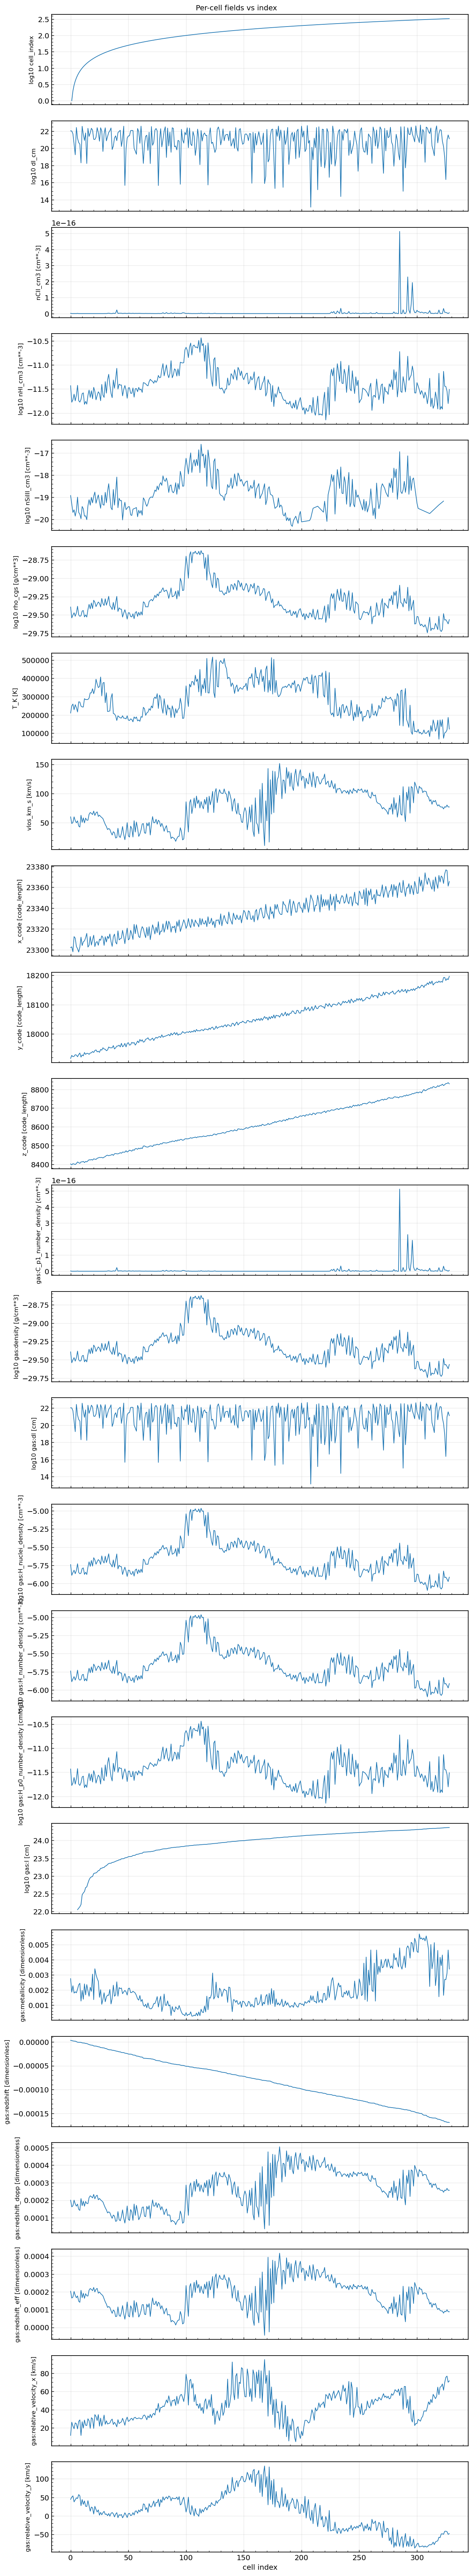

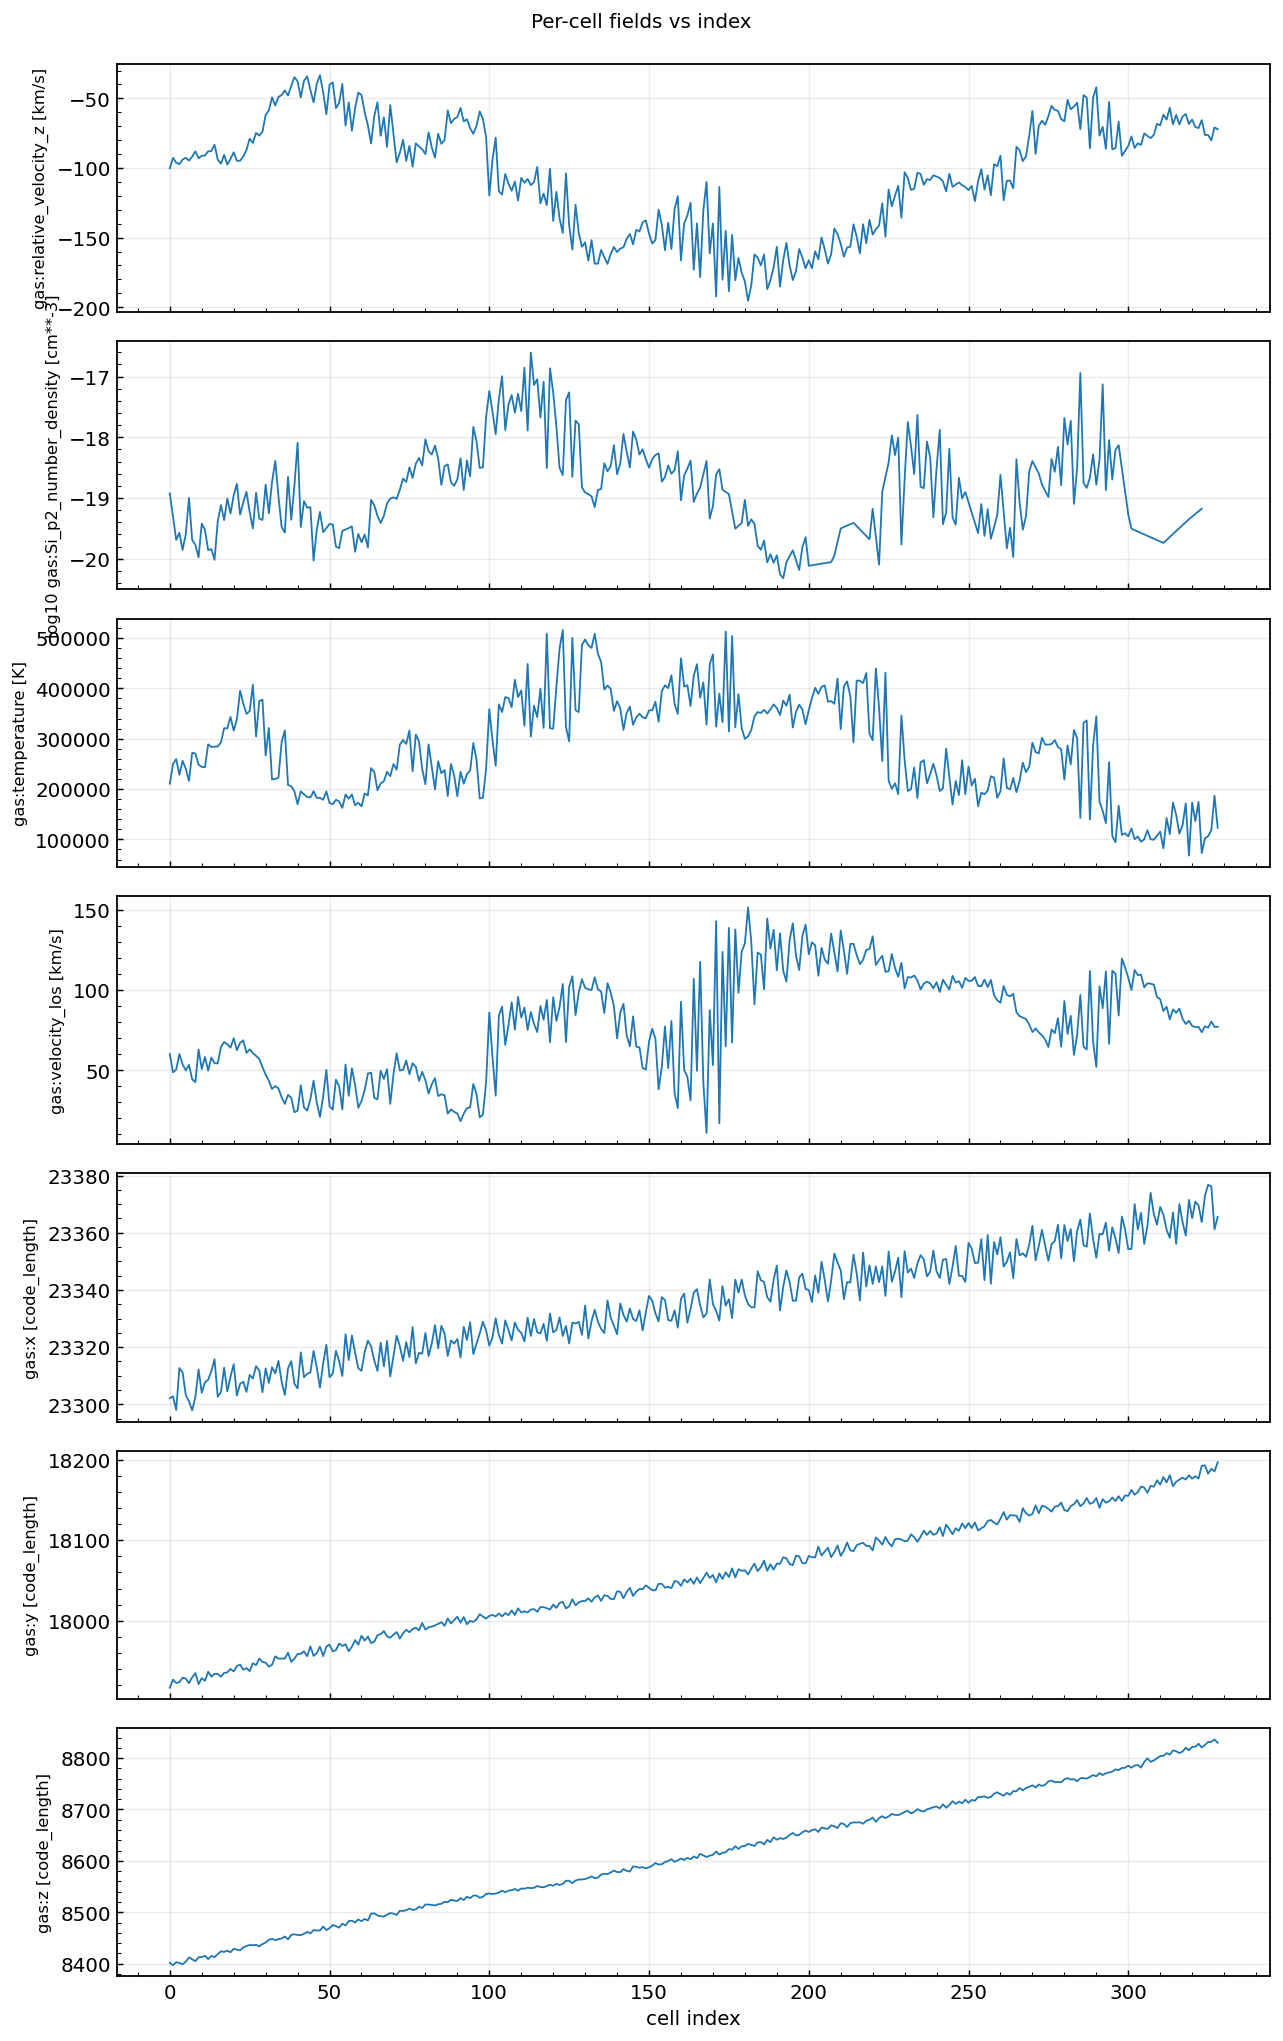

In [27]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, math, h5py
import numpy as np
import matplotlib.pyplot as plt

# === Path to your new-format bundle ===
BUNDLE = "/Users/wavefunction/github_repos/COS-GASS/tests/56372_sightlines/rays_and_recipes_sid563732_snap99/ray_and_spectrum/sid563732_noflip_alpha0_bundle.h5"

# Include which ftypes from /ray/fields you want to plot.
# To include everything (triplicates), set to ["gas","all","grid"].
INCLUDE_FTYPES = ["gas"]

# --------- 1) Print the full HDF5 tree (all keys everywhere) ----------
def print_h5_tree(path):
    with h5py.File(path, "r") as f:
        def visit(name, obj):
            kind = "G" if isinstance(obj, h5py.Group) else "D"
            line = f"[{kind}] /{name}"
            if isinstance(obj, h5py.Dataset):
                line += f"  shape={obj.shape} dtype={obj.dtype}"
            print(line)
            # show attrs (shorten long reprs a bit)
            if len(obj.attrs):
                for k, v in obj.attrs.items():
                    vs = repr(v)
                    if len(vs) > 200:
                        vs = vs[:200] + "...(trunc)"
                    print(f"      @attr {k} = {vs}")
        f.visititems(visit)

print("=== HDF5 TREE ===")
print_h5_tree(BUNDLE)


# --------- 2) Load /ray and gather all 1-D per-cell arrays ----------
def _is_numeric(ds: h5py.Dataset) -> bool:
    try:
        return np.issubdtype(ds.dtype, np.number)
    except Exception:
        return False

def _dataset_unit(ds: h5py.Dataset) -> str:
    u = ds.attrs.get("unit", "")
    try:
        return u.decode("utf-8") if isinstance(u, (bytes, bytearray)) else str(u)
    except Exception:
        return ""
        
def _try_len(a) -> int:
    try:
        return len(a)
    except Exception:
        return -1

def _find_ncells(ray_group: h5py.Group) -> int:
    # Prefer explicit dl_cm
    if "dl_cm" in ray_group and isinstance(ray_group["dl_cm"], h5py.Dataset):
        return int(ray_group["dl_cm"].shape[0])
    # Else any 1-D numeric dataset directly in /ray
    for k in ray_group.keys():
        obj = ray_group[k]
        if isinstance(obj, h5py.Dataset) and obj.ndim == 1 and _is_numeric(obj):
            return int(obj.shape[0])
    # Else peek into /ray/fields/*/* for first 1-D numeric
    if "fields" in ray_group:
        g_fields = ray_group["fields"]
        for ftype in g_fields.keys():
            g_ft = g_fields[ftype]
            for name in g_ft.keys():
                ds = g_ft[name]
                if isinstance(ds, h5py.Dataset) and ds.ndim == 1 and _is_numeric(ds):
                    return int(ds.shape[0])
    raise RuntimeError("Could not infer n_cells for the ray.")

def collect_series(bundle_path, include_ftypes=("gas",), include_convenience=True):
    """
    Return list of dicts with:
      {'label': str, 'data': np.ndarray, 'unit': str, 'path': str}
    Only includes 1-D numeric arrays with length == n_cells.
    """
    out = []
    with h5py.File(bundle_path, "r") as f:
        if "ray" not in f:
            raise RuntimeError("No /ray group in this file.")
        ray = f["ray"]
        n_cells = _find_ncells(ray)

        # (A) convenience datasets directly under /ray
        if include_convenience:
            for k in ray.keys():
                obj = ray[k]
                if isinstance(obj, h5py.Dataset):
                    # skip known non-per-cell things (e.g., field_list)
                    if obj.ndim != 1 or not _is_numeric(obj):
                        continue
                    if obj.shape[0] != n_cells:
                        continue
                    arr = np.array(obj, dtype=float)
                    out.append({
                        "label": k, "data": arr, "unit": _dataset_unit(obj),
                        "path": f"/ray/{k}"
                    })

        # (B) all fields under /ray/fields/<ftype>/<name>
        if "fields" in ray:
            g_fields = ray["fields"]
            # Choose which ftypes to include (avoid triple plots if desired)
            for ftype in g_fields.keys():
                if include_ftypes and ftype not in include_ftypes:
                    continue
                g_ft = g_fields[ftype]
                for name in g_ft.keys():
                    ds = g_ft[name]
                    if not isinstance(ds, h5py.Dataset):
                        continue
                    if ds.ndim != 1 or not _is_numeric(ds):
                        continue
                    if ds.shape[0] != n_cells:
                        continue
                    arr = np.array(ds, dtype=float)
                    label = f"{ftype}:{name}"
                    out.append({
                        "label": label, "data": arr, "unit": _dataset_unit(ds),
                        "path": f"/ray/fields/{ftype}/{name}"
                    })
    # Sort for nicer grouping: convenience first, then by label
    out.sort(key=lambda d: (0 if "/" not in d["label"] and ":" not in d["label"] else 1, d["label"].lower()))
    return out, n_cells


# --------- 3) Plot all series vs cell index ----------
def _logify(name, unit, y):
    """Decide whether to log-plot (base 10) and return transformed array + flag."""
    y = np.asarray(y, float)
    # Only if positive & finite values dominate
    mpos = (y > 0) & np.isfinite(y)
    frac_pos = mpos.sum() / max(y.size, 1)
    if frac_pos < 0.8:
        return y, False  # too many zeros/negatives; stay linear

    # Heuristics: densities/pathlengths/columns benefit from log
    keys = ["density", "rho", "nhi", "siii", "cii", "cm", "dl", "tau"]
    dynamic = (np.nanmax(y[mpos]) / max(np.nanmin(y[mpos]), 1e-300)) if mpos.any() else 1.0
    if dynamic > 50 or any(k in name.lower() for k in keys) or any(k in unit.lower() for k in keys if isinstance(unit, str)):
        y2 = np.full_like(y, np.nan, dtype=float)
        y2[mpos] = np.log10(y[mpos])
        return y2, True
    return y, False

def plot_all_series(series_list, title="", page_size=24):
    """
    Plot every time series vs cell index. If there are lots, make multiple figures.
    """
    if not series_list:
        print("[WARN] No per-cell arrays found to plot.")
        return

    # Split into chunks for readability
    for i0 in range(0, len(series_list), page_size):
        chunk = series_list[i0:i0+page_size]
        n = len(chunk)
        fig_h = max(2.25*n, 6.0)
        fig, axes = plt.subplots(n, 1, figsize=(10, fig_h), sharex=True)
        if n == 1:
            axes = [axes]
        for ax, entry in zip(axes, chunk):
            y = entry["data"]
            yplot, islog = _logify(entry["label"], entry["unit"], y)
            m = np.isfinite(yplot)
            x = np.arange(y.size)
            ax.plot(x[m], yplot[m], lw=1.0)
            ylabel = entry["label"]
            if entry["unit"]:
                ylabel += f" [{entry['unit']}]"
            if islog:
                ylabel = "log10 " + ylabel
            ax.set_ylabel(ylabel, fontsize=9)
            ax.grid(alpha=0.25)
        axes[-1].set_xlabel("cell index")
        fig.suptitle(title if title else os.path.basename(BUNDLE), fontsize=11, y=0.995)
        fig.tight_layout()
        plt.show()


# ===========================
# Run the inspection & plots
# ===========================
series, n_cells = collect_series(BUNDLE, include_ftypes=INCLUDE_FTYPES, include_convenience=True)
print(f"\nFound {len(series)} 1-D per-cell arrays (n_cells={n_cells}). "
      f"(ftypes included: {', '.join(INCLUDE_FTYPES) if INCLUDE_FTYPES else 'ALL'})")

# Optional: print a short inventory
for s in series:
    print(f" - {s['path']}  (unit='{s['unit']}', N={s['data'].size})")

plot_all_series(series, title="Per-cell fields vs index", page_size=24)